In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import os
from ipywidgets import interact, interact_manual
%matplotlib inline

# Starting with some image utility functions
These will help visualize and save images throughout the project.

In [2]:
IMAGE_OUTPUT_PATH = 'output_images/'

def load_images_from_dir(path):
    """ return list of (image, filename) from a specified directory"""
    return [(mpimg.imread(os.path.join(path, file)), file) for file in os.listdir(path)]


def weighted_img(image1, image2, α=0.8, β=1., γ=0.):
    """
    The result image is computed as follows:
    image1 * α + image2 * β + γ
    NOTE: image1 and image2 must be the same shape!
    """
    return cv2.addWeighted(image1, α, image2, β, γ)

def show_images(images_data, in_gray=False, img_per_row=3, figsize=(20, 10)):
    """Display images as is or in grey scale. images_data = [(image, name)...]"""
    # images count
    img_cnt = len(images_data)
    
    # show max 3 images per row. Calculate the rows count
    row_cnt = int((img_cnt-1) / img_per_row) + 1
    
    # display the images
    f, axs =  plt.subplots(row_cnt, img_per_row, figsize=figsize)
    count_images = 0
    for r in range(row_cnt):
        for c in range(img_per_row):
            if count_images < img_cnt:
                count_images += 1
                if row_cnt == 1 and img_per_row == 1:
                     ax = axs
                elif row_cnt == 1:
                    ax = axs[c]
                elif img_per_row == 1:
                    ax = axs[r]
                else:
                    ax = axs[r, c]
                cmap = 'gray' if in_gray else None
                ax.set_title(images_data[img_per_row*r + c][1])
                ax.imshow(images_data[img_per_row*r + c][0], cmap=cmap)

                
def save_images(list_images_data, filename_prefix='', in_gray=False):
    """Save a list of images to disk.
    `list_images_data` is a list of tuple(image, filename)"""
    #
    cmap = 'gray' if in_gray == True else None
    #for (image, filename) in list_images_data: 
    #    plt.imsave(os.path.join(IMAGE_OUTPUT_PATH, filename_prefix+filename), image, cmap=cmap)

        
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    # https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf


def adaptive_brightness(image, hpart=4, wpart=4):
    H = image.shape[0]
    W = image.shape[1]
    
    wsize = W // wpart
    hsize = H // hpart
    image_parts = [[image[h*hsize:(h+1)*hsize, w*wsize:(w+1)*wsize] for w in range(wpart)] for h in range(hpart)]
    
    for h, img_row in enumerate(image_parts):
        for w, img in enumerate(img_row):
            hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            mean_lumi = np.mean(hls[:,:,1])
            #print('Mean Lumi ({}, {}): {}'.format(h, w, mean_lumi))
            if mean_lumi > 110:
                britghness = (100 - mean_lumi)*1.5
                image_parts[h][w] = apply_brightness_contrast(img, britghness, 20)
                hls = cv2.cvtColor(image_parts[h][w], cv2.COLOR_RGB2HLS)
                mean_lumi = np.mean(hls[:,:,1])
                #print('after correction: Mean Lumi ({}, {}): {} , reduced brightness {}'.format(h, w, mean_lumi, britghness))
            elif mean_lumi < 80:
                britghness = (80 - mean_lumi)*1.5
                image_parts[h][w] = apply_brightness_contrast(img, britghness, 20)
                hls = cv2.cvtColor(image_parts[h][w], cv2.COLOR_RGB2HLS)
                mean_lumi = np.mean(hls[:,:,1])
                #print('after correction: Mean Lumi ({}, {}): {} , reduced brightness {}'.format(h, w, mean_lumi, britghness))

    #f, axs = plt.subplots(hpart, wpart, figsize=(20, 5*hpart))
    #for row, img_row in zip(axs, image_parts):
    #    for ax, img in zip(row, img_row):
    #        ax.imshow(img)
    
    result = np.copy(image)
    for h, img_row in enumerate(image_parts):
        for w, img in enumerate(img_row):
            result[h*hsize:(h+1)*hsize, w*wsize:(w+1)*wsize] = img
    
    return result

# 1. Camera Calibration

We will use some checkboard images taken by the camera for calibration.
#### a. Let's start looking at some of those chessboard images.

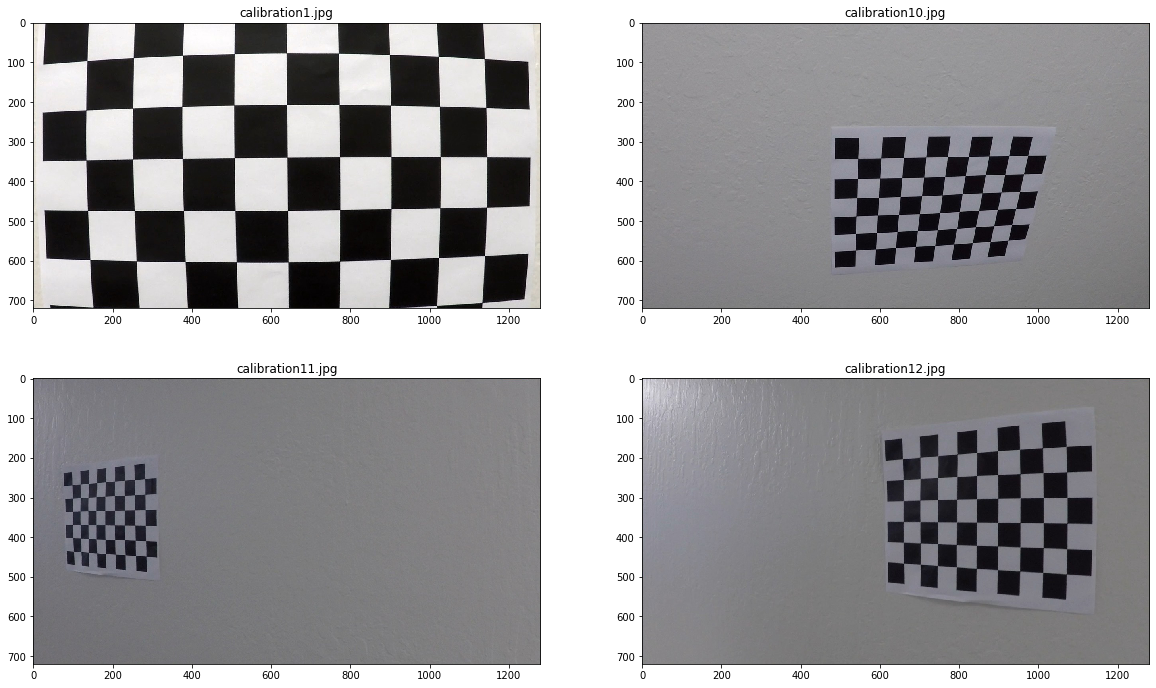

In [3]:
# Make a list of calibration images
cal_images = load_images_from_dir('camera_cal/')
show_images(cal_images[:4], img_per_row=2, figsize=(20, 12))

We will consider for the next steps a 9x6 chessboard.
#### b. Finding the chessboard corners

In [4]:
CHESS_NX = 9
CHESS_XY = 6

# prepare object points
objp = np.zeros((CHESS_XY*CHESS_NX,3), np.float32)
objp[:,:2] = np.mgrid[0:CHESS_NX, 0:CHESS_XY].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
img_with_corners = [] # images updated with the drawing of their corners found

# Step through the list and search for chessboard corners
for image, fname in cal_images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (CHESS_NX, CHESS_XY), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        image = cv2.drawChessboardCorners(image, (CHESS_NX, CHESS_XY), corners, ret)
        img_with_corners.append((image, fname))

Let's see what we get...

Nb images with corners detected 17/20


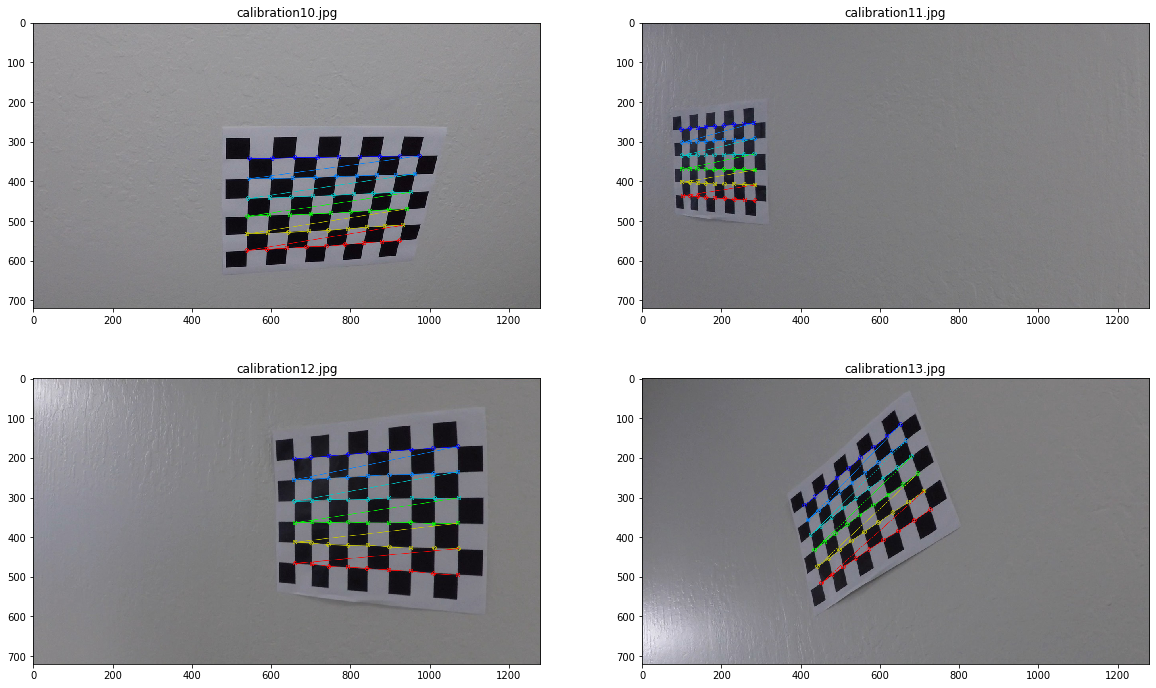

In [5]:
print('Nb images with corners detected {}/{}'.format(len(img_with_corners), len(cal_images)))

# Just display few images with their cornes
nb_image_corners_to_display = np.min([4, len(img_with_corners)])
show_images(img_with_corners[:nb_image_corners_to_display], img_per_row=2, figsize=(20, 12))
save_images(img_with_corners, filename_prefix='with_corners_')

#### c. Calculate the distortion coefficients

In [6]:
# Get thesize of the images
img_size = (cal_images[0][0].shape[1], cal_images[0][0].shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Let's save the interesting distorsion coefficients for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("calibration_dist_pickle.p", "wb"))


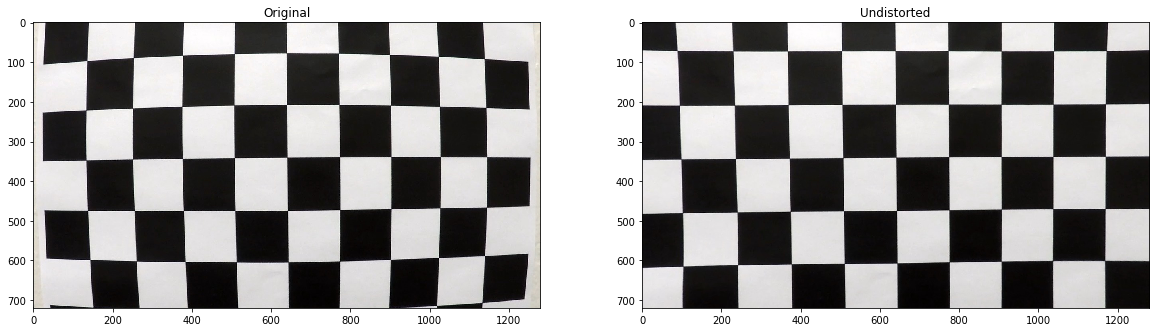

In [7]:
def undistort_image(image, dist, mtx):
    """Utility function to undistort an image, given the distortion coefficients"""
    return cv2.undistort(image, mtx, dist, None, mtx)

# Undistort one of the calibration image to see the effect:
cal_image = cal_images[0][0]
cal_image_undistorted = undistort_image(cal_image, dist, mtx)
show_images([(cal_image, 'Original'), (cal_image_undistorted, 'Undistorted')], img_per_row=2, figsize=(20, 20))
save_images([(cal_image_undistorted, cal_images[0][1])], filename_prefix='undistorted_')

# 2. Load & Undistort test images

In [44]:
# Load the test images
test_images = load_images_from_dir('test_images/')

# Undistort the test images
undistorted_images = [(undistort_image(image, dist, mtx), 'undistorted_'+fname) for (image, fname) in test_images]
save_images(undistorted_images)

# Display images and their undistorted version interactively
@interact(image_index=[(undistorted_images[i][1], i) for i in range(len(undistorted_images))])
def show_undistorted_images(image_index):
    show_images([test_images[image_index], undistorted_images[image_index]], img_per_row=2, figsize=(20, 12))

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

# 3. Thresholded Binary Images
Let's explore how we could get acceptable thresholded binary images

#### A. Exploring different color spaces

In [45]:
# Let's have a look on RGB and HLS channels for each test image

images_index = [(undistorted_images[i][1], i) for i in range(len(undistorted_images))]

# Using an interactive widget to
@interact(image_index=images_index)
def show_rgb_hls(image_index):
    image, fname = undistorted_images[image_index]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # RGB channels
    r_channel = image[:,:,0]
    g_channel = image[:,:,1]
    b_channel = image[:,:,2]
    
    # HLS channels
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Gray')
    ax2.imshow(gray, cmap='gray')
    
    show_images([(r_channel, 'R Channel'), (g_channel, 'G Channel'), (b_channel, 'B Channel')], img_per_row=3, figsize=(20, 10), in_gray=True)
    show_images([(h_channel, 'H Channel'), (l_channel, 'L Channel'), (s_channel, 'S Channel')], img_per_row=3, figsize=(20, 10), in_gray=True)


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

White color is very clear on all RGB channels, as well on the L channel of HSL color space.

Yellow color is stronger on the S channel of HLS, but we also know that H channel hold a consistent value of the color under different lighting. It is also quite Ok on R channel of RGB, a little less on the G channel.

Let's explore some combination of those to see where we can get better result.

In [48]:
# Trying different threshold values to detect white color on RGB & HLS color spaces

@interact(image_index=images_index, rgb_low=(0,255,1), rgb_upper=(0,255,1), l_low=(0,255,1), l_upper=(0,255,1))
def show_white_color_threshold(image_index, rgb_low=190, rgb_upper=255, l_low=190, l_upper=255):
    image, fname = undistorted_images[image_index]
    
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    mean_lumi = np.mean(hls[:,:,1])
    print('Mean Lumi : {}'.format(mean_lumi))
    if mean_lumi > 110:
        britghness = (100 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: Mean Lumi : {} , - brightness {}'.format(mean_lumi, britghness))
    elif mean_lumi < 80:
        britghness = (80 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: Mean Lumi : {} , + brightness {}'.format(mean_lumi, britghness))
    
    '''
    # Calulate the mean luminescence
    mean_lumi = np.mean(hls[:,:,1])
    print('Mean Lumi: {}'.format(mean_lumi))
    if mean_lumi > 110:
        reduce_britghness = 10 * (100 - mean_lumi) / 5
        image = apply_brightness_contrast(image, reduce_britghness, 0)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: mean lumi {} , reduced brightness {}', mean_lumi, reduce_britghness)
    '''
    # threshold ranges
    rgb_low_white = np.array([rgb_low, rgb_low, rgb_low])
    rgb_upper_white = np.array([rgb_upper, rgb_upper, rgb_upper])
    l_low_white = np.array([0, l_low, 0])
    l_upper_white = np.array([255, l_upper, 255])
    
    
    
    # create binary images for white color
    rgb_binary = cv2.inRange(image, rgb_low_white, rgb_upper_white) // 255
    l_binary = cv2.inRange(hls, l_low_white, l_upper_white) // 255
    
    color_stack = np.dstack(( np.zeros_like(rgb_binary), rgb_binary, l_binary))*255
    
    f, [(ax1, ax2), (ax3, ax4)] =  plt.subplots(2, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Stack')
    ax2.imshow(color_stack)
    ax3.set_title(' - RGB White')
    ax3.imshow(rgb_binary, cmap='gray')
    ax4.set_title(' - HLS White')
    ax4.imshow(l_binary, cmap='gray')


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [51]:
# Trying different threshold values to detect white color on RGB & HLS color spaces

@interact(image_index=images_index, l_low=(0,255,1), l_upper=(0,255,1), s_low=(0,255,1), s_upper=(0,255,1))
def show_gray_color_threshold(image_index, l_low=0, l_upper=150, s_low=0, s_upper=20):
    image, fname = undistorted_images[image_index]
    
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    mean_lumi = np.mean(hls[:,:,1])
    print('Mean Lumi : {}'.format(mean_lumi))
    if mean_lumi > 110:
        britghness = (100 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: Mean Lumi : {} , - brightness {}'.format(mean_lumi, britghness))
    elif mean_lumi < 80:
        britghness = (80 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: Mean Lumi : {} , + brightness {}'.format(mean_lumi, britghness))
        
    # threshold ranges
    l_low_white = np.array([0, l_low, s_low])
    l_upper_white = np.array([255, l_upper, s_upper])
    
    # create binary images for white color
    #rgb_binary = cv2.inRange(image, rgb_low_white, rgb_upper_white) // 255
    l_binary = cv2.inRange(hls, l_low_white, l_upper_white) // 255
    
    color_stack = np.dstack(( np.zeros_like(l_binary), l_binary, l_binary))*255
    
    f, [(ax1, ax2), (ax3, ax4)] =  plt.subplots(2, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Stack')
    ax2.imshow(color_stack)
    #ax3.set_title(' - RGB White')
    #ax3.imshow(rgb_binary, cmap='gray')
    ax4.set_title(' - HLS White')
    ax4.imshow(l_binary, cmap='gray')

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [52]:
# Trying different threshold values to detect yello color on HLS color space, by combining H & S Channels

@interact(image_index=images_index, h_yello_low=(0,255,1), h_yello_up=(0,255,1), s_yello_low=(0,255,1), s_yello_up=(0,255,1))
def show_yellow_color_threshold(image_index, h_yello_low=10, h_yello_up=40, s_yello_low=100, s_yello_up=255):
    image, fname = undistorted_images[image_index]
    
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    mean_lumi = np.mean(hls[:,:,1])
    print('Mean Lumi : {}'.format(mean_lumi))
    if mean_lumi > 110:
        britghness = (100 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: Mean Lumi : {} , - brightness {}'.format(mean_lumi, britghness))
    elif mean_lumi < 80:
        britghness = (80 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: Mean Lumi : {} , + brightness {}'.format(mean_lumi, britghness))
    
    # threshold ranges
    yellow_low = np.array([h_yello_low, 0, s_yello_low])
    yellow_up = np.array([h_yello_up, 255, s_yello_up])
    
    # create binary images for white color
    yellow_binary = cv2.inRange(hls, yellow_low, yellow_up) // 255
    
    f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Yellow on HLS')
    ax2.imshow(yellow_binary, cmap='gray')


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

#### B. Exploring some gradiant thresholds based on combination of sobel operators

In [53]:
##########################################################
## Combining gradients...
##########################################################

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobel = cv2.Sobel(gray, cv2.CV_64F, int(orient=='x'), int(orient=='y'), ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary


def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    #Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.abs(sobely), np.abs(sobelx))
    
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return dir_binary


@interact(image_index=images_index, sobel_kernel=(1, 45, 2), low_thrx=(0, 255, 1), up_thrx=(0, 255, 1), 
          low_thry=(0, 255, 1), up_thry=(0, 255, 1), low_thr_mag=(0, 255, 1), up_thr_mag=(0, 255, 1), 
          low_thr_dir=(0, np.pi/2, 0.1), up_thr_dir=(0, np.pi/2, 0.1))
def gradient_thresh(
    image_index, sobel_kernel=3, low_thrx=20, up_thrx=100, low_thry=20, up_thry=100, 
    low_thr_mag=30, up_thr_mag=100, low_thr_dir=0.7, up_thr_dir=1.3):
    
    image, fname = undistorted_images[image_index]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel, thresh=(low_thrx, up_thrx))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel, thresh=(low_thry, up_thry))
    mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel, mag_thresh=(low_thr_mag, up_thr_mag))
    dir_binary = dir_threshold(image, sobel_kernel=sobel_kernel, thresh=(low_thr_dir, up_thr_dir))

    #Trying different combinations...
    combined_x_n_y = np.zeros_like(gradx)
    combined_x_n_y[(gradx == 1) & (grady == 1)] = 1
    
    combined_x_o_y = np.zeros_like(gradx)
    combined_x_o_y[(gradx == 1) | (grady == 1)] = 1
    
    combined_x_n_m = np.zeros_like(gradx)
    combined_x_n_m[(gradx == 1) & (mag_binary == 1)] = 1
    
    combined_x_o_m = np.zeros_like(gradx)
    combined_x_o_m[(gradx == 1) | (mag_binary == 1)] = 1
    
    combined_y_n_m = np.zeros_like(grady)
    combined_y_n_m[(grady == 1) & (mag_binary == 1)] = 1
    
    combined_y_o_m = np.zeros_like(grady)
    combined_y_o_m[(grady == 1) | (mag_binary == 1)] = 1
    
    combined_x_n_d = np.zeros_like(gradx)
    combined_x_n_d[(gradx == 1) & (dir_binary == 1)] = 1
    
    combined_x_o_d = np.zeros_like(gradx)
    combined_x_o_d[(gradx == 1) | (dir_binary == 1)] = 1
    
    combined_y_n_d = np.zeros_like(grady)
    combined_y_n_d[(grady == 1) & (dir_binary == 1)] = 1
    
    combined_y_o_d = np.zeros_like(grady)
    combined_y_o_d[(grady == 1) | (dir_binary == 1)] = 1

    combined_m_n_d = np.zeros_like(mag_binary)
    combined_m_n_d[(mag_binary == 1) & (dir_binary == 1)] = 1
    
    combined_m_o_d = np.zeros_like(mag_binary)
    combined_m_o_d[(mag_binary == 1) | (dir_binary == 1)] = 1
    
    combined_x_n_y_n_m = np.zeros_like(gradx)
    combined_x_n_y_n_m[(gradx == 1) & (grady == 1) & (mag_binary == 1)] = 1
    
    combined_x_o_y_o_m = np.zeros_like(gradx)
    combined_x_o_y_o_m[(gradx == 1) | (grady == 1) | (mag_binary == 1)] = 1
    
    combined_x_n_y_n_d = np.zeros_like(gradx)
    combined_x_n_y_n_d[(gradx == 1) & (grady == 1) & (dir_binary == 1)] = 1
    
    combined_x_o_y_o_d = np.zeros_like(gradx)
    combined_x_o_y_o_d[(gradx == 1) | (grady == 1) | (dir_binary == 1)] = 1
    
    combined_x_n_y_n_m_n_d = np.zeros_like(gradx)
    combined_x_n_y_n_m_n_d[(gradx == 1) & (grady == 1) & (mag_binary == 1) & (dir_binary == 1)] = 1
    
    combined_x_o_y_o_m_o_d = np.zeros_like(gradx)
    combined_x_o_y_o_m_o_d[(gradx == 1) | (grady == 1) | (mag_binary == 1) | (dir_binary == 1)] = 1
    
    combined_gradiants = [
        (gradx, 'X'), (grady, 'Y'), (mag_binary, 'M'), (dir_binary, 'D'),
        (combined_x_n_y, 'X & Y: '+fname), (combined_x_o_y, 'X | Y: '+fname),
        (combined_x_n_m, 'X & M: '+fname), (combined_x_o_m, 'X | M: '+fname),
        (combined_y_n_m, 'Y & M: '+fname), (combined_y_o_m, 'Y | M: '+fname),
        (combined_x_n_d, 'X & D: '+fname), (combined_x_o_d, 'X | D: '+fname),
        (combined_y_n_d, 'Y & D: '+fname), (combined_y_o_d, 'Y | D: '+fname),
        (combined_m_n_d, 'M & D: '+fname), (combined_m_o_d, 'M | D: '+fname),
        (combined_x_n_y_n_m, 'X & Y & M: '+fname), (combined_x_o_y_o_m, 'X | Y | M: '+fname),
        (combined_x_n_y_n_d, 'X & Y & D: '+fname), (combined_x_o_y_o_d, 'X | Y | D: '+fname),
        (combined_x_n_y_n_m_n_d, 'X & Y & M & D: '+fname), (combined_x_o_y_o_m_o_d, 'X | Y | M | D: '+fname)
    ]
    
    f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Gray')
    ax2.imshow(gray, cmap='gray')
    
    show_images(combined_gradiants, img_per_row=1, figsize=(40, 250), in_gray=True)
    

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

#### C. Selecting final combination of color & gradient thresholding
After testing multiple combinations we will finally go with a combination of:
* Color thresholding : detecting white and yellow color from RGB & HLS color spaces
* Gradient thresholding : using sobel_x operator

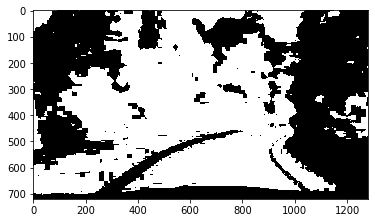

In [93]:
RGB_LOW_WHITE = np.array([190, 190, 190])
RGB_UPPER_WHITE = np.array([255,255,255])
HLS_LOW_WHITE = np.array([0, 190, 0])
HLS_UPPER_WHITE = np.array([255,255,255])
HLS_LOW_YELLOW = np.array([10, 0, 100])
HLS_UPPER_YELLOW = np.array([40, 255, 255])
HLS_LOW_GRAY = np.array([0, 0, 0])
HLS_UPPER_GRAY = np.array([255, 150, 20])
HLS_LOW_BLUE = np.array([90, 0, 0]) #95
HLS_UPPER_BLUE = np.array([130, 255, 255]) #120
HLS_LOW_OTHER = np.array([90, 0, 0]) #95
HLS_UPPER_OTHER = np.array([255, 150, 255]) #120

# Using an interactive widget to
def color_gradient_threshold(image, sobel_kernel=3, thresh=(20, 100), mg_thresh=(30, 100)):
    """Compute combined color & gradient thresholding binary image"""
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    mean_lumi = np.mean(hls[:,:,1])
    #print('Mean Lumi : {}'.format(mean_lumi))
    if mean_lumi > 110:
        britghness = (100 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        #print('after correction: Mean Lumi : {} , - brightness {}'.format(mean_lumi, britghness))
    elif mean_lumi < 80:
        britghness = (80 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        #print('after correction: Mean Lumi : {} , + brightness {}'.format(mean_lumi, britghness))
    '''
    # Calulate the mean luminescence
    mean_lumi = np.mean(hls[:,:,1])
    print('Mean Lumi: {}'.format(mean_lumi))
    if mean_lumi > 110:
        reduce_britghness = 10 * (100 - mean_lumi) / 5
        image = apply_brightness_contrast(image, reduce_britghness, 0)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: mean lumi {} , reduced brightness {}', mean_lumi, reduce_britghness)
    '''
    
    # create binary image for white & yellow colors
    white_rgb_binary = cv2.inRange(image, RGB_LOW_WHITE, RGB_UPPER_WHITE) // 255
    white_hls_binary = cv2.inRange(hls, HLS_LOW_WHITE, HLS_UPPER_WHITE) // 255
    
    # create binary image for yellow color
    yellow_hls_binary = cv2.inRange(hls, HLS_LOW_YELLOW, HLS_UPPER_YELLOW) // 255
    
    gray_hls_binary = cv2.inRange(hls, HLS_LOW_GRAY, HLS_UPPER_GRAY) // 255
    blue_hls_binary = cv2.inRange(hls, HLS_LOW_BLUE, HLS_UPPER_BLUE) // 255
    other_hls_binary = cv2.inRange(hls, HLS_LOW_OTHER, HLS_UPPER_OTHER) // 255
   
    # Calculate directional X gradient
    sobel_x = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel, thresh=thresh)
    sobel_y = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel, thresh=thresh)
    #mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel, mag_thresh=mg_thresh)
    combined_sobel = np.zeros_like(sobel_x)
    #combined_sobel[(sobel_x == 1) | (sobel_y == 1) | (mag_binary == 1)] = 1
    combined_sobel[(sobel_x == 1) | (sobel_y == 1)] = 1
    
    # Combined binary threshold
    combined_binary = np.zeros_like(combined_sobel)
    combined_binary[((combined_sobel == 1) & (gray_hls_binary == 0) & (other_hls_binary == 0)) |
                    ((white_rgb_binary == 1) & (white_hls_binary == 1)) | (yellow_hls_binary == 1)] = 1
    #combined_binary[((white_rgb_binary == 1) & (white_hls_binary == 1)) | (yellow_hls_binary == 1)] = 1
    
    return combined_binary



# Convert to HLS
hls = cv2.cvtColor(undistorted_images[0][0], cv2.COLOR_RGB2HLS)

# create binary images for white color
#rgb_binary = cv2.inRange(image, rgb_low_white, rgb_upper_white) // 255
l_binary = cv2.inRange(hls, HLS_LOW_BLUE, HLS_UPPER_BLUE) // 255
plt.imshow(l_binary, cmap='gray')

In [94]:

@interact(image_index=images_index)
def show_color_gradient(image_index):
    image, fname = undistorted_images[image_index]
    
    f, ax =  plt.subplots(1, 1, figsize=(20, 10))
    ax.imshow(color_gradient_threshold(image), cmap='gray')


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [95]:
# Gradiant & Threshold of the undistorted images
thresholded_images = [(color_gradient_threshold(image), 'thresholded_'+fname) for (image, fname) in undistorted_images]
save_images(thresholded_images)

In [96]:
from ipywidgets import IntSlider, FloatSlider

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



# Let's use an interactive function to display the selected area of interest

# Get image size
IMG_H, IMG_W = thresholded_images[0][0].shape

# Create the coordinates sliders
wg_l_bottom_x = IntSlider(min=0, max=IMG_W-1, step=1, value=150)  # bottom-left x
wg_l_bottom_y = IntSlider(min=0, max=IMG_H-1, step=1, value=719)  # bottom-left y
wg_l_top_x = IntSlider(min=0, max=IMG_W-1, step=1, value=627)  # top-left x
wg_l_top_y = IntSlider(min=0, max=IMG_H-1, step=1, value=400)  # top-left y
wg_r_top_x = IntSlider(min=0, max=IMG_W-1, step=1, value=683)  # top-right x
wg_r_top_y = IntSlider(min=0, max=IMG_H-1, step=1, value=400)  # top-right y
wg_r_bottom_x = IntSlider(min=0, max=IMG_W-1, step=1, value=1200)  # bottom-right x
wg_r_bottom_y = IntSlider(min=0, max=IMG_H-1, step=1, value=719)  # bottom-right y

# define interactive range values and step for each parameters
@interact(image_id=images_index, 
          l_bottom_x=wg_l_bottom_x, l_bottom_y=wg_l_bottom_y, l_top_x=wg_l_top_x, l_top_y=wg_l_top_y, 
          r_top_x=wg_r_top_x, r_top_y=wg_r_top_y, r_bottom_x=wg_r_bottom_x, r_bottom_y=wg_r_bottom_y)
def interact_select_area(image_id, l_bottom_x, l_bottom_y, l_top_x, l_top_y, r_top_x, r_top_y, r_bottom_x, r_bottom_y):
    _, ax =  plt.subplots(1, 1, figsize=(20, 20))
    ax.imshow(thresholded_images[image_id][0], cmap='gray')
    ax.set_title(thresholded_images[image_id][1])
    x = [l_bottom_x, l_top_x, r_top_x, r_bottom_x]
    y = [l_bottom_y, l_top_y, r_top_y, r_bottom_y]
    ax.plot(x, y, 'b--', lw=4)
    
# How to use:
# - change the value
# - click on the `Run Interact` button to display

interactive(children=(Dropdown(description='image_id', options=(('undistorted_00147_image.jpg', 0), ('undistor…

In [103]:
# Value selected after playing with the interactive canny function
#vertices = np.array([[(150, IMG_H-1),(627, 400), (683, 400), (1200, IMG_H-1)]], dtype=np.int32)
#thresholded_images = [(region_of_interest(image, vertices), file) for (image, file) in thresholded_images]

# 4. Perspective Transform

Let's calculate the perspective transform matrix from a typical image and apply it to our thresholded images

In [104]:
IMG_SIZE = (undistorted_images[0][0].shape[1], undistorted_images[0][0].shape[0])

def compute_perspective_transform_matrix(src_coords, dst_coords):
    """Calculate the perspective transform matric from source & destination coordinates"""
    src = np.float32([src_coords[0], src_coords[1], src_coords[2], src_coords[3]])
    dst = np.float32([dst_coords[0], dst_coords[1], dst_coords[2], dst_coords[3]])
    return cv2.getPerspectiveTransform(src, dst)


def apply_warp_perspective(image, M, img_size=IMG_SIZE, flags=cv2.INTER_LINEAR):
    """Apply warp perspective transform to an image"""
    return cv2.warpPerspective(image, M, img_size, flags=flags)
    


In [105]:
# Test image to use for calculating the transform matric
perpective_test_image = undistorted_images[0][0]

# Source coordinates
#src_coords = [[200, 720], [605, 443], [675, 443], [1111, 720]]
#src_coords = [[195, 719], [596, 449], [684, 449], [1123, 719]]
src_coords = [[190, 719], [569, 465], [714, 465], [1126, 719]]

# destination coordinates
#dst_coords = [[295, 719], [295, 0], [1023, 0], [1023, 719]]
dst_coords = [[290, 719], [290, 0], [1026, 0], [1026, 719]]

# Compute transform matrix
M = compute_perspective_transform_matrix(src_coords, dst_coords)

# Compute inverse transform matrix
Minv = compute_perspective_transform_matrix(dst_coords, src_coords)


In [106]:
# Display the warp prespective version of the undistorted and thresholded images

@interact(image_index=images_index)
def show_warped_perspective(image_index):
    u_image, fname = undistorted_images[image_index]
    t_image, fname = thresholded_images[image_index]
    
    warp_u_image = apply_warp_perspective(u_image, M)
    warp_t_image = apply_warp_perspective(t_image, M)
    f, [(ax1, ax2), (ax3, ax4)] =  plt.subplots(2, 2, figsize=(20, 10))
    
    ax1.imshow(u_image)
    ax1.set_title('Original: '+fname)
    x1 = [src_coords[0][0], src_coords[1][0], src_coords[2][0], src_coords[3][0]]
    y1 = [src_coords[0][1], src_coords[1][1], src_coords[2][1], src_coords[3][1]]
    ax1.plot(x1, y1, 'r--', lw=2)
    
    ax2.imshow(warp_u_image)
    ax1.set_title('Warp: '+fname)
    x2 = [dst_coords[0][0], dst_coords[1][0], dst_coords[2][0], dst_coords[3][0]]
    y2 = [dst_coords[0][1], dst_coords[1][1], dst_coords[2][1], dst_coords[3][1]]
    ax2.plot(x2, y2, 'r--', lw=2)
    
    ax3.imshow(t_image, cmap='gray')
    ax3.set_title('Original Thresholded: '+fname)
    ax3.plot(x1, y1, 'r--', lw=2)
    
    ax4.imshow(warp_t_image, cmap='gray')
    ax4.set_title('Warp Thresholded: '+fname)
    ax4.plot(x2, y2, 'r--', lw=2)

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [107]:
# Generate warp perspective transform images
warp_undistorted_images = [(apply_warp_perspective(image, M), 'warp_'+fname) for (image, fname) in undistorted_images]
save_images(warp_undistorted_images)

warp_thresholded_images = [(apply_warp_perspective(image, M), 'warp_'+fname) for (image, fname) in thresholded_images]
save_images(warp_thresholded_images)

# 5. Finding lines using sliding windows and histogram peaks

#### A. Looking at the histogram of warp-thresholded images

In [108]:

@interact(image_index=images_index)
def show_histogram(image_index):
    image, fname = warp_thresholded_images[image_index]
    
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = image[image.shape[0]//2:,:]

    # Sum across image pixels vertically
    # The highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print(leftx_base, rightx_base)
    print(histogram[leftx_base], histogram[rightx_base])
    
    hist = -1 * np.sum(bottom_half, axis=0) + image.shape[0]
    #hist = np.sum(bottom_half, axis=0)

    # Display the image and corresponding histogram
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.imshow(image, cmap='gray')
    ax.plot(hist, 'r', lw=4)
    plt.axvline(x=image.shape[1]/4, c='g', linestyle='--')
    plt.axvline(x=3*image.shape[1]/4, c='g', linestyle='--')
    plt.axvline(x=-100+image.shape[1]/4, c='g', linestyle='-')
    plt.axvline(x=100+image.shape[1]/4, c='g', linestyle='-')
    plt.axvline(x=-100+3*image.shape[1]/4, c='g')
    plt.axvline(x=100+3*image.shape[1]/4, c='g')
    plt.axhline(y=2*image.shape[0]/3, color='b')
    
    #fig.savefig(os.path.join(IMAGE_OUTPUT_PATH, 'hist_'+fname), dpi=fig.dpi)


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [86]:
#test4, test1, test6, test5 

#### B. Testing line detection with Sliding Windows

In [109]:
def average_distance(X, Y, YP):
    newX = []
    newY = []
    dx = X[1] - X[0]
    DYDX = np.gradient(Y, dx)
    
    D = (Y-YP) * np.sqrt(1 + DYDX**2)
        
    return np.mean(D), D


def equidistance_curve(X, Y, d):
    newX = []
    newY = []
    dx = X[1] - X[0]
    DXDY = np.gradient(Y, dx)
    for (x, y, yp) in zip(X, Y, DXDY):
        #n = 2 * a * x + b
        m = np.sqrt(1 + yp**2)
        newX.append(x + d*yp/m)
        newY.append(y - d/m)

    return newX, newY


def get_parralel_line(ploty, fitx, lane_width):
    other_y, other_x = equidistance_curve(ploty, fitx, lane_width)
    other_fit = np.polyfit(other_y, other_x, 2)
    other_fitx = other_fit[0]*ploty**2 + other_fit[1]*ploty + other_fit[2]
    
    return other_fit, other_fitx


'''
def compute_lines_separation(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Compute both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #average distance
    avg_dist = average_distance(ploty, right_fitx, left_fitx)
    return avg_dist
'''     

def find_lane_sliding_windows(binary_warped, nwindows=9, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #distances = []
    left_found = 0
    right_found = 0
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        '''
        if len(good_left_inds) > minpix and len(good_right_inds) > minpix:
            #rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            #leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
            leftx_tmp = nonzerox[good_left_inds]
            lefty_tmp = nonzeroy[good_left_inds] 
            left_fit_tmp = np.polyfit(lefty_tmp, leftx_tmp, 2)
            
            rightx_tmp = nonzerox[good_right_inds]
            righty_tmp = nonzeroy[good_right_inds] 
            right_fit_tmp = np.polyfit(righty_tmp, rightx_tmp, 2)
            
            # Generate x and y values for plotting
            ploty_tmp = np.linspace(win_y_low, win_y_high)
            # Compute both polynomials using ploty, left_fit and right_fit
            left_fitx_tmp = left_fit_tmp[0]*ploty_tmp**2 + left_fit_tmp[1]*ploty_tmp + left_fit_tmp[2]
            right_fitx_tmp = right_fit_tmp[0]*ploty_tmp**2 + right_fit_tmp[1]*ploty_tmp + right_fit_tmp[2]
            
            #average distance
            avg_dist = average_distance(ploty_tmp, right_fitx_tmp, left_fitx_tmp)
            distances.append(avg_dist)
            print('Average distance: {}'.format(avg_dist))
            
            leftx_current = np.int(np.mean(leftx_tmp))
            rightx_current = np.int(np.mean(rightx_tmp))
            
        elif len(good_left_inds) > minpix:
            print('Need to extrapolate right side')
            leftx_tmp = nonzerox[good_left_inds]
            lefty_tmp = nonzeroy[good_left_inds]
            
            left_fit_tmp = np.polyfit(lefty_tmp, leftx_tmp, 2)
            ploty_tmp = np.linspace(win_y_low, win_y_high, dtype = int) #[y for y in range(win_y_low, win_y_high)]
            left_fitx_tmp = left_fit_tmp[0]*ploty_tmp**2 + left_fit_tmp[1]*ploty_tmp + left_fit_tmp[2]
            
            righty_tmp, rightx_tmp = equidistance_curve(ploty_tmp, left_fitx_tmp, np.mean(distances))
            right_fit_tmp = np.polyfit(righty_tmp, rightx_tmp, 2)
            
            right_fitx_tmp = right_fit_tmp[0]*ploty_tmp**2 + right_fit_tmp[1]*ploty_tmp + right_fit_tmp[2]
            nonzerox = np.append(nonzerox, right_fitx_tmp.astype(int))
            nonzeroy = np.append(nonzeroy, ploty_tmp)
            len_nonzerox = len(nonzerox)
            len_right_fitx = len(right_fitx_tmp)
            good_right_inds = [i for i in range(len_nonzerox-len_right_fitx, len_nonzerox)]
            
            leftx_current = np.int(np.mean(leftx_tmp))
            rightx_current = np.int(np.mean(right_fitx_tmp))
            
            #out_img[ploty_tmp, right_fitx_tmp] = [255, 0, 0]
            
        elif len(good_right_inds) > minpix:
            print('Need to extrapolate left side')
            rightx_tmp = nonzerox[good_right_inds]
            righty_tmp = nonzeroy[good_right_inds]
            
            right_fit_tmp = np.polyfit(righty_tmp, rightx_tmp, 2)
            ploty_tmp = np.linspace(win_y_low, win_y_high, dtype = int)
            right_fitx_tmp = right_fit_tmp[0]*ploty_tmp**2 + right_fit_tmp[1]*ploty_tmp + right_fit_tmp[2]
            
            
            #print('left fitting with:', righty_tmp, rightx_tmp)
            lefty_tmp, leftx_tmp = equidistance_curve(ploty_tmp, right_fitx_tmp, np.mean(distances))
            #print('left fitting:', lefty_tmp, leftx_tmp)
            left_fit_tmp = np.polyfit(lefty_tmp, leftx_tmp, 2)
            
            left_fitx_tmp = left_fit_tmp[0]*ploty_tmp**2 + left_fit_tmp[1]*ploty_tmp + left_fit_tmp[2]
            nonzerox = np.append(nonzerox, left_fitx_tmp.astype(int))
            nonzeroy = np.append(nonzeroy, ploty_tmp)
            
            len_nonzerox = len(nonzerox)
            len_left_fitx = len(left_fitx_tmp)
            good_left_inds = [i for i in range(len_nonzerox-len_left_fitx, len_nonzerox)]
            
            rightx_current = np.int(np.mean(rightx_tmp))
            leftx_current = np.int(np.mean(left_fitx_tmp))
            
            #out_img[ploty_tmp, left_fitx_tmp] = [0, 0, 255]
            #rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        else: # case no left or right minpix ?
            pass
        '''
            
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If we found > minpix pixels, recenter next window 
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            left_found += 1
            
        if len(good_right_inds) > minpix:    
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            right_found += 1
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    lane_width = rightx_base-leftx_base
    print('Left found {}, right found {}'.format(left_found, right_found))
    print('Lane width {}'.format(lane_width))
    return leftx, lefty, rightx, righty, out_img, left_found, right_found, lane_width


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Compute both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def fit_poly2(img_shape, X, Y, lane_width):
    # Fit a second order polynomial to each with np.polyfit()
    fit = np.polyfit(Y, X, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Compute both polynomials using ploty, left_fit and right_fit
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    
    other_y, other_x = equidistance_curve(ploty, fitx, lane_width)
    other_fit = np.polyfit(other_y, other_x, 2)
    other_fitx = other_fit[0]*ploty**2 + other_fit[1]*ploty + other_fit[2]
    
    return fit, other_fit, fitx, other_fitx, ploty


def search_with_sliding_windows(binary_warped, best_lane_width=None):
    # Find our lane pixels first
    print('Test Lane widths value: ', best_lane_width)
    nwindows = 9
    
    leftx, lefty, rightx, righty, out_img, left_found, right_found, lane_width = find_lane_sliding_windows(binary_warped, nwindows)
    print('1 lane line computed', lane_width)
    
    fit_left_line = True if 2*left_found < right_found else False
    fit_right_line = True if 2*right_found < left_found else False

    if best_lane_width == None:
            best_lane_width = lane_width
    else:
        best_lane_width = (best_lane_width+lane_width)/2
    
    right_fit, left_fit, right_fitx, left_fitx, ploty = (None, None, None, None, None)
    # Fit a second order polynomial to each using `np.polyfit`
    if fit_right_line:
        print('Fitting right line')
        if left_found > nwindows//2 and len(leftx) > 0:
            print('Fitting...')
            #if best_lane_width == None:
            #    best_lane_width = lane_width
            #else:
            #    lane_width = None
            left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly2(binary_warped.shape, leftx, lefty, -best_lane_width)
    elif fit_left_line:
        print('Fitting left line')
        if right_found > nwindows//2 and len(rightx) > 0:
            print('Fitting...')
            #if best_lane_width == None:
            #    best_lane_width = lane_width
            #else:
            #    lane_width = None
            right_fit, left_fit, right_fitx, left_fitx, ploty = fit_poly2(binary_warped.shape, rightx, righty, best_lane_width)
    else:
        if (right_found > nwindows//2 or left_found > nwindows//2) and len(leftx) > 0 and len(rightx) > 0:
            print('2 lane line no fitting', lane_width)
            left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    print('3 lane line returned', lane_width)
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, lane_width


@interact(image_index=images_index)
def show_sliding_windows(image_index):
    warp_image,fname = warp_thresholded_images[image_index]
    #warp_image = warp_image.astype(int)
    sliding_image, left_fitx, right_fitx, ploty, _, _, x  = search_with_sliding_windows(warp_image)
    #sliding_image = sliding_image.astype(int)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(warp_image, cmap='gray')
    ax1.set_title(fname)
    
    ax2.imshow(sliding_image)
    ax2.set_title('Sliding windows: '+fname)
    # Plots the left and right polynomials on the lane lines
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    
    fig.savefig(os.path.join(IMAGE_OUTPUT_PATH, 'slidingw_'+fname), dpi=fig.dpi)

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

#### C. Testing line detection with around poly search (after lines on previous images have been detected using sliding window)

In [26]:
def search_around_poly(binary_warped, left_fit, right_fit, best_lane_width=None, margin=100):
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    #print(leftx, lefty, rightx, righty)
    fit_left_line = len(leftx) == 0
    fit_right_line = len(rightx) == 0
    new_left_fit, new_right_fit, right_fitx, left_fitx, ploty = (None, None, None, None, None)
    
    if not fit_left_line and not fit_right_line:
        new_left_fit, new_right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    elif fit_right_line:
        if best_lane_width is not None:
            print('Fitting right line in search_around_poly')
            new_left_fit, new_right_fit, left_fitx, right_fitx, ploty = fit_poly2(binary_warped.shape, leftx, lefty, -best_lane_width)
    elif fit_left_line:
        if best_lane_width is not None:
            print('Fitting left line in search_around_poly')
            new_right_fit, new_left_fit, right_fitx, left_fitx, ploty = fit_poly2(binary_warped.shape, rightx, righty, best_lane_width)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    if left_fitx is not None and ploty is not None:
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    
    if right_fitx is not None and ploty is not None:
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fitx, right_fitx, ploty, new_left_fit, new_right_fit


@interact(image1_index=images_index, image2_index=images_index)
def show_sliding_windows_n_search_around_poly(image1_index=5, image2_index=2):
    warp_image1, fname1 = warp_thresholded_images[image1_index]
    sliding_image, left_fitx1, right_fitx1, ploty1, left_fit1, right_fit1, _  = search_with_sliding_windows(warp_image1)
    
    warp_image2, fname2 = warp_thresholded_images[image2_index]
    around_poly_image, left_fitx2, right_fitx2, ploty2, left_fit2, right_fit2  = search_around_poly(warp_image2, left_fit1, right_fit1)
    
    fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(20, 10))
    ax1.imshow(warp_image1, cmap='gray')
    ax1.set_title(fname1)
    ax2.imshow(sliding_image)
    ax2.set_title('Sliding windows: '+fname1)
    # Plots the left and right polynomials on the lane lines
    ax2.plot(left_fitx1, ploty1, color='yellow')
    ax2.plot(right_fitx1, ploty1, color='yellow')
    
    ax3.imshow(warp_image2, cmap='gray')
    ax3.set_title(fname2)
    ax4.imshow(around_poly_image)
    ax4.set_title('Around Poly Search: '+fname2)
    ax4.plot(left_fitx2, ploty2, color='yellow')
    ax4.plot(right_fitx2, ploty2, color='yellow')
    
    fig.savefig(os.path.join(IMAGE_OUTPUT_PATH, 'aroundPolySearch_'+fname2), dpi=fig.dpi)

interactive(children=(Dropdown(description='image1_index', index=5, options=(('undistorted_01_image.jpg', 0), …

#### D. Compute Lines Curvature

In [27]:
# Compute Inverse Transform Matix
#Minv = inverse = np.linalg.inv(M)

XM_PER_PIX = 3.7/700
YM_PER_PIX = 30/720

def measure_curvature_real(fit, y_val):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''    
    curve_rad = np.power(1 + (2*fit[0]*y_val*YM_PER_PIX + fit[1])**2, 1.5)/(2*np.abs(fit[0]))
    
    return curve_rad


def final_drawing(undist_image, warp_image, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, IMG_SIZE) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    
    return result


@interact(image1_index=images_index, image2_index=images_index)
def show_radius_curvature(image1_index=5, image2_index=2):
    warp_image1, fname1 = warp_thresholded_images[image1_index]
    undist_image1, undist_fname1 = undistorted_images[image1_index]
    sliding_image, left_fitx1, right_fitx1, ploty1, left_fit1, right_fit1, _  = search_with_sliding_windows(warp_image1)
    left_curverad1 = measure_curvature_real(left_fit1, np.max(ploty1))
    right_curverad1 = measure_curvature_real(right_fit1, np.max(ploty1))
    final_image1 = final_drawing(undist_image1, warp_image1, left_fitx1, right_fitx1, ploty1)
    
    warp_image2, fname2 = warp_thresholded_images[image2_index]
    undist_image2, undist_fname2 = undistorted_images[image2_index]
    around_poly_image, left_fitx2, right_fitx2, ploty2, left_fit2, right_fit2  = search_around_poly(warp_image2, left_fit1, right_fit1)
    left_curverad2 = measure_curvature_real(left_fit2, np.max(ploty2))
    right_curverad2 = measure_curvature_real(right_fit2, np.max(ploty2))
    final_image2 = final_drawing(undist_image2, warp_image2, left_fitx2, right_fitx2, ploty2)
    
    fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(20, 10))
    ax1.imshow(sliding_image)
    ax1.set_title('Sliding W: {} - LCurv {} - RCurv {}'.format(fname1, left_curverad1, right_curverad1))
    ax1.plot(left_fitx1, ploty1, color='yellow')
    ax1.plot(right_fitx1, ploty1, color='yellow')
    
    ax2.imshow(final_image1)
    xm_per_pix=3.7/700
    lines_distance1 = np.abs(left_fitx1 - right_fitx1)*xm_per_pix
    ax2.set_title('{}: distance deviation {}'.format(undist_fname1, np.max(lines_distance1)-np.min(lines_distance1)))
    
    ax3.imshow(around_poly_image)
    ax3.set_title('Ploy S.: {} - LCurv {} - RCurv {}'.format(fname2, left_curverad2, right_curverad2))
    ax3.plot(left_fitx2, ploty2, color='yellow')
    ax3.plot(right_fitx2, ploty2, color='yellow')
    ax4.imshow(final_image2)
    ax4.set_title(undist_fname2)
    
    #xm_per_pix=3.7/700
    #lines_distance1 = np.abs(left_fitx1, right_fitx1)*xm_per_pix
    #f, ax = plt.subplots(1, 1, figsize=(20, 10))
    #ax.plot(ploty1, lines_distance1)
    
    #fig.savefig(os.path.join(IMAGE_OUTPUT_PATH, 'aroundPolySearch_'+fname2), dpi=fig.dpi)


interactive(children=(Dropdown(description='image1_index', index=5, options=(('undistorted_01_image.jpg', 0), …

In [28]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.n = 5
        self.n_large = 100
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        self.bestx_large = None
        # polynomial coefficients of the last n fits of the line
        self.recent_fits = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the last n fits of the line
        self.recent_radius_of_curvatures = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #radius of curvature averaged over the last n iterations
        self.best_radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #average lane size
        self.lane_widths = []
        self.best_lane_width = None
        self.xm_per_pix = 3.7/700
        self.ym_per_pix=30/720
        self.curvature_max_diff = 1000 #
        self.curvature_infinite = 10000 #
        self.max_x_variation = 7 #0.5 #m
        self.previous_image_result = None
        self.image_result = None
        self.previous_image_visu = None
        self.image_visu = None
        self.previous_image_thres = None
        self.image_thres = None
        self.previous_image = None
        self.image = None
        self.output = 'output_debug/'
        self.counter = 0
        self.auto_skip_counter = 0
        self.max_to_skip = 3
        
    def _curvature_real(self, fit, ploty):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)
        curverad = np.power(1 + (2*fit[0]*y_eval*self.ym_per_pix + fit[1])**2, 1.5)/(2*np.abs(fit[0]))
        return curverad

    def sanity_check(self, fitx, rad_curv):
        # Ensure difference of curvature from previous line and new one is <= curvature_max_diff
        #if self.radius_of_curvature is not None and np.abs(rad_curv - self.radius_of_curvature) > self.curvature_max_diff:
        #    if self.radius_of_curvature < self.curvature_infinite or rad_curv < self.curvature_infinite:
        #        print('sanity check failed - curvature: {} {} {}'.format(
        #            self.radius_of_curvature, rad_curv, np.abs(rad_curv - self.radius_of_curvature)))
        #        return False
        
        if self.allx is not None:
            diff = np.mean(np.abs(fitx - self.allx))
            lines_distance = np.abs(fitx[-1] - self.allx[-1]) * self.xm_per_pix
            #lines_distance = diff * self.xm_per_pix
            print('line size in check: {} - mean {}'.format(np.abs(fitx[-1] - self.allx[-1]), diff))
            print('Meter - > line size in check: {} - mean {}'.format(np.abs(fitx[-1] - self.allx[-1]) * self.xm_per_pix, diff * self.xm_per_pix))
            
            if lines_distance > self.max_x_variation:
                print('sanity check failed - distance')
                return False
            
        return True
        
    def update_lane_size(self, lane_width):
        self.lane_widths.append(lane_width)
        
    def update(self, fit, fitx, ploty, rad_curv, lane_width, skip_check=False):
        if fit is None or fitx is None or ploty is None:
            return False
        
        #rad_curv = self._curvature_real(fitx, ploty)
        #if self.auto_skip_counter <= self.max_to_skip and not self.sanity_check(fitx, rad_curv):
        if not self.sanity_check(fitx, rad_curv):
            self.detected = False
            self.auto_skip_counter += 1
            return False
        
        self.auto_skip_counter = 0
        self.detected = True
        
        if lane_width is not None:
            self.lane_widths.append(lane_width)
            self.best_lane_width = np.mean(self.lane_widths)
        
        self.recent_xfitted.append(fitx)
        if len(self.recent_xfitted) > self.n:
            #self.recent_xfitted = self.recent_xfitted[-self.n:]
            self.bestx = np.mean(self.recent_xfitted[-self.n:], axis=0)
        else:
            self.bestx = np.mean(self.recent_xfitted, axis=0)
            
        if len(self.recent_xfitted) > self.n_large:
            #self.recent_xfitted = self.recent_xfitted[-self.n:]
            self.bestx_large = np.mean(self.recent_xfitted[-self.n_large:], axis=0)
        else:
            self.bestx_large = np.mean(self.recent_xfitted, axis=0)
            
        self.bestx_large
        self.allx = fitx
        self.ally = ploty
        
        self.recent_fits.append(fit)
        if len(self.recent_fits) > self.n:
            self.recent_fits = self.recent_fits[-self.n:]
        self.best_fit = np.mean(self.recent_fits, axis=0)
        self.current_fit = fit
        
        self.recent_radius_of_curvatures.append(rad_curv)
        if len(self.recent_radius_of_curvatures) > self.n:
            self.recent_radius_of_curvatures = self.recent_radius_of_curvatures[-self.n:]
        self.best_radius_of_curvature = np.mean(self.recent_radius_of_curvatures)
        self.radius_of_curvature = rad_curv
        
        # self.line_base_pos
        # self.diffs
        
        return True
    
    def update_image(self, image, image_thres, image_visu, image_result, save=False):
        self.counter += 1
        self.previous_image = self.image
        self.image = image
        self.previous_image_visu = self.image_visu
        self.image_visu = image_visu
        self.previous_image_result = self.image_result
        self.image_result = image_result
        self.previous_image_thres = self.image_thres
        self.image_thres = image_thres

        if save:
            if self.previous_image is not None:
                plt.imsave(os.path.join(self.output, '{}_prev_image.jpg'.format(self.counter)), self.previous_image)
            if self.previous_image_visu is not None:
                plt.imsave(os.path.join(self.output, '{}_prev_visu.jpg'.format(self.counter)), self.previous_image_visu, cmap='gray')
            if self.previous_image_result is not None:
                plt.imsave(os.path.join(self.output, '{}_prev_result.jpg'.format(self.counter)), self.previous_image_result)
            if self.image is not None:
                plt.imsave(os.path.join(self.output, '{}_image.jpg'.format(self.counter)), self.image)
            if self.image_visu is not None:
                plt.imsave(os.path.join(self.output, '{}_visu.jpg'.format(self.counter)), self.image_visu, cmap='gray')
            if self.image_result is not None:
                plt.imsave(os.path.join(self.output, '{}_result.jpg'.format(self.counter)), self.image_result)
            if self.previous_image_thres is not None:
                plt.imsave(os.path.join(self.output, '{}_prev_thres.jpg'.format(self.counter)), self.previous_image_thres, cmap='gray')
            if self.image_thres is not None:
                plt.imsave(os.path.join(self.output, '{}_thres.jpg'.format(self.counter)), self.image_thres, cmap='gray')
    
    
LEFT_LINES = None
RIGHT_LINES = None

# Let's Test the Pipeline on Videos

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
MAX_LANE_DIFF = 150

def lane_width_ok(lane_width, best_lane_width):
    return np.abs(lane_width - best_lane_width) <= MAX_LANE_DIFF

    
def lane_widths_ok(lane_widths, best_lane_width):
    size = len(lane_widths)
    if size < 4:
        return False
    print('Lane Widths check: {} - {} - {} - {}'.format(lane_widths[0], lane_widths[size//2], lane_widths[3*size//4], lane_widths[-1]))
    
    return (
        # lane_width_ok(lane_widths[0], best_lane_width) and 
        lane_width_ok(lane_widths[size//2], best_lane_width) and 
        lane_width_ok(lane_widths[-1], best_lane_width))
    
    
def process_image(image):
    """Return final output. The result is a color image (3 channel)"""
    #plt.imsave(os.path.join('output_debug/', 'image.jpg'), image)
    
    # 1. Undistorted image
    undistorted = undistort_image(image, dist, mtx)
    
    # 2. Color & Gradient Thresholding
    thresholded = color_gradient_threshold(undistorted)
    
    # Region of interest
    #vertices = np.array([[(150, IMG_H-1),(627, 400), (683, 400), (1200, IMG_H-1)]], dtype=np.int32)
    #roi_thresholded = region_of_interest(thresholded, vertices)

    # 3. Warp thresholded image
    warped = apply_warp_perspective(thresholded, M)
    
    # 4. Find lines
    lane_width = None
    use_best_large_left = False
    use_best_large_right = False
    left_curverad = None
    right_curverad = None
    visu_image = warped
    status_left = False
    status_right = False
    
    if LEFT_LINES.detected or RIGHT_LINES.detected:
        #print('search_around_poly')
        #LEFT_LINES.update_image(image, thresholded, warped, warped, True)
        visu_image, left_fitx, right_fitx, ploty, left_fit, right_fit  = search_around_poly(warped, LEFT_LINES.best_fit, RIGHT_LINES.best_fit)
        
        #y_curv = np.max(ploty)
        #left_curverad = measure_curvature_real(left_fit, y_curv)
        #right_curverad = measure_curvature_real(right_fit, y_curv)
    else:
        #print('search_with_sliding_windows')
        visu_image, left_fitx, right_fitx, ploty, left_fit, right_fit, lane_width  = search_with_sliding_windows(warped, LEFT_LINES.best_lane_width)
        #if left_fit is not None and right_fit is not None:
        #    y_curv = np.max(ploty)
        #    left_curverad = measure_curvature_real(left_fit, y_curv)
        #    right_curverad = measure_curvature_real(right_fit, y_curv)
    
    if left_fit is not None and right_fit is not None:
        avg_lane_width, lane_widths = average_distance(ploty, right_fitx, left_fitx)
        print('==== 1. AVG Lane Width {} - Measured Lane Width {} - Best LW {}'.format(avg_lane_width, lane_width, LEFT_LINES.best_lane_width))
        if (LEFT_LINES.best_lane_width is not None and
            (not lane_width_ok(avg_lane_width,LEFT_LINES.best_lane_width) or
             not lane_widths_ok(lane_widths,LEFT_LINES.best_lane_width))):
            print('--- Skipping lines! Very Bad')
            status_left = False
            status_right = False
        else:
            y_curv = np.max(ploty)
            left_curverad = measure_curvature_real(left_fit, y_curv)
            right_curverad = measure_curvature_real(right_fit, y_curv)
            status_left = LEFT_LINES.update(left_fit, left_fitx, ploty, left_curverad, lane_width)
            status_right = RIGHT_LINES.update(right_fit, right_fitx, ploty, right_curverad, lane_width)

        if not status_left or not status_right:
            print('bis search_with_sliding_windows: left {} - right {}'.format(status_left, status_right))
            visu_image, left_fitx, right_fitx, ploty, left_fit, right_fit, lane_width  = search_with_sliding_windows(warped, LEFT_LINES.best_lane_width)
            if left_fit is not None and right_fit is not None:
                avg_lane_width, lane_widths = average_distance(ploty, right_fitx, left_fitx)
                print('==== 2. AVG Lane Width {} - Measured Lane Width {} - Best LW {}'.format(avg_lane_width, lane_width, LEFT_LINES.best_lane_width))
                if (LEFT_LINES.best_lane_width is not None and
                    (not lane_width_ok(avg_lane_width,LEFT_LINES.best_lane_width) or
                     not lane_widths_ok(lane_widths,LEFT_LINES.best_lane_width))):
                    print('--- Skipping lines! Very Bad')
                    status_left = False
                    status_right = False
                else:
                    y_curv = np.max(ploty)
                    left_curverad = measure_curvature_real(left_fit, y_curv)
                    right_curverad = measure_curvature_real(right_fit, y_curv)
                    status_left = LEFT_LINES.update(left_fit, left_fitx, ploty, left_curverad, lane_width)
                    status_right = RIGHT_LINES.update(right_fit, right_fitx, ploty, right_curverad, lane_width)
            
                
                #status_left = LEFT_LINES.update(left_fit, left_fitx, ploty, left_curverad, lane_width)
                #status_right = RIGHT_LINES.update(right_fit, right_fitx, ploty, right_curverad, lane_width)
                print('Final status after sliding windows: left {} - right {}'.format(status_left, status_right))

                if status_left and status_right:
                    #lane_size = np.mean(np.abs(left_fitx - right_fitx))
                    lane_size, _ = average_distance(ploty, right_fitx, left_fitx)
                    print('2 Lane width - average distance: {} / Lane width best {}'.format(lane_size, LEFT_LINES.best_lane_width))
                    #LEFT_LINES.update_lane_size(lane_size)
                    #RIGHT_LINES.update_lane_size(lane_size)

                elif status_right and (not status_left) and (LEFT_LINES.best_lane_width is not None):
                    #left_fitx = right_fitx - LEFT_LINES.lane_size
                    #left_fit = np.polyfit(ploty, left_fitx, 2)
                    left_fit, left_fitx = get_parralel_line(ploty, right_fitx, LEFT_LINES.best_lane_width)
                    left_curverad = measure_curvature_real(left_fit, np.max(ploty))
                    status_left = LEFT_LINES.update(left_fit, left_fitx, ploty, left_curverad, None)
                    print('Final status after left update: left {} - right {} - rcurv {}'.format(status_left, status_right, left_curverad))
                    #use_best_large_left = True

                elif status_left and (not status_right) and (RIGHT_LINES.best_lane_width is not None):
                    right_fit, right_fitx = get_parralel_line(ploty, left_fitx, -RIGHT_LINES.best_lane_width)
                    right_curverad = measure_curvature_real(right_fit, np.max(ploty))
                    status_right = RIGHT_LINES.update(right_fit, right_fitx, ploty, right_curverad, None)
                    print('Final status after right update: left {} - right {} - rcurv {}'.format(status_left, status_right, right_curverad))
                    #use_best_large_right = True
        #else:
        #    print('bis search_with_sliding_windows: left {} - right {}'.format(status_left, status_right))
        #    visu_image, left_fitx, right_fitx, ploty, left_fit, right_fit  = search_with_sliding_windows(warped)
        #    y_curv = np.max(ploty)
        #    left_curverad = measure_curvature_real(left_fit, y_curv)
        #    right_curverad = measure_curvature_real(right_fit, y_curv)
        #    status_left = LEFT_LINES.update(left_fit, left_fitx, ploty, left_curverad)
        #    status_right = RIGHT_LINES.update(right_fit, right_fitx, ploty, right_curverad)
        #    print('Final status after sliding windows: left {} - right {}'.format(status_left, status_right))
    
    #left_curverad, right_curverad = measure_curvature_real(LEFT_LINES.best_fit, RIGHT_LINES.best_fit, ploty)
    #print('Curvated: {} - {}'.format(left_curverad, right_curverad))
    #print('BestXes: {} - {}'.format(LEFT_LINES.bestx, RIGHT_LINES.bestx))
    #print('BestXes0: {} - {}'.format(left_fitx, right_fitx))
    
    x_left = LEFT_LINES.bestx_large if use_best_large_left else LEFT_LINES.bestx
    x_right = RIGHT_LINES.bestx_large if use_best_large_right else RIGHT_LINES.bestx
    result = final_drawing(undistorted, warped, x_left, x_right, LEFT_LINES.ally)
    #result = final_drawing(undistorted, warped, LEFT_LINES.allx, RIGHT_LINES.allx, ploty)
    
    #lane_size = np.mean(np.abs(left_fitx - right_fitx)) * 3.7/700
    lane_size = LEFT_LINES.best_lane_width
    cv2.putText(result,'lane size {}m'.format(lane_size),(10,20), cv2.FONT_HERSHEY_PLAIN, 2,(0,0,255),2,cv2.LINE_AA)
    cv2.putText(result,'L RCurv {}m, R RCurv {}m'.format(LEFT_LINES.best_radius_of_curvature, RIGHT_LINES.best_radius_of_curvature),
                (10,60), cv2.FONT_HERSHEY_PLAIN, 2,(0,0,255),2,cv2.LINE_AA)
    
    LEFT_LINES.update_image(image, thresholded, visu_image, result, not status_left or not status_right)
    #LEFT_LINES.update_image(image, thresholded, visu_image, result, True)
    
    #result = final_drawing(undistorted, warped, left_fitx, right_fitx, ploty)
    
    return result
'''
LEFT_LINES = Line()
RIGHT_LINES = Line()
timage = test_images[0][0]
result = process_image(timage)
_, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(result)
timage = test_images[1][0]
result = process_image(timage)
_, ax2 = plt.subplots(1, 1, figsize=(10, 10))
ax2.imshow(result)

timage = test_images[3][0]
result = process_image(timage)
_, ax4 = plt.subplots(1, 1, figsize=(10, 10))
ax4.imshow(result)
timage = test_images[4][0]
result = process_image(timage)
_, ax5 = plt.subplots(1, 1, figsize=(10, 10))
ax5.imshow(result)

timage = test_images[5][0]
result = process_image(timage)
_, ax6 = plt.subplots(1, 1, figsize=(10, 10))
ax6.imshow(result)
timage = test_images[2][0]
result = process_image(timage)
_, ax3 = plt.subplots(1, 1, figsize=(10, 10))
ax3.imshow(result)
timage = test_images[7][0]
result = process_image(timage)
_, ax8 = plt.subplots(1, 1, figsize=(10, 10))
ax8.imshow(result)
timage = test_images[6][0]
result = process_image(timage)
_, ax7 = plt.subplots(1, 1, figsize=(10, 10))
ax7.imshow(result)
'''

'\nLEFT_LINES = Line()\nRIGHT_LINES = Line()\ntimage = test_images[0][0]\nresult = process_image(timage)\n_, ax1 = plt.subplots(1, 1, figsize=(10, 10))\nax1.imshow(result)\ntimage = test_images[1][0]\nresult = process_image(timage)\n_, ax2 = plt.subplots(1, 1, figsize=(10, 10))\nax2.imshow(result)\n\ntimage = test_images[3][0]\nresult = process_image(timage)\n_, ax4 = plt.subplots(1, 1, figsize=(10, 10))\nax4.imshow(result)\ntimage = test_images[4][0]\nresult = process_image(timage)\n_, ax5 = plt.subplots(1, 1, figsize=(10, 10))\nax5.imshow(result)\n\ntimage = test_images[5][0]\nresult = process_image(timage)\n_, ax6 = plt.subplots(1, 1, figsize=(10, 10))\nax6.imshow(result)\ntimage = test_images[2][0]\nresult = process_image(timage)\n_, ax3 = plt.subplots(1, 1, figsize=(10, 10))\nax3.imshow(result)\ntimage = test_images[7][0]\nresult = process_image(timage)\n_, ax8 = plt.subplots(1, 1, figsize=(10, 10))\nax8.imshow(result)\ntimage = test_images[6][0]\nresult = process_image(timage)\n_

In [38]:
def process_video(input_file, output_file, subclip=None):
    """Run the full Pipeline on the input video file and save the result on output file"""
    if subclip is not None:
        subclip_start, subclip_end = subclip
        clip1 = VideoFileClip(input_file).subclip(subclip_start, subclip_end)
    else:
        clip1 = VideoFileClip(input_file)
        
    processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time processed_clip.write_videofile(output_file, audio=False)
    clip1.reader.close()
    clip1.audio.reader.close_proc()

In [39]:
LEFT_LINES = Line()
RIGHT_LINES = Line()
project_video = 'output_videos/project_video.mp4'
process_video('project_video.mp4', project_video)

Test Lane widths value:  None
Left found 9, right found 9
Lane width 712
1 lane line computed 712
2 lane line no fitting 712
3 lane line returned 712
==== 1. AVG Lane Width 706.4521361005379 - Measured Lane Width 712 - Best LW None
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

==== 1. AVG Lane Width 706.4272786388289 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 714.8098640041451 - 704.0664845201788 - 703.9597042705949 - 707.4065648229913
line size in check: 0.2802565612374224 - mean 0.06591862182723224
Meter - > line size in check: 0.001481356109397804 - mean 0.000348427001086799
line size in check: 0.72519048887807 - mean 0.19773035502459524
Meter - > line size in check: 0.003833149726926942 - mean 0.0010451461622728606



  0%|          | 1/1261 [00:00<03:44,  5.60it/s]

==== 1. AVG Lane Width 702.2792812275104 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 710.0075471721846 - 698.7160272441824 - 701.0790353776154 - 708.7446512222535
line size in check: 0.03820651300185318 - mean 1.1157615635674913
Meter - > line size in check: 0.00020194871158122398 - mean 0.005897596835999597
line size in check: 1.1097113764856203 - mean 3.821978995268508
Meter - > line size in check: 0.005865617275709708 - mean 0.020201888974990687



  0%|          | 2/1261 [00:00<03:47,  5.55it/s]

==== 1. AVG Lane Width 702.8330070387788 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 709.5517052843599 - 700.3196610122894 - 701.2287773203649 - 706.0551288546076
line size in check: 0.8405690703531263 - mean 0.8905586641000787
Meter - > line size in check: 0.004443007943295096 - mean 0.004707238653100416
line size in check: 1.563785093607521 - mean 2.9960823235415597
Meter - > line size in check: 0.008265721209068325 - mean 0.015836435138719674



  0%|          | 3/1261 [00:00<03:48,  5.51it/s]

==== 1. AVG Lane Width 700.4513302756391 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 705.5790818393897 - 697.3263922905671 - 700.1596468095651 - 707.755403090227
line size in check: 0.5861148485400918 - mean 0.6447993038056591
Meter - > line size in check: 0.003098035627997628 - mean 0.0034082248915441983
line size in check: 2.1300809471511 - mean 2.143421283882189
Meter - > line size in check: 0.011258999292084387 - mean 0.011329512500520143



  0%|          | 4/1261 [00:00<03:51,  5.43it/s]

==== 1. AVG Lane Width 702.797806620549 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 706.883619406897 - 701.0811271726836 - 701.7799808347893 - 705.4096025324424
line size in check: 1.6724644704798948 - mean 0.5833299536343182
Meter - > line size in check: 0.008840169343965159 - mean 0.0030833154692099674
line size in check: 0.5277237094023803 - mean 2.4710452597185246
Meter - > line size in check: 0.002789396749698296 - mean 0.013061239229940774



  0%|          | 5/1261 [00:00<03:47,  5.51it/s]

==== 1. AVG Lane Width 700.7825113917607 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 699.7729591574476 - 701.0082161800171 - 700.4425638542042 - 700.4954417583792
line size in check: 3.136878015712284 - mean 0.7587483154965339
Meter - > line size in check: 0.016580640940193504 - mean 0.0040105268104816795
line size in check: 1.9545444260006661 - mean 5.544305089267939
Meter - > line size in check: 0.01033116339457495 - mean 0.029305612614701965



  0%|          | 6/1261 [00:01<03:52,  5.41it/s]

==== 1. AVG Lane Width 699.5967713071628 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 702.271476256568 - 699.1562890516549 - 698.2886759989125 - 698.4976116851659
line size in check: 1.6127978209257208 - mean 1.831319707509639
Meter - > line size in check: 0.008524788482035953 - mean 0.009679832739693807
line size in check: 0.19964970036926388 - mean 3.343102604806691
Meter - > line size in check: 0.0010552912733803948 - mean 0.017670685196835366



  1%|          | 7/1261 [00:01<03:52,  5.38it/s]

==== 1. AVG Lane Width 691.4749043298928 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 697.015807552334 - 691.6137215329943 - 688.0963390688959 - 685.01495173306
line size in check: 2.314962499728267 - mean 1.188959444057149
Meter - > line size in check: 0.012236230355706555 - mean 0.006284499918587787
line size in check: 11.406341037049515 - mean 8.273266073721063
Meter - > line size in check: 0.06029065976726172 - mean 0.04373012067538276



  1%|          | 8/1261 [00:01<03:52,  5.39it/s]

==== 1. AVG Lane Width 694.6636427627224 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 702.6315887941546 - 694.722938896446 - 690.197745022125 - 686.1165393141536
line size in check: 0.5099004623870655 - mean 2.2060421727523187
Meter - > line size in check: 0.0026951881583316324 - mean 0.011660508627405114
line size in check: 0.6174478587420253 - mean 1.759881052563049
Meter - > line size in check: 0.00326365296763642 - mean 0.009302228420690402



  1%|          | 9/1261 [00:01<03:50,  5.44it/s]

==== 1. AVG Lane Width 697.042488236338 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 708.5993994170003 - 696.2826075556679 - 691.5156408509081 - 688.2506132826342
line size in check: 0.8010471600679239 - mean 1.9735003060620686
Meter - > line size in check: 0.004234106417501883 - mean 0.010431358760613792
line size in check: 1.4657053500559414 - mean 1.2645337804353707
Meter - > line size in check: 0.007747299707438548 - mean 0.006683964268015531



  1%|          | 10/1261 [00:01<03:55,  5.31it/s]

==== 1. AVG Lane Width 697.0989801499323 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 706.8511494837802 - 696.0770553688308 - 692.6913321928506 - 691.2090251773496
line size in check: 0.30994198230797565 - mean 1.053208949207275
Meter - > line size in check: 0.0016382647636278714 - mean 0.0055669615886670245
line size in check: 3.345962163451304 - mean 2.9540895290510685
Meter - > line size in check: 0.017685800006814037 - mean 0.015614473224984219



  1%|          | 11/1261 [00:02<03:49,  5.44it/s]

==== 1. AVG Lane Width 709.0718509653358 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 724.4818675149888 - 707.853788167485 - 702.078189528275 - 698.3250355100923
line size in check: 1.5726506190317764 - mean 5.440015827395927
Meter - > line size in check: 0.008312581843453676 - mean 0.028754369373378472
line size in check: 5.530046739034788 - mean 8.291447368798057
Meter - > line size in check: 0.02923024704918388 - mean 0.043826221806504015



  1%|          | 12/1261 [00:02<03:49,  5.44it/s]

==== 1. AVG Lane Width 708.2704973915824 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 723.5499570080339 - 708.2710022719256 - 700.2669429584312 - 692.6544958701153
line size in check: 1.7672447043287889 - mean 0.9913519393379149
Meter - > line size in check: 0.009341150580023598 - mean 0.005240003107928979
line size in check: 3.9386426862954522 - mean 2.926592517467921
Meter - > line size in check: 0.020818539913275962 - mean 0.015469131878044724



  1%|          | 13/1261 [00:02<03:51,  5.40it/s]

==== 1. AVG Lane Width 706.5748158289363 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 717.4855945016268 - 706.6961446795334 - 700.6507078654264 - 694.8966281089479
line size in check: 0.4871541522142593 - mean 0.6619885183466819
Meter - > line size in check: 0.002574957661703942 - mean 0.0034990821684038904
line size in check: 2.752503099910882 - mean 4.518902492015783
Meter - > line size in check: 0.014548944956671807 - mean 0.023885627457797712



  1%|          | 14/1261 [00:02<03:48,  5.45it/s]

==== 1. AVG Lane Width 699.3539283362061 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 701.5849546279993 - 699.5504608385992 - 697.7076675454441 - 696.1433083467882
line size in check: 0.007140660617778849 - mean 1.4278005084918541
Meter - > line size in check: 3.774349183683106e-05 - mean 0.007546945544885515
line size in check: 0.7708669609410208 - mean 8.260040899864585
Meter - > line size in check: 0.00407458250783111 - mean 0.04366021618499852



  1%|          | 15/1261 [00:02<03:42,  5.60it/s]

==== 1. AVG Lane Width 690.7070205409586 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 686.5995629193691 - 688.489176947539 - 694.4091400718848 - 703.6914357011524
line size in check: 0.02216957820519383 - mean 0.7914198932743416
Meter - > line size in check: 0.0001171820562274531 - mean 0.004183219435878663
line size in check: 3.609422879468866 - mean 6.543189719203188
Meter - > line size in check: 0.01907837807719258 - mean 0.03458543137293114



  1%|▏         | 16/1261 [00:02<03:43,  5.58it/s]

==== 1. AVG Lane Width 688.6524766042866 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 682.4313248876069 - 686.089590347172 - 693.7200730285897 - 705.1486537582549
line size in check: 0.03368165018679292 - mean 1.2228864946907938
Meter - > line size in check: 0.0001780315795587626 - mean 0.006463828614794196
line size in check: 0.4853906626665321 - mean 2.4271779201325767
Meter - > line size in check: 0.0025656363598088126 - mean 0.01282936900641505



  1%|▏         | 17/1261 [00:03<03:43,  5.57it/s]

==== 1. AVG Lane Width 683.9624743048126 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 671.1188844929943 - 682.7674186905591 - 691.2959796521446 - 701.6457232300883
line size in check: 1.0545358901944724 - mean 0.9669665913620314
Meter - > line size in check: 0.0055739754195993545 - mean 0.0051111091257707375
line size in check: 2.899245713223081 - mean 5.764003058674419
Meter - > line size in check: 0.015324584484179143 - mean 0.030466873310136214



  1%|▏         | 18/1261 [00:03<03:40,  5.63it/s]

==== 1. AVG Lane Width 688.8433336464412 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.4878208697025 - 689.0805353844055 - 693.8132919193117 - 698.2906146991857
line size in check: 0.9082522472962182 - mean 2.475784013404861
Meter - > line size in check: 0.004800761878565725 - mean 0.013086286927997124
line size in check: 0.9450751458164177 - mean 3.929629721091083
Meter - > line size in check: 0.004995397199315351 - mean 0.020770899954338583



  2%|▏         | 19/1261 [00:03<03:46,  5.49it/s]

==== 1. AVG Lane Width 692.09085640737 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.2491796871471 - 693.571609920641 - 692.7825796962414 - 689.9835488353596
line size in check: 1.6855796010157746 - mean 2.488202429128346
Meter - > line size in check: 0.008909492176797667 - mean 0.013151927125392687
line size in check: 6.977274360605861 - mean 4.423892586342828
Meter - > line size in check: 0.03687987876320241 - mean 0.023383432242097806



  2%|▏         | 20/1261 [00:03<03:49,  5.40it/s]

==== 1. AVG Lane Width 697.2727978702579 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 701.5104687137195 - 700.289995148648 - 692.6432400454984 - 680.8046667007799
line size in check: 0.45318049626246193 - mean 2.6704728770479425
Meter - > line size in check: 0.002395382623101585 - mean 0.01411535663582484
line size in check: 7.59786805108547 - mean 5.803808827154675
Meter - > line size in check: 0.04016015969859463 - mean 0.03067727522924614



  2%|▏         | 21/1261 [00:03<03:47,  5.46it/s]

==== 1. AVG Lane Width 704.6117340803811 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 712.7729790181768 - 708.4525480229106 - 697.3564349492266 - 680.8431204442064
line size in check: 1.473201168371645 - mean 2.981626814139159
Meter - > line size in check: 0.007786920461392981 - mean 0.015760027446164126
line size in check: 1.155298142659376 - mean 5.43245227248162
Meter - > line size in check: 0.006106575896913845 - mean 0.028714390583117134



  2%|▏         | 22/1261 [00:04<03:44,  5.52it/s]

==== 1. AVG Lane Width 710.840276695132 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 723.4235134686905 - 714.4071135273747 - 701.5507441970234 - 683.6574202288142
line size in check: 4.449494480493456 - mean 3.0263694076577017
Meter - > line size in check: 0.023518756539751128 - mean 0.015996524011904996
line size in check: 1.7861646268677305 - mean 3.8075701946691645
Meter - > line size in check: 0.00944115588487229 - mean 0.02012572817182273



  2%|▏         | 23/1261 [00:04<03:48,  5.43it/s]

==== 1. AVG Lane Width 707.8194254727316 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 717.2914792525283 - 711.8619419289472 - 699.5662352137967 - 681.6965854415342
line size in check: 1.4840959862916634 - mean 1.7101783945103066
Meter - > line size in check: 0.007844507356113079 - mean 0.00903951437098305
line size in check: 3.8471396515913057 - mean 3.1987057469895905
Meter - > line size in check: 0.020334881015554047 - mean 0.016907444662659265



  2%|▏         | 24/1261 [00:04<03:49,  5.40it/s]

==== 1. AVG Lane Width 706.8471483976482 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 710.5392956021617 - 709.2953824448845 - 702.8443807803061 - 693.136430893489
line size in check: 3.830914915231233 - mean 1.3850945832068315
Meter - > line size in check: 0.020249121694793662 - mean 0.007321214225521824
line size in check: 8.155925216099149 - mean 3.3574407730362603
Meter - > line size in check: 0.04310989042795265 - mean 0.017746472657477377



  2%|▏         | 25/1261 [00:04<03:50,  5.36it/s]

==== 1. AVG Lane Width 716.3575090711958 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 727.3941618970665 - 720.3854878408192 - 706.9716829418013 - 688.2875104387452
line size in check: 1.3577590039616325 - mean 2.8387350708201633
Meter - > line size in check: 0.007176726163797201 - mean 0.015004742517192292
line size in check: 8.452378751829883 - mean 5.6268408623513535
Meter - > line size in check: 0.0446768591168151 - mean 0.029741873129571442



  2%|▏         | 26/1261 [00:04<03:52,  5.30it/s]

==== 1. AVG Lane Width 724.1223718927232 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 739.4077701278372 - 727.8880139984244 - 712.0086743370357 - 691.7063277742984
line size in check: 2.503856991379223 - mean 0.7395282786590353
Meter - > line size in check: 0.013234672668718752 - mean 0.003908935187197758
line size in check: 3.947590292214045 - mean 4.051928813403783
Meter - > line size in check: 0.02086583440170281 - mean 0.02141733801370571



  2%|▏         | 27/1261 [00:04<03:56,  5.21it/s]

==== 1. AVG Lane Width 733.4056930209057 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 751.2739898897429 - 736.3776162386041 - 720.9907709380492 - 701.9846487376273
line size in check: 4.115894489251332 - mean 2.6581467284180897
Meter - > line size in check: 0.02175544230032847 - mean 0.014050204135924189
line size in check: 6.779996092739111 - mean 8.713592298992843
Meter - > line size in check: 0.03583712220447816 - mean 0.04605755929467646



  2%|▏         | 28/1261 [00:05<03:57,  5.20it/s]

==== 1. AVG Lane Width 726.7367756769117 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 737.5079534540573 - 728.9286628810628 - 718.8854563687061 - 706.3899817304876
line size in check: 1.2207965281828592 - mean 2.0483374336984
Meter - > line size in check: 0.006452781648966542 - mean 0.010826926435262972
line size in check: 7.772578491781587 - mean 4.717535288515795
Meter - > line size in check: 0.041083629170845536 - mean 0.024935543667869202



  2%|▏         | 29/1261 [00:05<03:54,  5.25it/s]

==== 1. AVG Lane Width 717.1768130363627 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 720.7322006119828 - 718.0130043501897 - 714.3762365766685 - 709.9973227348353
line size in check: 2.1881499259714587 - mean 2.6215178689364316
Meter - > line size in check: 0.011565935322991997 - mean 0.013856594450092567
line size in check: 3.2639570769174497 - mean 5.562887113894306
Meter - > line size in check: 0.017252344549420807 - mean 0.02940383188772705



  2%|▏         | 30/1261 [00:05<03:55,  5.23it/s]

==== 1. AVG Lane Width 707.7416708982697 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 709.7203240127857 - 705.71067741935 - 708.2212188585743 - 713.8430384730998
line size in check: 0.1705485069123256 - mean 3.297421543651962
Meter - > line size in check: 0.000901470679393721 - mean 0.01742922815930323
line size in check: 2.935698849221126 - mean 4.45760084231419
Meter - > line size in check: 0.015517265345883094 - mean 0.023561604452232147



  2%|▏         | 31/1261 [00:05<03:53,  5.26it/s]

==== 1. AVG Lane Width 701.0197121741274 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 691.93440746389 - 701.5214156699075 - 704.7683224180271 - 707.9472716123224
line size in check: 1.9185779721682934 - mean 3.7875361329592465
Meter - > line size in check: 0.010141054995746693 - mean 0.02001983384564173
line size in check: 3.334148261001019 - mean 8.480899960687502
Meter - > line size in check: 0.01762335509386253 - mean 0.04482761407791966



  3%|▎         | 32/1261 [00:05<03:52,  5.28it/s]

==== 1. AVG Lane Width 703.8700065988525 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 703.1495626864169 - 705.5240897216224 - 702.399656981447 - 697.5627121522277
line size in check: 0.6122417580448314 - mean 1.2716716470015768
Meter - > line size in check: 0.003236135006808395 - mean 0.006721692991294049
line size in check: 10.043313633802427 - mean 6.527060368114746
Meter - > line size in check: 0.053086086350098545 - mean 0.03450017623146366



  3%|▎         | 33/1261 [00:06<03:44,  5.48it/s]

==== 1. AVG Lane Width 699.1863344898316 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 700.3846500881752 - 699.60991955737 - 697.733492789376 - 695.9345789739767
line size in check: 0.23425273125513968 - mean 2.1971670333536277
Meter - > line size in check: 0.0012381930080628812 - mean 0.011613597176297747
line size in check: 1.2764764560843105 - mean 2.796172960426054
Meter - > line size in check: 0.006747089839302784 - mean 0.014779771362252002



  3%|▎         | 34/1261 [00:06<03:46,  5.41it/s]

==== 1. AVG Lane Width 698.5725185478348 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.6180625431143 - 698.2866682225406 - 698.3789499601843 - 699.4471360928712
line size in check: 0.40435412513562596 - mean 1.0633536168166788
Meter - > line size in check: 0.0021373003757168803 - mean 0.005620583403173874
line size in check: 4.210862592266949 - mean 1.0472955591333222
Meter - > line size in check: 0.022257416559125304 - mean 0.005535705098276132



  3%|▎         | 35/1261 [00:06<03:41,  5.54it/s]

==== 1. AVG Lane Width 695.4544553291842 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 694.8778637872052 - 694.3405543821349 - 696.226363904125 - 700.3167884529906
line size in check: 2.0384530703434507 - mean 2.0006822428754107
Meter - > line size in check: 0.010774680514672525 - mean 0.010575034712341457
line size in check: 2.8939345476521794 - mean 3.531617668108062
Meter - > line size in check: 0.015296511180447234 - mean 0.01866712195999976



  3%|▎         | 36/1261 [00:06<03:45,  5.43it/s]

==== 1. AVG Lane Width 692.0195572352669 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 687.7610274840781 - 689.3264435043716 - 696.0614717530185 - 707.0323193961548
line size in check: 0.2971831369360416 - mean 1.032328769198166
Meter - > line size in check: 0.00157082515237622 - mean 0.005456594922904592
line size in check: 5.315683898428233 - mean 2.897709422530994
Meter - > line size in check: 0.02809718632026352 - mean 0.01531646409052097



  3%|▎         | 37/1261 [00:06<03:48,  5.37it/s]

==== 1. AVG Lane Width 689.7238207054523 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 687.6352316819148 - 686.5730701904795 - 693.013284302688 - 704.3849078008183
line size in check: 1.1454814245946068 - mean 1.556546151400915
Meter - > line size in check: 0.006054687530000064 - mean 0.008227458228833407
line size in check: 1.3153927135474532 - mean 1.179053063296175
Meter - > line size in check: 0.006952790057322253 - mean 0.006232137620279783



  3%|▎         | 38/1261 [00:07<03:46,  5.41it/s]

==== 1. AVG Lane Width 684.4835853808588 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.7564532883633 - 680.6997237572707 - 689.0815804185218 - 703.3389961933566
line size in check: 0.251195255874336 - mean 1.2712651941524606
Meter - > line size in check: 0.0013277463524786332 - mean 0.006719544597663007
line size in check: 1.2325905702607542 - mean 5.539762955816008
Meter - > line size in check: 0.006515121585663987 - mean 0.029281604195027473



  3%|▎         | 39/1261 [00:07<03:43,  5.46it/s]

==== 1. AVG Lane Width 688.1540586424721 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.7616191382039 - 683.7535007320447 - 691.088861283234 - 705.1299434420446
line size in check: 0.3474607580786824 - mean 1.601915487611975
Meter - > line size in check: 0.0018365782927016068 - mean 0.008467267577377582
line size in check: 2.0401931300318665 - mean 2.6450844047430078
Meter - > line size in check: 0.010783877973025581 - mean 0.013981160425070185



  3%|▎         | 40/1261 [00:07<03:43,  5.47it/s]

==== 1. AVG Lane Width 687.6758643168167 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.070738645254 - 682.3775221259846 - 691.470557525464 - 708.4758196316118
line size in check: 0.7306054614485333 - mean 0.8474963625446703
Meter - > line size in check: 0.0038617717247993906 - mean 0.004479623630593258
line size in check: 2.869462308917946 - mean 1.679709911520487
Meter - > line size in check: 0.015167157918566286 - mean 0.008878466675179717



  3%|▎         | 41/1261 [00:07<03:42,  5.47it/s]

==== 1. AVG Lane Width 688.4688750854275 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 691.4465214498174 - 683.0092508521809 - 691.0810077433551 - 707.3175799206264
line size in check: 0.041803854685781516 - mean 0.5441851996856111
Meter - > line size in check: 0.00022096323191055946 - mean 0.0028764074840525156
line size in check: 0.6962547117054783 - mean 0.5313976550604824
Meter - > line size in check: 0.0036802034761575283 - mean 0.0028088161767482645



  3%|▎         | 42/1261 [00:07<03:41,  5.50it/s]

==== 1. AVG Lane Width 691.545571186844 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 697.3634003790074 - 686.2580573788181 - 692.5986707019493 - 706.8456791791804
line size in check: 1.1089662138894028 - mean 1.2488844159629058
Meter - > line size in check: 0.0058616785591297 - mean 0.0066012461986610736
line size in check: 0.8983402482617748 - mean 2.517355675664248
Meter - > line size in check: 0.004748369883669381 - mean 0.013306022857082454



  3%|▎         | 43/1261 [00:07<03:46,  5.38it/s]

==== 1. AVG Lane Width 695.1976526631116 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 705.5682311788009 - 690.2365076301264 - 693.724970097356 - 704.6078788869462
line size in check: 0.6970944609524281 - mean 2.10605101467435
Meter - > line size in check: 0.0036846421507485488 - mean 0.01113198393470728
line size in check: 1.078858192699954 - mean 3.5231098727814665
Meter - > line size in check: 0.005702536161414043 - mean 0.018622152184702038



  3%|▎         | 44/1261 [00:08<03:46,  5.38it/s]

==== 1. AVG Lane Width 699.9380466668183 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 713.0294126274574 - 696.6209253302872 - 695.6760871174291 - 699.9536058716695
line size in check: 0.6660843965099161 - mean 1.383688294138061
Meter - > line size in check: 0.0035207318101238426 - mean 0.00731378098330118
line size in check: 2.6659348532002696 - mean 2.630711541380256
Meter - > line size in check: 0.014091369938344282 - mean 0.013905189575867068



  4%|▎         | 45/1261 [00:08<03:45,  5.40it/s]

==== 1. AVG Lane Width 696.5526967830122 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 712.7496878802367 - 694.7581076170183 - 689.5025471856405 - 687.2610262342292
line size in check: 1.928555968951116 - mean 1.0650280979882722
Meter - > line size in check: 0.010193795835884471 - mean 0.005629434232223725
line size in check: 10.55169720561571 - mean 3.6277438387794567
Meter - > line size in check: 0.05577325665825447 - mean 0.01917521743354856



  4%|▎         | 46/1261 [00:08<03:45,  5.38it/s]

==== 1. AVG Lane Width 700.7163393746163 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 720.6203974150927 - 699.5132001903077 - 691.2967890659088 - 685.2466678392328
line size in check: 0.9783772985461496 - mean 1.8302863268145548
Meter - > line size in check: 0.005171422863743934 - mean 0.009674370584591219
line size in check: 1.2557449606129012 - mean 2.650833276308855
Meter - > line size in check: 0.006637509077525335 - mean 0.01401154731763252



  4%|▎         | 47/1261 [00:08<03:44,  5.41it/s]

==== 1. AVG Lane Width 700.4541043059414 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 723.1417615382144 - 698.5096993266121 - 690.1197902721033 - 685.0918501858185
line size in check: 1.5968083437863925 - mean 0.919980343762884
Meter - > line size in check: 0.008440272674299504 - mean 0.004862753245603815
line size in check: 1.9674040207844428 - mean 2.279458207848462
Meter - > line size in check: 0.010399135538432054 - mean 0.0120485648129133



  4%|▍         | 48/1261 [00:08<03:47,  5.33it/s]

==== 1. AVG Lane Width 708.9295089371731 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 734.6057803504881 - 707.9509248734565 - 696.3160401999504 - 686.5941611864623
line size in check: 1.4145248990936352 - mean 3.0245542457661037
Meter - > line size in check: 0.007476774466637787 - mean 0.015986929584763693
line size in check: 2.5095895652607396 - mean 5.806673924676588
Meter - > line size in check: 0.013264973416378195 - mean 0.03069241931614768



  4%|▍         | 49/1261 [00:09<03:43,  5.42it/s]

==== 1. AVG Lane Width 709.7701975382118 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 735.0742158093875 - 708.6624768385269 - 697.3677264904034 - 688.3007649811628
line size in check: 0.13848631408689016 - mean 0.8541181506019765
Meter - > line size in check: 0.0007319990887449908 - mean 0.004514624510324733
line size in check: 2.0430930676438948 - mean 2.288964092149158
Meter - > line size in check: 0.01079920621468916 - mean 0.012098810201359837



  4%|▍         | 50/1261 [00:09<03:42,  5.45it/s]

==== 1. AVG Lane Width 711.7039503798612 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 737.2772845832137 - 711.6759128832928 - 697.8312557242285 - 685.1375538155065
line size in check: 0.800464007467383 - mean 0.7566085385883256
Meter - > line size in check: 0.004231024039470453 - mean 0.003999216561109721
line size in check: 3.7656628826634915 - mean 2.5851571602306174
Meter - > line size in check: 0.019904218094078455 - mean 0.01366440213264755



  4%|▍         | 51/1261 [00:09<03:39,  5.50it/s]

==== 1. AVG Lane Width 708.6106039594846 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 728.1990656410522 - 709.0797406473196 - 697.34027440539 - 686.224124043549
line size in check: 1.2980414291213265 - mean 0.3633143662791148
Meter - > line size in check: 0.006861076125355583 - mean 0.0019203759360467496
line size in check: 3.6865868147319816 - mean 5.398299672224264
Meter - > line size in check: 0.01948624459215476 - mean 0.028533869696042543



  4%|▍         | 52/1261 [00:09<03:42,  5.42it/s]

==== 1. AVG Lane Width 703.7235771298565 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 716.7200711111252 - 703.3840648166652 - 696.9346811438428 - 691.7167851286373
line size in check: 0.5457615708637604 - mean 0.4334492764031408
Meter - > line size in check: 0.002884739731708448 - mean 0.0022910890324166016
line size in check: 5.656419033970451 - mean 3.4425708573617846
Meter - > line size in check: 0.029898214893843814 - mean 0.01819644596034086



  4%|▍         | 53/1261 [00:09<03:45,  5.35it/s]

==== 1. AVG Lane Width 700.3022662817489 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 705.6339419137346 - 699.3934377534462 - 698.1040858864621 - 698.4903438787508
line size in check: 0.6240620091418236 - mean 0.928712960804404
Meter - > line size in check: 0.0032986134768924966 - mean 0.00490891136425185
line size in check: 5.61234086321133 - mean 4.095533192952739
Meter - > line size in check: 0.029665230276974174 - mean 0.021647818305607334



  4%|▍         | 54/1261 [00:09<03:48,  5.28it/s]

==== 1. AVG Lane Width 703.6769883185979 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 707.6611885277711 - 704.5721132396131 - 700.6249585242313 - 695.9128396496826
line size in check: 0.5004712283431445 - mean 1.97443383088146
Meter - > line size in check: 0.002645347921242335 - mean 0.010436293106087718
line size in check: 1.2754902668618797 - mean 1.0829175410787661
Meter - > line size in check: 0.006741877124841364 - mean 0.005723992717130621



  4%|▍         | 55/1261 [00:10<03:43,  5.39it/s]

==== 1. AVG Lane Width 703.1768304940886 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 706.7106153283606 - 703.7990011862547 - 700.7731555386711 - 697.0636685838504
line size in check: 0.10535259629239135 - mean 1.4195520683869591
Meter - > line size in check: 0.0005568637232597829 - mean 0.007503346647188213
line size in check: 0.2497902655559301 - mean 3.4309791667728504
Meter - > line size in check: 0.0013203199750813448 - mean 0.018135175595799354



  4%|▍         | 56/1261 [00:10<03:45,  5.34it/s]

==== 1. AVG Lane Width 703.5831706654928 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 701.5669305390909 - 706.6612802717843 - 701.805511719618 - 693.0665886321407
line size in check: 0.9639930366625435 - mean 0.9184351579798391
Meter - > line size in check: 0.005095391765216302 - mean 0.0048545858350362925
line size in check: 1.8719785499454247 - mean 2.9396113988791464
Meter - > line size in check: 0.009894743763997245 - mean 0.01553794596550406



  5%|▍         | 57/1261 [00:10<03:44,  5.35it/s]

==== 1. AVG Lane Width 702.8124443596564 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 704.8533930330502 - 706.4244344571285 - 698.5521575191376 - 686.0048205456143
line size in check: 0.8079551506288567 - mean 0.8476091678325876
Meter - > line size in check: 0.004270620081895386 - mean 0.004480219887115106
line size in check: 7.154340534747007 - mean 3.3898749445826852
Meter - > line size in check: 0.03781579996937704 - mean 0.01791791042136562



  5%|▍         | 58/1261 [00:10<03:48,  5.26it/s]

==== 1. AVG Lane Width 692.9158824695626 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.3894587612725 - 696.7263543165308 - 690.623959552716 - 679.8139149753484
line size in check: 0.9917848853226587 - mean 2.824569168693289
Meter - > line size in check: 0.005242291536705482 - mean 0.014929865605950242
line size in check: 7.096186808900711 - mean 8.823167179936371
Meter - > line size in check: 0.03750841598990376 - mean 0.04663674080823511



  5%|▍         | 59/1261 [00:10<03:44,  5.35it/s]

==== 1. AVG Lane Width 686.4025100925002 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 674.7472945376905 - 690.2059269676092 - 688.7337027964519 - 682.6035966626158
line size in check: 0.515332311553891 - mean 1.7515621430645207
Meter - > line size in check: 0.002723899361070567 - mean 0.009258257041912467
line size in check: 1.6154705252122312 - mean 6.776848737864949
Meter - > line size in check: 0.008538915633264652 - mean 0.03582048618585759



  5%|▍         | 60/1261 [00:11<03:43,  5.38it/s]

==== 1. AVG Lane Width 684.339906188288 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 669.9610146013246 - 688.2166174091295 - 687.9918588898958 - 683.0076405955523
line size in check: 0.31678693403415537 - mean 0.7347323586516994
Meter - > line size in check: 0.0016744452227519641 - mean 0.00388358532430184
line size in check: 0.4233355299907089 - mean 1.892390236053771
Meter - > line size in check: 0.0022376306585223187 - mean 0.010002634104855647



  5%|▍         | 61/1261 [00:11<03:39,  5.46it/s]

==== 1. AVG Lane Width 679.566148016175 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 661.7623197224011 - 681.3929981150183 - 686.7629781250212 - 690.0399667609352
line size in check: 3.1735630465478266 - mean 1.7056012387636734
Meter - > line size in check: 0.0167745475317528 - mean 0.00901532083346513
line size in check: 2.104166130189242 - mean 3.6855416373329706
Meter - > line size in check: 0.011122020973857422 - mean 0.019480720083045702



  5%|▍         | 62/1261 [00:11<03:40,  5.44it/s]

==== 1. AVG Lane Width 682.6427998935152 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 666.7673029759712 - 685.1070834478228 - 688.2658605827983 - 688.5584597354718
line size in check: 2.2810100593889047 - mean 1.451366342399738
Meter - > line size in check: 0.012056767456769925 - mean 0.007671507809827187
line size in check: 2.487690546511203 - mean 2.487891503168351
Meter - > line size in check: 0.013149221460130646 - mean 0.01315028365960414



  5%|▍         | 63/1261 [00:11<03:40,  5.43it/s]

==== 1. AVG Lane Width 680.9369622812218 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 663.6801322496747 - 682.6451092118949 - 687.8284431568031 - 691.2821501189704
line size in check: 2.3955989273564455 - mean 1.4079290966445654
Meter - > line size in check: 0.012662451473169785 - mean 0.007441910939406989
line size in check: 0.1704605899381022 - mean 1.5135095562664895
Meter - > line size in check: 0.0009010059753871117 - mean 0.007999979083122874



  5%|▌         | 64/1261 [00:11<03:48,  5.24it/s]

==== 1. AVG Lane Width 684.292364357537 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 671.2343988618188 - 684.8853455196194 - 690.0741334182447 - 694.9340163531729
line size in check: 2.864709790494544 - mean 1.4153080913717846
Meter - > line size in check: 0.01514203746404259 - mean 0.0074809141972508614
line size in check: 0.7790994852155109 - mean 4.192043089197008
Meter - > line size in check: 0.004118097278996272 - mean 0.022157942042898473



  5%|▌         | 65/1261 [00:12<03:46,  5.28it/s]

==== 1. AVG Lane Width 679.5143603112532 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 661.3316348148983 - 677.0659310760087 - 690.4850224104667 - 707.5816856285162
line size in check: 2.403126724964409 - mean 1.4018763597137642
Meter - > line size in check: 0.012702241260526161 - mean 0.007409917901344183
line size in check: 5.489590507382218 - mean 3.8563732481084534
Meter - > line size in check: 0.029016406967591724 - mean 0.020383687168573254



  5%|▌         | 66/1261 [00:12<03:42,  5.38it/s]

==== 1. AVG Lane Width 679.3211005496858 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 665.1044306890901 - 674.7280663111255 - 689.9770952864103 - 711.9719312261273
line size in check: 1.873265477655309 - mean 0.797187172989056
Meter - > line size in check: 0.009901546096178063 - mean 0.004213703628656439
line size in check: 0.30462970589201177 - mean 2.936793091173049
Meter - > line size in check: 0.0016101855882863481 - mean 0.015523049196200402



  5%|▌         | 67/1261 [00:12<03:45,  5.30it/s]

==== 1. AVG Lane Width 682.9419768140467 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.9333143340057 - 680.4371095228372 - 691.8515102323695 - 707.0360748925373
line size in check: 2.2363180299720966 - mean 1.6857803561690212
Meter - > line size in check: 0.011820538158423939 - mean 0.008910553311179112
line size in check: 3.3036705875633743 - mean 2.2777502988624243
Meter - > line size in check: 0.017462258819977837 - mean 0.0120395372939871



  5%|▌         | 68/1261 [00:12<03:45,  5.28it/s]

==== 1. AVG Lane Width 677.6471287162992 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 660.1835880675084 - 674.9722014513061 - 688.420594088447 - 705.8970789397813
line size in check: 0.8411495883319731 - mean 1.3185010890687672
Meter - > line size in check: 0.004446076395469001 - mean 0.006969220042220627
line size in check: 2.4602328427379234 - mean 4.980374652749247
Meter - > line size in check: 0.01300408788304331 - mean 0.02632483745024602



  5%|▌         | 69/1261 [00:12<03:42,  5.37it/s]

==== 1. AVG Lane Width 682.5012319530158 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 673.7486647702005 - 680.8087022028826 - 688.0840497737211 - 698.0409361057666
line size in check: 1.4125390754684304 - mean 2.9421898798260795
Meter - > line size in check: 0.007466277970333133 - mean 0.015551575079080707
line size in check: 6.170197970620393 - mean 5.163587427347468
Meter - > line size in check: 0.032613903558993504 - mean 0.02729324783026519



  6%|▌         | 70/1261 [00:12<03:42,  5.35it/s]

==== 1. AVG Lane Width 680.4396946624428 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 673.9865479543577 - 679.0277343796995 - 684.5848524010994 - 692.5175296965313
line size in check: 0.4425327510803072 - mean 0.40185298564809957
Meter - > line size in check: 0.002339101684281624 - mean 0.002124080066997098
line size in check: 4.959329881879739 - mean 2.1873389398956085
Meter - > line size in check: 0.02621360080422148 - mean 0.011561648682305359



  6%|▌         | 71/1261 [00:13<03:38,  5.45it/s]

==== 1. AVG Lane Width 681.2619481938827 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 677.7536761880732 - 679.8725293160346 - 683.9694209664726 - 690.3043304755323
line size in check: 0.514052876946721 - mean 1.751176429282801
Meter - > line size in check: 0.002717136635289811 - mean 0.009256218269066235
line size in check: 1.7900374378614288 - mean 2.206705292973121
Meter - > line size in check: 0.009461626457267553 - mean 0.011664013691429354



  6%|▌         | 72/1261 [00:13<03:40,  5.40it/s]

==== 1. AVG Lane Width 683.4466464857337 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.0628077410715 - 682.7497421227243 - 686.5549358140581 - 691.5984932764521
line size in check: 0.5701672253176184 - mean 1.6023233626816238
Meter - > line size in check: 0.003013741048107412 - mean 0.008469423488460012
line size in check: 1.6596895656546167 - mean 0.7340254413981668
Meter - > line size in check: 0.008772644847031545 - mean 0.0038798487616760247



  6%|▌         | 73/1261 [00:13<03:42,  5.35it/s]

==== 1. AVG Lane Width 683.141975364168 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 677.9361968037438 - 683.3429427656258 - 685.4432626825155 - 687.5021169338366
line size in check: 0.8248495301089065 - mean 0.9018206748954993
Meter - > line size in check: 0.004359918944861363 - mean 0.00476676642444764
line size in check: 2.8631699927022964 - mean 0.8573218866604072
Meter - > line size in check: 0.015133898532854996 - mean 0.004531558543776439



  6%|▌         | 74/1261 [00:13<03:44,  5.29it/s]

==== 1. AVG Lane Width 690.3479126080465 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 686.0985395222781 - 691.4450502988135 - 691.4684478905066 - 690.1444709841869
line size in check: 0.2895571732419171 - mean 3.1019110469343927
Meter - > line size in check: 0.0015305164871358475 - mean 0.016395815533796078
line size in check: 2.574671389046898 - mean 4.45148182756695
Meter - > line size in check: 0.013608977342105033 - mean 0.023529261088568166



  6%|▌         | 75/1261 [00:13<03:41,  5.37it/s]

==== 1. AVG Lane Width 690.371891979613 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 686.4180795346 - 693.4313687335411 - 689.4970834666301 - 681.766836734214
line size in check: 0.7698588665781472 - mean 0.23174054017909487
Meter - > line size in check: 0.0040692540090559205 - mean 0.0012249142838037872
line size in check: 6.784495922619499 - mean 2.862802523861853
Meter - > line size in check: 0.03586090701956021 - mean 0.015131956197555509



  6%|▌         | 76/1261 [00:14<03:44,  5.29it/s]

==== 1. AVG Lane Width 701.4375116653426 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 703.376835690935 - 704.3557274875474 - 697.8746715084916 - 687.5443550569732
line size in check: 1.9242555272669506 - mean 4.593204369444843
Meter - > line size in check: 0.010171064929839596 - mean 0.024278365952779886
line size in check: 3.8479124786949797 - mean 8.929417786554659
Meter - > line size in check: 0.020338965958816322 - mean 0.0471983511575032



  6%|▌         | 77/1261 [00:14<03:43,  5.29it/s]

==== 1. AVG Lane Width 705.5824815953081 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 707.6946218325405 - 709.189996402109 - 701.3780319933927 - 688.7160287221252
line size in check: 0.24298048061154986 - mean 1.7618736936906638
Meter - > line size in check: 0.0012843253975181922 - mean 0.009312760952364938
line size in check: 0.8924834875047054 - mean 2.5109615450651526
Meter - > line size in check: 0.004717412719667729 - mean 0.013272225309630093



  6%|▌         | 78/1261 [00:14<03:46,  5.23it/s]

==== 1. AVG Lane Width 707.8252135580472 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 711.4713640919714 - 709.8994107737051 - 704.3149042507837 - 695.7963061788408
line size in check: 2.1694947421026427 - mean 2.5456589167291432
Meter - > line size in check: 0.01146732935111397 - mean 0.013455625702711187
line size in check: 4.537672167070468 - mean 4.000541971538652
Meter - > line size in check: 0.023984838597372476 - mean 0.021145721849561448



  6%|▋         | 79/1261 [00:14<03:41,  5.33it/s]

==== 1. AVG Lane Width 707.2047104200232 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 709.7542215795587 - 708.5605578297512 - 704.837580470414 - 699.1865459222574
line size in check: 2.6998527934335925 - mean 1.2051186897863402
Meter - > line size in check: 0.014270650479577561 - mean 0.006369913074584941
line size in check: 0.21738321156499296 - mean 1.379492977470954
Meter - > line size in check: 0.0011490255468435343 - mean 0.007291605738060756



  6%|▋         | 80/1261 [00:14<03:44,  5.25it/s]

==== 1. AVG Lane Width 703.0135918082046 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.4110516641259 - 705.4451377371701 - 703.4033273256354 - 697.8801885672519
line size in check: 0.3281191619155379 - mean 1.2305046489474172
Meter - > line size in check: 0.0017343441415535576 - mean 0.0065040960015792055
line size in check: 1.2547161233183033 - mean 4.16864184420215
Meter - > line size in check: 0.006632070937539604 - mean 0.02203424974792565



  6%|▋         | 81/1261 [00:15<03:43,  5.29it/s]

==== 1. AVG Lane Width 707.508637082227 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.2953880555536 - 712.6250449872846 - 707.9395133413597 - 696.0976285088733
line size in check: 2.19170730788818 - mean 1.8043876159427283
Meter - > line size in check: 0.011584738627408952 - mean 0.009537477398554421
line size in check: 2.851203461448222 - mean 3.02446941406449
Meter - > line size in check: 0.015070646867654887 - mean 0.01598648118862659



  7%|▋         | 82/1261 [00:15<03:41,  5.33it/s]

==== 1. AVG Lane Width 707.9337784910864 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.7997165649007 - 713.6975422560539 - 707.7022867910684 - 693.7241673933742
line size in check: 1.9081583783574843 - mean 0.9145997538321043
Meter - > line size in check: 0.01008597999988956 - mean 0.0048343129845411234
line size in check: 4.299989750594477 - mean 1.1420250183106466
Meter - > line size in check: 0.022728517253142237 - mean 0.006036417953927704



  7%|▋         | 83/1261 [00:15<03:38,  5.40it/s]

==== 1. AVG Lane Width 716.4103972743053 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 713.5347867479413 - 723.0312547855447 - 712.4841080061351 - 692.4550487998632
line size in check: 2.0224409913375894 - mean 4.154364862554402
Meter - > line size in check: 0.010690045239927259 - mean 0.02195878570207327
line size in check: 3.8397934834397347 - mean 7.842284450408675
Meter - > line size in check: 0.020296051269610028 - mean 0.04145207495216014



  7%|▋         | 84/1261 [00:15<03:38,  5.39it/s]

==== 1. AVG Lane Width 716.1959742995899 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 715.046065347945 - 721.9142098873984 - 712.0602733276713 - 694.0750525426735
line size in check: 3.295627803154673 - mean 0.9114964088851003
Meter - > line size in check: 0.017419746959531843 - mean 0.004817909589821244
line size in check: 2.0071543303902217 - mean 0.6966516680919159
Meter - > line size in check: 0.010609244317776887 - mean 0.0036823016742001274



  7%|▋         | 85/1261 [00:15<03:41,  5.31it/s]

==== 1. AVG Lane Width 715.9406909958153 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 712.1087460140488 - 721.2641332911853 - 713.3163381041467 - 697.9909870489512
line size in check: 2.424755326005368 - mean 1.7430769518598888
Meter - > line size in check: 0.012816563866028374 - mean 0.009213406745545126
line size in check: 1.2484420953426252 - mean 1.9041177077450477
Meter - > line size in check: 0.00659890821823959 - mean 0.010064622169509539



  7%|▋         | 86/1261 [00:15<03:43,  5.27it/s]

==== 1. AVG Lane Width 703.9932069527287 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 691.6327034469249 - 706.6957151882682 - 707.817089752434 - 705.4085977696603
line size in check: 2.407918957466734 - mean 6.520487058723102
Meter - > line size in check: 0.012727571632324165 - mean 0.03446543159610783
line size in check: 6.191640336661749 - mean 7.2276440653404554
Meter - > line size in check: 0.03272724177949782 - mean 0.03820326148822812



  7%|▋         | 87/1261 [00:16<03:37,  5.39it/s]

==== 1. AVG Lane Width 697.1936936506744 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.5888660656532 - 699.7190395802025 - 703.6323599463205 - 704.5291320197201
line size in check: 0.2906953533249066 - mean 3.459523312774901
Meter - > line size in check: 0.0015365325818602206 - mean 0.018286051796095906
line size in check: 1.1701397040078518 - mean 5.7545979725975815
Meter - > line size in check: 0.006185024149755788 - mean 0.030417160712301505



  7%|▋         | 88/1261 [00:16<03:38,  5.36it/s]

==== 1. AVG Lane Width 693.3815632272442 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 674.0569887885428 - 695.7199987846784 - 700.4556467216419 - 702.9748330615319
line size in check: 1.6640588030040249 - mean 3.6029592452025643
Meter - > line size in check: 0.008795739387306989 - mean 0.019044213153213554
line size in check: 3.4715412761629523 - mean 3.039461036035358
Meter - > line size in check: 0.01834957531686132 - mean 0.016065722619044036



  7%|▋         | 89/1261 [00:16<03:35,  5.44it/s]

==== 1. AVG Lane Width 681.5253221531473 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 654.3310291032545 - 681.4509964986912 - 694.88628223812 - 709.0578164117269
line size in check: 0.9181248460242841 - mean 5.184333305387166
Meter - > line size in check: 0.004852945614699788 - mean 0.027402904614189306
line size in check: 6.478238306901858 - mean 7.149509882094017
Meter - > line size in check: 0.03424211676505268 - mean 0.037790266519639806



  7%|▋         | 90/1261 [00:16<03:38,  5.36it/s]

==== 1. AVG Lane Width 685.1828853060902 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 666.9031507851199 - 682.1276756863612 - 696.6442017519227 - 715.7733944331667
line size in check: 1.2636754406219097 - mean 1.2440385784012604
Meter - > line size in check: 0.006679427329001523 - mean 0.006575632485835234
line size in check: 4.087882560210801 - mean 6.788626416049897
Meter - > line size in check: 0.02160737924682852 - mean 0.03588273962769231



  7%|▋         | 91/1261 [00:16<03:38,  5.37it/s]

==== 1. AVG Lane Width 685.4189566604819 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 667.7652045874501 - 682.6505020946288 - 696.3433659428316 - 714.2309916441728
line size in check: 1.2301672680211482 - mean 0.3435810397873678
Meter - > line size in check: 0.0065023127023974975 - mean 0.0018160712103046585
line size in check: 0.19130712892683732 - mean 0.4858995090041657
Meter - > line size in check: 0.0010111948243275686 - mean 0.0025683259761648757



  7%|▋         | 92/1261 [00:17<03:41,  5.29it/s]

==== 1. AVG Lane Width 682.061313862345 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 656.5237162365179 - 681.8548630011136 - 694.5605555342466 - 708.4057325067977
line size in check: 0.5720738721108773 - mean 3.0937374201537327
Meter - > line size in check: 0.0030238190383003517 - mean 0.016352612077955443
line size in check: 3.572014255681097 - mean 6.226782318320025
Meter - > line size in check: 0.018880646780028657 - mean 0.03291299225397727



  7%|▋         | 93/1261 [00:17<03:36,  5.40it/s]

==== 1. AVG Lane Width 679.096102347215 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 655.6019528229796 - 678.1310745520556 - 691.2953345550067 - 706.4819334623221
line size in check: 1.4017927616445718 - mean 1.1775285484687263
Meter - > line size in check: 0.007409476025835594 - mean 0.006224079470477554
line size in check: 0.776391713501198 - mean 1.4837663903527614
Meter - > line size in check: 0.004103784771363475 - mean 0.00784276520615031



  7%|▋         | 94/1261 [00:17<03:35,  5.41it/s]

==== 1. AVG Lane Width 679.6011525569579 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 658.8369354413088 - 678.6543230755358 - 690.5305689673155 - 704.1986471409034
line size in check: 0.6109613296790712 - mean 0.8908066453329402
Meter - > line size in check: 0.0032293670283036623 - mean 0.004708549411045542
line size in check: 1.7102962368960561 - mean 3.1510738266745104
Meter - > line size in check: 0.009040137252164869 - mean 0.01665567594099384



  8%|▊         | 95/1261 [00:17<03:32,  5.48it/s]

==== 1. AVG Lane Width 678.094006612214 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 665.8169025005758 - 677.3392072530113 - 684.5692916821505 - 693.339709188819
line size in check: 0.567010536674502 - mean 0.4485875613599402
Meter - > line size in check: 0.002997055693850939 - mean 0.00237110568147397
line size in check: 9.664821675165058 - mean 4.23023361413526
Meter - > line size in check: 0.051085485997301026 - mean 0.022359806246143518



  8%|▊         | 96/1261 [00:17<03:34,  5.43it/s]

==== 1. AVG Lane Width 677.3698282201957 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 665.3610798079927 - 675.9483938410112 - 684.289294281701 - 695.0577325180426
line size in check: 1.3934599548800861 - mean 0.8886187039211588
Meter - > line size in check: 0.007365431190080455 - mean 0.004696984577868982
line size in check: 2.964819751725827 - mean 0.9440636663512204
Meter - > line size in check: 0.015671190116265086 - mean 0.004990050807856451



  8%|▊         | 97/1261 [00:18<03:33,  5.45it/s]

==== 1. AVG Lane Width 681.9577294083667 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.1445866676816 - 680.927280991039 - 684.461212128427 - 689.805205841484
line size in check: 0.08263837470144608 - mean 1.8919618398081857
Meter - > line size in check: 0.0004368028377076436 - mean 0.010000369724700411
line size in check: 5.06834643782247 - mean 5.789004704812937
Meter - > line size in check: 0.026789831171347343 - mean 0.030599024868296954



  8%|▊         | 98/1261 [00:18<03:38,  5.32it/s]

==== 1. AVG Lane Width 679.7140581276009 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.9121690449427 - 679.0846407927833 - 681.8473258190659 - 685.9034730258581
line size in check: 3.0870103800920106 - mean 2.1420638920619735
Meter - > line size in check: 0.01631705486620063 - mean 0.011322337715184717
line size in check: 0.9054458797958205 - mean 0.8287290908939892
Meter - > line size in check: 0.004785928221777909 - mean 0.0043804251947253715



  8%|▊         | 99/1261 [00:18<03:36,  5.36it/s]

==== 1. AVG Lane Width 684.0159379654749 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.9046438318318 - 683.2329238144566 - 685.4625275795638 - 689.1448776891397
line size in check: 0.1318533304244056 - mean 1.0814919410376347
Meter - > line size in check: 0.0006969390322432869 - mean 0.005716457402627498
line size in check: 3.1529331244528294 - mean 3.812099529518214
Meter - > line size in check: 0.016665503657822097 - mean 0.020149668941739134



  8%|▊         | 100/1261 [00:18<03:39,  5.30it/s]

==== 1. AVG Lane Width 684.9032909093901 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 685.1269826996084 - 684.9287009677375 - 684.3462549780774 - 684.2466243603019
line size in check: 1.8419565886047167 - mean 1.412775936888888
Meter - > line size in check: 0.009736056254053502 - mean 0.007467529952126979
line size in check: 4.098378131351069 - mean 2.0928679406822526
Meter - > line size in check: 0.021662855837141365 - mean 0.011062301972177621



  8%|▊         | 101/1261 [00:18<03:34,  5.41it/s]

==== 1. AVG Lane Width 683.6094672693704 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.7470956600685 - 683.9232574200433 - 684.3156826947146 - 684.8797399703581
line size in check: 1.5784277001677083 - mean 1.546738378564458
Meter - > line size in check: 0.008343117843743602 - mean 0.008175617143840706
line size in check: 2.4573225347083962 - mean 1.845615503681316
Meter - > line size in check: 0.01298870482631581 - mean 0.0097553962337441



  8%|▊         | 102/1261 [00:18<03:32,  5.46it/s]

==== 1. AVG Lane Width 681.9055921436466 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 676.4045479047328 - 680.6207878456788 - 685.4631767432984 - 692.4913448788332
line size in check: 0.12889134014994852 - mean 0.4762615456498779
Meter - > line size in check: 0.0006812827979354422 - mean 0.002517382455577926
line size in check: 8.60544056591425 - mean 2.600343480208429
Meter - > line size in check: 0.045485900134118185 - mean 0.013744672681101697



  8%|▊         | 103/1261 [00:19<03:33,  5.43it/s]

==== 1. AVG Lane Width 681.042467377681 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.5661236335667 - 678.9168816575675 - 685.3260280035778 - 695.0183011244264
line size in check: 1.2408235986795262 - mean 1.3728532365429105
Meter - > line size in check: 0.006558639021591782 - mean 0.007256509964583956
line size in check: 3.4378319077384276 - mean 1.6744926181955413
Meter - > line size in check: 0.018171397226617404 - mean 0.00885088955331929



  8%|▊         | 104/1261 [00:19<03:37,  5.33it/s]

==== 1. AVG Lane Width 688.8331322173294 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 689.5463086259225 - 685.7218339674737 - 690.8224075609091 - 700.547738168941
line size in check: 0.49793569791256687 - mean 2.4377749854311217
Meter - > line size in check: 0.002631945831823568 - mean 0.012885382065850215
line size in check: 4.687365399285454 - mean 7.580694411044217
Meter - > line size in check: 0.024776074253365973 - mean 0.040069384744090865



  8%|▊         | 105/1261 [00:19<03:36,  5.35it/s]

==== 1. AVG Lane Width 693.5757716344184 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 697.1004606184711 - 691.3047720688214 - 693.4937434537212 - 699.0920861844553
line size in check: 1.0906529678123889 - mean 0.8651274372627247
Meter - > line size in check: 0.005764879972722627 - mean 0.0045728164541029735
line size in check: 0.14402188197254873 - mean 4.335236028072153
Meter - > line size in check: 0.0007612585189977575 - mean 0.022914819005524237



  8%|▊         | 106/1261 [00:19<03:36,  5.34it/s]

==== 1. AVG Lane Width 697.2958036035968 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 704.9631175097868 - 694.334189875207 - 695.6867539075148 - 701.419232416525
line size in check: 0.5766355027110421 - mean 0.8617760594847337
Meter - > line size in check: 0.0030479305143297944 - mean 0.004555102028705021
line size in check: 2.559228820609178 - mean 4.993312550210954
Meter - > line size in check: 0.013527352337505657 - mean 0.02639322347968647



  8%|▊         | 107/1261 [00:19<03:34,  5.39it/s]

==== 1. AVG Lane Width 690.9283474591966 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 685.7917449482007 - 692.2953372714883 - 691.9194165756833 - 690.2246556695791
line size in check: 2.549485853207841 - mean 4.295907709629668
Meter - > line size in check: 0.013475853795527161 - mean 0.022706940750899674
line size in check: 8.891997160987785 - mean 10.117761003594985
Meter - > line size in check: 0.04700055642236401 - mean 0.053479593876144926



  9%|▊         | 108/1261 [00:20<03:33,  5.40it/s]

==== 1. AVG Lane Width 689.4401667528729 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 689.8716145198006 - 690.140929348685 - 688.3852553557025 - 685.9516225961002
line size in check: 1.1216197826918801 - mean 0.8591516345556859
Meter - > line size in check: 0.005928561708514224 - mean 0.004541230068365768
line size in check: 3.116728192947903 - mean 4.303227574854579
Meter - > line size in check: 0.0164741347341532 - mean 0.022745631467088488



  9%|▊         | 109/1261 [00:20<03:35,  5.35it/s]

==== 1. AVG Lane Width 691.0589484791523 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 692.2063297900302 - 691.6927895493333 - 689.7086419924715 - 687.1241207088269
line size in check: 0.4234741403940916 - mean 0.41845139004921184
Meter - > line size in check: 0.002238363313511627 - mean 0.0022118144902601197
line size in check: 1.558010793824451 - mean 2.2461023925396235
Meter - > line size in check: 0.008235199910214956 - mean 0.011872255503423725



  9%|▊         | 110/1261 [00:20<03:36,  5.31it/s]

==== 1. AVG Lane Width 691.0338202392261 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.3570042427069 - 690.4979910029447 - 691.5226797434893 - 693.6909575256414
line size in check: 0.6108382679620945 - mean 1.298969787554604
Meter - > line size in check: 0.003228716559228214 - mean 0.006865983162788621
line size in check: 6.542031813582071 - mean 2.5669765326566276
Meter - > line size in check: 0.03457931101464809 - mean 0.01356830452975646



  9%|▉         | 111/1261 [00:20<03:33,  5.38it/s]

==== 1. AVG Lane Width 701.7023737982975 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 710.2368859534149 - 701.1697969488183 - 697.6073039464421 - 695.049058668297
line size in check: 0.7586125558200365 - mean 3.089532138081057
Meter - > line size in check: 0.004009809223620193 - mean 0.016330384158428444
line size in check: 0.20895039091965373 - mean 9.265302109937167
Meter - > line size in check: 0.0011044520662895983 - mean 0.0489737397239536



  9%|▉         | 112/1261 [00:20<03:36,  5.31it/s]

==== 1. AVG Lane Width 694.0786459372987 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.3935977468818 - 692.4630946566293 - 693.0209458687015 - 696.1265570812536
line size in check: 2.4806050475372103 - mean 3.718724007027784
Meter - > line size in check: 0.013111769536982398 - mean 0.01965611260857543
line size in check: 4.536299437402022 - mean 4.377100532685805
Meter - > line size in check: 0.023977582740553546 - mean 0.023136102815624972



  9%|▉         | 113/1261 [00:21<03:37,  5.27it/s]

==== 1. AVG Lane Width 696.6726507546957 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 700.7446891391492 - 696.700649163869 - 694.199631470742 - 692.1163524660969
line size in check: 1.1374108987733962 - mean 1.1622547696420695
Meter - > line size in check: 0.006012029036373666 - mean 0.006143346639536654
line size in check: 4.270066810091521 - mean 3.138571557991089
Meter - > line size in check: 0.022570353139055182 - mean 0.016589592520810045



  9%|▉         | 114/1261 [00:21<03:41,  5.17it/s]

==== 1. AVG Lane Width 690.3407038556837 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.9911483822455 - 689.3689042722059 - 691.4248552331104 - 695.3894014225975
line size in check: 0.9171277450290631 - mean 3.0445046274953027
Meter - > line size in check: 0.004847675223725048 - mean 0.016092381602475173
line size in check: 5.413685832749934 - mean 5.292677757555084
Meter - > line size in check: 0.028615196544535367 - mean 0.02797558243279116



  9%|▉         | 115/1261 [00:21<03:43,  5.13it/s]

==== 1. AVG Lane Width 685.006530545336 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.5367653095312 - 682.6692091998387 - 689.428948823964 - 699.8191559534507
line size in check: 1.4485418330974653 - mean 0.9122917265836337
Meter - > line size in check: 0.0076565782606580314 - mean 0.004822113411942064
line size in check: 5.619639972154346 - mean 4.202352643061756
Meter - > line size in check: 0.029703811281387257 - mean 0.022212435399040713



  9%|▉         | 116/1261 [00:21<03:45,  5.09it/s]

==== 1. AVG Lane Width 686.1499670451708 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.5489471349168 - 684.3927891294364 - 690.6577909577837 - 699.7614593251436
line size in check: 1.1281698617478924 - mean 0.5402828065807692
Meter - > line size in check: 0.0059631835549531454 - mean 0.00285578054906978
line size in check: 1.1410919131824357 - mean 1.163387738494573
Meter - > line size in check: 0.006031485826821446 - mean 0.0061493351891856



  9%|▉         | 117/1261 [00:21<03:45,  5.08it/s]

==== 1. AVG Lane Width 684.9812568435416 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 677.2289811047185 - 683.0107732117721 - 690.2606351178615 - 700.6189195747149
line size in check: 0.7744640130266021 - mean 0.7018560915568425
Meter - > line size in check: 0.004093595497426325 - mean 0.003709810769657596
line size in check: 1.3328209111450633 - mean 0.6428635078472393
Meter - > line size in check: 0.007044910530338192 - mean 0.003397992827192551



  9%|▉         | 118/1261 [00:22<03:42,  5.14it/s]

==== 1. AVG Lane Width 684.9947567419065 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 676.8075620919127 - 683.5089817301847 - 690.0759953164714 - 699.110274705755
line size in check: 1.4526547839933528 - mean 0.6662867196833239
Meter - > line size in check: 0.007678318143964865 - mean 0.003521801232611855
line size in check: 0.1408984383972438 - mean 0.8662786748168805
Meter - > line size in check: 0.0007447488886711458 - mean 0.0045789015668892255



  9%|▉         | 119/1261 [00:22<03:37,  5.26it/s]

==== 1. AVG Lane Width 680.807451089 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 670.7689327102065 - 679.5228380402027 - 686.5147483045962 - 695.9225689718717
line size in check: 0.7286821090768854 - mean 2.3992379892026685
Meter - > line size in check: 0.0038516054336921084 - mean 0.012681686514356963
line size in check: 2.1712499040054354 - mean 4.228649716808761
Meter - > line size in check: 0.011476606635457302 - mean 0.022351434217417736



 10%|▉         | 120/1261 [00:22<03:34,  5.32it/s]

==== 1. AVG Lane Width 683.8020943380325 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.3571182992897 - 683.6846561110488 - 684.5020016012149 - 686.3506566461873
line size in check: 1.4877424428477752 - mean 0.8023019242517735
Meter - > line size in check: 0.007863781483623955 - mean 0.00424073874247366
line size in check: 8.333944111594064 - mean 4.234985805220561
Meter - > line size in check: 0.0440508474469972 - mean 0.02238492497045154



 10%|▉         | 121/1261 [00:22<03:31,  5.40it/s]

==== 1. AVG Lane Width 681.5014582459225 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.2938663106374 - 680.7883025927379 - 680.5224746997499 - 682.149628686507
line size in check: 0.8842644298928235 - mean 1.1515030616719921
Meter - > line size in check: 0.004673969129433496 - mean 0.006086516183123387
line size in check: 3.5941562374978275 - mean 1.6153952276767627
Meter - > line size in check: 0.018997682969631374 - mean 0.008538517632005745



 10%|▉         | 122/1261 [00:22<03:35,  5.29it/s]

==== 1. AVG Lane Width 675.5750601867298 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 673.4963686201656 - 674.5256301453888 - 676.7685764344412 - 681.5164164145403
line size in check: 1.3057499111844777 - mean 2.3637758294797586
Meter - > line size in check: 0.006901820959117954 - mean 0.012494243670107296
line size in check: 1.1472455063963025 - mean 5.185166990407433
Meter - > line size in check: 0.006064011962380457 - mean 0.02740731123501072



 10%|▉         | 123/1261 [00:22<03:32,  5.35it/s]

==== 1. AVG Lane Width 675.7580916044151 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 677.1822391895219 - 674.8815752596674 - 674.8200067580086 - 677.2758942367935
line size in check: 0.9280505631018059 - mean 0.6485811146797258
Meter - > line size in check: 0.004905410119252403 - mean 0.003428214463307122
line size in check: 4.080740762610276 - mean 1.2011573806881435
Meter - > line size in check: 0.021569629745225746 - mean 0.006348974726494473



 10%|▉         | 124/1261 [00:23<03:34,  5.30it/s]

==== 1. AVG Lane Width 676.8251042233549 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.0598679823515 - 676.2086851531177 - 674.9464422548668 - 676.2346290007611
line size in check: 1.69206561226423 - mean 1.0014278834823147
Meter - > line size in check: 0.00894377537911093 - mean 0.005293261669835092
line size in check: 0.04463674787166383 - mean 1.7527796151423578
Meter - > line size in check: 0.00023593709589308026 - mean 0.009264692251466748



 10%|▉         | 125/1261 [00:23<03:32,  5.34it/s]

==== 1. AVG Lane Width 686.2301696333974 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 694.6170758331926 - 685.8024936616468 - 681.1024178349703 - 678.5174336254612
line size in check: 0.5761185911387656 - mean 2.530710458394781
Meter - > line size in check: 0.0030451982674477612 - mean 0.013376612422943843
line size in check: 1.5949524809504965 - mean 7.668677670623016
Meter - > line size in check: 0.008430463113595481 - mean 0.040534439116150234



 10%|▉         | 126/1261 [00:23<03:32,  5.34it/s]

==== 1. AVG Lane Width 689.0222223165251 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.6853284348281 - 688.8523701744557 - 682.5355429146703 - 678.4949793535592
line size in check: 1.5583252395538238 - mean 0.6748404016854752
Meter - > line size in check: 0.008236861980498784 - mean 0.0035670135517660833
line size in check: 0.11564755610811517 - mean 2.178912915632102
Meter - > line size in check: 0.0006112799394286087 - mean 0.011517111125483969



 10%|█         | 127/1261 [00:23<03:40,  5.13it/s]

==== 1. AVG Lane Width 691.1259662221364 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 699.7050469764871 - 690.8293225416634 - 685.7888082413915 - 682.726514625752
line size in check: 0.19427015804035364 - mean 1.1129681269821856
Meter - > line size in check: 0.0010268565496418692 - mean 0.00588283152833441
line size in check: 6.631904096394919 - mean 2.931367030452134
Meter - > line size in check: 0.03505435022380172 - mean 0.015494368589532709



 10%|█         | 128/1261 [00:23<03:38,  5.19it/s]

==== 1. AVG Lane Width 682.9515551178038 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 682.0739047885891 - 682.9327370596609 - 682.1078098696514 - 683.1764530867534
line size in check: 2.4052465268432 - mean 2.835598433209293
Meter - > line size in check: 0.012713445927599773 - mean 0.014988163146963406
line size in check: 4.723042567994526 - mean 8.913444925211861
Meter - > line size in check: 0.02496465357368535 - mean 0.047113923176119836



 10%|█         | 129/1261 [00:24<03:35,  5.25it/s]

==== 1. AVG Lane Width 681.0045214018493 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 677.8519919892843 - 680.1477130961314 - 682.6948231269221 - 687.359663567936
line size in check: 0.14058592272988335 - mean 0.9110824646813349
Meter - > line size in check: 0.0007430970201436691 - mean 0.004815721599029914
line size in check: 4.843938248437553 - mean 3.2191492347015545
Meter - > line size in check: 0.02560367359888421 - mean 0.017015503097708218



 10%|█         | 130/1261 [00:24<03:34,  5.27it/s]

==== 1. AVG Lane Width 680.4566885210659 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 676.3117187112751 - 680.5869960578423 - 681.8576207985452 - 683.8237668077618
line size in check: 3.507862106696564 - mean 0.8359852528126925
Meter - > line size in check: 0.01854155684968184 - mean 0.004418779193438518
line size in check: 0.02713679779958511 - mean 0.011239092195683833
Meter - > line size in check: 0.00014343735979780703 - mean 5.9406630177185974e-05



 10%|█         | 131/1261 [00:24<03:33,  5.30it/s]

==== 1. AVG Lane Width 673.3059651846974 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 669.3452755327984 - 672.5699429084475 - 675.369878340672 - 680.0209067966122
line size in check: 0.6016670371931241 - mean 1.7200288007515394
Meter - > line size in check: 0.0031802400537350845 - mean 0.009091580803972424
line size in check: 4.462701351101714 - mean 4.811740535764166
Meter - > line size in check: 0.023588564284394774 - mean 0.025433485689039165



 10%|█         | 132/1261 [00:24<03:35,  5.25it/s]

==== 1. AVG Lane Width 674.9192239290005 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 674.8358254671165 - 675.8459070578591 - 673.4684085934233 - 670.8015758083284
line size in check: 2.8076277405841097 - mean 0.8188742841155359
Meter - > line size in check: 0.014840318057373151 - mean 0.004328335501753547
line size in check: 6.5896589543447135 - mean 3.475901717764581
Meter - > line size in check: 0.03483105447296492 - mean 0.018372623365327072



 11%|█         | 133/1261 [00:24<03:34,  5.25it/s]

==== 1. AVG Lane Width 674.109218375361 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 674.4847348517953 - 675.6008466889184 - 671.953727967166 - 667.2110543398119
line size in check: 2.707273435698596 - mean 0.7589959443102638
Meter - > line size in check: 0.014309873874406865 - mean 0.004011835705639967
line size in check: 0.986265750984785 - mean 0.3118000686044932
Meter - > line size in check: 0.005213118969491007 - mean 0.0016480860769094643



 11%|█         | 134/1261 [00:25<03:32,  5.30it/s]

==== 1. AVG Lane Width 675.1269661521476 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.1732780732024 - 676.8527848316318 - 672.9076167938454 - 667.5824638645378
line size in check: 0.967763640765213 - mean 0.533189835878447
Meter - > line size in check: 0.005115322101187555 - mean 0.002818289132500363
line size in check: 1.289642651178383 - mean 1.2272661575593906
Meter - > line size in check: 0.0068166825848000245 - mean 0.006486978261385351



 11%|█         | 135/1261 [00:25<03:30,  5.36it/s]

==== 1. AVG Lane Width 679.377487377625 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.661514166295 - 681.8172929034122 - 675.9589132053952 - 667.6493281720394
line size in check: 1.972491287397986 - mean 0.7929103918003626
Meter - > line size in check: 0.010426025376246498 - mean 0.004191097785230488
line size in check: 1.7950656964967493 - mean 4.276830461757223
Meter - > line size in check: 0.009488204395768533 - mean 0.02260610386928818



 11%|█         | 136/1261 [00:25<03:31,  5.32it/s]

==== 1. AVG Lane Width 685.7320202141796 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 692.3812926714469 - 688.5896255993533 - 678.995468971309 - 666.4784295772689
line size in check: 0.6468745458175817 - mean 1.2651422042517813
Meter - > line size in check: 0.0034191940278929323 - mean 0.006687180222473701
line size in check: 3.8721067086328276 - mean 5.15858276818653
Meter - > line size in check: 0.02046684974563066 - mean 0.02726679463184309



 11%|█         | 137/1261 [00:25<03:28,  5.38it/s]

==== 1. AVG Lane Width 694.7410960076104 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 704.9893053335973 - 697.7822826247807 - 685.8436046319806 - 670.7228365509964
line size in check: 1.121422164780256 - mean 1.6446316274560613
Meter - > line size in check: 0.005927517156695639 - mean 0.008693052887982038
line size in check: 0.939602613561874 - mean 6.869626678720091
Meter - > line size in check: 0.004966470957398477 - mean 0.03631088387323477



 11%|█         | 138/1261 [00:25<03:27,  5.41it/s]

==== 1. AVG Lane Width 700.8953563121905 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 712.8722291292634 - 703.6755121338732 - 690.6605621456849 - 675.4093536518473
line size in check: 1.5561046061478692 - mean 0.937092420354281
Meter - > line size in check: 0.008225124346781595 - mean 0.004953202793301199
line size in check: 0.48931014760682956 - mean 3.0142849501092024
Meter - > line size in check: 0.002586353637350385 - mean 0.015932649022005786



 11%|█         | 139/1261 [00:25<03:27,  5.40it/s]

==== 1. AVG Lane Width 707.1187289820912 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 718.5998453689507 - 710.2900006290106 - 696.9547808310293 - 680.6846187728772
line size in check: 1.5893563255970093 - mean 2.709549489858389
Meter - > line size in check: 0.00840088343529848 - mean 0.014321904446394342
line size in check: 4.158773404551539 - mean 4.052659553078515
Meter - > line size in check: 0.021982087995486708 - mean 0.02142120049484358



 11%|█         | 140/1261 [00:26<03:28,  5.37it/s]

==== 1. AVG Lane Width 699.3631944363951 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 702.0717720964058 - 701.2246388645889 - 696.1243361821404 - 688.8641212761686
line size in check: 0.9247118771373266 - mean 0.21639435210548147
Meter - > line size in check: 0.004887762779154441 - mean 0.0011437987182718306
line size in check: 14.245860912919397 - mean 6.211544032832965
Meter - > line size in check: 0.07529955053971682 - mean 0.03283244703068853



 11%|█         | 141/1261 [00:26<03:26,  5.42it/s]

==== 1. AVG Lane Width 697.6838931927367 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.2455369360105 - 697.3479301088319 - 697.5395167110313 - 698.4037965810269
line size in check: 2.034360462357256 - mean 0.5065537613221106
Meter - > line size in check: 0.010753048158174067 - mean 0.0026774984527025846
line size in check: 6.894821101993102 - mean 3.007149376918016
Meter - > line size in check: 0.03644405439624926 - mean 0.01589493242085237



 11%|█▏        | 142/1261 [00:26<03:27,  5.38it/s]

==== 1. AVG Lane Width 688.8280986288454 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.5067201055468 - 687.5123554316611 - 692.4552948813242 - 699.4218483447887
line size in check: 0.8043998108926758 - mean 2.22037263397193
Meter - > line size in check: 0.004251827571861286 - mean 0.011736255350994486
line size in check: 0.08055278993401771 - mean 6.905198966060225
Meter - > line size in check: 0.00042577903250837933 - mean 0.03649890882060405



 11%|█▏        | 143/1261 [00:26<03:26,  5.40it/s]

==== 1. AVG Lane Width 688.4812924063137 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.4575899418111 - 688.2551360961849 - 693.0920229028995 - 698.4233812643057
line size in check: 0.6195391247355246 - mean 0.8260885181197959
Meter - > line size in check: 0.0032747068021734874 - mean 0.00436646788149035
line size in check: 1.1452163536616808 - mean 1.4019466431140204
Meter - > line size in check: 0.00605328644078317 - mean 0.007410289399316965



 11%|█▏        | 144/1261 [00:26<03:26,  5.41it/s]

==== 1. AVG Lane Width 689.261613823341 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.6783142401719 - 688.9547963845757 - 693.716109164025 - 699.0847635513234
line size in check: 0.6797344407961532 - mean 0.8391755636967692
Meter - > line size in check: 0.0035928820442082386 - mean 0.0044356422652543515
line size in check: 0.04456271743765683 - mean 0.07562204984743709
Meter - > line size in check: 0.00023554579217047183 - mean 0.0003997165491935961



 11%|█▏        | 145/1261 [00:27<03:24,  5.46it/s]

==== 1. AVG Lane Width 684.2109324577021 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 672.1840350281412 - 685.5565331732106 - 688.9782469280582 - 690.8122294971677
line size in check: 0.9753851538185927 - mean 1.7610911080490186
Meter - > line size in check: 0.005155607241612562 - mean 0.009308624428259098
line size in check: 6.146139257455388 - mean 4.939605184642999
Meter - > line size in check: 0.03248673607512134 - mean 0.026109341690255854



 12%|█▏        | 146/1261 [00:27<03:27,  5.37it/s]

==== 1. AVG Lane Width 687.1198205413367 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.5171160610116 - 688.1661891947674 - 689.4363664347734 - 689.4708747042756
line size in check: 0.22328332318767252 - mean 0.17312626495849684
Meter - > line size in check: 0.0011802118511348406 - mean 0.0009150959719234833
line size in check: 1.1512619022050785 - mean 4.868091138551453
Meter - > line size in check: 0.006085241483083987 - mean 0.025731338875200536



 12%|█▏        | 147/1261 [00:27<03:26,  5.39it/s]

==== 1. AVG Lane Width 678.2050227779637 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 658.1428719521639 - 678.3818753752074 - 688.0055510465702 - 697.6278659760195
line size in check: 1.331147426398502 - mean 4.7644485308770745
Meter - > line size in check: 0.0070360649681063675 - mean 0.025183513663207396
line size in check: 7.118030298584017 - mean 8.583528166761068
Meter - > line size in check: 0.03762387443537266 - mean 0.04537007745287994



 12%|█▏        | 148/1261 [00:27<03:28,  5.34it/s]

==== 1. AVG Lane Width 677.3442604303431 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 657.9841437920549 - 679.0266912430501 - 685.5135186130767 - 689.9738260762482
line size in check: 0.8671527824843679 - mean 0.7502505604682878
Meter - > line size in check: 0.004583521850274516 - mean 0.003965610105332379
line size in check: 5.167313851976132 - mean 1.5486492119211157
Meter - > line size in check: 0.02731294464615956 - mean 0.008185717263011613



 12%|█▏        | 149/1261 [00:27<03:27,  5.35it/s]

==== 1. AVG Lane Width 681.229054604931 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 666.4679317948467 - 680.8186780389474 - 688.8821713825987 - 697.688442236169
line size in check: 0.5845881222864477 - mean 1.8017866601919577
Meter - > line size in check: 0.0030899657892283668 - mean 0.009523729489586063
line size in check: 5.478649132193823 - mean 4.157211399495018
Meter - > line size in check: 0.028958573984453066 - mean 0.021973831683045095



 12%|█▏        | 150/1261 [00:27<03:29,  5.30it/s]

==== 1. AVG Lane Width 685.1413416207265 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.2827383773816 - 686.0128032764432 - 689.2448066009118 - 691.482865471765
line size in check: 2.2402833873526333 - mean 1.6856576589820944
Meter - > line size in check: 0.011841497904578205 - mean 0.008909904768905356
line size in check: 6.225902870052096 - mean 4.3071838274045335
Meter - > line size in check: 0.032908343741703934 - mean 0.02276654308770968



 12%|█▏        | 151/1261 [00:28<03:27,  5.34it/s]

==== 1. AVG Lane Width 689.5971993173957 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 682.4288653237573 - 690.4529685258672 - 692.3469302171934 - 693.2821911774572
line size in check: 1.6068303610724115 - mean 2.2255342357198833
Meter - > line size in check: 0.00849324619423989 - mean 0.011763538103090812
line size in check: 0.42864572719554417 - mean 2.3849443224331557
Meter - > line size in check: 0.0022656988437478763 - mean 0.01260613427571811



 12%|█▏        | 152/1261 [00:28<03:28,  5.31it/s]

==== 1. AVG Lane Width 684.4187011620488 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 671.619398326797 - 684.6428975109096 - 690.5430307497427 - 696.3406744027176
line size in check: 0.03923266961527361 - mean 1.1065197451595397
Meter - > line size in check: 0.0002073726822521605 - mean 0.0058487472244147095
line size in check: 1.9330580740288497 - mean 5.0011665894190624
Meter - > line size in check: 0.010217592677009635 - mean 0.026434737686929333



 12%|█▏        | 153/1261 [00:28<03:24,  5.41it/s]

==== 1. AVG Lane Width 692.3351520616342 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 684.4440841741273 - 692.0104957647569 - 696.488325718501 - 701.5440615445533
line size in check: 1.001671857370809 - mean 3.683701914000425
Meter - > line size in check: 0.005294551246102848 - mean 0.019470995831145102
line size in check: 3.744851541538992 - mean 6.265933147543263
Meter - > line size in check: 0.019794215290991814 - mean 0.033119932351300105



 12%|█▏        | 154/1261 [00:28<03:24,  5.41it/s]

==== 1. AVG Lane Width 697.5531589204712 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 691.3527522431817 - 698.1350675260668 - 700.113266733015 - 701.4080663232273
line size in check: 1.2569759404539127 - mean 2.6260497694734823
Meter - > line size in check: 0.006644015685256396 - mean 0.013880548781502694
line size in check: 0.48067236777819744 - mean 2.2239937720219576
Meter - > line size in check: 0.0025406968011133296 - mean 0.011755395652116063



 12%|█▏        | 155/1261 [00:28<03:23,  5.44it/s]

==== 1. AVG Lane Width 698.8933947836523 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.9399712857075 - 700.6837670601834 - 702.299586669064 - 701.6261718677324
line size in check: 1.1377739993024534 - mean 0.9359208956195832
Meter - > line size in check: 0.006013948282027254 - mean 0.0049470104482749406
line size in check: 0.46388825913140863 - mean 1.9563681018302463
Meter - > line size in check: 0.002451980798266017 - mean 0.010340802823959874



 12%|█▏        | 156/1261 [00:29<03:25,  5.38it/s]

==== 1. AVG Lane Width 700.3756294657395 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 691.1535230435976 - 702.0449751768863 - 703.4233641449647 - 702.815267492951
line size in check: 1.717357156261187 - mean 1.827795178936583
Meter - > line size in check: 0.009077459254523417 - mean 0.009661203088664796
line size in check: 0.3719802178472946 - mean 1.9530458909674593
Meter - > line size in check: 0.0019661811514785576 - mean 0.010323242566542285



 12%|█▏        | 157/1261 [00:29<03:20,  5.51it/s]

==== 1. AVG Lane Width 693.0127527700586 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.9004207841695 - 693.5707695444521 - 698.4172676927948 - 702.855851876355
line size in check: 1.9025289204505498 - mean 2.0638785757234595
Meter - > line size in check: 0.01005622429381005 - mean 0.010909072471681143
line size in check: 2.335332725810531 - mean 5.976934626341008
Meter - > line size in check: 0.012343901550712808 - mean 0.03159236873923105



 13%|█▎        | 158/1261 [00:29<03:19,  5.54it/s]

==== 1. AVG Lane Width 695.56230555954 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.3627662153332 - 696.4433514885108 - 698.2188529050535 - 699.1340526657973
line size in check: 1.5859068331308208 - mean 2.8672643446022272
Meter - > line size in check: 0.008382650403691481 - mean 0.015155540107183202
line size in check: 4.713853119366604 - mean 2.3034394863167034
Meter - > line size in check: 0.024916080773794907 - mean 0.012175322999102576



 13%|█▎        | 159/1261 [00:29<03:19,  5.53it/s]

==== 1. AVG Lane Width 692.7695385873988 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.908952205344 - 692.1275775754696 - 699.0482562055322 - 707.2070694883723
line size in check: 2.00786864563986 - mean 0.6140244854149112
Meter - > line size in check: 0.010613019984096403 - mean 0.003245557994335959
line size in check: 4.653543500052365 - mean 4.990934771270032
Meter - > line size in check: 0.024597301357419644 - mean 0.02638065521957017



 13%|█▎        | 160/1261 [00:29<03:21,  5.48it/s]

==== 1. AVG Lane Width 699.0406865363836 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 696.0465288897813 - 699.469366268118 - 699.9216468439881 - 700.180569327562
line size in check: 0.9802400484556983 - mean 3.339483834842634
Meter - > line size in check: 0.005181268827551548 - mean 0.01765155741273964
line size in check: 6.4467819776534725 - mean 5.452056033553384
Meter - > line size in check: 0.03407584759616836 - mean 0.028818010463067888



 13%|█▎        | 161/1261 [00:30<03:25,  5.36it/s]

==== 1. AVG Lane Width 702.5268780796724 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 701.2681634244678 - 702.0447749029106 - 703.2899773173283 - 705.6087206184258
line size in check: 1.8935236874988846 - mean 2.158825658475861
Meter - > line size in check: 0.010008625205351247 - mean 0.01141093562337241
line size in check: 3.327521295533188 - mean 1.131754185450101
Meter - > line size in check: 0.017588326847818282 - mean 0.005982129265950534



 13%|█▎        | 162/1261 [00:30<03:20,  5.47it/s]

==== 1. AVG Lane Width 706.851478495427 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 705.398506104145 - 705.5087885450718 - 708.4932244391201 - 713.6383095944657
line size in check: 1.2589926457328033 - mean 2.5132256954063563
Meter - > line size in check: 0.006654675413159104 - mean 0.013284192961433598
line size in check: 5.844178281492987 - mean 2.6955828833147533
Meter - > line size in check: 0.030890656630748643 - mean 0.014248080954663697



 13%|█▎        | 163/1261 [00:30<03:19,  5.52it/s]

==== 1. AVG Lane Width 703.191828162786 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 702.1493733875052 - 702.5496546859044 - 703.9557686137765 - 706.6947920613641
line size in check: 0.10917747188454996 - mean 0.8242193023770997
Meter - > line size in check: 0.0005770809228183355 - mean 0.004356587741136099
line size in check: 5.973059058619356 - mean 4.438167905974119
Meter - > line size in check: 0.03157188359555945 - mean 0.023458887503006058



 13%|█▎        | 164/1261 [00:30<03:23,  5.40it/s]

==== 1. AVG Lane Width 696.310482222299 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.8370773318625 - 695.0419477242119 - 700.793209747894 - 708.8199925246504
line size in check: 0.44794028614984427 - mean 2.0535060895437405
Meter - > line size in check: 0.002367684369649177 - mean 0.01085424647330263
line size in check: 0.8480006664697157 - mean 7.051249972138069
Meter - > line size in check: 0.004482289237054212 - mean 0.037270892709872654



 13%|█▎        | 165/1261 [00:30<03:22,  5.40it/s]

==== 1. AVG Lane Width 696.6062329684361 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 689.8867672053854 - 692.0200395409523 - 703.4853448227476 - 721.6939830821724
line size in check: 0.6736964443144302 - mean 2.5007716365488717
Meter - > line size in check: 0.0035609669199477027 - mean 0.013218364364615466
line size in check: 7.075438528164341 - mean 4.252806528348955
Meter - > line size in check: 0.037398746506011514 - mean 0.02247912022127305



 13%|█▎        | 166/1261 [00:30<03:22,  5.42it/s]

==== 1. AVG Lane Width 691.4841225210947 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 682.3668810237293 - 685.7616300410739 - 700.4393080543609 - 723.5206095047224
line size in check: 0.29011180752399923 - mean 1.3185172457771166
Meter - > line size in check: 0.001533448125483996 - mean 0.006969305441964759
line size in check: 0.5160163385730812 - mean 4.297480403443847
Meter - > line size in check: 0.0027275149324577147 - mean 0.02271525356106034



 13%|█▎        | 167/1261 [00:31<03:24,  5.36it/s]

==== 1. AVG Lane Width 699.622685333287 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 697.6252959764139 - 694.9490026602341 - 704.1902892087411 - 720.3067051454647
line size in check: 1.589743099572729 - mean 3.6963820884097065
Meter - > line size in check: 0.008402927812027283 - mean 0.019538019610165592
line size in check: 0.1452257608632408 - mean 6.845998692619859
Meter - > line size in check: 0.0007676218788485585 - mean 0.036185993089562114



 13%|█▎        | 168/1261 [00:31<03:26,  5.29it/s]

==== 1. AVG Lane Width 704.0112359987812 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 703.1757402670178 - 700.5701721976195 - 707.0473853751619 - 718.6038114850417
line size in check: 1.5975299032122052 - mean 2.7745860069405923
Meter - > line size in check: 0.008444086631264515 - mean 0.014665668893828846
line size in check: 1.1971888567659335 - mean 1.616862357942626
Meter - > line size in check: 0.006327998242905648 - mean 0.008546272463411024



 13%|█▎        | 169/1261 [00:31<03:28,  5.23it/s]

==== 1. AVG Lane Width 711.6901130310381 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 712.2262394642502 - 710.0060203175215 - 712.6641291220869 - 717.868628978473
line size in check: 0.1115558041099689 - mean 3.446358254820808
Meter - > line size in check: 0.0005896521074384071 - mean 0.0182164650611957
line size in check: 0.9078749324426099 - mean 4.153470138697915
Meter - > line size in check: 0.004798767500053795 - mean 0.021954056447403267



 13%|█▎        | 170/1261 [00:31<03:26,  5.29it/s]

==== 1. AVG Lane Width 713.9028380524932 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 713.5316071369825 - 713.3932268748337 - 714.4122453018309 - 716.2859329188027
line size in check: 0.2674537432306465 - mean 1.7071012239865042
Meter - > line size in check: 0.001413684071361989 - mean 0.009023249326785809
line size in check: 0.7950751892342396 - mean 0.5902416437822343
Meter - > line size in check: 0.00420254028595241 - mean 0.0031198486885632387



 14%|█▎        | 171/1261 [00:31<03:24,  5.33it/s]

==== 1. AVG Lane Width 713.9603007666592 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 711.7246178770245 - 713.4243432352526 - 715.434457972425 - 718.3282174784815
line size in check: 0.8655787731326541 - mean 1.2708403232595917
Meter - > line size in check: 0.004575202086558315 - mean 0.006717298851514985
line size in check: 0.566572681628486 - mean 1.6919492736604873
Meter - > line size in check: 0.00299474131717914 - mean 0.008943160446491148



 14%|█▎        | 172/1261 [00:32<03:23,  5.36it/s]

==== 1. AVG Lane Width 709.3002003725957 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 704.3426263991788 - 708.8744521718145 - 712.0496031524979 - 715.9628946856943
line size in check: 0.5988960608606249 - mean 0.46006278089918384
Meter - > line size in check: 0.0031655934645490173 - mean 0.0024317604133242575
line size in check: 3.1996146545391184 - mean 5.0995387890606825
Meter - > line size in check: 0.0169122488882782 - mean 0.02695470502789218



 14%|█▎        | 173/1261 [00:32<03:25,  5.30it/s]

==== 1. AVG Lane Width 702.4011303456665 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 686.9082984144374 - 700.8481307128956 - 711.3568183638205 - 724.1823482885048
line size in check: 0.395422512460641 - mean 1.8103369875217927
Meter - > line size in check: 0.0020900904230062452 - mean 0.009568924076900905
line size in check: 3.5214033801453297 - mean 7.383667867326222
Meter - > line size in check: 0.018613132152196742 - mean 0.039027958727295746



 14%|█▍        | 174/1261 [00:32<03:22,  5.36it/s]

==== 1. AVG Lane Width 698.2241475686214 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.1505571240381 - 695.8189503371498 - 708.6397960659604 - 725.002459851048
line size in check: 0.1829755534826063 - mean 0.8433909789061952
Meter - > line size in check: 0.0009671564969794905 - mean 0.004457923745647032
line size in check: 1.1265679356333749 - mean 3.132721970886908
Meter - > line size in check: 0.005954716231204982 - mean 0.016558673274687942



 14%|█▍        | 175/1261 [00:32<03:19,  5.44it/s]

==== 1. AVG Lane Width 696.7337994347824 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.5302709780354 - 694.5919808978364 - 709.023101637186 - 726.6126456871815
line size in check: 0.9257607618202428 - mean 0.49782093203774364
Meter - > line size in check: 0.004893306883906998 - mean 0.0026313392121995022
line size in check: 0.11307421035394327 - mean 3.40498814548681
Meter - > line size in check: 0.0005976779690137001 - mean 0.017997794483287425



 14%|█▍        | 176/1261 [00:32<03:25,  5.27it/s]

==== 1. AVG Lane Width 704.744517027876 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 693.0987249544187 - 701.9427527313169 - 712.7343335864646 - 727.6487875241133
line size in check: 2.684336760601923 - mean 4.142569246615592
Meter - > line size in check: 0.014188637163181592 - mean 0.021896437446396702
line size in check: 0.2875005389148555 - mean 7.190648771912247
Meter - > line size in check: 0.0015196457056928076 - mean 0.03800771493725045



 14%|█▍        | 177/1261 [00:33<03:26,  5.25it/s]

==== 1. AVG Lane Width 708.7170568529723 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 700.7171032763382 - 707.7827205896812 - 713.4192612968001 - 720.4855411013573
line size in check: 0.6944324885226933 - mean 0.7346395724860159
Meter - > line size in check: 0.003670571725048522 - mean 0.0038830948831403696
line size in check: 3.546986405993721 - mean 4.26828053095049
Meter - > line size in check: 0.018748356717395383 - mean 0.02256091137788116



 14%|█▍        | 178/1261 [00:33<03:29,  5.18it/s]

==== 1. AVG Lane Width 712.4134025040062 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 704.5990664504621 - 713.6518603688021 - 715.2162382741485 - 715.2388078291118
line size in check: 0.5280458698190387 - mean 0.5224195772136623
Meter - > line size in check: 0.002791099597614919 - mean 0.002761360622415072
line size in check: 2.7337490599575176 - mean 3.332207151724943
Meter - > line size in check: 0.014449816459775451 - mean 0.017613094944831844



 14%|█▍        | 179/1261 [00:33<03:28,  5.19it/s]

==== 1. AVG Lane Width 717.3318467793846 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 713.4521976675733 - 717.9003173507783 - 718.6880484136451 - 718.8825558343996
line size in check: 3.421798244294223 - mean 0.7995795858474364
Meter - > line size in check: 0.018086647862698035 - mean 0.004226349239479307
line size in check: 0.8159852144874549 - mean 5.760960314602415
Meter - > line size in check: 0.004313064705147976 - mean 0.030450790234327053



 14%|█▍        | 180/1261 [00:33<03:27,  5.22it/s]

==== 1. AVG Lane Width 715.4221029620417 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 706.0787027639177 - 717.267753597217 - 717.8734324453851 - 716.994227824046
line size in check: 1.9803924348723285 - mean 3.5665950655167618
Meter - > line size in check: 0.010467788584325165 - mean 0.018852002489160028
line size in check: 2.9825328762374284 - mean 6.8509150877191285
Meter - > line size in check: 0.015764816631540692 - mean 0.036211979749372535



 14%|█▍        | 181/1261 [00:33<03:27,  5.21it/s]

==== 1. AVG Lane Width 720.0276483590026 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 714.7734355225134 - 720.9463214351659 - 721.22360698854 - 721.2311207781481
line size in check: 3.066459254464803 - mean 1.2107592492094816
Meter - > line size in check: 0.01620842748788539 - mean 0.0063997274601072605
line size in check: 1.1494716091883674 - mean 4.678430858949281
Meter - > line size in check: 0.006075778505709942 - mean 0.024728848825874773



 14%|█▍        | 182/1261 [00:33<03:32,  5.09it/s]

==== 1. AVG Lane Width 715.4625383023767 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 702.7440805089449 - 716.6547394851543 - 719.8818152163394 - 722.9651480788693
line size in check: 1.5716760332828699 - mean 3.173070785970964
Meter - > line size in check: 0.008307430461638027 - mean 0.016771945582989382
line size in check: 0.1687526796263228 - mean 4.91093176710462
Meter - > line size in check: 0.0008919784494534205 - mean 0.025957782197552993



 15%|█▍        | 183/1261 [00:34<03:28,  5.16it/s]

==== 1. AVG Lane Width 709.9614629250474 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 691.4525751855082 - 710.185346522928 - 718.0208741090267 - 727.2876580072624
line size in check: 0.7843014642762114 - mean 2.345954551717593
Meter - > line size in check: 0.004145593454031403 - mean 0.012400045487650134
line size in check: 3.355351388216377 - mean 7.149059273231857
Meter - > line size in check: 0.017735428766286566 - mean 0.03778788472993982



 15%|█▍        | 184/1261 [00:34<03:28,  5.18it/s]

==== 1. AVG Lane Width 703.6245627310934 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.800799377324 - 702.7356556033526 - 714.4861950648448 - 728.9114575382148
line size in check: 0.02500737441965839 - mean 2.2633564293416204
Meter - > line size in check: 0.00013218183621819437 - mean 0.01196345541223428
line size in check: 0.855013840033962 - mean 3.976239132324767
Meter - > line size in check: 0.004519358868750942 - mean 0.021017263985145196



 15%|█▍        | 185/1261 [00:34<03:24,  5.26it/s]

==== 1. AVG Lane Width 691.3400531052683 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 659.2724317117734 - 689.336423664255 - 708.2745539101533 - 731.5023760213952
line size in check: 0.8829438155742082 - mean 5.684654059539773
Meter - > line size in check: 0.004666988739463672 - mean 0.030047457171853087
line size in check: 1.4890864041087752 - mean 10.874716829012616
Meter - > line size in check: 0.00787088527886067 - mean 0.057480646096209544



 15%|█▍        | 186/1261 [00:34<03:25,  5.22it/s]

==== 1. AVG Lane Width 691.3691402790042 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 660.6319225395285 - 689.3953436369203 - 707.5003577086775 - 730.0500898385391
line size in check: 1.1550055199958251 - mean 0.8943146778374887
Meter - > line size in check: 0.00610502917712079 - mean 0.0047270918685695835
line size in check: 0.07502048613696388 - mean 0.8160950974215553
Meter - > line size in check: 0.00039653685529538054 - mean 0.004313645514942507



 15%|█▍        | 187/1261 [00:34<03:23,  5.29it/s]

==== 1. AVG Lane Width 685.6002943998748 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 649.4330966047278 - 681.6631212593674 - 706.4713576020561 - 737.7321762349341
line size in check: 2.5209195647636875 - mean 2.4956872406080994
Meter - > line size in check: 0.013324860556608063 - mean 0.013191489700357098
line size in check: 5.647219044319854 - mean 4.144399885848307
Meter - > line size in check: 0.02984958637711923 - mean 0.02190611368234105



 15%|█▍        | 188/1261 [00:35<03:22,  5.30it/s]

==== 1. AVG Lane Width 683.9813688318528 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 649.7219038994555 - 679.4855822289187 - 704.457846692364 - 736.4361481657804
line size in check: 2.417940436035053 - mean 0.651316208928815
Meter - > line size in check: 0.01278054230475671 - mean 0.003442671390052308
line size in check: 0.05798317312837753 - mean 1.612171202336723
Meter - > line size in check: 0.0003064824865357098 - mean 0.008521476355208392



 15%|█▍        | 189/1261 [00:35<03:24,  5.24it/s]

==== 1. AVG Lane Width 680.8167543342462 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 645.3599104071384 - 676.2852984746197 - 701.9547453749143 - 734.6188378094512
line size in check: 2.747507643168433 - mean 1.4335114646364047
Meter - > line size in check: 0.014522540399604574 - mean 0.007577132027363854
line size in check: 0.1001821661836857 - mean 2.0369134411880805
Meter - > line size in check: 0.0005295343069709101 - mean 0.010766542474851284



 15%|█▌        | 190/1261 [00:35<03:23,  5.25it/s]

==== 1. AVG Lane Width 676.6068236145954 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 641.2514162906708 - 673.1292757906615 - 696.7472698843885 - 726.0761404185768
line size in check: 3.8625374457835164 - mean 2.5561897443502986
Meter - > line size in check: 0.0204162693562843 - mean 0.013511288648708722
line size in check: 3.096591866903964 - mean 2.8955192232670752
Meter - > line size in check: 0.016367699867920953 - mean 0.015304887322983112



 15%|█▌        | 191/1261 [00:35<03:26,  5.19it/s]

==== 1. AVG Lane Width 679.3899820059465 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 650.7446841605453 - 675.657280096232 - 696.3924297483167 - 723.12855295531
line size in check: 1.2736738588141066 - mean 1.0785169585914454
Meter - > line size in check: 0.006732276110874564 - mean 0.005700732495411926
line size in check: 0.5022977556920978 - mean 4.528782288284643
Meter - > line size in check: 0.0026550024229439455 - mean 0.02393784923807597



 15%|█▌        | 192/1261 [00:35<03:25,  5.19it/s]

==== 1. AVG Lane Width 676.4877030374405 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 648.1173811018882 - 673.0710969001843 - 693.0523282298728 - 718.6776646137959
line size in check: 3.7377588185584045 - mean 2.3584617968104786
Meter - > line size in check: 0.01975672518380871 - mean 0.01246615521171253
line size in check: 0.4587349028668086 - mean 1.5726390110950548
Meter - > line size in check: 0.002424741629438846 - mean 0.008312520487216719



 15%|█▌        | 193/1261 [00:36<03:23,  5.26it/s]

==== 1. AVG Lane Width 675.2841896274724 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 650.716760134188 - 672.315604048341 - 689.6168460135498 - 711.8447872451658
line size in check: 3.874662764948198 - mean 1.0876125844335112
Meter - > line size in check: 0.020480360329011904 - mean 0.005748809374862845
line size in check: 2.342467752289849 - mean 2.0126533779452878
Meter - > line size in check: 0.012381615262103489 - mean 0.010638310711996522



 15%|█▌        | 194/1261 [00:36<03:24,  5.21it/s]

==== 1. AVG Lane Width 675.6389076885142 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 651.4924207648683 - 673.4608527471503 - 689.146572011726 - 708.5980848548312
line size in check: 2.728466734859637 - mean 0.7410209106581684
Meter - > line size in check: 0.014421895598543797 - mean 0.00391682481347889
line size in check: 0.23989291687553305 - mean 1.470967371782332
Meter - > line size in check: 0.0012680054177706748 - mean 0.007775113250849469



 15%|█▌        | 195/1261 [00:36<03:29,  5.10it/s]

==== 1. AVG Lane Width 689.2690894515258 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 676.8131960208601 - 687.2907418450712 - 696.8781027139293 - 709.6741048868245
line size in check: 0.5477962736856057 - mean 6.184464829680199
Meter - > line size in check: 0.0028954945894810588 - mean 0.0326893140997382
line size in check: 1.889064047868942 - mean 13.383367340581302
Meter - > line size in check: 0.009985052824450122 - mean 0.07074065594307259



 16%|█▌        | 196/1261 [00:36<03:29,  5.09it/s]

==== 1. AVG Lane Width 703.8389662974721 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 701.3824373109132 - 702.8233206046159 - 705.6693424377514 - 710.3079863448257
line size in check: 1.0302931738356733 - mean 6.128738657563647
Meter - > line size in check: 0.00544583534741713 - mean 0.03239476147569357
line size in check: 1.559088727950666 - mean 11.457277448361129
Meter - > line size in check: 0.00824089756202495 - mean 0.06055989508419454



 16%|█▌        | 197/1261 [00:36<03:27,  5.13it/s]

==== 1. AVG Lane Width 718.1814797599483 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 726.8167611757518 - 717.5679370518703 - 714.1877107044462 - 711.8854178867704
line size in check: 2.112893823600075 - mean 6.467985023988913
Meter - > line size in check: 0.011168153067600396 - mean 0.034187920841084254
line size in check: 0.6144536494330168 - mean 12.051937242881536
Meter - > line size in check: 0.003247826432717375 - mean 0.06370309685523098



 16%|█▌        | 198/1261 [00:37<03:34,  4.97it/s]

==== 1. AVG Lane Width 732.0350496817094 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 749.3020610749714 - 731.506996630781 - 723.6778085181152 - 716.7200072990406
line size in check: 2.8529679023454264 - mean 6.202851159506236
Meter - > line size in check: 0.015079973198111541 - mean 0.03278649898596153
line size in check: 2.471973115316814 - mean 10.1228798059319
Meter - > line size in check: 0.013066143609531733 - mean 0.0535066504027829



 16%|█▌        | 199/1261 [00:37<03:30,  5.04it/s]

==== 1. AVG Lane Width 730.1986669415813 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 743.717642659293 - 729.3041400711779 - 724.03239241557 - 720.146602396585
line size in check: 0.7568428018514055 - mean 0.5790768989457057
Meter - > line size in check: 0.004000454809786001 - mean 0.0030608350372844447
line size in check: 1.942153648737758 - mean 2.5002380745748956
Meter - > line size in check: 0.010265669286185292 - mean 0.013215544108467306



 16%|█▌        | 200/1261 [00:37<03:31,  5.03it/s]

==== 1. AVG Lane Width 733.991804990823 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 746.5521918600359 - 731.8199477437396 - 729.3232517865952 - 730.0362578264414
line size in check: 1.5753307569212893 - mean 3.3649999093115626
Meter - > line size in check: 0.008326748286583958 - mean 0.017786428092075403
line size in check: 6.0810482898311875 - mean 1.8635152971811977
Meter - > line size in check: 0.03214268381767914 - mean 0.00985000942795776



 16%|█▌        | 201/1261 [00:37<03:29,  5.06it/s]

==== 1. AVG Lane Width 726.2809373090978 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 731.2224563396621 - 723.0933145332066 - 726.2228324367491 - 734.0484553931658
line size in check: 2.226003571559488 - mean 1.8902381583949566
Meter - > line size in check: 0.01176601887824301 - mean 0.009991258837230486
line size in check: 0.4709134284735228 - mean 8.035089691387311
Meter - > line size in check: 0.002489113836217192 - mean 0.0424711883687615



 16%|█▌        | 202/1261 [00:37<03:29,  5.05it/s]

==== 1. AVG Lane Width 719.8688022043899 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 719.7846315944857 - 715.1350223125368 - 723.5077587009137 - 738.8641219457006
line size in check: 1.2225413665309475 - mean 1.3186697335492172
Meter - > line size in check: 0.006462004365949294 - mean 0.006970111448760148
line size in check: 0.09821436972606534 - mean 5.860718319120227
Meter - > line size in check: 0.0005191330971234883 - mean 0.0309780825439212



 16%|█▌        | 203/1261 [00:38<03:27,  5.10it/s]

==== 1. AVG Lane Width 721.1483987516012 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 721.9649686066404 - 718.360191103852 - 722.8444799625945 - 731.4669241218868
line size in check: 4.756695756606803 - mean 1.5138517716005897
Meter - > line size in check: 0.025142534713493103 - mean 0.008001787935603117
line size in check: 6.919501660639526 - mean 2.713164901904548
Meter - > line size in check: 0.03657450877766607 - mean 0.014341014481495468



 16%|█▌        | 204/1261 [00:38<03:26,  5.12it/s]

==== 1. AVG Lane Width 712.7190597834684 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 709.3239726226949 - 709.607935310584 - 716.7921742796 - 728.565137252379
line size in check: 2.2003142652721976 - mean 3.1811312177299036
Meter - > line size in check: 0.011630232545010189 - mean 0.016814550722286634
line size in check: 2.299884994625927 - mean 5.014275581538891
Meter - > line size in check: 0.012156534971594185 - mean 0.026504028073848426



 16%|█▋        | 205/1261 [00:38<03:18,  5.33it/s]

==== 1. AVG Lane Width 710.7577793070737 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 703.9479606518678 - 708.946904301483 - 715.5253193305733 - 724.8340774946238
line size in check: 0.7373494705652206 - mean 1.8188077174021475
Meter - > line size in check: 0.003897418630130452 - mean 0.009613697934839923
line size in check: 1.645890215972031 - mean 1.3516998258236597
Meter - > line size in check: 0.008699705427280735 - mean 0.00714469907935363



 16%|█▋        | 206/1261 [00:38<03:14,  5.42it/s]

==== 1. AVG Lane Width 701.6268231879232 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.8434845036891 - 701.6421551247477 - 711.1867883890279 - 721.3579738441424
line size in check: 0.16251820085972213 - mean 5.145624414880877
Meter - > line size in check: 0.000859024775972817 - mean 0.027198300478656064
line size in check: 2.035952100544364 - mean 12.672299989772824
Meter - > line size in check: 0.010761461102877352 - mean 0.06698215708879922



 16%|█▋        | 207/1261 [00:38<03:15,  5.40it/s]

==== 1. AVG Lane Width 696.8400672750832 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 670.2713706284956 - 695.2052162071253 - 711.2851269587304 - 730.0736239826864
line size in check: 0.3266679032546449 - mean 2.270468111463051
Meter - > line size in check: 0.0017266732029174088 - mean 0.012001045732018984
line size in check: 5.155944406201115 - mean 4.277508162154461
Meter - > line size in check: 0.027252849004205895 - mean 0.022609685999959293



 16%|█▋        | 208/1261 [00:38<03:16,  5.36it/s]

==== 1. AVG Lane Width 701.1876478421335 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.2984179941132 - 699.1316252657266 - 713.64984554586 - 731.4058983071634
line size in check: 0.023378011913507635 - mean 1.9954398758713194
Meter - > line size in check: 0.00012356949154282608 - mean 0.010547325058176975
line size in check: 1.3957410820405585 - mean 3.917104538486809
Meter - > line size in check: 0.007377488576500095 - mean 0.020704695417715992



 17%|█▋        | 209/1261 [00:39<03:12,  5.48it/s]

==== 1. AVG Lane Width 704.9892105417549 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.2573421743729 - 703.0812695439232 - 714.7577184542919 - 729.4264244620986
line size in check: 0.716863582358485 - mean 1.9566021388827626
Meter - > line size in check: 0.003789136078180564 - mean 0.010342039876951745
line size in check: 0.36749398492588625 - mean 3.700912210589202
Meter - > line size in check: 0.0019424682060368275 - mean 0.01956196454168578



 17%|█▋        | 210/1261 [00:39<03:16,  5.35it/s]

==== 1. AVG Lane Width 713.1678860786848 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 707.7739235294852 - 710.9578429114886 - 717.4729886819035 - 727.4059903302357
line size in check: 2.5728506244400364 - mean 2.7817168760787547
Meter - > line size in check: 0.013599353300611622 - mean 0.01470336063070199
line size in check: 1.8768827366302503 - mean 9.29426020020617
Meter - > line size in check: 0.009920665893617038 - mean 0.04912680391537547



 17%|█▋        | 211/1261 [00:39<03:11,  5.48it/s]

==== 1. AVG Lane Width 710.0587021994507 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 705.3620171598589 - 705.7809502429454 - 715.6690843696393 - 731.8850284704598
line size in check: 0.918382470512654 - mean 1.0393844894018587
Meter - > line size in check: 0.004854307344138314 - mean 0.005493889443981253
line size in check: 1.49014035106984 - mean 2.3030346652724836
Meter - > line size in check: 0.007876456141369155 - mean 0.012173183230725986



 17%|█▋        | 212/1261 [00:39<03:15,  5.36it/s]

==== 1. AVG Lane Width 710.5581114144433 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 704.4980206516373 - 705.6926377469119 - 717.3196701896867 - 736.1045220287145
line size in check: 0.5969379982152532 - mean 0.7538753934581608
Meter - > line size in check: 0.0031552437048520524 - mean 0.003984769936850279
line size in check: 2.1269391712755805 - mean 0.8897530264555314
Meter - > line size in check: 0.01124239276245664 - mean 0.004702980282693524



 17%|█▋        | 213/1261 [00:39<03:14,  5.39it/s]

==== 1. AVG Lane Width 707.2498949606388 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 699.4292809775305 - 701.1855495671068 - 715.8256138105191 - 739.3565157520429
line size in check: 0.9682468804043651 - mean 0.43973828430444345
Meter - > line size in check: 0.0051178763678516445 - mean 0.002324330931323487
line size in check: 0.11541567720769308 - mean 4.044505940004306
Meter - > line size in check: 0.000610054293812092 - mean 0.021378102825737048



 17%|█▋        | 214/1261 [00:40<03:12,  5.43it/s]

==== 1. AVG Lane Width 704.8329265976209 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.6245774035917 - 697.5253351334214 - 713.534353079515 - 740.2751144580859
line size in check: 0.1346572220651865 - mean 1.0571202368148502
Meter - > line size in check: 0.0007117596023445572 - mean 0.005587635537449923
line size in check: 1.3156280547623282 - mean 2.7605771437513447
Meter - > line size in check: 0.006954034003743735 - mean 0.014591622045542823



 17%|█▋        | 215/1261 [00:40<03:12,  5.44it/s]

==== 1. AVG Lane Width 703.4851299418134 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.7782896138959 - 696.5033436088768 - 711.1964412479408 - 736.1237032102171
line size in check: 2.380754576522122 - mean 1.656319389126785
Meter - > line size in check: 0.012583988475902646 - mean 0.008754831056813007
line size in check: 4.722378610208807 - mean 3.2741576400862655
Meter - > line size in check: 0.024961144082532267 - mean 0.017306261811884546



 17%|█▋        | 216/1261 [00:40<03:14,  5.37it/s]

==== 1. AVG Lane Width 700.6620747372585 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 694.925490676377 - 693.5980201744475 - 708.9498698480338 - 734.6614052656341
line size in check: 0.37269980731673513 - mean 0.43606765570650813
Meter - > line size in check: 0.0019699846958170287 - mean 0.002304929037305829
line size in check: 1.9984328747420932 - mean 3.3046426995223404
Meter - > line size in check: 0.01056314519506535 - mean 0.01746739712604666



 17%|█▋        | 217/1261 [00:40<03:11,  5.46it/s]

==== 1. AVG Lane Width 704.8821307490472 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 703.8058595380381 - 698.8700159789631 - 710.0228403005732 - 729.9946608647689
line size in check: 0.23090259797845647 - mean 3.2370188621908875
Meter - > line size in check: 0.00122048516074327 - mean 0.017109956843008978
line size in check: 2.301578021158093 - mean 2.4519768281808636
Meter - > line size in check: 0.01216548382612135 - mean 0.012960448948955993



 17%|█▋        | 218/1261 [00:40<03:11,  5.44it/s]

==== 1. AVG Lane Width 700.1631007399782 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 687.7442364571767 - 697.0480622989013 - 708.6955832418555 - 725.0997873804137
line size in check: 1.4567953332109482 - mean 2.0951001631304313
Meter - > line size in check: 0.007700203904115012 - mean 0.011074100862260851
line size in check: 1.6137894352709736 - mean 9.310815607762436
Meter - > line size in check: 0.008530029872146575 - mean 0.049214311069601446



 17%|█▋        | 219/1261 [00:41<03:10,  5.48it/s]

==== 1. AVG Lane Width 706.8388590403088 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.374252393296 - 703.6303541865882 - 713.5145498302102 - 728.1747705163397
line size in check: 0.18639577062026547 - mean 4.34913481790254
Meter - > line size in check: 0.0009852347875642603 - mean 0.022988284037484853
line size in check: 2.043682163039648 - mean 5.174594563504669
Meter - > line size in check: 0.01080232000463814 - mean 0.027351428407096107



 17%|█▋        | 220/1261 [00:41<03:12,  5.40it/s]

==== 1. AVG Lane Width 708.3335424631147 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 697.698164240904 - 705.4348437557052 - 715.8679000985095 - 730.6128039691358
line size in check: 2.4182759004114587 - mean 1.2548794476212968
Meter - > line size in check: 0.012782315473603425 - mean 0.00663293422314114
line size in check: 3.3459528233534 - mean 1.5678156949471465
Meter - > line size in check: 0.017685750637725116 - mean 0.008287025816149204



 18%|█▊        | 221/1261 [00:41<03:10,  5.46it/s]

==== 1. AVG Lane Width 707.4349517240341 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.1913283248099 - 704.159727178311 - 714.5739505201999 - 729.8204523999271
line size in check: 0.7878594439190465 - mean 0.5354132287381316
Meter - > line size in check: 0.004164399917857818 - mean 0.0028300413519015528
line size in check: 0.7299202881561087 - mean 1.1167579299516917
Meter - > line size in check: 0.0038581500945394317 - mean 0.0059028633440303705



 18%|█▊        | 222/1261 [00:41<03:09,  5.49it/s]

==== 1. AVG Lane Width 709.9075365796338 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 703.0877150395966 - 707.0700102087538 - 715.4841103587362 - 728.1044925668405
line size in check: 0.5118239521856935 - mean 1.3962412352850382
Meter - > line size in check: 0.002705355175838666 - mean 0.007380132243649488
line size in check: 0.9518451060773714 - mean 1.9006556166853341
Meter - > line size in check: 0.005031181274980392 - mean 0.010046322545336767



 18%|█▊        | 223/1261 [00:41<03:08,  5.51it/s]

==== 1. AVG Lane Width 699.8205518453099 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.7489243295421 - 693.2378982100886 - 710.3952006697032 - 737.2501029442446
line size in check: 0.7057964731223478 - mean 3.276488670103716
Meter - > line size in check: 0.003730638500789553 - mean 0.017318582970548214
line size in check: 1.7336675629710498 - mean 6.646808172382542
Meter - > line size in check: 0.009163671404275549 - mean 0.035133128911164865



 18%|█▊        | 224/1261 [00:41<03:12,  5.37it/s]

==== 1. AVG Lane Width 703.0095683127079 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 691.7621335151889 - 693.5783666225304 - 715.7238098244786 - 751.9999583689389
line size in check: 0.5345858336813762 - mean 1.95011797050521
Meter - > line size in check: 0.0028256679780301317 - mean 0.010307766415527539
line size in check: 6.140026360764523 - mean 2.541466554767843
Meter - > line size in check: 0.032454425049755334 - mean 0.013433466075201456



 18%|█▊        | 225/1261 [00:42<03:11,  5.41it/s]

==== 1. AVG Lane Width 698.1565374212341 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 691.495801340836 - 681.9220331010874 - 713.4116831182857 - 769.8822587620588
line size in check: 0.6044233803361294 - mean 1.2745269574399996
Meter - > line size in check: 0.0031948092960623984 - mean 0.0067367853464685695
line size in check: 2.306740828405964 - mean 5.4527722767053115
Meter - > line size in check: 0.012192772950145809 - mean 0.028821796319728078



 18%|█▊        | 226/1261 [00:42<03:12,  5.37it/s]

==== 1. AVG Lane Width 698.9823994174318 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 695.6812500357063 - 689.3273237255886 - 707.8592809777871 - 740.8823785017175
line size in check: 0.913601371595405 - mean 2.1300068017528204
Meter - > line size in check: 0.0048290358212899984 - mean 0.01125860738069348
line size in check: 11.723189054645673 - mean 4.458386322638442
Meter - > line size in check: 0.061965427860269984 - mean 0.023565756276803195



 18%|█▊        | 227/1261 [00:42<03:12,  5.38it/s]

==== 1. AVG Lane Width 701.7621501953536 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 716.6255819797647 - 684.7951034754499 - 706.8267878530924 - 754.8225305924468
line size in check: 2.2066728040276757 - mean 3.191541734593942
Meter - > line size in check: 0.011663841964146287 - mean 0.01686957773999655
line size in check: 1.025047403421695 - mean 6.025926941028857
Meter - > line size in check: 0.005418107703800388 - mean 0.03185132811686681



 18%|█▊        | 228/1261 [00:42<03:10,  5.43it/s]

==== 1. AVG Lane Width 699.6600452596724 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 714.895198084492 - 684.4678981786443 - 703.2597716954375 - 745.1930830707569
line size in check: 1.2259237117103794 - mean 1.1207279420005332
Meter - > line size in check: 0.006479882476183434 - mean 0.00592384769343139
line size in check: 6.096768858855739 - mean 1.6486242137387117
Meter - > line size in check: 0.032225778253951766 - mean 0.008714156558333191



 18%|█▊        | 229/1261 [00:42<03:08,  5.48it/s]

==== 1. AVG Lane Width 706.0949609046123 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 716.2990360972858 - 697.5716493587624 - 707.3485646345849 - 729.8928613030524
line size in check: 1.3063348671295216 - mean 4.0051455004728345
Meter - > line size in check: 0.006904912869113186 - mean 0.021170054788213554
line size in check: 4.577992256071866 - mean 4.606589409244024
Meter - > line size in check: 0.024197959067808434 - mean 0.024349115448861272



 18%|█▊        | 230/1261 [00:43<03:11,  5.39it/s]

==== 1. AVG Lane Width 706.3267475930444 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 700.4347674833864 - 705.1518220772393 - 710.1511550851878 - 716.937591733491
line size in check: 0.31694061776948956 - mean 0.5833594023006627
Meter - > line size in check: 0.0016752575510673021 - mean 0.0030834711264463603
line size in check: 4.2436286695783565 - mean 8.3511962097944
Meter - > line size in check: 0.022430608682057027 - mean 0.04414203710891326



 18%|█▊        | 231/1261 [00:43<03:09,  5.43it/s]

==== 1. AVG Lane Width 712.6877847508326 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 708.7463959754408 - 711.2691081737643 - 715.7342586344445 - 722.3151269947173
line size in check: 2.1988141655339746 - mean 3.9273115766809887
Meter - > line size in check: 0.011622303446393867 - mean 0.0207586469053138
line size in check: 2.519312671140142 - mean 3.4212634604801386
Meter - > line size in check: 0.013316366976026464 - mean 0.01808382114825216



 18%|█▊        | 232/1261 [00:43<03:13,  5.33it/s]

==== 1. AVG Lane Width 715.2308497830568 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 707.3846569382246 - 712.9348553326906 - 720.9225746671533 - 732.2936035032452
line size in check: 1.607017170137567 - mean 1.7503547524060699
Meter - > line size in check: 0.008494233613584283 - mean 0.009251875119860656
line size in check: 5.402240772717505 - mean 2.5355082658923425
Meter - > line size in check: 0.028554701227221098 - mean 0.013401972262573811



 18%|█▊        | 233/1261 [00:43<03:11,  5.36it/s]

==== 1. AVG Lane Width 715.7673322746798 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 706.5738182360166 - 712.5354690159359 - 722.8543792243503 - 737.9243742076795
line size in check: 2.3741366622227247 - mean 1.26908545890071
Meter - > line size in check: 0.012549008071748689 - mean 0.006708023139903752
line size in check: 1.4012705474403901 - mean 1.288108937878051
Meter - > line size in check: 0.007406715750756348 - mean 0.00680857581449827



 19%|█▊        | 234/1261 [00:43<03:10,  5.38it/s]

==== 1. AVG Lane Width 715.869624342223 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 705.0751336353384 - 712.733018527235 - 723.6879696092557 - 739.2553058144823
line size in check: 1.5275103125628675 - mean 1.37483097736202
Meter - > line size in check: 0.008073983080689443 - mean 0.007266963737484963
line size in check: 0.7806240051213535 - mean 1.103718347299545
Meter - > line size in check: 0.004126155455641441 - mean 0.005833939835726167



 19%|█▊        | 235/1261 [00:43<03:09,  5.42it/s]

==== 1. AVG Lane Width 707.2660428031469 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.945700109143 - 701.7683455144135 - 719.6414941372401 - 745.6375957434024
line size in check: 0.897244731757894 - mean 2.5575612717031126
Meter - > line size in check: 0.004742579296434583 - mean 0.013518538150430739
line size in check: 0.11341523146916188 - mean 7.574764215242173
Meter - > line size in check: 0.0005994805091941414 - mean 0.04003803942342291



 19%|█▊        | 236/1261 [00:44<03:10,  5.39it/s]

==== 1. AVG Lane Width 707.9320998748299 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.6016972114795 - 700.3146886823909 - 722.357904322345 - 755.790531802832
line size in check: 1.7809987153328848 - mean 1.0807518437570025
Meter - > line size in check: 0.00941385035247382 - mean 0.005712545459858442
line size in check: 2.9150851497311123 - mean 1.7252525416443303
Meter - > line size in check: 0.015408307220007309 - mean 0.009119192005834317



 19%|█▉        | 237/1261 [00:44<03:07,  5.46it/s]

==== 1. AVG Lane Width 703.8635397688854 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.0582037049281 - 690.4450778677282 - 721.6720926951555 - 773.4679502809857
line size in check: 1.1612717724961499 - mean 1.074441994080546
Meter - > line size in check: 0.006138150797479649 - mean 0.005679193397282887
line size in check: 2.7572049054160743 - mean 4.8812064708018195
Meter - > line size in check: 0.01457379735719925 - mean 0.02580066277423819



 19%|█▉        | 238/1261 [00:44<03:05,  5.50it/s]

==== 1. AVG Lane Width 699.0840708422436 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.0537488432152 - 687.3882636658891 - 715.7843999849653 - 761.9852104626983
line size in check: 0.9948070997989475 - mean 1.068841502528825
Meter - > line size in check: 0.005258266098937294 - mean 0.005649590799080932
line size in check: 6.793749312550062 - mean 2.828818368478861
Meter - > line size in check: 0.03590981779490748 - mean 0.014952325661959694



 19%|█▉        | 239/1261 [00:44<03:07,  5.46it/s]

==== 1. AVG Lane Width 698.9067091201862 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.2549944241943 - 691.2947659573911 - 712.4893282607163 - 745.0550636242396
line size in check: 2.3673093839168473 - mean 1.2718451537579438
Meter - > line size in check: 0.012512921029274765 - mean 0.006722610098434847
line size in check: 8.077425875382687 - mean 2.581049918472348
Meter - > line size in check: 0.04269496534130849 - mean 0.013642692426210983



 19%|█▉        | 240/1261 [00:44<03:07,  5.46it/s]

==== 1. AVG Lane Width 697.6117205055947 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 686.8351415185632 - 690.6511617088225 - 708.2877831970845 - 736.2517858983553
line size in check: 2.036433125422093 - mean 0.6407649014771408
Meter - > line size in check: 0.010764003662945349 - mean 0.0033869001935220304
line size in check: 5.877944505671394 - mean 1.8636430048460115
Meter - > line size in check: 0.031069135244263083 - mean 0.009850684454186062



 19%|█▉        | 241/1261 [00:45<03:06,  5.48it/s]

==== 1. AVG Lane Width 706.2249278720963 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 702.7610431738246 - 699.88751549525 - 712.7618796270917 - 735.0225346828586
line size in check: 2.196794799290103 - mean 3.903421639651543
Meter - > line size in check: 0.011611629653390545 - mean 0.020632371523872442
line size in check: 0.13856179801359758 - mean 6.611031428231612
Meter - > line size in check: 0.0007323980752147302 - mean 0.03494402326350995



 19%|█▉        | 242/1261 [00:45<03:04,  5.54it/s]

==== 1. AVG Lane Width 705.0810909827256 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.9865871572679 - 705.671090488084 - 714.8318466288762 - 723.8212166582193
line size in check: 0.7147030179488638 - mean 3.0404210419438553
Meter - > line size in check: 0.003777715952015423 - mean 0.01607079693598895
line size in check: 3.469991767894726 - mean 12.611925112436834
Meter - > line size in check: 0.018341385058872124 - mean 0.06666303273716613



 19%|█▉        | 243/1261 [00:45<03:01,  5.61it/s]

==== 1. AVG Lane Width 708.2019512438715 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 685.5904435415727 - 709.2032745677114 - 718.3836798425535 - 726.8151149208071
line size in check: 0.8071729788833295 - mean 1.330362570113627
Meter - > line size in check: 0.004266485745526171 - mean 0.007031916442029172
line size in check: 2.046732752092339 - mean 1.4533026773799438
Meter - > line size in check: 0.010818444546773793 - mean 0.007681742723293989



 19%|█▉        | 244/1261 [00:45<03:06,  5.45it/s]

==== 1. AVG Lane Width 705.1225144373709 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 676.7394806424381 - 703.879983437772 - 720.1783204760048 - 738.61012819954
line size in check: 1.4336344562605632 - mean 1.2073188938232862
Meter - > line size in check: 0.0075777821259486915 - mean 0.006381542724494513
line size in check: 5.8671756239643855 - mean 4.042581502980146
Meter - > line size in check: 0.03101221401238318 - mean 0.021367930801466487



 19%|█▉        | 245/1261 [00:45<03:05,  5.47it/s]

==== 1. AVG Lane Width 700.9471742456487 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.2844893801866 - 696.9758884364458 - 720.406835261683 - 749.6654374476477
line size in check: 0.6741570015999514 - mean 1.0822258858512006
Meter - > line size in check: 0.0035634012941711717 - mean 0.005720336825213489
line size in check: 3.637606704519385 - mean 3.1977565786937676
Meter - > line size in check: 0.01922734972388818 - mean 0.016902427630238488



 20%|█▉        | 246/1261 [00:45<03:07,  5.42it/s]

==== 1. AVG Lane Width 702.106994449913 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 674.5098615768867 - 697.0915018781417 - 719.8232661086248 - 749.9017864386999
line size in check: 1.6952847538319702 - mean 1.4625790546905986
Meter - > line size in check: 0.008960790841683271 - mean 0.007730775003364593
line size in check: 1.3381974912349506 - mean 2.3086692271268556
Meter - > line size in check: 0.007073329596527596 - mean 0.012202965914813381



 20%|█▉        | 247/1261 [00:46<03:03,  5.53it/s]

==== 1. AVG Lane Width 694.4060226662289 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 662.8826774671872 - 689.055280310133 - 714.3576778728205 - 747.4910377050412
line size in check: 0.4482372386657971 - mean 3.069989814803419
Meter - > line size in check: 0.0023692539758049277 - mean 0.016227089021103785
line size in check: 2.810608552734948 - mean 6.090556247122466
Meter - > line size in check: 0.014856073778741867 - mean 0.032192940163361605



 20%|█▉        | 248/1261 [00:46<03:04,  5.48it/s]

==== 1. AVG Lane Width 699.3750517460933 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 672.2180285770169 - 691.4422349626241 - 719.0372722078849 - 758.370120192782
line size in check: 0.32986478566635924 - mean 1.7774199111987223
Meter - > line size in check: 0.0017435710099507561 - mean 0.009394933816336104
line size in check: 5.291007535673089 - mean 6.316753918871338
Meter - > line size in check: 0.027966754117129185 - mean 0.033388556428319935



 20%|█▉        | 249/1261 [00:46<03:06,  5.42it/s]

==== 1. AVG Lane Width 696.9667543630504 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 670.0884998514362 - 685.710794806681 - 718.8811875304417 - 768.9702288887642
line size in check: 0.5432737603218811 - mean 0.767802940148844
Meter - > line size in check: 0.002871589875987086 - mean 0.004058386969358175
line size in check: 2.6152511031059475 - mean 2.4886723449699346
Meter - > line size in check: 0.013823470116417151 - mean 0.013154410966269655



 20%|█▉        | 250/1261 [00:46<03:09,  5.34it/s]

==== 1. AVG Lane Width 699.5483482007718 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.8415411370761 - 685.1188919906401 - 718.08707024471 - 773.0758186942298
line size in check: 0.3171223307832065 - mean 1.1125818274924542
Meter - > line size in check: 0.001676218034139806 - mean 0.005880789659602972
line size in check: 0.0160868070804554 - mean 5.64345037749849
Meter - > line size in check: 8.503026599669284e-05 - mean 0.029829666281063448



 20%|█▉        | 251/1261 [00:46<03:11,  5.27it/s]

==== 1. AVG Lane Width 699.3042067989892 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.9114269816793 - 688.5925372698144 - 715.0364243861526 - 757.5895939970034
line size in check: 0.09060774509367775 - mean 0.859595403897566
Meter - > line size in check: 0.000478926652638011 - mean 0.004543575706315706
line size in check: 6.339943611598983 - mean 2.0650962164550495
Meter - > line size in check: 0.03351113051845177 - mean 0.010915508572690977



 20%|█▉        | 252/1261 [00:47<03:13,  5.23it/s]

==== 1. AVG Lane Width 697.478411838757 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 686.0103349952865 - 687.3735322744863 - 710.8129157701643 - 749.3844896678114
line size in check: 0.6715008428757301 - mean 0.6026562928150506
Meter - > line size in check: 0.0035493615980574304 - mean 0.003185468976308125
line size in check: 4.979184459750513 - mean 2.0061422976143777
Meter - > line size in check: 0.026318546430109856 - mean 0.010603895001675996



 20%|██        | 253/1261 [00:47<03:11,  5.28it/s]

==== 1. AVG Lane Width 702.1912187227906 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 701.8250735770084 - 691.7975125668794 - 710.1530329970726 - 744.0952137246193
line size in check: 0.10732806477415124 - mean 1.7250836917577195
Meter - > line size in check: 0.0005673054852347994 - mean 0.009118299513576518
line size in check: 2.548390084271432 - mean 6.530243962204108
Meter - > line size in check: 0.013470061874006142 - mean 0.03451700380022171



 20%|██        | 254/1261 [00:47<03:08,  5.35it/s]

==== 1. AVG Lane Width 700.8458400613282 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.4396635151833 - 699.179646186773 - 712.2723433600945 - 728.0091810095919
line size in check: 1.0283337337505714 - mean 3.5055043656777274
Meter - > line size in check: 0.005435478306967306 - mean 0.01852909450429656
line size in check: 3.7441564666999056 - mean 10.602017012627156
Meter - > line size in check: 0.019790541323985215 - mean 0.056039232781029256



 20%|██        | 255/1261 [00:47<03:06,  5.41it/s]

==== 1. AVG Lane Width 701.291823759536 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.616650045066 - 699.122746193009 - 712.7536392399918 - 729.7364135143889
line size in check: 0.5831026954644472 - mean 0.8817346013174756
Meter - > line size in check: 0.003082114247454935 - mean 0.004660597178392371
line size in check: 1.0875218717133066 - mean 1.7331700444901448
Meter - > line size in check: 0.005748329893341763 - mean 0.009161041663733624



 20%|██        | 256/1261 [00:47<03:08,  5.34it/s]

==== 1. AVG Lane Width 700.0049225260152 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 673.6048045805 - 696.6586631441022 - 715.8121135637047 - 739.9288687096508
line size in check: 0.7927526341059661 - mean 2.3036766863713187
Meter - > line size in check: 0.004190263923131535 - mean 0.012176576770819828
line size in check: 7.216614688946265 - mean 2.373709355976916
Meter - > line size in check: 0.03814496335585883 - mean 0.01254674945302084



 20%|██        | 257/1261 [00:48<03:07,  5.36it/s]

==== 1. AVG Lane Width 695.6005982960605 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 664.4647046225955 - 690.1480172935372 - 715.4216686063362 - 748.6953980474933
line size in check: 0.88975904821001 - mean 2.7845123229753583
Meter - > line size in check: 0.004703012111967195 - mean 0.014718136564298323
line size in check: 4.0921561380503135 - mean 2.3390003030712605
Meter - > line size in check: 0.021629968158265945 - mean 0.012363287316233805



 20%|██        | 258/1261 [00:48<03:04,  5.44it/s]

==== 1. AVG Lane Width 696.8924921534784 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 671.8088730888327 - 692.0575163784813 - 713.1974689401967 - 741.4353707029819
line size in check: 0.38677983873651556 - mean 0.20166417535183656
Meter - > line size in check: 0.002044407719035868 - mean 0.0010659392125739933
line size in check: 3.5378234434642764 - mean 4.34924912225209
Meter - > line size in check: 0.018699923915454032 - mean 0.02298888821761819



 21%|██        | 259/1261 [00:48<03:04,  5.44it/s]

==== 1. AVG Lane Width 691.9060691963377 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 664.4398567942313 - 685.8025523295009 - 710.365044896844 - 743.9079077020892
line size in check: 1.6159854684260608 - mean 3.300791158953282
Meter - > line size in check: 0.008541637475966321 - mean 0.017447038983038777
line size in check: 1.2741347590235819 - mean 1.8947269480359157
Meter - > line size in check: 0.006734712297696076 - mean 0.010014985296761269



 21%|██        | 260/1261 [00:48<03:05,  5.40it/s]

==== 1. AVG Lane Width 699.1128046717718 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.1719560567726 - 693.6540661532168 - 713.2866471057173 - 740.9701734384826
line size in check: 1.738319529518435 - mean 1.8832178541809195
Meter - > line size in check: 0.00918826037031173 - mean 0.009954151514956289
line size in check: 0.9517171029237943 - mean 8.481351231468572
Meter - > line size in check: 0.005030504686882913 - mean 0.04482999936633388



 21%|██        | 261/1261 [00:48<03:02,  5.49it/s]

==== 1. AVG Lane Width 697.6341193715867 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 676.4293646024346 - 691.8751050623308 - 712.6715678232666 - 741.9619087304212
line size in check: 0.00511248952261667 - mean 2.574142864195026
Meter - > line size in check: 2.702315890525954e-05 - mean 0.013606183710745137
line size in check: 1.018876118754406 - mean 1.1878608617364175
Meter - > line size in check: 0.005385488056273289 - mean 0.006278693126321064



 21%|██        | 262/1261 [00:48<03:02,  5.49it/s]

==== 1. AVG Lane Width 698.2058268140794 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.5217312922041 - 691.1167119614441 - 712.9372115945403 - 745.3130024943848
line size in check: 1.5333449168350626 - mean 0.7302811759902279
Meter - > line size in check: 0.008104823131842473 - mean 0.003860057644519776
line size in check: 1.9653160579816813 - mean 2.738446023725776
Meter - > line size in check: 0.01038809916361746 - mean 0.014474643268264817



 21%|██        | 263/1261 [00:49<03:00,  5.52it/s]

==== 1. AVG Lane Width 699.8969533311091 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.5540853902253 - 690.6886529360623 - 712.478311551385 - 748.109008556092
line size in check: 0.3200500369702013 - mean 0.5692521322674418
Meter - > line size in check: 0.0016916930525567783 - mean 0.0030089041276993352
line size in check: 0.37674242133198277 - mean 4.002531289517213
Meter - > line size in check: 0.0019913527984690518 - mean 0.021156236816019556



 21%|██        | 264/1261 [00:49<03:03,  5.42it/s]

==== 1. AVG Lane Width 700.7717524918263 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 689.5634766178327 - 694.874948258056 - 710.8695853901642 - 735.5967334489251
line size in check: 1.4986204319209833 - mean 0.5044620117301613
Meter - > line size in check: 0.007921279425868054 - mean 0.002666442062002281
line size in check: 6.122925558520365 - mean 3.1647076820293742
Meter - > line size in check: 0.032364035095036214 - mean 0.016727740605012406



 21%|██        | 265/1261 [00:49<03:02,  5.45it/s]

==== 1. AVG Lane Width 708.3958515161885 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 711.5196485685352 - 700.8057146693509 - 712.539825569197 - 735.5770330309408
line size in check: 1.933924546288324 - mean 2.7958119020853904
Meter - > line size in check: 0.010222172601809713 - mean 0.014777862911022779
line size in check: 1.0836314700666208 - mean 7.870939272206841
Meter - > line size in check: 0.00572776634178071 - mean 0.041603536153093305



 21%|██        | 266/1261 [00:49<03:04,  5.39it/s]

==== 1. AVG Lane Width 706.7188132859557 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 689.2862571151545 - 706.6328610638677 - 715.4029609339195 - 724.5405345035529
line size in check: 0.7250432629932675 - mean 3.0178258625087993
Meter - > line size in check: 0.003832371532964414 - mean 0.015951365273260798
line size in check: 3.7174679146078233 - mean 9.658127528216191
Meter - > line size in check: 0.019649473262927066 - mean 0.051050102649142726



 21%|██        | 267/1261 [00:49<03:04,  5.39it/s]

==== 1. AVG Lane Width 709.9646898396563 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 692.4411797174454 - 709.8435631733753 - 718.6984837251065 - 728.0103345351994
line size in check: 0.807965429664705 - mean 0.28585475057266085
Meter - > line size in check: 0.004270674413942012 - mean 0.0015109465387412075
line size in check: 2.771780571796853 - mean 2.432647634470361
Meter - > line size in check: 0.014650840165211938 - mean 0.012858280353629051



 21%|██▏       | 268/1261 [00:50<03:05,  5.36it/s]

==== 1. AVG Lane Width 715.9708595182123 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 701.1339750663029 - 716.4912354832699 - 722.7930327758364 - 728.7029509192545
line size in check: 1.4663620576645826 - mean 1.9267910039814278
Meter - > line size in check: 0.00775077087622708 - mean 0.010184466735330404
line size in check: 0.11163880024741957 - mean 4.225029651963552
Meter - > line size in check: 0.0005900908013077891 - mean 0.022332299588950204



 21%|██▏       | 269/1261 [00:50<03:03,  5.39it/s]

==== 1. AVG Lane Width 715.0829379629547 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 696.2384841590004 - 713.8991533475968 - 725.3720699084255 - 738.7418337113869
line size in check: 0.7974144556138754 - mean 1.2858185896331626
Meter - > line size in check: 0.004214904979673342 - mean 0.0067964696880610026
line size in check: 7.556475520796994 - mean 1.9586262899495153
Meter - > line size in check: 0.03994137060992697 - mean 0.010352738961161723



 21%|██▏       | 270/1261 [00:50<03:02,  5.44it/s]

==== 1. AVG Lane Width 706.1760113197685 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 685.0414946628741 - 702.6258127046501 - 719.5064745471144 - 741.6127965794856
line size in check: 2.5698304992648673 - mean 3.323331129237378
Meter - > line size in check: 0.013583389781828584 - mean 0.017566178825969
line size in check: 1.3215090886158123 - mean 4.688920338035988
Meter - > line size in check: 0.006985119468397865 - mean 0.02478429321533308



 21%|██▏       | 271/1261 [00:50<03:01,  5.47it/s]

==== 1. AVG Lane Width 697.6045676213462 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 670.1243686164319 - 692.1488475134955 - 715.5798529307765 - 747.0343607129763
line size in check: 0.22580517659787347 - mean 5.0224891201727795
Meter - > line size in check: 0.001193541647731617 - mean 0.026547442492341835
line size in check: 2.5400402171080714 - mean 5.946264751562709
Meter - > line size in check: 0.01342592686185695 - mean 0.03143025654397432



 22%|██▏       | 272/1261 [00:50<03:03,  5.40it/s]

==== 1. AVG Lane Width 697.003063272934 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 673.1996727131991 - 689.8012981593688 - 714.4246594388846 - 749.7057152314104
line size in check: 1.7679978327247454 - mean 1.1299551240783223
Meter - > line size in check: 0.009345131401545083 - mean 0.005972619941556847
line size in check: 1.949388026300312 - mean 1.881173686432238
Meter - > line size in check: 0.010303908139015936 - mean 0.009943346628284687



 22%|██▏       | 273/1261 [00:50<03:02,  5.42it/s]

==== 1. AVG Lane Width 690.1863320070836 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 660.6313969801425 - 680.1013039601597 - 712.6019107165629 - 760.2003163184619
line size in check: 0.8677205835288078 - mean 4.568783016684177
Meter - > line size in check: 0.004586523084366556 - mean 0.024149281659616367
line size in check: 4.427917795511803 - mean 4.23914318017369
Meter - > line size in check: 0.023404708347705246 - mean 0.02240689966663236



 22%|██▏       | 274/1261 [00:51<03:03,  5.37it/s]

==== 1. AVG Lane Width 692.5230232198483 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 672.0653560910536 - 680.1978170178393 - 711.9679793735002 - 762.3805227098661
line size in check: 1.238112432280957 - mean 0.32724176144037287
Meter - > line size in check: 0.006544308570627915 - mean 0.0017297064533276852
line size in check: 1.0318572280068565 - mean 4.321760418300449
Meter - > line size in check: 0.005454102490893385 - mean 0.02284359078244523



 22%|██▏       | 275/1261 [00:51<03:01,  5.45it/s]

==== 1. AVG Lane Width 696.6261720245584 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 682.639352258237 - 687.8095785890313 - 710.2921482455038 - 745.9127337378318
line size in check: 0.4636713604085685 - mean 1.6534507582625575
Meter - > line size in check: 0.002450834333588148 - mean 0.008739668293673519
line size in check: 6.484619195361802 - mean 5.752460399445245
Meter - > line size in check: 0.03427584431834095 - mean 0.03040586211135344



 22%|██▏       | 276/1261 [00:51<03:04,  5.35it/s]

==== 1. AVG Lane Width 699.5198926398638 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.5611758218414 - 696.7633706397961 - 710.622266268685 - 728.593069215702
line size in check: 0.5391802147298108 - mean 0.20375626450645817
Meter - > line size in check: 0.0028499525635718574 - mean 0.0010769973981055647
line size in check: 7.7563969107679895 - mean 5.330385284403619
Meter - > line size in check: 0.040998097956916515 - mean 0.028174893646133414



 22%|██▏       | 277/1261 [00:51<03:06,  5.29it/s]

==== 1. AVG Lane Width 704.1405869758776 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 686.5950208854175 - 703.5044886569611 - 713.3448981284295 - 724.2933288019037
line size in check: 2.3614457829821163 - mean 1.2203515951960027
Meter - > line size in check: 0.01248192771004833 - mean 0.0064504298603217285
line size in check: 0.4700988834592863 - mean 3.3729254818499137
Meter - > line size in check: 0.002484808383999085 - mean 0.01782832040406383



 22%|██▏       | 278/1261 [00:51<03:04,  5.33it/s]

==== 1. AVG Lane Width 698.7285806482628 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 671.4456427829668 - 699.2769196256891 - 711.726537690303 - 723.869346194977
line size in check: 0.7396486788503012 - mean 3.9210362911838734
Meter - > line size in check: 0.003909571588208735 - mean 0.02072547753911476
line size in check: 0.5802209920336736 - mean 5.885993898414426
Meter - > line size in check: 0.0030668823864637034 - mean 0.031111682034476257



 22%|██▏       | 279/1261 [00:52<03:01,  5.42it/s]

==== 1. AVG Lane Width 696.8052551561652 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 669.4562576481109 - 696.8057598195994 - 710.3589263779784 - 724.2462208027192
line size in check: 0.8061709559706287 - mean 1.5384466233824108
Meter - > line size in check: 0.004261189338701895 - mean 0.008131789295021315
line size in check: 0.7457996388279753 - mean 1.2892209972194215
Meter - > line size in check: 0.003942083805233584 - mean 0.006814453842445514



 22%|██▏       | 280/1261 [00:52<03:02,  5.37it/s]

==== 1. AVG Lane Width 697.7594539644405 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 670.3094682541494 - 697.1816003477865 - 711.8779590380462 - 727.6417629652036
line size in check: 1.6245724745142525 - mean 1.2027825757733144
Meter - > line size in check: 0.008587025936718192 - mean 0.006357565043373234
line size in check: 4.266531483154722 - mean 2.6920647787523353
Meter - > line size in check: 0.022551666410960673 - mean 0.014229485259119486



 22%|██▏       | 281/1261 [00:52<02:59,  5.44it/s]

==== 1. AVG Lane Width 691.6052102544546 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 662.738993125854 - 688.2291500371933 - 708.6885569549323 - 734.1230725291915
line size in check: 1.1804549692937485 - mean 3.3351525768131043
Meter - > line size in check: 0.006239547694838385 - mean 0.017628663620297837
line size in check: 3.909840317576709 - mean 3.059832123819913
Meter - > line size in check: 0.02066629882147689 - mean 0.016173398368762398



 22%|██▏       | 282/1261 [00:52<03:00,  5.43it/s]

==== 1. AVG Lane Width 695.7650076975362 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 669.6669835412142 - 692.3463596919386 - 711.491342103066 - 735.6667524574591
line size in check: 1.7854343702439337 - mean 0.792919885503152
Meter - > line size in check: 0.00943729595700365 - mean 0.004191147966230946
line size in check: 2.902953894850498 - mean 5.046984108122201
Meter - > line size in check: 0.015344184872781204 - mean 0.026676916000074494



 22%|██▏       | 283/1261 [00:52<03:08,  5.19it/s]

==== 1. AVG Lane Width 693.3101631250114 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.2954008467715 - 688.4517289961916 - 709.5768158548691 - 737.871186715408
line size in check: 1.0394297306024782 - mean 2.85219589628034
Meter - > line size in check: 0.005494128576041671 - mean 0.015075892594624656
line size in check: 1.5063620107857787 - mean 1.6728866040307575
Meter - > line size in check: 0.007962199199867688 - mean 0.008842400621305433



 23%|██▎       | 284/1261 [00:53<03:08,  5.19it/s]

==== 1. AVG Lane Width 696.7272204683138 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.0483771617713 - 691.0879243357166 - 709.3800826699554 - 736.02457320845
line size in check: 1.3398078549979004 - mean 0.564631103028468
Meter - > line size in check: 0.007081841519274617 - mean 0.002984478687436188
line size in check: 0.08458288008114323 - mean 5.354092529556113
Meter - > line size in check: 0.0004470809375717571 - mean 0.028300203370510885



 23%|██▎       | 285/1261 [00:53<03:08,  5.18it/s]

==== 1. AVG Lane Width 702.9068507029608 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 691.2201976192952 - 695.8744135504576 - 714.0712509742519 - 742.755357596816
line size in check: 0.22856403873748832 - mean 0.9834465718903466
Meter - > line size in check: 0.0012081242047552955 - mean 0.005198217594277546
line size in check: 5.079263249032692 - mean 6.136509488251231
Meter - > line size in check: 0.02684753431631566 - mean 0.032435835866470794



 23%|██▎       | 286/1261 [00:53<03:09,  5.13it/s]

==== 1. AVG Lane Width 701.9247573277727 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 695.5251879076322 - 691.960247440421 - 712.5851890268796 - 748.2107465526578
line size in check: 1.2124105528678228 - mean 1.8901878503472795
Meter - > line size in check: 0.006408455779444207 - mean 0.009990992923264193
line size in check: 2.5582727892960975 - mean 2.4032997132800453
Meter - > line size in check: 0.013522299029136516 - mean 0.012703155627337382



 23%|██▎       | 287/1261 [00:53<03:09,  5.14it/s]

==== 1. AVG Lane Width 705.5729203965159 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 704.6852763704305 - 696.9678898227744 - 712.4671297626124 - 740.8723267026354
line size in check: 1.0251821104386636 - mean 0.7054661882747065
Meter - > line size in check: 0.005418819726604365 - mean 0.0037288927094520203
line size in check: 2.8908061944973724 - mean 5.490592140346027
Meter - > line size in check: 0.015279975599486111 - mean 0.02902170131325757



 23%|██▎       | 288/1261 [00:53<03:11,  5.07it/s]

==== 1. AVG Lane Width 696.80334494332 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.6869005881292 - 691.0499399644976 - 705.2231114465645 - 727.9488024364143
line size in check: 1.7489159394266949 - mean 5.677330933179336
Meter - > line size in check: 0.009244269965541101 - mean 0.030008749218233634
line size in check: 6.722383512408669 - mean 2.8622520216220195
Meter - > line size in check: 0.03553259856558868 - mean 0.015129046400002105



 23%|██▎       | 289/1261 [00:54<03:06,  5.22it/s]

==== 1. AVG Lane Width 700.4141619557222 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.8030698997807 - 700.3846468164018 - 709.7571872814848 - 719.2312057358113
line size in check: 0.33966719503371223 - mean 0.353495311123326
Meter - > line size in check: 0.0017953837451781932 - mean 0.0018684752159375804
line size in check: 3.609482579563064 - mean 5.808371486072118
Meter - > line size in check: 0.01907869363483334 - mean 0.03070139214066691



 23%|██▎       | 290/1261 [00:54<03:01,  5.36it/s]

==== 1. AVG Lane Width 691.9148455108246 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 658.3981520292909 - 694.5302013364293 - 706.5485012916578 - 715.0598296248929
line size in check: 2.18163736732032 - mean 5.455086572475696
Meter - > line size in check: 0.011531511798693122 - mean 0.028834029025942964
line size in check: 1.566134952291577 - mean 6.555972074686284
Meter - > line size in check: 0.00827814189068405 - mean 0.03465299525191322



 23%|██▎       | 291/1261 [00:54<03:00,  5.36it/s]

==== 1. AVG Lane Width 687.3325068103686 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 653.8783042845273 - 688.4960341195741 - 703.1701042218024 - 716.2882221533093
line size in check: 0.9749272277163641 - mean 2.3394137118216682
Meter - > line size in check: 0.00515318677507221 - mean 0.012365472476771675
line size in check: 1.477310199658632 - mean 1.953747854242643
Meter - > line size in check: 0.007808639626767055 - mean 0.010326952943853971



 23%|██▎       | 292/1261 [00:54<03:00,  5.36it/s]

==== 1. AVG Lane Width 688.195055418379 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 660.0187126316948 - 691.1536195617908 - 699.8542845871285 - 704.5524977236267
line size in check: 1.12774041365401 - mean 0.5690479054938028
Meter - > line size in check: 0.005960913615028338 - mean 0.0030078246433243865
line size in check: 9.760007070149413 - mean 3.415148068583812
Meter - > line size in check: 0.05158860879936119 - mean 0.018051496933943006



 23%|██▎       | 293/1261 [00:54<03:01,  5.32it/s]

==== 1. AVG Lane Width 685.0394909317334 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 654.556412512604 - 686.8587426641486 - 698.8689733594108 - 708.371627373853
line size in check: 1.6401664675346979 - mean 2.2714578420705887
Meter - > line size in check: 0.00866945132839769 - mean 0.012006277165230254
line size in check: 5.167046237753993 - mean 1.7942101987784358
Meter - > line size in check: 0.027311530113842537 - mean 0.009483682479257446



 23%|██▎       | 294/1261 [00:54<03:00,  5.36it/s]

==== 1. AVG Lane Width 687.6298789039528 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 663.3904095832297 - 688.328076054486 - 699.2434629514514 - 709.195624537271
line size in check: 0.7178927367285723 - mean 0.9055645599762632
Meter - > line size in check: 0.0037945758941367396 - mean 0.004786555531303105
line size in check: 1.2766391897700942 - mean 3.405476413001465
Meter - > line size in check: 0.006747950003070498 - mean 0.01800037532586489



 23%|██▎       | 295/1261 [00:55<02:58,  5.40it/s]

==== 1. AVG Lane Width 685.029177787774 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 657.7935123548967 - 686.0476891367024 - 697.8746521629347 - 708.3150906992297
line size in check: 0.205133490781634 - mean 1.6208788391162294
Meter - > line size in check: 0.0010842770227029227 - mean 0.008567502435328642
line size in check: 0.9043397044447374 - mean 1.7182080979956829
Meter - > line size in check: 0.004780081294922184 - mean 0.009081957089405754



 23%|██▎       | 296/1261 [00:55<02:59,  5.38it/s]

==== 1. AVG Lane Width 688.3831013286375 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 662.0305627148251 - 689.9923983206062 - 700.3288556556581 - 708.4129130642292
line size in check: 0.6841059939893057 - mean 1.3319855620580094
Meter - > line size in check: 0.0036159888253720447 - mean 0.007040495113735193
line size in check: 0.8965513793662012 - mean 2.2573757673914794
Meter - > line size in check: 0.004738914433792778 - mean 0.011931843341926391



 24%|██▎       | 297/1261 [00:55<02:58,  5.41it/s]

==== 1. AVG Lane Width 691.38052633834 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.456963076717 - 692.1694975193732 - 702.2596866237676 - 711.2580457414632
line size in check: 0.18256886279044693 - mean 1.7460496638029677
Meter - > line size in check: 0.0009650068461780766 - mean 0.009229119651529972
line size in check: 2.393110349273229 - mean 1.632382098854456
Meter - > line size in check: 0.012649297560444212 - mean 0.008628305379659267



 24%|██▎       | 298/1261 [00:55<02:57,  5.41it/s]

==== 1. AVG Lane Width 691.4182257993118 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 670.5566072037469 - 689.8122973716063 - 703.1284717362383 - 718.810725458657
line size in check: 0.5187193236435519 - mean 0.7767171720648255
Meter - > line size in check: 0.0027418021392587744 - mean 0.004105505052342649
line size in check: 4.9997933399379235 - mean 2.193401136371287
Meter - > line size in check: 0.026427479082529026 - mean 0.011593691720819659



 24%|██▎       | 299/1261 [00:55<02:55,  5.47it/s]

==== 1. AVG Lane Width 696.3469597009835 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.1111939262889 - 695.9062546841699 - 705.8364109501576 - 716.4388179636743
line size in check: 1.7745750420650666 - mean 2.4716739007643342
Meter - > line size in check: 0.009379896650915352 - mean 0.013064562046897196
line size in check: 2.5754281120330234 - mean 2.9642086920397825
Meter - > line size in check: 0.013612977163603124 - mean 0.015667960229353135



 24%|██▍       | 300/1261 [00:56<02:55,  5.48it/s]

==== 1. AVG Lane Width 694.7668714235624 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 674.6041288194186 - 693.9281783180326 - 705.5321700675028 - 718.3887687441412
line size in check: 0.388356161850993 - mean 0.7041348901845917
Meter - > line size in check: 0.0020527397126409628 - mean 0.0037218558481185563
line size in check: 1.139798758049892 - mean 1.4106762516942533
Meter - > line size in check: 0.006024650578263715 - mean 0.007456431616098196



 24%|██▍       | 301/1261 [00:56<02:54,  5.51it/s]

==== 1. AVG Lane Width 703.9640991911969 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 691.705577635745 - 703.0164857848806 - 710.8403108564013 - 720.0733069849045
line size in check: 1.1814087289230315 - mean 4.096285883068073
Meter - > line size in check: 0.006244588995736024 - mean 0.021651796810502673
line size in check: 1.0180239227929633 - mean 6.160369316597428
Meter - > line size in check: 0.005380983591905663 - mean 0.03256195210201498



 24%|██▍       | 302/1261 [00:56<02:56,  5.42it/s]

==== 1. AVG Lane Width 702.5802553169833 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.202510939772 - 704.5392995390278 - 711.7527083314036 - 716.201129384172
line size in check: 1.0867655154200406 - mean 0.6497606616049392
Meter - > line size in check: 0.005744332010077358 - mean 0.003434449211340393
line size in check: 2.070408127259043 - mean 3.8631159400119643
Meter - > line size in check: 0.010943585815512084 - mean 0.020419327111491813



 24%|██▍       | 303/1261 [00:56<02:58,  5.37it/s]

==== 1. AVG Lane Width 700.9059604166276 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.1293138480202 - 704.331332047251 - 711.082403267613 - 713.0302412637736
line size in check: 0.7156436189151236 - mean 0.4994655231407945
Meter - > line size in check: 0.0037826876999799393 - mean 0.0026400320508870568
line size in check: 2.270217841225758 - mean 2.4947422261465437
Meter - > line size in check: 0.011999722875050436 - mean 0.013186494623917445



 24%|██▍       | 304/1261 [00:56<02:57,  5.39it/s]

==== 1. AVG Lane Width 705.0277697613323 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.5136633025089 - 707.7307848011011 - 710.1752924326136 - 708.7431289331145
line size in check: 1.4001139507403764 - mean 2.2325053661235437
Meter - > line size in check: 0.007400602311056275 - mean 0.011800385506653016
line size in check: 5.698163743844589 - mean 6.412089308111494
Meter - > line size in check: 0.030118865503178542 - mean 0.033892472057160755



 24%|██▍       | 305/1261 [00:56<02:57,  5.40it/s]

==== 1. AVG Lane Width 694.4398063269155 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 666.0570460811164 - 697.0622315740306 - 706.6417238022685 - 712.4633987698803
line size in check: 2.377524410121339 - mean 5.105990297787226
Meter - > line size in check: 0.012566914739212792 - mean 0.026988805859732484
line size in check: 5.604258232416896 - mean 7.786899863337178
Meter - > line size in check: 0.02962250779991788 - mean 0.04115932784906794



 24%|██▍       | 306/1261 [00:57<02:58,  5.35it/s]

==== 1. AVG Lane Width 700.4363719233626 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.0497709825646 - 703.6893826765034 - 708.1115463640533 - 707.8635316222349
line size in check: 0.12130524599854198 - mean 2.1755685262883677
Meter - > line size in check: 0.000641184871706579 - mean 0.011499433638952802
line size in check: 4.183950533686584 - mean 5.509315117985156
Meter - > line size in check: 0.02211516710662909 - mean 0.029120665623635824



 24%|██▍       | 307/1261 [00:57<02:53,  5.49it/s]

==== 1. AVG Lane Width 688.3189960409393 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 655.625330286221 - 690.3404751222724 - 703.1389901096112 - 713.0816045933719
line size in check: 0.7759551458593137 - mean 8.065933952081544
Meter - > line size in check: 0.004101477199542087 - mean 0.0426342223181453
line size in check: 5.345949958640858 - mean 6.50423144388985
Meter - > line size in check: 0.02825716406710168 - mean 0.034379509060560635



 24%|██▍       | 308/1261 [00:57<02:54,  5.47it/s]

==== 1. AVG Lane Width 689.5986119456957 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 655.3215594564978 - 693.3626016596337 - 703.8008383750406 - 708.9318698677827
line size in check: 1.6586120134180078 - mean 0.8843445728590357
Meter - > line size in check: 0.008766949213780899 - mean 0.004674392742254903
line size in check: 1.927615897847545 - mean 2.044676777518592
Meter - > line size in check: 0.01018882688862274 - mean 0.010807577252598273



 25%|██▍       | 309/1261 [00:57<02:52,  5.53it/s]

==== 1. AVG Lane Width 687.0868934499965 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 653.9491995569307 - 689.8871793576274 - 701.4784459745514 - 709.1464115550781
line size in check: 0.6447044281132435 - mean 2.693126404532625
Meter - > line size in check: 0.0034077234057414297 - mean 0.014235096709672447
line size in check: 0.4314465726688468 - mean 0.8593113929696597
Meter - > line size in check: 0.0022805033126781903 - mean 0.004542074505696773



 25%|██▍       | 310/1261 [00:57<02:53,  5.49it/s]

==== 1. AVG Lane Width 678.7312635611817 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 638.5980493640373 - 679.6772842602438 - 698.1745936040194 - 715.3011044245703
line size in check: 1.7684521861056623 - mean 3.8729456503535844
Meter - > line size in check: 0.009347532983701359 - mean 0.020471284151868947
line size in check: 5.705283486752705 - mean 5.070509804799805
Meter - > line size in check: 0.030156498429978588 - mean 0.026801266111084684



 25%|██▍       | 311/1261 [00:58<02:54,  5.44it/s]

==== 1. AVG Lane Width 678.9442251356857 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 645.4732402743153 - 678.6725672090364 - 695.9853007847356 - 713.6855694984498
line size in check: 1.6044499231095415 - mean 0.8244573810232955
Meter - > line size in check: 0.00848066387929329 - mean 0.004357846156837419
line size in check: 0.505626818501014 - mean 3.1522417195748926
Meter - > line size in check: 0.002672598897791074 - mean 0.016661849089181575



 25%|██▍       | 312/1261 [00:58<02:57,  5.33it/s]

==== 1. AVG Lane Width 667.0108119887623 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 626.0429092373627 - 664.78465914623 - 689.3079108170856 - 717.0986608436756
line size in check: 0.13790734025099027 - mean 6.3387540686072805
Meter - > line size in check: 0.00072893879846952 - mean 0.03350484293406705
line size in check: 0.7390841236851884 - mean 6.556958463186098
Meter - > line size in check: 0.003906587510907424 - mean 0.03465820901969795



 25%|██▍       | 313/1261 [00:58<02:56,  5.38it/s]

==== 1. AVG Lane Width 670.3351094358298 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 631.9816375209359 - 670.4032501472437 - 689.5702983782503 - 708.6278429655832
line size in check: 2.54010971110921 - mean 1.3596433263014827
Meter - > line size in check: 0.013426294187291538 - mean 0.007186686153307837
line size in check: 3.239960097915173 - mean 3.607941532588125
Meter - > line size in check: 0.017125503374694484 - mean 0.019070548100822947



 25%|██▍       | 314/1261 [00:58<02:58,  5.30it/s]

==== 1. AVG Lane Width 669.4509701234475 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 634.6370857149241 - 668.8637287552283 - 687.4106372979812 - 706.8039417086412
line size in check: 0.6511892146966716 - mean 0.9056741076154022
Meter - > line size in check: 0.003442000134825264 - mean 0.004787134568824269
line size in check: 1.5458974545658748 - mean 2.5513024693841184
Meter - > line size in check: 0.008171172259848196 - mean 0.01348545590960177



 25%|██▍       | 315/1261 [00:58<02:55,  5.39it/s]

==== 1. AVG Lane Width 673.702209249672 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 645.9843235749731 - 673.0171981326557 - 688.1658169587506 - 704.3102794176516
line size in check: 0.10412965026819165 - mean 0.7671145913992704
Meter - > line size in check: 0.000550399579989013 - mean 0.004054748554539001
line size in check: 1.4250562879378776 - mean 4.708759880311442
Meter - > line size in check: 0.007532440379100211 - mean 0.02488915936736048



 25%|██▌       | 316/1261 [00:58<02:54,  5.42it/s]

==== 1. AVG Lane Width 677.4260900173189 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 651.8396722583152 - 679.4319364982474 - 688.7591158111813 - 695.1315693229637
line size in check: 1.0703620148185564 - mean 0.5588256802464595
Meter - > line size in check: 0.00565762779261237 - mean 0.0029537928813027146
line size in check: 6.232591457601075 - mean 5.255372536247304
Meter - > line size in check: 0.03294369770446282 - mean 0.027778397691592894



 25%|██▌       | 317/1261 [00:59<02:56,  5.36it/s]

==== 1. AVG Lane Width 667.105864607981 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 630.2139713775148 - 667.0587974317973 - 685.7028994466039 - 704.3907267473882
line size in check: 1.684394423443564 - mean 5.796846236284588
Meter - > line size in check: 0.008903227666773124 - mean 0.030640472963218538
line size in check: 8.259791671697485 - mean 7.091989988714395
Meter - > line size in check: 0.04365889883611528 - mean 0.037486232797490374



 25%|██▌       | 318/1261 [00:59<02:57,  5.31it/s]

==== 1. AVG Lane Width 669.5234757027406 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 638.1139774474289 - 670.8381113423162 - 684.3274601029976 - 695.8550489705182
line size in check: 1.6935015736921173 - mean 0.5554766473313631
Meter - > line size in check: 0.00895136546094405 - mean 0.0029360908501800623
line size in check: 5.114476061701907 - mean 4.489979393327817
Meter - > line size in check: 0.027033659183281513 - mean 0.023732748221875606



 25%|██▌       | 319/1261 [00:59<02:55,  5.37it/s]

==== 1. AVG Lane Width 663.9980736516361 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 625.1392185578 - 666.4639082849493 - 681.6692195229308 - 693.2188097887096
line size in check: 1.1928136071715016 - mean 3.3307106646928473
Meter - > line size in check: 0.0063048719236207945 - mean 0.017605184941947908
line size in check: 1.2928851804745136 - mean 2.614318631533268
Meter - > line size in check: 0.006833821668222429 - mean 0.013818541338104416



 25%|██▌       | 320/1261 [00:59<03:01,  5.18it/s]

==== 1. AVG Lane Width 669.7144911295115 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 637.9650783908652 - 672.9178352414882 - 683.2333887676702 - 688.8282092841523
line size in check: 0.07871497675893124 - mean 1.2018525458718095
Meter - > line size in check: 0.0004160648771543509 - mean 0.0063526491710367075
line size in check: 3.5604175793459945 - mean 5.632379073080289
Meter - > line size in check: 0.0188193500622574 - mean 0.02977114652913867



 25%|██▌       | 321/1261 [00:59<02:57,  5.31it/s]

==== 1. AVG Lane Width 670.9168113877488 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 639.6390051871399 - 673.7820701300245 - 684.4567043098281 - 690.908689735302
line size in check: 0.39319245463286734 - mean 0.2572165493451796
Meter - > line size in check: 0.002078302974488013 - mean 0.0013595731893959494
line size in check: 1.6681332817797738 - mean 1.3474797916012276
Meter - > line size in check: 0.008817275917978805 - mean 0.007122393184177917



 26%|██▌       | 322/1261 [01:00<02:59,  5.22it/s]

==== 1. AVG Lane Width 670.6487763066248 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 639.6524334668246 - 672.0097284647313 - 685.2135586949423 - 696.3808706986417
line size in check: 1.0227964102264764 - mean 1.2449124126933846
Meter - > line size in check: 0.005406209596911376 - mean 0.006580251324236462
line size in check: 5.485537541824442 - mean 2.015753309518742
Meter - > line size in check: 0.02899498414964348 - mean 0.010654696064599064



 26%|██▌       | 323/1261 [01:00<02:55,  5.35it/s]

==== 1. AVG Lane Width 680.9559290872163 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 652.2779676697714 - 685.9591665243299 - 691.5582098710411 - 689.7756985630696
line size in check: 1.4118087314095078 - mean 4.20352491397169
Meter - > line size in check: 0.007462417580307398 - mean 0.02221863168813608
line size in check: 4.112865686817031 - mean 6.631165207141152
Meter - > line size in check: 0.021739432916032878 - mean 0.03505044466631752



 26%|██▌       | 324/1261 [01:00<02:54,  5.38it/s]

==== 1. AVG Lane Width 675.9683552717032 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 640.7467662273687 - 680.1210409089766 - 690.5184722856767 - 694.7825013444417
line size in check: 2.3453228839086933 - mean 2.875288568897081
Meter - > line size in check: 0.012396706672088809 - mean 0.015197953864170286
line size in check: 2.5820360128791435 - mean 3.246019057909974
Meter - > line size in check: 0.013647904639504044 - mean 0.017157529306095577



 26%|██▌       | 325/1261 [01:00<02:53,  5.41it/s]

==== 1. AVG Lane Width 677.1812526460257 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 639.278670633147 - 682.6574457142732 - 692.048597402162 - 693.3815940216931
line size in check: 0.48339039468572764 - mean 0.359862054607849
Meter - > line size in check: 0.0025550635147674177 - mean 0.0019021280029272018
line size in check: 0.8158947370602618 - mean 1.201818611199451
Meter - > line size in check: 0.004312586467318527 - mean 0.006352469802054242



 26%|██▌       | 326/1261 [01:00<02:53,  5.40it/s]

==== 1. AVG Lane Width 681.8957807859728 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 647.5789357570332 - 687.3022141249859 - 695.0221247244808 - 694.7723421290577
line size in check: 1.170289894772793 - mean 2.33050375604423
Meter - > line size in check: 0.006185818015227621 - mean 0.012318376996233789
line size in check: 0.21098365780790118 - mean 2.718108338049029
Meter - > line size in check: 0.0011151993341274777 - mean 0.01436714407254487



 26%|██▌       | 327/1261 [01:01<02:50,  5.47it/s]

==== 1. AVG Lane Width 683.1827464132116 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 647.6917474068621 - 688.8346348527848 - 696.7130397726767 - 696.2585196195278
line size in check: 1.133879342045475 - mean 0.845236831146885
Meter - > line size in check: 0.005993362236526082 - mean 0.004467680393204963
line size in check: 0.3505094580009427 - mean 0.5470862974364585
Meter - > line size in check: 0.0018526928494335543 - mean 0.002891741857878424



 26%|██▌       | 328/1261 [01:01<02:52,  5.40it/s]

==== 1. AVG Lane Width 695.190723389551 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.6716667805416 - 703.1917913754031 - 702.3545034098266 - 689.6553916439894
line size in check: 1.6866860732675946 - mean 5.332910179747566
Meter - > line size in check: 0.008915340672985857 - mean 0.02818823952152285
line size in check: 11.601657712302995 - mean 8.244905120156853
Meter - > line size in check: 0.06132304790788726 - mean 0.04358021277797194



 26%|██▌       | 329/1261 [01:01<02:51,  5.43it/s]

==== 1. AVG Lane Width 688.1239382608632 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 657.336979828819 - 694.297018931053 - 698.8622260927809 - 694.3340317524189
line size in check: 0.8539310140922112 - mean 3.6242353667583114
Meter - > line size in check: 0.004513635360201688 - mean 0.019156672652865362
line size in check: 6.346768558852091 - mean 4.115256568702969
Meter - > line size in check: 0.033547205239646764 - mean 0.021752070434572834



 26%|██▌       | 330/1261 [01:01<02:53,  5.37it/s]

==== 1. AVG Lane Width 684.1304479494709 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 650.6378596444357 - 689.1230332017051 - 697.1453639191817 - 697.8190929582781
line size in check: 0.7780919661469738 - mean 2.4301630215867864
Meter - > line size in check: 0.004112771821062576 - mean 0.01284514739981587
line size in check: 3.3272071472322295 - mean 2.2041967654123304
Meter - > line size in check: 0.017586666349656072 - mean 0.011650754331465176



 26%|██▌       | 331/1261 [01:01<02:51,  5.42it/s]

==== 1. AVG Lane Width 670.9552527305251 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 627.7888303314077 - 674.3237630556467 - 690.0721516811989 - 700.8824802201335
line size in check: 0.5838452094708373 - mean 6.052494239822615
Meter - > line size in check: 0.003086038964345854 - mean 0.03199175526763383
line size in check: 2.5842527630891254 - mean 8.214307840983583
Meter - > line size in check: 0.013659621747756806 - mean 0.0434184843023418



 26%|██▋       | 332/1261 [01:01<02:54,  5.33it/s]

==== 1. AVG Lane Width 666.1934084014636 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 618.4217534349021 - 669.2716732082775 - 687.8364927529099 - 701.909930890013
line size in check: 0.7468398503098683 - mean 2.0397976824797643
Meter - > line size in check: 0.00394758206592359 - mean 0.010781787750250184
line size in check: 0.17854990068440202 - mean 3.3769735553378055
Meter - > line size in check: 0.0009437637607604107 - mean 0.017849717363928402



 26%|██▋       | 333/1261 [01:02<02:51,  5.40it/s]

==== 1. AVG Lane Width 667.6063782208577 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 624.817817018029 - 669.1764020080443 - 687.9268527429992 - 704.355533095705
line size in check: 0.30450483502397674 - mean 0.5706103214833287
Meter - > line size in check: 0.0016095255565553056 - mean 0.003016083127840452
line size in check: 2.3365283500122587 - mean 1.686501474610438
Meter - > line size in check: 0.012350221278636225 - mean 0.008914364937226601



 26%|██▋       | 334/1261 [01:02<02:54,  5.32it/s]

==== 1. AVG Lane Width 668.6974097935638 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 624.247974669306 - 671.4500423929723 - 688.9434936262192 - 702.3857986832421
line size in check: 1.4672982284354248 - mean 0.6959156629297396
Meter - > line size in check: 0.007755719207444388 - mean 0.0036784113612000524
line size in check: 0.2758370145174922 - mean 0.6935607980500234
Meter - > line size in check: 0.0014579956481638875 - mean 0.0036659642182644094



 27%|██▋       | 335/1261 [01:02<02:48,  5.50it/s]

==== 1. AVG Lane Width 684.3463361093134 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 650.652437725285 - 687.7187030761444 - 698.6967691777492 - 704.7268890234789
line size in check: 0.9349469016516991 - mean 5.715047056852834
Meter - > line size in check: 0.004941862194444696 - mean 0.030208105871936407
line size in check: 1.7654464469101185 - mean 10.525254712552243
Meter - > line size in check: 0.009331645505096341 - mean 0.055633489194919006



 27%|██▋       | 336/1261 [01:02<02:46,  5.56it/s]

==== 1. AVG Lane Width 684.8645937454587 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 651.5174375372147 - 687.4909591773389 - 699.6094009847077 - 707.8815177773314
line size in check: 2.2972142558829773 - mean 0.6092073010159977
Meter - > line size in check: 0.012142418209667166 - mean 0.0032200957339417026
line size in check: 0.8619859879072465 - mean 0.4000230332594067
Meter - > line size in check: 0.004556211650366874 - mean 0.0021144074615140067



 27%|██▋       | 337/1261 [01:02<02:43,  5.66it/s]

==== 1. AVG Lane Width 687.1943593356972 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 660.4202964404052 - 688.4279076629391 - 699.7229235058085 - 709.1859323943819
line size in check: 1.3797089195165881 - mean 0.44286330346018826
Meter - > line size in check: 0.007292747146016252 - mean 0.002340848889718138
line size in check: 2.574123226350366 - mean 3.2230564223280687
Meter - > line size in check: 0.01360607991070908 - mean 0.017036155375162648



 27%|██▋       | 338/1261 [01:03<02:41,  5.71it/s]

==== 1. AVG Lane Width 683.3643935695155 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 648.7725670596385 - 686.070414320907 - 698.7073148119221 - 707.3332549358192
line size in check: 1.6688854073287303 - mean 1.5441290883281267
Meter - > line size in check: 0.008821251438737574 - mean 0.008161825181162955
line size in check: 0.2762023801549276 - mean 2.7199662861065717
Meter - > line size in check: 0.0014599268665331888 - mean 0.014376964655134737



 27%|██▋       | 339/1261 [01:03<02:40,  5.73it/s]

==== 1. AVG Lane Width 676.6399918856202 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 642.0924271583575 - 677.4969951547743 - 693.370242072291 - 707.9553786355121
line size in check: 0.4477676364203944 - mean 3.4223502152854595
Meter - > line size in check: 0.002366771792507799 - mean 0.018089565423651716
line size in check: 0.5314775381723393 - mean 3.452484089019836
Meter - > line size in check: 0.0028092384160537938 - mean 0.01824884447053342



 27%|██▋       | 340/1261 [01:03<02:39,  5.77it/s]

==== 1. AVG Lane Width 676.2808812854493 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 644.3343621348847 - 679.0764142153809 - 690.2185560702974 - 697.2267726448406
line size in check: 1.3680243873964741 - mean 0.3775935161629915
Meter - > line size in check: 0.007230986047667078 - mean 0.0019958514425758122
line size in check: 8.620722165547704 - mean 3.1178178998691375
Meter - > line size in check: 0.0455666743036093 - mean 0.016479894613594014



 27%|██▋       | 341/1261 [01:03<02:41,  5.70it/s]

==== 1. AVG Lane Width 665.9078201566458 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 626.1653968410156 - 667.457198747446 - 684.7250786983838 - 699.6804409632566
line size in check: 2.283806193728765 - mean 5.41871129554903
Meter - > line size in check: 0.0120715470239949 - mean 0.028641759705044872
line size in check: 4.040329966732315 - mean 6.042572911568491
Meter - > line size in check: 0.021356029824156526 - mean 0.031939313961147735



 27%|██▋       | 342/1261 [01:03<02:38,  5.80it/s]

==== 1. AVG Lane Width 670.2332193898806 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 635.0926220721306 - 672.5379361849368 - 686.161054443214 - 696.3595048549495
line size in check: 0.2537085286979277 - mean 2.349600389567634
Meter - > line size in check: 0.0013410307945461893 - mean 0.012419316344857493
line size in check: 2.621789309863516 - mean 3.000951335608578
Meter - > line size in check: 0.013858029209278585 - mean 0.015862171345359628



 27%|██▋       | 343/1261 [01:03<02:36,  5.86it/s]

==== 1. AVG Lane Width 675.8083774318512 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 644.4245430577537 - 679.0254464515839 - 689.1542939378943 - 694.5107781847822
line size in check: 1.897863430956022 - mean 2.9640909654128373
Meter - > line size in check: 0.010031563849338974 - mean 0.015667337960039284
line size in check: 0.2021241988370548 - mean 3.06925087956806
Meter - > line size in check: 0.0010683707652815754 - mean 0.016223183220574033



 27%|██▋       | 344/1261 [01:04<02:37,  5.84it/s]

==== 1. AVG Lane Width 679.5993410061628 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 649.2995179292623 - 683.9078991467883 - 691.5619474035947 - 692.8411290150866
line size in check: 0.8189344517024324 - mean 1.555057308092899
Meter - > line size in check: 0.004328653530427143 - mean 0.008219588628491039
line size in check: 0.7514447239282163 - mean 2.340670190641041
Meter - > line size in check: 0.003971922112192001 - mean 0.012372113864816932



 27%|██▋       | 345/1261 [01:04<02:35,  5.90it/s]

==== 1. AVG Lane Width 686.4380011189313 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 656.1689008954799 - 693.4302070240539 - 696.3021784363364 - 688.84758104178
line size in check: 0.48990104371404186 - mean 2.611899215290415
Meter - > line size in check: 0.00258947694534565 - mean 0.01380575299510648
line size in check: 4.535416071701093 - mean 4.378788419964845
Meter - > line size in check: 0.023972913521848636 - mean 0.02314502450552847



 27%|██▋       | 346/1261 [01:04<02:38,  5.76it/s]

==== 1. AVG Lane Width 680.8919029907587 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 648.1815133647068 - 686.1710119797139 - 693.3262252098885 - 692.6741001355638
line size in check: 0.3117324869239724 - mean 2.6600295893889125
Meter - > line size in check: 0.0016477288594552825 - mean 0.01406015640105568
line size in check: 5.153161373545117 - mean 3.3289502370013175
Meter - > line size in check: 0.027238138688738478 - mean 0.017595879824149823



 28%|██▊       | 347/1261 [01:04<02:37,  5.79it/s]

==== 1. AVG Lane Width 688.5031931535973 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 659.2020764391693 - 694.5538400626764 - 698.6258579126941 - 693.7540699092749
line size in check: 0.2136783456000444 - mean 2.7361111903040545
Meter - > line size in check: 0.001129442683885949 - mean 0.01446230200589286
line size in check: 1.042090213737083 - mean 4.822667298163837
Meter - > line size in check: 0.0055081911297531535 - mean 0.02549124143315171



 28%|██▊       | 348/1261 [01:04<02:39,  5.74it/s]

==== 1. AVG Lane Width 683.0421080932192 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 654.0258019468373 - 686.5448746817427 - 694.9849068558166 - 698.2244762323547
line size in check: 1.7166064349195267 - mean 2.5460920902671873
Meter - > line size in check: 0.009073491156003213 - mean 0.013457915334269419
line size in check: 2.930769503921738 - mean 3.193858281981181
Meter - > line size in check: 0.0154912102350149 - mean 0.016881822347614817



 28%|██▊       | 349/1261 [01:04<02:41,  5.66it/s]

==== 1. AVG Lane Width 690.1496582343002 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 667.2578903593057 - 692.9866005937381 - 699.5202954515673 - 701.8359918424964
line size in check: 1.0760459525698707 - mean 2.356399683087899
Meter - > line size in check: 0.005687671463583602 - mean 0.012455255467750323
line size in check: 2.5137031051328904 - mean 5.065680260533507
Meter - > line size in check: 0.01328671641284528 - mean 0.026775738519962823



 28%|██▊       | 350/1261 [01:05<02:41,  5.64it/s]

==== 1. AVG Lane Width 687.4204502059285 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 655.6276449031552 - 692.6858360271809 - 699.4145433136783 - 698.3428386061353
line size in check: 0.5974712005576635 - mean 1.097881065776871
Meter - > line size in check: 0.003158062060090507 - mean 0.005803085633392033
line size in check: 2.7884665161261637 - mean 2.075341152375691
Meter - > line size in check: 0.014739037299524008 - mean 0.01096966037684294



 28%|██▊       | 351/1261 [01:05<02:42,  5.61it/s]

==== 1. AVG Lane Width 687.1152306405684 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 659.6545640612323 - 690.1603705526368 - 698.6213282410957 - 702.5610309212964
line size in check: 2.4080811208594355 - mean 1.1026940345666836
Meter - > line size in check: 0.012728428781685588 - mean 0.005828525611281042
line size in check: 1.7591928770543745 - mean 1.095520171649126
Meter - > line size in check: 0.009298590921573122 - mean 0.005790606621573952



 28%|██▊       | 352/1261 [01:05<02:42,  5.58it/s]

==== 1. AVG Lane Width 694.9273757008765 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 676.3579792448664 - 697.6089065722405 - 702.2400647011174 - 702.8868901108883
line size in check: 2.0638178728542016 - mean 2.8951026047621644
Meter - > line size in check: 0.010908751613657923 - mean 0.015302685196600012
line size in check: 1.6806189904459643 - mean 5.620345542648177
Meter - > line size in check: 0.008883271806642954 - mean 0.02970754072542608



 28%|██▊       | 353/1261 [01:05<02:42,  5.58it/s]

==== 1. AVG Lane Width 690.7416213346924 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 672.0912880318691 - 692.2036183904794 - 699.0176947509508 - 703.6546322800137
line size in check: 0.8152875227464165 - mean 1.556664180127556
Meter - > line size in check: 0.004309376905945344 - mean 0.008228082094959939
line size in check: 0.06303644614104087 - mean 2.8191626463034
Meter - > line size in check: 0.0003331926438883589 - mean 0.014901288273317973



 28%|██▊       | 354/1261 [01:05<02:42,  5.59it/s]

==== 1. AVG Lane Width 694.1890533600089 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.6443293015761 - 694.8243047327903 - 701.527966150004 - 707.2816131819966
line size in check: 2.738969876540523 - mean 1.4547286176866672
Meter - > line size in check: 0.014477412204571336 - mean 0.007689279836343812
line size in check: 0.9031972430809674 - mean 2.0160123865585717
Meter - > line size in check: 0.004774042570570828 - mean 0.010656065471809594



 28%|██▊       | 355/1261 [01:06<02:43,  5.55it/s]

==== 1. AVG Lane Width 694.066511863944 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.1442652812706 - 693.2890899272709 - 701.1560530175105 - 710.1658815847843
line size in check: 0.6457638669443782 - mean 0.8156848536291559
Meter - > line size in check: 0.003413323296705999 - mean 0.004311477083468396
line size in check: 2.159491523574161 - mean 0.6854293595258197
Meter - > line size in check: 0.011414455196034852 - mean 0.003622983757493619



 28%|██▊       | 356/1261 [01:06<02:40,  5.63it/s]

==== 1. AVG Lane Width 686.9425741981858 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 670.9066021294885 - 684.5507736262565 - 696.81949406291 - 712.6215471741737
line size in check: 0.18018192492371554 - mean 3.2025938892944965
Meter - > line size in check: 0.0009523901745967822 - mean 0.016927996271985195
line size in check: 1.8459566320241265 - mean 4.404643903071306
Meter - > line size in check: 0.009757199340698955 - mean 0.02328168920194833



 28%|██▊       | 357/1261 [01:06<02:37,  5.74it/s]

==== 1. AVG Lane Width 690.2190392863448 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.4317966960053 - 689.7472922549697 - 698.0101229528524 - 706.9703373678199
line size in check: 0.15534389363506307 - mean 1.4032441336793149
Meter - > line size in check: 0.0008211034377853334 - mean 0.0074171475637335215
line size in check: 5.013793002743796 - mean 2.7613144435806265
Meter - > line size in check: 0.026501477300217208 - mean 0.014595519201783312



 28%|██▊       | 358/1261 [01:06<02:41,  5.60it/s]

==== 1. AVG Lane Width 683.5026804890891 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 667.2771140755249 - 681.3308502743339 - 693.3092312460267 - 708.4937580524992
line size in check: 2.1900668023543517 - mean 3.6201252928273466
Meter - > line size in check: 0.011576067383873002 - mean 0.019134947976373117
line size in check: 3.460357730541091 - mean 3.635680332774641
Meter - > line size in check: 0.01829046229000291 - mean 0.01921716747323739



 28%|██▊       | 359/1261 [01:06<02:38,  5.70it/s]

==== 1. AVG Lane Width 686.5446376535881 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 673.6965391652355 - 685.028591019661 - 694.1555639047453 - 705.5198844536485
line size in check: 2.1372281777480566 - mean 1.8852127203746607
Meter - > line size in check: 0.011296777510954014 - mean 0.009964695807694636
line size in check: 0.70867015293652 - mean 1.8188707795303332
Meter - > line size in check: 0.003745827951235892 - mean 0.009614031263231761



 29%|██▊       | 360/1261 [01:06<02:36,  5.75it/s]

==== 1. AVG Lane Width 685.6468041799105 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 670.1329932178413 - 684.4005382294856 - 694.3946806506098 - 706.2248894097389
line size in check: 0.061439793963131706 - mean 0.23968418197157754
Meter - > line size in check: 0.0003247531966622676 - mean 0.00126690210470691
line size in check: 0.583779799309923 - mean 1.380573596503252
Meter - > line size in check: 0.0030856932249238786 - mean 0.00729731758151719



 29%|██▊       | 361/1261 [01:07<02:35,  5.77it/s]

==== 1. AVG Lane Width 680.3068775500417 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 657.3520219846596 - 681.5537789545922 - 690.9076486002939 - 698.4061159858015
line size in check: 5.328048139885766 - mean 2.6470191781843764
Meter - > line size in check: 0.028162540167967622 - mean 0.013991387084688847
line size in check: 2.3835968735841107 - mean 2.903600312533979
Meter - > line size in check: 0.012599012046087443 - mean 0.01534760165196532



 29%|██▊       | 362/1261 [01:07<02:38,  5.68it/s]

==== 1. AVG Lane Width 682.7874681710927 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 661.0130516207095 - 684.8347077599402 - 692.1871921529952 - 696.5010806260166
line size in check: 1.9539897948991438 - mean 0.7042142139374227
Meter - > line size in check: 0.010328231773038331 - mean 0.0037222751308120913
line size in check: 0.12882771797740133 - mean 2.373922527569113
Meter - > line size in check: 0.0006809465093091213 - mean 0.012547876217151028



 29%|██▉       | 363/1261 [01:07<02:36,  5.74it/s]

==== 1. AVG Lane Width 670.7832907274392 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 639.3792708031036 - 673.3019004769916 - 684.6715550869129 - 692.2985370676918
line size in check: 2.238106185762092 - mean 4.9202677353637165
Meter - > line size in check: 0.011829989839028202 - mean 0.026007129458351073
line size in check: 2.2003000230888574 - mean 7.3997032390850945
Meter - > line size in check: 0.011630157264898246 - mean 0.03911271712087836



 29%|██▉       | 364/1261 [01:07<02:38,  5.65it/s]

==== 1. AVG Lane Width 674.0414706899458 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 647.0845701354111 - 678.7279619874419 - 684.0394427756219 - 682.4100971260503
line size in check: 2.3935197690304335 - mean 1.7846276832422505
Meter - > line size in check: 0.01265146163630372 - mean 0.009433032039994753
line size in check: 7.309423745349932 - mean 4.18114305188904
Meter - > line size in check: 0.03863552551113535 - mean 0.02210032755998493



 29%|██▉       | 365/1261 [01:07<02:38,  5.65it/s]

==== 1. AVG Lane Width 674.3310650964462 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 643.7063954282414 - 680.0436276208994 - 685.394099794295 - 682.2859404397451
line size in check: 1.8213122350578033 - mean 0.8186353438006232
Meter - > line size in check: 0.009626936099591246 - mean 0.00432707253151758
line size in check: 1.7178949717970227 - mean 0.8257380924209661
Meter - > line size in check: 0.009080301993784264 - mean 0.004364615631367964



 29%|██▉       | 366/1261 [01:07<02:36,  5.72it/s]

==== 1. AVG Lane Width 678.710735048275 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 646.4541859433248 - 686.4328563914113 - 689.0573975577488 - 680.2511535649625
line size in check: 1.3486405908860206 - mean 2.064375039481746
Meter - > line size in check: 0.007128528837540395 - mean 0.010911696637260658
line size in check: 0.9954645524512671 - mean 2.384471321611616
Meter - > line size in check: 0.00526174120581384 - mean 0.012603634128518542



 29%|██▉       | 367/1261 [01:08<02:39,  5.60it/s]

==== 1. AVG Lane Width 683.5703254464138 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 652.2798966040534 - 691.7618855052601 - 693.0844960407078 - 682.2701111747512
line size in check: 0.7896498004692489 - mean 2.6239875622382556
Meter - > line size in check: 0.0041738632310517445 - mean 0.01386964854325935
line size in check: 1.2328194830804478 - mean 2.397390028476372
Meter - > line size in check: 0.006516331553425224 - mean 0.012671918721946538



 29%|██▉       | 368/1261 [01:08<02:40,  5.55it/s]

==== 1. AVG Lane Width 676.4747094766027 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 633.8587320979261 - 686.230387271258 - 690.4600813598199 - 680.2778849713554
line size in check: 1.0553923270842347 - mean 3.0707720586780316
Meter - > line size in check: 0.005578502300302384 - mean 0.01623122373872674
line size in check: 0.9351804112288846 - mean 4.577157287579591
Meter - > line size in check: 0.004943096459352676 - mean 0.024193545662920694



 29%|██▉       | 369/1261 [01:08<02:41,  5.52it/s]

==== 1. AVG Lane Width 681.1418179007178 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 636.9780564804893 - 692.6813173253513 - 694.4770582528835 - 679.2384255668452
line size in check: 1.4136877587164918 - mean 2.6201499927458016
Meter - > line size in check: 0.007472349581787171 - mean 0.013849364247370667
line size in check: 3.785576711623662 - mean 2.1473337922939866
Meter - > line size in check: 0.0200094769042965 - mean 0.011350192902125357



 29%|██▉       | 370/1261 [01:08<02:41,  5.53it/s]

==== 1. AVG Lane Width 680.8600367011779 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 630.7169416070834 - 692.5595756506304 - 697.0746131661087 - 684.3636832464555
line size in check: 1.9542083793951406 - mean 1.3848888868389104
Meter - > line size in check: 0.010329387148231457 - mean 0.007320126973291384
line size in check: 3.9107506917871433 - mean 1.87523550065457
Meter - > line size in check: 0.020671110799446328 - mean 0.009911959074888442



 29%|██▉       | 371/1261 [01:08<02:39,  5.57it/s]

==== 1. AVG Lane Width 686.6584041691829 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 644.7312841977453 - 696.1549279454534 - 700.5311340771754 - 690.8476462513529
line size in check: 2.2596027642375702 - mean 3.2935038298764967
Meter - > line size in check: 0.011943614610970014 - mean 0.017408520243632913
line size in check: 5.092220703581461 - mean 3.686801920500189
Meter - > line size in check: 0.02691602371893058 - mean 0.019487381579786713



 30%|██▉       | 372/1261 [01:09<02:36,  5.67it/s]

==== 1. AVG Lane Width 690.0312492998021 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 645.4897377140031 - 699.8809596882963 - 704.8971803837312 - 695.3771842050866
line size in check: 4.26309820354254 - mean 2.0217274512990957
Meter - > line size in check: 0.022533519075867713 - mean 0.010686273671152364
line size in check: 0.1384292856716911 - mean 2.017252747885209
Meter - > line size in check: 0.0007316976528360815 - mean 0.010662621667393247



 30%|██▉       | 373/1261 [01:09<02:39,  5.58it/s]

==== 1. AVG Lane Width 682.8841765883454 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 640.041785006668 - 689.9170487043127 - 699.1086019445122 - 697.8658076731911
line size in check: 2.411868042011747 - mean 2.4964944404169596
Meter - > line size in check: 0.012748445364919236 - mean 0.013195756327918215
line size in check: 0.49633257290770416 - mean 4.914265883852127
Meter - > line size in check: 0.002623472171083579 - mean 0.02597540538607553



 30%|██▉       | 374/1261 [01:09<02:38,  5.59it/s]

==== 1. AVG Lane Width 680.4409405309797 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 637.3094003093267 - 686.0090797252199 - 697.9234147485234 - 701.5675529754012
line size in check: 3.6066711709462425 - mean 1.7699577535757085
Meter - > line size in check: 0.019063833332144425 - mean 0.009355490983185888
line size in check: 0.012382988741819645 - mean 1.51671036687727
Meter - > line size in check: 6.545294049247526e-05 - mean 0.008016897653494141



 30%|██▉       | 375/1261 [01:09<02:37,  5.63it/s]

==== 1. AVG Lane Width 667.8866742069422 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 619.4903101331937 - 671.863547779336 - 689.2260954164185 - 700.6659247483976
line size in check: 2.5511904797345437 - mean 5.387268270281193
Meter - > line size in check: 0.01348486396431116 - mean 0.028475560857200592
line size in check: 3.810229494029727 - mean 7.645063793365643
Meter - > line size in check: 0.020139784468442844 - mean 0.04040962290778983



 30%|██▉       | 376/1261 [01:09<02:36,  5.64it/s]

==== 1. AVG Lane Width 667.7796055528333 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 622.9475276825713 - 672.8701080080224 - 686.456975335528 - 692.5077118624604
line size in check: 2.8181588143765453 - mean 0.8074320912937165
Meter - > line size in check: 0.014895982304561739 - mean 0.004267855339695359
line size in check: 10.510166509932787 - mean 2.8511531973363136
Meter - > line size in check: 0.05555373726678759 - mean 0.015070381185920516



 30%|██▉       | 377/1261 [01:09<02:36,  5.64it/s]

==== 1. AVG Lane Width 666.4651526257895 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 622.4266010989917 - 671.1307077079059 - 685.052686181423 - 692.0832297087766
line size in check: 1.4994887650894952 - mean 1.3566724545740079
Meter - > line size in check: 0.007925869186901618 - mean 0.007170982974176899
line size in check: 2.107831007917639 - mean 0.5526512421651564
Meter - > line size in check: 0.011141392470421807 - mean 0.0029211565657301123



 30%|██▉       | 378/1261 [01:10<02:35,  5.69it/s]

==== 1. AVG Lane Width 672.8184749637313 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 631.2892806025493 - 677.7322687854411 - 689.9407398691128 - 694.9030569932688
line size in check: 1.1377689796325967 - mean 1.8500503942553148
Meter - > line size in check: 0.006013921749486583 - mean 0.009778837798206664
line size in check: 1.2328962039093767 - mean 4.3756001756677945
Meter - > line size in check: 0.006516737077806705 - mean 0.0231281723571012



 30%|███       | 379/1261 [01:10<02:31,  5.80it/s]

==== 1. AVG Lane Width 675.8474671248623 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 636.8615044457224 - 679.969510067941 - 692.3010022305739 - 698.5484505734661
line size in check: 1.4967761720733392 - mean 0.45012392037623056
Meter - > line size in check: 0.007911531195244794 - mean 0.0023792264362743616
line size in check: 2.1621173798498603 - mean 3.153349869165538
Meter - > line size in check: 0.011428334722063548 - mean 0.016667706451303558



 30%|███       | 380/1261 [01:10<02:34,  5.70it/s]

==== 1. AVG Lane Width 681.3227110205712 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 644.6836021631467 - 685.8103103147338 - 696.2762373961809 - 700.1491777245194
line size in check: 0.811706357493847 - mean 1.5554415424769246
Meter - > line size in check: 0.004290447889610334 - mean 0.008221619581663744
line size in check: 0.5192387271458756 - mean 3.3593386608422016
Meter - > line size in check: 0.0027445475577710567 - mean 0.017756504350165923



 30%|███       | 381/1261 [01:10<02:34,  5.71it/s]

==== 1. AVG Lane Width 682.8545515532734 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 649.9091637822241 - 685.9913201713046 - 697.0040542019537 - 703.4076327033843
line size in check: 0.34893839270546323 - mean 1.1402150941996663
Meter - > line size in check: 0.0018443886471574485 - mean 0.006026851212198236
line size in check: 3.8511288465597318 - mean 0.9371375384080486
Meter - > line size in check: 0.020355966760387156 - mean 0.004953441274442543



 30%|███       | 382/1261 [01:10<02:40,  5.49it/s]

==== 1. AVG Lane Width 678.6122495333626 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 643.4001151790462 - 681.3797177225624 - 694.188405955608 - 702.9329220317907
line size in check: 1.2985997633189754 - mean 2.515298450641919
Meter - > line size in check: 0.006864027320400299 - mean 0.013295148953393001
line size in check: 1.2938366474288614 - mean 1.850843243773787
Meter - > line size in check: 0.00683885085069541 - mean 0.009783028574232874



 30%|███       | 383/1261 [01:11<02:41,  5.43it/s]

==== 1. AVG Lane Width 678.5593006798247 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 648.0253734218887 - 678.8369280326227 - 693.7070468948691 - 708.1523013509867
line size in check: 0.01988644997982192 - mean 0.4347526249077597
Meter - > line size in check: 0.00010511409275048729 - mean 0.00229797816022673
line size in check: 5.780067700908376 - mean 2.0998634531774107
Meter - > line size in check: 0.03055178641908713 - mean 0.011099278252509172



 30%|███       | 384/1261 [01:11<02:41,  5.43it/s]

==== 1. AVG Lane Width 679.6112387711589 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 650.4994922186561 - 679.9005556988469 - 694.0358550511385 - 707.7278461043059
line size in check: 1.4174341784407716 - mean 0.9824896684646177
Meter - > line size in check: 0.007492152086044078 - mean 0.005193159676170123
line size in check: 0.9796611295530511 - mean 0.47339354111603094
Meter - > line size in check: 0.005178208827637556 - mean 0.002502223003041878



 31%|███       | 385/1261 [01:11<02:40,  5.46it/s]

==== 1. AVG Lane Width 683.0792645445306 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 660.611533980989 - 682.5056440352956 - 694.8174376451442 - 707.9631088270879
line size in check: 0.9962365751865718 - mean 2.263934108581487
Meter - > line size in check: 0.005265821897414737 - mean 0.011966508859645002
line size in check: 1.08015147175729 - mean 1.787955388468619
Meter - > line size in check: 0.005709372065002819 - mean 0.009450621339048415



 31%|███       | 386/1261 [01:11<02:40,  5.44it/s]

==== 1. AVG Lane Width 691.7311789720087 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.6496976580783 - 690.3143863714901 - 698.377658790771 - 708.5334779231667
line size in check: 0.2795557715340351 - mean 3.795991706542856
Meter - > line size in check: 0.0014776519352513284 - mean 0.020064527591726528
line size in check: 0.9030128360002436 - mean 4.988020933461301
Meter - > line size in check: 0.0047730678474298596 - mean 0.026365253505438304



 31%|███       | 387/1261 [01:11<02:41,  5.40it/s]

==== 1. AVG Lane Width 686.9304732598523 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 663.8414482360325 - 688.1732318686669 - 697.6044093099159 - 705.1820418395032
line size in check: 2.253248728662527 - mean 1.3578559940062536
Meter - > line size in check: 0.011910028994359072 - mean 0.007177238825461626
line size in check: 0.9856148113337895 - mean 3.727550472998397
Meter - > line size in check: 0.005209678288478602 - mean 0.01970276678584867



 31%|███       | 388/1261 [01:11<02:43,  5.33it/s]

==== 1. AVG Lane Width 689.7984353474926 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 661.4303703947522 - 694.8791804200381 - 700.1759708713447 - 697.9648320482236
line size in check: 1.5613106652272677 - mean 2.3548890421391095
Meter - > line size in check: 0.008252642087629844 - mean 0.012447270651306722
line size in check: 6.769610412094835 - mean 2.851107060206558
Meter - > line size in check: 0.035782226463929846 - mean 0.015070137318234663



 31%|███       | 389/1261 [01:12<02:44,  5.32it/s]

==== 1. AVG Lane Width 693.5947215885042 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 672.5223068257266 - 698.273072149616 - 700.6257216482016 - 696.0420319278901
line size in check: 0.06920863092955187 - mean 3.1834420789880564
Meter - > line size in check: 0.0003658170491990599 - mean 0.016826765274651156
line size in check: 2.226323969027817 - mean 1.8163843215133362
Meter - > line size in check: 0.011767712407718461 - mean 0.009600888556570491



 31%|███       | 390/1261 [01:12<02:43,  5.32it/s]

==== 1. AVG Lane Width 691.9294484057762 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 676.1532401975098 - 694.681724674053 - 697.7803397956836 - 696.7932250464638
line size in check: 0.9121664062556647 - mean 0.8027653326595768
Meter - > line size in check: 0.004821451004494228 - mean 0.0042431881869149065
line size in check: 2.8793065425304576 - mean 2.6494597829451885
Meter - > line size in check: 0.015219191724803847 - mean 0.014004287424138853



 31%|███       | 391/1261 [01:12<02:40,  5.41it/s]

==== 1. AVG Lane Width 696.3507422294658 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 685.0197138179228 - 698.2974922124887 - 700.5760222854569 - 699.9639720419476
line size in check: 2.2575369075594267 - mean 3.2468323197176736
Meter - > line size in check: 0.011932695082814113 - mean 0.01716182797565056
line size in check: 0.9197028200189834 - mean 1.2007894168071263
Meter - > line size in check: 0.0048612863343860556 - mean 0.0063470297745519535



 31%|███       | 392/1261 [01:12<02:41,  5.40it/s]

==== 1. AVG Lane Width 689.4678380637678 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 671.7045137762872 - 691.7691601658207 - 696.6563781752343 - 698.1303273936187
line size in check: 1.5299261619484241 - mean 2.4092625812413164
Meter - > line size in check: 0.008086752570298814 - mean 0.012734673643704102
line size in check: 0.21327352213165796 - mean 4.711931588466483
Meter - > line size in check: 0.0011273029026959065 - mean 0.0249059241104657



 31%|███       | 393/1261 [01:12<02:40,  5.40it/s]

==== 1. AVG Lane Width 694.0319783566118 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.858081365075 - 697.1017372046032 - 698.8322191444901 - 696.0089432089702
line size in check: 0.7213629831177286 - mean 2.8348791266539797
Meter - > line size in check: 0.0038129186250508516 - mean 0.01498436109802818
line size in check: 3.133123929287194 - mean 2.5182925012306994
Meter - > line size in check: 0.0165607979119466 - mean 0.013310974649362269



 31%|███       | 394/1261 [01:13<02:38,  5.47it/s]

==== 1. AVG Lane Width 692.5384195854415 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.6937793867461 - 693.7251387478876 - 697.599173392322 - 699.7077556441701
line size in check: 0.04125782035816883 - mean 0.5080602088098435
Meter - > line size in check: 0.00021807705046460667 - mean 0.002685461103709173
line size in check: 3.970531064258239 - mean 2.4949318137417182
Meter - > line size in check: 0.02098709276822212 - mean 0.013187496729777655



 31%|███▏      | 395/1261 [01:13<02:40,  5.40it/s]

==== 1. AVG Lane Width 693.6069905620851 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 684.8263274093634 - 693.5413083838398 - 698.0744322796058 - 702.6987457502835
line size in check: 1.78092413831655 - mean 1.7293977933114968
Meter - > line size in check: 0.009413456159673194 - mean 0.00914110262178934
line size in check: 1.107287225091568 - mean 0.8231141058833692
Meter - > line size in check: 0.0058528039040554305 - mean 0.004350745988240666



 31%|███▏      | 396/1261 [01:13<02:40,  5.40it/s]

==== 1. AVG Lane Width 698.9039830110208 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.3640780533894 - 696.498149251003 - 700.9936681145489 - 709.0572684430066
line size in check: 1.9982831250991921 - mean 2.7088093073482136
Meter - > line size in check: 0.010562353661238588 - mean 0.014317992053126272
line size in check: 3.8862750134132966 - mean 2.6138796411872693
Meter - > line size in check: 0.02054173935661314 - mean 0.013816220960561282



 31%|███▏      | 397/1261 [01:13<02:39,  5.42it/s]

==== 1. AVG Lane Width 699.7962271109351 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 702.7260065872109 - 696.1225987893969 - 701.0980856246066 - 711.5266753917758
line size in check: 2.3463972849066863 - mean 0.7766794013040383
Meter - > line size in check: 0.012402385648792485 - mean 0.004105305406892774
line size in check: 0.07693340569062457 - mean 0.7740335614462733
Meter - > line size in check: 0.00040664800150758704 - mean 0.004091320253358874



 32%|███▏      | 398/1261 [01:13<02:40,  5.39it/s]

==== 1. AVG Lane Width 703.443245680951 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 709.5099432301637 - 699.8430441807834 - 703.1127125292268 - 711.7255849534829
line size in check: 1.3678935551795917 - mean 1.9942293385298235
Meter - > line size in check: 0.00723029450594927 - mean 0.010540926503657639
line size in check: 0.8871855342461004 - mean 1.8453579929679944
Meter - > line size in check: 0.004689409252443674 - mean 0.009754035105687972



 32%|███▏      | 399/1261 [01:13<02:40,  5.36it/s]

==== 1. AVG Lane Width 701.169076743986 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 704.1069515570088 - 698.0894323526908 - 702.0192587194686 - 710.5166927626668
line size in check: 0.9389324353673487 - mean 0.40512913510351883
Meter - > line size in check: 0.0049629285869417 - mean 0.0021413968569757424
line size in check: 1.9184417691453746 - mean 2.1430263881145324
Meter - > line size in check: 0.010140335065482694 - mean 0.011327425194319672



 32%|███▏      | 400/1261 [01:14<02:40,  5.36it/s]

==== 1. AVG Lane Width 702.6718628360892 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 701.8170749331858 - 702.3088526783678 - 703.3758468195304 - 704.9803014742893
line size in check: 0.1779961643520096 - mean 2.032930834516547
Meter - > line size in check: 0.0009408368687177651 - mean 0.010745491553873178
line size in check: 5.488443554075502 - mean 1.8298630537073317
Meter - > line size in check: 0.02901034450011337 - mean 0.00967213328388161



 32%|███▏      | 401/1261 [01:14<02:40,  5.35it/s]

==== 1. AVG Lane Width 702.2817903579278 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.8740992556327 - 703.1411174880824 - 703.3421546565114 - 702.2672333915622
line size in check: 0.5495287183180722 - mean 0.6050271345298929
Meter - > line size in check: 0.0029046517968240957 - mean 0.003198000568229434
line size in check: 3.6387777079053194 - mean 1.2833557890367049
Meter - > line size in check: 0.01923353931321383 - mean 0.006783452027765441



 32%|███▏      | 402/1261 [01:14<02:40,  5.36it/s]

==== 1. AVG Lane Width 697.9817518298944 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.8598891183509 - 697.8543125839163 - 701.6600153577344 - 705.6512127861671
line size in check: 1.8490962333727339 - mean 1.0465468712270722
Meter - > line size in check: 0.009773794376398737 - mean 0.005531747747914525
line size in check: 5.64536099341035 - mean 4.425396661616178
Meter - > line size in check: 0.029839765250883277 - mean 0.023391382354256942



 32%|███▏      | 403/1261 [01:14<02:37,  5.46it/s]

==== 1. AVG Lane Width 702.9016842370994 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 703.6277833414841 - 702.0921389754506 - 703.1486111395086 - 705.4052115308834
line size in check: 0.2183587469360191 - mean 3.0497503460716984
Meter - > line size in check: 0.0011541819480903866 - mean 0.016120108972093265
line size in check: 0.49791200251752343 - mean 2.5557942828777063
Meter - > line size in check: 0.002631820584735481 - mean 0.01350919835235359



 32%|███▏      | 404/1261 [01:14<02:38,  5.40it/s]

==== 1. AVG Lane Width 699.4006286493363 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 701.0796621415809 - 696.2258935094933 - 700.9535509262639 - 710.3957965903405
line size in check: 0.3204794384357683 - mean 1.5610000982223906
Meter - > line size in check: 0.0016939627460176327 - mean 0.008251000519175494
line size in check: 4.142828148055514 - mean 2.8608075178041203
Meter - > line size in check: 0.02189780592543629 - mean 0.015121411165536065



 32%|███▏      | 405/1261 [01:15<02:39,  5.38it/s]

==== 1. AVG Lane Width 704.562251165512 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 710.0545625777281 - 701.5739382101128 - 704.0571997169653 - 710.9782217922827
line size in check: 0.045002387473402905 - mean 3.1799429397094268
Meter - > line size in check: 0.00023786976235941538 - mean 0.0168082698241784
line size in check: 0.6877078062377677 - mean 2.00941950890474
Meter - > line size in check: 0.003635026975828201 - mean 0.01062121740421077



 32%|███▏      | 406/1261 [01:15<02:39,  5.37it/s]

==== 1. AVG Lane Width 706.3341369729369 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 713.6949409583809 - 702.7722670050064 - 705.3228323213095 - 713.1649224737835
line size in check: 0.9633737288120869 - mean 1.6417039284536703
Meter - > line size in check: 0.005092118280863888 - mean 0.00867757790754083
line size in check: 0.7821515010527946 - mean 0.5947558340668694
Meter - > line size in check: 0.004134229362707629 - mean 0.003143709408639167



 32%|███▏      | 407/1261 [01:15<02:37,  5.41it/s]

==== 1. AVG Lane Width 706.7183306943932 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 722.5179308226124 - 700.4980937016576 - 703.4801851753637 - 715.7091810614919
line size in check: 0.1151305660822004 - mean 0.6179258268269455
Meter - > line size in check: 0.0006085472778630592 - mean 0.003266179370370998
line size in check: 0.8101471437896635 - mean 2.5879355489913785
Meter - > line size in check: 0.00428220633145965 - mean 0.013679087901811573



 32%|███▏      | 408/1261 [01:15<02:37,  5.40it/s]

==== 1. AVG Lane Width 709.3407262038061 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 738.8434135173629 - 699.6820494133046 - 701.8503228300693 - 718.3570847908177
line size in check: 1.5358397285831416 - mean 0.8761005579724942
Meter - > line size in check: 0.008118009993939463 - mean 0.004630817234997469
line size in check: 0.5828634875147145 - mean 3.0899905841603528
Meter - > line size in check: 0.0030808498625777767 - mean 0.01633280737341901



 32%|███▏      | 409/1261 [01:15<02:34,  5.51it/s]

==== 1. AVG Lane Width 702.0128319839703 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 707.7341275641226 - 698.6766977620548 - 701.6554989224222 - 709.5904110968277
line size in check: 0.07870082787053434 - mean 1.3273755153690692
Meter - > line size in check: 0.0004159900901728244 - mean 0.007016127724093652
line size in check: 5.434942438798771 - mean 4.718047477416168
Meter - > line size in check: 0.028727552890793505 - mean 0.02493825095205689



 33%|███▎      | 410/1261 [01:16<02:37,  5.42it/s]

==== 1. AVG Lane Width 704.6639230931575 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 709.5870830825688 - 702.4572031459538 - 703.8552909436172 - 708.5285288890966
line size in check: 1.5684831053260382 - mean 1.762000679661306
Meter - > line size in check: 0.008290553556723345 - mean 0.009313432163924046
line size in check: 1.8265844988079607 - mean 1.375937981584121
Meter - > line size in check: 0.009654803779413508 - mean 0.0072728150455160685



 33%|███▎      | 411/1261 [01:16<02:36,  5.45it/s]

==== 1. AVG Lane Width 700.8338312860055 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 687.5263877655494 - 703.1296655627755 - 705.7894238773525 - 705.0422030157108
line size in check: 0.01577300419188532 - mean 0.24030666162772812
Meter - > line size in check: 8.337159358567955e-05 - mean 0.0012701923543179915
line size in check: 2.5731643517601697 - mean 5.035368115037573
Meter - > line size in check: 0.013601011573589469 - mean 0.026615517179484318



 33%|███▎      | 412/1261 [01:16<02:34,  5.49it/s]

==== 1. AVG Lane Width 700.1250197704167 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 686.4471314629014 - 702.4154530125679 - 705.271682561807 - 704.7279552946386
line size in check: 1.4186635522253823 - mean 0.8134759622377515
Meter - > line size in check: 0.007498650204619878 - mean 0.004299801514685259
line size in check: 1.73792497520094 - mean 1.431145926863349
Meter - > line size in check: 0.009186174868919254 - mean 0.007564628470563417



 33%|███▎      | 413/1261 [01:16<02:34,  5.49it/s]

==== 1. AVG Lane Width 699.3257223668345 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.955028340064 - 702.86713207446 - 706.886068774773 - 705.6562483992286
line size in check: 0.30198887834052357 - mean 0.7882620366943652
Meter - > line size in check: 0.0015962269283713389 - mean 0.004166527908241645
line size in check: 0.6548912267251126 - mean 1.5790815354435968
Meter - > line size in check: 0.0034615679126898807 - mean 0.008346573830201869



 33%|███▎      | 414/1261 [01:16<02:34,  5.49it/s]

==== 1. AVG Lane Width 691.6698026171604 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 673.8543205156811 - 692.5134798323122 - 699.9953982386818 - 706.214237920648
line size in check: 2.2926536330838303 - mean 3.1201334722475282
Meter - > line size in check: 0.01211831206058596 - mean 0.016492134067594078
line size in check: 2.155137956883891 - mean 4.668966872346077
Meter - > line size in check: 0.011391443486386281 - mean 0.02467882489668641



 33%|███▎      | 415/1261 [01:16<02:31,  5.59it/s]

==== 1. AVG Lane Width 700.2465341276325 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 691.6624109418367 - 701.1507787027134 - 703.8812030380253 - 705.2660807456724
line size in check: 2.5269394063573145 - mean 4.713707815786905
Meter - > line size in check: 0.013356679719317234 - mean 0.024915312740587926
line size in check: 3.0674766263980473 - mean 4.6731594939325385
Meter - > line size in check: 0.016213805025246823 - mean 0.024700985896500563



 33%|███▎      | 416/1261 [01:17<02:28,  5.68it/s]

==== 1. AVG Lane Width 696.3818272699538 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.4324074185464 - 696.1395579103934 - 703.0803287527873 - 710.3709004315564
line size in check: 2.0157606760077442 - mean 1.83056658053052
Meter - > line size in check: 0.01065473500175522 - mean 0.009675851925661321
line size in check: 2.844086382865271 - mean 3.1961711847263334
Meter - > line size in check: 0.015033028023716432 - mean 0.016894047690696336



 33%|███▎      | 417/1261 [01:17<02:26,  5.77it/s]

==== 1. AVG Lane Width 699.3773836342787 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 689.935069160354 - 699.4830192033912 - 704.0479797434033 - 708.4500415362587
line size in check: 0.5705349286489536 - mean 2.0721245415316516
Meter - > line size in check: 0.003015684622858755 - mean 0.010952658290953016
line size in check: 2.30030619510876 - mean 1.6887729800810893
Meter - > line size in check: 0.012158761317003447 - mean 0.008926371466142901



 33%|███▎      | 418/1261 [01:17<02:27,  5.71it/s]

==== 1. AVG Lane Width 702.0156155749754 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 697.4393917869771 - 700.4441596917158 - 705.5062601476993 - 712.8943457226078
line size in check: 1.3523446189114452 - mean 1.4446321867438696
Meter - > line size in check: 0.007148107271389067 - mean 0.0076359129870747396
line size in check: 2.855547810818962 - mean 1.2048607512446705
Meter - > line size in check: 0.015093609857185941 - mean 0.006368549685150402



 33%|███▎      | 419/1261 [01:17<02:25,  5.79it/s]

==== 1. AVG Lane Width 695.6260640830386 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 687.7870562851036 - 693.8703329898982 - 700.897814082176 - 710.5217887959602
line size in check: 0.44234238924411784 - mean 2.9721802536937476
Meter - > line size in check: 0.002338095486004623 - mean 0.01571009562666695
line size in check: 1.9710242618671145 - mean 3.5093879973887314
Meter - > line size in check: 0.010418271098440464 - mean 0.018549622271911866



 33%|███▎      | 420/1261 [01:17<02:23,  5.86it/s]

==== 1. AVG Lane Width 695.9600454936901 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 686.5050327590083 - 694.7314058461087 - 701.6463902463972 - 710.3752716275354
line size in check: 1.1117417392495668 - mean 0.6565147178394201
Meter - > line size in check: 0.005876349193176282 - mean 0.003470149222865506
line size in check: 1.047801184139189 - mean 0.767093226827868
Meter - > line size in check: 0.0055383776875928565 - mean 0.0040546356275187306



 33%|███▎      | 421/1261 [01:17<02:25,  5.76it/s]

==== 1. AVG Lane Width 688.0260835491079 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 672.2092001752856 - 687.0079410886458 - 696.7540712370836 - 707.9977082808501
line size in check: 1.1654696807567007 - mean 3.0053284759028203
Meter - > line size in check: 0.006160339741142561 - mean 0.015885307658343478
line size in check: 1.4225402609561115 - mean 5.166689694752079
Meter - > line size in check: 0.007519141379339447 - mean 0.027309645529403848



 33%|███▎      | 422/1261 [01:18<02:26,  5.72it/s]

==== 1. AVG Lane Width 693.9530409184619 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.5400551531087 - 691.7375797606156 - 698.3505021455803 - 708.2458473631622
line size in check: 0.7998133084625465 - mean 3.2071314027620734
Meter - > line size in check: 0.0042275846304448885 - mean 0.016951980271742387
line size in check: 0.7696107804099483 - mean 3.834839443681454
Meter - > line size in check: 0.004067942696452585 - mean 0.020269865630887687



 34%|███▎      | 423/1261 [01:18<02:25,  5.74it/s]

==== 1. AVG Lane Width 694.5236032566929 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.706737566492 - 694.4971153325696 - 699.9856490558063 - 705.5061915632715
line size in check: 0.09787418360076572 - mean 1.611085611630296
Meter - > line size in check: 0.0005173349704611903 - mean 0.008515738232902994
line size in check: 2.3707066721185583 - mean 1.5876172004152898
Meter - > line size in check: 0.012530878124055237 - mean 0.008391690916480817



 34%|███▎      | 424/1261 [01:18<02:24,  5.81it/s]

==== 1. AVG Lane Width 693.4731386352138 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.3002303229366 - 693.5302576750187 - 698.5477400189881 - 703.4740896615959
line size in check: 0.29185836352218075 - mean 0.8784828811553975
Meter - > line size in check: 0.0015426799214743841 - mean 0.00464340951467853
line size in check: 2.291330138143394 - mean 1.9349901421523839
Meter - > line size in check: 0.012111316444472225 - mean 0.010227805037091172



 34%|███▎      | 425/1261 [01:18<02:20,  5.94it/s]

==== 1. AVG Lane Width 703.0914895882408 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 701.3852246608375 - 703.330456463035 - 703.769071057421 - 703.8524616091969
line size in check: 0.7863590174132469 - mean 5.366307135323363
Meter - > line size in check: 0.004156469092041448 - mean 0.028364766286709208
line size in check: 0.337343088856187 - mean 4.466116042644973
Meter - > line size in check: 0.0017830991839541315 - mean 0.023606613368266288



 34%|███▍      | 426/1261 [01:18<02:24,  5.77it/s]

==== 1. AVG Lane Width 700.551993732528 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 699.2054259253965 - 700.007689770363 - 701.6411287596715 - 704.0801982784401
line size in check: 0.5658257181259501 - mean 0.4588345115317342
Meter - > line size in check: 0.002990793081522879 - mean 0.0024252681323820237
line size in check: 0.38153769559107786 - mean 2.355822325167584
Meter - > line size in check: 0.002016699248124269 - mean 0.012452203718742944



 34%|███▍      | 427/1261 [01:18<02:24,  5.77it/s]

==== 1. AVG Lane Width 700.6481072189815 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 699.9287826581348 - 700.0275499798872 - 701.4793339685469 - 703.8501853382878
line size in check: 0.5829500928008429 - mean 0.9501894845714319
Meter - > line size in check: 0.003081307633375884 - mean 0.005022430132734712
line size in check: 0.8181176161810981 - mean 0.8511464069790484
Meter - > line size in check: 0.0043243359712429475 - mean 0.004498916722603542



 34%|███▍      | 428/1261 [01:19<02:23,  5.80it/s]

==== 1. AVG Lane Width 696.8938067884635 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 693.9029926884999 - 695.6917149847591 - 699.3076260621821 - 704.7029183507188
line size in check: 0.4443800762879846 - mean 0.8621934343453469
Meter - > line size in check: 0.0023488661175222044 - mean 0.0045573081529682626
line size in check: 0.21702519791438135 - mean 3.0446472206175828
Meter - > line size in check: 0.0011471331889760157 - mean 0.016093135308978653



 34%|███▍      | 429/1261 [01:19<02:25,  5.73it/s]

==== 1. AVG Lane Width 696.9106392815003 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 692.9749540601965 - 696.0004332481583 - 699.57919797422 - 704.5039569478297
line size in check: 1.1218691132831395 - mean 1.191166981374742
Meter - > line size in check: 0.005929879598782309 - mean 0.006296168330123637
line size in check: 1.27393875164762 - mean 1.1892051946770967
Meter - > line size in check: 0.006733676258708849 - mean 0.006285798886150369



 34%|███▍      | 430/1261 [01:19<02:28,  5.59it/s]

==== 1. AVG Lane Width 704.9266699611385 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 708.1274483864916 - 704.0277118841162 - 703.996115739535 - 705.2989338107025
line size in check: 1.8048264966047896 - mean 4.82643548653674
Meter - > line size in check: 0.009539797196339602 - mean 0.025511159000265626
line size in check: 0.8470520921075604 - mean 3.398106722012377
Meter - > line size in check: 0.004477275343997105 - mean 0.017961421244922563



 34%|███▍      | 431/1261 [01:19<02:34,  5.36it/s]

==== 1. AVG Lane Width 704.1041901946098 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 713.8263647201164 - 699.7580715529901 - 702.4988079693612 - 711.6968775411669
line size in check: 0.3252394614123659 - mean 0.7293504921888009
Meter - > line size in check: 0.0017191228674653628 - mean 0.0038551383158550905
line size in check: 5.09887710777798 - mean 3.184808830329784
Meter - > line size in check: 0.02695120756968361 - mean 0.016833989531743143



 34%|███▍      | 432/1261 [01:19<02:37,  5.27it/s]

==== 1. AVG Lane Width 716.1083134165941 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 730.1098658701942 - 714.3277548651971 - 710.4109445940396 - 709.1413422225652
line size in check: 1.4349097041901473 - mean 5.356174049135814
Meter - > line size in check: 0.007584522722147922 - mean 0.028311205688289303
line size in check: 2.42608163491127 - mean 7.200927433313479
Meter - > line size in check: 0.012823574355959572 - mean 0.038062045004656965



 34%|███▍      | 433/1261 [01:20<02:38,  5.22it/s]

==== 1. AVG Lane Width 713.6050895141263 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 730.5151836776495 - 710.0911174698355 - 707.7600493487321 - 710.6415389156141
line size in check: 1.0802353020065425 - mean 1.3886525941213415
Meter - > line size in check: 0.005709815167748868 - mean 0.007340020854641377
line size in check: 0.07641608323865512 - mean 2.373784066942984
Meter - > line size in check: 0.00040391358283289137 - mean 0.012547144353841489



 34%|███▍      | 434/1261 [01:20<02:37,  5.26it/s]

==== 1. AVG Lane Width 712.7802652749531 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 726.7964176483188 - 709.8274888028116 - 707.9640683960383 - 710.4828815380022
line size in check: 0.7259071374838868 - mean 0.2193322302001835
Meter - > line size in check: 0.0038369377267005447 - mean 0.0011593275024866844
line size in check: 0.7328417691121558 - mean 0.9269990877226955
Meter - > line size in check: 0.0038735922081642522 - mean 0.004899852320819962



 34%|███▍      | 435/1261 [01:20<02:35,  5.33it/s]

==== 1. AVG Lane Width 708.622418827643 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 712.4620888063946 - 708.0544918375256 - 707.1201135908569 - 707.0288713407058
line size in check: 1.697085112144464 - mean 1.9280191990209294
Meter - > line size in check: 0.008970307021335024 - mean 0.010190958623396341
line size in check: 1.6070408256468909 - mean 2.195935955908775
Meter - > line size in check: 0.008494358649847851 - mean 0.01160709005266067



 35%|███▍      | 436/1261 [01:20<02:32,  5.42it/s]

==== 1. AVG Lane Width 698.6862071276829 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.9001036158808 - 701.5780390011732 - 703.9343352678684 - 701.9997039160613
line size in check: 1.3474523880513516 - mean 3.8914347911413465
Meter - > line size in check: 0.007122248336842859 - mean 0.020569012467461404
line size in check: 3.394781657832027 - mean 6.2706393807041
Meter - > line size in check: 0.017943845905683573 - mean 0.033144808155150245



 35%|███▍      | 437/1261 [01:20<02:30,  5.49it/s]

==== 1. AVG Lane Width 705.1881725436294 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 696.7328827873603 - 707.3734430622774 - 707.7878198100369 - 704.9593323712984
line size in check: 3.0304909998777134 - mean 3.667487667279023
Meter - > line size in check: 0.0160183095707822 - mean 0.019385291955617695
line size in check: 0.07805409726597645 - mean 2.9997280231484234
Meter - > line size in check: 0.00041257165697730413 - mean 0.015855705265213096



 35%|███▍      | 438/1261 [01:21<02:31,  5.45it/s]

==== 1. AVG Lane Width 695.3321963112189 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.7479042497856 - 697.2078592172842 - 702.2563382592333 - 704.5157329124166
line size in check: 1.3992916430918854 - mean 4.494685241783312
Meter - > line size in check: 0.007396255827771394 - mean 0.02375762199228322
line size in check: 0.8356518422355066 - mean 5.614035321113926
Meter - > line size in check: 0.004417016880387678 - mean 0.029674186697316467



 35%|███▍      | 439/1261 [01:21<02:30,  5.46it/s]

==== 1. AVG Lane Width 686.7545013826583 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 663.4324264976251 - 689.2148837001092 - 696.6251566477112 - 700.3771099291595
line size in check: 0.9771238822258965 - mean 4.449366412546627
Meter - > line size in check: 0.0051647976631940245 - mean 0.023518079609175027
line size in check: 3.1734072780000133 - mean 4.221567313742675
Meter - > line size in check: 0.016773724183714357 - mean 0.02231399865835414



 35%|███▍      | 440/1261 [01:21<02:30,  5.44it/s]

==== 1. AVG Lane Width 691.3150787406395 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 665.9659313657106 - 694.9954731298681 - 701.2790775163661 - 702.1002079269743
line size in check: 0.2693958689257556 - mean 2.183933418201981
Meter - > line size in check: 0.0014239495928932797 - mean 0.011543648067639044
line size in check: 1.5417472176119418 - mean 2.3203367928274
Meter - > line size in check: 0.008149235293091693 - mean 0.012264637333516256



 35%|███▍      | 441/1261 [01:21<02:32,  5.38it/s]

==== 1. AVG Lane Width 693.5567818086724 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.5420866914604 - 692.8790337461659 - 701.6192393508005 - 711.3601085281454
line size in check: 2.0899063654339898 - mean 0.7540644059097689
Meter - > line size in check: 0.01104664793157966 - mean 0.003985769002665921
line size in check: 5.746011462907063 - mean 3.002651913823895
Meter - > line size in check: 0.030371774875365905 - mean 0.015871160115926302



 35%|███▌      | 442/1261 [01:21<02:32,  5.36it/s]

==== 1. AVG Lane Width 708.6938168442119 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.8021090849559 - 710.8594571823406 - 712.0329407833048 - 709.9899458345938
line size in check: 2.0732658910366695 - mean 8.461562208052705
Meter - > line size in check: 0.010958691138336682 - mean 0.0447254002425643
line size in check: 2.0480848010067803 - mean 7.152800729722134
Meter - > line size in check: 0.01082559109103584 - mean 0.03780766099995986



 35%|███▌      | 443/1261 [01:21<02:31,  5.41it/s]

==== 1. AVG Lane Width 707.5428628859357 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 697.2396046656454 - 708.9999342863431 - 711.6247395054638 - 712.082060105395
line size in check: 1.3626172675179191 - mean 1.1544789034700411
Meter - > line size in check: 0.00720240555688043 - mean 0.00610224563262736
line size in check: 0.4961815579665654 - mean 1.1261362139723847
Meter - > line size in check: 0.002622673949251846 - mean 0.005952434273854034



 35%|███▌      | 444/1261 [01:22<02:29,  5.45it/s]

==== 1. AVG Lane Width 712.0258817402537 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 704.5528152275937 - 713.1578599338305 - 714.9295067137875 - 715.0176898366161
line size in check: 3.105182125214185 - mean 3.2160738075933915
Meter - > line size in check: 0.016413105518989266 - mean 0.016999247268707926
line size in check: 0.10891208190605539 - mean 1.2986186906375456
Meter - > line size in check: 0.0005756781472177213 - mean 0.006864127364798456



 35%|███▌      | 445/1261 [01:22<02:29,  5.44it/s]

==== 1. AVG Lane Width 709.0538631270349 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.8779450288299 - 710.2201599848272 - 713.291007636275 - 714.6258433405114
line size in check: 0.5380584536966353 - mean 1.4453118239073501
Meter - > line size in check: 0.002844023255253644 - mean 0.007639505354938851
line size in check: 1.0254162071788642 - mean 1.7023516051025083
Meter - > line size in check: 0.0054200570950882826 - mean 0.008998144198398972



 35%|███▌      | 446/1261 [01:22<02:31,  5.37it/s]

==== 1. AVG Lane Width 699.5123421836138 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.6752806500459 - 701.3714176098606 - 708.590528460783 - 713.0390282907472
line size in check: 0.6345211438542719 - mean 3.9816157295829724
Meter - > line size in check: 0.0033538974746582947 - mean 0.021045683142081426
line size in check: 2.1965686177395582 - mean 5.712596537676078
Meter - > line size in check: 0.011610434122337665 - mean 0.030195153127716416



 35%|███▌      | 447/1261 [01:22<02:32,  5.34it/s]

==== 1. AVG Lane Width 702.0275380739987 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 673.8112702661005 - 705.9932284863798 - 713.2205621170701 - 714.5575022474001
line size in check: 0.7646933596552117 - mean 1.084022125910707
Meter - > line size in check: 0.004041950615320405 - mean 0.0057298312369565944
line size in check: 1.0294176706239568 - mean 2.3493203376042913
Meter - > line size in check: 0.005441207687583772 - mean 0.01241783607019411



 36%|███▌      | 448/1261 [01:22<02:36,  5.20it/s]

==== 1. AVG Lane Width 696.4377692140429 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 661.6552052373296 - 700.247818942079 - 711.0501544640733 - 716.1918103339932
line size in check: 0.913769035119401 - mean 3.0389032999210146
Meter - > line size in check: 0.004829922042773977 - mean 0.016062774585296792
line size in check: 0.6233120530256429 - mean 2.9588677305642737
Meter - > line size in check: 0.003294649423135541 - mean 0.01563972943298259



 36%|███▌      | 449/1261 [01:23<02:34,  5.26it/s]

==== 1. AVG Lane Width 698.6470430463589 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 667.634296341283 - 701.5882513836457 - 712.0215877199485 - 718.0814941172661
line size in check: 2.6213499014672834 - mean 1.034835854759713
Meter - > line size in check: 0.013855706622041357 - mean 0.005469846660872768
line size in check: 0.6691665476512298 - mean 1.4521473943729337
Meter - > line size in check: 0.0035370231804422152 - mean 0.007675636227399793



 36%|███▌      | 450/1261 [01:23<02:31,  5.35it/s]

==== 1. AVG Lane Width 695.1933063041909 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 661.3752359668315 - 698.5906939359348 - 709.6266098728544 - 715.6216219563548
line size in check: 1.0704849978149582 - mean 1.5725986651111568
Meter - > line size in check: 0.005658277845593351 - mean 0.008312307229873257
line size in check: 3.4492084708559787 - mean 2.1489595168170412
Meter - > line size in check: 0.018231530488810176 - mean 0.011358786017461504



 36%|███▌      | 451/1261 [01:23<02:27,  5.48it/s]

==== 1. AVG Lane Width 696.1962213314966 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 667.6660326593792 - 697.8090018842092 - 709.3311619128331 - 718.4427484589671
line size in check: 0.26674730122573465 - mean 0.09668770326469808
Meter - > line size in check: 0.0014099500207645974 - mean 0.0005110635743991184
line size in check: 2.7921989709212767 - mean 1.8451974147880625
Meter - > line size in check: 0.01475876598915532 - mean 0.00975318633530833



 36%|███▌      | 452/1261 [01:23<02:29,  5.42it/s]

==== 1. AVG Lane Width 701.0070019377146 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 670.6658651175778 - 704.3316552883812 - 713.7509262636426 - 718.2320540045457
line size in check: 0.9522294682960251 - mean 2.1629847068924453
Meter - > line size in check: 0.005033212903850419 - mean 0.011432919165002926
line size in check: 0.8657627894633606 - mean 2.6306327135716403
Meter - > line size in check: 0.004576174744306335 - mean 0.013904772914592956



 36%|███▌      | 453/1261 [01:23<02:30,  5.37it/s]

==== 1. AVG Lane Width 691.9783426376879 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 656.0857267789504 - 694.6655867249584 - 707.9998010153257 - 717.3342010023207
line size in check: 1.0352596250986608 - mean 6.255768343893911
Meter - > line size in check: 0.0054720865898072076 - mean 0.033066204103439245
line size in check: 0.0699819359316507 - mean 2.854079446957425
Meter - > line size in check: 0.000369904518495868 - mean 0.015085848505346389



 36%|███▌      | 454/1261 [01:23<02:29,  5.38it/s]

==== 1. AVG Lane Width 691.7303432578306 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 658.8083211161729 - 692.7548799045952 - 707.5195894877241 - 720.7427800510014
line size in check: 1.138617541532767 - mean 0.973076523129351
Meter - > line size in check: 0.006018407005244626 - mean 0.005143404479397999
line size in check: 2.0392238014516124 - mean 0.8398875170640676
Meter - > line size in check: 0.01077875437910138 - mean 0.004439405447338643



 36%|███▌      | 455/1261 [01:24<02:31,  5.33it/s]

==== 1. AVG Lane Width 691.6421513526916 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 660.6612145081746 - 692.0771914978665 - 706.9000087971261 - 721.056963083708
line size in check: 1.0813400509197777 - mean 1.4133512531352714
Meter - > line size in check: 0.005715654554861682 - mean 0.0074705709094292925
line size in check: 1.134539201101802 - mean 1.4399375269694557
Meter - > line size in check: 0.005996850062966668 - mean 0.007611098356838552



 36%|███▌      | 456/1261 [01:24<02:30,  5.33it/s]

==== 1. AVG Lane Width 689.019655826899 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 657.7986658781269 - 689.3498826831768 - 704.4775048275297 - 719.0945451727277
line size in check: 1.5659756132401412 - mean 2.019963735560319
Meter - > line size in check: 0.008277299669983603 - mean 0.010676951173675973
line size in check: 0.4116315382857465 - mean 0.6115357304037531
Meter - > line size in check: 0.0021757667023675174 - mean 0.003232403146419838



 36%|███▌      | 457/1261 [01:24<02:31,  5.32it/s]

==== 1. AVG Lane Width 689.1525680580967 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 658.464852053264 - 689.2897616896986 - 704.4885687596429 - 719.4625543132693
line size in check: 0.1724215251330179 - mean 1.0436809808154688
Meter - > line size in check: 0.0009113709185602375 - mean 0.005516599470024621
line size in check: 0.338295800009746 - mean 1.2009453800152634
Meter - > line size in check: 0.0017881349429086577 - mean 0.00634785415150925



 36%|███▋      | 458/1261 [01:24<02:31,  5.29it/s]

==== 1. AVG Lane Width 678.6457814915927 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 637.9850176034537 - 679.819266853462 - 698.2137813387427 - 714.8444117206861
line size in check: 1.7527286265171256 - mean 5.864185891594661
Meter - > line size in check: 0.00926442274016195 - mean 0.030996411141286068
line size in check: 2.6653825784619585 - mean 4.951645589300452
Meter - > line size in check: 0.014088450771870353 - mean 0.026172983829159533



 36%|███▋      | 459/1261 [01:24<02:31,  5.29it/s]

==== 1. AVG Lane Width 682.77300852755 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 647.3119888590169 - 683.3264518990443 - 700.1955385722725 - 716.2201877125651
line size in check: 1.0960304737533306 - mean 1.444681236736826
Meter - > line size in check: 0.005793303932696176 - mean 0.007636172251323224
line size in check: 0.33403957744144464 - mean 2.906763652500645
Meter - > line size in check: 0.0017656377664762074 - mean 0.015364322163217694



 36%|███▋      | 460/1261 [01:25<02:34,  5.20it/s]

==== 1. AVG Lane Width 683.9802474535393 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 647.2786132826686 - 685.8105056384101 - 701.0539400180178 - 713.5714677396586
line size in check: 1.2570775186931087 - mean 0.39577681022870165
Meter - > line size in check: 0.006644552598806432 - mean 0.0020919631397802803
line size in check: 1.2145722874151943 - mean 1.5700057407420547
Meter - > line size in check: 0.0064198820906231704 - mean 0.008298601772493717



 37%|███▋      | 461/1261 [01:25<02:32,  5.23it/s]

==== 1. AVG Lane Width 690.8183648777903 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 662.1419433460352 - 692.4134343630724 - 704.0318971380844 - 713.2775791501476
line size in check: 1.5923885818014014 - mean 2.7145907954065818
Meter - > line size in check: 0.00841691107523598 - mean 0.014348551347149076
line size in check: 2.0411517589019468 - mean 4.572049798009026
Meter - > line size in check: 0.010788945011338862 - mean 0.024166548932333422



 37%|███▋      | 462/1261 [01:25<02:36,  5.10it/s]

==== 1. AVG Lane Width 698.3753821097607 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.1025420174565 - 700.49520375696 - 708.4696683865477 - 713.297867848207
line size in check: 0.15365533741891113 - mean 3.3316330055709966
Meter - > line size in check: 0.0008121782120713875 - mean 0.01761006017230384
line size in check: 0.652783065448034 - mean 4.171672840239184
Meter - > line size in check: 0.003450424774511037 - mean 0.022050270726978544



 37%|███▋      | 463/1261 [01:25<02:38,  5.04it/s]

==== 1. AVG Lane Width 689.3498743608178 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 663.1778008068351 - 688.4032681176681 - 703.2337235283821 - 719.4484839065603
line size in check: 0.8465032636077012 - mean 5.034540617410887
Meter - > line size in check: 0.004474374393354992 - mean 0.026611143263457544
line size in check: 7.576786914650484 - mean 5.376210108031303
Meter - > line size in check: 0.04004873083458113 - mean 0.028417110571022607



 37%|███▋      | 464/1261 [01:25<02:34,  5.17it/s]

==== 1. AVG Lane Width 690.4775469035498 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 672.3257945916295 - 687.0197378668855 - 702.2207016436266 - 722.5435698552966
line size in check: 0.19607247291435215 - mean 0.5029092941356204
Meter - > line size in check: 0.0010363830711187184 - mean 0.0026582348404311363
line size in check: 2.7181061657777263 - mean 1.889352260841785
Meter - > line size in check: 0.014367132590539412 - mean 0.009986576235878007



 37%|███▋      | 465/1261 [01:26<02:31,  5.24it/s]

==== 1. AVG Lane Width 685.1773899365206 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 667.8895952018988 - 679.3622573317949 - 698.2491759180508 - 725.804734696964
line size in check: 1.3995381196264702 - mean 3.24850142546256
Meter - > line size in check: 0.007397558632311343 - mean 0.017170650391730675
line size in check: 2.9804322483039414 - mean 2.8060368017737503
Meter - > line size in check: 0.01575371331246369 - mean 0.014831908809375538



 37%|███▋      | 466/1261 [01:26<02:31,  5.25it/s]

==== 1. AVG Lane Width 687.4067564132135 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 676.4499117060567 - 680.6298624147178 - 698.0223301496932 - 725.5167122801001
line size in check: 0.4715558559372539 - mean 1.2354557712078922
Meter - > line size in check: 0.002492509524239771 - mean 0.006530266219241716
line size in check: 0.6779066984086057 - mean 1.252339679814836
Meter - > line size in check: 0.0035832211201597733 - mean 0.006619509736164134



 37%|███▋      | 467/1261 [01:26<02:32,  5.19it/s]

==== 1. AVG Lane Width 687.0375123936399 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 682.2516109060867 - 678.8509490495989 - 695.6147497143359 - 724.586747640981
line size in check: 0.12151565206062287 - mean 0.9961184120436204
Meter - > line size in check: 0.0006422970180347209 - mean 0.005265197320801994
line size in check: 1.011461100436236 - mean 0.9770197078995931
Meter - > line size in check: 0.0053462943880201045 - mean 0.005164247027469278



 37%|███▋      | 468/1261 [01:26<02:33,  5.18it/s]

==== 1. AVG Lane Width 685.9656055002004 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 684.8456728233632 - 676.9701951245934 - 693.3070569287675 - 723.0819031219099
line size in check: 1.5860674010712046 - mean 0.7937977970674376
Meter - > line size in check: 0.008383499119947796 - mean 0.004195788355927884
line size in check: 0.6416910496407127 - mean 1.5020371316185226
Meter - > line size in check: 0.00339179554810091 - mean 0.007939339124269335



 37%|███▋      | 469/1261 [01:26<02:31,  5.22it/s]

==== 1. AVG Lane Width 696.1948966173621 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 699.2869672655088 - 689.5783101863703 - 699.6411176527834 - 719.5307282889822
line size in check: 0.9340579580908752 - mean 5.002444559732185
Meter - > line size in check: 0.004937163492766055 - mean 0.02644149267287012
line size in check: 2.101751893026403 - mean 5.974967936068825
Meter - > line size in check: 0.011109260005996702 - mean 0.03158197337636379



 37%|███▋      | 470/1261 [01:27<02:30,  5.24it/s]

==== 1. AVG Lane Width 692.6992187278865 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 712.9181202403454 - 680.4814034771011 - 691.7892578162038 - 721.3069381702052
line size in check: 1.2037033621116962 - mean 2.236931001033413
Meter - > line size in check: 0.006362432056876108 - mean 0.01182377814831947
line size in check: 0.31585977385816477 - mean 4.595391226902121
Meter - > line size in check: 0.0016695445189645853 - mean 0.024289925056482642



 37%|███▋      | 471/1261 [01:27<02:28,  5.30it/s]

==== 1. AVG Lane Width 690.6954995159908 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 685.2418057553346 - 686.0079832565687 - 696.9798677130359 - 714.9077727385119
line size in check: 2.220480974832924 - mean 1.7677737856614486
Meter - > line size in check: 0.01173682800983117 - mean 0.009343947152781943
line size in check: 1.4224236019342698 - mean 5.593467058667179
Meter - > line size in check: 0.00751852475308114 - mean 0.029565468738669377



 37%|███▋      | 472/1261 [01:27<02:26,  5.37it/s]

==== 1. AVG Lane Width 691.3421024047826 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 685.6326811810376 - 687.2408397917726 - 697.3128435847431 - 713.4681459386195
line size in check: 2.026597600672403 - mean 0.5893948562367837
Meter - > line size in check: 0.010712015889268418 - mean 0.0031153728115372852
line size in check: 0.7011114159674889 - mean 0.958334510834796
Meter - > line size in check: 0.0037058746272567275 - mean 0.0050654824144124935



 38%|███▊      | 473/1261 [01:27<02:25,  5.43it/s]

==== 1. AVG Lane Width 687.4288388030028 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 682.113883576422 - 683.5769266090787 - 693.0129572140696 - 708.1620233897328
line size in check: 2.0805756591497584 - mean 1.6808124782176666
Meter - > line size in check: 0.010997328484077295 - mean 0.008884294527721952
line size in check: 3.157755115701434 - mean 2.2186368302539163
Meter - > line size in check: 0.01669099132585044 - mean 0.011727080388484986



 38%|███▊      | 474/1261 [01:27<02:24,  5.44it/s]

==== 1. AVG Lane Width 697.334240488163 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.6715262898458 - 694.8649909361309 - 698.5288327526898 - 705.8531829636621
line size in check: 0.14997426957467042 - mean 4.965138437192251
Meter - > line size in check: 0.0007927211391804008 - mean 0.026244303168016184
line size in check: 1.679080299490579 - mean 5.165302378685445
Meter - > line size in check: 0.008875138725878775 - mean 0.02730231257305164



 38%|███▊      | 475/1261 [01:27<02:21,  5.56it/s]

==== 1. AVG Lane Width 696.0138047990612 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.799984385084 - 692.531603585624 - 697.2449398753239 - 707.1249554633437
line size in check: 2.2119262740926615 - mean 1.7226027021080486
Meter - > line size in check: 0.011691610305918355 - mean 0.009105185711142542
line size in check: 3.094594244948553 - mean 1.0197983551983456
Meter - > line size in check: 0.01635714100901378 - mean 0.005390362734619827



 38%|███▊      | 476/1261 [01:28<02:19,  5.61it/s]

==== 1. AVG Lane Width 705.9664896635173 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 724.0788941998306 - 699.637161588536 - 701.6563495729421 - 713.0624866175509
line size in check: 0.7684199576355581 - mean 3.5879272318578646
Meter - > line size in check: 0.004061648347502236 - mean 0.018964758225534426
line size in check: 4.469295034638662 - mean 5.661701491597085
Meter - > line size in check: 0.023623416611661504 - mean 0.029926136455584593



 38%|███▊      | 477/1261 [01:28<02:23,  5.46it/s]

==== 1. AVG Lane Width 709.8387122183477 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 730.1993017368499 - 704.6825923583995 - 703.5094221745802 - 709.974291822788
line size in check: 0.4414118072531892 - mean 1.6037769064234257
Meter - > line size in check: 0.002333176695481143 - mean 0.008477106505380964
line size in check: 1.912907260569682 - mean 2.696568319536953
Meter - > line size in check: 0.010111081234439748 - mean 0.014253289688981038



 38%|███▊      | 478/1261 [01:28<02:23,  5.45it/s]

==== 1. AVG Lane Width 714.531585422142 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 737.0946938293528 - 711.0181219299287 - 705.8522071799629 - 705.882714830394
line size in check: 2.151791892997096 - mean 1.7569123152365769
Meter - > line size in check: 0.011373757148698937 - mean 0.009286536523393335
line size in check: 1.6696596680626499 - mean 3.25587570087291
Meter - > line size in check: 0.00882534395975972 - mean 0.017209628704613955



 38%|███▊      | 479/1261 [01:28<02:23,  5.46it/s]

==== 1. AVG Lane Width 722.7480744294882 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 756.2638116731454 - 717.4978584575492 - 709.9000612037721 - 710.0372773187008
line size in check: 0.9031706907388184 - mean 2.681991288351732
Meter - > line size in check: 0.004773902222476612 - mean 0.014176239667002011
line size in check: 3.012459708413644 - mean 4.58983989784395
Meter - > line size in check: 0.01592300131590069 - mean 0.024260582317175164



 38%|███▊      | 480/1261 [01:28<02:21,  5.52it/s]

==== 1. AVG Lane Width 717.1161147155714 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 725.8420184116072 - 717.3622476135963 - 712.539477906816 - 707.3584237295868
line size in check: 1.7359783390911048 - mean 2.9456534149195526
Meter - > line size in check: 0.00917588550662441 - mean 0.01556988233600335
line size in check: 4.3251011649995235 - mean 4.3929364088038305
Meter - > line size in check: 0.022861249014997483 - mean 0.02321980673224882



 38%|███▊      | 481/1261 [01:29<02:21,  5.51it/s]

==== 1. AVG Lane Width 725.8697986318869 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 742.5849589902036 - 726.107773539327 - 717.2797053476928 - 708.1106795090185
line size in check: 0.393928096860634 - mean 4.230158816434859
Meter - > line size in check: 0.0020821913691204943 - mean 0.02235941088686997
line size in check: 0.21499931273160655 - mean 4.0936373710439335
Meter - > line size in check: 0.001136424938724206 - mean 0.021637797532660794



 38%|███▊      | 482/1261 [01:29<02:21,  5.49it/s]

==== 1. AVG Lane Width 729.0273025072739 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 741.1134686424202 - 731.0536789973895 - 721.4150949469869 - 708.7794740738127
line size in check: 0.7949454283196928 - mean 1.77587375367015
Meter - > line size in check: 0.004201854406832663 - mean 0.009386761269399366
line size in check: 0.8167852003249436 - mean 1.678340079303724
Meter - > line size in check: 0.004317293201717559 - mean 0.00887122613346254



 38%|███▊      | 483/1261 [01:29<02:22,  5.44it/s]

==== 1. AVG Lane Width 723.6699971959189 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 735.6639866820736 - 724.3987115149718 - 717.0839726600461 - 708.6984773613085
line size in check: 1.0599878190732852 - mean 3.3020380247814134
Meter - > line size in check: 0.0056027927579587935 - mean 0.0174536295595589
line size in check: 0.6823652565001339 - mean 2.1540085856878273
Meter - > line size in check: 0.003606787784357851 - mean 0.011385473952921374



 38%|███▊      | 484/1261 [01:29<02:25,  5.36it/s]

==== 1. AVG Lane Width 722.348201242201 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 721.2473898324073 - 726.5450581314228 - 719.7389836210283 - 706.6764870330701
line size in check: 0.10281015705561458 - mean 0.8760671694189761
Meter - > line size in check: 0.0005434251158653913 - mean 0.00463064075264316
line size in check: 3.9501800622678047 - mean 2.535804036007203
Meter - > line size in check: 0.020879523186272682 - mean 0.013403535618895217



 38%|███▊      | 485/1261 [01:29<02:23,  5.41it/s]

==== 1. AVG Lane Width 713.2744884176963 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 704.1983522463066 - 717.641522146233 - 714.5444127331627 - 704.9346168283795
line size in check: 0.2983634642046695 - mean 4.0656792960204475
Meter - > line size in check: 0.0015770640250818246 - mean 0.021490019136108082
line size in check: 1.923989490450822 - mean 4.849203407338786
Meter - > line size in check: 0.01016965873524006 - mean 0.02563150372450501



 39%|███▊      | 486/1261 [01:29<02:24,  5.38it/s]

==== 1. AVG Lane Width 712.0298036265168 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 700.0678570643588 - 715.9866305950654 - 715.0545385634505 - 708.2132073056512
line size in check: 1.5881415530243999 - mean 1.3899156965940895
Meter - > line size in check: 0.008394462494557543 - mean 0.007346697253425902
line size in check: 1.2106863726365873 - mean 1.8545227332978635
Meter - > line size in check: 0.006399342255364818 - mean 0.009802477304574422



 39%|███▊      | 487/1261 [01:30<02:22,  5.43it/s]

==== 1. AVG Lane Width 703.1928807268038 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.2546519983971 - 705.1165857007882 - 708.2456710293501 - 708.5126138518348
line size in check: 0.3017398077289499 - mean 4.514594873573417
Meter - > line size in check: 0.0015949104122815925 - mean 0.02386285861745949
line size in check: 2.597334069393014 - mean 4.053687286323964
Meter - > line size in check: 0.013728765795363074 - mean 0.021426632799140952



 39%|███▊      | 488/1261 [01:30<02:24,  5.36it/s]

==== 1. AVG Lane Width 700.2112710829308 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.6925932148507 - 704.1820916146937 - 707.0135388455543 - 703.9313484901822
line size in check: 1.652383183766517 - mean 2.424172310214716
Meter - > line size in check: 0.008734025399908734 - mean 0.012813482211134928
line size in check: 4.615549614351153 - mean 1.8366173220991822
Meter - > line size in check: 0.02439647653299895 - mean 0.009707834416809964



 39%|███▉      | 489/1261 [01:30<02:21,  5.47it/s]

==== 1. AVG Lane Width 700.80909769398 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.3121560527094 - 705.9402419690653 - 708.2117343945207 - 702.8160070272347
line size in check: 0.06587141199048574 - mean 0.15325079867215408
Meter - > line size in check: 0.0003481774633782818 - mean 0.0008100399358385288
line size in check: 3.2354950960856286 - mean 1.4423783460958204
Meter - > line size in check: 0.017101902650738323 - mean 0.007623999829363622



 39%|███▉      | 490/1261 [01:30<02:25,  5.31it/s]

==== 1. AVG Lane Width 698.2963681881276 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 677.4822499641622 - 701.717304617431 - 706.1633011966563 - 705.5266892187909
line size in check: 1.000932620135245 - mean 1.3704525504866418
Meter - > line size in check: 0.005290643849286296 - mean 0.007243820624000821
line size in check: 6.521781134735761 - mean 2.0709388614614106
Meter - > line size in check: 0.03447227171217474 - mean 0.010946391124867456



 39%|███▉      | 491/1261 [01:30<02:22,  5.42it/s]

==== 1. AVG Lane Width 705.8891169461423 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 697.8818013369478 - 706.9185402702589 - 709.1390440247995 - 709.8269383962363
line size in check: 0.6821994667072886 - mean 3.2388224987662326
Meter - > line size in check: 0.003605911466881383 - mean 0.017119490350621516
line size in check: 4.815938671311528 - mean 4.762540015411511
Meter - > line size in check: 0.025455675834075223 - mean 0.025173425795746558



 39%|███▉      | 492/1261 [01:31<02:16,  5.62it/s]

==== 1. AVG Lane Width 705.3999506611324 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 700.3271647282464 - 704.7297450836938 - 708.4591180892482 - 713.1780122287971
line size in check: 0.8198153440791884 - mean 0.20264146784734174
Meter - > line size in check: 0.004333309675847139 - mean 0.0010711049014788063
line size in check: 3.0624902591655427 - mean 1.383580148664563
Meter - > line size in check: 0.016187448512732155 - mean 0.007313209357226976



 39%|███▉      | 493/1261 [01:31<02:15,  5.65it/s]

==== 1. AVG Lane Width 713.555369411805 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 719.4400637716105 - 711.8345621482763 - 711.8967170156299 - 714.5116620257625
line size in check: 0.41131825693815927 - mean 3.6396874080910835
Meter - > line size in check: 0.0021741107866731276 - mean 0.01923834772848144
line size in check: 0.9326401035607432 - mean 4.246090765803587
Meter - > line size in check: 0.004929669118821071 - mean 0.022443622619247535



 39%|███▉      | 494/1261 [01:31<02:15,  5.67it/s]

==== 1. AVG Lane Width 716.8861973244126 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 724.0444728242448 - 715.7930015486397 - 714.1115898328917 - 714.0548088306971
line size in check: 0.14611988528230313 - mean 1.9500679381310957
Meter - > line size in check: 0.0007723479650636023 - mean 0.010307501958692934
line size in check: 0.7527756633885474 - mean 1.4163289498509244
Meter - > line size in check: 0.003978957077910894 - mean 0.0074863101634977435



 39%|███▉      | 495/1261 [01:31<02:12,  5.79it/s]

==== 1. AVG Lane Width 712.0506793594085 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 700.8632553626334 - 715.4501190751143 - 715.1085222767922 - 709.7121769190198
line size in check: 2.7016552153009457 - mean 1.746839578697853
Meter - > line size in check: 0.014280177566590713 - mean 0.009233294915974367
line size in check: 2.4279384971837317 - mean 3.5603726835133784
Meter - > line size in check: 0.012833389199399725 - mean 0.018819112755713574



 39%|███▉      | 496/1261 [01:31<02:12,  5.79it/s]

==== 1. AVG Lane Width 710.3230027272633 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 697.7511495955074 - 716.0451687150421 - 712.3303677383386 - 700.0432092278501
line size in check: 0.5206183234321884 - mean 0.3304678383903713
Meter - > line size in check: 0.0027518397095701386 - mean 0.0017467585743491055
line size in check: 12.231281468353018 - mean 2.800228951393047
Meter - > line size in check: 0.06465105918986595 - mean 0.014801210171648965



 39%|███▉      | 497/1261 [01:31<02:11,  5.79it/s]

==== 1. AVG Lane Width 705.5105529814252 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.0193853628596 - 710.8763755357388 - 710.2435730541971 - 701.5984019062106
line size in check: 0.002051788948108424 - mean 2.0224652910491008
Meter - > line size in check: 1.0845170154287384e-05 - mean 0.010690173681259534
line size in check: 2.4082527620004157 - mean 3.260891949766891
Meter - > line size in check: 0.012729336027716484 - mean 0.017236143163053566



 39%|███▉      | 498/1261 [01:32<02:09,  5.88it/s]

==== 1. AVG Lane Width 712.4497861998403 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 700.2479095827027 - 717.3221724230696 - 714.9052580082557 - 705.2050862463518
line size in check: 1.4575917458606114 - mean 3.372422411067797
Meter - > line size in check: 0.00770441351383466 - mean 0.01782566131564407
line size in check: 2.1642770449833506 - mean 3.6130057763408128
Meter - > line size in check: 0.011439750094911997 - mean 0.01909731624637287



 40%|███▉      | 499/1261 [01:32<02:10,  5.84it/s]

==== 1. AVG Lane Width 722.0194653275131 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 716.1711971836518 - 726.5907268584684 - 721.5180960840214 - 709.5829471600055
line size in check: 2.04082536663293 - mean 4.3461549211419035
Meter - > line size in check: 0.010787219795059774 - mean 0.022972533154607205
line size in check: 1.360777607123623 - mean 4.979876791358472
Meter - > line size in check: 0.007192681637653436 - mean 0.026322205897180498



 40%|███▉      | 500/1261 [01:32<02:09,  5.86it/s]

==== 1. AVG Lane Width 729.4467652498745 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 725.7411826698542 - 735.188990060582 - 727.0123816000525 - 710.1046862066075
line size in check: 0.20061912418208294 - mean 2.6589136940234055
Meter - > line size in check: 0.0010604153706767242 - mean 0.014054258096980857
line size in check: 2.9775391390610366 - mean 4.265056143281331
Meter - > line size in check: 0.015738421163608338 - mean 0.022543868185915607



 40%|███▉      | 501/1261 [01:32<02:10,  5.82it/s]

==== 1. AVG Lane Width 739.2711927230783 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 742.4091690052627 - 743.938056519512 - 734.1975156099513 - 717.4097064962102
line size in check: 0.33602876113957336 - mean 3.8316137038898104
Meter - > line size in check: 0.0017761520231663163 - mean 0.020252815291989
line size in check: 9.036566449071074 - mean 6.497724687151713
Meter - > line size in check: 0.047764708373661396 - mean 0.0343451162035162



 40%|███▉      | 502/1261 [01:32<02:12,  5.71it/s]

==== 1. AVG Lane Width 731.2772479813 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 723.5841928865858 - 736.8985341602803 - 730.9127466998917 - 716.3841445368272
line size in check: 0.9102455752039873 - mean 4.897588275569657
Meter - > line size in check: 0.004811298040363933 - mean 0.02588725231372533
line size in check: 1.9763950940139239 - mean 3.6376048792424056
Meter - > line size in check: 0.010446659782645027 - mean 0.019227340075995573



 40%|███▉      | 503/1261 [01:32<02:11,  5.76it/s]

==== 1. AVG Lane Width 732.7919711162307 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 719.9918306252159 - 739.0830882618408 - 734.4548058141205 - 720.2737921461553
line size in check: 0.19612223784986327 - mean 0.23231277704134687
Meter - > line size in check: 0.0010366461143492772 - mean 0.001227938964361405
line size in check: 3.537914059384775 - mean 2.639667038498196
Meter - > line size in check: 0.018700402885319527 - mean 0.013952525774919036



 40%|███▉      | 504/1261 [01:33<02:11,  5.75it/s]

==== 1. AVG Lane Width 730.9715829538046 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 724.8920682135812 - 734.0330783765024 - 731.7135389230758 - 724.8214836561747
line size in check: 2.254771386247569 - mean 0.6749888458957468
Meter - > line size in check: 0.011918077327308579 - mean 0.0035677981854489475
line size in check: 7.718831047814774 - mean 3.1652001162075534
Meter - > line size in check: 0.04079953553844952 - mean 0.01673034347138278



 40%|████      | 505/1261 [01:33<02:12,  5.70it/s]

==== 1. AVG Lane Width 728.8994106303367 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 736.2187141396582 - 728.2375315523267 - 725.7173465537975 - 724.1832835023522
line size in check: 1.0810709112249697 - mean 0.5497031435248969
Meter - > line size in check: 0.005714231959331983 - mean 0.002905573758631598
line size in check: 2.6329174375084676 - mean 4.131253882140795
Meter - > line size in check: 0.013916849312544758 - mean 0.021836627662744204



 40%|████      | 506/1261 [01:33<02:11,  5.76it/s]

==== 1. AVG Lane Width 733.1921944319106 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 736.2730362513219 - 734.2300717885676 - 730.8587410997651 - 725.9443793364513
line size in check: 1.1659319494179385 - mean 2.7015699791799097
Meter - > line size in check: 0.006162783161209104 - mean 0.014279727032808096
line size in check: 0.14605509190482735 - mean 2.478565357954286
Meter - > line size in check: 0.0007720054857826589 - mean 0.013100988320615512



 40%|████      | 507/1261 [01:33<02:09,  5.83it/s]

==== 1. AVG Lane Width 731.0113854660106 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 742.0846975717832 - 729.6395401199103 - 726.4778067792055 - 725.3562772074447
line size in check: 0.6199270094858775 - mean 0.6068820179547091
Meter - > line size in check: 0.0032767570501396385 - mean 0.0032078049520463197
line size in check: 0.894090340296998 - mean 2.882151767821917
Meter - > line size in check: 0.004725906084426989 - mean 0.015234230772772991



 40%|████      | 508/1261 [01:33<02:09,  5.82it/s]

==== 1. AVG Lane Width 736.0009209193906 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 750.5411855970609 - 735.2472236701954 - 729.2560398214761 - 724.3899914675316
line size in check: 1.0538743557085581 - mean 2.746949719492314
Meter - > line size in check: 0.0055704787373166646 - mean 0.014519591374459375
line size in check: 0.10048145778500839 - mean 2.0806174041072074
Meter - > line size in check: 0.0005311162768636158 - mean 0.01099754913599524



 40%|████      | 509/1261 [01:34<02:09,  5.81it/s]

==== 1. AVG Lane Width 729.8492668299625 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 730.5269097301458 - 730.7838708366337 - 728.801568010454 - 725.4345572610504
line size in check: 0.45500600924822265 - mean 1.0828869971931392
Meter - > line size in check: 0.002405031763169177 - mean 0.005723831270878022
line size in check: 1.5058837829612912 - mean 5.185564525619571
Meter - > line size in check: 0.007959671424223968 - mean 0.02740941249256059



 40%|████      | 510/1261 [01:34<02:09,  5.82it/s]

==== 1. AVG Lane Width 728.5137735663747 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 731.0863359925016 - 729.1685915318667 - 726.7243289515609 - 723.311040439611
line size in check: 0.5526573918936606 - mean 0.5074865357122654
Meter - > line size in check: 0.0029211890714379205 - mean 0.0026824288316219746
line size in check: 2.7445699431859794 - mean 1.6644560141205966
Meter - > line size in check: 0.014507012556840178 - mean 0.008797838931780298



 41%|████      | 511/1261 [01:34<02:09,  5.80it/s]

==== 1. AVG Lane Width 725.3323438269668 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 727.7324851555559 - 724.4229734811908 - 724.8124423697351 - 726.551201153334
line size in check: 0.40660464527013573 - mean 0.9771046676411067
Meter - > line size in check: 0.0021491959821421463 - mean 0.005164696100388707
line size in check: 3.738341019959762 - mean 2.9001023301604607
Meter - > line size in check: 0.01975980253407303 - mean 0.015329112316562437



 41%|████      | 512/1261 [01:34<02:10,  5.73it/s]

==== 1. AVG Lane Width 715.1592051034554 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 711.7479897037298 - 712.9651762465655 - 718.5330203659526 - 727.3536026644057
line size in check: 0.9841440468839551 - mean 4.260186024822968
Meter - > line size in check: 0.005201904247815191 - mean 0.022518126131207118
line size in check: 1.2081759984303062 - mean 6.134309923102023
Meter - > line size in check: 0.00638607313456019 - mean 0.03242420959353927



 41%|████      | 513/1261 [01:34<02:10,  5.74it/s]

==== 1. AVG Lane Width 718.1214281686839 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 716.1202836671046 - 716.8220250156804 - 720.1101833738669 - 725.3237807535553
line size in check: 0.6702550725376 - mean 2.0567202807626535
Meter - > line size in check: 0.003542776811984457 - mean 0.010871235769745455
line size in check: 1.1427254461641496 - mean 1.2535392221425556
Meter - > line size in check: 0.006040120215439077 - mean 0.00662585017418208



 41%|████      | 514/1261 [01:34<02:11,  5.70it/s]

==== 1. AVG Lane Width 716.2859430478436 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 718.8419928261329 - 713.5182637135753 - 717.091525965083 - 724.7724695684925
line size in check: 0.3094462356406211 - mean 0.7467174196394875
Meter - > line size in check: 0.0016356443883861402 - mean 0.003946934932380148
line size in check: 0.5825165198352806 - mean 1.5137446687261256
Meter - > line size in check: 0.003079015890557912 - mean 0.008001221820409521



 41%|████      | 515/1261 [01:35<02:09,  5.77it/s]

==== 1. AVG Lane Width 722.3781783887014 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 733.4634228621173 - 718.5400494534629 - 719.7046812189297 - 726.5656849419379
line size in check: 2.4824649438729125 - mean 3.1022380730002648
Meter - > line size in check: 0.013121600417613967 - mean 0.016397544100144257
line size in check: 0.3971167638665065 - mean 3.0365207986991942
Meter - > line size in check: 0.0020990457518658204 - mean 0.016050181364552885



 41%|████      | 516/1261 [01:35<02:11,  5.69it/s]

==== 1. AVG Lane Width 727.5174299484523 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 741.3236766410309 - 724.3458073441976 - 722.9704590523343 - 726.3039376046961
line size in check: 1.9680620576526735 - mean 2.9008151758565304
Meter - > line size in check: 0.01040261373330699 - mean 0.015332880215241661
line size in check: 1.8259055672367595 - mean 2.552730778681472
Meter - > line size in check: 0.009651215141108586 - mean 0.013493005544459211



 41%|████      | 517/1261 [01:35<02:09,  5.74it/s]

==== 1. AVG Lane Width 725.0121849004985 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 730.9886499025906 - 724.75694128152 - 722.1983208621087 - 720.021663035644
line size in check: 5.037134639265673 - mean 2.368212469072581
Meter - > line size in check: 0.026624854521832844 - mean 0.012517694479383643
line size in check: 1.2179866212270554 - mean 0.5322893692305892
Meter - > line size in check: 0.006437929283628721 - mean 0.002813529523075972



 41%|████      | 518/1261 [01:35<02:09,  5.76it/s]

==== 1. AVG Lane Width 730.8469252270786 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 733.725318117572 - 733.0334693011914 - 727.7449243082584 - 719.2184303112392
line size in check: 2.084660811404774 - mean 1.7747737937001804
Meter - > line size in check: 0.01101892143171095 - mean 0.009380947195272382
line size in check: 1.2673207621000984 - mean 4.563716497706189
Meter - > line size in check: 0.006698695456814806 - mean 0.02412250148787557



 41%|████      | 519/1261 [01:35<02:10,  5.67it/s]

==== 1. AVG Lane Width 724.3098413864656 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 720.9356133555141 - 726.2222882164498 - 724.5594974531235 - 720.0590712372659
line size in check: 2.5868024566153167 - mean 5.164762834275081
Meter - > line size in check: 0.013673098699252388 - mean 0.027299460695453998
line size in check: 3.2827246600531907 - mean 1.997754058304102
Meter - > line size in check: 0.017351544631709723 - mean 0.010559557165321682



 41%|████      | 520/1261 [01:35<02:09,  5.71it/s]

==== 1. AVG Lane Width 724.2374218676545 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 716.5989457686356 - 726.3068135812371 - 726.5151994625605 - 723.6509336592487
line size in check: 1.0742340090196194 - mean 0.8556944093913219
Meter - > line size in check: 0.005678094047675131 - mean 0.004522956163925559
line size in check: 2.581884037687132 - mean 2.1215593897413005
Meter - > line size in check: 0.013647101342060557 - mean 0.011213956774346875



 41%|████▏     | 521/1261 [01:36<02:10,  5.67it/s]

==== 1. AVG Lane Width 721.6307457372144 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 705.3076852052453 - 726.3486554321679 - 726.2746068621524 - 719.1969663375278
line size in check: 0.5616267406694533 - mean 2.2986361897294523
Meter - > line size in check: 0.002968598486395682 - mean 0.01214993414571282
line size in check: 3.8563631396668825 - mean 1.5330085799765976
Meter - > line size in check: 0.020383633738239235 - mean 0.008103045351304874



 41%|████▏     | 522/1261 [01:36<02:10,  5.65it/s]

==== 1. AVG Lane Width 718.498446384228 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 706.0678775733329 - 720.794768839825 - 723.0160550005613 - 721.8254770403735
line size in check: 1.9879862215836965 - mean 2.5806359085309274
Meter - > line size in check: 0.01050792717122811 - mean 0.013640504087949189
line size in check: 0.7157710619883346 - mean 0.8732667078255206
Meter - > line size in check: 0.0037833613276526262 - mean 0.004615838312792038



 41%|████▏     | 523/1261 [01:36<02:08,  5.76it/s]

==== 1. AVG Lane Width 713.0424369817017 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 700.4443671543105 - 713.718260422627 - 718.8696411783349 - 723.0107169752631
line size in check: 3.713560709072283 - mean 3.804312620214658
Meter - > line size in check: 0.01962882089081064 - mean 0.020108509563991767
line size in check: 2.543715532336364 - mean 2.1681991523304407
Meter - > line size in check: 0.01344535352806364 - mean 0.011460481233746616



 42%|████▏     | 524/1261 [01:36<02:07,  5.77it/s]

==== 1. AVG Lane Width 708.9681311686792 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 699.6656362758692 - 706.9366791025933 - 715.183963527084 - 726.4369139937616
line size in check: 0.2851425282056539 - mean 1.528437000899119
Meter - > line size in check: 0.0015071819348013134 - mean 0.008078881290466772
line size in check: 2.9160036135253904 - mean 3.261061866837113
Meter - > line size in check: 0.015413161957205636 - mean 0.017237041296139028



 42%|████▏     | 525/1261 [01:36<02:05,  5.85it/s]

==== 1. AVG Lane Width 720.7192393882345 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 721.450699503112 - 719.9346163815953 - 720.9446085290235 - 723.1178370794001
line size in check: 0.5686529613398079 - mean 5.840096219806642
Meter - > line size in check: 0.0030057370813675564 - mean 0.03086908001897797
line size in check: 3.6753842030507258 - mean 6.4835128572497585
Meter - > line size in check: 0.019427030787553836 - mean 0.034269996531177294



 42%|████▏     | 526/1261 [01:36<02:08,  5.72it/s]

==== 1. AVG Lane Width 726.3016836015784 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 738.7795483599591 - 722.2368854293836 - 723.1011402972864 - 729.9941417640188
line size in check: 3.284193059509221 - mean 3.0512238825021534
Meter - > line size in check: 0.017359306171691596 - mean 0.01612789766465424
line size in check: 3.541126334296905 - mean 2.310670995236616
Meter - > line size in check: 0.018717382052712214 - mean 0.012213546689107827



 42%|████▏     | 527/1261 [01:37<02:09,  5.69it/s]

==== 1. AVG Lane Width 737.6407351747805 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 765.9466762488146 - 731.6105073800095 - 727.9822331261862 - 733.2797743089889
line size in check: 1.814374853234824 - mean 4.43590632434215
Meter - > line size in check: 0.009590267081384071 - mean 0.023446933428665648
line size in check: 1.4371881829324593 - mean 6.153235774572991
Meter - > line size in check: 0.0075965661097858565 - mean 0.03252424623702867



 42%|████▏     | 528/1261 [01:37<02:08,  5.70it/s]

==== 1. AVG Lane Width 733.1392534800052 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 761.8586147105718 - 726.3859429399901 - 723.8245179073779 - 731.2582114124949
line size in check: 1.4912757145865498 - mean 2.082503233770602
Meter - > line size in check: 0.007882457348528906 - mean 0.011007517092787468
line size in check: 0.7029503947580906 - mean 2.4739120824591607
Meter - > line size in check: 0.0037155949437213363 - mean 0.013076392435855564



 42%|████▏     | 529/1261 [01:37<02:06,  5.77it/s]

==== 1. AVG Lane Width 718.7658650087141 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 723.3554968740835 - 716.3889295131762 - 718.2548986623704 - 723.6456201461282
line size in check: 3.372159025263443 - mean 7.262108017554788
Meter - > line size in check: 0.017824269133535343 - mean 0.038385428092789595
line size in check: 3.9596955179447377 - mean 6.186769667059144
Meter - > line size in check: 0.02092981916627933 - mean 0.032701496811598334



 42%|████▏     | 530/1261 [01:37<02:09,  5.64it/s]

==== 1. AVG Lane Width 709.5548268404635 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 703.627004529941 - 707.7819336148318 - 713.8776799375588 - 722.5973251788586
line size in check: 1.156232763361004 - mean 3.8249946247011244
Meter - > line size in check: 0.006111516034908164 - mean 0.020217828730563086
line size in check: 0.035242107262547506 - mean 5.255212645027381
Meter - > line size in check: 0.00018627970981632255 - mean 0.027777552552287588



 42%|████▏     | 531/1261 [01:37<02:10,  5.59it/s]

==== 1. AVG Lane Width 692.8015210816058 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.1704007655658 - 688.716760405407 - 702.7344382395032 - 722.8314264221459
line size in check: 2.8522550564376274 - mean 7.543440887156587
Meter - > line size in check: 0.015076205298313175 - mean 0.03987247326068482
line size in check: 1.3182049187478242 - mean 9.682169837764073
Meter - > line size in check: 0.006967654570524214 - mean 0.05117718342818153



 42%|████▏     | 532/1261 [01:38<02:10,  5.58it/s]

==== 1. AVG Lane Width 696.6878307637844 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 689.376059468437 - 684.9937505161488 - 709.0922005469442 - 750.9046991745286
line size in check: 0.04312282673163281 - mean 1.41745321428666
Meter - > line size in check: 0.00022793494129577345 - mean 0.007492252704086632
line size in check: 18.86502212043274 - mean 4.5023724616331755
Meter - > line size in check: 0.09971511692228735 - mean 0.023798254440061072



 42%|████▏     | 533/1261 [01:38<02:12,  5.50it/s]

==== 1. AVG Lane Width 696.013472668982 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 689.3768429560574 - 686.4366800219699 - 706.5339260912106 - 741.0222455936331
line size in check: 1.428678221541304 - mean 0.824285289071893
Meter - > line size in check: 0.0075515848852897504 - mean 0.004356936527951435
line size in check: 6.484375752634833 - mean 2.56765181381382
Meter - > line size in check: 0.03427455754964126 - mean 0.013571873873015906



 42%|████▏     | 534/1261 [01:38<02:12,  5.50it/s]

==== 1. AVG Lane Width 702.667774221301 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 695.9028614604938 - 693.4113307979823 - 712.9946169313091 - 746.5341785627722
line size in check: 3.6167883432641474 - mean 2.800910167945662
Meter - > line size in check: 0.01911730981439621 - mean 0.014804810887712785
line size in check: 6.963375967873844 - mean 3.8266599599717974
Meter - > line size in check: 0.03680641583019032 - mean 0.020226631216993786



 42%|████▏     | 535/1261 [01:38<02:14,  5.42it/s]

==== 1. AVG Lane Width 704.2204236547744 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 677.4015217670062 - 700.9643538444304 - 720.1634220195656 - 744.196146896285
line size in check: 2.5687441037999292 - mean 3.1180875250116364
Meter - > line size in check: 0.013577647405799627 - mean 0.01648131977506151
line size in check: 0.295047683770008 - mean 6.780489636070241
Meter - > line size in check: 0.0015595377570700425 - mean 0.035839730933514134



 43%|████▎     | 536/1261 [01:38<02:11,  5.51it/s]

==== 1. AVG Lane Width 700.470159890043 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 667.6050368951804 - 701.7879956635513 - 715.9130260091612 - 728.2074658876907
line size in check: 1.7043638974574833 - mean 2.3238088700839836
Meter - > line size in check: 0.009008780600846698 - mean 0.012282989741872485
line size in check: 14.618567331156555 - mean 6.417987580882972
Meter - > line size in check: 0.07726957017897036 - mean 0.033923648641809995



 43%|████▎     | 537/1261 [01:38<02:11,  5.53it/s]

==== 1. AVG Lane Width 706.6383814028326 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.0255236474177 - 712.4356166699682 - 721.3386502705475 - 721.9783874899125
line size in check: 1.6515330615514472 - mean 2.9814854668656627
Meter - > line size in check: 0.008729531896771935 - mean 0.01575928032486136
line size in check: 7.209631836849439 - mean 3.68686397050915
Meter - > line size in check: 0.03810805399477561 - mean 0.019487709558405508



 43%|████▎     | 538/1261 [01:39<02:12,  5.47it/s]

==== 1. AVG Lane Width 711.3218237989988 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.7608040047479 - 715.9888740438723 - 722.7051483228754 - 724.3978548543049
line size in check: 1.1661191143990663 - mean 2.510536148208241
Meter - > line size in check: 0.006163772461823636 - mean 0.013269976783386418
line size in check: 19.26114326332595 - mean 10.780296567005369
Meter - > line size in check: 0.10180890010615144 - mean 0.05698156756845695



 43%|████▎     | 539/1261 [01:39<02:12,  5.43it/s]

==== 1. AVG Lane Width 704.5795029605486 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 655.2069999894051 - 713.6845406362635 - 720.8619741114458 - 716.0170095317253
line size in check: 7.163326583374953 - mean 2.818040480862091
Meter - > line size in check: 0.0378632976549819 - mean 0.01489535682741391
line size in check: 12.716985644709439 - mean 4.302828097351563
Meter - > line size in check: 0.06721835269346418 - mean 0.022743519943143976



 43%|████▎     | 540/1261 [01:39<02:13,  5.40it/s]

==== 1. AVG Lane Width 703.3901935297185 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 649.0611595638702 - 715.140814867887 - 720.8546063702909 - 709.9327630604431
line size in check: 5.655320056677681 - mean 2.612135415024378
Meter - > line size in check: 0.029892406013867744 - mean 0.01380700147941457
line size in check: 2.7922090056865727 - mean 4.4578242626163735
Meter - > line size in check: 0.0147588190300576 - mean 0.02356278538811512



 43%|████▎     | 541/1261 [01:39<02:13,  5.40it/s]

==== 1. AVG Lane Width 699.4085319032306 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 645.2756580538261 - 710.1511177681041 - 718.1094116776545 - 710.5158749811505
line size in check: 0.015030597542647683 - mean 1.9431828915486866
Meter - > line size in check: 7.94474441539949e-05 - mean 0.010271109569614486
line size in check: 4.606612013101085 - mean 3.609674259458834
Meter - > line size in check: 0.02434923492639145 - mean 0.019079706799996696



 43%|████▎     | 542/1261 [01:39<02:14,  5.34it/s]

==== 1. AVG Lane Width 697.5491857315214 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 653.0039086602962 - 704.097054240579 - 714.9642247436054 - 716.1573489920253
line size in check: 2.184352076566711 - mean 1.1047955884598195
Meter - > line size in check: 0.01154586097613833 - mean 0.005839633824716189
line size in check: 5.596980996910361 - mean 5.134683749919723
Meter - > line size in check: 0.02958404241224048 - mean 0.02714047124957568



 43%|████▎     | 543/1261 [01:40<02:17,  5.20it/s]

==== 1. AVG Lane Width 699.7386235419932 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 677.5307061828653 - 698.8826600678973 - 711.5587852686615 - 725.4888421689583
line size in check: 6.028215590892444 - mean 4.519751463623469
Meter - > line size in check: 0.03186342526614577 - mean 0.023890114879152623
line size in check: 3.134921139593871 - mean 3.4129252579667333
Meter - > line size in check: 0.016570297452139032 - mean 0.018039747792109876



 43%|████▎     | 544/1261 [01:40<02:16,  5.26it/s]

==== 1. AVG Lane Width 709.7609496526318 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.1145344382288 - 698.330685318194 - 724.1579012529265 - 767.231938053792
line size in check: 4.803236326543981 - mean 2.0622805864905525
Meter - > line size in check: 0.02538853486887533 - mean 0.010900625957164348
line size in check: 27.193738430854864 - mean 6.692447035964532
Meter - > line size in check: 0.14373833170594716 - mean 0.035374362904383956



 43%|████▎     | 545/1261 [01:40<02:15,  5.28it/s]

==== 1. AVG Lane Width 711.2486496646269 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 716.5270460999291 - 700.9482840350465 - 716.35901870793 - 747.1326847784993
line size in check: 1.047179948064752 - mean 2.164951201154429
Meter - > line size in check: 0.005535094011199403 - mean 0.011443313491816268
line size in check: 14.531206350609637 - mean 6.436876649712453
Meter - > line size in check: 0.0768078049960795 - mean 0.03402349086276583



 43%|████▎     | 546/1261 [01:40<02:13,  5.36it/s]

==== 1. AVG Lane Width 718.7109440009541 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 737.4618766787931 - 706.0912809507539 - 718.8129171769872 - 750.4039032314054
line size in check: 3.4248820672160036 - mean 3.3085919828701877
Meter - > line size in check: 0.018102948069570305 - mean 0.017488271909456708
line size in check: 4.121310734074086 - mean 3.766871665636879
Meter - > line size in check: 0.02178407102296303 - mean 0.019910607375509218



 43%|████▎     | 547/1261 [01:40<02:14,  5.32it/s]

==== 1. AVG Lane Width 719.7418429585198 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 745.0312053236322 - 711.8438418704534 - 713.0124903731219 - 725.8880753890656
line size in check: 0.6518369632496501 - mean 2.3217179852696357
Meter - > line size in check: 0.0034454239486052937 - mean 0.012271937922139504
line size in check: 18.565013525540962 - mean 6.306242492117079
Meter - > line size in check: 0.0981293572064308 - mean 0.033332996029761704



 43%|████▎     | 548/1261 [01:41<02:15,  5.27it/s]

==== 1. AVG Lane Width 723.8589173801091 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 738.9842259852459 - 719.803931909985 - 719.322420653663 - 724.8530510503111
line size in check: 3.9411672044333272 - mean 2.5390557396694478
Meter - > line size in check: 0.020831883794861873 - mean 0.013420723195395654
line size in check: 3.1379662648785143 - mean 3.085527590730103
Meter - > line size in check: 0.01658639311435786 - mean 0.01630921726528769



 44%|████▎     | 549/1261 [01:41<02:17,  5.20it/s]

==== 1. AVG Lane Width 743.494924772536 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 797.8801733649501 - 729.0714870546202 - 727.2313797904009 - 746.6716329062242
line size in check: 1.17581749409527 - mean 7.244079701521628
Meter - > line size in check: 0.006215035325932141 - mean 0.03829013556518575
line size in check: 14.802780346407417 - mean 8.409795566206334
Meter - > line size in check: 0.07824326754529635 - mean 0.044451776564233485



 44%|████▎     | 550/1261 [01:41<02:17,  5.16it/s]

==== 1. AVG Lane Width 740.6451816611984 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 785.2413574778965 - 729.5854880349975 - 726.6840304824759 - 740.1062999617795
line size in check: 1.4781364405060344 - mean 0.3721923231194166
Meter - > line size in check: 0.00781300689981761 - mean 0.001967302279345488
line size in check: 5.091034288530182 - mean 1.8564483966409941
Meter - > line size in check: 0.026909752667945246 - mean 0.009812655810816685



 44%|████▎     | 551/1261 [01:41<02:17,  5.16it/s]

==== 1. AVG Lane Width 750.8772480989014 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 813.3253612710056 - 735.7122587000011 - 731.1790572672663 - 748.9369155224547
line size in check: 2.0323125859758875 - mean 4.228878911178824
Meter - > line size in check: 0.010742223668729692 - mean 0.022352645673373785
line size in check: 3.883577037737041 - mean 3.520318108593436
Meter - > line size in check: 0.020527478628038647 - mean 0.018607395716851022



 44%|████▍     | 552/1261 [01:41<02:21,  5.01it/s]

==== 1. AVG Lane Width 753.309175887038 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 820.5858028692908 - 739.3195670370159 - 730.3074385278505 - 741.7646330244708
line size in check: 2.5161181424053325 - mean 1.1654132591982966
Meter - > line size in check: 0.013299481609856757 - mean 0.006160041512905282
line size in check: 6.6609625354972195 - mean 4.415784725366057
Meter - > line size in check: 0.035207944830485303 - mean 0.023340576405506304



 44%|████▍     | 553/1261 [01:42<02:19,  5.08it/s]

==== 1. AVG Lane Width 750.1913455558586 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 790.8381097824811 - 743.1471411384466 - 735.1260029817655 - 737.4885529058151
line size in check: 4.954738100010502 - mean 2.6089134051164673
Meter - > line size in check: 0.02618932995719837 - mean 0.013789970855615613
line size in check: 6.304780349651082 - mean 4.476306718290055
Meter - > line size in check: 0.03332526756244144 - mean 0.023660478368104577



 44%|████▍     | 554/1261 [01:42<02:17,  5.15it/s]

==== 1. AVG Lane Width 744.9156567266504 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 776.5203032067614 - 740.2974979552725 - 732.5379660380739 - 731.5939274920831
line size in check: 3.565099992065768 - mean 1.7912042432683604
Meter - > line size in check: 0.018844099958061918 - mean 0.009467793857275619
line size in check: 2.2496676259349897 - mean 3.003808428644292
Meter - > line size in check: 0.011891100308513517 - mean 0.015877273122834115



 44%|████▍     | 555/1261 [01:42<02:15,  5.21it/s]

==== 1. AVG Lane Width 739.3992251535363 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 769.2822445595135 - 732.7041824810293 - 729.4664760770438 - 736.1232268305388
line size in check: 1.4021585167704416 - mean 4.121669576621169
Meter - > line size in check: 0.007411409302929477 - mean 0.02178596776214047
line size in check: 2.7457543300663474 - mean 2.012187418529725
Meter - > line size in check: 0.014513272887493552 - mean 0.010635847783657119



 44%|████▍     | 556/1261 [01:42<02:16,  5.15it/s]

==== 1. AVG Lane Width 734.8460905532661 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 762.5191475974685 - 730.775334392605 - 724.0137087332479 - 723.2831855265766
line size in check: 1.138815089117088 - mean 1.887466140001454
Meter - > line size in check: 0.00601945118533318 - mean 0.009976606740007686
line size in check: 11.325535962301728 - mean 2.665692473196137
Meter - > line size in check: 0.05986354722930914 - mean 0.014090088786893867



 44%|████▍     | 557/1261 [01:42<02:13,  5.26it/s]

==== 1. AVG Lane Width 742.5998001041728 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 765.7067045043372 - 744.1158147834822 - 729.8396088642758 - 713.3044487584812
line size in check: 0.18977503990083733 - mean 4.0042997043107
Meter - > line size in check: 0.0010030966394758544 - mean 0.021165584151356557
line size in check: 14.191982068495918 - mean 6.054656389500926
Meter - > line size in check: 0.07501476236204985 - mean 0.03200318377307632



 44%|████▍     | 558/1261 [01:42<02:09,  5.42it/s]

==== 1. AVG Lane Width 772.7806701827227 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 811.1550918661568 - 776.3837783671122 - 750.7814960344098 - 719.7921697687472
line size in check: 0.4544113936869394 - mean 11.837697709447895
Meter - > line size in check: 0.002401888795202394 - mean 0.06257068789279602
line size in check: 2.29971431305421 - mean 15.625708915103246
Meter - > line size in check: 0.012155632797572253 - mean 0.0825930328369743



 44%|████▍     | 559/1261 [01:43<02:05,  5.57it/s]

==== 1. AVG Lane Width 828.7059588272439 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 897.8157906673189 - 833.4648986992504 - 790.4816913834347 - 740.1714156039856
line size in check: 5.580120944070245 - mean 21.98471134947927
Meter - > line size in check: 0.02949492499008558 - mean 0.11620490284724758
line size in check: 2.6398511390584645 - mean 26.829811723300182
Meter - > line size in check: 0.013953498877880456 - mean 0.1418147191088724



 44%|████▍     | 560/1261 [01:43<02:08,  5.47it/s]

==== 1. AVG Lane Width 844.251949379399 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 933.0505875904141 - 845.5130623985268 - 798.6271301729803 - 749.9226533165756
line size in check: 7.174025851735678 - mean 8.530308557540335
Meter - > line size in check: 0.03791985093060287 - mean 0.04508877380414177
line size in check: 9.470216993807298 - mean 5.872531116245265
Meter - > line size in check: 0.050056861252981436 - mean 0.03104052161443926



 44%|████▍     | 561/1261 [01:43<02:08,  5.44it/s]

==== 1. AVG Lane Width 867.7074215369862 - Measured Lane Width None - Best LW 712.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  712.0
Left found 9, right found 9
Lane width 797
1 lane line computed 797
2 lane line no fitting 797
3 lane line returned 797
==== 2. AVG Lane Width 875.0405031073088 - Measured Lane Width 797 - Best LW 712.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 45%|████▍     | 562/1261 [01:44<03:40,  3.17it/s]

==== 1. AVG Lane Width 830.30079834787 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 962.296993453014 - 814.2973097043772 - 776.5906245962371 - 761.7173516366294
line size in check: 9.12599210510399 - mean 11.575835319586673
Meter - > line size in check: 0.04823738684126395 - mean 0.06118655811781527
line size in check: 16.073596190791022 - mean 9.959808152878923
Meter - > line size in check: 0.08496043700846684 - mean 0.05264470023664573



 45%|████▍     | 563/1261 [01:44<03:12,  3.63it/s]

==== 1. AVG Lane Width 793.2948393605524 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 882.2561479915331 - 779.1229806680742 - 759.4392954690554 - 760.5287001756033
line size in check: 1.803982866336355 - mean 9.701345430108471
Meter - > line size in check: 0.009535338007777876 - mean 0.05127854013057335
line size in check: 3.213900144789477 - mean 17.072398064623414
Meter - > line size in check: 0.01698775790817295 - mean 0.0902398183415809



 45%|████▍     | 564/1261 [01:44<02:54,  3.99it/s]

==== 1. AVG Lane Width 776.9061152118152 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 848.7441814950007 - 764.9190700418908 - 750.0085496333596 - 752.6531999147091
line size in check: 11.276204755738036 - mean 7.542550739297808
Meter - > line size in check: 0.059602796566043906 - mean 0.039867768193431276
line size in check: 3.6135771580634355 - mean 8.008058286743383
Meter - > line size in check: 0.019100336406906733 - mean 0.04232830808707217



 45%|████▍     | 565/1261 [01:44<02:40,  4.34it/s]

==== 1. AVG Lane Width 759.4306650639918 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 817.0190505729094 - 746.4729532065844 - 740.2756431762888 - 753.291198456057
line size in check: 4.144225736498527 - mean 7.078171260378074
Meter - > line size in check: 0.021905193178635072 - mean 0.03741319094771268
line size in check: 3.4322749761677187 - mean 11.229243490983622
Meter - > line size in check: 0.018142024874029373 - mean 0.05935457273805629



 45%|████▍     | 566/1261 [01:44<02:30,  4.63it/s]

==== 1. AVG Lane Width 739.6750636957157 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 744.9774098143967 - 741.1382244541965 - 735.9048031624162 - 728.4909723127365
line size in check: 14.658040895252725 - mean 10.710628227106554
Meter - > line size in check: 0.07747821616062155 - mean 0.056613320628991784
line size in check: 11.599930154093272 - mean 9.645909242619345
Meter - > line size in check: 0.061313916528778725 - mean 0.05098552028241654



 45%|████▍     | 567/1261 [01:45<02:23,  4.83it/s]

==== 1. AVG Lane Width 734.9957153107769 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 743.7015526405655 - 734.2508492615286 - 731.1787700257561 - 729.2168165325156
line size in check: 1.3110136340311556 - mean 4.88684627922254
Meter - > line size in check: 0.00692964349416468 - mean 0.02583047319017628
line size in check: 0.40704388200083486 - mean 2.58826221345926
Meter - > line size in check: 0.002151517662004413 - mean 0.013680814556856088



 45%|████▌     | 568/1261 [01:45<02:18,  4.99it/s]

==== 1. AVG Lane Width 743.8425128414674 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 730.1800976473236 - 750.0349363159226 - 746.0333580630199 - 732.8455360639207
line size in check: 5.096658464576535 - mean 6.922649948967642
Meter - > line size in check: 0.02693948045561883 - mean 0.03659114973025754
line size in check: 8.674200286177438 - mean 10.474442371346333
Meter - > line size in check: 0.045849344369795035 - mean 0.05536490967711633



 45%|████▌     | 569/1261 [01:45<02:16,  5.06it/s]

==== 1. AVG Lane Width 749.9004042010095 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 738.3664531523123 - 757.0066320800919 - 750.3362295320724 - 733.1099259908394
line size in check: 1.4624647823934538 - mean 0.8094328826064238
Meter - > line size in check: 0.007730170992651113 - mean 0.004278430950919668
line size in check: 0.7280528508626958 - mean 5.844657665739859
Meter - > line size in check: 0.0038482793545599634 - mean 0.030893190518910683



 45%|████▌     | 570/1261 [01:45<02:13,  5.20it/s]

==== 1. AVG Lane Width 770.0124783600179 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 783.5752127664825 - 772.6874322759965 - 761.1575323896501 - 745.6772813982893
line size in check: 3.24368974556387 - mean 9.914117383249735
Meter - > line size in check: 0.017145217226551886 - mean 0.052403191882891456
line size in check: 10.752176536870138 - mean 9.213712478285878
Meter - > line size in check: 0.05683293312345645 - mean 0.04870105167093964



 45%|████▌     | 571/1261 [01:45<02:12,  5.21it/s]

==== 1. AVG Lane Width 766.1035760406951 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 787.2717385778776 - 765.1106810619644 - 756.2090429808009 - 748.7623660242008
line size in check: 2.831955504504265 - mean 3.6267749669000477
Meter - > line size in check: 0.0149689076666654 - mean 0.01917009625361454
line size in check: 0.30426252170650514 - mean 3.10015835070778
Meter - > line size in check: 0.0016082447575915273 - mean 0.016386551282312554



 45%|████▌     | 572/1261 [01:45<02:11,  5.25it/s]

==== 1. AVG Lane Width 777.1380976933682 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 794.5420086409362 - 778.9931431743307 - 766.9756751318511 - 752.2262534078073
line size in check: 6.392339550137706 - mean 4.324919705084307
Meter - > line size in check: 0.03378808047929931 - mean 0.022860289869731338
line size in check: 4.381302523280738 - mean 7.513809280453655
Meter - > line size in check: 0.023158313337341044 - mean 0.03971584905382646



 45%|████▌     | 573/1261 [01:46<02:11,  5.24it/s]

==== 1. AVG Lane Width 777.5069402920609 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 795.8099947066028 - 778.1924217360031 - 767.7784761153433 - 756.3633530004354
line size in check: 0.37718457052943677 - mean 3.715401134699527
Meter - > line size in check: 0.0019936898727984514 - mean 0.019638548854840357
line size in check: 3.6233623419780088 - mean 4.053927863725174
Meter - > line size in check: 0.019152058093312333 - mean 0.02142790442254735



 46%|████▌     | 574/1261 [01:46<02:08,  5.36it/s]

==== 1. AVG Lane Width 770.6702172443837 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 766.9813615722544 - 775.576335264688 - 768.8219002036287 - 754.7810855068675
line size in check: 2.004746603503065 - mean 6.680384443861882
Meter - > line size in check: 0.010596517761373344 - mean 0.03531060348898423
line size in check: 0.8273722208318759 - mean 1.667299101494587
Meter - > line size in check: 0.0043732531672542015 - mean 0.008812866679328532



 46%|████▌     | 575/1261 [01:46<02:06,  5.44it/s]

==== 1. AVG Lane Width 766.1459374729702 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 759.9552562293392 - 768.4065003450814 - 767.5155694893776 - 762.6684472383745
line size in check: 7.016468591047499 - mean 8.915046304612332
Meter - > line size in check: 0.03708704826696535 - mean 0.047122387610093755
line size in check: 15.731181355743729 - mean 13.409131096403472
Meter - > line size in check: 0.08315053002321686 - mean 0.0708768357952755



 46%|████▌     | 576/1261 [01:46<02:05,  5.45it/s]

==== 1. AVG Lane Width 760.4898323844287 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 760.873455995704 - 759.7995274624732 - 760.7413859731896 - 762.5648941534578
line size in check: 1.2698302970476334 - mean 3.6477672107790227
Meter - > line size in check: 0.006711960141537491 - mean 0.019281055256974836
line size in check: 9.330507034715993 - mean 6.15827159117688
Meter - > line size in check: 0.049318394326355965 - mean 0.03255086412479208



 46%|████▌     | 577/1261 [01:46<02:06,  5.42it/s]

==== 1. AVG Lane Width 747.7978933481232 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 737.0092523339327 - 745.745501070437 - 754.721936954551 - 766.8153393261605
line size in check: 0.13208916882189214 - mean 4.834288131456243
Meter - > line size in check: 0.0006981856066300014 - mean 0.025552665837697285
line size in check: 13.733988711948541 - mean 8.563715710099393
Meter - > line size in check: 0.07259394033458515 - mean 0.045265354467668224



 46%|████▌     | 578/1261 [01:47<02:06,  5.41it/s]

==== 1. AVG Lane Width 740.8361949610162 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 727.0447878326385 - 740.7795648312076 - 747.7494856182752 - 754.8746877083564
line size in check: 7.789306250281243 - mean 1.825132913124453
Meter - > line size in check: 0.04117204732291514 - mean 0.009647131112229252
line size in check: 3.746844061091906 - mean 5.960541430268596
Meter - > line size in check: 0.01980474718005722 - mean 0.03150571898856258



 46%|████▌     | 579/1261 [01:47<02:05,  5.46it/s]

==== 1. AVG Lane Width 745.8582105035221 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 731.2713111058629 - 747.714215524225 - 751.604584090429 - 752.8441544043834
line size in check: 0.9966872564483538 - mean 1.0707481956950482
Meter - > line size in check: 0.005268204069798442 - mean 0.005659669034388112
line size in check: 4.899770071650892 - mean 3.3295333150777378
Meter - > line size in check: 0.025898784664440427 - mean 0.017598961808268043



 46%|████▌     | 580/1261 [01:47<02:06,  5.37it/s]

==== 1. AVG Lane Width 745.4179844694141 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 734.7786040438499 - 744.8997159361545 - 751.0397694969179 - 758.0639595030938
line size in check: 3.4789311265263905 - mean 1.4803465554156272
Meter - > line size in check: 0.018388635954496635 - mean 0.007824688935768315
line size in check: 3.6815954196374605 - mean 1.295794788587418
Meter - > line size in check: 0.019459861503798005 - mean 0.006849201025390638



 46%|████▌     | 581/1261 [01:47<02:05,  5.42it/s]

==== 1. AVG Lane Width 746.3796096711158 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 742.5723608817926 - 742.7435272277821 - 751.0411444298742 - 764.7382389962056
line size in check: 1.2797385463975957 - mean 3.009551746994109
Meter - > line size in check: 0.006764332316673006 - mean 0.015907630662683147
line size in check: 11.406792321655075 - mean 3.6192730266610202
Meter - > line size in check: 0.06029304512874826 - mean 0.019130443140922538



 46%|████▌     | 582/1261 [01:47<02:04,  5.44it/s]

==== 1. AVG Lane Width 739.9783473554846 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 723.1337566007585 - 738.5326544220184 - 749.5467808106639 - 762.6912311615033
line size in check: 4.720514606316328 - mean 4.46281770161532
Meter - > line size in check: 0.024951291490529166 - mean 0.02358917927996669
line size in check: 2.214382025242003 - mean 4.209654252103885
Meter - > line size in check: 0.011704590704850587 - mean 0.022251029618263394



 46%|████▌     | 583/1261 [01:48<02:03,  5.51it/s]

==== 1. AVG Lane Width 727.5682780817807 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.5635131616822 - 732.9532081039115 - 747.4393749636694 - 754.2170337743554
line size in check: 3.565498883060684 - mean 4.27259948128576
Meter - > line size in check: 0.018846208381892188 - mean 0.022583740115367592
line size in check: 4.366222833788925 - mean 12.173298126290698
Meter - > line size in check: 0.023078606407170032 - mean 0.0643445758103937



 46%|████▋     | 584/1261 [01:48<02:02,  5.55it/s]

==== 1. AVG Lane Width 735.3886948875369 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 694.5068069279207 - 740.8026120491506 - 751.6486674620679 - 754.7299718284961
line size in check: 3.1170916601328713 - mean 5.310494209183854
Meter - > line size in check: 0.016476055917845178 - mean 0.028069755105686083
line size in check: 2.810038173050998 - mean 3.6371118765639925
Meter - > line size in check: 0.014853058914698134 - mean 0.01922473420469539



 46%|████▋     | 585/1261 [01:48<02:03,  5.45it/s]

==== 1. AVG Lane Width 723.4525691934033 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 676.6269060100941 - 726.9511282703559 - 744.3479362750026 - 756.5585240035167
line size in check: 3.6670646088425087 - mean 6.04927349328357
Meter - > line size in check: 0.019383055789596117 - mean 0.031974731321641726
line size in check: 4.444653183825267 - mean 5.555032971516498
Meter - > line size in check: 0.023493166828790695 - mean 0.029362317135158633



 46%|████▋     | 586/1261 [01:48<02:03,  5.44it/s]

==== 1. AVG Lane Width 730.4709523115574 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 696.4303680207244 - 730.6230436276905 - 747.4822757503799 - 764.0925306418683
line size in check: 3.2350161563961137 - mean 4.945397622763394
Meter - > line size in check: 0.01709937111237946 - mean 0.02613995886317794
line size in check: 2.7262869612234226 - mean 3.1820800085743643
Meter - > line size in check: 0.014410373937895234 - mean 0.016819565759607354



 47%|████▋     | 587/1261 [01:48<02:01,  5.56it/s]

==== 1. AVG Lane Width 733.9619442477665 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 721.3567706901424 - 721.8630116770894 - 749.3231861014032 - 795.0629101075352
line size in check: 5.458173513844031 - mean 5.138549585092484
Meter - > line size in check: 0.028850345716032736 - mean 0.02716090494977456
line size in check: 15.20263600814269 - mean 4.244958999546868
Meter - > line size in check: 0.08035679032875423 - mean 0.022437640426176304



 47%|████▋     | 588/1261 [01:48<02:00,  5.57it/s]

==== 1. AVG Lane Width 745.5744524410547 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 747.7068013783903 - 719.2138758771911 - 763.9187183807577 - 849.630326867329
line size in check: 1.359744815921033 - mean 0.8652975592763859
Meter - > line size in check: 0.007187222598439747 - mean 0.004573715670460897
line size in check: 23.73998305171176 - mean 6.469082794662388
Meter - > line size in check: 0.1254827675590479 - mean 0.03419372334321548



 47%|████▋     | 589/1261 [01:49<02:00,  5.59it/s]

==== 1. AVG Lane Width 758.8247334019561 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 775.435582090197 - 731.8947232711332 - 770.4770027042053 - 850.6616596408827
line size in check: 2.709481290024371 - mean 6.01531905035474
Meter - > line size in check: 0.01432154396155739 - mean 0.03179525783758934
line size in check: 2.625225087662784 - mean 7.045031137335188
Meter - > line size in check: 0.013876189749074716 - mean 0.03723802172591457



 47%|████▋     | 590/1261 [01:49<02:00,  5.55it/s]

==== 1. AVG Lane Width 761.4134135197573 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 794.6260869871405 - 740.4661553951074 - 760.5205005810454 - 812.2571891906332
line size in check: 0.6027420919422184 - mean 4.376795834177833
Meter - > line size in check: 0.0031859224859802976 - mean 0.02313449226636855
line size in check: 18.60863839088188 - mean 8.712809419522644
Meter - > line size in check: 0.09835994578037564 - mean 0.04605342121747683



 47%|████▋     | 591/1261 [01:49<01:59,  5.59it/s]

==== 1. AVG Lane Width 754.1312586311543 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 786.9811252208245 - 738.9436920686843 - 749.1284652349145 - 782.0415733882248
line size in check: 3.753485050603331 - mean 0.8619959013193936
Meter - > line size in check: 0.019839849553189036 - mean 0.004556264049831081
line size in check: 15.914451343911423 - mean 4.186369534256428
Meter - > line size in check: 0.08411924281781753 - mean 0.022127953252498264



 47%|████▋     | 592/1261 [01:49<02:01,  5.50it/s]

==== 1. AVG Lane Width 755.5361538848969 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 796.0370584475378 - 741.1779061882919 - 746.1143829159425 - 772.4115021709962
line size in check: 0.1977459673850035 - mean 3.9269929761383726
Meter - > line size in check: 0.0010452286847493042 - mean 0.020756962873874255
line size in check: 7.666921048173663 - mean 3.378600622281969
Meter - > line size in check: 0.040525154111775076 - mean 0.01785831757491898



 47%|████▋     | 593/1261 [01:49<02:00,  5.53it/s]

==== 1. AVG Lane Width 761.3011854834269 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 801.3227461268689 - 751.6492295070917 - 748.532708938606 - 759.6926804871807
line size in check: 5.537042090780744 - mean 4.536642071004004
Meter - > line size in check: 0.02926722247984108 - mean 0.02397939380387831
line size in check: 10.270847051315059 - mean 5.426749694915835
Meter - > line size in check: 0.05428876298552245 - mean 0.02868424838741227



 47%|████▋     | 594/1261 [01:49<01:58,  5.63it/s]

==== 1. AVG Lane Width 755.3037878170707 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 793.4247372250433 - 747.4335451881175 - 742.1200449900915 - 748.4471682552246
line size in check: 1.0538773347533947 - mean 0.6911513079741296
Meter - > line size in check: 0.005570494483696516 - mean 0.0036532283421489707
line size in check: 10.396070066734637 - mean 4.909236729674399
Meter - > line size in check: 0.05495065606702594 - mean 0.025948822713993253



 47%|████▋     | 595/1261 [01:50<01:58,  5.64it/s]

==== 1. AVG Lane Width 766.2336358468089 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 807.0334130052263 - 758.4959054573894 - 751.621024864631 - 756.1618108549633
line size in check: 3.1080388549279974 - mean 5.034222736503677
Meter - > line size in check: 0.016428205376047986 - mean 0.026609463035805154
line size in check: 4.25605468679737 - mean 5.3041078172628024
Meter - > line size in check: 0.0224962890587861 - mean 0.028035998462674815



 47%|████▋     | 596/1261 [01:50<02:00,  5.50it/s]

==== 1. AVG Lane Width 767.714447149688 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 796.9931596684904 - 766.0590803994905 - 754.2412296722085 - 744.884828490169
line size in check: 0.29376756332675313 - mean 1.655096435939517
Meter - > line size in check: 0.0015527714061556951 - mean 0.008748366875680305
line size in check: 9.544143571363975 - mean 3.3483397809738737
Meter - > line size in check: 0.05044761602006673 - mean 0.017698367413719048



 47%|████▋     | 597/1261 [01:50<01:58,  5.58it/s]

==== 1. AVG Lane Width 766.7453924945607 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 781.9049444022498 - 769.4391269239858 - 757.0759511070961 - 740.7323395674252
line size in check: 1.015519790899134 - mean 5.5810884113375945
Meter - > line size in check: 0.005367747466181137 - mean 0.029500038745641572
line size in check: 3.1829403828601244 - mean 2.1621797108625773
Meter - > line size in check: 0.016824113452260658 - mean 0.011428664185987909



 47%|████▋     | 598/1261 [01:50<02:01,  5.48it/s]

==== 1. AVG Lane Width 774.6768621795268 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 819.9985873123065 - 769.7075347962892 - 755.7070467092772 - 748.9630133655272
line size in check: 2.5515581498925144 - mean 2.455609912469552
Meter - > line size in check: 0.013486807363717577 - mean 0.012979652394481917
line size in check: 5.233548801646748 - mean 4.133167791142571
Meter - > line size in check: 0.027663043665847098 - mean 0.02184674403889645



 48%|████▊     | 599/1261 [01:50<01:58,  5.61it/s]

==== 1. AVG Lane Width 776.3283830175949 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 821.8036997465562 - 768.1515601765005 - 759.7281984375599 - 763.3220481461669
line size in check: 3.166569874009781 - mean 2.0932463607313068
Meter - > line size in check: 0.016737583619765985 - mean 0.011064302192436908
line size in check: 9.925606414214144 - mean 3.8785721649009184
Meter - > line size in check: 0.05246391961798905 - mean 0.02050102430019057



 48%|████▊     | 600/1261 [01:51<01:57,  5.62it/s]

==== 1. AVG Lane Width 787.0847897359458 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 797.3770203276634 - 792.3855438407606 - 777.903783597296 - 755.5595857238966
line size in check: 0.03980885576396531 - mean 4.928258918015461
Meter - > line size in check: 0.00021041823760953093 - mean 0.02604936856665315
line size in check: 7.581677144166861 - mean 9.685540279861279
Meter - > line size in check: 0.04007457919059627 - mean 0.051194998622123906



 48%|████▊     | 601/1261 [01:51<01:57,  5.60it/s]

==== 1. AVG Lane Width 788.3629142494128 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 746.6007752615246 - 802.7710375878045 - 796.2239935634326 - 768.4668227837093
line size in check: 2.3542224407796652 - mean 3.1384039448953445
Meter - > line size in check: 0.012443747186978231 - mean 0.016588706565875393
line size in check: 5.756053563417254 - mean 23.439015509282267
Meter - > line size in check: 0.0304248545494912 - mean 0.12389193912049198



 48%|████▊     | 602/1261 [01:51<01:56,  5.66it/s]

==== 1. AVG Lane Width 787.1787486627823 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 743.0259494397199 - 799.2763813703549 - 796.0592799216496 - 776.640075158696
line size in check: 5.763429955538925 - mean 2.012282283222072
Meter - > line size in check: 0.030463844050705745 - mean 0.010636349211316667
line size in check: 2.815749331073903 - mean 7.499907491650279
Meter - > line size in check: 0.014883246464247773 - mean 0.039642368170151474



 48%|████▊     | 603/1261 [01:51<01:58,  5.54it/s]

==== 1. AVG Lane Width 788.6096283675317 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 754.9523666847654 - 795.3317294910901 - 793.6838259528568 - 787.3560854853824
line size in check: 7.3613652334797735 - mean 4.009924042267498
Meter - > line size in check: 0.03891007337696452 - mean 0.021195312794842488
line size in check: 2.5471991500285185 - mean 10.84818112999401
Meter - > line size in check: 0.013463766935865026 - mean 0.05734038597282549



 48%|████▊     | 604/1261 [01:51<01:59,  5.48it/s]

==== 1. AVG Lane Width 774.7588464126052 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 735.6666953591524 - 783.9331890844458 - 783.5062438104761 - 772.6002860315814
line size in check: 2.7048258672194834 - mean 1.8080876948299383
Meter - > line size in check: 0.014296936726731555 - mean 0.009557034958386817
line size in check: 2.0819450089963993 - mean 6.316593068110088
Meter - > line size in check: 0.011004566476123825 - mean 0.033387706217153326



 48%|████▊     | 605/1261 [01:51<01:59,  5.49it/s]

==== 1. AVG Lane Width 770.4439861163146 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 746.5958459036832 - 782.6350657630572 - 773.2329038076225 - 745.7045257272349
line size in check: 13.824568745826753 - mean 7.740459755925117
Meter - > line size in check: 0.0730727205136557 - mean 0.0409138587098899
line size in check: 4.267186095800525 - mean 30.02014752256473
Meter - > line size in check: 0.022555126506374208 - mean 0.15867792261927072



 48%|████▊     | 606/1261 [01:52<02:01,  5.39it/s]

==== 1. AVG Lane Width 755.3986506929149 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 720.0582865083936 - 766.2908091171832 - 764.9283592094034 - 747.4006634130191
line size in check: 0.8699003005496593 - mean 5.074020510417325
Meter - > line size in check: 0.004598044445762485 - mean 0.02681982269792015
line size in check: 3.589307661621433 - mean 11.093493924575238
Meter - > line size in check: 0.018972054782856147 - mean 0.058637039315611976



 48%|████▊     | 607/1261 [01:52<02:02,  5.35it/s]

==== 1. AVG Lane Width 762.4026972767526 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 731.4514043817558 - 771.6871018960305 - 770.9297172739604 - 756.399899624376
line size in check: 7.6743989392912795 - mean 4.399193609399834
Meter - > line size in check: 0.04056468010768248 - mean 0.023252880506827694
line size in check: 1.194301495973832 - mean 2.380157373217656
Meter - > line size in check: 0.006312736478718827 - mean 0.012580831829864754



 48%|████▊     | 608/1261 [01:52<02:02,  5.34it/s]

==== 1. AVG Lane Width 761.6884735759711 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 736.2177950780008 - 768.6820344210003 - 769.1648893885314 - 759.2830411661503
line size in check: 3.549708183377618 - mean 1.4730002506648217
Meter - > line size in check: 0.01876274325499598 - mean 0.007785858467799772
line size in check: 1.4876885198839318 - mean 3.0812977052125197
Meter - > line size in check: 0.00786349646224364 - mean 0.016286859298980463



 48%|████▊     | 609/1261 [01:52<02:03,  5.28it/s]

==== 1. AVG Lane Width 763.4974862246229 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 734.5616732659789 - 773.0993486984943 - 770.776241173566 - 754.2201538893753
line size in check: 2.7547079571656923 - mean 1.8513993872066028
Meter - > line size in check: 0.014560599202161517 - mean 0.009785968189520615
line size in check: 6.527373338100915 - mean 2.315245424368988
Meter - > line size in check: 0.03450183050139055 - mean 0.012237725814521793



 48%|████▊     | 610/1261 [01:52<02:05,  5.18it/s]

==== 1. AVG Lane Width 762.6644714379424 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 755.0164878773896 - 767.066766791854 - 763.1347422472228 - 752.6929187470633
line size in check: 1.610030840357524 - mean 1.8967870097858677
Meter - > line size in check: 0.008510163013318342 - mean 0.010025874194582444
line size in check: 3.891581498465939 - mean 5.70187389758004
Meter - > line size in check: 0.020569787920462823 - mean 0.030138476315780212



 48%|████▊     | 611/1261 [01:53<02:01,  5.36it/s]

==== 1. AVG Lane Width 752.5070815775058 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 740.9863319046683 - 753.6688492309997 - 757.3562904600424 - 759.3641428859988
line size in check: 2.9996208400075375 - mean 6.103570199164118
Meter - > line size in check: 0.015855138725754128 - mean 0.03226172819558176
line size in check: 1.9828929998720923 - mean 4.870358374549863
Meter - > line size in check: 0.010481005856466774 - mean 0.025743322836906418



 49%|████▊     | 612/1261 [01:53<02:00,  5.40it/s]

==== 1. AVG Lane Width 759.6225911329196 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 794.1223042426237 - 743.6661701801083 - 754.1903194447024 - 788.7703482690674
line size in check: 5.512503733003655 - mean 2.787764644145781
Meter - > line size in check: 0.029137519731590747 - mean 0.014735327404770557
line size in check: 9.959830162368462 - mean 7.6127748530106
Meter - > line size in check: 0.052644816572519015 - mean 0.0402389527944846



 49%|████▊     | 613/1261 [01:53<01:57,  5.49it/s]

==== 1. AVG Lane Width 757.4357434651872 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 796.4951974951501 - 738.5419544201872 - 751.9055063197859 - 793.8836706208949
line size in check: 5.539522816973658 - mean 3.5815100698818805
Meter - > line size in check: 0.02928033488971791 - mean 0.018930838940804225
line size in check: 1.9238545297321252 - mean 1.960070324019942
Meter - > line size in check: 0.010168945371441234 - mean 0.010360371712676836



 49%|████▊     | 614/1261 [01:53<01:56,  5.57it/s]

==== 1. AVG Lane Width 763.3950721667795 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 821.0598850445006 - 743.933723949775 - 749.063303530135 - 783.3934199606883
line size in check: 0.08995909077901842 - mean 1.1174864424561293
Meter - > line size in check: 0.00047549805126052597 - mean 0.0059067140529823975
line size in check: 6.896306594431053 - mean 5.400855209612224
Meter - > line size in check: 0.03645190628484985 - mean 0.02854737753652176



 49%|████▉     | 615/1261 [01:53<01:54,  5.62it/s]

==== 1. AVG Lane Width 743.3825771520787 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 747.206251124591 - 734.0289376921853 - 748.3453350503756 - 776.922272047567
line size in check: 5.412169893780799 - mean 6.76408303950175
Meter - > line size in check: 0.02860718372426994 - mean 0.035753010351652105
line size in check: 5.075940234160271 - mean 7.146763803237443
Meter - > line size in check: 0.02682996980913286 - mean 0.037775751531397915



 49%|████▉     | 616/1261 [01:53<01:55,  5.58it/s]

==== 1. AVG Lane Width 734.8603928356378 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 734.6694444901383 - 724.9717772471527 - 742.1670063751463 - 774.5649828932076
line size in check: 1.3612739031972296 - mean 6.376452078496275
Meter - > line size in check: 0.007195304916899643 - mean 0.03370410384348031
line size in check: 2.1050165072274467 - mean 2.771295388391565
Meter - > line size in check: 0.011126515823916504 - mean 0.014648275624355415



 49%|████▉     | 617/1261 [01:54<01:54,  5.61it/s]

==== 1. AVG Lane Width 733.5784813622184 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 730.9226584393857 - 725.5566931627119 - 740.6735344489912 - 768.2141108838027
line size in check: 3.1310214151405376 - mean 2.699708411573274
Meter - > line size in check: 0.0165496846228857 - mean 0.014269887318315877
line size in check: 2.110416471582994 - mean 1.7647250019864953
Meter - > line size in check: 0.011155058492652968 - mean 0.00932783215335719



 49%|████▉     | 618/1261 [01:54<01:55,  5.59it/s]

==== 1. AVG Lane Width 718.9160121160669 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 713.8699394614723 - 706.3728178047066 - 730.395684017327 - 774.1049302214519
line size in check: 0.5381631648592133 - mean 12.24415343446048
Meter - > line size in check: 0.002844576728541556 - mean 0.0647190967250054
line size in check: 0.37973928180326766 - mean 4.44824873451662
Meter - > line size in check: 0.002007193346674415 - mean 0.023512171882444994



 49%|████▉     | 619/1261 [01:54<01:53,  5.68it/s]

==== 1. AVG Lane Width 721.4589490465249 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 719.8724838635289 - 712.6776529548002 - 728.5683351200853 - 758.1120611276026
line size in check: 2.7005434025725776 - mean 0.7051171308957475
Meter - > line size in check: 0.01427430084216934 - mean 0.0037270476918775225
line size in check: 11.193359827047857 - mean 5.969026116147972
Meter - > line size in check: 0.059164901942967245 - mean 0.031550566613924996



 49%|████▉     | 620/1261 [01:54<01:55,  5.57it/s]

==== 1. AVG Lane Width 715.1741876886166 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 709.2315023582254 - 709.0814552715949 - 722.4484193130879 - 745.4048039925382
line size in check: 4.75412230653825 - mean 6.740193474914064
Meter - > line size in check: 0.025128932191702178 - mean 0.035626736938831484
line size in check: 5.798355955037209 - mean 2.373200493978665
Meter - > line size in check: 0.030648452905196678 - mean 0.012544059753887228



 49%|████▉     | 621/1261 [01:54<01:55,  5.54it/s]

==== 1. AVG Lane Width 725.6788818588735 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 722.3880405020398 - 723.6959269277618 - 728.6573817787526 - 736.8253921102158
line size in check: 0.5120071119573595 - mean 1.9491239927792625
Meter - > line size in check: 0.0027063233060603286 - mean 0.010302512533261816
line size in check: 6.270469806205369 - mean 9.05852737162163
Meter - > line size in check: 0.03314391183279981 - mean 0.04788078753571433



 49%|████▉     | 622/1261 [01:55<01:53,  5.62it/s]

==== 1. AVG Lane Width 727.1503704632798 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 719.208708140566 - 728.6051732514761 - 729.8917423896273 - 729.2390681361981
line size in check: 4.79253493819499 - mean 4.665927261718783
Meter - > line size in check: 0.02533197038760209 - mean 0.02466275838337071
line size in check: 3.0062189655612883 - mean 5.979539092776807
Meter - > line size in check: 0.015890014532252524 - mean 0.03160613520467741



 49%|████▉     | 623/1261 [01:55<01:52,  5.67it/s]

==== 1. AVG Lane Width 725.3270075952455 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 706.3203720750945 - 730.196701840422 - 731.0892861241149 - 724.9325337492704
line size in check: 3.2457259591636216 - mean 4.9965015528845305
Meter - > line size in check: 0.017155980069864858 - mean 0.026410079636675375
line size in check: 2.6296671936852363 - mean 3.827430847565596
Meter - > line size in check: 0.01389966945233625 - mean 0.02023070590856101



 49%|████▉     | 624/1261 [01:55<01:52,  5.69it/s]

==== 1. AVG Lane Width 690.0769480585874 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 640.4139215174591 - 695.9062364985125 - 710.5025693306039 - 716.6663626970412
line size in check: 7.121839639668622 - mean 23.537057820931665
Meter - > line size in check: 0.03764400952396272 - mean 0.12441016276778166
line size in check: 0.0030511689619743265 - mean 8.994043502570015
Meter - > line size in check: 1.6127607370435728e-05 - mean 0.047539944227870085



 50%|████▉     | 625/1261 [01:55<01:50,  5.76it/s]

==== 1. AVG Lane Width 688.1372060996947 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 634.5271644792332 - 695.5651370094989 - 709.3755032789396 - 712.3319942918203
line size in check: 4.626154163555952 - mean 6.476564605925008
Meter - > line size in check: 0.02445252915022432 - mean 0.034233270059889326
line size in check: 0.8394477349413592 - mean 4.228831625267665
Meter - > line size in check: 0.004437080884690041 - mean 0.022352395733557656



 50%|████▉     | 626/1261 [01:55<01:49,  5.78it/s]

==== 1. AVG Lane Width 689.1961551955377 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 634.8969271123095 - 696.9359005104935 - 710.5445177989184 - 712.8398474115825
line size in check: 1.3362843323538982 - mean 2.9802648224528347
Meter - > line size in check: 0.007063217185299176 - mean 0.0157528283472507
line size in check: 1.4605945569683172 - mean 3.572150006309913
Meter - > line size in check: 0.007720285515403963 - mean 0.018881364319066684



 50%|████▉     | 627/1261 [01:55<01:50,  5.73it/s]

==== 1. AVG Lane Width 670.6221718798788 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 605.2418677356951 - 677.5020140966518 - 698.1776618199408 - 708.8374147904694
line size in check: 2.656087796596921 - mean 14.241644635413154
Meter - > line size in check: 0.014039321210583726 - mean 0.07527726450146953
line size in check: 0.6480504415197856 - mean 3.6678014423682157
Meter - > line size in check: 0.0034254094766045812 - mean 0.01938695048108914



 50%|████▉     | 628/1261 [01:56<01:51,  5.67it/s]

==== 1. AVG Lane Width 681.6471028566111 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 622.2064667359374 - 690.2120165322837 - 705.028790076121 - 707.1977386356155
line size in check: 1.2528610708580459 - mean 3.3019474762915593
Meter - > line size in check: 0.006622265660249671 - mean 0.01745315094611253
line size in check: 7.275150560616339 - mean 7.02867781594094
Meter - > line size in check: 0.03845436724897208 - mean 0.03715158274140211



 50%|████▉     | 629/1261 [01:56<01:51,  5.67it/s]

==== 1. AVG Lane Width 718.5325164673671 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 684.4793728627307 - 725.8336042452802 - 730.0949108839594 - 723.601828729476
line size in check: 3.445821070344209 - mean 16.78765655043156
Meter - > line size in check: 0.018213625657533677 - mean 0.08873475605228111
line size in check: 11.363943267574768 - mean 17.526092147753673
Meter - > line size in check: 0.060066557271466633 - mean 0.09263791563812655



 50%|████▉     | 630/1261 [01:56<01:51,  5.64it/s]

==== 1. AVG Lane Width 747.227720163208 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 730.011129974003 - 754.2495935100023 - 750.5751358237778 - 736.4913395772755
line size in check: 7.1498661345539745 - mean 14.477342245649973
Meter - > line size in check: 0.03779214956835673 - mean 0.07652309472700701
line size in check: 0.2549160923334739 - mean 10.922656542562105
Meter - > line size in check: 0.001347413630905505 - mean 0.05773404172497113



 50%|█████     | 631/1261 [01:56<01:50,  5.69it/s]

==== 1. AVG Lane Width 764.3010392549198 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 759.5454752287422 - 770.1889221025326 - 762.2345316694436 - 745.5639163803266
line size in check: 3.081235210970931 - mean 9.239469759189904
Meter - > line size in check: 0.016286528972274922 - mean 0.048837197298575205
line size in check: 5.4485484194457285 - mean 6.858283378351142
Meter - > line size in check: 0.02879947021707028 - mean 0.03625092642842746



 50%|█████     | 632/1261 [01:56<01:54,  5.49it/s]

==== 1. AVG Lane Width 763.6217082738052 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 755.6905958368552 - 770.468500925991 - 762.4115563500617 - 744.2454598972422
line size in check: 1.6348063698961823 - mean 1.410134454903106
Meter - > line size in check: 0.008641119383736965 - mean 0.0074535678330592756
line size in check: 2.2870318641236054 - mean 1.193396879703422
Meter - > line size in check: 0.012088596996081915 - mean 0.006307954935575231



 50%|█████     | 633/1261 [01:57<01:56,  5.41it/s]

==== 1. AVG Lane Width 744.345733092423 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 716.3805176667344 - 752.816256721851 - 752.0076343984232 - 738.6312224599014
line size in check: 2.6967594992623276 - mean 8.286064303085292
Meter - > line size in check: 0.01425430021038659 - mean 0.043797768459165116
line size in check: 1.7843110357194973 - mean 7.8264903863218285
Meter - > line size in check: 0.0094313583316602 - mean 0.04136859204198681



 50%|█████     | 634/1261 [01:57<01:54,  5.47it/s]

==== 1. AVG Lane Width 711.8386454170092 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 672.371053793982 - 716.0908884676123 - 728.4123792314898 - 734.5183980129691
line size in check: 2.426477002073625 - mean 15.649693651948347
Meter - > line size in check: 0.012825664153817733 - mean 0.08271980930315555
line size in check: 6.6664043669123885 - mean 13.452380027003695
Meter - > line size in check: 0.03523670879653691 - mean 0.07110543728559096



 50%|█████     | 635/1261 [01:57<01:54,  5.45it/s]

==== 1. AVG Lane Width 682.5501932664339 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 631.3081550204274 - 684.0476872000352 - 707.0879313818043 - 728.0644055707869
line size in check: 4.249646553930006 - mean 17.206614063717723
Meter - > line size in check: 0.022462417499344318 - mean 0.09094924576536512
line size in check: 0.0823052289736097 - mean 10.465245195006355
Meter - > line size in check: 0.00043504192457479416 - mean 0.055316296030747884



 50%|█████     | 636/1261 [01:57<01:57,  5.34it/s]

==== 1. AVG Lane Width 654.5547685037329 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 601.0111445267893 - 651.3710896831734 - 683.6528641842779 - 721.1020492851084
line size in check: 6.590394072687161 - mean 18.461082822806226
Meter - > line size in check: 0.03483494009848928 - mean 0.09758000920626149
line size in check: 0.11022952087330395 - mean 9.677969198943286
Meter - > line size in check: 0.0005826417531874637 - mean 0.05115498005155737



 51%|█████     | 637/1261 [01:57<01:56,  5.34it/s]

==== 1. AVG Lane Width 651.7564612217938 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 595.6374072165921 - 649.8038099968644 - 681.2513913321258 - 715.9646225290234
line size in check: 3.8039381091401765 - mean 3.9127038302040598
Meter - > line size in check: 0.02010653000545522 - mean 0.020681434531078603
line size in check: 1.1468546159904918 - mean 1.393390322389073
Meter - > line size in check: 0.006061945827378314 - mean 0.007365063132627957



 51%|█████     | 638/1261 [01:57<01:53,  5.51it/s]

==== 1. AVG Lane Width 665.293697068008 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 620.1823799050995 - 663.6954092533292 - 689.0339056892037 - 717.0175525876363
line size in check: 1.298276550821015 - mean 5.541775566850609
Meter - > line size in check: 0.0068623189114825085 - mean 0.029292242281924646
line size in check: 2.3568085191286627 - mean 7.337790644741201
Meter - > line size in check: 0.012457416458251503 - mean 0.03878546483648921



 51%|█████     | 639/1261 [01:58<01:51,  5.58it/s]

==== 1. AVG Lane Width 692.153326143877 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 667.1936734018605 - 690.6006600116713 - 705.8037281975144 - 723.4401188837177
line size in check: 1.410181491985952 - mean 12.362492258223034
Meter - > line size in check: 0.007453816457640033 - mean 0.06534460193632176
line size in check: 4.331810467156174 - mean 12.904431622493766
Meter - > line size in check: 0.022896712469254066 - mean 0.06820913857603848



 51%|█████     | 640/1261 [01:58<01:51,  5.58it/s]

==== 1. AVG Lane Width 720.7148695369453 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 713.8387257776566 - 720.1541058768858 - 724.5644675179866 - 729.8572034737472
line size in check: 1.7121032596187433 - mean 13.1492818127204
Meter - > line size in check: 0.009049688657984787 - mean 0.06950334672437926
line size in check: 2.497487666410507 - mean 13.131424258401024
Meter - > line size in check: 0.013201006236741251 - mean 0.06940895679440541



 51%|█████     | 641/1261 [01:58<01:52,  5.53it/s]

==== 1. AVG Lane Width 727.4055243818133 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 722.5015963192224 - 730.2238937517781 - 727.7261278738274 - 721.0764532498431
line size in check: 1.1947815725497435 - mean 2.7165321607592734
Meter - > line size in check: 0.006315274026334358 - mean 0.014358812849727589
line size in check: 15.002743578006175 - mean 5.793896677846892
Meter - > line size in check: 0.0793002160551755 - mean 0.03062488244004786



 51%|█████     | 642/1261 [01:58<01:51,  5.55it/s]

==== 1. AVG Lane Width 720.0636916124525 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 715.3101787256172 - 720.8315137381442 - 721.8552633069572 - 721.7701202172166
line size in check: 2.774507913221271 - mean 5.3928106399594276
Meter - > line size in check: 0.014665256112741004 - mean 0.028504856239785548
line size in check: 7.5096675744403 - mean 2.686729655390382
Meter - > line size in check: 0.03969395717918445 - mean 0.014201285321349164



 51%|█████     | 643/1261 [01:58<01:50,  5.58it/s]

==== 1. AVG Lane Width 706.8606335632917 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 694.1098880361974 - 707.0496365419601 - 713.0950779683707 - 718.9146737809642
line size in check: 5.625389975808105 - mean 8.506415822357585
Meter - > line size in check: 0.02973420415784284 - mean 0.044962483632461525
line size in check: 5.912001354918175 - mean 4.160920464889734
Meter - > line size in check: 0.03124915001885321 - mean 0.021993436742988592



 51%|█████     | 644/1261 [01:59<01:50,  5.56it/s]

==== 1. AVG Lane Width 700.5900110764788 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.3423032942305 - 701.2285414540171 - 708.7480782097751 - 715.3713447529434
line size in check: 3.136056489398925 - mean 4.052866701277086
Meter - > line size in check: 0.01657629858682289 - mean 0.021422295421036026
line size in check: 0.48441840346390563 - mean 1.509120538843603
Meter - > line size in check: 0.0025604972754520727 - mean 0.007976779991030475



 51%|█████     | 645/1261 [01:59<01:51,  5.50it/s]

==== 1. AVG Lane Width 688.3517925736069 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 666.075803889388 - 687.7208886552095 - 700.002538211754 - 713.2640644308088
line size in check: 2.5883000737595694 - mean 6.274604717758475
Meter - > line size in check: 0.013681014675586295 - mean 0.03316576779386623
line size in check: 1.7673047113794382 - mean 4.598122814368152
Meter - > line size in check: 0.009341467760148459 - mean 0.02430436344737452



 51%|█████     | 646/1261 [01:59<01:51,  5.51it/s]

==== 1. AVG Lane Width 688.0413425058445 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 656.9962376699427 - 690.6986950129698 - 701.6317940531625 - 708.6400508104258
line size in check: 2.923199147868104 - mean 1.0617801912083291
Meter - > line size in check: 0.015451195495874264 - mean 0.005612266724958312
line size in check: 4.0975046365870185 - mean 1.8018368527330382
Meter - > line size in check: 0.02165823879338853 - mean 0.009523994793017488



 51%|█████▏    | 647/1261 [01:59<01:53,  5.40it/s]

==== 1. AVG Lane Width 688.0451804627942 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 656.2699160313396 - 690.7077897425127 - 702.0031271262892 - 709.3581889950924
line size in check: 1.3232472253649803 - mean 1.3441585635011626
Meter - > line size in check: 0.006994306762643468 - mean 0.007104838121363288
line size in check: 2.3302726189415353 - mean 1.4248178583237685
Meter - > line size in check: 0.012317155271548115 - mean 0.007531180108282777



 51%|█████▏    | 648/1261 [01:59<01:53,  5.40it/s]

==== 1. AVG Lane Width 684.7867386410131 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 659.4001448359479 - 685.2222987698 - 697.1973387403249 - 708.5651229234087
line size in check: 2.7162998791014843 - mean 1.3083410402240878
Meter - > line size in check: 0.014357585075250704 - mean 0.0069155169268987505
line size in check: 4.321019514095951 - mean 2.4479562445840655
Meter - > line size in check: 0.022839674574507172 - mean 0.01293919729280149



 51%|█████▏    | 649/1261 [01:59<01:52,  5.43it/s]

==== 1. AVG Lane Width 691.4790872617745 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 667.0703311691776 - 692.748376750978 - 702.785031857191 - 710.9493435060907
line size in check: 0.4019229618166946 - mean 4.61661916883852
Meter - > line size in check: 0.0021244499410311003 - mean 0.02440212989243218
line size in check: 0.8161694247353353 - mean 2.653032655882445
Meter - > line size in check: 0.004314038387886772 - mean 0.014023172609664352



 52%|█████▏    | 650/1261 [02:00<01:52,  5.45it/s]

==== 1. AVG Lane Width 693.5775372735906 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 692.9634769659344 - 689.1722037710057 - 697.2029852130037 - 711.8072250996204
line size in check: 0.6605034007092172 - mean 0.6320224362402402
Meter - > line size in check: 0.003491232260891577 - mean 0.003340690020126984
line size in check: 3.995784147429049 - mean 3.864522990756607
Meter - > line size in check: 0.021120573350696403 - mean 0.020426764379713493



 52%|█████▏    | 651/1261 [02:00<01:52,  5.41it/s]

==== 1. AVG Lane Width 694.1290473271722 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 691.3792728311162 - 690.6702175933451 - 698.108543039995 - 710.7154726056455
line size in check: 1.336917096130719 - mean 1.042238390126328
Meter - > line size in check: 0.0070665617938338015 - mean 0.005508974347810591
line size in check: 0.10185161682738908 - mean 0.6374460056335194
Meter - > line size in check: 0.000538358546087628 - mean 0.0033693574583486025



 52%|█████▏    | 652/1261 [02:00<01:53,  5.39it/s]

==== 1. AVG Lane Width 690.475743138216 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.9310135592282 - 685.8647262529008 - 693.7031127404541 - 708.4516384475396
line size in check: 2.848022609081113 - mean 2.257436703187567
Meter - > line size in check: 0.015053833790857311 - mean 0.011932165431134284
line size in check: 0.9853916935160214 - mean 1.8556182959966325
Meter - > line size in check: 0.005208498951441828 - mean 0.009808268135982201



 52%|█████▏    | 653/1261 [02:00<01:54,  5.31it/s]

==== 1. AVG Lane Width 689.5860114500779 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.1802786641288 - 685.7347799058402 - 693.1619737768617 - 706.3862038252365
line size in check: 3.9061207219183984 - mean 0.9330375639070692
Meter - > line size in check: 0.02064663810156868 - mean 0.004931769980651652
line size in check: 1.8731648279513138 - mean 0.8763824151670162
Meter - > line size in check: 0.009901014090599802 - mean 0.0046323070515970855



 52%|█████▏    | 654/1261 [02:00<01:53,  5.33it/s]

==== 1. AVG Lane Width 686.8868366827588 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.142941178259 - 685.1372816283267 - 691.0256628166378 - 699.6249847207574
line size in check: 5.066185327811979 - mean 1.6615712138035097
Meter - > line size in check: 0.026778408161291893 - mean 0.008782590701532837
line size in check: 1.7467011133678625 - mean 0.9654456548383886
Meter - > line size in check: 0.009232563027801559 - mean 0.005103069889860055



 52%|█████▏    | 655/1261 [02:01<01:52,  5.39it/s]

==== 1. AVG Lane Width 688.3218389259328 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.5661636419293 - 688.7077490373898 - 691.8634421192112 - 694.5458950369394
line size in check: 2.0920364247773477 - mean 0.8370556726519788
Meter - > line size in check: 0.011057906816680268 - mean 0.004424437126874745
line size in check: 3.5352355425641235 - mean 1.8163539471298675
Meter - > line size in check: 0.018686245010696084 - mean 0.009600728006257872



 52%|█████▏    | 656/1261 [02:01<01:53,  5.33it/s]

==== 1. AVG Lane Width 687.9712848578158 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.497281963811 - 689.1189709494953 - 691.7948347327671 - 692.8759152129173
line size in check: 2.104107330206091 - mean 1.0765180679203672
Meter - > line size in check: 0.01112171017394648 - mean 0.005690166930436227
line size in check: 0.33686776327908774 - mean 0.7689474164431488
Meter - > line size in check: 0.0017805867487608925 - mean 0.004064436344056644



 52%|█████▏    | 657/1261 [02:01<01:54,  5.30it/s]

==== 1. AVG Lane Width 682.0903799539974 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.4370250900129 - 682.7758730493354 - 688.3303436954211 - 693.0267098106245
line size in check: 2.6303622914671223 - mean 3.454303847764729
Meter - > line size in check: 0.013903343540611932 - mean 0.018258463195327854
line size in check: 3.396894593427078 - mean 2.605179109074938
Meter - > line size in check: 0.017955014279543127 - mean 0.013770232433681816



 52%|█████▏    | 658/1261 [02:01<01:51,  5.40it/s]

==== 1. AVG Lane Width 687.3424730318588 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.375720099224 - 688.9473613767287 - 692.0508812098394 - 692.9131226606122
line size in check: 0.45947755897827847 - mean 2.7056454510433423
Meter - > line size in check: 0.002428667097456615 - mean 0.014301268812657668
line size in check: 0.868721529710001 - mean 2.3237019176319076
Meter - > line size in check: 0.00459181379989572 - mean 0.012282424421768655



 52%|█████▏    | 659/1261 [02:01<01:52,  5.36it/s]

==== 1. AVG Lane Width 684.9743162685139 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.5591828197288 - 685.0162643961892 - 689.5557917161708 - 694.2108243451204
line size in check: 0.8922714683255322 - mean 1.2316946371572794
Meter - > line size in check: 0.004716292046863527 - mean 0.006510385939259906
line size in check: 2.5853642442998535 - mean 1.7096600719425696
Meter - > line size in check: 0.013665496719870655 - mean 0.009036774665982154



 52%|█████▏    | 660/1261 [02:01<01:52,  5.35it/s]

==== 1. AVG Lane Width 687.3577603218091 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 656.3694287890199 - 694.8137226067194 - 697.2916358027683 - 688.7331799936468
line size in check: 2.2203344888669108 - mean 2.9012672644899453
Meter - > line size in check: 0.011736053726867958 - mean 0.015335269826589712
line size in check: 12.259255180406626 - mean 5.020399939951225
Meter - > line size in check: 0.06479892023929217 - mean 0.02653639968259933



 52%|█████▏    | 661/1261 [02:02<01:52,  5.32it/s]

==== 1. AVG Lane Width 693.1675457358677 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.3088025010582 - 699.5911146531536 - 700.7812947354763 - 692.4965541540433
line size in check: 0.5157355990307906 - mean 2.9089248712014637
Meter - > line size in check: 0.002726031023448465 - mean 0.015375745747779166
line size in check: 4.313067253811141 - mean 2.7168800053381346
Meter - > line size in check: 0.022797641198716034 - mean 0.014360651456787284



 52%|█████▏    | 662/1261 [02:02<01:53,  5.26it/s]

==== 1. AVG Lane Width 695.1547263520241 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.1831501288627 - 699.3001668262316 - 700.486639269747 - 695.6282621028274
line size in check: 0.40942621202270857 - mean 0.5889808031617096
Meter - > line size in check: 0.002164109977834317 - mean 0.0031131842452833225
line size in check: 4.705532674549431 - mean 1.6649436294742201
Meter - > line size in check: 0.02487210127976128 - mean 0.008800416327220879



 53%|█████▎    | 663/1261 [02:02<01:51,  5.37it/s]

==== 1. AVG Lane Width 696.5176880940303 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 684.1213428053508 - 699.0575716442661 - 700.7624322770558 - 698.8019395433262
line size in check: 2.345659930672582 - mean 0.6146706371574832
Meter - > line size in check: 0.012398488204983649 - mean 0.0032489733678324113
line size in check: 1.2063650876100382 - mean 0.6336654725092621
Meter - > line size in check: 0.006376501177367345 - mean 0.0033493746404060997



 53%|█████▎    | 664/1261 [02:02<01:50,  5.42it/s]

==== 1. AVG Lane Width 691.4948385852274 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 672.1704705270528 - 694.5354396822589 - 698.8538886664054 - 698.7516678889647
line size in check: 0.24860809450001398 - mean 1.9429219985384103
Meter - > line size in check: 0.001314071356642931 - mean 0.010269730563703026
line size in check: 0.21338605017422196 - mean 2.106200479216889
Meter - > line size in check: 0.0011278976937780304 - mean 0.011132773961574987



 53%|█████▎    | 665/1261 [02:02<01:51,  5.37it/s]

==== 1. AVG Lane Width 685.1757519675542 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 660.2683773899583 - 688.5519401009874 - 695.0953102432921 - 696.7114005490436
line size in check: 1.4796451899934482 - mean 3.0433264494655954
Meter - > line size in check: 0.007820981718536797 - mean 0.016086154090032435
line size in check: 3.7838375437495415 - mean 3.2495475283952646
Meter - > line size in check: 0.020000284159819005 - mean 0.0171761797929464



 53%|█████▎    | 666/1261 [02:03<01:48,  5.47it/s]

==== 1. AVG Lane Width 681.7331915098943 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 649.0331510034713 - 686.9710836416175 - 694.1760625137777 - 693.6760730429016
line size in check: 1.401697578301878 - mean 1.948592733375306
Meter - > line size in check: 0.007408972913881355 - mean 0.010299704447840903
line size in check: 2.3564868613616454 - mean 1.0991982938462568
Meter - > line size in check: 0.01245571626719727 - mean 0.005810048124615929



 53%|█████▎    | 667/1261 [02:03<01:48,  5.49it/s]

==== 1. AVG Lane Width 688.6973265124968 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 656.9952172448187 - 696.1686583616038 - 698.975343632447 - 690.7284949504715
line size in check: 0.04439852124102117 - mean 2.8099595292755026
Meter - > line size in check: 0.00023467789798825478 - mean 0.014852643226170515
line size in check: 5.891172886264258 - mean 4.15671168195882
Meter - > line size in check: 0.03113905668453965 - mean 0.02197119031892519



 53%|█████▎    | 668/1261 [02:03<01:48,  5.44it/s]

==== 1. AVG Lane Width 692.6755086761812 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 661.711904540333 - 699.7332329273256 - 702.9151352168623 - 695.6194041266268
line size in check: 1.9945724293093576 - mean 1.2399113559363337
Meter - > line size in check: 0.01054273998349232 - mean 0.00655381716709205
line size in check: 1.5887050487681336 - mean 3.1047925016425535
Meter - > line size in check: 0.008397440972060135 - mean 0.01641104608011064



 53%|█████▎    | 669/1261 [02:03<01:49,  5.39it/s]

==== 1. AVG Lane Width 693.3324706322276 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 665.962595673925 - 698.1023526430506 - 703.4670839760171 - 701.7937337238925
line size in check: 0.6741727181766919 - mean 0.287385036863514
Meter - > line size in check: 0.0035634843675053716 - mean 0.0015190351948500028
line size in check: 8.65546362369355 - mean 2.0030603967734444
Meter - > line size in check: 0.04575030772523733 - mean 0.01058760495437392



 53%|█████▎    | 670/1261 [02:03<01:50,  5.33it/s]

==== 1. AVG Lane Width 696.1036512559357 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 661.5427279151269 - 703.6100488165134 - 707.8236480937447 - 700.872217527294
line size in check: 0.6159757907891503 - mean 0.6744255814313231
Meter - > line size in check: 0.003255872037028366 - mean 0.0035648209304227083
line size in check: 3.616166800426072 - mean 2.597601610996191
Meter - > line size in check: 0.01911402451653781 - mean 0.01373017994383701



 53%|█████▎    | 671/1261 [02:04<01:50,  5.34it/s]

==== 1. AVG Lane Width 687.5121878450768 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 646.0124950117321 - 694.5172759568262 - 703.1012826299958 - 701.2604807609504
line size in check: 0.2485537690775459 - mean 3.6959124374960797
Meter - > line size in check: 0.0013137842079813142 - mean 0.019535537169622138
line size in check: 1.3671372670555684 - mean 3.8565051395741703
Meter - > line size in check: 0.007226296983008005 - mean 0.020384384309177758



 53%|█████▎    | 672/1261 [02:04<01:50,  5.34it/s]

==== 1. AVG Lane Width 689.5230444870268 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 654.3435505202165 - 694.5235924562421 - 703.4367708174788 - 704.9232364982485
line size in check: 1.6020347969952695 - mean 1.218686761703675
Meter - > line size in check: 0.008467898212689283 - mean 0.006441630026147996
line size in check: 3.269924123109149 - mean 1.0362763090277534
Meter - > line size in check: 0.01728388465071979 - mean 0.005477460490575268



 53%|█████▎    | 673/1261 [02:04<01:50,  5.33it/s]

==== 1. AVG Lane Width 686.0239443960061 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 649.8916146862036 - 690.0470727895749 - 701.1483055127072 - 706.2843737294379
line size in check: 0.7332521567502113 - mean 1.648667781419484
Meter - > line size in check: 0.0038757613999654025 - mean 0.008714386844645844
line size in check: 3.5619551652266637 - mean 2.094991343349628
Meter - > line size in check: 0.018827477301912365 - mean 0.011073525671990892



 53%|█████▎    | 674/1261 [02:04<01:49,  5.36it/s]

==== 1. AVG Lane Width 683.4109784616356 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 647.2427347608113 - 686.6903209653848 - 699.1147849266714 - 706.677818456206
line size in check: 0.2878330586759148 - mean 1.1847897079487106
Meter - > line size in check: 0.001521403310144121 - mean 0.006262459884871756
line size in check: 1.2063240375764508 - mean 1.3215329041005166
Meter - > line size in check: 0.006376284198618383 - mean 0.006985245350245588



 54%|█████▎    | 675/1261 [02:04<01:49,  5.37it/s]

==== 1. AVG Lane Width 681.9554859217775 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 659.576306283334 - 681.4005596748221 - 693.5915534804044 - 706.6635001802747
line size in check: 1.0303753108889282 - mean 1.75587692189019
Meter - > line size in check: 0.0054462695004129065 - mean 0.009281063729991004
line size in check: 2.7281289989909965 - mean 2.880677525030328
Meter - > line size in check: 0.014420110423238125 - mean 0.015226438346588878



 54%|█████▎    | 676/1261 [02:04<01:48,  5.40it/s]

==== 1. AVG Lane Width 680.3791507174136 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 654.421578312718 - 680.3778639344803 - 693.4014839950167 - 706.4744145179993
line size in check: 0.9635108147454616 - mean 0.4892884696441104
Meter - > line size in check: 0.005092842877940297 - mean 0.002586239053833155
line size in check: 0.7349534792567738 - mean 1.1886532225627304
Meter - > line size in check: 0.0038847541046429473 - mean 0.006282881319260147



 54%|█████▎    | 677/1261 [02:05<01:49,  5.34it/s]

==== 1. AVG Lane Width 683.9531460024914 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 663.7488177872574 - 682.9890945373317 - 694.8138987977628 - 708.1123888834292
line size in check: 1.2611428426922089 - mean 1.1638796808466085
Meter - > line size in check: 0.006666040739944533 - mean 0.006151935455903502
line size in check: 0.3550332188679022 - mean 1.890540037722749
Meter - > line size in check: 0.0018766041568731974 - mean 0.00999285448510596



 54%|█████▍    | 678/1261 [02:05<01:48,  5.35it/s]

==== 1. AVG Lane Width 680.2494941901757 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 657.3237022320901 - 679.8825647373365 - 692.0086443761119 - 704.7515680363808
line size in check: 4.371615467016738 - mean 1.6968768224922188
Meter - > line size in check: 0.023107110325659905 - mean 0.008969206061744586
line size in check: 1.289318497566228 - mean 1.9150285458647118
Meter - > line size in check: 0.006814969201421491 - mean 0.010122293742427763



 54%|█████▍    | 679/1261 [02:05<01:47,  5.40it/s]

==== 1. AVG Lane Width 680.7847716121764 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 658.1488806227236 - 681.2733702586066 - 691.7453058612019 - 701.5718031376772
line size in check: 2.205938966075337 - mean 0.757485385784626
Meter - > line size in check: 0.011659963106398209 - mean 0.004003851324861594
line size in check: 1.0325146193149521 - mean 0.5422249543405004
Meter - > line size in check: 0.00545757727352189 - mean 0.0028660461872283597



 54%|█████▍    | 680/1261 [02:05<01:48,  5.37it/s]

==== 1. AVG Lane Width 679.4571502587934 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 655.9941619518512 - 679.228469908684 - 691.3715081550888 - 703.942171722444
line size in check: 0.02258824870943954 - mean 0.8399683460117839
Meter - > line size in check: 0.00011939502889275186 - mean 0.004439832686062286
line size in check: 2.543996478678764 - mean 1.0763524304016099
Meter - > line size in check: 0.013446838530159183 - mean 0.005689291417837081



 54%|█████▍    | 681/1261 [02:05<01:47,  5.39it/s]

==== 1. AVG Lane Width 681.2361119074251 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 664.9947755300111 - 678.436653735842 - 691.4498362689693 - 708.7404522771284
line size in check: 0.4003143469093402 - mean 0.7721721107589381
Meter - > line size in check: 0.002115947262235084 - mean 0.004081481156868673
line size in check: 4.368278777586966 - mean 1.164896572366129
Meter - > line size in check: 0.023089473538673962 - mean 0.006157310453935254



 54%|█████▍    | 682/1261 [02:06<01:47,  5.39it/s]

==== 1. AVG Lane Width 681.1515442791589 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 664.7176511365907 - 679.2475730700556 - 690.7887387001899 - 705.2645372392652
line size in check: 1.982681656673094 - mean 0.786531462538488
Meter - > line size in check: 0.010479888756700641 - mean 0.004157380587703437
line size in check: 1.4318441980938132 - mean 0.34153872263846063
Meter - > line size in check: 0.007568319332781585 - mean 0.0018052761053747206



 54%|█████▍    | 683/1261 [02:06<01:47,  5.38it/s]

==== 1. AVG Lane Width 685.0119163301944 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.1695465686254 - 680.1653848247678 - 691.5344766547067 - 710.2538915899155
line size in check: 0.0368961778175958 - mean 2.0739958397672753
Meter - > line size in check: 0.00019502265417872065 - mean 0.010962549438769884
line size in check: 4.458469395107386 - mean 1.4453305535840093
Meter - > line size in check: 0.02356619537413904 - mean 0.007639604354658335



 54%|█████▍    | 684/1261 [02:06<01:48,  5.33it/s]

==== 1. AVG Lane Width 685.472648890308 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.863011117736 - 680.8169256313529 - 690.7397361476089 - 707.7056887361728
line size in check: 1.1525457341480774 - mean 0.6219660767814856
Meter - > line size in check: 0.006092027451925552 - mean 0.003287534977273567
line size in check: 1.2263454507894949 - mean 0.7864940944496848
Meter - > line size in check: 0.0064821116684587584 - mean 0.00415718307066262



 54%|█████▍    | 685/1261 [02:06<01:50,  5.23it/s]

==== 1. AVG Lane Width 679.1870460029063 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 669.4587774603208 - 675.5904893441385 - 686.7369746615556 - 703.3337638688814
line size in check: 0.6897645734067623 - mean 1.3399363727874376
Meter - > line size in check: 0.003645898459435744 - mean 0.007082520827590742
line size in check: 3.5180179813476116 - mean 4.05035363727144
Meter - > line size in check: 0.018595237901408806 - mean 0.02140901208272047



 54%|█████▍    | 686/1261 [02:06<01:48,  5.31it/s]

==== 1. AVG Lane Width 680.191224559707 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.0501664773418 - 674.6483405061492 - 685.3952279874817 - 704.5077026716665
line size in check: 0.4666757241782875 - mean 0.20382198693749012
Meter - > line size in check: 0.002466714542085234 - mean 0.001077344788098162
line size in check: 0.39553440594886524 - mean 1.2623114950188739
Meter - > line size in check: 0.0020906818600154304 - mean 0.006672217902242619



 54%|█████▍    | 687/1261 [02:07<01:47,  5.34it/s]

==== 1. AVG Lane Width 685.3271405709482 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.8754180451201 - 681.6690181867057 - 688.7653621177491 - 701.3921838181271
line size in check: 1.3815976986272744 - mean 2.405924817517079
Meter - > line size in check: 0.007302730692744165 - mean 0.012717031178304562
line size in check: 1.3473599997439578 - mean 2.85663516503839
Meter - > line size in check: 0.007121759998646634 - mean 0.015099357300917205



 55%|█████▍    | 688/1261 [02:07<01:47,  5.34it/s]

==== 1. AVG Lane Width 694.8504097105442 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 701.407565339353 - 691.618601855023 - 693.9722694530925 - 701.1606365085878
line size in check: 0.8107711636372414 - mean 4.921961571787005
Meter - > line size in check: 0.004285504722082562 - mean 0.026016082593731314
line size in check: 0.95171647919301 - mean 4.186476760006567
Meter - > line size in check: 0.0050305013900201955 - mean 0.022128520017177567



 55%|█████▍    | 689/1261 [02:07<01:48,  5.27it/s]

==== 1. AVG Lane Width 690.3768949037824 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 685.0423445105301 - 689.5008752653097 - 693.6924798158444 - 699.2255408964368
line size in check: 0.1791990212678911 - mean 0.3657314190875286
Meter - > line size in check: 0.0009471948267017102 - mean 0.0019331517866055083
line size in check: 1.9301718638837428 - mean 2.5987265825109387
Meter - > line size in check: 0.010202336994814069 - mean 0.013736126221843534



 55%|█████▍    | 690/1261 [02:07<01:45,  5.39it/s]

==== 1. AVG Lane Width 688.7292828369202 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.3842108565987 - 688.6825352198829 - 692.4354691069382 - 696.2898566519414
line size in check: 1.740931327506928 - mean 0.9099679864161783
Meter - > line size in check: 0.009202065588250905 - mean 0.0048098307853426565
line size in check: 5.174509970840518 - mean 1.3252381949414702
Meter - > line size in check: 0.02735098127444274 - mean 0.007004830458976343



 55%|█████▍    | 691/1261 [02:07<01:45,  5.41it/s]

==== 1. AVG Lane Width 683.3481179268649 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 664.0388096784923 - 686.2362656138916 - 690.8326134886329 - 691.2057937337204
line size in check: 4.221040185148695 - mean 3.1706115043560104
Meter - > line size in check: 0.02231121240721453 - mean 0.016758946523024627
line size in check: 0.9162901385789155 - mean 1.749378492867371
Meter - > line size in check: 0.004843247875345696 - mean 0.00924671489087039



 55%|█████▍    | 692/1261 [02:07<01:45,  5.40it/s]

==== 1. AVG Lane Width 683.5873391747581 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 660.8544659401405 - 687.6723377183258 - 691.8890148731988 - 690.107805474898
line size in check: 0.78931835152747 - mean 0.6880883602776195
Meter - > line size in check: 0.004172111286645199 - mean 0.003637038475753132
line size in check: 0.5059991924704264 - mean 0.3511274705689402
Meter - > line size in check: 0.002674567160200825 - mean 0.0018559594872929698



 55%|█████▍    | 693/1261 [02:08<01:45,  5.38it/s]

==== 1. AVG Lane Width 684.3672801915407 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 663.4520800298046 - 688.1996518616744 - 691.9497352435081 - 690.0714327134561
line size in check: 1.0973019907349908 - mean 1.1397035932956374
Meter - > line size in check: 0.005800024808170666 - mean 0.006024147564562655
line size in check: 1.2623248345616958 - mean 0.46142620247783683
Meter - > line size in check: 0.006672288411254678 - mean 0.0024389670702399946



 55%|█████▌    | 694/1261 [02:08<01:45,  5.36it/s]

==== 1. AVG Lane Width 683.1076490429366 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 660.0193908248785 - 687.3655371370451 - 691.4676878148808 - 689.3013027266026
line size in check: 0.3579338428104393 - mean 0.39728025774413234
Meter - > line size in check: 0.0018919360262837504 - mean 0.002099909933790414
line size in check: 1.3102631421877504 - mean 1.38605242960917
Meter - > line size in check: 0.006925676608706681 - mean 0.007326277127934185



 55%|█████▌    | 695/1261 [02:08<01:44,  5.41it/s]

==== 1. AVG Lane Width 684.7413944580613 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 663.3744371307362 - 688.5626130799654 - 692.5508528254004 - 690.9381229523306
line size in check: 0.31107734583474667 - mean 0.9979428201932387
Meter - > line size in check: 0.0016442659708408038 - mean 0.005274840621021405
line size in check: 2.497292707212864 - mean 0.7028850253159568
Meter - > line size in check: 0.01319997573812514 - mean 0.0037152494195272



 55%|█████▌    | 696/1261 [02:08<01:45,  5.38it/s]

==== 1. AVG Lane Width 679.9509951901659 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 649.6264907462938 - 685.0971484152815 - 691.2678607327101 - 689.8658370150212
line size in check: 1.039259231739436 - mean 2.1683214015557635
Meter - > line size in check: 0.00549322736776559 - mean 0.011461127408223321
line size in check: 0.05064752559974295 - mean 1.9334973375986506
Meter - > line size in check: 0.0002677083495986413 - mean 0.010219914498735725



 55%|█████▌    | 697/1261 [02:08<01:44,  5.39it/s]

==== 1. AVG Lane Width 676.1215423547203 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 646.4126023297241 - 679.5937503680077 - 688.3708191758327 - 692.0879550587899
line size in check: 0.3707361550740984 - mean 1.7801819469658795
Meter - > line size in check: 0.001959605391105949 - mean 0.00940953314824822
line size in check: 2.458925791062029 - mean 2.3815887250693923
Meter - > line size in check: 0.012997179181327869 - mean 0.01258839754679536



 55%|█████▌    | 698/1261 [02:09<01:43,  5.45it/s]

==== 1. AVG Lane Width 674.3467332136395 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 647.0300702500871 - 676.7201250602557 - 686.2058188691925 - 692.2876877177008
line size in check: 0.053418910189918734 - mean 1.6413338615989694
Meter - > line size in check: 0.0002823570967181419 - mean 0.008675621839880267
line size in check: 0.3500831284954984 - mean 0.9349778590252662
Meter - > line size in check: 0.0018504393934762058 - mean 0.004942025826276408



 55%|█████▌    | 699/1261 [02:09<01:42,  5.50it/s]

==== 1. AVG Lane Width 667.5735756099083 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 629.5106696787063 - 671.0801277627713 - 683.9833339661905 - 691.7957104290954
line size in check: 0.23570488511148824 - mean 2.916065668967865
Meter - > line size in check: 0.001245868678446438 - mean 0.01541348996454443
line size in check: 0.24931527194212322 - mean 3.0449902486494262
Meter - > line size in check: 0.0013178092945512227 - mean 0.016094948457146967



 56%|█████▌    | 700/1261 [02:09<01:42,  5.47it/s]

==== 1. AVG Lane Width 665.6123831816284 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 632.0203376864115 - 667.3902908173828 - 681.0482586016925 - 692.2304856877329
line size in check: 0.5654911249307588 - mean 0.8031920282257906
Meter - > line size in check: 0.002989024517491154 - mean 0.004245443577764893
line size in check: 0.20890989966483176 - mean 2.0062338831633033
Meter - > line size in check: 0.0011042380410855393 - mean 0.010604379096720318



 56%|█████▌    | 701/1261 [02:09<01:44,  5.38it/s]

==== 1. AVG Lane Width 670.4935987933254 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 637.9493239063023 - 673.154428652678 - 684.7578249038538 - 692.5409204871049
line size in check: 1.473810214292996 - mean 2.422253313978186
Meter - > line size in check: 0.007790139704120122 - mean 0.01280333894531327
line size in check: 1.0845624953051356 - mean 2.4818341881446617
Meter - > line size in check: 0.005732687475184289 - mean 0.013118266423050355



 56%|█████▌    | 702/1261 [02:09<01:42,  5.44it/s]

==== 1. AVG Lane Width 670.9024718805582 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 635.8867755250184 - 674.0346351108026 - 686.0619217527958 - 693.5578844736804
line size in check: 1.723463035567761 - mean 0.8711301295821746
Meter - > line size in check: 0.009109733188001023 - mean 0.004604544970648637
line size in check: 0.7519297393375837 - mean 0.7313230585147102
Meter - > line size in check: 0.003974485765070085 - mean 0.0038655647378634684



 56%|█████▌    | 703/1261 [02:09<01:42,  5.44it/s]

==== 1. AVG Lane Width 671.2455423208396 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 637.8535387729551 - 672.8230940969595 - 686.7583984889102 - 698.4797593385995
line size in check: 1.8603188257861802 - mean 0.6297185914511606
Meter - > line size in check: 0.009833113793441239 - mean 0.003328512554813278
line size in check: 3.1090645328945357 - mean 0.7541918496029808
Meter - > line size in check: 0.01643362681672826 - mean 0.003986442633615756



 56%|█████▌    | 704/1261 [02:10<01:44,  5.35it/s]

==== 1. AVG Lane Width 668.19177540251 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 632.5730095855774 - 669.2291707049187 - 685.2222833065948 - 699.8218481367934
line size in check: 1.1594491643747347 - mean 1.8192155663152707
Meter - > line size in check: 0.006128517011695026 - mean 0.009615853707666431
line size in check: 0.14866827620221557 - mean 1.4052286035270944
Meter - > line size in check: 0.000785818031354568 - mean 0.0074276369043575



 56%|█████▌    | 705/1261 [02:10<01:43,  5.39it/s]

==== 1. AVG Lane Width 670.7752454877758 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 636.9269036195693 - 671.3169827752702 - 687.2922997681412 - 702.6083884562754
line size in check: 1.6675568984428537 - mean 1.449612709218084
Meter - > line size in check: 0.008814229320340799 - mean 0.0076622386058670154
line size in check: 1.1094320451215935 - mean 1.060282818479283
Meter - > line size in check: 0.005864140809928423 - mean 0.005604352040533353



 56%|█████▌    | 706/1261 [02:10<01:43,  5.36it/s]

==== 1. AVG Lane Width 672.972003246123 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 640.5176126570484 - 673.0493922503825 - 689.1402097146757 - 705.2610336388217
line size in check: 1.0044883289396012 - mean 1.4144115300534283
Meter - > line size in check: 0.005309438310109321 - mean 0.0074761752302824076
line size in check: 1.613868087702258 - mean 0.8085937879842982
Meter - > line size in check: 0.008530445606426221 - mean 0.004273995736488434



 56%|█████▌    | 707/1261 [02:10<01:41,  5.44it/s]

==== 1. AVG Lane Width 673.443021596613 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 650.4033978117078 - 669.4726202837504 - 687.8582057753379 - 712.446830002238
line size in check: 0.10705923812611218 - mean 0.41927766636414443
Meter - > line size in check: 0.0005658845443808787 - mean 0.0022161819507819066
line size in check: 5.823362156946359 - mean 2.5336900555422694
Meter - > line size in check: 0.03078062854385933 - mean 0.013392361722151996



 56%|█████▌    | 708/1261 [02:10<01:42,  5.42it/s]

==== 1. AVG Lane Width 671.5291743038235 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 659.4030036194862 - 663.3067885254433 - 683.6168831085278 - 716.6247078117981
line size in check: 1.2569022172027076 - mean 1.1712486531412034
Meter - > line size in check: 0.006643626005214311 - mean 0.006190885738032076
line size in check: 0.9197260773341895 - mean 2.804320715565891
Meter - > line size in check: 0.004861409265909288 - mean 0.01482283806799114



 56%|█████▌    | 709/1261 [02:11<01:41,  5.42it/s]

==== 1. AVG Lane Width 670.2947655217224 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 663.1330089226146 - 660.2796629187494 - 681.2279170489269 - 717.6152778237646
line size in check: 1.06214628489289 - mean 1.3414709861069765
Meter - > line size in check: 0.0056142017915767044 - mean 0.007090632355136876
line size in check: 0.7555630280703554 - mean 1.3074436454838207
Meter - > line size in check: 0.003993690291229021 - mean 0.006910773554700196



 56%|█████▋    | 710/1261 [02:11<01:41,  5.42it/s]

==== 1. AVG Lane Width 672.9717684079297 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.8602733587054 - 661.4338162793503 - 680.0111497273896 - 716.3166695626701
line size in check: 0.3283903761261513 - mean 0.2604356490807569
Meter - > line size in check: 0.0017357777023810856 - mean 0.0013765884308554294
line size in check: 1.2371090536246356 - mean 2.07522147603057
Meter - > line size in check: 0.006539004997730217 - mean 0.01096902780187587



 56%|█████▋    | 711/1261 [02:11<01:43,  5.32it/s]

==== 1. AVG Lane Width 677.5278630670912 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.9619419065768 - 667.6016361434232 - 681.6253330058842 - 710.8122692661407
line size in check: 0.2179826787410093 - mean 2.68671533920081
Meter - > line size in check: 0.0011521941590596206 - mean 0.014201209650061426
line size in check: 3.586284790415675 - mean 2.526104828476609
Meter - > line size in check: 0.01895607674934 - mean 0.01335226837909065



 56%|█████▋    | 712/1261 [02:11<01:42,  5.35it/s]

==== 1. AVG Lane Width 676.3258273754699 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 664.6554596354214 - 672.0203081807113 - 685.3258399250127 - 705.2498527852467
line size in check: 0.7433847217573657 - mean 1.2068545104040052
Meter - > line size in check: 0.003929319243574647 - mean 0.00637908812642117
line size in check: 2.6673527004149946 - mean 3.086814980933857
Meter - > line size in check: 0.014098864273622115 - mean 0.01631602204207896



 57%|█████▋    | 713/1261 [02:11<01:40,  5.43it/s]

==== 1. AVG Lane Width 671.0997963882352 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 649.6697575562318 - 668.649318282279 - 683.6170012906713 - 702.412630557471
line size in check: 1.3657482760980315 - mean 2.885051804667346
Meter - > line size in check: 0.007218955173661024 - mean 0.015249559538955971
line size in check: 1.1350144486270892 - mean 1.4371390475445847
Meter - > line size in check: 0.005999362085600329 - mean 0.007596306394164234



 57%|█████▋    | 714/1261 [02:12<01:39,  5.48it/s]

==== 1. AVG Lane Width 668.4360563424831 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 645.4797428674887 - 664.2590876600575 - 682.9655855535102 - 708.187389187951
line size in check: 0.9073662260835249 - mean 2.1129639426299316
Meter - > line size in check: 0.004796078623584346 - mean 0.01116852369675821
line size in check: 5.564272251715465 - mean 2.1686966944097437
Meter - > line size in check: 0.029411153330496032 - mean 0.011463111099022932



 57%|█████▋    | 715/1261 [02:12<01:37,  5.63it/s]

==== 1. AVG Lane Width 668.5434564511959 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 642.288240541751 - 665.9733414740388 - 683.4972268968256 - 705.1571172589091
line size in check: 2.7837808700323876 - mean 1.2476438575796867
Meter - > line size in check: 0.014714270313028336 - mean 0.00659468896149263
line size in check: 0.018894558030751796 - mean 1.2127245502734618
Meter - > line size in check: 9.987123530540235e-05 - mean 0.00641011548001687



 57%|█████▋    | 716/1261 [02:12<01:35,  5.69it/s]

==== 1. AVG Lane Width 675.2864263028601 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 660.0821566339831 - 670.9815198861269 - 686.0026386934861 - 707.739794203277
line size in check: 0.6695979676883326 - mean 2.415116291673817
Meter - > line size in check: 0.0035393035434954723 - mean 0.012765614684561605
line size in check: 1.740191468354169 - mean 3.3346418021574573
Meter - > line size in check: 0.00919815490415775 - mean 0.017625963811403703



 57%|█████▋    | 717/1261 [02:12<01:33,  5.79it/s]

==== 1. AVG Lane Width 680.2113478849697 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.4741163537933 - 677.2373312062474 - 688.2132864176216 - 703.8489008894004
line size in check: 0.7005812164310328 - mean 1.3052421805829846
Meter - > line size in check: 0.003703072143992602 - mean 0.006899137240224347
line size in check: 2.3211038890003692 - mean 3.659594613434548
Meter - > line size in check: 0.012268691984716237 - mean 0.019343571528154038



 57%|█████▋    | 718/1261 [02:12<01:34,  5.72it/s]

==== 1. AVG Lane Width 680.7519360922984 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 673.2195516063199 - 676.4859451948347 - 687.6253319004857 - 705.3451585525858
line size in check: 0.7446957927123208 - mean 1.5459188548572897
Meter - > line size in check: 0.003936249190050839 - mean 0.008171285375674246
line size in check: 0.6936212122434426 - mean 1.4985759395203981
Meter - > line size in check: 0.0036662835504296257 - mean 0.007921044251750676



 57%|█████▋    | 719/1261 [02:12<01:34,  5.73it/s]

==== 1. AVG Lane Width 686.094355813287 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.1171787953291 - 678.8941619942416 - 689.3963413589614 - 710.8465807442118
line size in check: 1.3779111455469888 - mean 1.230812801036419
Meter - > line size in check: 0.0072832446264626555 - mean 0.0065057248054782146
line size in check: 3.6105592753178826 - mean 2.9736608690487287
Meter - > line size in check: 0.01908438474096595 - mean 0.015717921736400423



 57%|█████▋    | 720/1261 [02:13<01:34,  5.73it/s]

==== 1. AVG Lane Width 687.7205851349113 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.7709873056692 - 682.2989015181759 - 690.2085209254064 - 706.3223396826188
line size in check: 0.1974315859169451 - mean 0.6031747491661333
Meter - > line size in check: 0.0010435669541324242 - mean 0.003188209388449562
line size in check: 3.820781663965363 - mean 2.900411702442408
Meter - > line size in check: 0.020195560223816918 - mean 0.015330747570052728



 57%|█████▋    | 721/1261 [02:13<01:35,  5.68it/s]

==== 1. AVG Lane Width 691.4508291043837 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 699.0880684088405 - 686.2504600596185 - 691.4868562543057 - 704.5545141939666
line size in check: 0.37637882647811693 - mean 0.44479845277493524
Meter - > line size in check: 0.001989430939955761 - mean 0.0023510775360960864
line size in check: 1.236017754451268 - mean 3.0084532675844824
Meter - > line size in check: 0.00653323670209956 - mean 0.015901824414375123



 57%|█████▋    | 722/1261 [02:13<01:35,  5.62it/s]

==== 1. AVG Lane Width 693.6817226601313 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 705.0379886441872 - 687.8227292478091 - 692.3396298016488 - 705.6817494705298
line size in check: 1.49811700987442 - mean 0.8331398402802522
Meter - > line size in check: 0.007918618480764793 - mean 0.004403739155767048
line size in check: 2.5625652644132515 - mean 2.3962310275035663
Meter - > line size in check: 0.01354498782618433 - mean 0.012665792573947423



 57%|█████▋    | 723/1261 [02:13<01:34,  5.67it/s]

==== 1. AVG Lane Width 695.6277496949274 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 708.5925728994799 - 689.9353257144148 - 693.356572827051 - 705.3418715869738
line size in check: 0.32390033761214454 - mean 0.47522655411728487
Meter - > line size in check: 0.0017120446416641927 - mean 0.0025119117860485057
line size in check: 0.0400338941933569 - mean 1.9881091909489166
Meter - > line size in check: 0.00021160772645060076 - mean 0.01050857715215856



 57%|█████▋    | 724/1261 [02:13<01:37,  5.53it/s]

==== 1. AVG Lane Width 703.7075766721454 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 720.7349169990163 - 698.8506546389408 - 698.7941272149077 - 705.9923369165397
line size in check: 1.0880131521821568 - mean 2.310709883509629
Meter - > line size in check: 0.005750926661534258 - mean 0.01221375224140804
line size in check: 0.5173353524530739 - mean 5.116852605531969
Meter - > line size in check: 0.002734486862966248 - mean 0.027046220914954695



 57%|█████▋    | 725/1261 [02:13<01:36,  5.55it/s]

==== 1. AVG Lane Width 700.5079878344862 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 713.3031963456028 - 696.6401341532813 - 696.9480484366286 - 703.079109188182
line size in check: 2.91993253682017 - mean 2.9528797201285526
Meter - > line size in check: 0.015433929123192327 - mean 0.015608078520679494
line size in check: 0.0030962958526288276 - mean 0.12472218366815974
Meter - > line size in check: 1.636613522103809e-05 - mean 0.000659245827960273



 58%|█████▊    | 726/1261 [02:14<01:35,  5.61it/s]

==== 1. AVG Lane Width 695.8335371459061 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.3018083315295 - 694.9747854985137 - 699.2033531087945 - 704.8000853935303
line size in check: 0.7906970370816566 - mean 2.14406078548974
Meter - > line size in check: 0.004179398624574471 - mean 0.011332892723302911
line size in check: 0.5108615278763864 - mean 2.741110276711287
Meter - > line size in check: 0.0027002680759180423 - mean 0.01448872574833109



 58%|█████▊    | 727/1261 [02:14<01:33,  5.72it/s]

==== 1. AVG Lane Width 694.0031551994626 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.1372729416478 - 693.3216656277798 - 697.3973108732665 - 702.5922960321308
line size in check: 2.9826666492783147 - mean 2.424591228820379
Meter - > line size in check: 0.01576552371761395 - mean 0.012815696495193433
line size in check: 0.8629369098687221 - mean 0.5199254511757778
Meter - > line size in check: 0.004561237952163245 - mean 0.002748177384786254



 58%|█████▊    | 728/1261 [02:14<01:33,  5.69it/s]

==== 1. AVG Lane Width 693.816661026463 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.5609508058035 - 693.5142365141305 - 699.0922569860312 - 705.2857382678814
line size in check: 2.830888582574744 - mean 2.0815142044443613
Meter - > line size in check: 0.01496326822218079 - mean 0.011002289366348767
line size in check: 5.866903718031153 - mean 2.188919732564759
Meter - > line size in check: 0.031010776795307525 - mean 0.011570004300699441



 58%|█████▊    | 729/1261 [02:14<01:32,  5.77it/s]

==== 1. AVG Lane Width 693.835690851637 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.4394935901722 - 693.9956113214197 - 698.8325549289825 - 703.5976204891123
line size in check: 1.426303451818626 - mean 1.9116867224492144
Meter - > line size in check: 0.007539032531041309 - mean 0.010104629818660133
line size in check: 0.3811158264245478 - mean 1.6476353569423692
Meter - > line size in check: 0.002014469368244038 - mean 0.008708929743838238



 58%|█████▊    | 730/1261 [02:14<01:32,  5.75it/s]

==== 1. AVG Lane Width 689.312451631462 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.7987381757927 - 688.5510367158481 - 695.0380546977985 - 702.8650612058193
line size in check: 2.3643402111931664 - mean 3.5310361399061825
Meter - > line size in check: 0.012497226830592451 - mean 0.018664048168075535
line size in check: 1.8393309794964807 - mean 1.332516696979442
Meter - > line size in check: 0.009722178034481398 - mean 0.007043302541177051



 58%|█████▊    | 731/1261 [02:14<01:30,  5.83it/s]

==== 1. AVG Lane Width 681.9944132298176 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 664.9479630632885 - 682.259926947844 - 690.230252758273 - 698.0141732255396
line size in check: 1.2428929153965669 - mean 4.080409178219178
Meter - > line size in check: 0.006569576838524711 - mean 0.021567877084872795
line size in check: 3.6836141704857255 - mean 2.795114313339858
Meter - > line size in check: 0.01947053204399598 - mean 0.014774175656224964



 58%|█████▊    | 732/1261 [02:15<01:31,  5.81it/s]

==== 1. AVG Lane Width 676.1069615999227 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 660.3528096762248 - 674.098056351707 - 685.3707999013559 - 699.9153986828005
line size in check: 1.1939774573739328 - mean 4.281585125456005
Meter - > line size in check: 0.0063110237032622165 - mean 0.0226312356631246
line size in check: 3.119826255283897 - mean 2.25079305954938
Meter - > line size in check: 0.016490510206500598 - mean 0.011897049029046723



 58%|█████▊    | 733/1261 [02:15<01:30,  5.86it/s]

==== 1. AVG Lane Width 677.6330314830614 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 671.5635386800512 - 673.130915278652 - 683.8796888930738 - 701.6789404905771
line size in check: 1.0483877588116002 - mean 0.5482928835405394
Meter - > line size in check: 0.005541478153718458 - mean 0.0028981195272857084
line size in check: 2.4165200231705057 - mean 1.3568031566551029
Meter - > line size in check: 0.012773034408186959 - mean 0.007171673828034115



 58%|█████▊    | 734/1261 [02:15<01:29,  5.89it/s]

==== 1. AVG Lane Width 678.5205930882536 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 667.050026605005 - 676.7576128736382 - 685.4699750866022 - 697.0438865064626
line size in check: 0.0663573604771841 - mean 0.43796625507524356
Meter - > line size in check: 0.00035074604823654457 - mean 0.002314964491112002
line size in check: 4.104520984290502 - mean 2.112659797858846
Meter - > line size in check: 0.021695325202678372 - mean 0.011166916074396757



 58%|█████▊    | 735/1261 [02:15<01:27,  5.99it/s]

==== 1. AVG Lane Width 677.642422818195 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 665.1324206214102 - 676.245125709043 - 684.8474282358173 - 695.7523097080233
line size in check: 0.4713911771586936 - mean 1.476269455586004
Meter - > line size in check: 0.0024916390792673808 - mean 0.007803138550954593
line size in check: 0.8449902803763507 - mean 0.7242832873030355
Meter - > line size in check: 0.004466377196274997 - mean 0.003828354518601759



 58%|█████▊    | 736/1261 [02:15<01:30,  5.79it/s]

==== 1. AVG Lane Width 680.3300215126241 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 670.9543759725017 - 678.3273725328786 - 686.4316884153291 - 697.7174854907591
line size in check: 1.2116964355191158 - mean 0.4259411492472337
Meter - > line size in check: 0.006404681159172469 - mean 0.002251403217449664
line size in check: 0.7249487740173208 - mean 2.224767660317553
Meter - > line size in check: 0.0038318720912344103 - mean 0.011759486204535638



 58%|█████▊    | 737/1261 [02:16<01:29,  5.83it/s]

==== 1. AVG Lane Width 674.7494394760988 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 653.39502717229 - 674.0926258047363 - 685.8691892321143 - 698.8072004270495
line size in check: 0.21181879972709794 - mean 2.5738757673859376
Meter - > line size in check: 0.0011196136557003748 - mean 0.01360477191332567
line size in check: 1.2473915673815554 - mean 2.369778784705316
Meter - > line size in check: 0.006593355427588222 - mean 0.012525973576299528



 59%|█████▊    | 738/1261 [02:16<01:33,  5.59it/s]

==== 1. AVG Lane Width 679.914264047987 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 665.0194963981816 - 678.7220930981682 - 688.1934223808826 - 699.6162844716938
line size in check: 0.6318208102167091 - mean 1.3118275329816407
Meter - > line size in check: 0.003339624282574034 - mean 0.006933945531474387
line size in check: 1.4229771207969861 - mean 3.1928009011354237
Meter - > line size in check: 0.007521450495641213 - mean 0.016876233334572954



 59%|█████▊    | 739/1261 [02:16<01:30,  5.75it/s]

==== 1. AVG Lane Width 672.3672473287353 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 647.192124516063 - 670.7946243183902 - 686.0376153411111 - 703.91041339875
line size in check: 2.264913441823694 - mean 4.119630423802965
Meter - > line size in check: 0.011971685335353812 - mean 0.02177518938295853
line size in check: 6.585667091762389 - mean 4.0551408047441475
Meter - > line size in check: 0.03480995462788691 - mean 0.021434315682219065



 59%|█████▊    | 740/1261 [02:16<01:30,  5.75it/s]

==== 1. AVG Lane Width 671.5031195286745 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 645.8043585436401 - 671.3482313443702 - 684.367615961083 - 697.8954269816703
line size in check: 2.198768950686542 - mean 1.2707546686445614
Meter - > line size in check: 0.011622064453628867 - mean 0.006716846105692682
line size in check: 3.717724883625351 - mean 1.4348671805550575
Meter - > line size in check: 0.019650831527734 - mean 0.007584297954362447



 59%|█████▉    | 741/1261 [02:16<01:30,  5.78it/s]

==== 1. AVG Lane Width 667.7823731483122 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 642.6785449307337 - 666.671104724548 - 681.0550254436106 - 697.4013694037392
line size in check: 0.5232982197102842 - mean 2.786866152380815
Meter - > line size in check: 0.0027660048756115024 - mean 0.01473057823401288
line size in check: 0.005218080087388444 - mean 1.1062206841377054
Meter - > line size in check: 2.7581280461910348e-05 - mean 0.0058471664732993



 59%|█████▉    | 742/1261 [02:16<01:30,  5.76it/s]

==== 1. AVG Lane Width 665.8154189869535 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 642.3292281461556 - 665.4399870528725 - 677.7605009314507 - 690.8783962502533
line size in check: 1.5615594747841328 - mean 1.3968240196500237
Meter - > line size in check: 0.008253957223858988 - mean 0.007383212675292982
line size in check: 4.9688876161910684 - mean 1.1831760535696207
Meter - > line size in check: 0.026264120257009936 - mean 0.006253930568867996



 59%|█████▉    | 743/1261 [02:17<01:30,  5.73it/s]

==== 1. AVG Lane Width 664.0026639592061 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 643.8310933663862 - 661.9853921228992 - 675.4998395733089 - 692.2980040072044
line size in check: 0.8573419836217795 - mean 1.7047450874454513
Meter - > line size in check: 0.0045316647705722635 - mean 0.009010795462211672
line size in check: 2.300235785934774 - mean 0.913256711860779
Meter - > line size in check: 0.012158389154226663 - mean 0.004827214048406974



 59%|█████▉    | 744/1261 [02:17<01:30,  5.73it/s]

==== 1. AVG Lane Width 667.6757066729629 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 654.4898291418532 - 664.3504637291563 - 676.6663569046593 - 694.191139658062
line size in check: 0.3258684507951557 - mean 0.7835672043543208
Meter - > line size in check: 0.0017224475256315374 - mean 0.004141712365872839
line size in check: 1.559168520787125 - mean 2.591359468920715
Meter - > line size in check: 0.008241319324160518 - mean 0.013697185764295208



 59%|█████▉    | 745/1261 [02:17<01:28,  5.85it/s]

==== 1. AVG Lane Width 671.6874127810102 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 665.1901493795884 - 667.6180021362757 - 677.9042492088905 - 694.4648466767658
line size in check: 0.014934770151455723 - mean 0.7845941906244399
Meter - > line size in check: 7.894092794340883e-05 - mean 0.00414714072187204
line size in check: 0.31306094978071997 - mean 2.833488534017989
Meter - > line size in check: 0.001654750734555234 - mean 0.014977010822666514



 59%|█████▉    | 746/1261 [02:17<01:27,  5.88it/s]

==== 1. AVG Lane Width 675.5759482411418 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 676.6368737471953 - 670.5807913625496 - 678.7195668628036 - 694.4685101785653
line size in check: 1.3454603901116684 - mean 1.1652749807807872
Meter - > line size in check: 0.0071117192048759615 - mean 0.006159310612698447
line size in check: 1.351750988876347 - mean 3.5365116065349778
Meter - > line size in check: 0.00714496951263212 - mean 0.018692989920256312



 59%|█████▉    | 747/1261 [02:17<01:26,  5.91it/s]

==== 1. AVG Lane Width 680.0846949255466 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 683.1330103882996 - 675.6029190457775 - 681.8535438561494 - 694.9200227043227
line size in check: 1.4284954320521024 - mean 1.066688956707834
Meter - > line size in check: 0.007550618712275399 - mean 0.005638213056884265
line size in check: 1.847342563567281 - mean 3.7178746770671296
Meter - > line size in check: 0.009764524978855629 - mean 0.019651623293069114



 59%|█████▉    | 748/1261 [02:17<01:27,  5.88it/s]

==== 1. AVG Lane Width 684.5767655685812 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 693.0333321513643 - 679.9419558154334 - 683.7731464026583 - 694.5920784079486
line size in check: 0.1360215125263835 - mean 0.7477503077216704
Meter - > line size in check: 0.0007189708519251699 - mean 0.003952394483671687
line size in check: 0.3558141716259797 - mean 3.5120608676787177
Meter - > line size in check: 0.0018807320500230358 - mean 0.01856375030058751



 59%|█████▉    | 749/1261 [02:18<01:26,  5.94it/s]

==== 1. AVG Lane Width 681.6491588297993 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.4672722625268 - 678.9292526684787 - 685.233925350912 - 695.6984566511815
line size in check: 1.3427632923578585 - mean 2.1944254599717685
Meter - > line size in check: 0.007097463116748681 - mean 0.01159910600270792
line size in check: 2.280158241010895 - mean 2.2663453684329298
Meter - > line size in check: 0.012052264988200445 - mean 0.011979254090288344



 59%|█████▉    | 750/1261 [02:18<01:25,  5.98it/s]

==== 1. AVG Lane Width 681.9400981293235 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 682.3390870317334 - 678.7397267089855 - 684.1133547840583 - 694.319124356146
line size in check: 0.33223096212543624 - mean 2.0090094582426583
Meter - > line size in check: 0.0017560779426630201 - mean 0.010619049993568337
line size in check: 2.0714167339262985 - mean 2.0142990480935157
Meter - > line size in check: 0.010948917022181865 - mean 0.010647009254208584



 60%|█████▉    | 751/1261 [02:18<01:25,  5.97it/s]

==== 1. AVG Lane Width 685.6576073637165 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.3015720678873 - 682.5199409473898 - 685.6559777294807 - 693.5162623730063
line size in check: 1.7684025012773645 - mean 0.7830664972091613
Meter - > line size in check: 0.009347270363894641 - mean 0.00413906577096271
line size in check: 0.7243199807517158 - mean 3.114229141611933
Meter - > line size in check: 0.0038285484696876405 - mean 0.016460925462805934



 60%|█████▉    | 752/1261 [02:18<01:25,  5.97it/s]

==== 1. AVG Lane Width 684.3621658467083 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 688.6788874098777 - 680.8225846005831 - 684.8074014040849 - 694.1532656486728
line size in check: 2.829336879443872 - mean 3.049535367391047
Meter - > line size in check: 0.014955066362774752 - mean 0.01611897265620982
line size in check: 3.937137171680206 - mean 1.6706001626118787
Meter - > line size in check: 0.020810582193166803 - mean 0.008830315145234217



 60%|█████▉    | 753/1261 [02:18<01:23,  6.08it/s]

==== 1. AVG Lane Width 678.3846197378922 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 684.6876264891325 - 673.5302122686925 - 678.8302200548776 - 691.4501809159619
line size in check: 1.867806670744585 - mean 5.422862634907984
Meter - > line size in check: 0.009872692402507093 - mean 0.02866370249879935
line size in check: 0.636473835087827 - mean 1.198672389886596
Meter - > line size in check: 0.0033642188426070857 - mean 0.006335839775114865



 60%|█████▉    | 754/1261 [02:18<01:24,  5.99it/s]

==== 1. AVG Lane Width 677.4433242433872 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.6326678750906 - 672.9728851992902 - 678.653007533637 - 691.0941218411197
line size in check: 2.6167559184466995 - mean 2.930544223677349
Meter - > line size in check: 0.013831424140361127 - mean 0.015490019468008844
line size in check: 2.237631887874386 - mean 2.1629577638049438
Meter - > line size in check: 0.011827482835907469 - mean 0.011432776751540417



 60%|█████▉    | 755/1261 [02:19<01:25,  5.92it/s]

==== 1. AVG Lane Width 685.2021425288015 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 698.1329534542228 - 680.7950154808192 - 681.9741799268962 - 689.8017105041554
line size in check: 3.2572366299096416 - mean 1.5529797876731097
Meter - > line size in check: 0.01721682218666525 - mean 0.008208607449129294
line size in check: 1.7964258782385514 - mean 5.5411627007036754
Meter - > line size in check: 0.009495393927832343 - mean 0.02928900284657657



 60%|█████▉    | 756/1261 [02:19<01:25,  5.90it/s]

==== 1. AVG Lane Width 688.353770472828 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 699.8592562860614 - 685.6271560774484 - 684.584713405024 - 687.6607642480039
line size in check: 1.356249050868655 - mean 1.0973949901367004
Meter - > line size in check: 0.007168744983162892 - mean 0.005800516376436846
line size in check: 1.7788734285675218 - mean 3.0115589691650775
Meter - > line size in check: 0.009402616693856902 - mean 0.015918240265586837



 60%|██████    | 757/1261 [02:19<01:24,  5.94it/s]

==== 1. AVG Lane Width 691.1069900271652 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 699.2513840333664 - 690.0039452014727 - 687.8013154154827 - 687.3028099118975
line size in check: 0.4599505054740689 - mean 0.7009169051890793
Meter - > line size in check: 0.0024311669575057928 - mean 0.0037048464988565623
line size in check: 1.1594501988258799 - mean 2.4074310226026125
Meter - > line size in check: 0.006128522479508222 - mean 0.012724992548042382



 60%|██████    | 758/1261 [02:19<01:24,  5.98it/s]

==== 1. AVG Lane Width 694.0287547370073 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 707.4486355912167 - 692.0980523847202 - 688.7134545376554 - 688.2324622952768
line size in check: 1.2916655987090166 - mean 1.5116282297513635
Meter - > line size in check: 0.006827375307461946 - mean 0.00799003492868578
line size in check: 2.372240302750697 - mean 2.1311237916235255
Meter - > line size in check: 0.012538984457396542 - mean 0.011264511470010063



 60%|██████    | 759/1261 [02:19<01:26,  5.81it/s]

==== 1. AVG Lane Width 693.4995619197485 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 703.4642298643504 - 692.3470324097942 - 689.3297014870315 - 688.0673792594041
line size in check: 1.3761355199919194 - mean 0.6268129122158699
Meter - > line size in check: 0.007273859177100146 - mean 0.003313153964569598
line size in check: 0.8342078326190858 - mean 1.072127853514144
Meter - > line size in check: 0.004409384258129454 - mean 0.0056669615114319045



 60%|██████    | 760/1261 [02:19<01:29,  5.62it/s]

==== 1. AVG Lane Width 694.1966199996035 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 707.8643273846994 - 692.9344135267667 - 688.2380226084157 - 685.4720376458321
line size in check: 2.8016084799396026 - mean 1.0491602287950725
Meter - > line size in check: 0.014808501965395043 - mean 0.005545561209345384
line size in check: 0.7876417081222371 - mean 0.5437254704594984
Meter - > line size in check: 0.004163249028646111 - mean 0.0028739774867144914



 60%|██████    | 761/1261 [02:20<01:27,  5.72it/s]

==== 1. AVG Lane Width 700.9826869933395 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 720.1437573750242 - 699.3450202635646 - 692.5606796658044 - 688.2384310650768
line size in check: 0.6036183963592521 - mean 2.9960302774693877
Meter - > line size in check: 0.003190554380756047 - mean 0.01583616003805248
line size in check: 1.8676153773362785 - mean 3.255875714398623
Meter - > line size in check: 0.009871681280206044 - mean 0.01720962877610701



 60%|██████    | 762/1261 [02:20<01:27,  5.69it/s]

==== 1. AVG Lane Width 698.2417467016834 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 702.0154634506166 - 699.7949197856219 - 695.1344114144715 - 688.2284246564932
line size in check: 0.7507370622924441 - mean 0.46568574094871756
Meter - > line size in check: 0.003968181614974348 - mean 0.0024614817735860786
line size in check: 3.089515475337521 - mean 2.2531384097223697
Meter - > line size in check: 0.016330296083926898 - mean 0.011909445879961098



 61%|██████    | 763/1261 [02:20<01:25,  5.85it/s]

==== 1. AVG Lane Width 700.9304409678973 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 707.6922415788987 - 702.8185947014829 - 696.0622305646145 - 686.5720311871296
line size in check: 2.0161844005752414 - mean 1.5056737502990505
Meter - > line size in check: 0.010656974688754848 - mean 0.007958561251580695
line size in check: 0.2234856505594962 - mean 1.193800550740266
Meter - > line size in check: 0.00118128129581448 - mean 0.006310088625341406



 61%|██████    | 764/1261 [02:20<01:26,  5.78it/s]

==== 1. AVG Lane Width 701.548005172577 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 703.1362898875478 - 705.4648450025829 - 697.7311974685897 - 684.2850783577753
line size in check: 2.4663399627042395 - mean 1.2354774885438222
Meter - > line size in check: 0.013036368374293839 - mean 0.006530381010874489
line size in check: 0.34601009966968377 - mean 0.5639217662866132
Meter - > line size in check: 0.0018289105268254715 - mean 0.002980729336086384



 61%|██████    | 765/1261 [02:20<01:24,  5.88it/s]

==== 1. AVG Lane Width 696.7453740413953 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 693.0543752948684 - 700.9904870397717 - 695.3157876022996 - 683.4683034136967
line size in check: 2.0112761570024986 - mean 2.0448224971360514
Meter - > line size in check: 0.010631031115584636 - mean 0.010808347484861987
line size in check: 2.8099685859276633 - mean 2.3376445227063485
Meter - > line size in check: 0.014852691097046221 - mean 0.0123561210485907



 61%|██████    | 766/1261 [02:20<01:23,  5.93it/s]

==== 1. AVG Lane Width 699.6759408754107 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 693.9592469935536 - 705.0079515922534 - 698.4523909738373 - 684.1024732304445
line size in check: 0.4434033099529415 - mean 1.626904325286991
Meter - > line size in check: 0.0023437032097512623 - mean 0.00859935143365981
line size in check: 0.12205589919972226 - mean 1.5003365179067012
Meter - > line size in check: 0.0006451526100556749 - mean 0.007930350166078279



 61%|██████    | 767/1261 [02:21<01:22,  5.98it/s]

==== 1. AVG Lane Width 695.7928745102884 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 685.4985546097008 - 701.3641452096077 - 696.6859775752135 - 683.8638134872101
line size in check: 1.2825370136625338 - mean 1.9624230390866846
Meter - > line size in check: 0.006779124215073393 - mean 0.010372807492315334
line size in check: 1.7883419715217315 - mean 1.5576269184302411
Meter - > line size in check: 0.009452664706614867 - mean 0.008233170854559846



 61%|██████    | 768/1261 [02:21<01:24,  5.82it/s]

==== 1. AVG Lane Width 689.0953282108485 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 671.3552768849507 - 694.9602930482399 - 693.5143663814202 - 683.4814551233292
line size in check: 0.6733644279982514 - mean 2.702026006836874
Meter - > line size in check: 0.0035592119765621858 - mean 0.014282137464709193
line size in check: 0.9274067511066733 - mean 2.8443929690722443
Meter - > line size in check: 0.004902007112992416 - mean 0.015034648550810435



 61%|██████    | 769/1261 [02:21<01:26,  5.70it/s]

==== 1. AVG Lane Width 687.019746108165 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 669.6908889955195 - 692.1296364845776 - 691.8004450253231 - 684.0052168910707
line size in check: 0.4369578905991034 - mean 1.544644320803817
Meter - > line size in check: 0.002309634564595261 - mean 0.008164548552820176
line size in check: 1.5597651824839431 - mean 0.6863248441664085
Meter - > line size in check: 0.008244473107415128 - mean 0.0036277170334510166



 61%|██████    | 770/1261 [02:21<01:25,  5.76it/s]

==== 1. AVG Lane Width 689.8506824120652 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 673.8352275893038 - 694.3824384875113 - 694.4029223541908 - 687.8203445213871
line size in check: 0.5413829667303958 - mean 0.42839856065967075
Meter - > line size in check: 0.002861595681289235 - mean 0.0022643923920582596
line size in check: 3.748989629617199 - mean 2.4357896459566493
Meter - > line size in check: 0.01981608804226234 - mean 0.012874888128628003



 61%|██████    | 771/1261 [02:21<01:24,  5.77it/s]

==== 1. AVG Lane Width 697.3367785138922 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 685.5994955822807 - 701.5187917159158 - 700.0109957953691 - 692.4059170099486
line size in check: 1.5064356186710484 - mean 3.108521782834779
Meter - > line size in check: 0.0079625882701184 - mean 0.016430757994983832
line size in check: 2.72315176678876 - mean 4.03710696524149
Meter - > line size in check: 0.014393802195883447 - mean 0.02133899395913359



 61%|██████    | 772/1261 [02:22<01:25,  5.70it/s]

==== 1. AVG Lane Width 698.5037774746226 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.8466963234075 - 703.8085860061342 - 702.8115332530983 - 694.0414087293016
line size in check: 0.2955963816490339 - mean 1.482948312554185
Meter - > line size in check: 0.0015624380172877506 - mean 0.007838441080643549
line size in check: 0.9625760337735301 - mean 1.18131698025418
Meter - > line size in check: 0.005087901892802945 - mean 0.006244104038486381



 61%|██████▏   | 773/1261 [02:22<01:26,  5.64it/s]

==== 1. AVG Lane Width 697.6317696639086 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 687.1126876655992 - 700.9238298888938 - 700.353151702011 - 695.0198985575022
line size in check: 0.5825582014750808 - mean 0.3374013370556041
Meter - > line size in check: 0.0030792362077968556 - mean 0.0017834070672939075
line size in check: 1.8731181717769232 - mean 1.553494961807043
Meter - > line size in check: 0.009900767479392308 - mean 0.008211330512408656



 61%|██████▏   | 774/1261 [02:22<01:26,  5.64it/s]

==== 1. AVG Lane Width 697.2383450414967 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.1238794838727 - 701.8920173513152 - 702.2719606090292 - 695.8375726484416
line size in check: 2.1236213417662384 - mean 0.7869131817986272
Meter - > line size in check: 0.011224855663621547 - mean 0.004159398246649887
line size in check: 2.5426301136528764 - mean 1.1470878717637387
Meter - > line size in check: 0.013439616315022346 - mean 0.006063178750751191



 61%|██████▏   | 775/1261 [02:22<01:24,  5.76it/s]

==== 1. AVG Lane Width 691.7579582362015 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.9305210428731 - 698.3780419117908 - 698.2008221337833 - 688.2613509079149
line size in check: 0.48359436972992853 - mean 2.5646667687986535
Meter - > line size in check: 0.0025561416685724796 - mean 0.01355609577793574
line size in check: 9.59989490273756 - mean 3.504198621806645
Meter - > line size in check: 0.050742301628755676 - mean 0.018522192715263695



 62%|██████▏   | 776/1261 [02:22<01:25,  5.69it/s]

==== 1. AVG Lane Width 687.8356209792516 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 655.7404205398082 - 695.6072823731648 - 698.0776846256238 - 689.0609250847081
line size in check: 0.7851537336392767 - mean 1.4761205560015003
Meter - > line size in check: 0.004150098306379034 - mean 0.007802351510293645
line size in check: 1.9546704016515832 - mean 2.1039365553598466
Meter - > line size in check: 0.010331829265872654 - mean 0.011120807506902046



 62%|██████▏   | 777/1261 [02:22<01:23,  5.76it/s]

==== 1. AVG Lane Width 680.0839220889958 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 638.9675912523887 - 688.5674355039542 - 694.3581541109753 - 687.5417225866523
line size in check: 1.0733051817858268 - mean 2.944750621559891
Meter - > line size in check: 0.005673184532296514 - mean 0.015565110428245139
line size in check: 3.8504340590250195 - mean 4.048853530460693
Meter - > line size in check: 0.02035229431198939 - mean 0.021401082946720808



 62%|██████▏   | 778/1261 [02:23<01:23,  5.78it/s]

==== 1. AVG Lane Width 679.0477226463328 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 640.2211657246157 - 686.2919945579634 - 693.0977511443897 - 689.1527659573408
line size in check: 0.4887826479416617 - mean 0.7352455847601583
Meter - > line size in check: 0.0025835654248344978 - mean 0.003886298090875123
line size in check: 2.306623625235943 - mean 1.3091268725521812
Meter - > line size in check: 0.0121921534476757 - mean 0.006919670612061529



 62%|██████▏   | 779/1261 [02:23<01:23,  5.81it/s]

==== 1. AVG Lane Width 680.4438744319214 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 637.0711578657788 - 688.8576905028009 - 695.9264575323128 - 690.4440395353548
line size in check: 0.2637806673428713 - mean 1.2021918947793426
Meter - > line size in check: 0.0013942692416694627 - mean 0.006354442872405097
line size in check: 0.9835834984899066 - mean 1.569713642416371
Meter - > line size in check: 0.005198941349160935 - mean 0.008297057824200819



 62%|██████▏   | 780/1261 [02:23<01:22,  5.82it/s]

==== 1. AVG Lane Width 682.0110877431634 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 629.0188366819979 - 692.4810566391741 - 700.8257860970372 - 693.408117254828
line size in check: 0.6292195535173732 - mean 1.4212178367055812
Meter - > line size in check: 0.0033258747828775444 - mean 0.0075121514225866435
line size in check: 1.7720357607531696 - mean 2.678376854411709
Meter - > line size in check: 0.009366474735409611 - mean 0.014157134801890462



 62%|██████▏   | 781/1261 [02:23<01:21,  5.90it/s]

==== 1. AVG Lane Width 691.3538073648959 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 652.9737798399498 - 699.2307145858113 - 704.7298155168021 - 698.477463233102
line size in check: 1.055426104223102 - mean 5.312062824871664
Meter - > line size in check: 0.005578680836607825 - mean 0.02807804636003594
line size in check: 8.469588569817233 - mean 4.217733889692562
Meter - > line size in check: 0.044767825297605375 - mean 0.02229373627408926



 62%|██████▏   | 782/1261 [02:23<01:23,  5.77it/s]

==== 1. AVG Lane Width 689.7937366193313 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 667.6010801048873 - 692.5855331981521 - 698.8105163580105 - 700.943301131605
line size in check: 0.38937028468160406 - mean 0.33582721794485715
Meter - > line size in check: 0.002058100076174193 - mean 0.0017750867234228164
line size in check: 7.459669761384248 - mean 3.92526504777352
Meter - > line size in check: 0.0394296830244596 - mean 0.020747829538231462



 62%|██████▏   | 783/1261 [02:23<01:23,  5.75it/s]

==== 1. AVG Lane Width 690.6808777134423 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.6022357262518 - 692.7174613513683 - 700.2172803189565 - 704.7346727289888
line size in check: 1.650801003258266 - mean 1.8023626290204384
Meter - > line size in check: 0.008725662445793692 - mean 0.00952677389625089
line size in check: 2.4810741075627902 - mean 1.4135554340649485
Meter - > line size in check: 0.013114248854260463 - mean 0.007471650151486157



 62%|██████▏   | 784/1261 [02:24<01:23,  5.70it/s]

==== 1. AVG Lane Width 695.5415018409975 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 682.69111672919 - 696.2447248469572 - 701.4375131803131 - 705.6370539571363
line size in check: 0.4152893549322698 - mean 3.0665008405127776
Meter - > line size in check: 0.002195100876070569 - mean 0.016208647299853253
line size in check: 1.8133620132114174 - mean 1.2230179697141832
Meter - > line size in check: 0.009584913498403206 - mean 0.00646452355420354



 62%|██████▏   | 785/1261 [02:24<01:22,  5.74it/s]

==== 1. AVG Lane Width 691.3845691851252 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 680.4615430178543 - 690.4886956317083 - 697.5211507793924 - 705.9332590400069
line size in check: 0.3355562815687563 - mean 1.4315649949586
Meter - > line size in check: 0.0017736546311491405 - mean 0.007566843544781172
line size in check: 0.3903865110407878 - mean 2.6161559624956303
Meter - > line size in check: 0.00206347155835845 - mean 0.01382825294461976



 62%|██████▏   | 786/1261 [02:24<01:21,  5.81it/s]

==== 1. AVG Lane Width 691.2238527924476 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 681.420636309519 - 689.9748981515952 - 697.0727293207797 - 706.0613222216169
line size in check: 1.5668065899989756 - mean 1.1479558152364386
Meter - > line size in check: 0.008281691975708872 - mean 0.006067766451964033
line size in check: 1.5072421007962475 - mean 1.2146911480880989
Meter - > line size in check: 0.007966851104208738 - mean 0.006420510354179952



 62%|██████▏   | 787/1261 [02:24<01:21,  5.80it/s]

==== 1. AVG Lane Width 685.7067915479591 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.7866503809769 - 688.368421715765 - 692.183776317631 - 692.0812085946045
line size in check: 2.985070525280719 - mean 1.5386303429587258
Meter - > line size in check: 0.01577822991934094 - mean 0.008132760384210408
line size in check: 12.95546806558309 - mean 4.28999834450435
Meter - > line size in check: 0.06847890263236776 - mean 0.02267570553523728



 62%|██████▏   | 788/1261 [02:24<01:21,  5.78it/s]

==== 1. AVG Lane Width 679.3770430868005 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 653.5367722861931 - 684.0234120441958 - 688.8257564196894 - 686.7874096245761
line size in check: 3.895585736856958 - mean 2.9639013852573304
Meter - > line size in check: 0.02059095318052964 - mean 0.015666335893503032
line size in check: 0.9584730640551697 - mean 2.9867033491286183
Meter - > line size in check: 0.0050662147671487546 - mean 0.01578686055967984



 63%|██████▎   | 789/1261 [02:24<01:20,  5.89it/s]

==== 1. AVG Lane Width 676.3842112663028 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 649.7055555774754 - 681.4577698705065 - 685.9388887078256 - 682.9355912978294
line size in check: 0.4580502870533678 - mean 0.9360623278138648
Meter - > line size in check: 0.0024211229458535157 - mean 0.004947758018444714
line size in check: 3.947113030945957 - mean 2.1474700648429774
Meter - > line size in check: 0.02086331173500006 - mean 0.01135091319988431



 63%|██████▎   | 790/1261 [02:25<01:19,  5.95it/s]

==== 1. AVG Lane Width 678.2264485487851 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 652.3219812472636 - 682.3706216659075 - 688.0939920871086 - 687.7100114842663
line size in check: 0.04258727799822282 - mean 0.7093593947946604
Meter - > line size in check: 0.00022510418370489204 - mean 0.0037494710867717763
line size in check: 5.5011579095212255 - mean 2.1073808304776573
Meter - > line size in check: 0.02907754895032648 - mean 0.011139012961096189



 63%|██████▎   | 791/1261 [02:25<01:20,  5.85it/s]

==== 1. AVG Lane Width 681.6217598247997 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 654.9367496364323 - 687.1342028477945 - 690.8647524901688 - 686.4334119962926
line size in check: 0.5039418112115186 - mean 1.5860298087600906
Meter - > line size in check: 0.0026636924306894555 - mean 0.008383300417731908
line size in check: 3.4698458252632918 - mean 2.098446748398822
Meter - > line size in check: 0.018340613647820258 - mean 0.011091789955822346



 63%|██████▎   | 792/1261 [02:25<01:18,  5.94it/s]

==== 1. AVG Lane Width 674.9190329625833 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 640.5327258526157 - 680.642567743388 - 687.885879006246 - 686.6334982459484
line size in check: 0.1280565831035574 - mean 1.6319885066028155
Meter - > line size in check: 0.000676870510690232 - mean 0.008626224963472024
line size in check: 0.46894683907748913 - mean 3.9498651727713474
Meter - > line size in check: 0.0024787190065524425 - mean 0.02087785877036284



 63%|██████▎   | 793/1261 [02:25<01:22,  5.68it/s]

==== 1. AVG Lane Width 675.1214917381121 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 654.5746175829698 - 676.3179784826584 - 684.5234832348581 - 690.9906329207663
line size in check: 1.514395586939088 - mean 1.000303702570767
Meter - > line size in check: 0.008004662388106609 - mean 0.005287319570731198
line size in check: 5.191264095000861 - mean 2.480275083105118
Meter - > line size in check: 0.027439538787861695 - mean 0.013110025439269911



 63%|██████▎   | 794/1261 [02:25<01:23,  5.57it/s]

==== 1. AVG Lane Width 671.5864418923504 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 657.0624508384483 - 670.1217803094075 - 679.9627550214622 - 692.0317268060219
line size in check: 0.11500486250042741 - mean 1.0001270111374174
Meter - > line size in check: 0.0006078828446451163 - mean 0.005286385630297778
line size in check: 1.5408914722497684 - mean 2.8825105500132953
Meter - > line size in check: 0.00814471206760592 - mean 0.01523612719292742



 63%|██████▎   | 795/1261 [02:26<01:22,  5.63it/s]

==== 1. AVG Lane Width 668.1738994847262 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 659.6172307284446 - 664.0378074392374 - 675.559052036599 - 693.3093436038931
line size in check: 0.841280943202662 - mean 0.9777453785415489
Meter - > line size in check: 0.0044467706997855 - mean 0.005168082715148187
line size in check: 2.054606543260661 - mean 2.9795867757554206
Meter - > line size in check: 0.010860063157234923 - mean 0.015749244386135796



 63%|██████▎   | 796/1261 [02:26<01:23,  5.56it/s]

==== 1. AVG Lane Width 668.6328635492342 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 649.35539011358 - 667.5406042206004 - 679.134045791014 - 692.374804587555
line size in check: 1.0853163402887276 - mean 2.3977236493499303
Meter - > line size in check: 0.005736672084383275 - mean 0.012673682146563918
line size in check: 1.99638773151014 - mean 2.7334379450033612
Meter - > line size in check: 0.010552335152267884 - mean 0.014448171995017767



 63%|██████▎   | 797/1261 [02:26<01:24,  5.52it/s]

==== 1. AVG Lane Width 667.8101933347084 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 651.5706636455134 - 666.3433715995308 - 677.0717724885782 - 689.9957305279921
line size in check: 0.4864784567640186 - mean 1.366378296817541
Meter - > line size in check: 0.0025713861286098126 - mean 0.007222285283178431
line size in check: 1.9034859937396504 - mean 1.9024333356921863
Meter - > line size in check: 0.010061283109766724 - mean 0.010055719060087271



 63%|██████▎   | 798/1261 [02:26<01:24,  5.48it/s]

==== 1. AVG Lane Width 677.1258905281636 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 665.8137648046818 - 676.2216375419047 - 683.4913067302253 - 692.1094675527653
line size in check: 2.1592349582626866 - mean 4.890088824987547
Meter - > line size in check: 0.011413099065102773 - mean 0.025847612360648465
line size in check: 0.46602609645196935 - mean 4.066583964503907
Meter - > line size in check: 0.0024632807955318383 - mean 0.021494800955234934



 63%|██████▎   | 799/1261 [02:26<01:24,  5.44it/s]

==== 1. AVG Lane Width 680.2792438092406 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.7559916186184 - 682.842843095694 - 684.1333639538561 - 681.6255627706921
line size in check: 1.6313873014224214 - mean 3.125130199259041
Meter - > line size in check: 0.008623047164661371 - mean 0.016518545338940645
line size in check: 11.461499840185752 - mean 3.211926355057681
Meter - > line size in check: 0.06058221344098184 - mean 0.0169773250195906



 63%|██████▎   | 800/1261 [02:26<01:26,  5.32it/s]

==== 1. AVG Lane Width 683.9218170281551 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 671.4053606889635 - 687.1357332695844 - 687.7842181264673 - 683.6693944369844
line size in check: 0.22285084136689193 - mean 2.383132956389039
Meter - > line size in check: 0.0011779258757964289 - mean 0.012596559912342063
line size in check: 2.298136993063963 - mean 1.4743030550109766
Meter - > line size in check: 0.012147295534766662 - mean 0.007792744719343734



 64%|██████▎   | 801/1261 [02:27<01:26,  5.33it/s]

==== 1. AVG Lane Width 686.5607830880945 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.2469800867735 - 690.2186155515634 - 689.4862182121406 - 683.3264125469738
line size in check: 0.5476531386010492 - mean 2.578158284585093
Meter - > line size in check: 0.0028947380183198318 - mean 0.013627408075664064
line size in check: 1.566887655098526 - mean 0.43774578910945205
Meter - > line size in check: 0.008282120462663637 - mean 0.002313799171007104



 64%|██████▎   | 802/1261 [02:27<01:28,  5.20it/s]

==== 1. AVG Lane Width 685.9948293133083 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 671.4159155354753 - 689.7236522267498 - 690.5116027018302 - 685.7601004531723
line size in check: 0.5509280112413535 - mean 0.7743537118151171
Meter - > line size in check: 0.002912048059418583 - mean 0.004093012476737048
line size in check: 2.2001360366643894 - mean 1.7533955466387958
Meter - > line size in check: 0.011629290479511773 - mean 0.009267947889376493



 64%|██████▎   | 803/1261 [02:27<01:27,  5.24it/s]

==== 1. AVG Lane Width 674.7118816899011 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 648.8998561107093 - 679.1982797550135 - 684.3129289770116 - 682.7438273791931
line size in check: 0.7353424253032017 - mean 2.9233166172248795
Meter - > line size in check: 0.0038868099623169234 - mean 0.015451816405331506
line size in check: 2.0362601909216664 - mean 7.198272732663021
Meter - > line size in check: 0.01076308958058595 - mean 0.03804801301550454



 64%|██████▍   | 804/1261 [02:27<01:26,  5.29it/s]

==== 1. AVG Lane Width 665.1041789797484 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 630.4237196645994 - 669.4614368915662 - 679.2598603466322 - 682.5720564719113
line size in check: 1.9490990447267222 - mean 2.236592832693425
Meter - > line size in check: 0.010302380664984104 - mean 0.011821990687093817
line size in check: 3.706522565683599 - mean 6.825510096790554
Meter - > line size in check: 0.01959161927575617 - mean 0.03607769622589293



 64%|██████▍   | 805/1261 [02:27<01:26,  5.29it/s]

==== 1. AVG Lane Width 664.1767842114874 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 638.1039444937952 - 665.0496802631909 - 676.6223439719545 - 686.9025109353732
line size in check: 0.17954877196780217 - mean 1.8664856422448906
Meter - > line size in check: 0.0009490435089726686 - mean 0.009865709823294423
line size in check: 5.434232795500293 - mean 3.577147020877251
Meter - > line size in check: 0.028723801919072978 - mean 0.018907777110351184



 64%|██████▍   | 806/1261 [02:28<01:26,  5.25it/s]

==== 1. AVG Lane Width 666.1010269582513 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 639.8300718883393 - 667.2199887015271 - 678.4594606470088 - 688.0423273853157
line size in check: 0.17869160743009616 - mean 2.0640446203647898
Meter - > line size in check: 0.0009445127821305083 - mean 0.010909950136213889
line size in check: 0.972572612540489 - mean 0.4842542491742345
Meter - > line size in check: 0.005140740951999728 - mean 0.002559629602778097



 64%|██████▍   | 807/1261 [02:28<01:24,  5.35it/s]

==== 1. AVG Lane Width 663.6174303095813 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 629.1521418599145 - 666.9052070561229 - 678.4609934871124 - 685.135821025954
line size in check: 2.5462582956078563 - mean 1.0865869514823228
Meter - > line size in check: 0.013458793848212955 - mean 0.005743388172120849
line size in check: 0.3683295433784224 - mean 2.0692189290875507
Meter - > line size in check: 0.001946884729285947 - mean 0.010937300053748482



 64%|██████▍   | 808/1261 [02:28<01:24,  5.35it/s]

==== 1. AVG Lane Width 671.8571748940793 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 639.625771841363 - 676.6386422860711 - 684.4546090705119 - 685.1673460993154
line size in check: 0.11402585684527367 - mean 5.132103089172243
Meter - > line size in check: 0.0006027081004678751 - mean 0.027126830614196143
line size in check: 0.3437338736230231 - mean 3.110509191272274
Meter - > line size in check: 0.001816879046293122 - mean 0.01644126286815345



 64%|██████▍   | 809/1261 [02:28<01:23,  5.43it/s]

==== 1. AVG Lane Width 676.8828209720796 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 651.610681487341 - 681.1927535788692 - 686.3307577932678 - 685.0761239114057
line size in check: 1.2771140587241234 - mean 3.873776748293757
Meter - > line size in check: 0.0067504600246846526 - mean 0.020475677098124145
line size in check: 1.3488952185136895 - mean 1.7292117757915637
Meter - > line size in check: 0.007129874726429502 - mean 0.009140119386326837



 64%|██████▍   | 810/1261 [02:28<01:23,  5.39it/s]

==== 1. AVG Lane Width 681.6617937785046 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 657.154978831587 - 686.721308113862 - 690.1620757335738 - 686.0938696488973
line size in check: 0.5394129888497332 - mean 3.461981556829591
Meter - > line size in check: 0.0028511829410628755 - mean 0.018299045371813552
line size in check: 0.2413814494448161 - mean 1.373514668462285
Meter - > line size in check: 0.0012758733756368852 - mean 0.007260006104729221



 64%|██████▍   | 811/1261 [02:29<01:24,  5.30it/s]

==== 1. AVG Lane Width 693.1878864006782 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 676.6530463064382 - 699.8174949242314 - 696.5003710162528 - 683.3313787749114
line size in check: 1.430522395932826 - mean 6.297238138309221
Meter - > line size in check: 0.0075613326642163655 - mean 0.033285401588205886
line size in check: 6.02574166962404 - mean 5.576008858267912
Meter - > line size in check: 0.03185034882515564 - mean 0.029473189679416107



 64%|██████▍   | 812/1261 [02:29<01:26,  5.22it/s]

==== 1. AVG Lane Width 696.6176631166178 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 678.0342697432048 - 704.0754231630162 - 700.3364565022524 - 685.5121656044552
line size in check: 1.1484173069762278 - mean 2.982864573755473
Meter - > line size in check: 0.006070205765445776 - mean 0.015766569889850358
line size in check: 1.0063309516210666 - mean 0.6246791119209386
Meter - > line size in check: 0.005319177887139924 - mean 0.0033018753058678186



 64%|██████▍   | 813/1261 [02:29<01:29,  4.99it/s]

==== 1. AVG Lane Width 698.6737172927811 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 679.2284682541384 - 706.2101884186789 - 702.7606838043608 - 688.1227228295963
line size in check: 1.4163121645706838 - mean 2.8973194038248544
Meter - > line size in check: 0.007486221441302186 - mean 0.015314402563074231
line size in check: 1.9166274349245214 - mean 1.061027017541912
Meter - > line size in check: 0.01013074501317247 - mean 0.005608285664150107



 65%|██████▍   | 814/1261 [02:29<01:30,  4.92it/s]

==== 1. AVG Lane Width 696.7545025779206 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 672.8024519629568 - 703.3476730089751 - 703.8060144712401 - 694.4964732083808
line size in check: 2.2473878904526146 - mean 2.210433351851577
Meter - > line size in check: 0.011879050278106677 - mean 0.011683719145501193
line size in check: 5.553932572385065 - mean 4.032566655586978
Meter - > line size in check: 0.02935650073974963 - mean 0.021314995179531167



 65%|██████▍   | 815/1261 [02:29<01:30,  4.91it/s]

==== 1. AVG Lane Width 684.7786886848957 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 646.5959022974023 - 692.2813850184932 - 698.307951057886 - 693.2002124308302
line size in check: 1.416966808090649 - mean 3.041507397843942
Meter - > line size in check: 0.007489681699907717 - mean 0.01607653910288941
line size in check: 2.5591701158239175 - mean 8.708570475021629
Meter - > line size in check: 0.013527042040783565 - mean 0.04603101536797147



 65%|██████▍   | 816/1261 [02:30<01:30,  4.93it/s]

==== 1. AVG Lane Width 672.0917739908123 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 628.0531803248425 - 677.1881797170639 - 690.3602996290496 - 695.9878726142745
line size in check: 1.558209175463901 - mean 4.369568974339319
Meter - > line size in check: 0.008236248498880619 - mean 0.02309629315007926
line size in check: 0.6978090862924091 - mean 8.700043711894521
Meter - > line size in check: 0.0036884194561170197 - mean 0.045985945334299616



 65%|██████▍   | 817/1261 [02:30<01:28,  5.01it/s]

==== 1. AVG Lane Width 669.5497923564461 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 627.4144337387747 - 671.8766184759121 - 688.9318656104953 - 702.5853439994943
line size in check: 2.942982930235644 - mean 0.8399660189372319
Meter - > line size in check: 0.015555766916959833 - mean 0.004439820385811083
line size in check: 2.4699028817349244 - mean 3.2596029760336025
Meter - > line size in check: 0.013055200946313173 - mean 0.017229330016177612



 65%|██████▍   | 818/1261 [02:30<01:26,  5.13it/s]

==== 1. AVG Lane Width 676.534484945734 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 651.0564296198968 - 675.4439284263733 - 690.0768711576646 - 706.4601177628886
line size in check: 2.0403665285398347 - mean 3.2020578856878834
Meter - > line size in check: 0.01078479450799627 - mean 0.016925163110064527
line size in check: 0.6469332179003686 - mean 3.405255779965876
Meter - > line size in check: 0.0034195041517590913 - mean 0.017999209122676774



 65%|██████▍   | 819/1261 [02:30<01:25,  5.15it/s]

==== 1. AVG Lane Width 681.7570814912581 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 675.6984228938996 - 675.4356411949285 - 689.4400253649954 - 713.0918728648858
line size in check: 2.6608770780824216 - mean 2.4690173441301644
Meter - > line size in check: 0.014064635984149943 - mean 0.013050520247545156
line size in check: 1.1251981036011784 - mean 3.379865188912399
Meter - > line size in check: 0.005947475690463372 - mean 0.01786500171282268



 65%|██████▌   | 820/1261 [02:30<01:24,  5.25it/s]

==== 1. AVG Lane Width 688.7209652879349 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 692.4065674122677 - 681.6549905101677 - 692.0950683860704 - 713.2438175546936
line size in check: 2.076310905266496 - mean 3.673230056913127
Meter - > line size in check: 0.010974786213551479 - mean 0.019415644586540815
line size in check: 1.3294860736507417 - mean 2.8812841685413035
Meter - > line size in check: 0.00702728353215392 - mean 0.015229644890861177



 65%|██████▌   | 821/1261 [02:30<01:23,  5.28it/s]

==== 1. AVG Lane Width 699.1707903317864 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 714.0216092960648 - 692.4464178034696 - 696.7301903879451 - 711.0993908723685
line size in check: 2.5892182317912216 - mean 5.729444049764439
Meter - > line size in check: 0.013685867796610744 - mean 0.030284204263040605
line size in check: 2.887873628837724 - mean 4.615143311994072
Meter - > line size in check: 0.015264474895285114 - mean 0.02439432893482581



 65%|██████▌   | 822/1261 [02:31<01:22,  5.30it/s]

==== 1. AVG Lane Width 692.8983365037662 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 677.2626010758805 - 691.9551013776825 - 701.4348569401823 - 712.3664049201545
line size in check: 4.512699609217918 - mean 1.8059989136285957
Meter - > line size in check: 0.023852840791580426 - mean 0.009545994257751149
line size in check: 0.9215167762165493 - mean 6.452772291308444
Meter - > line size in check: 0.004870874388573189 - mean 0.03410751068263035



 65%|██████▌   | 823/1261 [02:31<01:22,  5.28it/s]

==== 1. AVG Lane Width 694.7629921903806 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.6929814375308 - 689.6380159932633 - 700.6238779331159 - 719.3357486866503
line size in check: 2.3939044445967284 - mean 0.5498164267114628
Meter - > line size in check: 0.012653494921439851 - mean 0.0029061725411891606
line size in check: 2.741993795577173 - mean 2.172042639891686
Meter - > line size in check: 0.0144933957766222 - mean 0.011480796810856056



 65%|██████▌   | 824/1261 [02:31<01:22,  5.29it/s]

==== 1. AVG Lane Width 694.8028942250031 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 699.3351041124107 - 687.1129019552052 - 698.2519116289247 - 721.0039301206808
line size in check: 1.4640488452976115 - mean 1.5566953977911222
Meter - > line size in check: 0.00773854389657309 - mean 0.008228247102610218
line size in check: 1.4655962886911311 - mean 3.0766899723340706
Meter - > line size in check: 0.007746723240224551 - mean 0.016262504139480088



 65%|██████▌   | 825/1261 [02:31<01:22,  5.27it/s]

==== 1. AVG Lane Width 690.7123728253592 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 697.0274594826064 - 682.2279329027122 - 693.845851493139 - 718.3039068902955
line size in check: 0.3544646226411601 - mean 1.408901150265721
Meter - > line size in check: 0.0018735987196747033 - mean 0.007447048937118811
line size in check: 3.0924933864148443 - mean 3.313479945546639
Meter - > line size in check: 0.01634603647104989 - mean 0.017514108283603662



 66%|██████▌   | 826/1261 [02:31<01:22,  5.28it/s]

==== 1. AVG Lane Width 689.4393921510496 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 706.918956489729 - 676.7741837790967 - 690.1376933832621 - 722.6462570774563
line size in check: 3.023686947375211 - mean 1.0200369694923286
Meter - > line size in check: 0.015982345293268974 - mean 0.005391623981602309
line size in check: 0.892236950634242 - mean 2.884036920316099
Meter - > line size in check: 0.004716109596209565 - mean 0.015244195150242237



 66%|██████▌   | 827/1261 [02:32<01:20,  5.37it/s]

==== 1. AVG Lane Width 688.8744483342773 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 710.4648432814372 - 673.867796217547 - 689.2314979565791 - 727.3779600293119
line size in check: 0.5758665019462228 - mean 0.9223544275034297
Meter - > line size in check: 0.0030438657960014633 - mean 0.0048753019739467
line size in check: 1.0864735143170492 - mean 2.406507782947523
Meter - > line size in check: 0.005742788575675832 - mean 0.012720112567008338



 66%|██████▌   | 828/1261 [02:32<01:22,  5.27it/s]

==== 1. AVG Lane Width 688.14764445407 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 717.8225722158522 - 671.6210987721679 - 685.562160972832 - 724.6148812275696
line size in check: 2.447255742906748 - mean 1.072122603445997
Meter - > line size in check: 0.012935494641078524 - mean 0.005666933761071699
line size in check: 2.2321785955641644 - mean 2.785146899138247
Meter - > line size in check: 0.011798658290839155 - mean 0.014721490752587878



 66%|██████▌   | 829/1261 [02:32<01:22,  5.25it/s]

==== 1. AVG Lane Width 692.1346603127163 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 736.8109250844876 - 674.1314495774149 - 683.2743479076405 - 719.5178949917544
line size in check: 1.9489675033735807 - mean 2.5078190784657357
Meter - > line size in check: 0.010301685374974641 - mean 0.013255615129033175
line size in check: 5.201803821077192 - mean 2.9246908342553217
Meter - > line size in check: 0.027495248768550872 - mean 0.015459080123920986



 66%|██████▌   | 830/1261 [02:32<01:22,  5.20it/s]

==== 1. AVG Lane Width 692.3262770224802 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 722.933370712631 - 681.3785940389273 - 685.2166933626507 - 705.4040142462626
line size in check: 0.6480543842649809 - mean 1.8769568354050088
Meter - > line size in check: 0.0034254303168291846 - mean 0.009921057558569332
line size in check: 8.002088017444976 - mean 3.3758717790763475
Meter - > line size in check: 0.042296750949352015 - mean 0.01784389368940355



 66%|██████▌   | 831/1261 [02:32<01:22,  5.21it/s]

==== 1. AVG Lane Width 692.9523551818654 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 718.7695357226365 - 684.3115263551863 - 686.4916793275812 - 701.5633629927867
line size in check: 0.1377985100701835 - mean 2.012140500751258
Meter - > line size in check: 0.0007283635532281128 - mean 0.01063559978968522
line size in check: 2.5533997706156697 - mean 0.8267998078004382
Meter - > line size in check: 0.013496541644682825 - mean 0.004370227555516602



 66%|██████▌   | 832/1261 [02:33<01:23,  5.11it/s]

==== 1. AVG Lane Width 698.9352450446785 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 739.8579025842656 - 687.948284083647 - 686.705506741231 - 701.7757549458169
line size in check: 0.05723744524976837 - mean 1.8561518463034954
Meter - > line size in check: 0.00030254078203448997 - mean 0.009811088330461333
line size in check: 0.39527838338131005 - mean 2.673716686173509
Meter - > line size in check: 0.002089328597872639 - mean 0.014132502484059976



 66%|██████▌   | 833/1261 [02:33<01:22,  5.18it/s]

==== 1. AVG Lane Width 705.1202506688575 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 740.879102236249 - 696.4733702430774 - 693.7253193332573 - 703.7634526152656
line size in check: 3.4220992419899403 - mean 6.083777024791167
Meter - > line size in check: 0.018088238850518256 - mean 0.032157107131039024
line size in check: 0.14111596899851975 - mean 2.597284540014783
Meter - > line size in check: 0.0007458986932778901 - mean 0.013728503997220996



 66%|██████▌   | 834/1261 [02:33<01:22,  5.18it/s]

==== 1. AVG Lane Width 705.3291916227429 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 722.7299670185773 - 700.6450768872598 - 700.109657344724 - 706.5372009020867
line size in check: 2.2332351838753652 - mean 3.30172526568265
Meter - > line size in check: 0.011804243114769788 - mean 0.01745197640432258
line size in check: 1.3932576300353503 - mean 3.429966741837864
Meter - > line size in check: 0.007364361758758281 - mean 0.01812982420685728



 66%|██████▌   | 835/1261 [02:33<01:22,  5.18it/s]

==== 1. AVG Lane Width 713.4324887128997 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 739.8055843022028 - 707.2544724337831 - 704.8555483729485 - 711.6031020701869
line size in check: 2.529573833620873 - mean 5.220689925039028
Meter - > line size in check: 0.0133706045491389 - mean 0.027595075318063433
line size in check: 2.1315506124635704 - mean 2.0431919805270273
Meter - > line size in check: 0.011266767523021729 - mean 0.010799729039928574



 66%|██████▋   | 836/1261 [02:33<01:20,  5.28it/s]

==== 1. AVG Lane Width 719.4237086768076 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 744.8814378253684 - 714.2220755199319 - 710.5619888764552 - 714.5955187837113
line size in check: 2.3567522208262517 - mean 5.260838415455041
Meter - > line size in check: 0.012457118881510187 - mean 0.027807288767405215
line size in check: 0.8205383714018808 - mean 1.003968891124948
Meter - > line size in check: 0.004337131391695656 - mean 0.005306692710231868



 66%|██████▋   | 837/1261 [02:34<01:19,  5.30it/s]

==== 1. AVG Lane Width 719.0627668924125 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 749.9522191415263 - 712.4869993022958 - 708.4911087977995 - 714.2436463064741
line size in check: 0.00045857801097781703 - mean 2.0835718606379467
Meter - > line size in check: 2.4239123437398902e-06 - mean 0.01101316554908629
line size in check: 1.4751607905513993 - mean 3.018849074444975
Meter - > line size in check: 0.00779727846434311 - mean 0.015956773679209155



 66%|██████▋   | 838/1261 [02:34<01:18,  5.36it/s]

==== 1. AVG Lane Width 718.5519641062411 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 759.3603902241462 - 707.3869191155992 - 706.454998020948 - 722.1466863926928
line size in check: 1.0189117165123207 - mean 1.3053912878852587
Meter - > line size in check: 0.005385676215850838 - mean 0.006899925378822082
line size in check: 3.148416036566232 - mean 3.424311665327364
Meter - > line size in check: 0.016641627621850084 - mean 0.018099933088158927



 67%|██████▋   | 839/1261 [02:34<01:19,  5.32it/s]

==== 1. AVG Lane Width 720.0690547586765 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 775.7164243249704 - 703.2626950440249 - 704.7661450740055 - 731.4026859198862
line size in check: 2.9635439525504808 - mean 1.9069431066637523
Meter - > line size in check: 0.015664446606338256 - mean 0.010079556420936976
line size in check: 1.3133751395405397 - mean 3.573573791383171
Meter - > line size in check: 0.0069421257375714245 - mean 0.01888889004016819



 67%|██████▋   | 840/1261 [02:34<01:20,  5.25it/s]

==== 1. AVG Lane Width 724.6939992074044 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 788.5301647522373 - 708.6292869137108 - 704.8525222508717 - 724.8742149130596
line size in check: 4.503312080453725 - mean 3.7113270978934363
Meter - > line size in check: 0.023803220996683975 - mean 0.019617014660293877
line size in check: 7.128919736970374 - mean 3.08700356212822
Meter - > line size in check: 0.03768143289541484 - mean 0.01631701882839202



 67%|██████▋   | 841/1261 [02:34<01:19,  5.27it/s]

==== 1. AVG Lane Width 734.3171695640226 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 802.3619373976861 - 720.7783001994802 - 710.5125106043165 - 720.1014127614186
line size in check: 3.528389043199411 - mean 7.159493704460614
Meter - > line size in check: 0.018650056371196887 - mean 0.03784303815214896
line size in check: 4.930533813310149 - mean 3.6282667053717836
Meter - > line size in check: 0.026061393013210785 - mean 0.019177981156965142



 67%|██████▋   | 842/1261 [02:34<01:19,  5.30it/s]

==== 1. AVG Lane Width 737.0546459586274 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 803.9082447772709 - 725.7342476249574 - 712.1580720870115 - 715.1192385303144
line size in check: 3.7205912487390265 - mean 2.488113339183425
Meter - > line size in check: 0.019665982314763426 - mean 0.013151456221398105
line size in check: 6.678029377812436 - mean 2.3423330021142674
Meter - > line size in check: 0.03529815528272288 - mean 0.012380903011175413



 67%|██████▋   | 843/1261 [02:35<01:18,  5.32it/s]

==== 1. AVG Lane Width 741.2852942261633 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 798.548568258204 - 733.1758319053508 - 718.7149543009799 - 716.0996836226184
line size in check: 3.917929580485179 - mean 4.200462778995614
Meter - > line size in check: 0.020709056353993092 - mean 0.022202446117548246
line size in check: 1.8404522637902119 - mean 1.8018862563000726
Meter - > line size in check: 0.009728104822891121 - mean 0.009524255926157526



 67%|██████▋   | 844/1261 [02:35<01:17,  5.38it/s]

==== 1. AVG Lane Width 741.9513823059724 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 799.8819482223039 - 733.2946772095132 - 719.4667725966079 - 718.2960676796754
line size in check: 3.47111431547836 - mean 1.1495534552332434
Meter - > line size in check: 0.018347318524671332 - mean 0.006076211120518572
line size in check: 1.2862972511104545 - mean 0.7960129851442828
Meter - > line size in check: 0.006798999755869545 - mean 0.004207497207191209



 67%|██████▋   | 845/1261 [02:35<01:15,  5.49it/s]

==== 1. AVG Lane Width 736.1125600149142 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 782.2024320023488 - 728.844068868892 - 718.4732986970432 - 718.7992582468642
line size in check: 1.29627099124707 - mean 3.784971232224647
Meter - > line size in check: 0.006851718096591656 - mean 0.020006276513187423
line size in check: 0.6127695815403058 - mean 1.0741124886037978
Meter - > line size in check: 0.0032389249309987592 - mean 0.005677451725477217



 67%|██████▋   | 846/1261 [02:35<01:16,  5.42it/s]

==== 1. AVG Lane Width 733.4049496661553 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 755.9582581848533 - 730.7790466805372 - 724.0130009130713 - 721.16719840714
line size in check: 1.9289610527064838 - mean 1.7384062452606
Meter - > line size in check: 0.010195936992877129 - mean 0.009188718724948886
line size in check: 0.8347972190390465 - mean 3.5975959268775544
Meter - > line size in check: 0.0044124995863492455 - mean 0.019015864184924215



 67%|██████▋   | 847/1261 [02:35<01:17,  5.36it/s]

==== 1. AVG Lane Width 740.4783935971407 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 763.9143842723443 - 739.8554019751324 - 729.132841023558 - 719.3583127679848
line size in check: 3.344425565048766 - mean 4.0143703025729405
Meter - > line size in check: 0.017677677986686336 - mean 0.021218814456456972
line size in check: 5.375272650931038 - mean 3.6759197126583967
Meter - > line size in check: 0.028412155440635488 - mean 0.01942986133833724



 67%|██████▋   | 848/1261 [02:36<01:16,  5.39it/s]

==== 1. AVG Lane Width 741.8957627003217 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 762.448884579476 - 742.7004622505272 - 730.911424269916 - 717.9753375953943
line size in check: 1.6093422153952588 - mean 1.013756376768552
Meter - > line size in check: 0.008506523138517796 - mean 0.005358426562919489
line size in check: 3.695746811715935 - mean 2.1009435617174717
Meter - > line size in check: 0.019534661719069944 - mean 0.011104987397649493



 67%|██████▋   | 849/1261 [02:36<01:15,  5.45it/s]

==== 1. AVG Lane Width 740.0796165160443 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 749.8520472032625 - 743.9858895367937 - 732.1489080058931 - 714.6127608021343
line size in check: 0.016350872415443973 - mean 2.2202563615778046
Meter - > line size in check: 8.642603991020386e-05 - mean 0.011735640768339824
line size in check: 4.555995084779852 - mean 1.1943483173274785
Meter - > line size in check: 0.024081688305264932 - mean 0.006312983963016672



 67%|██████▋   | 850/1261 [02:36<01:15,  5.46it/s]

==== 1. AVG Lane Width 737.4973402207622 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 752.2779048799326 - 738.6886369008394 - 729.1029808751936 - 717.8266390461778
line size in check: 0.796013171008326 - mean 2.666161521048641
Meter - > line size in check: 0.0042074981896154376 - mean 0.01409256803982853
line size in check: 3.7392106042500473 - mean 1.3420385149993421
Meter - > line size in check: 0.019764398908178823 - mean 0.007093632150710808



 67%|██████▋   | 851/1261 [02:36<01:14,  5.50it/s]

==== 1. AVG Lane Width 742.4447143181816 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 758.8471728220869 - 743.514689168921 - 733.3182093989493 - 721.6215111596895
line size in check: 1.9472297049978806 - mean 1.238736222719563
Meter - > line size in check: 0.010292499869274512 - mean 0.006547605748660548
line size in check: 1.7695939424684184 - mean 3.7511383574705173
Meter - > line size in check: 0.009353567981618783 - mean 0.019827445603772736



 68%|██████▊   | 852/1261 [02:36<01:14,  5.46it/s]

==== 1. AVG Lane Width 737.3266156745988 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 760.0520573907411 - 734.4114453550495 - 728.0748824397543 - 726.0919129704808
line size in check: 3.146347765137932 - mean 3.4590487578004274
Meter - > line size in check: 0.016630695330014784 - mean 0.018283543434087973
line size in check: 2.0638393800250014 - mean 2.390483975460181
Meter - > line size in check: 0.010908865294417865 - mean 0.012635415298860959



 68%|██████▊   | 853/1261 [02:36<01:14,  5.46it/s]

==== 1. AVG Lane Width 743.1980895376549 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 772.3821269618478 - 739.378981285871 - 731.4154270960307 - 729.0979449359286
line size in check: 2.337568858620102 - mean 1.7975259072910847
Meter - > line size in check: 0.012355721109849113 - mean 0.00950120836711002
line size in check: 0.4414969465908598 - mean 3.339980792617536
Meter - > line size in check: 0.002333626717694545 - mean 0.017654184189549834



 68%|██████▊   | 854/1261 [02:37<01:15,  5.42it/s]

==== 1. AVG Lane Width 748.6936431555714 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 787.6169094626827 - 743.3012185933345 - 733.2426527659916 - 731.104940588901
line size in check: 2.260519186062254 - mean 1.2892274044076029
Meter - > line size in check: 0.011948458554900485 - mean 0.006814487709011615
line size in check: 0.3192509471980429 - mean 2.6347779793908837
Meter - > line size in check: 0.0016874692923325126 - mean 0.013926683605351814



 68%|██████▊   | 855/1261 [02:37<01:15,  5.38it/s]

==== 1. AVG Lane Width 747.114842083965 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 783.949642855255 - 741.8349252179969 - 732.636093666634 - 731.1823494010962
line size in check: 1.0292807150675571 - mean 1.7954726125475917
Meter - > line size in check: 0.005440483779642802 - mean 0.009490355237751557
line size in check: 1.4345817547937258 - mean 0.8216418823572695
Meter - > line size in check: 0.007582789275338266 - mean 0.004342964235316996



 68%|██████▊   | 856/1261 [02:37<01:15,  5.37it/s]

==== 1. AVG Lane Width 747.7368946622665 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 785.2280638199728 - 742.3973186004569 - 732.9791745699331 - 731.3848980738338
line size in check: 0.5563605718997451 - mean 0.5489385255499365
Meter - > line size in check: 0.002940763022898653 - mean 0.002901532206478236
line size in check: 0.6501348630401935 - mean 0.5477561054588459
Meter - > line size in check: 0.0034364271332124516 - mean 0.002895282271711043



 68%|██████▊   | 857/1261 [02:37<01:15,  5.36it/s]

==== 1. AVG Lane Width 742.8746643321045 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 777.7865553648996 - 738.2916174538584 - 728.8248493926698 - 726.0846585611765
line size in check: 2.0588786368091405 - mean 1.6503848035551996
Meter - > line size in check: 0.010882644223134029 - mean 0.008723462533077484
line size in check: 3.251647625413625 - mean 3.1472619210708155
Meter - > line size in check: 0.017187280305757734 - mean 0.016635527297088597



 68%|██████▊   | 858/1261 [02:37<01:15,  5.35it/s]

==== 1. AVG Lane Width 734.4078970398551 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 752.9295355687307 - 732.0805504040185 - 726.8603370883673 - 725.077731719311
line size in check: 0.025947701897223396 - mean 2.148207336090466
Meter - > line size in check: 0.0001371521385996094 - mean 0.011354810205049606
line size in check: 2.0065519865772785 - mean 3.55767770849913
Meter - > line size in check: 0.010606060500479901 - mean 0.018804867887781115



 68%|██████▊   | 859/1261 [02:38<01:13,  5.45it/s]

==== 1. AVG Lane Width 733.5589006481528 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 748.6609147215893 - 732.1353141175259 - 727.0351887744459 - 724.0515677817118
line size in check: 1.0408618650786252 - mean 1.0789380456310644
Meter - > line size in check: 0.005501698429701305 - mean 0.005702958241192769
line size in check: 0.2824157902191473 - mean 1.3223510877848526
Meter - > line size in check: 0.0014927691768726358 - mean 0.006989570035434221



 68%|██████▊   | 860/1261 [02:38<01:13,  5.45it/s]

==== 1. AVG Lane Width 729.8544812721922 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 738.140299192543 - 730.351276359607 - 725.276516536159 - 719.5144677188542
line size in check: 5.223632064435833 - mean 2.2359075956542718
Meter - > line size in check: 0.02761062662630369 - mean 0.011818368719886866
line size in check: 1.187813832704478 - mean 1.2952390900918693
Meter - > line size in check: 0.006278444544295099 - mean 0.006846263761914167



 68%|██████▊   | 861/1261 [02:38<01:13,  5.47it/s]

==== 1. AVG Lane Width 733.2426088842797 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 748.3801622013495 - 732.7177066518176 - 726.0030713684753 - 720.096992693713
line size in check: 0.15273426086662312 - mean 1.784142292783329
Meter - > line size in check: 0.0008073096645807222 - mean 0.009430466404711882
line size in check: 0.8731774833129293 - mean 1.1865177116751078
Meter - > line size in check: 0.004615366697511198 - mean 0.006271593618854141



 68%|██████▊   | 862/1261 [02:38<01:12,  5.52it/s]

==== 1. AVG Lane Width 734.5579304514754 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 758.412866563179 - 731.6659700706999 - 724.7409493419007 - 722.1062427103925
line size in check: 0.30314811444100087 - mean 0.704488438561
Meter - > line size in check: 0.0016023543191881475 - mean 0.0037237246038224286
line size in check: 3.2642229160776424 - mean 1.308343369349011
Meter - > line size in check: 0.01725374969926754 - mean 0.00691552923798763



 68%|██████▊   | 863/1261 [02:38<01:12,  5.52it/s]

==== 1. AVG Lane Width 744.1258536106325 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 785.4834685807991 - 738.7445457445804 - 727.4312525564628 - 724.0303272004994
line size in check: 1.049862944010556 - mean 3.390048514885206
Meter - > line size in check: 0.005549275561198654 - mean 0.017918827864393232
line size in check: 3.3068373241817426 - mean 3.853578137236086
Meter - > line size in check: 0.01747899728496064 - mean 0.02036891301110503



 69%|██████▊   | 864/1261 [02:39<01:13,  5.43it/s]

==== 1. AVG Lane Width 753.818124095843 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 803.1001020641299 - 748.4795123112283 - 733.1189294098617 - 725.5740677892823
line size in check: 0.16047724463567192 - mean 4.20040999036985
Meter - > line size in check: 0.0008482368645028373 - mean 0.02220216709195492
line size in check: 1.314571229814419 - mean 4.1248941875966185
Meter - > line size in check: 0.006948447929019072 - mean 0.02180301213443927



 69%|██████▊   | 865/1261 [02:39<01:12,  5.46it/s]

==== 1. AVG Lane Width 751.6699291980374 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 819.820301972564 - 740.8866290743002 - 725.7346065405734 - 726.3085012621461
line size in check: 0.044169909320430634 - mean 2.4672103121711424
Meter - > line size in check: 0.0002334695206937048 - mean 0.01304096879290461
line size in check: 0.8026830852688818 - mean 3.133395768907889
Meter - > line size in check: 0.004242753450706947 - mean 0.016562234778513128



 69%|██████▊   | 866/1261 [02:39<01:12,  5.45it/s]

==== 1. AVG Lane Width 763.6621320235839 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 853.6960837325286 - 749.84210387015 - 729.178027269322 - 728.5089200163521
line size in check: 1.7611440931462994 - mean 4.052394524021116
Meter - > line size in check: 0.009308904492344726 - mean 0.021419799626968758
line size in check: 0.39509138724042714 - mean 4.265318049949284
Meter - > line size in check: 0.002088340189699401 - mean 0.022545252549731932



 69%|██████▉   | 867/1261 [02:39<01:12,  5.43it/s]

==== 1. AVG Lane Width 758.1920063758943 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 826.9618163515906 - 748.549897568215 - 731.091582028914 - 727.6335441581889
line size in check: 2.078748091856937 - mean 1.253181448635926
Meter - > line size in check: 0.010987668485529525 - mean 0.006623959085647038
line size in check: 2.8489356733314253 - mean 2.3730167504961557
Meter - > line size in check: 0.015058659987608964 - mean 0.012543088538336824



 69%|██████▉   | 868/1261 [02:39<01:12,  5.43it/s]

==== 1. AVG Lane Width 753.4049932167309 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 816.0625916054162 - 744.4569155582407 - 728.8262430213143 - 726.2110089711576
line size in check: 0.7891429208760883 - mean 2.8213673320078696
Meter - > line size in check: 0.004171184010345038 - mean 0.014912941612041597
line size in check: 0.7023988597870812 - mean 0.9341916941078937
Meter - > line size in check: 0.0037126796874460007 - mean 0.0049378703831417245



 69%|██████▉   | 869/1261 [02:39<01:11,  5.46it/s]

==== 1. AVG Lane Width 758.682659912793 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 826.6518344355964 - 749.6674709937745 - 731.5051647915618 - 726.4160734362429
line size in check: 1.4542938209764884 - mean 0.8958030685443197
Meter - > line size in check: 0.007686981625161439 - mean 0.004734959076591405
line size in check: 1.5098836875595225 - mean 3.1017146845358803
Meter - > line size in check: 0.007980813777100334 - mean 0.016394777618261084



 69%|██████▉   | 870/1261 [02:40<01:13,  5.32it/s]

==== 1. AVG Lane Width 751.085625525453 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 801.2926504367483 - 745.510137522867 - 730.1348368694438 - 722.8874274822622
line size in check: 1.4159853368557833 - mean 2.5011787873043207
Meter - > line size in check: 0.007484493923380569 - mean 0.013220516447179982
line size in check: 2.9869235346511687 - mean 2.4606185603261923
Meter - > line size in check: 0.015788024397441893 - mean 0.013006126676009875



 69%|██████▉   | 871/1261 [02:40<01:13,  5.28it/s]

==== 1. AVG Lane Width 756.0729702688317 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 790.381212795254 - 755.4744976248005 - 739.2676419495606 - 723.9543769270919
line size in check: 0.4477022029560658 - mean 4.559827137254754
Meter - > line size in check: 0.0023664259299106334 - mean 0.024101943439775127
line size in check: 2.3622061341964127 - mean 3.4564245155635875
Meter - > line size in check: 0.012485946709323896 - mean 0.018269672439407535



 69%|██████▉   | 872/1261 [02:40<01:13,  5.27it/s]

==== 1. AVG Lane Width 759.5129292234452 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 800.276533026348 - 758.5748000111406 - 739.7212346884011 - 722.2538973988055
line size in check: 1.2118675257151494 - mean 0.7619996703251549
Meter - > line size in check: 0.0064055854930657906 - mean 0.004027712543147248
line size in check: 0.06691324918324426 - mean 1.7521840550944852
Meter - > line size in check: 0.00035368431711143395 - mean 0.009261544291213708



 69%|██████▉   | 873/1261 [02:40<01:13,  5.28it/s]

==== 1. AVG Lane Width 765.9477029721476 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 808.256304393264 - 765.6981674779892 - 744.8492344368768 - 724.3808155039872
line size in check: 0.05546646475772832 - mean 2.9918427511477628
Meter - > line size in check: 0.0002931798851479926 - mean 0.01581402597035246
line size in check: 1.668784339043441 - mean 2.980242269291634
Meter - > line size in check: 0.008820717220658188 - mean 0.01575270913768435



 69%|██████▉   | 874/1261 [02:40<01:12,  5.33it/s]

==== 1. AVG Lane Width 765.8602065970715 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 807.9467492878111 - 766.0088064912782 - 744.5600607317432 - 722.9155985050131
line size in check: 1.2426553881585392 - mean 1.3041175164184073
Meter - > line size in check: 0.006568321337409422 - mean 0.0068931925867830104
line size in check: 0.21346304855546805 - mean 0.673362202164029
Meter - > line size in check: 0.0011283046852217597 - mean 0.003559200211438439



 69%|██████▉   | 875/1261 [02:41<01:11,  5.39it/s]

==== 1. AVG Lane Width 757.4654174998044 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 800.2403802697559 - 755.5005049858102 - 737.4396972483676 - 722.2693012351369
line size in check: 1.6597990857956688 - mean 4.259855896202358
Meter - > line size in check: 0.008773223739205678 - mean 0.022516381165641034
line size in check: 3.1323958589446192 - mean 3.7274716175160223
Meter - > line size in check: 0.016556949540135844 - mean 0.019702349978298977



 69%|██████▉   | 876/1261 [02:41<01:10,  5.43it/s]

==== 1. AVG Lane Width 764.7371467523212 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 818.9580874314092 - 761.3150245959248 - 740.0954955120328 - 723.8614188441837
line size in check: 0.9889199272174665 - mean 2.3256732871582466
Meter - > line size in check: 0.005227148186720894 - mean 0.012292844517836446
line size in check: 0.5807147024447659 - mean 3.1053370768671584
Meter - > line size in check: 0.0030694919986366197 - mean 0.016413924549154982



 70%|██████▉   | 877/1261 [02:41<01:10,  5.41it/s]

==== 1. AVG Lane Width 770.4588052768247 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 840.7686131464034 - 763.7588506909386 - 740.2888580117163 - 726.5220873853244
line size in check: 0.815570734701339 - mean 0.9451292204889208
Meter - > line size in check: 0.004310873883421364 - mean 0.0049956830225842954
line size in check: 2.861899630413518 - mean 2.26581504740553
Meter - > line size in check: 0.015127183760757168 - mean 0.011976450964857803



 70%|██████▉   | 878/1261 [02:41<01:10,  5.40it/s]

==== 1. AVG Lane Width 767.3591333852644 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 835.7841597765783 - 760.6705092010586 - 738.1230523866528 - 725.2739466465863
line size in check: 0.6367313558792489 - mean 2.4163199031890263
Meter - > line size in check: 0.0033655800239331727 - mean 0.012771976631141997
line size in check: 0.6145002284931707 - mean 0.5936645308101959
Meter - > line size in check: 0.003248072636321045 - mean 0.0031379410914253213



 70%|██████▉   | 879/1261 [02:41<01:10,  5.45it/s]

==== 1. AVG Lane Width 766.25103083503 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 825.8427359898127 - 761.1591195238867 - 740.2122253217617 - 726.6639283822572
line size in check: 1.480258084003367 - mean 0.6501402550440051
Meter - > line size in check: 0.007824221301160655 - mean 0.0034364556338040268
line size in check: 0.8274624295131616 - mean 1.4464884534151707
Meter - > line size in check: 0.004373729984569569 - mean 0.007645724682337331



 70%|██████▉   | 880/1261 [02:41<01:10,  5.42it/s]

==== 1. AVG Lane Width 764.037906726864 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 814.7146606265067 - 760.4661143860776 - 741.2942336928335 - 727.3346281477857
line size in check: 0.730672429661638 - mean 1.7334366361152103
Meter - > line size in check: 0.003862125699640087 - mean 0.009162450790894684
line size in check: 0.8418101668967211 - mean 1.0196294563813335
Meter - > line size in check: 0.004449568025025526 - mean 0.005389469983729906



 70%|██████▉   | 881/1261 [02:42<01:08,  5.52it/s]

==== 1. AVG Lane Width 774.6510296582388 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 826.6941842427347 - 773.6456007298518 - 749.23745697171 - 726.3082483435816
line size in check: 0.18005468983341189 - mean 4.851501077918124
Meter - > line size in check: 0.00095171764626232 - mean 0.025643648554710085
line size in check: 3.643750761550791 - mean 4.569760591636202
Meter - > line size in check: 0.019259825453911326 - mean 0.024154448841505638



 70%|██████▉   | 882/1261 [02:42<01:08,  5.50it/s]

==== 1. AVG Lane Width 768.2839027341225 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 804.6410691251389 - 769.205473943828 - 749.2705062343636 - 728.0164460394321
line size in check: 0.31088115495549573 - mean 1.588666916261859
Meter - > line size in check: 0.0016432289619076204 - mean 0.008397239414526969
line size in check: 1.3529729180086179 - mean 2.8986803788346553
Meter - > line size in check: 0.007151428280902695 - mean 0.015321596288126037



 70%|███████   | 883/1261 [02:42<01:08,  5.53it/s]

==== 1. AVG Lane Width 757.1052192913357 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 773.1426273588702 - 760.1540549874686 - 746.6988137528793 - 728.7865729410488
line size in check: 0.2519464352920977 - mean 3.75720531640031
Meter - > line size in check: 0.0013317168722582309 - mean 0.019859513815258783
line size in check: 0.2603123072019571 - mean 4.1380632074751675
Meter - > line size in check: 0.0013759364809246303 - mean 0.021872619810940172



 70%|███████   | 884/1261 [02:42<01:08,  5.50it/s]

==== 1. AVG Lane Width 751.214241071798 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 758.2979978335453 - 755.105267716295 - 744.6802329266712 - 728.5404729380891
line size in check: 0.6102130492175775 - mean 2.318932837633163
Meter - > line size in check: 0.0032254118315786237 - mean 0.012257216427489576
line size in check: 1.3247590277642303 - mean 2.501953926723999
Meter - > line size in check: 0.00700229771818236 - mean 0.013224613612683997



 70%|███████   | 885/1261 [02:42<01:08,  5.53it/s]

==== 1. AVG Lane Width 736.205565340253 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 735.2569935455177 - 739.2123214530633 - 734.3662667872803 - 725.129321399676
line size in check: 2.1905567824679224 - mean 7.1657881664129475
Meter - > line size in check: 0.011578657278759018 - mean 0.0378763088796113
line size in check: 1.7216692226347732 - mean 6.3723721092561085
Meter - > line size in check: 0.00910025160535523 - mean 0.03368253829178229



 70%|███████   | 886/1261 [02:43<01:07,  5.52it/s]

==== 1. AVG Lane Width 738.6108014828516 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 741.3503697527913 - 740.419711441812 - 735.8389508983485 - 728.6185651365988
line size in check: 2.286470126787492 - mean 1.3246740522969023
Meter - > line size in check: 0.012085627813019601 - mean 0.0070018485621407694
line size in check: 0.6899550250070661 - mean 1.845557112570345
Meter - > line size in check: 0.0036469051321802066 - mean 0.00975508759501468



 70%|███████   | 887/1261 [02:43<01:08,  5.49it/s]

==== 1. AVG Lane Width 731.4654918241486 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 725.5926284345056 - 733.625020166488 - 732.7680077750463 - 728.7383408019646
line size in check: 1.875685651276001 - mean 2.879745366752213
Meter - > line size in check: 0.009914338442458863 - mean 0.015221511224261698
line size in check: 2.1426070811255613 - mean 3.4665897930275396
Meter - > line size in check: 0.011325208857377967 - mean 0.018323403191716995



 70%|███████   | 888/1261 [02:43<01:08,  5.46it/s]

==== 1. AVG Lane Width 726.4282681571942 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 720.8004717922538 - 727.6221519519318 - 728.330029512729 - 727.305960208245
line size in check: 2.638641000228688 - mean 2.6783107459668214
Meter - > line size in check: 0.013947102429780209 - mean 0.014156785371538914
line size in check: 2.917263734171911 - mean 2.346445890462761
Meter - > line size in check: 0.015419822594908672 - mean 0.012402642563874595



 70%|███████   | 889/1261 [02:43<01:08,  5.45it/s]

==== 1. AVG Lane Width 732.6386831934445 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 742.2006539554823 - 730.5929494116178 - 729.3669119098071 - 731.1878181595482
line size in check: 1.7996910580980057 - mean 3.5841809308697066
Meter - > line size in check: 0.009512652735660888 - mean 0.018944956348882734
line size in check: 3.2019991839836166 - mean 1.6881011430612884
Meter - > line size in check: 0.01692485282962769 - mean 0.008922820327609668



 71%|███████   | 890/1261 [02:43<01:08,  5.40it/s]

==== 1. AVG Lane Width 738.3910275511612 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 765.0828719276105 - 733.2137542868824 - 728.9149444734468 - 732.2486048593381
line size in check: 0.2047256509969202 - mean 1.0596969444048774
Meter - > line size in check: 0.0010821212981265782 - mean 0.005601255277568638
line size in check: 1.8316315111130734 - mean 2.827286450960505
Meter - > line size in check: 0.009681480844454818 - mean 0.014944228383648384



 71%|███████   | 891/1261 [02:43<01:07,  5.44it/s]

==== 1. AVG Lane Width 745.6303328629643 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 786.9155259092402 - 738.1091661321735 - 730.6519868532865 - 734.2113413928337
line size in check: 0.4274696906551867 - mean 1.8738222607296617
Meter - > line size in check: 0.0022594826506059868 - mean 0.009904489092428212
line size in check: 1.5932854067668814 - mean 3.810773155891428
Meter - > line size in check: 0.008421651435767803 - mean 0.020142658109711834



 71%|███████   | 892/1261 [02:44<01:07,  5.43it/s]

==== 1. AVG Lane Width 744.2221205024744 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 785.3753386687166 - 736.9253084659878 - 729.1407646259155 - 732.0353513367513
line size in check: 0.5165222442333288 - mean 1.2267396031706606
Meter - > line size in check: 0.0027301890052333095 - mean 0.006484195045330635
line size in check: 1.933866912137546 - mean 0.46388543117283265
Meter - > line size in check: 0.010221867964155602 - mean 0.0024519658504849728



 71%|███████   | 893/1261 [02:44<01:07,  5.44it/s]

==== 1. AVG Lane Width 744.8816191810114 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 788.234984563745 - 738.9403523743689 - 727.652831862889 - 725.0458002415273
line size in check: 2.523322773958853 - mean 1.9289899645666397
Meter - > line size in check: 0.01333756323378251 - mean 0.010196089812709383
line size in check: 5.4386374722369055 - mean 2.8832538048744003
Meter - > line size in check: 0.028747083781823644 - mean 0.015240055825764688



 71%|███████   | 894/1261 [02:44<01:08,  5.38it/s]

==== 1. AVG Lane Width 731.8852571560129 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 744.0253691062468 - 730.2165255081269 - 727.0445219811661 - 726.3416838859985
line size in check: 1.1826931069551279 - mean 4.670800100667255
Meter - > line size in check: 0.0062513778510485335 - mean 0.024688514817812635
line size in check: 0.8886014269444331 - mean 5.610377107797268
Meter - > line size in check: 0.00469689325670629 - mean 0.029654850426928416



 71%|███████   | 895/1261 [02:44<01:07,  5.43it/s]

==== 1. AVG Lane Width 725.9266868391417 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 731.4455281044524 - 724.7683145570053 - 724.0271806733234 - 725.002774835331
line size in check: 3.0455976521012076 - mean 2.904931737961988
Meter - > line size in check: 0.01609815901824924 - mean 0.015354639186370507
line size in check: 1.7650201360631854 - mean 2.4611138541468165
Meter - > line size in check: 0.009329392147762551 - mean 0.013008744657633173



 71%|███████   | 896/1261 [02:44<01:09,  5.26it/s]

==== 1. AVG Lane Width 732.920431470644 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 744.4801503503655 - 732.6773908871777 - 727.2834842925864 - 722.2623634653536
line size in check: 3.328048356485226 - mean 1.9288134008214213
Meter - > line size in check: 0.01759111274142191 - mean 0.010195156547198941
line size in check: 0.14235444471773917 - mean 4.162196616214787
Meter - > line size in check: 0.0007524449220794785 - mean 0.022000182114278163



 71%|███████   | 897/1261 [02:45<01:09,  5.22it/s]

==== 1. AVG Lane Width 733.3154484481541 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 749.2899391731066 - 732.6217986042855 - 725.7988392606597 - 720.0151699923892
line size in check: 2.9466140863900137 - mean 1.3730039311430742
Meter - > line size in check: 0.015574960170918644 - mean 0.007257306493184821
line size in check: 1.4378112274246178 - mean 1.132486231765672
Meter - > line size in check: 0.007599859344958694 - mean 0.005985998653618553



 71%|███████   | 898/1261 [02:45<01:12,  5.02it/s]

==== 1. AVG Lane Width 733.8820912373152 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 747.650345110869 - 734.2084820812432 - 726.7012120300705 - 718.7284946511376
line size in check: 0.6051040524284872 - mean 1.0250839003645957
Meter - > line size in check: 0.003198407134264861 - mean 0.005418300616212864
line size in check: 2.0635594517179925 - mean 0.9666823400069913
Meter - > line size in check: 0.010907385673366533 - mean 0.005109606654322668



 71%|███████▏  | 899/1261 [02:45<01:12,  4.96it/s]

==== 1. AVG Lane Width 728.6908802527652 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 749.5890013749408 - 725.8683334335055 - 720.3288408176479 - 718.9514886309695
line size in check: 0.5858903904884301 - mean 2.8909055403954413
Meter - > line size in check: 0.003096849206867416 - mean 0.015280500713518762
line size in check: 3.319613202286064 - mean 2.7604871814126306
Meter - > line size in check: 0.017546526926369196 - mean 0.014591146530323906



 71%|███████▏  | 900/1261 [02:45<01:12,  4.96it/s]

==== 1. AVG Lane Width 722.1396851008485 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 745.7631919601972 - 717.476279818275 - 713.8128622227257 - 717.0260552106274
line size in check: 2.5790860943840244 - mean 3.799684636168316
Meter - > line size in check: 0.0136323122131727 - mean 0.020084047362603955
line size in check: 1.9396340695993786 - mean 3.090367085861783
Meter - > line size in check: 0.010252351510739574 - mean 0.016334797453840855



 71%|███████▏  | 901/1261 [02:45<01:10,  5.14it/s]

==== 1. AVG Lane Width 727.0782728435581 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 745.8796580386978 - 724.7843622123695 - 719.3644710433465 - 717.3328247781506
line size in check: 0.14065720400077453 - mean 3.512947125782122
Meter - > line size in check: 0.0007434737925755225 - mean 0.018568434807705505
line size in check: 1.00192332396864 - mean 2.5409275365901793
Meter - > line size in check: 0.005295880426691383 - mean 0.01343061697911952



 72%|███████▏  | 902/1261 [02:46<01:08,  5.22it/s]

==== 1. AVG Lane Width 730.0775053833048 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 761.4756981068759 - 725.5297137903408 - 717.7651805026212 - 716.6816239077071
line size in check: 0.9407732356123688 - mean 1.2347534917453489
Meter - > line size in check: 0.00497265853109395 - mean 0.006526554170653987
line size in check: 1.2057551195950964 - mean 1.7712581567597763
Meter - > line size in check: 0.0063732770607169385 - mean 0.009362364542873104



 72%|███████▏  | 903/1261 [02:46<01:08,  5.20it/s]

==== 1. AVG Lane Width 735.7105250273163 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 765.2276246834043 - 733.0537891825251 - 722.892189474262 - 716.6387022696284
line size in check: 0.6887835171132224 - mean 3.2828211142028434
Meter - > line size in check: 0.00364071287616989 - mean 0.01735205446078646
line size in check: 0.31101312238388346 - mean 2.7233373102952187
Meter - > line size in check: 0.0016439265040290984 - mean 0.014394782925846157



 72%|███████▏  | 904/1261 [02:46<01:08,  5.22it/s]

==== 1. AVG Lane Width 740.9892300448568 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 778.865920417764 - 737.3832462544624 - 724.7042583976563 - 717.3093352097156
line size in check: 1.8025650862280145 - mean 3.40979619501076
Meter - > line size in check: 0.00952784402720522 - mean 0.01802320845934259
line size in check: 1.3346592519676506 - mean 1.416102776413682
Meter - > line size in check: 0.007054627474686153 - mean 0.007485114675329463



 72%|███████▏  | 905/1261 [02:46<01:06,  5.38it/s]

==== 1. AVG Lane Width 736.843327561617 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 762.3091652747804 - 736.0243187460131 - 724.6544381701357 - 714.5030057984893
line size in check: 1.0302460200942392 - mean 0.40134747489218336
Meter - > line size in check: 0.0054455861062124074 - mean 0.0021214080815729693
line size in check: 3.3891080028947727 - mean 2.325468416873378
Meter - > line size in check: 0.017913856586729515 - mean 0.012291761632044998



 72%|███████▏  | 906/1261 [02:46<01:05,  5.40it/s]

==== 1. AVG Lane Width 741.3043266538372 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 769.0824837659909 - 741.2851427116178 - 727.3420075101758 - 713.4440302937858
line size in check: 0.45380046376266137 - mean 3.116043140829308
Meter - > line size in check: 0.002398659594174067 - mean 0.016470513744383488
line size in check: 2.693690843245804 - mean 1.4252624052163259
Meter - > line size in check: 0.014238080171442107 - mean 0.007533529856143437



 72%|███████▏  | 907/1261 [02:47<01:04,  5.47it/s]

==== 1. AVG Lane Width 733.3171828556104 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 754.6131715156054 - 733.7310662466895 - 722.283042244258 - 710.2414161199868
line size in check: 2.7317033637888244 - mean 2.1953723346871774
Meter - > line size in check: 0.014439003494312357 - mean 0.011604110911917938
line size in check: 1.1616859687455872 - mean 4.554879129269243
Meter - > line size in check: 0.006140340120512389 - mean 0.024075789683280287



 72%|███████▏  | 908/1261 [02:47<01:04,  5.46it/s]

==== 1. AVG Lane Width 731.192479450418 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 751.1894797521736 - 731.7290560244959 - 720.7099961829691 - 708.9226890801115
line size in check: 1.4097391841139029 - mean 1.416863848130826
Meter - > line size in check: 0.007451478544602058 - mean 0.007489137482977223
line size in check: 1.327330105470537 - mean 1.8196684021119491
Meter - > line size in check: 0.007015887700344268 - mean 0.009618247268306018



 72%|███████▏  | 909/1261 [02:47<01:04,  5.43it/s]

==== 1. AVG Lane Width 727.7152609536176 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 752.8277837159019 - 726.1107824856631 - 716.288048474178 - 708.8481912192748
line size in check: 0.41182435050558297 - mean 2.335678520553066
Meter - > line size in check: 0.0021767858526723673 - mean 0.01234572932292335
line size in check: 1.5712462181679712 - mean 2.237883963043989
Meter - > line size in check: 0.00830515858174499 - mean 0.011828815233232514



 72%|███████▏  | 910/1261 [02:47<01:06,  5.32it/s]

==== 1. AVG Lane Width 727.1919288060762 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 746.952635809778 - 727.3618881789197 - 717.0975405464544 - 706.6129872549595
line size in check: 1.5013316997132051 - mean 0.9407003143077313
Meter - > line size in check: 0.007935610412769798 - mean 0.004972273089912294
line size in check: 1.0945770038606497 - mean 0.785723731497979
Meter - > line size in check: 0.005785621306120577 - mean 0.004153111152203604



 72%|███████▏  | 911/1261 [02:47<01:04,  5.42it/s]

==== 1. AVG Lane Width 734.7365472077919 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 762.9887770361462 - 733.558075649858 - 721.4033268495122 - 711.0026137952677
line size in check: 2.2779664754709756 - mean 3.577400767065363
Meter - > line size in check: 0.012040679941775158 - mean 0.018909118340202636
line size in check: 2.4304764222915765 - mean 2.834561539423004
Meter - > line size in check: 0.012846803946398333 - mean 0.01498268242266445



 72%|███████▏  | 912/1261 [02:47<01:04,  5.42it/s]

==== 1. AVG Lane Width 728.8788655425144 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 759.906804251012 - 726.0110686395326 - 715.4458081408201 - 709.1121169899252
line size in check: 0.4520672921249229 - mean 2.273260396431621
Meter - > line size in check: 0.0023894985440888784 - mean 0.01201580495256714
line size in check: 1.9823551533420414 - mean 3.8298201068407156
Meter - > line size in check: 0.010478162953379363 - mean 0.020243334850443783



 72%|███████▏  | 913/1261 [02:48<01:04,  5.41it/s]

==== 1. AVG Lane Width 731.7838130684618 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 772.5155271051785 - 727.4491697628079 - 714.5997025723325 - 708.1183126295564
line size in check: 0.9246924944428656 - mean 1.2066743803569477
Meter - > line size in check: 0.0048876603277694325 - mean 0.006378136010458153
line size in check: 0.15140326844152696 - mean 1.5862509706118904
Meter - > line size in check: 0.000800274418905214 - mean 0.00838446941609142



 72%|███████▏  | 914/1261 [02:48<01:03,  5.49it/s]

==== 1. AVG Lane Width 738.7033209780578 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 783.7321687675707 - 734.728003316188 - 719.099275652842 - 709.284995565156
line size in check: 2.437952676331804 - mean 3.5417658155215057
Meter - > line size in check: 0.012886321289182393 - mean 0.01872076216775653
line size in check: 1.5705574501805586 - mean 2.8456156767466623
Meter - > line size in check: 0.00830151795095438 - mean 0.015041111434232358



 73%|███████▎  | 915/1261 [02:48<01:03,  5.42it/s]

==== 1. AVG Lane Width 739.2656832259329 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 793.9028356087493 - 733.8173281031026 - 715.9696866749209 - 706.0685093128502
line size in check: 2.6423809718220355 - mean 1.628048028136307
Meter - > line size in check: 0.013966870851059332 - mean 0.008605396720149051
line size in check: 0.31884112262309827 - mean 1.897000527280103
Meter - > line size in check: 0.001685303076722091 - mean 0.010027002787051972



 73%|███████▎  | 916/1261 [02:48<01:02,  5.48it/s]

==== 1. AVG Lane Width 745.9508535872532 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 805.3641578159088 - 740.3040604669476 - 720.432021205212 - 708.7609122558382
line size in check: 4.180400447382169 - mean 3.5378897085363556
Meter - > line size in check: 0.022096402364734324 - mean 0.018700274173692168
line size in check: 1.8423787586091294 - mean 2.6210997418606254
Meter - > line size in check: 0.009738287724076826 - mean 0.013854384349834735



 73%|███████▎  | 917/1261 [02:48<01:03,  5.45it/s]

==== 1. AVG Lane Width 738.8689610678224 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 771.3777526675 - 738.9797263594793 - 722.4104773449142 - 705.7038379815755
line size in check: 0.03561576252144505 - mean 1.550278851359983
Meter - > line size in check: 0.00018825474475620956 - mean 0.008194331071474195
line size in check: 4.630871410783811 - mean 3.100059578622352
Meter - > line size in check: 0.024477463171285862 - mean 0.016386029201289575



 73%|███████▎  | 918/1261 [02:49<01:03,  5.41it/s]

==== 1. AVG Lane Width 741.4120120962613 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 769.3174702793644 - 742.7616069308938 - 726.3186016478652 - 707.9269659812605
line size in check: 1.0352239371730434 - mean 1.862273433608406
Meter - > line size in check: 0.005471897953628944 - mean 0.009843445291930146
line size in check: 0.7530725608069133 - mean 1.2141154015966584
Meter - > line size in check: 0.003980526392836542 - mean 0.006417467122725195



 73%|███████▎  | 919/1261 [02:49<01:03,  5.40it/s]

==== 1. AVG Lane Width 737.5477367297617 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 764.4168833187398 - 738.0977984592482 - 723.5823744045231 - 708.296629286545
line size in check: 2.432260911227729 - mean 2.304090442210457
Meter - > line size in check: 0.012856236245060855 - mean 0.012178763765969559
line size in check: 1.616599409898754 - mean 2.4134725437385836
Meter - > line size in check: 0.008544882595179128 - mean 0.012756926302618227



 73%|███████▎  | 920/1261 [02:49<01:01,  5.54it/s]

==== 1. AVG Lane Width 732.3637083135756 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 750.8670323426431 - 734.0302339799407 - 721.7431689446777 - 707.0599019951295
line size in check: 0.5628155643286163 - mean 2.2291769388683833
Meter - > line size in check: 0.002974882268594115 - mean 0.011782792391161456
line size in check: 0.5598951642589327 - mean 2.1436228912622863
Meter - > line size in check: 0.0029594458682257875 - mean 0.011330578139529228



 73%|███████▎  | 921/1261 [02:49<01:01,  5.50it/s]

==== 1. AVG Lane Width 734.9052373840244 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 756.6357006339806 - 735.4813080246513 - 723.4823975249469 - 710.7009191304109
line size in check: 1.579391880279843 - mean 1.1676303266770924
Meter - > line size in check: 0.008348214224336313 - mean 0.006171760298150346
line size in check: 2.822897214744671 - mean 1.0052549933227077
Meter - > line size in check: 0.014921028135078977 - mean 0.005313490678991456



 73%|███████▎  | 922/1261 [02:49<01:02,  5.42it/s]

==== 1. AVG Lane Width 734.3227043335845 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 755.8064221241245 - 734.5194139940647 - 723.3041696107452 - 711.8755217287853
line size in check: 0.704212562201235 - mean 0.9300042851824097
Meter - > line size in check: 0.0037222664002065278 - mean 0.004915736935964166
line size in check: 0.7676624504442771 - mean 0.4099687003768518
Meter - > line size in check: 0.004057644380919751 - mean 0.0021669774162776452



 73%|███████▎  | 923/1261 [02:49<01:02,  5.44it/s]

==== 1. AVG Lane Width 734.0541294471238 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 760.6421190121474 - 731.9590403519993 - 722.2284282764615 - 715.6427175380283
line size in check: 1.9739562129294654 - mean 0.7121976039388325
Meter - > line size in check: 0.010433768554055747 - mean 0.0037644730493909717
line size in check: 2.309150795762662 - mean 0.9465571900184465
Meter - > line size in check: 0.012205511349031212 - mean 0.0050032308615260744



 73%|███████▎  | 924/1261 [02:50<01:01,  5.48it/s]

==== 1. AVG Lane Width 724.1311848046726 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 743.4246056546912 - 721.3729958662725 - 716.4693542742385 - 715.7144701437563
line size in check: 1.31000640730133 - mean 4.809326953856399
Meter - > line size in check: 0.006924319581449887 - mean 0.025420728184669537
line size in check: 1.0271626214482694 - mean 4.269015537911511
Meter - > line size in check: 0.005429288141940853 - mean 0.022564796414675133



 73%|███████▎  | 925/1261 [02:50<01:00,  5.53it/s]

==== 1. AVG Lane Width 720.747061699375 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 737.2159517546592 - 717.2537896266035 - 715.0763088411979 - 718.1257421351381
line size in check: 2.829028965401392 - mean 1.8943919376957867
Meter - > line size in check: 0.014953438817121642 - mean 0.010013214527820587
line size in check: 0.4100405329861587 - mean 1.4396496179437113
Meter - > line size in check: 0.002167357102926839 - mean 0.0076095765519881885



 73%|███████▎  | 926/1261 [02:50<01:02,  5.37it/s]

==== 1. AVG Lane Width 728.7063845493418 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 750.0799598474924 - 725.3788918160826 - 720.4610211616423 - 720.4935207331941
line size in check: 2.325757885249402 - mean 3.153118396369079
Meter - > line size in check: 0.012293291679175412 - mean 0.01666648295223656
line size in check: 0.3085101020003549 - mean 3.9233012163344716
Meter - > line size in check: 0.0016306962534304473 - mean 0.02073744928633935



 74%|███████▎  | 927/1261 [02:50<01:02,  5.36it/s]

==== 1. AVG Lane Width 728.7908355117963 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 747.1719553717884 - 726.191275804776 - 721.4945375060838 - 720.6757961418823
line size in check: 0.11502055263360944 - mean 0.23446818129062702
Meter - > line size in check: 0.0006079657782062214 - mean 0.0012393318153933143
line size in check: 0.1731888651902409 - mean 0.701451459846579
Meter - > line size in check: 0.000915426858862702 - mean 0.0037076720020462034



 74%|███████▎  | 928/1261 [02:50<01:00,  5.51it/s]

==== 1. AVG Lane Width 729.4858595208776 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 731.351481647026 - 730.4511625578637 - 727.7951858083268 - 723.7424006226477
line size in check: 2.0353937207329977 - mean 2.3680777808458595
Meter - > line size in check: 0.01075850966673156 - mean 0.012516982555899545
line size in check: 0.8617625692929778 - mean 3.4387951110513932
Meter - > line size in check: 0.00455503072340574 - mean 0.018176488444128794



 74%|███████▎  | 929/1261 [02:51<00:59,  5.55it/s]

==== 1. AVG Lane Width 724.8378905042144 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 719.3408072155046 - 727.1110314040156 - 725.8700675722276 - 721.2814351485104
line size in check: 1.0064137586693391 - mean 1.9424032880937425
Meter - > line size in check: 0.005319615581537936 - mean 0.010266988808495497
line size in check: 5.256721667382408 - mean 2.405226728302429
Meter - > line size in check: 0.027785528813307012 - mean 0.012713341278169981



 74%|███████▍  | 930/1261 [02:51<01:00,  5.46it/s]

==== 1. AVG Lane Width 722.1049070619407 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 713.9270403096601 - 723.8908402629427 - 724.8511723496391 - 723.187970291259
line size in check: 0.830007961359513 - mean 1.4373711209825273
Meter - > line size in check: 0.0043871849386145695 - mean 0.007597533068050502
line size in check: 4.0901925495686555 - mean 1.8364655860810981
Meter - > line size in check: 0.02161958919057718 - mean 0.00970703238357152



 74%|███████▍  | 931/1261 [02:51<01:00,  5.48it/s]

==== 1. AVG Lane Width 723.2240818207555 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 720.5406082338972 - 723.4793655516761 - 724.3598805116621 - 724.8919356467081
line size in check: 0.7371419115920048 - mean 0.9871924077456615
Meter - > line size in check: 0.003896321532700597 - mean 0.0052180170123699255
line size in check: 3.63242776529205 - mean 1.6670955760411093
Meter - > line size in check: 0.019199975330829407 - mean 0.008811790901931578



 74%|███████▍  | 932/1261 [02:51<01:00,  5.48it/s]

==== 1. AVG Lane Width 718.9382893310467 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 717.8503485843047 - 717.8234773871516 - 720.3032921192154 - 724.4730269406142
line size in check: 3.1044865145304925 - mean 3.802368969096924
Meter - > line size in check: 0.016409428719661175 - mean 0.020098235979512314
line size in check: 3.769169163817196 - mean 1.282288408350823
Meter - > line size in check: 0.01992275129446232 - mean 0.006777810158425779



 74%|███████▍  | 933/1261 [02:51<01:00,  5.46it/s]

==== 1. AVG Lane Width 724.1424241930793 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 732.1738080493146 - 721.3217289816428 - 722.2277770534538 - 727.3309178758451
line size in check: 1.210935197730862 - mean 1.1578924481759285
Meter - > line size in check: 0.006400657473720271 - mean 0.006120288654644194
line size in check: 1.7740497349886937 - mean 3.070834177572955
Meter - > line size in check: 0.009377120027797382 - mean 0.01623155208145705



 74%|███████▍  | 934/1261 [02:52<01:01,  5.34it/s]

==== 1. AVG Lane Width 716.9566334816312 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 716.6186683360127 - 714.8639679821562 - 718.6986571595489 - 725.6522234741034
line size in check: 0.8305757408330692 - mean 3.6407455245644957
Meter - > line size in check: 0.00439018605868908 - mean 0.019243940629840906
line size in check: 1.0794335271198179 - mean 2.3518322666971536
Meter - > line size in check: 0.00570557721477618 - mean 0.012431113409684955



 74%|███████▍  | 935/1261 [02:52<01:01,  5.32it/s]

==== 1. AVG Lane Width 715.9032976601519 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 727.3735871884319 - 710.7887310455825 - 714.0081983561333 - 724.8198243723426
line size in check: 3.111711341559044 - mean 2.1979649849279324
Meter - > line size in check: 0.016447617091097804 - mean 0.011617814920333357
line size in check: 3.067028900831474 - mean 1.7206373237987997
Meter - > line size in check: 0.016211438475823507 - mean 0.009094797282936513



 74%|███████▍  | 936/1261 [02:52<01:00,  5.40it/s]

==== 1. AVG Lane Width 719.1169949512185 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 741.3162666145521 - 712.5273779726848 - 712.9682650063949 - 723.1576860295011
line size in check: 1.7837098757020158 - mean 1.1974794430402436
Meter - > line size in check: 0.009428180771567799 - mean 0.006329534198927002
line size in check: 0.1968774364224828 - mean 1.6096245046757913
Meter - > line size in check: 0.0010406378782331234 - mean 0.008508015239000612



 74%|███████▍  | 937/1261 [02:52<01:00,  5.37it/s]

==== 1. AVG Lane Width 720.0566461924432 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 752.0979328754413 - 711.1172741112048 - 710.7636601067785 - 723.6342488922878
line size in check: 1.0639084041836213 - mean 2.133915719735542
Meter - > line size in check: 0.005623515850684856 - mean 0.011279268804316437
line size in check: 1.5418870979949588 - mean 1.8125649652838063
Meter - > line size in check: 0.008149974660830497 - mean 0.009580700530785833



 74%|███████▍  | 938/1261 [02:52<01:00,  5.33it/s]

==== 1. AVG Lane Width 724.2971451821171 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 770.2183284435504 - 713.6395271614699 - 709.3797667137192 - 720.8225918517369
line size in check: 1.3115759517592096 - mean 0.8591010171165465
Meter - > line size in check: 0.006932615745012965 - mean 0.004540962519044603
line size in check: 1.5464561740573117 - mean 2.598620616055383
Meter - > line size in check: 0.008174125491445791 - mean 0.013735566113435597



 74%|███████▍  | 939/1261 [02:52<01:00,  5.35it/s]

==== 1. AVG Lane Width 724.1141516089183 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 760.9081940318525 - 717.0042743811405 - 711.0311497546486 - 715.5534788786392
line size in check: 2.0995005427419073 - mean 0.924728761707394
Meter - > line size in check: 0.011097360011635797 - mean 0.004887852026167655
line size in check: 3.13240629359143 - mean 1.4008882355712682
Meter - > line size in check: 0.01655700469469756 - mean 0.007404694959448132



 75%|███████▍  | 940/1261 [02:53<00:59,  5.41it/s]

==== 1. AVG Lane Width 719.7321750309743 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 747.6222505185596 - 714.1112663982896 - 709.9798745276352 - 714.1583878055269
line size in check: 1.080749497339525 - mean 1.0811923144761755
Meter - > line size in check: 0.005712533057366061 - mean 0.005714873662231213
line size in check: 0.39840337191731123 - mean 2.485564021003451
Meter - > line size in check: 0.0021058463944200736 - mean 0.013137981253875384



 75%|███████▍  | 941/1261 [02:53<00:58,  5.48it/s]

==== 1. AVG Lane Width 722.8984422972793 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 751.5580346569756 - 718.3190826403107 - 711.9578468995381 - 712.3716228484076
line size in check: 0.06107898485709029 - mean 1.7399130136106806
Meter - > line size in check: 0.0003228460628160487 - mean 0.00919668307194217
line size in check: 2.027381130045569 - mean 1.376780837433754
Meter - > line size in check: 0.010716157401669438 - mean 0.007277270140721271



 75%|███████▍  | 942/1261 [02:53<00:57,  5.51it/s]

==== 1. AVG Lane Width 719.7534720953983 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 740.9367817151531 - 717.4514025860024 - 710.809914765514 - 707.6201020211066
line size in check: 2.915198471078156 - mean 2.2937478062072993
Meter - > line size in check: 0.015408906204270255 - mean 0.012124095547095726
line size in check: 2.150149634737545 - mean 0.6020082324197353
Meter - > line size in check: 0.011365076640755596 - mean 0.003182043514218601



 75%|███████▍  | 943/1261 [02:53<00:58,  5.42it/s]

==== 1. AVG Lane Width 730.5617382613157 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 746.6708933839642 - 732.7726213733529 - 720.7100410646773 - 705.4780513943927
line size in check: 2.13792008318444 - mean 5.812575716385254
Meter - > line size in check: 0.01130043472540347 - mean 0.030723614500893486
line size in check: 1.4044769007973628 - mean 4.715712108114429
Meter - > line size in check: 0.007423663618500346 - mean 0.02492590685717627



 75%|███████▍  | 944/1261 [02:53<00:59,  5.37it/s]

==== 1. AVG Lane Width 725.1858865434195 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 742.7880130394918 - 725.2648221702677 - 716.1482581157566 - 707.0715261249618
line size in check: 0.9994694983229806 - mean 3.602448588722464
Meter - > line size in check: 0.005282910205421469 - mean 0.019041513968961594
line size in check: 4.302229268226483 - mean 2.918736116352287
Meter - > line size in check: 0.022740354703482842 - mean 0.015427605186433517



 75%|███████▍  | 945/1261 [02:54<00:58,  5.37it/s]

==== 1. AVG Lane Width 728.6477238936382 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 752.2491753064586 - 728.0293083613591 - 717.1120879530272 - 707.2740422366917
line size in check: 0.8680907081085252 - mean 0.7765132053283569
Meter - > line size in check: 0.004588479457145062 - mean 0.004104426942449887
line size in check: 1.1192361292198711 - mean 2.846211693011657
Meter - > line size in check: 0.005915962397305034 - mean 0.01504426180591876



 75%|███████▌  | 946/1261 [02:54<00:58,  5.35it/s]

==== 1. AVG Lane Width 735.1959874678072 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 764.0509100205653 - 734.0318225642036 - 721.4766565570679 - 710.7485838109338
line size in check: 3.1238033114345285 - mean 3.6269237672298256
Meter - > line size in check: 0.01651153178901108 - mean 0.019170882769643363
line size in check: 0.06442687132675928 - mean 2.5116116041730674
Meter - > line size in check: 0.00034054203415572766 - mean 0.013275661336343357



 75%|███████▌  | 947/1261 [02:54<00:58,  5.40it/s]

==== 1. AVG Lane Width 729.4976824551512 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 754.7643392220388 - 728.6274296823294 - 717.3848697128924 - 707.5129524137479
line size in check: 1.908125683853882 - mean 3.8571758382240495
Meter - > line size in check: 0.010085807186084806 - mean 0.020387929430612833
line size in check: 5.954645338354112 - mean 2.0167965513648265
Meter - > line size in check: 0.03147455393130031 - mean 0.01066021034292837



 75%|███████▌  | 948/1261 [02:54<00:57,  5.43it/s]

==== 1. AVG Lane Width 736.6384542105789 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 771.0498389880713 - 733.9876982294692 - 721.3070657262026 - 712.5836118387272
line size in check: 1.8714448785179343 - mean 2.2609841966283324
Meter - > line size in check: 0.009891922929309082 - mean 0.011950916467892614
line size in check: 3.461054235339361 - mean 3.801549164091606
Meter - > line size in check: 0.018294143815365194 - mean 0.020093902724484206



 75%|███████▌  | 949/1261 [02:54<00:58,  5.38it/s]

==== 1. AVG Lane Width 738.2185633675767 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 784.9874323717415 - 732.0253764847444 - 719.4095504575965 - 715.9265500737156
line size in check: 1.5870380511622102 - mean 1.6851846003841122
Meter - > line size in check: 0.008388629699000255 - mean 0.008907404316316023
line size in check: 2.502064058918222 - mean 1.6471375913900976
Meter - > line size in check: 0.013225195739996318 - mean 0.00870629869734766



 75%|███████▌  | 950/1261 [02:54<00:58,  5.36it/s]

==== 1. AVG Lane Width 742.5783644691255 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 788.7842971387686 - 737.3438419483682 - 723.3181395947689 - 717.0086680381996
line size in check: 0.36373005922507673 - mean 2.2793149537820168
Meter - > line size in check: 0.0019225731701896915 - mean 0.012047807612847803
line size in check: 0.44037739813188637 - mean 2.0790049800838344
Meter - > line size in check: 0.0023277091044113995 - mean 0.010989026323300267



 75%|███████▌  | 951/1261 [02:55<00:57,  5.39it/s]

==== 1. AVG Lane Width 756.6022875771715 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 809.5360961424846 - 752.5209218116167 - 733.1055447555849 - 719.6589886929321
line size in check: 2.6984438310600467 - mean 5.610762208793353
Meter - > line size in check: 0.014263203107031676 - mean 0.029656885960764864
line size in check: 1.6934549180248268 - mean 6.655406960941281
Meter - > line size in check: 0.008951118852416942 - mean 0.03517857965068963



 75%|███████▌  | 952/1261 [02:55<00:56,  5.44it/s]

==== 1. AVG Lane Width 742.9784282610678 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 772.7422837457818 - 740.3426117956705 - 730.0061461510984 - 723.5662664765343
line size in check: 1.3544044469580285 - mean 5.572951037856857
Meter - > line size in check: 0.007158994933921008 - mean 0.029457026914386245
line size in check: 2.3792924706719987 - mean 4.7781595173429245
Meter - > line size in check: 0.012576260202123423 - mean 0.025255986020241174



 76%|███████▌  | 953/1261 [02:55<00:55,  5.53it/s]

==== 1. AVG Lane Width 749.7389744005187 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 776.2009605739261 - 749.2268285673741 - 736.8041094101338 - 725.1614517757176
line size in check: 0.6156444071502278 - mean 3.1553403358439462
Meter - > line size in check: 0.0032541204377940615 - mean 0.01667822748946086
line size in check: 1.3249126305793197 - mean 3.6112021005719246
Meter - > line size in check: 0.007003109618776405 - mean 0.01908778253159446



 76%|███████▌  | 954/1261 [02:55<00:55,  5.58it/s]

==== 1. AVG Lane Width 746.2101644666681 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 767.6734006463683 - 745.6365499954925 - 735.8347376216121 - 726.9059653063024
line size in check: 0.6728361773309643 - mean 3.1919071034433033
Meter - > line size in check: 0.003556419794463669 - mean 0.016871508975343175
line size in check: 1.2644585252078286 - mean 0.6241830540221757
Meter - > line size in check: 0.006683566490384238 - mean 0.0032992532855457856



 76%|███████▌  | 955/1261 [02:55<00:54,  5.62it/s]

==== 1. AVG Lane Width 737.0778435653176 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 742.9117041935332 - 739.3738660162451 - 732.3509854580948 - 722.0132273479107
line size in check: 5.167603545228246 - mean 5.785513337721849
Meter - > line size in check: 0.027314475881920732 - mean 0.030580570499386915
line size in check: 0.763309900506556 - mean 2.1435539110201582
Meter - > line size in check: 0.004034638045534653 - mean 0.011330213529677979



 76%|███████▌  | 956/1261 [02:56<00:53,  5.69it/s]

==== 1. AVG Lane Width 742.3594481150415 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 746.6488529857126 - 746.4222566518912 - 737.0775242018328 - 721.7998820251624
line size in check: 0.7211226166639335 - mean 0.6834076592615105
Meter - > line size in check: 0.0038116481166522204 - mean 0.003612297627525127
line size in check: 2.0260792882841088 - mean 3.93295144195111
Meter - > line size in check: 0.010709276238073146 - mean 0.02078845762174158



 76%|███████▌  | 957/1261 [02:56<00:53,  5.72it/s]

==== 1. AVG Lane Width 734.137577004429 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 733.6219370875995 - 737.3671403289691 - 731.9183493371535 - 721.7443028716093
line size in check: 0.1720207270820424 - mean 5.1992927499131545
Meter - > line size in check: 0.0009092524145765099 - mean 0.027481975963826673
line size in check: 0.2887848058660438 - mean 1.856664248813225
Meter - > line size in check: 0.0015264339738633745 - mean 0.009813796743727047



 76%|███████▌  | 958/1261 [02:56<00:53,  5.63it/s]

==== 1. AVG Lane Width 741.2598004525735 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 743.473182865666 - 744.9032549626562 - 737.3568144988288 - 724.4709354851165
line size in check: 1.6101758689193275 - mean 1.5135175669660283
Meter - > line size in check: 0.008510929592859304 - mean 0.008000021425391865
line size in check: 3.404271935447923 - mean 5.484714226931889
Meter - > line size in check: 0.01799400880165331 - mean 0.02899063234235427



 76%|███████▌  | 959/1261 [02:56<00:53,  5.68it/s]

==== 1. AVG Lane Width 731.2680250192989 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 742.114558517599 - 728.9726494926664 - 727.5578789829776 - 729.530653907107
line size in check: 4.7246893293720404 - mean 5.793772979451924
Meter - > line size in check: 0.024973357883823644 - mean 0.030624228605674455
line size in check: 2.583673556873009 - mean 3.936022737962299
Meter - > line size in check: 0.013656560229185906 - mean 0.020804691614943582



 76%|███████▌  | 960/1261 [02:56<00:53,  5.65it/s]

==== 1. AVG Lane Width 731.2544362938803 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 742.4709432147055 - 729.8147212020899 - 726.6842059534922 - 725.715136386614
line size in check: 6.798412661036309 - mean 3.9280787752755475
Meter - > line size in check: 0.03593446692262049 - mean 0.020762702097885038
line size in check: 5.2270274415586755 - mean 2.8195540731693565
Meter - > line size in check: 0.027628573619667286 - mean 0.01490335724389517



 76%|███████▌  | 961/1261 [02:56<00:53,  5.62it/s]

==== 1. AVG Lane Width 734.2975019735906 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 746.6808609080869 - 733.4550650164655 - 728.6773572454158 - 725.1926578656743
line size in check: 2.283217690934066 - mean 1.2172952543754623
Meter - > line size in check: 0.012068436366365778 - mean 0.006434274915984586
line size in check: 1.511386638394697 - mean 3.420089149738803
Meter - > line size in check: 0.007988757945800541 - mean 0.01807761407719082



 76%|███████▋  | 962/1261 [02:57<00:53,  5.59it/s]

==== 1. AVG Lane Width 728.7019274044321 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 742.3404326990615 - 726.0697258265473 - 723.8223926344917 - 725.4956707107831
line size in check: 1.389340711099294 - mean 4.2998814894175466
Meter - > line size in check: 0.007343658044381983 - mean 0.022727945015492745
line size in check: 2.7128340799963553 - mean 1.38978129912856
Meter - > line size in check: 0.014339265851409308 - mean 0.00734598686682239



 76%|███████▋  | 963/1261 [02:57<00:52,  5.66it/s]

==== 1. AVG Lane Width 730.4499743774726 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 732.2481307904467 - 730.7334682724521 - 729.317249061412 - 727.5032472906329
line size in check: 0.47462835188014196 - mean 1.5249988272772732
Meter - > line size in check: 0.0025087498599378933 - mean 0.008060708087037016
line size in check: 0.4035716889216019 - mean 3.6731634702962905
Meter - > line size in check: 0.002133164641442753 - mean 0.019415292628708964



 76%|███████▋  | 964/1261 [02:57<00:52,  5.64it/s]

==== 1. AVG Lane Width 722.7458595111599 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 713.6414092395927 - 724.0933992167867 - 726.2825977667945 - 726.5091409545823
line size in check: 3.4238174865438395 - mean 3.9061271817480194
Meter - > line size in check: 0.018097321000303153 - mean 0.020646672246382388
line size in check: 3.6987340069067614 - mean 3.160586655818405
Meter - > line size in check: 0.01955045117936431 - mean 0.016705958037897282



 77%|███████▋  | 965/1261 [02:57<00:52,  5.66it/s]

==== 1. AVG Lane Width 715.9119258491129 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 707.5389417631287 - 715.1502914118746 - 720.6675342612958 - 727.3618677612965
line size in check: 1.9456065036014252 - mean 4.7434448301906285
Meter - > line size in check: 0.010283920090464676 - mean 0.025072494102436182
line size in check: 5.018393976188236 - mean 2.5786990701921932
Meter - > line size in check: 0.026525796731280676 - mean 0.013630266513873023



 77%|███████▋  | 966/1261 [02:57<00:53,  5.57it/s]

==== 1. AVG Lane Width 717.7248841762893 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 708.3228935381512 - 718.6998011910698 - 721.6828745746943 - 723.2704582315619
line size in check: 2.5083108500892877 - mean 1.3238656463571636
Meter - > line size in check: 0.013258214493329092 - mean 0.006997575559316437
line size in check: 2.5964649166674008 - mean 1.383110486908533
Meter - > line size in check: 0.013724171702384833 - mean 0.0073107268593736755



 77%|███████▋  | 967/1261 [02:57<00:52,  5.60it/s]

==== 1. AVG Lane Width 712.6946812027998 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 703.5406067939983 - 712.1461672441978 - 717.6587863184516 - 724.0679401532378
line size in check: 3.553956344476319 - mean 2.8049446347275317
Meter - > line size in check: 0.0187851978208034 - mean 0.014826135926416954
line size in check: 6.203244410417028 - mean 2.998135089275911
Meter - > line size in check: 0.03278857759791858 - mean 0.01584728547188696



 77%|███████▋  | 968/1261 [02:58<00:52,  5.54it/s]

==== 1. AVG Lane Width 715.2634552497485 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 713.4731185443875 - 713.1005514494144 - 717.7531430468172 - 725.6883211534017
line size in check: 0.7431330001157903 - mean 1.5949103749129823
Meter - > line size in check: 0.003927988714897749 - mean 0.008430240553111479
line size in check: 2.715317716474374 - mean 1.0228218852386024
Meter - > line size in check: 0.014352393644221691 - mean 0.005406344250546899



 77%|███████▋  | 969/1261 [02:58<00:53,  5.50it/s]

==== 1. AVG Lane Width 721.880752857332 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 723.4170837438238 - 720.749143574504 - 721.9111648009244 - 724.8295027177139
line size in check: 1.899988040268056 - mean 2.7218014767600858
Meter - > line size in check: 0.010042793927131154 - mean 0.014386664948589025
line size in check: 0.8162264581114869 - mean 3.4902060055207844
Meter - > line size in check: 0.004314339850017859 - mean 0.018448231743467006



 77%|███████▋  | 970/1261 [02:58<00:52,  5.55it/s]

==== 1. AVG Lane Width 721.0309788813541 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 730.9805570274457 - 716.4620766037939 - 719.4539233167916 - 729.2820611380142
line size in check: 0.9723192140372134 - mean 1.3116665674529422
Meter - > line size in check: 0.005139401559910986 - mean 0.006933094713679837
line size in check: 3.97884368176301 - mean 1.3270223445519531
Meter - > line size in check: 0.021031030889318767 - mean 0.007014260964060324



 77%|███████▋  | 971/1261 [02:58<00:52,  5.55it/s]

==== 1. AVG Lane Width 724.17794088954 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 743.2547469612082 - 718.0626365288149 - 719.2272336597694 - 729.455402782179
line size in check: 0.8150631300283067 - mean 1.9208730722474219
Meter - > line size in check: 0.004308190830149621 - mean 0.010153186239022087
line size in check: 0.6834103969331409 - mean 1.163157666118007
Meter - > line size in check: 0.0036123120980751733 - mean 0.006148119092338037



 77%|███████▋  | 972/1261 [02:58<00:51,  5.61it/s]

==== 1. AVG Lane Width 715.3160723925121 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 715.8221967155894 - 713.1362084024713 - 716.6772335377601 - 723.5029069575882
line size in check: 3.53691910143084 - mean 2.8725202572864355
Meter - > line size in check: 0.018695143821848725 - mean 0.015183321359942588
line size in check: 2.659452783000461 - mean 3.9318333944992476
Meter - > line size in check: 0.014057107567288151 - mean 0.020782547942353166



 77%|███████▋  | 973/1261 [02:59<00:51,  5.55it/s]

==== 1. AVG Lane Width 721.41358987238 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 722.8271612370535 - 720.9323891549994 - 721.0343714601679 - 721.8960328823954
line size in check: 1.4695017991181771 - mean 2.579489150764767
Meter - > line size in check: 0.007767366652481794 - mean 0.013634442654042341
line size in check: 0.8050524871730431 - mean 3.4457431390425843
Meter - > line size in check: 0.004255277432200371 - mean 0.018213213734939376



 77%|███████▋  | 974/1261 [02:59<00:51,  5.54it/s]

==== 1. AVG Lane Width 719.6238506281363 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 730.5759644409422 - 715.4721803201362 - 717.2673672158022 - 725.2054534777715
line size in check: 2.987741555225682 - mean 2.478478753339662
Meter - > line size in check: 0.015792348220478605 - mean 0.013100530553366786
line size in check: 0.7525853613692561 - mean 1.8015004151177436
Meter - > line size in check: 0.003977951195808925 - mean 0.009522216479908073



 77%|███████▋  | 975/1261 [02:59<00:51,  5.54it/s]

==== 1. AVG Lane Width 710.2730739844151 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 708.8001723906508 - 707.0304411914734 - 713.4597695466911 - 724.7110002320812
line size in check: 1.9517778172188969 - mean 3.356103488383418
Meter - > line size in check: 0.01031653989101417 - mean 0.017739404152883782
line size in check: 1.7233451363233598 - mean 4.469954263399
Meter - > line size in check: 0.009109110006280617 - mean 0.023626901106537573



 77%|███████▋  | 976/1261 [02:59<00:50,  5.60it/s]

==== 1. AVG Lane Width 711.2842188395316 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 705.6104376374539 - 709.7566474078028 - 715.2679554246156 - 723.0814817687013
line size in check: 4.9431114960999025 - mean 1.94582067824845
Meter - > line size in check: 0.02612787505081377 - mean 0.010285052156456092
line size in check: 3.4413334310102073 - mean 1.4864916783580504
Meter - > line size in check: 0.018189905278196812 - mean 0.007857170299892552



 77%|███████▋  | 977/1261 [02:59<00:51,  5.53it/s]

==== 1. AVG Lane Width 698.0851461652296 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 664.4995657214549 - 702.4255357672203 - 711.656009713866 - 714.495769132966
line size in check: 10.047644878560504 - mean 3.7569712788694916
Meter - > line size in check: 0.05310898007239124 - mean 0.019858276759738742
line size in check: 1.5375569169434584 - mean 7.3007331831025715
Meter - > line size in check: 0.008127086560986853 - mean 0.038589589682113595



 78%|███████▊  | 978/1261 [02:59<00:51,  5.52it/s]

==== 1. AVG Lane Width 695.6653271634422 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 664.166996764866 - 699.0080900885506 - 708.9216137997795 - 713.9472699402243
line size in check: 1.9442296712304028 - mean 1.000705928058275
Meter - > line size in check: 0.01027664254793213 - mean 0.005289445619736597
line size in check: 1.4595026659067116 - mean 3.0087797221277204
Meter - > line size in check: 0.007714514091221191 - mean 0.01590354995981795



 78%|███████▊  | 979/1261 [03:00<00:50,  5.56it/s]

==== 1. AVG Lane Width 696.592090041178 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 693.6263891270404 - 687.5272650820849 - 704.7325574152867 - 735.83666948673
line size in check: 4.107569650309415 - mean 1.9594032801333765
Meter - > line size in check: 0.02171143958020691 - mean 0.01035684590927642
line size in check: 11.950028754393088 - mean 5.963957551325303
Meter - > line size in check: 0.06316443770179204 - mean 0.031523775628433746



 78%|███████▊  | 980/1261 [03:00<00:51,  5.46it/s]

==== 1. AVG Lane Width 697.3454941430156 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 706.1726024028005 - 685.0002099024349 - 702.0539932911739 - 737.946556170185
line size in check: 0.26554378229894837 - mean 1.2656744607872321
Meter - > line size in check: 0.0014035885635801557 - mean 0.006689993578446798
line size in check: 0.6684125060546648 - mean 1.2881507897626663
Meter - > line size in check: 0.0035330375320032285 - mean 0.006808797031602665



 78%|███████▊  | 981/1261 [03:00<00:52,  5.33it/s]

==== 1. AVG Lane Width 696.3554969776601 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 693.2186529435162 - 689.2481977138724 - 703.2489368233266 - 727.9517432742151
line size in check: 2.6778191680472787 - mean 3.476948100496467
Meter - > line size in check: 0.014154187031107044 - mean 0.018378154245481327
line size in check: 7.215700928484239 - mean 3.6045752000154163
Meter - > line size in check: 0.03814013347913098 - mean 0.019052754628652916



 78%|███████▊  | 982/1261 [03:00<00:53,  5.21it/s]

==== 1. AVG Lane Width 696.1352866447631 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 707.4674063983654 - 684.5054780215542 - 699.2180477515728 - 731.3694549058139
line size in check: 3.515902633282508 - mean 2.3386102902007457
Meter - > line size in check: 0.01858405677592183 - mean 0.012361225819632513
line size in check: 1.2766315219350872 - mean 2.9656647135542245
Meter - > line size in check: 0.006747909473085461 - mean 0.01567565634307233



 78%|███████▊  | 983/1261 [03:00<00:53,  5.24it/s]

==== 1. AVG Lane Width 699.5455452535579 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 684.9533633652421 - 697.1461938127056 - 708.7010689057529 - 723.803702368407
line size in check: 3.13498133713847 - mean 5.962079014192343
Meter - > line size in check: 0.016570615639160485 - mean 0.031513846217873814
line size in check: 7.5023338763433 - mean 6.90991880692865
Meter - > line size in check: 0.039655193346386015 - mean 0.03652385655090858



 78%|███████▊  | 984/1261 [03:01<00:54,  5.11it/s]

==== 1. AVG Lane Width 699.2940813510439 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 697.2283448890066 - 692.8837349669211 - 705.1869170536352 - 726.9980177835477
line size in check: 1.71091521978326 - mean 2.229246414828868
Meter - > line size in check: 0.009043409018854375 - mean 0.011783159621238304
line size in check: 1.4423210114150606 - mean 2.9691211972163893
Meter - > line size in check: 0.0076236967746224635 - mean 0.015693926328143773



 78%|███████▊  | 985/1261 [03:01<00:54,  5.04it/s]

==== 1. AVG Lane Width 702.7142045943269 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 745.1195001518339 - 684.5368686463682 - 695.2543090906587 - 733.151166796011
line size in check: 6.8246009809705015 - mean 2.0257429537292295
Meter - > line size in check: 0.03607289089941551 - mean 0.010707498469711642
line size in check: 5.665162873532836 - mean 8.965189738858125
Meter - > line size in check: 0.029944432331530706 - mean 0.04738743147682152



 78%|███████▊  | 986/1261 [03:01<01:00,  4.55it/s]

==== 1. AVG Lane Width 712.2855870024687 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 763.5969285034164 - 692.2516338055251 - 701.7860711426679 - 741.2773217651571
line size in check: 3.849240611342452 - mean 7.150330137377567
Meter - > line size in check: 0.020345986088524393 - mean 0.03779460215471
line size in check: 2.113751362516723 - mean 1.2141229310989228
Meter - > line size in check: 0.011172685773302679 - mean 0.006417506921522878



 78%|███████▊  | 987/1261 [03:01<00:58,  4.69it/s]

==== 1. AVG Lane Width 714.6008275030258 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 782.7025733923831 - 690.0410049725418 - 699.1850505384269 - 745.0680117304018
line size in check: 2.7314950972011616 - mean 0.7116804540478493
Meter - > line size in check: 0.014437902656634713 - mean 0.0037617395428243463
line size in check: 2.3054989246595596 - mean 2.103339453873284
Meter - > line size in check: 0.012186208601771959 - mean 0.011117651399044502



 78%|███████▊  | 988/1261 [03:02<00:56,  4.85it/s]

==== 1. AVG Lane Width 715.9187635792761 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 787.822561239757 - 698.2954615998045 - 693.432196747127 - 714.4221963229858
line size in check: 0.7540836837528104 - mean 6.02465825027028
Meter - > line size in check: 0.0039858708998362835 - mean 0.03184462218000005
line size in check: 21.55876895246979 - mean 5.495872463827195
Meter - > line size in check: 0.11395349303448318 - mean 0.029049611594515173



 78%|███████▊  | 989/1261 [03:02<00:55,  4.89it/s]

==== 1. AVG Lane Width 737.7005184266397 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 841.3783760663952 - 703.366452815656 - 712.117330457932 - 772.128335111691
line size in check: 2.3726385991068923 - mean 5.947584717475129
Meter - > line size in check: 0.012541089738136432 - mean 0.031437233506654255
line size in check: 34.368766170882054 - mean 9.041687328834342
Meter - > line size in check: 0.18166347833180516 - mean 0.047791775880981525



 79%|███████▊  | 990/1261 [03:02<00:54,  4.98it/s]

==== 1. AVG Lane Width 728.8479460085939 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 816.3651251962925 - 701.7327343241716 - 705.5245264915212 - 749.7745594901276
line size in check: 7.503876427315049 - mean 5.620422840547044
Meter - > line size in check: 0.039663346830093836 - mean 0.029707949300034377
line size in check: 11.922155116254999 - mean 7.762594004453466
Meter - > line size in check: 0.06301710561449071 - mean 0.04103085402353975



 79%|███████▊  | 991/1261 [03:02<00:56,  4.81it/s]

==== 1. AVG Lane Width 729.0153921605805 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 787.3176004629818 - 709.9766947756149 - 714.0077289770793 - 746.4924443417889
line size in check: 1.4882048564040815 - mean 5.289548177205046
Meter - > line size in check: 0.007866225669564431 - mean 0.027959040365226673
line size in check: 1.315908761287119 - mean 3.4965501392458096
Meter - > line size in check: 0.006955517738231915 - mean 0.018481765021727853



 79%|███████▊  | 992/1261 [03:02<00:57,  4.70it/s]

==== 1. AVG Lane Width 720.3760130385234 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 765.8901762316578 - 705.296124911312 - 708.8894215148167 - 735.0125971652533
line size in check: 9.261343887000805 - mean 3.0443894016546174
Meter - > line size in check: 0.04895281768843283 - mean 0.01609177255160298
line size in check: 12.125847707796765 - mean 4.2784075558177745
Meter - > line size in check: 0.06409376645549719 - mean 0.022614439937893954



 79%|███████▊  | 993/1261 [03:03<00:58,  4.59it/s]

==== 1. AVG Lane Width 719.6791372799308 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 785.0221425927657 - 695.6883871881648 - 705.2194234592425 - 750.6119577921113
line size in check: 11.33358017936024 - mean 5.197018446543251
Meter - > line size in check: 0.059906066662332697 - mean 0.02746995464601433
line size in check: 0.9650527332175898 - mean 3.4426922663810275
Meter - > line size in check: 0.005100993018435832 - mean 0.01819708769372829



 79%|███████▉  | 994/1261 [03:03<00:58,  4.59it/s]

==== 1. AVG Lane Width 716.6865540227303 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 784.4215072281398 - 694.299515041496 - 699.8844095205894 - 738.7099726045541
line size in check: 0.14571571651379145 - mean 1.403028048020832
Meter - > line size in check: 0.0007702116444300405 - mean 0.007416005396681541
line size in check: 7.815271453347123 - mean 1.9238753336982137
Meter - > line size in check: 0.04130929196769194 - mean 0.010169055335261988



 79%|███████▉  | 995/1261 [03:03<00:59,  4.46it/s]

==== 1. AVG Lane Width 715.3004134063741 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 766.886767772303 - 705.0618159829048 - 697.2496391746139 - 704.4349458024852
line size in check: 9.802007473966853 - mean 5.68962444928715
Meter - > line size in check: 0.051810610933824795 - mean 0.030073729231946365
line size in check: 16.966553461378 - mean 3.95292883852455
Meter - > line size in check: 0.08968035401014085 - mean 0.02089405243220119



 79%|███████▉  | 996/1261 [03:03<00:59,  4.49it/s]

==== 1. AVG Lane Width 727.7109493703445 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 800.013710121531 - 715.1444982034044 - 701.0639454395205 - 705.2207000131165
line size in check: 11.39745774389786 - mean 6.317451905218981
Meter - > line size in check: 0.06024370521774584 - mean 0.0333922457847289
line size in check: 8.164055875475015 - mean 3.9605765847209393
Meter - > line size in check: 0.043152866770367934 - mean 0.020934476233524967



 79%|███████▉  | 997/1261 [03:03<00:57,  4.61it/s]

==== 1. AVG Lane Width 728.248713303164 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 775.5091420994702 - 722.9992107791604 - 708.4749286768456 - 701.5961187434269
line size in check: 7.747091865087839 - mean 4.039454299952112
Meter - > line size in check: 0.040948914144035724 - mean 0.02135140129974688
line size in check: 7.025225686621752 - mean 3.290470751434076
Meter - > line size in check: 0.03713333577214355 - mean 0.017392488257580115



 79%|███████▉  | 998/1261 [03:04<00:56,  4.68it/s]

==== 1. AVG Lane Width 738.7315458409274 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 766.6178478775075 - 741.2409098124525 - 722.7697560560855 - 700.6087259504208
line size in check: 7.359934242886368 - mean 8.23600706418877
Meter - > line size in check: 0.038902509569542235 - mean 0.04353318019642636
line size in check: 7.099129205373856 - mean 6.13768339787136
Meter - > line size in check: 0.037523968656976096 - mean 0.03244204081732004



 79%|███████▉  | 999/1261 [03:04<00:55,  4.74it/s]

==== 1. AVG Lane Width 734.5033572406809 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 741.6142423990339 - 740.2189544613631 - 726.5751266059444 - 704.5078961388907
line size in check: 5.365708924067121 - mean 2.138213678347285
Meter - > line size in check: 0.028361604312926215 - mean 0.011301986585549935
line size in check: 2.6879085601303814 - mean 3.132086342125324
Meter - > line size in check: 0.014207516674974873 - mean 0.01655531352266243



 79%|███████▉  | 1000/1261 [03:04<00:53,  4.86it/s]

==== 1. AVG Lane Width 745.6331071632997 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 768.5788639396922 - 746.1313383559326 - 733.7026763833284 - 720.5451531361092
line size in check: 11.591884860764708 - mean 7.520714460747228
Meter - > line size in check: 0.061271391406899176 - mean 0.039752347863949634
line size in check: 5.589119357774052 - mean 2.61850898007613
Meter - > line size in check: 0.029542488033948565 - mean 0.013840690323259543



 79%|███████▉  | 1001/1261 [03:04<00:52,  4.93it/s]

==== 1. AVG Lane Width 774.2867613304587 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 805.5056981505019 - 776.6907314625017 - 756.7470194303353 - 733.2759356805774
line size in check: 8.395424930641298 - mean 15.496031014339081
Meter - > line size in check: 0.04437581749053258 - mean 0.08190759250436372
line size in check: 2.6879430146191226 - mean 11.853732976504189
Meter - > line size in check: 0.01420769879155822 - mean 0.06265544573295072



 79%|███████▉  | 1002/1261 [03:04<00:52,  4.96it/s]

==== 1. AVG Lane Width 798.504198019992 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 848.8320009940819 - 799.1130566983752 - 772.7287556788822 - 745.4422952116423
line size in check: 6.507533903689023 - mean 13.652535387775593
Meter - > line size in check: 0.034396964919499125 - mean 0.07216340133538528
line size in check: 5.888624813248043 - mean 8.583111927212814
Meter - > line size in check: 0.031125588298596803 - mean 0.04536787732955345



 80%|███████▉  | 1003/1261 [03:05<00:51,  4.99it/s]

==== 1. AVG Lane Width 824.6641278360812 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 886.3010954653523 - 826.6186031755423 - 792.1705310379855 - 754.8574016953731
line size in check: 4.342716998890012 - mean 14.97542275983813
Meter - > line size in check: 0.022954361279847207 - mean 0.07915580601628726
line size in check: 3.494015465511893 - mean 9.6093935072487
Meter - > line size in check: 0.018468367460562865 - mean 0.05079250853831456



 80%|███████▉  | 1004/1261 [03:05<00:51,  4.97it/s]

==== 1. AVG Lane Width 822.6172366561482 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 886.9677452644851 - 819.9503836872101 - 792.3224380973866 - 768.5468898660384
line size in check: 6.8401447640903825 - mean 3.7608476174095666
Meter - > line size in check: 0.03615505089590631 - mean 0.01987876597773628
line size in check: 9.358777371808628 - mean 2.3958078648144094
Meter - > line size in check: 0.04946782325098847 - mean 0.012663555856876165



 80%|███████▉  | 1005/1261 [03:05<00:50,  5.07it/s]

==== 1. AVG Lane Width 762.8984898561126 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 796.987860418203 - 749.4622701086336 - 755.974648332236 - 782.501940821293
line size in check: 2.442523219305599 - mean 34.03650411589823
Meter - > line size in check: 0.012910479873472453 - mean 0.17990723604117637
line size in check: 12.313352625185416 - mean 24.175510039187753
Meter - > line size in check: 0.06508486387598006 - mean 0.12778483877856384



 80%|███████▉  | 1006/1261 [03:05<00:50,  5.05it/s]

==== 1. AVG Lane Width 773.7273312197673 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 832.2673253318044 - 753.3346505812996 - 759.9290343487316 - 796.8507858040535
line size in check: 2.122712449532912 - mean 3.5236530093314626
Meter - > line size in check: 0.011220051518959679 - mean 0.018625023049323446
line size in check: 8.377839842707544 - mean 4.83353791839851
Meter - > line size in check: 0.04428286774002559 - mean 0.025548700425820695



 80%|███████▉  | 1007/1261 [03:05<00:50,  5.04it/s]

==== 1. AVG Lane Width 754.8048093606936 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 831.037476055087 - 718.9129823543041 - 743.5791572749041 - 823.125942442595
line size in check: 2.8220203146656786 - mean 13.791003346743757
Meter - > line size in check: 0.014916393091804302 - mean 0.072895303404217
line size in check: 4.754707456317192 - mean 14.334150751716264
Meter - > line size in check: 0.025132025126248014 - mean 0.07576622540192883



 80%|███████▉  | 1008/1261 [03:06<00:51,  4.92it/s]

==== 1. AVG Lane Width 761.4048169004327 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 837.1830405642746 - 733.0440917913436 - 744.7825282382424 - 799.3215440466936
line size in check: 2.726223598491572 - mean 6.778140409106414
Meter - > line size in check: 0.014410039020598309 - mean 0.03582731359099105
line size in check: 10.412508681946974 - mean 4.382552675505697
Meter - > line size in check: 0.055037545890291154 - mean 0.02316492128481583



 80%|████████  | 1009/1261 [03:06<00:50,  5.00it/s]

==== 1. AVG Lane Width 778.3405189232354 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 881.7034746184808 - 748.3185699722909 - 749.2505067883737 - 794.9289572332359
line size in check: 0.7465171989596797 - mean 11.587479038274928
Meter - > line size in check: 0.003945876623072593 - mean 0.061248103488024626
line size in check: 4.5137654374204885 - mean 4.412781500970562
Meter - > line size in check: 0.02385847445493687 - mean 0.02332470221941583



 80%|████████  | 1010/1261 [03:06<00:50,  4.96it/s]

==== 1. AVG Lane Width 765.0219570474691 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 832.8882031157735 - 749.0997681454046 - 743.1360671889923 - 760.6155517559489
line size in check: 5.080740092234635 - mean 2.8792479217985796
Meter - > line size in check: 0.026855340487525928 - mean 0.01521888187236392
line size in check: 21.58191882523579 - mean 6.778606519684546
Meter - > line size in check: 0.11407585664767489 - mean 0.035829777318332603



 80%|████████  | 1011/1261 [03:06<00:51,  4.85it/s]

==== 1. AVG Lane Width 796.419113651815 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 885.0693150036856 - 783.1293144170961 - 762.1774858072433 - 760.437180397009
line size in check: 4.662865574679472 - mean 18.03211973395749
Meter - > line size in check: 0.02464657518044864 - mean 0.0953126328794896
line size in check: 1.6948589400101355 - mean 10.554059581620285
Meter - > line size in check: 0.008958540111482146 - mean 0.05578574350285008



 80%|████████  | 1012/1261 [03:06<00:51,  4.86it/s]

==== 1. AVG Lane Width 791.5891136382155 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 868.5137816189847 - 777.9068639299716 - 763.5412007918367 - 769.0767698463986
line size in check: 10.394949876166379 - mean 3.230843508638726
Meter - > line size in check: 0.05494473505973658 - mean 0.01707731568851898
line size in check: 0.8130295386429225 - mean 2.340868729979696
Meter - > line size in check: 0.00429744184711259 - mean 0.012373163287035537



 80%|████████  | 1013/1261 [03:07<00:48,  5.06it/s]

==== 1. AVG Lane Width 795.2726122243026 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 889.104436005611 - 776.2464465141633 - 762.9534521062079 - 777.3249748108034
line size in check: 0.07101553968118424 - mean 2.1952270940757552
Meter - > line size in check: 0.00037536785260054527 - mean 0.011603343211543278
line size in check: 5.843593778529112 - mean 1.6160785958099082
Meter - > line size in check: 0.030887567115082448 - mean 0.008542129720709515



 80%|████████  | 1014/1261 [03:07<00:49,  5.02it/s]

==== 1. AVG Lane Width 808.952219352017 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 925.1298373132598 - 779.0238977953713 - 773.8897103154841 - 812.6563646389098
line size in check: 0.2704151537862458 - mean 4.663144460424854
Meter - > line size in check: 0.001429337241441585 - mean 0.024648049290817084
line size in check: 22.79289338213698 - mean 5.321537110330298
Meter - > line size in check: 0.12047672216272405 - mean 0.028128124726031576



 80%|████████  | 1015/1261 [03:07<00:48,  5.03it/s]

==== 1. AVG Lane Width 801.5161346128991 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 897.349181258306 - 775.3910327845214 - 773.5954499110005 - 810.2720156821836
line size in check: 1.3745566764006298 - mean 0.7070641589614562
Meter - > line size in check: 0.007265513860974758 - mean 0.003737339125939126
line size in check: 0.19846514943060356 - mean 3.483187620713422
Meter - > line size in check: 0.0010490300755617618 - mean 0.018411134566628087



 81%|████████  | 1016/1261 [03:07<00:48,  5.09it/s]

==== 1. AVG Lane Width 795.4789114748315 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 874.873967777194 - 776.7974363832245 - 770.0279427130226 - 790.6388600497359
line size in check: 0.1838124990777601 - mean 1.1184147439411094
Meter - > line size in check: 0.0009715803522681605 - mean 0.005911620789403007
line size in check: 12.088398230095436 - mean 3.466595046677114
Meter - > line size in check: 0.06389581921621873 - mean 0.018323430961007605



 81%|████████  | 1017/1261 [03:07<00:47,  5.09it/s]

==== 1. AVG Lane Width 799.0197240808956 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 921.0166677314197 - 766.0934833831595 - 763.3008690687273 - 809.0189293335465
line size in check: 1.9603016922202414 - mean 4.076901373999061
Meter - > line size in check: 0.010361594658878419 - mean 0.02154933583399504
line size in check: 4.055285700290369 - mean 6.0877187834452675
Meter - > line size in check: 0.02143508155867767 - mean 0.032177942141067846



 81%|████████  | 1018/1261 [03:08<00:47,  5.13it/s]

==== 1. AVG Lane Width 798.8251437238604 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 911.0665484118394 - 771.7825749311 - 763.4784455498016 - 794.7719199682407
line size in check: 1.7128215811004566 - mean 0.7208279325329657
Meter - > line size in check: 0.009053485500102414 - mean 0.0038100905005313906
line size in check: 7.657613856052649 - mean 3.223712752973132
Meter - > line size in check: 0.04047595895342115 - mean 0.017039624551429412



 81%|████████  | 1019/1261 [03:08<00:47,  5.07it/s]

==== 1. AVG Lane Width 807.2039444544505 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 917.5314410005725 - 784.3667037679311 - 769.592245446628 - 788.0085439092863
line size in check: 0.4903159494127749 - mean 3.6259591637379582
Meter - > line size in check: 0.0025916700183246676 - mean 0.01916578415118635
line size in check: 1.6998097991188388 - mean 5.559859803695023
Meter - > line size in check: 0.008984708938199576 - mean 0.029387830390959407



 81%|████████  | 1020/1261 [03:08<00:47,  5.08it/s]

==== 1. AVG Lane Width 786.8033431872225 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 864.4278035531596 - 771.5045341081379 - 759.6691156327794 - 770.094823108665
line size in check: 7.367388298620028 - mean 8.68353572565302
Meter - > line size in check: 0.03894190957842015 - mean 0.04589868883559453
line size in check: 18.32219159410033 - mean 6.01527320132437
Meter - > line size in check: 0.09684586985453032 - mean 0.03179501549271453



 81%|████████  | 1021/1261 [03:08<00:48,  4.92it/s]

==== 1. AVG Lane Width 792.5655336387924 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 805.6333300171101 - 798.6916689056883 - 781.3897437319704 - 754.9478131476196
line size in check: 7.090671347602836 - mean 6.977839932802656
Meter - > line size in check: 0.037479262837329275 - mean 0.03688286821624261
line size in check: 17.78084611387021 - mean 9.603424791105759
Meter - > line size in check: 0.09398447231617112 - mean 0.05076095961013044



 81%|████████  | 1022/1261 [03:08<00:48,  4.90it/s]

==== 1. AVG Lane Width 801.1008177052386 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 801.8265690051559 - 811.5474421918832 - 792.9083287282583 - 758.6201828261471
line size in check: 1.7301180471812359 - mean 6.664026807204915
Meter - > line size in check: 0.009144909677957962 - mean 0.03522414169522598
line size in check: 0.3651247397001498 - mean 1.9239704175298564
Meter - > line size in check: 0.0019299450527007918 - mean 0.010169557921229241



 81%|████████  | 1023/1261 [03:09<00:48,  4.92it/s]

==== 1. AVG Lane Width 806.9749100043816 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 809.6835334535506 - 817.7053041334318 - 797.5462339791094 - 761.3796753263925
line size in check: 0.6908589184877769 - mean 2.610875987851488
Meter - > line size in check: 0.0036516828548639638 - mean 0.013800344507215007
line size in check: 3.288967958195599 - mean 2.9304651828216897
Meter - > line size in check: 0.017384544921891024 - mean 0.015489601680628932



 81%|████████  | 1024/1261 [03:09<00:47,  5.02it/s]

==== 1. AVG Lane Width 809.0110404852009 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 791.4193055062302 - 823.4137553758917 - 807.0683911180705 - 769.1203472999699
line size in check: 1.0561439736752618 - mean 4.548660500568029
Meter - > line size in check: 0.005582475289426384 - mean 0.024042919788716723
line size in check: 6.947242127658001 - mean 5.021464003765749
Meter - > line size in check: 0.036721136960478004 - mean 0.026542024019904676



 81%|████████▏ | 1025/1261 [03:09<00:46,  5.06it/s]

==== 1. AVG Lane Width 794.681671046418 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 812.885239144648 - 794.6758894614679 - 785.5175827766126 - 776.3819197621077
line size in check: 9.663621146193293 - mean 8.447005830088763
Meter - > line size in check: 0.05107914034416455 - mean 0.044648459387612034
line size in check: 6.9516076681186405 - mean 8.806245488358343
Meter - > line size in check: 0.03674421196005567 - mean 0.04654729758132267



 81%|████████▏ | 1026/1261 [03:09<00:46,  5.03it/s]

==== 1. AVG Lane Width 791.1133227612477 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 796.3587600830652 - 791.606467944145 - 788.0756078721384 - 783.8419098912885
line size in check: 1.9083018665284612 - mean 2.7496503878038863
Meter - > line size in check: 0.010086738437364724 - mean 0.014533866335534829
line size in check: 9.95133670077007 - mean 4.1071946263593295
Meter - > line size in check: 0.052599922561213236 - mean 0.021709457310756457



 81%|████████▏ | 1027/1261 [03:09<00:46,  5.05it/s]

==== 1. AVG Lane Width 779.1943640763008 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 771.6915955560191 - 781.0331700557257 - 781.5586726791448 - 779.378028570277
line size in check: 2.980158445458528 - mean 3.5285161002159295
Meter - > line size in check: 0.01575226606885222 - mean 0.0186507279582842
line size in check: 1.49903896107935 - mean 6.56945111959861
Meter - > line size in check: 0.007923491651419421 - mean 0.03472424163216408



 82%|████████▏ | 1028/1261 [03:10<00:46,  5.04it/s]

==== 1. AVG Lane Width 771.3973453606818 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 754.6550972829481 - 773.7790283942197 - 777.9777188194838 - 778.6828723929428
line size in check: 3.421506360736032 - mean 2.379563055518727
Meter - > line size in check: 0.01808510504960474 - mean 0.012577690436313273
line size in check: 2.570427750397812 - mean 5.350614110465335
Meter - > line size in check: 0.013586546680674149 - mean 0.028281817441031056



 82%|████████▏ | 1029/1261 [03:10<00:45,  5.11it/s]

==== 1. AVG Lane Width 777.0706938697288 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 743.3723941144762 - 785.0681724592911 - 787.964311485758 - 779.0054889958315
line size in check: 2.9905245767695874 - mean 3.2953585546660444
Meter - > line size in check: 0.015807058477210676 - mean 0.017418323788949093
line size in check: 2.8662609696741583 - mean 4.256050333030463
Meter - > line size in check: 0.01515023655399198 - mean 0.022496266046018162



 82%|████████▏ | 1030/1261 [03:10<00:44,  5.18it/s]

==== 1. AVG Lane Width 764.8651250795381 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 730.2137573429853 - 766.5861480275247 - 780.9557338373519 - 792.8099655376789
line size in check: 8.310124153882953 - mean 6.265729583379371
Meter - > line size in check: 0.043924941956238465 - mean 0.03311885636929096
line size in check: 5.414372190289669 - mean 8.003528442294735
Meter - > line size in check: 0.02861882443438825 - mean 0.04230436462355789



 82%|████████▏ | 1031/1261 [03:10<00:44,  5.21it/s]

==== 1. AVG Lane Width 761.0970509760751 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 690.899926296805 - 772.5003717247279 - 787.7817440694245 - 786.1110634223751
line size in check: 0.5055327332040065 - mean 3.638943262889763
Meter - > line size in check: 0.002672101589792606 - mean 0.019234414389560178
line size in check: 7.691508328292684 - mean 5.620246333367823
Meter - > line size in check: 0.04065511544954705 - mean 0.029707016333515638



 82%|████████▏ | 1032/1261 [03:10<00:43,  5.22it/s]

==== 1. AVG Lane Width 774.8946935037956 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 728.9937610285103 - 782.1975457897657 - 792.4650139780713 - 791.8711024533382
line size in check: 3.9514576616177806 - mean 10.576751190728922
Meter - > line size in check: 0.020886276211408268 - mean 0.05590568486528145
line size in check: 1.9151718887312654 - mean 3.21944019430661
Meter - > line size in check: 0.01012305141186526 - mean 0.017017041027049224



 82%|████████▏ | 1033/1261 [03:11<00:44,  5.15it/s]

==== 1. AVG Lane Width 757.412867113191 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 673.563412253923 - 770.4717473305833 - 788.5405591698344 - 788.171883486968
line size in check: 1.0618303956456998 - mean 7.494733316455208
Meter - > line size in check: 0.005612532091270128 - mean 0.0396150189584061
line size in check: 12.305102743885755 - mean 17.031209438127522
Meter - > line size in check: 0.06504125736053899 - mean 0.09002210703010262



 82%|████████▏ | 1034/1261 [03:11<00:43,  5.16it/s]

==== 1. AVG Lane Width 752.9465561758287 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 668.9833054608649 - 764.1175867095113 - 785.299223163345 - 791.5183751945431
line size in check: 2.0661015643078144 - mean 2.63455401674971
Meter - > line size in check: 0.010920822554198448 - mean 0.013925499802819897
line size in check: 5.616355282786344 - mean 9.805887008687016
Meter - > line size in check: 0.02968644935187068 - mean 0.051831117045917086



 82%|████████▏ | 1035/1261 [03:11<00:45,  4.97it/s]

==== 1. AVG Lane Width 755.7554549052132 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 728.4654524687492 - 751.4928741319659 - 772.4578217379869 - 800.141331316427
line size in check: 7.344996978341783 - mean 12.946163746080495
Meter - > line size in check: 0.038823555456949425 - mean 0.06842972265785405
line size in check: 16.20948498814164 - mean 27.624539613897646
Meter - > line size in check: 0.08567870636589153 - mean 0.146015423673459



 82%|████████▏ | 1036/1261 [03:11<00:45,  4.94it/s]

==== 1. AVG Lane Width 759.4208092015767 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 744.5537632874485 - 753.9941108444733 - 770.721506596498 - 795.9398867337703
line size in check: 1.5617605952657527 - mean 1.6943599606618969
Meter - > line size in check: 0.008255020289261837 - mean 0.008955902649212883
line size in check: 2.9457803477457674 - mean 3.033195093699557
Meter - > line size in check: 0.0155705532666562 - mean 0.016032602638126232



 82%|████████▏ | 1037/1261 [03:11<00:43,  5.10it/s]

==== 1. AVG Lane Width 770.0655397321447 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 776.7768446261737 - 749.5931992595529 - 781.4119282365701 - 845.2439027695475
line size in check: 2.5982795439936126 - mean 0.760077381447717
Meter - > line size in check: 0.013733763303966239 - mean 0.004017551873366504
line size in check: 24.54494519605123 - mean 6.025210712490749
Meter - > line size in check: 0.12973756746484222 - mean 0.0318475423374511



 82%|████████▏ | 1038/1261 [03:12<00:43,  5.09it/s]

==== 1. AVG Lane Width 765.0055253039693 - Measured Lane Width None - Best LW 712.0
Lane Widths check: 796.4145034662308 - 723.7138579562902 - 778.3307084853083 - 899.0636000298448
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  712.0
Left found 9, right found 6
Lane width 736
1 lane line computed 736
2 lane line no fitting 736
3 lane line returned 736
==== 2. AVG Lane Width 749.0702653089493 - Measured Lane Width 736 - Best LW 712.0
Lane Widths check: 758.0543010977003 - 733.3443769295179 - 755.7012214222145 - 802.7438725036995
line size in check: 6.780489061077901 - mean 9.681135627147828
Meter - > line size in check: 0.03583972789426891 - mean 0.05117171688635281
line size in check: 25.697077775021853 - mean 11.392002603876417
Meter - > line size in check: 0.1358274110965441 - mean 0.06021487090620392
Final status after sliding windows: left True - right True
2 Lane width - average distance: 749.0702653089493 / Lane wid


 82%|████████▏ | 1039/1261 [03:12<00:46,  4.74it/s]

==== 1. AVG Lane Width 772.4872782516995 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 833.6776578686711 - 732.2560922096089 - 770.5653499280425 - 872.110098804218
line size in check: 1.0535698614610283 - mean 4.4681009270365815
Meter - > line size in check: 0.005568869267722578 - mean 0.023617104900050503
line size in check: 28.779006152437887 - mean 7.629957264752902
Meter - > line size in check: 0.15211760394860027 - mean 0.040329774113693914



 82%|████████▏ | 1040/1261 [03:12<00:44,  4.92it/s]

==== 1. AVG Lane Width 772.0202870197837 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 864.6748411660072 - 731.2280895049165 - 755.2784772301704 - 842.4543508176237
line size in check: 6.377248095809591 - mean 3.3398942000430956
Meter - > line size in check: 0.03370831136356498 - mean 0.017653726485942076
line size in check: 12.651085502513297 - mean 6.046890683285985
Meter - > line size in check: 0.06687002337042743 - mean 0.03196213646879735



 83%|████████▎ | 1041/1261 [03:12<00:44,  4.89it/s]

==== 1. AVG Lane Width 761.9803294078761 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 846.832804032877 - 732.3779241556712 - 740.8068142208763 - 794.9139469268829
line size in check: 0.46267951446588995 - mean 4.327634477118498
Meter - > line size in check: 0.002445591719319704 - mean 0.02287463937905492
line size in check: 24.62930365180796 - mean 7.354324594595099
Meter - > line size in check: 0.13018346215955637 - mean 0.03887285857143124



 83%|████████▎ | 1042/1261 [03:12<00:43,  5.07it/s]

==== 1. AVG Lane Width 774.6209786752589 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 888.8314073264509 - 741.8777423249848 - 741.2804036148372 - 790.7163195835585
line size in check: 2.798543596711056 - mean 4.0090362120610346
Meter - > line size in check: 0.014792301868329869 - mean 0.0211906199780369
line size in check: 4.66027686096254 - mean 5.456072720176111
Meter - > line size in check: 0.024632891979373427 - mean 0.028839241520930873



 83%|████████▎ | 1043/1261 [03:13<00:43,  5.02it/s]

==== 1. AVG Lane Width 783.1312018073916 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 927.1287188989219 - 744.5901576057406 - 739.0671764987628 - 792.5010941726384
line size in check: 0.7614173239979891 - mean 1.880096287123724
Meter - > line size in check: 0.004024634426846514 - mean 0.009937651803368256
line size in check: 2.062159419105683 - mean 4.574328765678058
Meter - > line size in check: 0.010899985500987181 - mean 0.024178594904298308



 83%|████████▎ | 1044/1261 [03:13<00:42,  5.06it/s]

==== 1. AVG Lane Width 791.3569229881944 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 876.9142961765943 - 780.163416004265 - 756.7887883778347 - 749.9291344956262
line size in check: 4.593273450294021 - mean 10.433573743134195
Meter - > line size in check: 0.024278731094411254 - mean 0.05514888978513789
line size in check: 19.91354126631154 - mean 15.485006177786893
Meter - > line size in check: 0.10525728955050385 - mean 0.08184931836830216



 83%|████████▎ | 1045/1261 [03:13<00:42,  5.13it/s]

==== 1. AVG Lane Width 754.7396661349018 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 768.10269801407 - 756.4513161411577 - 746.5598521543056 - 734.359136152379
line size in check: 2.2020632894459027 - mean 14.360450804723202
Meter - > line size in check: 0.0116394773870712 - mean 0.07590523996782264
line size in check: 18.69224258551867 - mean 12.701470365327975
Meter - > line size in check: 0.09880185366631297 - mean 0.06713634335959072



 83%|████████▎ | 1046/1261 [03:13<00:41,  5.22it/s]

==== 1. AVG Lane Width 761.2233641149609 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 786.5657946270882 - 757.2909247508326 - 751.2174616604286 - 751.2834918595651
line size in check: 6.1434198693486906 - mean 1.826870433499164
Meter - > line size in check: 0.03247236216655736 - mean 0.00965631514849558
line size in check: 24.160759380607487 - mean 7.7716909465999935
Meter - > line size in check: 0.12770687101178244 - mean 0.04107893786059997



 83%|████████▎ | 1047/1261 [03:13<00:40,  5.24it/s]

==== 1. AVG Lane Width 791.7139938122817 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 837.8030735554944 - 789.809033289955 - 769.8670849998991 - 752.8417191113132
line size in check: 4.0272450656889305 - mean 17.050182955942716
Meter - > line size in check: 0.021286866775784348 - mean 0.09012239562426864
line size in check: 2.496406243566753 - mean 10.743825286724366
Meter - > line size in check: 0.013195290144567122 - mean 0.056788790801257365



 83%|████████▎ | 1048/1261 [03:14<00:39,  5.35it/s]

==== 1. AVG Lane Width 791.9342152087909 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 807.6175138555185 - 803.3939087749725 - 775.3715123077716 - 730.3885171145005
line size in check: 1.461793788841419 - mean 2.8369347192049466
Meter - > line size in check: 0.007726624312447501 - mean 0.014995226372940432
line size in check: 42.782696164428444 - mean 9.809144504046982
Meter - > line size in check: 0.2261371082976932 - mean 0.051848335235676904



 83%|████████▎ | 1049/1261 [03:14<00:39,  5.40it/s]

==== 1. AVG Lane Width 807.8727359853265 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 844.285256236614 - 813.2112944661324 - 785.4104833820574 - 749.8834173500172
line size in check: 8.695962352807669 - mean 7.178119644902533
Meter - > line size in check: 0.04596437243626911 - mean 0.037941489551627676
line size in check: 21.24974406236265 - mean 9.282327306159907
Meter - > line size in check: 0.11232007575820259 - mean 0.04906373004684522



 83%|████████▎ | 1050/1261 [03:14<00:38,  5.47it/s]

==== 1. AVG Lane Width 784.114956794337 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 795.3472546314556 - 789.1911061602223 - 774.5274243588565 - 752.5011123585119
line size in check: 2.107336006560388 - mean 11.906879643404205
Meter - > line size in check: 0.011138776034676336 - mean 0.06293636382942222
line size in check: 3.141735882868261 - mean 7.332202248554096
Meter - > line size in check: 0.01660631823801795 - mean 0.038755926170928795



 83%|████████▎ | 1051/1261 [03:14<00:37,  5.61it/s]

==== 1. AVG Lane Width 783.7955211288457 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 791.9775533333003 - 788.5425276572656 - 776.0042222154349 - 756.571632858752
line size in check: 2.0057735729848787 - mean 1.9276828163940474
Meter - > line size in check: 0.01060194602863436 - mean 0.010189180600939965
line size in check: 1.7486101562735712 - mean 1.6433058301702845
Meter - > line size in check: 0.009242653683160306 - mean 0.008686045102328647



 83%|████████▎ | 1052/1261 [03:14<00:37,  5.60it/s]

==== 1. AVG Lane Width 793.7491665706712 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 801.3849309293407 - 798.3875452090857 - 786.35342214642 - 767.531242880197
line size in check: 7.205772215644572 - mean 2.9413115795698466
Meter - > line size in check: 0.038087653139835594 - mean 0.01554693263486919
line size in check: 0.022381113386472862 - mean 5.936084205809582
Meter - > line size in check: 0.00011830017075707085 - mean 0.031376445087850646



 84%|████████▎ | 1053/1261 [03:14<00:37,  5.57it/s]

==== 1. AVG Lane Width 754.8826694388355 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 741.6472915552775 - 756.2391733491891 - 760.4826424896132 - 762.7626329989905
line size in check: 1.8994084327785572 - mean 22.96262795039794
Meter - > line size in check: 0.010039730287543803 - mean 0.12137389059496055
line size in check: 1.892104871469428 - mean 11.088500653092717
Meter - > line size in check: 0.010001125749195549 - mean 0.058610646309204366



 84%|████████▎ | 1054/1261 [03:15<00:36,  5.62it/s]

==== 1. AVG Lane Width 737.1770225345008 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 720.255394217473 - 735.6666736805133 - 746.8064407773522 - 760.221514891009
line size in check: 3.3843093312456176 - mean 13.618160774842362
Meter - > line size in check: 0.017888492179441124 - mean 0.0719817069527382
line size in check: 3.1841013577823105 - mean 3.345605338815049
Meter - > line size in check: 0.016830250033992213 - mean 0.017683913933736688



 84%|████████▎ | 1055/1261 [03:15<00:36,  5.64it/s]

==== 1. AVG Lane Width 727.3388915801883 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 719.6365585829986 - 720.6617482360431 - 736.2257140362657 - 761.8067905250155
line size in check: 3.5682811053976593 - mean 8.249985146316307
Meter - > line size in check: 0.01886091441424477 - mean 0.04360706434481477
line size in check: 7.99080296440502 - mean 3.4155219260336107
Meter - > line size in check: 0.04223710138328368 - mean 0.018053473037606228



 84%|████████▎ | 1056/1261 [03:15<00:36,  5.62it/s]

==== 1. AVG Lane Width 710.8412148185932 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 686.4606458620426 - 707.4909051502619 - 725.6053474171309 - 748.7477924975207
line size in check: 5.946476914527864 - mean 9.301742539752203
Meter - > line size in check: 0.03143137797679014 - mean 0.0491663534244045
line size in check: 8.188034210046112 - mean 5.486192813475839
Meter - > line size in check: 0.04327960939595802 - mean 0.02899844772837229



 84%|████████▍ | 1057/1261 [03:15<00:36,  5.56it/s]

==== 1. AVG Lane Width 703.7782438161246 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 666.4353343749216 - 702.5492282916576 - 723.4541564351795 - 746.2335642690487
line size in check: 5.752384330118673 - mean 3.9025016558745693
Meter - > line size in check: 0.030405460030627274 - mean 0.020627508752479866
line size in check: 3.212751212051785 - mean 3.2720646591805997
Meter - > line size in check: 0.016981684977988007 - mean 0.01729519891281174



 84%|████████▍ | 1058/1261 [03:15<00:36,  5.56it/s]

==== 1. AVG Lane Width 685.8841041823307 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 641.060881048583 - 684.3066762280843 - 709.5290577324561 - 737.2468495477327
line size in check: 10.37540466697584 - mean 11.320632334243914
Meter - > line size in check: 0.054841424668300866 - mean 0.05983762805243212
line size in check: 2.593428882762737 - mean 5.8875154123319895
Meter - > line size in check: 0.01370812409460304 - mean 0.031119724322326233



 84%|████████▍ | 1059/1261 [03:15<00:35,  5.65it/s]

==== 1. AVG Lane Width 672.0938427240793 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 626.877330992447 - 667.1495974283068 - 698.3892128570177 - 737.3327713692796
line size in check: 8.530084340345468 - mean 9.611495971993424
Meter - > line size in check: 0.04508758865611176 - mean 0.050803621566250956
line size in check: 8.224250550742 - mean 5.385200159057839
Meter - > line size in check: 0.043471038625350567 - mean 0.028464629412162865



 84%|████████▍ | 1060/1261 [03:16<00:35,  5.67it/s]

==== 1. AVG Lane Width 655.7312859270346 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 607.9404769476808 - 646.8986696762892 - 686.0544165605188 - 739.1744360766927
line size in check: 7.709212775072444 - mean 10.927210282865556
Meter - > line size in check: 0.04074869609681149 - mean 0.05775811149514651
line size in check: 6.196633824511082 - mean 6.733255557101388
Meter - > line size in check: 0.03275363592955858 - mean 0.035590065087535906



 84%|████████▍ | 1061/1261 [03:16<00:35,  5.64it/s]

==== 1. AVG Lane Width 656.8236056597451 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 615.416000134375 - 647.9192900562871 - 684.0039215839026 - 734.1327462348731
line size in check: 6.013192545496565 - mean 2.1886412048046546
Meter - > line size in check: 0.03178401774048185 - mean 0.01156853208253889
line size in check: 1.0084092646961835 - mean 1.9557073141688113
Meter - > line size in check: 0.005330163256251256 - mean 0.010337310089178002



 84%|████████▍ | 1062/1261 [03:16<00:35,  5.65it/s]

==== 1. AVG Lane Width 687.448154865477 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 670.1358179216687 - 680.6993704695795 - 701.0940149530466 - 731.8582707035777
line size in check: 0.9199581145287539 - mean 15.799016602794191
Meter - > line size in check: 0.0048626357482234135 - mean 0.08350908775762644
line size in check: 1.558011726500581 - mean 13.904593210775344
Meter - > line size in check: 0.0082352048400745 - mean 0.07349570697124111



 84%|████████▍ | 1063/1261 [03:16<00:34,  5.68it/s]

==== 1. AVG Lane Width 702.8111279103243 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 696.5078872216311 - 697.9401468466888 - 709.5859338665119 - 728.6180763776622
line size in check: 0.5234729610879185 - mean 7.273090395012901
Meter - > line size in check: 0.0027669285086075694 - mean 0.03844347780221105
line size in check: 1.800495913699251 - mean 7.428134434946959
Meter - > line size in check: 0.009516906972410328 - mean 0.03926299629900536



 84%|████████▍ | 1064/1261 [03:16<00:35,  5.60it/s]

==== 1. AVG Lane Width 726.6235723118526 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 739.6781226851027 - 722.3225815381503 - 723.2974032012715 - 730.6816046677025
line size in check: 1.498745637466243 - mean 11.872885490249534
Meter - > line size in check: 0.007921941226607285 - mean 0.06275668044846182
line size in check: 0.33489971251060524 - mean 9.959231929330398
Meter - > line size in check: 0.0017701841946989134 - mean 0.052641654483603535



 84%|████████▍ | 1065/1261 [03:17<00:35,  5.49it/s]

==== 1. AVG Lane Width 742.2246515123942 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 775.8306934886668 - 734.7477547201834 - 731.031495333109 - 738.3485685169336
line size in check: 2.195995852144108 - mean 6.654479023768377
Meter - > line size in check: 0.011607406647047428 - mean 0.03517367483991857
line size in check: 5.6810437593851475 - mean 6.648367799820676
Meter - > line size in check: 0.030028374156750068 - mean 0.035141372656195005



 85%|████████▍ | 1066/1261 [03:17<00:36,  5.36it/s]

==== 1. AVG Lane Width 736.4122644816108 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 763.7999900432691 - 730.3353699148229 - 727.2687500261894 - 733.1753024824872
line size in check: 1.3770110522347068 - mean 3.2063063992137373
Meter - > line size in check: 0.00727848699038345 - mean 0.016947619538701185
line size in check: 4.043069525257124 - mean 2.009208998978622
Meter - > line size in check: 0.021370510347787655 - mean 0.010620104708887003



 85%|████████▍ | 1067/1261 [03:17<00:36,  5.30it/s]

==== 1. AVG Lane Width 740.152842693371 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 770.2514516305093 - 734.430814803278 - 729.3882472064283 - 732.7679627394153
line size in check: 0.8540525292898451 - mean 1.5287303113760267
Meter - > line size in check: 0.004514277654817753 - mean 0.008080431645844714
line size in check: 0.11318856515094922 - mean 2.460547303354613
Meter - > line size in check: 0.0005982824157978744 - mean 0.013005750032017241



 85%|████████▍ | 1068/1261 [03:17<00:36,  5.29it/s]

==== 1. AVG Lane Width 735.2662961783942 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 783.50174771125 - 723.6157333325759 - 719.9585948554865 - 733.4623664270977
line size in check: 2.0343765469115738 - mean 6.010091827517264
Meter - > line size in check: 0.010753133176532604 - mean 0.03176762823116268
line size in check: 3.2933828241370975 - mean 3.549745348964982
Meter - > line size in check: 0.017407880641867515 - mean 0.01876293970167205



 85%|████████▍ | 1069/1261 [03:17<00:35,  5.39it/s]

==== 1. AVG Lane Width 733.9180654746237 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 781.4834958889321 - 721.5977423399921 - 719.465664631075 - 735.4898267327858
line size in check: 0.7441526921903687 - mean 2.2451334674504255
Meter - > line size in check: 0.003933378515863378 - mean 0.011867134042237965
line size in check: 1.2623426848581403 - mean 0.8941544531897588
Meter - > line size in check: 0.0066723827628215986 - mean 0.004726244966860154



 85%|████████▍ | 1070/1261 [03:18<00:35,  5.31it/s]

==== 1. AVG Lane Width 746.9710999003789 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 808.8631526903504 - 733.490490036544 - 726.27762007612 - 738.8027677048713
line size in check: 0.2868794222675888 - mean 5.064684535620633
Meter - > line size in check: 0.001516362660557255 - mean 0.026770475402566205
line size in check: 3.0662278682832493 - mean 6.086391841602302
Meter - > line size in check: 0.016207204446640033 - mean 0.03217092830561217



 85%|████████▍ | 1071/1261 [03:18<00:34,  5.47it/s]

==== 1. AVG Lane Width 745.9204670346213 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 818.0473427054249 - 727.1970496035209 - 724.1264227195999 - 748.6472384942357
line size in check: 1.840924493191551 - mean 4.23014880280402
Meter - > line size in check: 0.009730600892583912 - mean 0.022359357957678395
line size in check: 10.160492491201012 - mean 2.4275968081079644
Meter - > line size in check: 0.053705460310633925 - mean 0.01283158312857067



 85%|████████▌ | 1072/1261 [03:18<00:34,  5.48it/s]

==== 1. AVG Lane Width 739.7565474773878 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 775.4231723869918 - 730.09221573417 - 729.1963812018856 - 742.5973382841801
line size in check: 3.382771928262173 - mean 1.4976517827627744
Meter - > line size in check: 0.01788036590652863 - mean 0.007916159423174664
line size in check: 1.2105062427622215 - mean 4.619771986777712
Meter - > line size in check: 0.0063983901403146 - mean 0.02441879478725362



 85%|████████▌ | 1073/1261 [03:18<00:33,  5.54it/s]

==== 1. AVG Lane Width 737.1261890456736 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 773.9693625498799 - 726.0770390839382 - 727.0098179005794 - 744.3525900604628
line size in check: 2.353508863001082 - mean 3.074447724582675
Meter - > line size in check: 0.012439975418720006 - mean 0.016250652258508424
line size in check: 3.6304549402204884 - mean 0.9862273480546639
Meter - > line size in check: 0.01918954754116544 - mean 0.005212915982574652



 85%|████████▌ | 1074/1261 [03:18<00:33,  5.59it/s]

==== 1. AVG Lane Width 732.784061080516 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 774.3571036324714 - 720.0142603456889 - 721.6393886693932 - 742.1934773848042
line size in check: 0.8855233351115999 - mean 3.6785624198521356
Meter - > line size in check: 0.0046806233427327424 - mean 0.019443829933504145
line size in check: 1.38406377132128 - mean 1.213952435557003
Meter - > line size in check: 0.00731576564841248 - mean 0.006416605730801302



 85%|████████▌ | 1075/1261 [03:18<00:33,  5.59it/s]

==== 1. AVG Lane Width 739.089081832032 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 792.7549636740398 - 723.3017938026225 - 724.1983472722357 - 748.5072949198677
line size in check: 1.7241631258305006 - mean 1.37271294959269
Meter - > line size in check: 0.009113433665104075 - mean 0.0072557684478470755
line size in check: 6.874530290800976 - mean 3.872368677553474
Meter - > line size in check: 0.0363368029656623 - mean 0.020468234438496935



 85%|████████▌ | 1076/1261 [03:19<00:33,  5.55it/s]

==== 1. AVG Lane Width 722.3630674601643 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 780.2615966328938 - 702.5864591291273 - 708.31850896618 - 743.6769766317794
line size in check: 5.466764837714152 - mean 11.679379077695122
Meter - > line size in check: 0.028895756999346232 - mean 0.06173386083924565
line size in check: 2.122432014442211 - mean 6.955058206911806
Meter - > line size in check: 0.011218569219194544 - mean 0.03676245052224812



 85%|████████▌ | 1077/1261 [03:19<00:33,  5.55it/s]

==== 1. AVG Lane Width 722.9753851729587 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 796.3130658881145 - 701.6144189361678 - 702.4985609248557 - 735.182994964161
line size in check: 3.7885145719387197 - mean 3.151876124449187
Meter - > line size in check: 0.020025005594533234 - mean 0.016659916657802847
line size in check: 4.161222361221689 - mean 3.3338264686057837
Meter - > line size in check: 0.021995032480743217 - mean 0.017621654191202



 85%|████████▌ | 1078/1261 [03:19<00:33,  5.47it/s]

==== 1. AVG Lane Width 724.0776723742267 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 773.4024136111001 - 712.1000321618052 - 708.4663204555012 - 722.4975151514865
line size in check: 1.3824036901938825 - mean 1.1263149600345956
Meter - > line size in check: 0.007306990933881951 - mean 0.005953379074468577
line size in check: 7.35574168036851 - mean 5.338179533721892
Meter - > line size in check: 0.03888034888194784 - mean 0.02821609182110143



 86%|████████▌ | 1079/1261 [03:19<00:32,  5.59it/s]

==== 1. AVG Lane Width 725.219231646618 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 754.9416270180233 - 719.9149417373129 - 714.3140031619226 - 716.5361047998305
line size in check: 2.5509203672544345 - mean 1.2172478837552618
Meter - > line size in check: 0.013483436226916298 - mean 0.00643402452842067
line size in check: 3.9373868303373456 - mean 4.1608686081113735
Meter - > line size in check: 0.0208119018174974 - mean 0.021993162642874403



 86%|████████▌ | 1080/1261 [03:19<00:32,  5.59it/s]

==== 1. AVG Lane Width 745.5018901026177 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 782.6655325309923 - 742.117516541965 - 729.4021366087524 - 721.6497602441488
line size in check: 2.7575442548347837 - mean 7.53633490485997
Meter - > line size in check: 0.014575591061269572 - mean 0.03983491306854556
line size in check: 0.20458762531325192 - mean 10.690712926543569
Meter - > line size in check: 0.0010813917337986173 - mean 0.05650805404030172



 86%|████████▌ | 1081/1261 [03:20<00:33,  5.43it/s]

==== 1. AVG Lane Width 741.4250596670996 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 776.8141768392923 - 737.3863788352338 - 726.7157001665602 - 721.9743407358303
line size in check: 2.412110816286429 - mean 2.8902802541824637
Meter - > line size in check: 0.012749728600371124 - mean 0.015277195629250166
line size in check: 3.983185956290754 - mean 1.608355821241404
Meter - > line size in check: 0.021053982911822557 - mean 0.008501309340847422



 86%|████████▌ | 1082/1261 [03:20<00:32,  5.51it/s]

==== 1. AVG Lane Width 745.1717434224614 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 789.2665664402105 - 739.4935363218193 - 727.3584989357943 - 723.5316651494186
line size in check: 1.4996506261888953 - mean 0.7493202432822972
Meter - > line size in check: 0.007926724738427019 - mean 0.0039606927144921426
line size in check: 3.801922847733522 - mean 2.6493467737442167
Meter - > line size in check: 0.020095877909448615 - mean 0.01400369008979086



 86%|████████▌ | 1083/1261 [03:20<00:31,  5.64it/s]

==== 1. AVG Lane Width 751.3097021817861 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 796.3017592196887 - 747.1703571367217 - 731.8568636126925 - 722.599789053922
line size in check: 0.14369147838493745 - mean 1.9659373859291744
Meter - > line size in check: 0.0007595121000346694 - mean 0.010391383325625636
line size in check: 1.8027201803515709 - mean 3.2531572364823735
Meter - > line size in check: 0.009528663810429732 - mean 0.01719525967854969



 86%|████████▌ | 1084/1261 [03:20<00:31,  5.57it/s]

==== 1. AVG Lane Width 742.010654775985 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 766.1751965099886 - 740.8865988954213 - 730.6837728753648 - 722.1761706220483
line size in check: 2.8795694333659867 - mean 2.5332564970321334
Meter - > line size in check: 0.015220581290648787 - mean 0.013390070055741277
line size in check: 2.741435520834557 - mean 4.335144086392578
Meter - > line size in check: 0.014490444895839802 - mean 0.022914333028075058



 86%|████████▌ | 1085/1261 [03:20<00:31,  5.51it/s]

==== 1. AVG Lane Width 754.8853149821241 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 787.1826073017365 - 754.13456340868 - 739.182451686898 - 725.3720291312734
line size in check: 0.15929639069742052 - mean 6.009208972289935
Meter - > line size in check: 0.0008419952079720799 - mean 0.03176296171067537
line size in check: 3.117191616874379 - mean 5.527626502088001
Meter - > line size in check: 0.016476584260621718 - mean 0.029217454368179435



 86%|████████▌ | 1086/1261 [03:20<00:31,  5.60it/s]

==== 1. AVG Lane Width 744.6018645644149 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 775.0146173080263 - 740.4950231711299 - 732.4123514167284 - 730.412208483918
line size in check: 1.2798406335131745 - mean 4.090727463553226
Meter - > line size in check: 0.006764871919998208 - mean 0.021622416593067052
line size in check: 5.622190875318438 - mean 5.581538367152313
Meter - > line size in check: 0.029717294626683172 - mean 0.02950241708351937



 86%|████████▌ | 1087/1261 [03:21<00:30,  5.70it/s]

==== 1. AVG Lane Width 738.4394859814818 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 770.2100427686181 - 732.6038861419898 - 726.8858455029709 - 729.8120016321642
line size in check: 0.3839475334660847 - mean 3.1997124694148598
Meter - > line size in check: 0.0020294369626064476 - mean 0.01691276590976426
line size in check: 0.08004644531138183 - mean 3.024173439577294
Meter - > line size in check: 0.00042310263950301826 - mean 0.015984916752051413



 86%|████████▋ | 1088/1261 [03:21<00:30,  5.66it/s]

==== 1. AVG Lane Width 737.2581851560681 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 773.6245489992747 - 730.1189419226557 - 724.4086039279321 - 729.2427260897837
line size in check: 0.37098314119748466 - mean 0.5860295582563612
Meter - > line size in check: 0.001960910889186705 - mean 0.0030975848079264805
line size in check: 0.905784677790507 - mean 1.3055250383552943
Meter - > line size in check: 0.004787719011178394 - mean 0.00690063234559227



 86%|████████▋ | 1089/1261 [03:21<00:30,  5.64it/s]

==== 1. AVG Lane Width 724.7298451276874 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 758.8712531772442 - 715.9624956287078 - 714.2319436977356 - 725.4960337088735
line size in check: 0.5142118756587024 - mean 5.146272609104881
Meter - > line size in check: 0.0027179770570531416 - mean 0.027201726648125802
line size in check: 3.3004760313351653 - mean 7.023365258793364
Meter - > line size in check: 0.017445373308485876 - mean 0.0371235020821935



 86%|████████▋ | 1090/1261 [03:21<00:30,  5.69it/s]

==== 1. AVG Lane Width 732.3941761960327 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 769.529257959922 - 725.7153106863348 - 718.8217490782763 - 721.7633636631891
line size in check: 0.2673878797384077 - mean 5.040284343417546
Meter - > line size in check: 0.001413335935760155 - mean 0.02664150295806417
line size in check: 3.499434660676343 - mean 2.955193247906857
Meter - > line size in check: 0.01849701177786067 - mean 0.015620307167507673



 87%|████████▋ | 1091/1261 [03:21<00:29,  5.71it/s]

==== 1. AVG Lane Width 734.3901929630593 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 772.9174657352485 - 727.6350958715681 - 720.170557385991 - 722.6600026702171
line size in check: 0.771434397434291 - mean 1.5779312271053116
Meter - > line size in check: 0.004077581815009824 - mean 0.008340493628985219
line size in check: 1.7445859666731849 - mean 0.4299189742454786
Meter - > line size in check: 0.00922138296670112 - mean 0.0022724288638689585



 87%|████████▋ | 1092/1261 [03:21<00:29,  5.72it/s]

==== 1. AVG Lane Width 737.2212210711381 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 780.8294085367597 - 729.3381999664723 - 721.3308885274763 - 724.9106732225981
line size in check: 0.6047986801384013 - mean 1.0696855201173894
Meter - > line size in check: 0.003196793023588693 - mean 0.005654052034906201
line size in check: 1.6720282495821266 - mean 1.3527322988694335
Meter - > line size in check: 0.008837863604934097 - mean 0.007150156436881291



 87%|████████▋ | 1093/1261 [03:22<00:30,  5.56it/s]

==== 1. AVG Lane Width 743.5942002600561 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 792.1789315051045 - 735.5894641241019 - 725.3176142732971 - 726.7684004222875
line size in check: 0.5032866421576045 - mean 3.304652207944087
Meter - > line size in check: 0.0026602293942616243 - mean 0.017467447384847318
line size in check: 1.3162904151840848 - mean 2.7487621438548993
Meter - > line size in check: 0.006957535051687306 - mean 0.014529171331804468



 87%|████████▋ | 1094/1261 [03:22<00:29,  5.66it/s]

==== 1. AVG Lane Width 732.3775139336599 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 784.02184046461 - 719.5377816667656 - 716.2660749343214 - 731.9318190344463
line size in check: 0.7233577557536819 - mean 6.436956004390694
Meter - > line size in check: 0.0038234624232694617 - mean 0.034023910308922246
line size in check: 5.184968058842742 - mean 5.5213270398863505
Meter - > line size in check: 0.02740625973959735 - mean 0.029184157210827854



 87%|████████▋ | 1095/1261 [03:22<00:29,  5.56it/s]

==== 1. AVG Lane Width 721.4459196936009 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 745.3937315632709 - 714.3578327632463 - 714.7623573301862 - 725.7155766950581
line size in check: 3.633625693940928 - mean 1.9235916537538142
Meter - > line size in check: 0.01920630723940205 - mean 0.010167555884127304
line size in check: 2.0907804252794904 - mean 5.0512262401945955
Meter - > line size in check: 0.011051267962191592 - mean 0.026699338698171433



 87%|████████▋ | 1096/1261 [03:22<00:29,  5.69it/s]

==== 1. AVG Lane Width 717.7348648729815 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 742.182172514953 - 709.7515429988392 - 711.4844646824428 - 725.1007047815676
line size in check: 0.042399787189879135 - mean 2.0691912496549247
Meter - > line size in check: 0.0002241131608607897 - mean 0.010937153748176031
line size in check: 0.7853908405011225 - mean 1.7018153273182075
Meter - > line size in check: 0.004151351585505934 - mean 0.008995309587253383



 87%|████████▋ | 1097/1261 [03:22<00:29,  5.65it/s]

==== 1. AVG Lane Width 714.6606648665804 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 743.1429167111672 - 704.5412862264312 - 708.024155325733 - 726.5621191466932
line size in check: 0.7029388265183911 - mean 1.6972410754339535
Meter - > line size in check: 0.003715533797311496 - mean 0.008971131398722326
line size in check: 0.35327492290548435 - mean 1.7283772971276623
Meter - > line size in check: 0.0018673103067861317 - mean 0.00913570857053193



 87%|████████▋ | 1098/1261 [03:23<00:28,  5.72it/s]

==== 1. AVG Lane Width 718.293989520183 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 752.0504215767728 - 708.6583302682168 - 708.6820381962204 - 722.9469668696483
line size in check: 0.2991523356765242 - mean 1.1394435940432321
Meter - > line size in check: 0.0015812337742901995 - mean 0.006022773282799942
line size in check: 2.7101767423582714 - mean 3.1913558670705977
Meter - > line size in check: 0.01432521992389372 - mean 0.01686859529737316



 87%|████████▋ | 1099/1261 [03:23<00:28,  5.75it/s]

==== 1. AVG Lane Width 716.6640827008179 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 761.8324732562594 - 703.5932085385031 - 703.99202635884 - 723.6767375684974
line size in check: 1.1074069211096003 - mean 2.2930877078313454
Meter - > line size in check: 0.005853436583007888 - mean 0.012120606455679968
line size in check: 1.3548017685104696 - mean 1.2476440371363815
Meter - > line size in check: 0.007161095062126768 - mean 0.006594689910578017



 87%|████████▋ | 1100/1261 [03:23<00:28,  5.65it/s]

==== 1. AVG Lane Width 716.4024257781957 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 769.7119327570431 - 701.5347118219585 - 701.0646814765365 - 722.4784274518946
line size in check: 0.9567629629809744 - mean 1.9831139369358923
Meter - > line size in check: 0.005057175661470865 - mean 0.010482173666661146
line size in check: 0.34337031023255804 - mean 1.0929130467319974
Meter - > line size in check: 0.0018149573540863783 - mean 0.005776826104154843



 87%|████████▋ | 1101/1261 [03:23<00:28,  5.54it/s]

==== 1. AVG Lane Width 740.7248769565198 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 798.123593283134 - 731.2059106778679 - 719.2367906940283 - 721.1208536445391
line size in check: 0.7802173134824102 - mean 9.606278227618384
Meter - > line size in check: 0.004124005799835597 - mean 0.0507760420602686
line size in check: 1.7902156737068253 - mean 13.72105879755656
Meter - > line size in check: 0.00946256856102179 - mean 0.0725255965013704



 87%|████████▋ | 1102/1261 [03:23<00:28,  5.60it/s]

==== 1. AVG Lane Width 731.4433962408564 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 763.3624719937104 - 727.1108092890499 - 718.7062767612272 - 716.6631543425661
line size in check: 3.4765845832038735 - mean 4.174929507928335
Meter - > line size in check: 0.01837623279693476 - mean 0.022067484541906913
line size in check: 2.801628774727078 - mean 3.63561286710822
Meter - > line size in check: 0.014808609237843127 - mean 0.01921681086900059



 87%|████████▋ | 1103/1261 [03:23<00:28,  5.64it/s]

==== 1. AVG Lane Width 738.2470291616531 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 774.1464482868138 - 733.9895331480109 - 723.4485519758316 - 719.1620482383212
line size in check: 0.7969871558390764 - mean 1.697648884214053
Meter - > line size in check: 0.004212646395149404 - mean 0.008973286959417136
line size in check: 0.5075141524957871 - mean 4.429795143360325
Meter - > line size in check: 0.0026825748060491606 - mean 0.023414631472047434



 88%|████████▊ | 1104/1261 [03:24<00:28,  5.51it/s]

==== 1. AVG Lane Width 738.2248687711965 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 768.575846308037 - 735.5946959242739 - 724.9637974710321 - 718.2122953182111
line size in check: 3.3088292406255277 - mean 0.86911627248711
Meter - > line size in check: 0.017489525986163504 - mean 0.004593900297431867
line size in check: 1.9033988112885254 - mean 1.723636433561024
Meter - > line size in check: 0.01006082228823935 - mean 0.009110649720251126



 88%|████████▊ | 1105/1261 [03:24<00:28,  5.53it/s]

==== 1. AVG Lane Width 722.3703210264013 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 737.3833068494333 - 720.5353669355029 - 716.2118415731936 - 714.6017755175083
line size in check: 5.246426791328872 - mean 6.505489383040084
Meter - > line size in check: 0.027731113039881183 - mean 0.034386158167497585
line size in check: 3.814288377573348 - mean 7.264404116527416
Meter - > line size in check: 0.02016123856717341 - mean 0.03839756461593063



 88%|████████▊ | 1106/1261 [03:24<00:27,  5.59it/s]

==== 1. AVG Lane Width 738.4188951323617 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 765.4717721909105 - 737.4583544826669 - 725.5404121023122 - 715.048549933419
line size in check: 1.1964622065985395 - mean 6.624854258414078
Meter - > line size in check: 0.006324157377735138 - mean 0.03501708679447441
line size in check: 0.10627244189527119 - mean 7.647877426431753
Meter - > line size in check: 0.0005617257643035763 - mean 0.040424494968282126



 88%|████████▊ | 1107/1261 [03:24<00:26,  5.72it/s]

==== 1. AVG Lane Width 725.6018425564539 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 733.4420058921993 - 727.8260550020653 - 719.9527570418844 - 708.8203624554322
line size in check: 5.317348234903818 - mean 4.68542613227948
Meter - > line size in check: 0.028105983527348756 - mean 0.024765823842048684
line size in check: 0.2286198825736392 - mean 6.252760237866879
Meter - > line size in check: 0.0012084193793178073 - mean 0.033050304114439225



 88%|████████▊ | 1108/1261 [03:24<00:26,  5.71it/s]

==== 1. AVG Lane Width 733.4089861534931 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 748.0608586457646 - 735.2005905451014 - 724.6598446982485 - 711.5014867268536
line size in check: 0.7950408763330188 - mean 3.435307592637014
Meter - > line size in check: 0.004202358917760243 - mean 0.01815805441822422
line size in check: 3.775153172887258 - mean 3.9094226420056595
Meter - > line size in check: 0.019954381056689792 - mean 0.0206640911077442



 88%|████████▊ | 1109/1261 [03:24<00:26,  5.75it/s]

==== 1. AVG Lane Width 728.9101382296982 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 741.5306139727029 - 729.2741823137777 - 722.260334202654 - 714.7377985928789
line size in check: 0.13425150741755942 - mean 0.6883545769497336
Meter - > line size in check: 0.0007096151106356712 - mean 0.0036384456210200203
line size in check: 4.776881591798883 - mean 3.9527250922882
Meter - > line size in check: 0.025249231270936954 - mean 0.020892975487809058



 88%|████████▊ | 1110/1261 [03:25<00:26,  5.69it/s]

==== 1. AVG Lane Width 715.7216390023186 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 726.4233976465604 - 712.8560447837016 - 712.4746607441223 - 716.3845970473733
line size in check: 0.9411899554978049 - mean 4.231328903439179
Meter - > line size in check: 0.004974861193345541 - mean 0.022365595632464232
line size in check: 0.9951815332544811 - mean 8.69501050193209
Meter - > line size in check: 0.005260245247202257 - mean 0.04595934122449819



 88%|████████▊ | 1111/1261 [03:25<00:26,  5.67it/s]

==== 1. AVG Lane Width 721.2648560857234 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 740.0663299162419 - 717.3205192062535 - 714.7791288882871 - 718.1016309835525
line size in check: 2.664282370698743 - mean 4.960831576392314
Meter - > line size in check: 0.01408263538797907 - mean 0.026221538332359375
line size in check: 0.9915204728574736 - mean 1.0301356000056807
Meter - > line size in check: 0.005240893927960932 - mean 0.005445002457172884



 88%|████████▊ | 1112/1261 [03:25<00:26,  5.52it/s]

==== 1. AVG Lane Width 713.045430900361 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 738.9860525508309 - 704.8518977699002 - 706.1928169040366 - 719.7398591203296
line size in check: 0.029434205368772837 - mean 2.5575043564975113
Meter - > line size in check: 0.0001555807998063707 - mean 0.013518237312915418
line size in check: 0.12215246772802857 - mean 6.736797364036594
Meter - > line size in check: 0.0006456630437052939 - mean 0.03560878606705057



 88%|████████▊ | 1113/1261 [03:25<00:26,  5.49it/s]

==== 1. AVG Lane Width 715.1859638762583 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 745.5194902947152 - 707.0999727206969 - 706.0760981118558 - 717.0390124777048
line size in check: 2.612364308024155 - mean 2.745443961692264
Meter - > line size in check: 0.013808211342413392 - mean 0.014511632368944824
line size in check: 4.608974247764081 - mean 1.3826541119276867
Meter - > line size in check: 0.024361721023895857 - mean 0.007308314591617773



 88%|████████▊ | 1114/1261 [03:25<00:26,  5.45it/s]

==== 1. AVG Lane Width 725.0736280569089 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 771.5730567405753 - 714.436004946043 - 709.845944912754 - 720.9262996358996
line size in check: 2.9124810708506743 - mean 5.284637675424557
Meter - > line size in check: 0.01539454280306785 - mean 0.02793308485581552
line size in check: 0.7186823224483305 - mean 2.769196636547694
Meter - > line size in check: 0.0037987494186554616 - mean 0.014637182221752098



 88%|████████▊ | 1115/1261 [03:26<00:26,  5.54it/s]

==== 1. AVG Lane Width 710.7226374363217 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 759.5944801506529 - 695.8635834078528 - 697.5128431798134 - 721.2160810040382
line size in check: 0.7017753727127456 - mean 7.4142261633824775
Meter - > line size in check: 0.0037093841129102268 - mean 0.039189481149307384
line size in check: 1.3768182486628575 - mean 7.819185683023124
Meter - > line size in check: 0.00727746788578939 - mean 0.04132998146740795



 89%|████████▊ | 1116/1261 [03:26<00:26,  5.50it/s]

==== 1. AVG Lane Width 705.9253956229966 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 751.914236677962 - 690.494478191728 - 694.5838786901057 - 721.6354774649399
line size in check: 0.6227561817388505 - mean 1.508931518271547
Meter - > line size in check: 0.0032917112463339243 - mean 0.007975780882292463
line size in check: 0.3047936422606199 - mean 2.7360824323682085
Meter - > line size in check: 0.0016110521090918482 - mean 0.014462149999660532



 89%|████████▊ | 1117/1261 [03:26<00:25,  5.59it/s]

==== 1. AVG Lane Width 703.8835460331603 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 738.7771583730917 - 688.3531061608617 - 698.1030140475659 - 731.1524542713465
line size in check: 0.1353590805659337 - mean 0.3872105089484069
Meter - > line size in check: 0.0007154694258485068 - mean 0.0020466841187272936
line size in check: 7.125626833848401 - mean 4.0125400876199615
Meter - > line size in check: 0.037664027550341546 - mean 0.021209140463134084



 89%|████████▊ | 1118/1261 [03:26<00:25,  5.58it/s]

==== 1. AVG Lane Width 708.501724077199 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 751.3174733805103 - 691.8093928763537 - 699.6465817019013 - 732.4864902335947
line size in check: 0.015997890144547 - mean 2.2345959340418298
Meter - > line size in check: 8.456027647831986e-05 - mean 0.011811435651363958
line size in check: 0.5513403294528416 - mean 1.2538059646724775
Meter - > line size in check: 0.0029142274556793056 - mean 0.006627260098983095



 89%|████████▊ | 1119/1261 [03:26<00:24,  5.69it/s]

==== 1. AVG Lane Width 718.6793636075392 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 772.2022339450167 - 702.4651838235862 - 704.1737139785902 - 729.9547043890808
line size in check: 0.8607881151730226 - mean 5.080902980641751
Meter - > line size in check: 0.004549880037343119 - mean 0.0268562014691064
line size in check: 1.4708831600319172 - mean 4.426432102204045
Meter - > line size in check: 0.007774668131597277 - mean 0.02339685539736424



 89%|████████▉ | 1120/1261 [03:26<00:24,  5.67it/s]

==== 1. AVG Lane Width 725.2406723478749 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 785.25976405925 - 709.8515783099643 - 706.914610343931 - 726.6547561379151
line size in check: 2.6489180789787383 - mean 3.7743125891351568
Meter - > line size in check: 0.014001424131744761 - mean 0.019949937971142973
line size in check: 3.7830671564345266 - mean 3.247222531179088
Meter - > line size in check: 0.019996212112582498 - mean 0.01716389052194661



 89%|████████▉ | 1121/1261 [03:27<00:24,  5.68it/s]

==== 1. AVG Lane Width 735.6240998321653 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 808.7779629032212 - 720.038614298948 - 710.943087935252 - 724.6156358723362
line size in check: 1.7327737669410794 - mean 4.636800894735053
Meter - > line size in check: 0.00915894705383142 - mean 0.024508804729313854
line size in check: 2.416827166237681 - mean 4.647545477065135
Meter - > line size in check: 0.012774657878684885 - mean 0.02456559752163



 89%|████████▉ | 1122/1261 [03:27<00:24,  5.75it/s]

==== 1. AVG Lane Width 749.14436766093 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 836.3688201682604 - 733.3843579455444 - 717.6086270560231 - 724.6731533470029
line size in check: 1.7405466745931335 - mean 5.830218636540223
Meter - > line size in check: 0.00920003242284942 - mean 0.03081686993599832
line size in check: 0.8928388238130083 - mean 5.514461063339648
Meter - > line size in check: 0.0047192909258687585 - mean 0.02914786562050957



 89%|████████▉ | 1123/1261 [03:27<00:24,  5.68it/s]

==== 1. AVG Lane Width 742.4017899095411 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 834.992992521923 - 725.1632820591824 - 709.3578734928607 - 718.5121917340599
line size in check: 1.6288673599817116 - mean 4.13121326835734
Meter - > line size in check: 0.008609727474189047 - mean 0.021836412989888795
line size in check: 4.635961552889967 - mean 3.5769427033075223
Meter - > line size in check: 0.024504368208132683 - mean 0.018906697146054047



 89%|████████▉ | 1124/1261 [03:27<00:24,  5.70it/s]

==== 1. AVG Lane Width 754.897858974466 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 850.0241151908612 - 740.6392170166865 - 718.2750423171167 - 716.417427422651
line size in check: 1.0873309545446546 - mean 5.3204056177557755
Meter - > line size in check: 0.005747320759736031 - mean 0.028122143979566243
line size in check: 2.0249402738097615 - mean 6.656335173418074
Meter - > line size in check: 0.010703255732994453 - mean 0.03518348591663839



 89%|████████▉ | 1125/1261 [03:27<00:23,  5.74it/s]

==== 1. AVG Lane Width 754.7486798433112 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 844.3638308725061 - 742.7511226104368 - 719.1016156125977 - 712.7018588831762
line size in check: 0.5330098182514007 - mean 0.7301516735638129
Meter - > line size in check: 0.002817337610757404 - mean 0.0038593731316944402
line size in check: 3.09378300806452 - mean 1.4199805109271857
Meter - > line size in check: 0.01635285304262675 - mean 0.007505611272043696



 89%|████████▉ | 1126/1261 [03:27<00:23,  5.78it/s]

==== 1. AVG Lane Width 748.1110739742044 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 819.3662665691081 - 739.5942936733564 - 718.9118589040097 - 710.5406836680689
line size in check: 0.8883492998501197 - mean 3.0290434651919984
Meter - > line size in check: 0.004695560584922061 - mean 0.01601065831601485
line size in check: 1.4902283559713396 - mean 1.7861413747441857
Meter - > line size in check: 0.007876921310134224 - mean 0.009441032980790695



 89%|████████▉ | 1127/1261 [03:28<00:22,  5.84it/s]

==== 1. AVG Lane Width 755.3507856871216 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 823.4170564012333 - 748.7151083999834 - 726.2794515454419 - 713.4396919980455
line size in check: 0.9319971749688989 - mean 3.669450547797242
Meter - > line size in check: 0.0049262707819784654 - mean 0.019395667181213994
line size in check: 1.4655049695425078 - mean 4.000916218476463
Meter - > line size in check: 0.007746240553296113 - mean 0.021147700011947018



 89%|████████▉ | 1128/1261 [03:28<00:22,  5.80it/s]

==== 1. AVG Lane Width 745.2826963077249 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 810.3347924088448 - 733.8093240872199 - 721.4409130019941 - 725.820186718953
line size in check: 3.1570356600211085 - mean 6.372509210759652
Meter - > line size in check: 0.016687188488683002 - mean 0.033683262971158166
line size in check: 15.360354853370836 - mean 6.77391070373576
Meter - > line size in check: 0.08119044708210299 - mean 0.03580495657688902



 90%|████████▉ | 1129/1261 [03:28<00:22,  5.77it/s]

==== 1. AVG Lane Width 736.4462477804201 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 777.8500682479679 - 728.9299623384298 - 721.365185708215 - 724.8626901851641
line size in check: 1.3164626637558285 - mean 1.724244342565034
Meter - > line size in check: 0.006958445508423666 - mean 0.009113862953558037
line size in check: 0.5886569053971016 - mean 4.1365365501558164
Meter - > line size in check: 0.0031114722142418227 - mean 0.021864550336537888



 90%|████████▉ | 1130/1261 [03:28<00:22,  5.78it/s]

==== 1. AVG Lane Width 735.7446630601798 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 769.438250273366 - 730.3939230670509 - 722.8210598177617 - 723.181565816642
line size in check: 2.770661723441833 - mean 2.361147341022325
Meter - > line size in check: 0.014644926252478261 - mean 0.012480350231118004
line size in check: 0.7880924060568759 - mean 1.019382994665047
Meter - > line size in check: 0.004165631289157773 - mean 0.005388167257515249



 90%|████████▉ | 1131/1261 [03:28<00:22,  5.86it/s]

==== 1. AVG Lane Width 719.0712056577499 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 742.4546760083405 - 712.2492550399085 - 712.3681569732538 - 722.7568019186153
line size in check: 0.8901575290773849 - mean 7.2363686668194696
Meter - > line size in check: 0.004705118367980463 - mean 0.03824937723890291
line size in check: 2.876947069919879 - mean 9.274886669661054
Meter - > line size in check: 0.015206720226719362 - mean 0.04902440096820843



 90%|████████▉ | 1132/1261 [03:29<00:22,  5.81it/s]

==== 1. AVG Lane Width 732.9388390302938 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 769.6621073223506 - 726.2651954366348 - 719.4838293901222 - 722.6197894982726
line size in check: 2.9461119209753974 - mean 7.712856825819477
Meter - > line size in check: 0.015572305868012816 - mean 0.04076795750790295
line size in check: 1.9159472677060876 - mean 5.018273253007667
Meter - > line size in check: 0.01012714984358932 - mean 0.026525158623040525



 90%|████████▉ | 1133/1261 [03:29<00:22,  5.76it/s]

==== 1. AVG Lane Width 729.9182258705807 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 777.1520014660272 - 718.5989994751799 - 714.7408224693748 - 727.7030231718293
line size in check: 3.7966316648344787 - mean 1.7026085460448819
Meter - > line size in check: 0.020067910228410816 - mean 0.008999502314808661
line size in check: 0.47495114236744485 - mean 3.8943939889589285
Meter - > line size in check: 0.002510456038227923 - mean 0.020584653941640052



 90%|████████▉ | 1134/1261 [03:29<00:22,  5.68it/s]

==== 1. AVG Lane Width 731.7412116076323 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 796.7943198450521 - 715.9056225996775 - 711.1503656852085 - 729.8296225917976
line size in check: 3.660154831282341 - mean 1.0643926509199093
Meter - > line size in check: 0.019346532679635233 - mean 0.005626075440576664
line size in check: 2.5557822016019145 - mean 2.920929283825988
Meter - > line size in check: 0.013509134494181549 - mean 0.015439197643080224



 90%|█████████ | 1135/1261 [03:29<00:22,  5.64it/s]

==== 1. AVG Lane Width 728.8852567161107 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 790.0963242078221 - 714.9063992601789 - 708.8309034413217 - 723.3756266622088
line size in check: 1.9017104217819565 - mean 1.0360232632809137
Meter - > line size in check: 0.010051897943704627 - mean 0.005476122963056258
line size in check: 6.434529831922646 - mean 1.570336522083613
Meter - > line size in check: 0.03401108625444827 - mean 0.00830035018815624



 90%|█████████ | 1136/1261 [03:29<00:22,  5.50it/s]

==== 1. AVG Lane Width 715.221191173239 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 741.9663660081649 - 708.6754682075006 - 706.738339290787 - 714.5038682638487
line size in check: 1.0088868530244781 - mean 4.332214802421557
Meter - > line size in check: 0.005332687651700813 - mean 0.022898849669942517
line size in check: 7.761822090003307 - mean 4.625398448960296
Meter - > line size in check: 0.04102677390430319 - mean 0.024448534658790138



 90%|█████████ | 1137/1261 [03:29<00:22,  5.51it/s]

==== 1. AVG Lane Width 719.4693181108469 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 746.7024281957121 - 713.7828773428945 - 710.1087429802861 - 714.8229680939419
line size in check: 2.131331408062067 - mean 1.8789830011510777
Meter - > line size in check: 0.011265608871185212 - mean 0.009931767291798553
line size in check: 1.7260550301134572 - mean 2.780258167252291
Meter - > line size in check: 0.009123433730599703 - mean 0.014695650312619253



 90%|█████████ | 1138/1261 [03:30<00:21,  5.61it/s]

==== 1. AVG Lane Width 720.6284149906929 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 756.6674424814724 - 711.634472860343 - 709.3976468413906 - 720.4047585771174
line size in check: 3.812199616708483 - mean 1.1203779535950054
Meter - > line size in check: 0.020150197974030556 - mean 0.005921997754716457
line size in check: 1.7652976077629319 - mean 1.0975267017028307
Meter - > line size in check: 0.009330858783889784 - mean 0.005801212566143534



 90%|█████████ | 1139/1261 [03:30<00:21,  5.62it/s]

==== 1. AVG Lane Width 712.596287093772 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 725.5417505865229 - 705.9639749269221 - 711.1196626096643 - 726.1147541462664
line size in check: 0.32364394954333875 - mean 1.2438909781883214
Meter - > line size in check: 0.0017106894475862192 - mean 0.0065748523132811276
line size in check: 5.985478796281768 - mean 6.255602541312604
Meter - > line size in check: 0.03163753078034649 - mean 0.03306532771836662



 90%|█████████ | 1140/1261 [03:30<00:21,  5.55it/s]

==== 1. AVG Lane Width 723.0190229215851 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 744.2472895538541 - 717.0383778326147 - 716.9035467163944 - 725.5931033973093
line size in check: 1.485338900095769 - mean 5.293249180181806
Meter - > line size in check: 0.00785107704336335 - mean 0.027978602809532405
line size in check: 1.9638993796377235 - mean 4.534630535044955
Meter - > line size in check: 0.01038061100665654 - mean 0.023968761399523333



 90%|█████████ | 1141/1261 [03:30<00:21,  5.53it/s]

==== 1. AVG Lane Width 719.6972320247395 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 736.5750957967316 - 713.8418271787928 - 715.6543709200854 - 726.143974816888
line size in check: 3.0170771058361083 - mean 1.3265051163884145
Meter - > line size in check: 0.01594740755941943 - mean 0.007011527043767334
line size in check: 3.5509481965948453 - mean 2.3863846257999004
Meter - > line size in check: 0.018769297610572753 - mean 0.012613747307799475



 91%|█████████ | 1142/1261 [03:30<00:21,  5.59it/s]

==== 1. AVG Lane Width 717.3300871673182 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 733.6872624443733 - 710.8814370535764 - 713.9834930428783 - 726.6764725985448
line size in check: 1.4772232930661175 - mean 1.0714073822730477
Meter - > line size in check: 0.007808180263349479 - mean 0.005663153306300395
line size in check: 1.678636779005501 - mean 1.7346956444966455
Meter - > line size in check: 0.008872794403314791 - mean 0.009169105549482269



 91%|█████████ | 1143/1261 [03:30<00:21,  5.55it/s]

==== 1. AVG Lane Width 717.1444889009749 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 741.5704284704707 - 706.5860160475644 - 712.8796962185887 - 734.8930107134128
line size in check: 1.3082890554100004 - mean 1.124385668754317
Meter - > line size in check: 0.006915242150024288 - mean 0.005943181391987105
line size in check: 5.492118713660602 - mean 2.2152487175837057
Meter - > line size in check: 0.029029770343634614 - mean 0.011709171792942445



 91%|█████████ | 1144/1261 [03:31<00:20,  5.62it/s]

==== 1. AVG Lane Width 706.6620722960698 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 735.5458670987007 - 693.220362436299 - 702.3354781044234 - 731.5504003165017
line size in check: 3.6786528031581724 - mean 5.854718760187418
Meter - > line size in check: 0.019444307673836054 - mean 0.030946370589562067
line size in check: 1.566660501684055 - mean 5.629683927742531
Meter - > line size in check: 0.00828091979461572 - mean 0.02975690076092481



 91%|█████████ | 1145/1261 [03:31<00:20,  5.63it/s]

==== 1. AVG Lane Width 717.5935698395848 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 768.9902579522214 - 699.3603506624663 - 705.6990782889194 - 739.2008329863643
line size in check: 0.8680238136565208 - mean 4.190818420707527
Meter - > line size in check: 0.004588125872184467 - mean 0.022151468795168355
line size in check: 4.6138162736062895 - mean 4.064072966040463
Meter - > line size in check: 0.024387314589061817 - mean 0.021481528534785306



 91%|█████████ | 1146/1261 [03:31<00:20,  5.61it/s]

==== 1. AVG Lane Width 717.8092617297053 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 773.5785146193729 - 700.5286342169738 - 703.0403905254547 - 731.1617939124226
line size in check: 0.41295642948887235 - mean 0.6344082601231502
Meter - > line size in check: 0.002182769698726897 - mean 0.00335330080350808
line size in check: 5.9259303688004366 - mean 2.0877598223094265
Meter - > line size in check: 0.031322774806516594 - mean 0.011035301917921255



 91%|█████████ | 1147/1261 [03:31<00:20,  5.59it/s]

==== 1. AVG Lane Width 708.8220902236476 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 735.629780412086 - 700.8309214171403 - 701.4345434622583 - 713.8544434369543
line size in check: 2.282501966201721 - mean 1.5594084061881401
Meter - > line size in check: 0.012064653249923384 - mean 0.008242587289851598
line size in check: 11.179475300636568 - mean 4.129254126254231
Meter - > line size in check: 0.05909151230336472 - mean 0.021826057524486648



 91%|█████████ | 1148/1261 [03:31<00:20,  5.56it/s]

==== 1. AVG Lane Width 724.2745259012606 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 763.8066116985182 - 716.5732494729173 - 710.3056243742215 - 715.3428665508486
line size in check: 0.7392207930747077 - mean 6.673001837150719
Meter - > line size in check: 0.003907309906252027 - mean 0.03527158113922523
line size in check: 1.0415521337613427 - mean 7.357286727456117
Meter - > line size in check: 0.005505346992738526 - mean 0.038888515559410905



 91%|█████████ | 1149/1261 [03:32<00:19,  5.65it/s]

==== 1. AVG Lane Width 719.3146496736039 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 759.437790986351 - 710.07944534539 - 706.2195325649504 - 715.9510158894238
line size in check: 0.6451058533039031 - mean 2.3413968614458933
Meter - > line size in check: 0.003409845224606345 - mean 0.012375954839071151
line size in check: 0.8867050770008973 - mean 2.910582737165079
Meter - > line size in check: 0.004686869692719029 - mean 0.015384508753586847



 91%|█████████ | 1150/1261 [03:32<00:19,  5.62it/s]

==== 1. AVG Lane Width 722.3415052902955 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 768.5221188758243 - 712.9762726505447 - 706.31796823158 - 713.4049133394154
line size in check: 2.119243214566154 - mean 1.780274899055276
Meter - > line size in check: 0.011201714134135387 - mean 0.00941002446643503
line size in check: 0.43030332777038893 - mean 1.1173388546638883
Meter - > line size in check: 0.0022744604467863417 - mean 0.005905933946080553



 91%|█████████▏| 1151/1261 [03:32<00:19,  5.61it/s]

==== 1. AVG Lane Width 719.8227999469436 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 748.075584543852 - 713.1800462223077 - 710.6780796048088 - 717.9844348315677
line size in check: 1.1785566220077044 - mean 0.9655521206485893
Meter - > line size in check: 0.0062295135734692945 - mean 0.005103632637713972
line size in check: 3.515521768999861 - mean 3.7597163600571686
Meter - > line size in check: 0.01858204363614212 - mean 0.019872786474587893



 91%|█████████▏| 1152/1261 [03:32<00:19,  5.67it/s]

==== 1. AVG Lane Width 717.0560685737461 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 742.7591311907017 - 710.4399382677373 - 709.1508261119444 - 717.6669814958252
line size in check: 1.6139066756120997 - mean 1.3064424855013472
Meter - > line size in check: 0.008530649571092527 - mean 0.00690548170907855
line size in check: 0.8878183414071827 - mean 1.7743739534671872
Meter - > line size in check: 0.0046927540902951086 - mean 0.009378833754040847



 91%|█████████▏| 1153/1261 [03:32<00:19,  5.54it/s]

==== 1. AVG Lane Width 732.6595600341466 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 769.6646522734171 - 725.4656068760993 - 719.5454898892172 - 724.2191238003426
line size in check: 1.5809962708530065 - mean 6.8536954060771045
Meter - > line size in check: 0.00835669457450875 - mean 0.036226675717836124
line size in check: 5.093507587328986 - mean 7.71968127950065
Meter - > line size in check: 0.02692282581873893 - mean 0.04080402962021772



 92%|█████████▏| 1154/1261 [03:32<00:19,  5.49it/s]

==== 1. AVG Lane Width 728.1659765747477 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 764.8498704112816 - 720.301920415712 - 715.7223617963181 - 722.7398779738377
line size in check: 0.9789362915731772 - mean 1.6348248766106217
Meter - > line size in check: 0.005174377541172508 - mean 0.008641217204941858
line size in check: 2.6289717211720927 - mean 3.216363169692908
Meter - > line size in check: 0.013895993383338206 - mean 0.017000776754091087



 92%|█████████▏| 1155/1261 [03:33<00:19,  5.44it/s]

==== 1. AVG Lane Width 731.132820802869 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 774.5452161156169 - 722.2123372195557 - 716.1442237476559 - 723.1883061025255
line size in check: 1.9393201807316132 - mean 1.6986626183215614
Meter - > line size in check: 0.010250692383867098 - mean 0.00897864526827111
line size in check: 1.3609894039884693 - mean 1.1754425021582158
Meter - > line size in check: 0.007193801135367624 - mean 0.006213053225693426



 92%|█████████▏| 1156/1261 [03:33<00:19,  5.36it/s]

==== 1. AVG Lane Width 747.0550183321673 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 808.5428800437788 - 735.988210278489 - 724.6976938666287 - 729.5578874500355
line size in check: 3.710476396703257 - mean 7.235151356209168
Meter - > line size in check: 0.01961251809686007 - mean 0.03824294288281989
line size in check: 2.6839572720973592 - mean 6.461325448375616
Meter - > line size in check: 0.014186631295371756 - mean 0.03415272022712826



 92%|█████████▏| 1157/1261 [03:33<00:19,  5.33it/s]

==== 1. AVG Lane Width 741.2478991839614 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 797.2458753066414 - 731.6936508144902 - 720.4639732084548 - 723.1892731989726
line size in check: 1.0472792017482107 - mean 3.1965481850012782
Meter - > line size in check: 0.005535618637811971 - mean 0.016896040406435327
line size in check: 4.990845899942997 - mean 2.4884214909326845
Meter - > line size in check: 0.02638018547112727 - mean 0.013153085023501333



 92%|█████████▏| 1158/1261 [03:33<00:19,  5.30it/s]

==== 1. AVG Lane Width 745.4629412809528 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 808.8638836883032 - 735.3222741783991 - 721.4399685182642 - 722.3167135020007
line size in check: 1.7479970831684568 - mean 0.7116947723820314
Meter - > line size in check: 0.009239413153890414 - mean 0.0037618152254478804
line size in check: 2.444242708389993 - mean 2.727584734625633
Meter - > line size in check: 0.012919568601489963 - mean 0.014417233597306917



 92%|█████████▏| 1159/1261 [03:33<00:18,  5.39it/s]

==== 1. AVG Lane Width 736.9610801150762 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 780.533898605428 - 730.69562383623 - 719.8624282785652 - 718.1994690509048
line size in check: 0.6977565140512638 - mean 3.772762171992084
Meter - > line size in check: 0.003688141574270966 - mean 0.019941742909101015
line size in check: 4.788662717304305 - mean 2.7486597220609035
Meter - > line size in check: 0.025311502934322758 - mean 0.014528629959464776



 92%|█████████▏| 1160/1261 [03:34<00:18,  5.41it/s]

==== 1. AVG Lane Width 728.4552396228775 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 772.7242291795078 - 719.3679586535668 - 713.1477929050664 - 720.3135568541624
line size in check: 0.15621253311360306 - mean 5.774654859847045
Meter - > line size in check: 0.0008256948178861877 - mean 0.030523175687762954
line size in check: 1.717250051547353 - mean 3.9162203226355206
Meter - > line size in check: 0.009076893129607438 - mean 0.02070002170535918



 92%|█████████▏| 1161/1261 [03:34<00:18,  5.50it/s]

==== 1. AVG Lane Width 738.6017926937099 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 791.3289043842268 - 729.5812604615337 - 719.0186188578949 - 721.6781298056907
line size in check: 0.29961850804119194 - mean 3.6639094989742778
Meter - > line size in check: 0.001583697828217729 - mean 0.019366378780292612
line size in check: 1.2358175429910716 - mean 5.071008342501212
Meter - > line size in check: 0.006532178441524236 - mean 0.02680390123893498



 92%|█████████▏| 1162/1261 [03:34<00:17,  5.59it/s]

==== 1. AVG Lane Width 726.924920591398 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 756.8673911611247 - 721.0660163901749 - 716.2885341959765 - 720.2148365732758
line size in check: 2.416023367030107 - mean 4.902325922791737
Meter - > line size in check: 0.012770409225730564 - mean 0.025912294163327753
line size in check: 0.905486486560676 - mean 4.201475233484771
Meter - > line size in check: 0.0047861428575350015 - mean 0.022207797662705222



 92%|█████████▏| 1163/1261 [03:34<00:17,  5.62it/s]

==== 1. AVG Lane Width 722.881207634599 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 745.1718056282366 - 717.5431451511909 - 715.6198441224122 - 721.7391095735642
line size in check: 1.2102609361135706 - mean 2.0452869773419553
Meter - > line size in check: 0.0063970935194574445 - mean 0.010810802594521765
line size in check: 2.1312911456022903 - mean 3.134973287125153
Meter - > line size in check: 0.011265396055326391 - mean 0.016570573089090095



 92%|█████████▏| 1164/1261 [03:34<00:17,  5.63it/s]

==== 1. AVG Lane Width 736.3811532113511 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 767.2925169068322 - 732.4513094778549 - 723.7479297760274 - 720.9256618160139
line size in check: 1.7565617942360063 - mean 6.1668799976820905
Meter - > line size in check: 0.009284683769533177 - mean 0.032596365702033905
line size in check: 1.8859047630064651 - mean 6.0833930077432825
Meter - > line size in check: 0.009968353747319888 - mean 0.032155077326643064



 92%|█████████▏| 1165/1261 [03:34<00:16,  5.67it/s]

==== 1. AVG Lane Width 732.3762367965718 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 757.7192637805146 - 730.2255620724858 - 721.1793144114149 - 715.4037242949582
line size in check: 0.2981904878186583 - mean 1.927628676299727
Meter - > line size in check: 0.001576149721327194 - mean 0.010188894431869986
line size in check: 5.726828321981429 - mean 2.0305292470925127
Meter - > line size in check: 0.030270378273330414 - mean 0.010732797448917567



 92%|█████████▏| 1166/1261 [03:35<00:16,  5.69it/s]

==== 1. AVG Lane Width 735.4892502172604 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 764.2831492201535 - 733.1297134384283 - 722.7347870423506 - 715.8952143167268
line size in check: 2.0300546278935485 - mean 0.6013813049343707
Meter - > line size in check: 0.010730288747437328 - mean 0.0031787297546531025
line size in check: 1.6303396845846692 - mean 2.070899047389487
Meter - > line size in check: 0.008617509761376109 - mean 0.010946180679058717



 93%|█████████▎| 1167/1261 [03:35<00:16,  5.64it/s]

==== 1. AVG Lane Width 737.1341903466487 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 777.1092828156073 - 730.3540479889087 - 722.1584635620834 - 724.0160737366281
line size in check: 4.30294040540025 - mean 1.3747184634721414
Meter - > line size in check: 0.022744113571401322 - mean 0.007266369021209891
line size in check: 3.8484776809964387 - mean 1.4324685890324882
Meter - > line size in check: 0.020341953456695462 - mean 0.007571619684886009



 93%|█████████▎| 1168/1261 [03:35<00:16,  5.61it/s]

==== 1. AVG Lane Width 729.4283106425065 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 773.278708223181 - 720.1266064623723 - 714.4373398293351 - 722.5488755727476
line size in check: 1.224150508366904 - mean 5.135897245340963
Meter - > line size in check: 0.00647050982993935 - mean 0.027146885439659374
line size in check: 2.9112162714063743 - mean 3.706667713493025
Meter - > line size in check: 0.01538785743457655 - mean 0.01959238648560599



 93%|█████████▎| 1169/1261 [03:35<00:16,  5.62it/s]

==== 1. AVG Lane Width 731.9702454143396 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 776.3010097347956 - 723.4132060197555 - 716.2070966055696 - 721.6319007709346
line size in check: 2.320301202571045 - mean 0.7500317905715612
Meter - > line size in check: 0.01226444921358981 - mean 0.003964453750163966
line size in check: 2.9530531106172475 - mean 2.6202769167067665
Meter - > line size in check: 0.015608995013262595 - mean 0.013850035131164338



 93%|█████████▎| 1170/1261 [03:35<00:15,  5.74it/s]

==== 1. AVG Lane Width 722.0067306133658 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 753.2602346247144 - 715.1357369197599 - 711.5164353514137 - 718.0638934498263
line size in check: 0.9150889259802852 - mean 5.261951556618259
Meter - > line size in check: 0.004836898608752936 - mean 0.027813172513553655
line size in check: 4.598009237756287 - mean 3.1230312226540624
Meter - > line size in check: 0.02430376311385466 - mean 0.01650745074831433



 93%|█████████▎| 1171/1261 [03:36<00:15,  5.75it/s]

==== 1. AVG Lane Width 723.2544569791602 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 760.4236921886799 - 715.1055177861667 - 710.7916174349342 - 718.4961410402071
line size in check: 0.3807365278743191 - mean 0.899267346819675
Meter - > line size in check: 0.002012464504478544 - mean 0.004753270261761139
line size in check: 0.06994004592570491 - mean 1.2075666459414776
Meter - > line size in check: 0.00036968309989301166 - mean 0.006382852271404953



 93%|█████████▎| 1172/1261 [03:36<00:15,  5.76it/s]

==== 1. AVG Lane Width 732.2369071685371 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 786.356049748326 - 721.1528246407953 - 713.583129353873 - 722.2359057243955
line size in check: 3.0105469680090664 - mean 1.460583106013737
Meter - > line size in check: 0.01591289111661935 - mean 0.0077202249889297535
line size in check: 0.7198266498771773 - mean 4.700943801068637
Meter - > line size in check: 0.0038047980064936514 - mean 0.02484784580564851



 93%|█████████▎| 1173/1261 [03:36<00:15,  5.75it/s]

==== 1. AVG Lane Width 718.0499111378092 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 749.4704187575069 - 709.6758227548951 - 708.6673146377564 - 719.9828955778431
line size in check: 1.792022669577534 - mean 6.359719132075793
Meter - > line size in check: 0.009472119824909824 - mean 0.03361565826954348
line size in check: 0.6957783026618927 - mean 3.94928868138666
Meter - > line size in check: 0.0036776853140700044 - mean 0.020874811601615206



 93%|█████████▎| 1174/1261 [03:36<00:15,  5.76it/s]

==== 1. AVG Lane Width 720.8248135093601 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 746.7676906309832 - 714.6070086621083 - 712.5328379888248 - 719.6102822693506
line size in check: 2.459144679793269 - mean 1.4855609662131546
Meter - > line size in check: 0.012998336164621566 - mean 0.00785225082141239
line size in check: 1.5430446158748055 - mean 3.0779463055552747
Meter - > line size in check: 0.008156092969623972 - mean 0.016269144757935023



 93%|█████████▎| 1175/1261 [03:36<00:14,  5.88it/s]

==== 1. AVG Lane Width 724.2757414587848 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 748.1871596877116 - 721.1164565771336 - 714.653471183103 - 712.8507434128642
line size in check: 3.3728032408936315 - mean 0.9261180471013151
Meter - > line size in check: 0.01782767427329491 - mean 0.004895195391821237
line size in check: 5.110950473995672 - mean 3.6616417572061577
Meter - > line size in check: 0.027015023933977124 - mean 0.01935439214523255



 93%|█████████▎| 1176/1261 [03:36<00:14,  5.85it/s]

==== 1. AVG Lane Width 716.7202124262561 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 733.2265869928424 - 714.6144722459612 - 710.0028787677791 - 708.5245855862511
line size in check: 4.581326126895931 - mean 4.797066575028594
Meter - > line size in check: 0.024215580956449923 - mean 0.025355923325151138
line size in check: 0.5346687546805242 - mean 1.7873378014029329
Meter - > line size in check: 0.0028261062747399136 - mean 0.009447356950272646



 93%|█████████▎| 1177/1261 [03:37<00:14,  5.71it/s]

==== 1. AVG Lane Width 727.3118667965533 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 746.2108874760787 - 727.4075832336061 - 717.7146284663884 - 707.912619490262
line size in check: 1.3355752704736688 - mean 2.718582838598544
Meter - > line size in check: 0.007059469286789392 - mean 0.014369652146878019
line size in check: 2.173015338139976 - mean 6.575836411713892
Meter - > line size in check: 0.011485938215882731 - mean 0.03475799246191629



 93%|█████████▎| 1178/1261 [03:37<00:14,  5.82it/s]

==== 1. AVG Lane Width 722.9596529909483 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 743.4852322725112 - 721.1699524176881 - 713.9907974775304 - 709.4627572777961
line size in check: 0.04602498723897952 - mean 3.1365864103249654
Meter - > line size in check: 0.00024327493254889176 - mean 0.01657909959743196
line size in check: 2.804841050029381 - mean 1.3206997757051355
Meter - > line size in check: 0.01482558840729816 - mean 0.006980841671584288



 93%|█████████▎| 1179/1261 [03:37<00:14,  5.65it/s]

==== 1. AVG Lane Width 723.3113596855427 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 740.3520361185639 - 722.4367542750695 - 715.3996283490968 - 709.6655173716589
line size in check: 0.41994062919405906 - mean 1.4471472067341353
Meter - > line size in check: 0.0022196861828828835 - mean 0.007649206664166144
line size in check: 1.482326930644831 - mean 1.9458537851977402
Meter - > line size in check: 0.007835156633408393 - mean 0.010285227150330914



 94%|█████████▎| 1180/1261 [03:37<00:14,  5.69it/s]

==== 1. AVG Lane Width 728.8342617551426 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 745.194375753043 - 728.6968013358288 - 720.7038723601402 - 712.9292755997429
line size in check: 1.2500016339346303 - mean 1.5181734543015577
Meter - > line size in check: 0.006607151493654474 - mean 0.008024631115593948
line size in check: 3.1660169380584193 - mean 4.652457914164272
Meter - > line size in check: 0.01673466095830879 - mean 0.024591563260582584



 94%|█████████▎| 1181/1261 [03:37<00:14,  5.69it/s]

==== 1. AVG Lane Width 725.2405808198085 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 748.248699804426 - 722.4013687181165 - 715.8348245475798 - 713.4474838556943
line size in check: 2.1210619138596485 - mean 3.5903840170585215
Meter - > line size in check: 0.011211327258972429 - mean 0.018977744090166473
line size in check: 5.688859829650028 - mean 1.4919724441905402
Meter - > line size in check: 0.03006968767100729 - mean 0.007886140062149999



 94%|█████████▎| 1182/1261 [03:37<00:13,  5.68it/s]

==== 1. AVG Lane Width 731.8721716353048 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 766.8433009420266 - 727.3630052364226 - 717.7449097836579 - 714.7300642049659
line size in check: 1.0674126192048448 - mean 1.2068223598599819
Meter - > line size in check: 0.005642038130082751 - mean 0.006378918187831333
line size in check: 2.840769117819036 - mean 4.359755371958347
Meter - > line size in check: 0.015015493908472049 - mean 0.023044421251779832



 94%|█████████▍| 1183/1261 [03:38<00:13,  5.67it/s]

==== 1. AVG Lane Width 729.484576253332 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 762.6627299419864 - 724.8508464302685 - 716.3532236968019 - 714.6443567744462
line size in check: 1.9625507820304051 - mean 2.243314407565519
Meter - > line size in check: 0.010373482705017856 - mean 0.011857519011417744
line size in check: 2.3109887943664944 - mean 0.8786098329949119
Meter - > line size in check: 0.012215226484508613 - mean 0.004644080545830249



 94%|█████████▍| 1184/1261 [03:38<00:13,  5.55it/s]

==== 1. AVG Lane Width 718.450103081745 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 742.2408537794039 - 714.2153465503029 - 709.7219014772623 - 711.4537633371671
line size in check: 4.269019373848835 - mean 5.892482709489148
Meter - > line size in check: 0.022564816690343843 - mean 0.03114598003587121
line size in check: 2.1404472509495918 - mean 3.6523603813374645
Meter - > line size in check: 0.011313792612162128 - mean 0.019305333444212314



 94%|█████████▍| 1185/1261 [03:38<00:13,  5.60it/s]

==== 1. AVG Lane Width 726.8087028186497 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 752.517091530006 - 724.3977158258318 - 715.7172347242773 - 710.5877730191754
line size in check: 1.7066914614991333 - mean 3.288169934830135
Meter - > line size in check: 0.009021083439352562 - mean 0.017380326798387857
line size in check: 1.3604575542394741 - mean 4.67750922936288
Meter - > line size in check: 0.007190989929551506 - mean 0.024723977355203798



 94%|█████████▍| 1186/1261 [03:38<00:13,  5.69it/s]

==== 1. AVG Lane Width 725.7481127137752 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 753.5234727196543 - 724.0083091815758 - 713.1005917385091 - 704.761652734797
line size in check: 4.613228018588131 - mean 1.6007877374646768
Meter - > line size in check: 0.024384205241108695 - mean 0.008461306612313292
line size in check: 0.7173993846674875 - mean 1.073419542195076
Meter - > line size in check: 0.0037919681760995774 - mean 0.005673789008745402



 94%|█████████▍| 1187/1261 [03:38<00:12,  5.79it/s]

==== 1. AVG Lane Width 723.9562477564874 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 753.1962529343218 - 721.3585131508489 - 711.2157432808353 - 704.9154637130084
line size in check: 4.296118736339338 - mean 1.6532851871892953
Meter - > line size in check: 0.022708056177793645 - mean 0.008738793132286276
line size in check: 6.954400688916621 - mean 1.9401472041876913
Meter - > line size in check: 0.036758975069987855 - mean 0.010255063793563512



 94%|█████████▍| 1188/1261 [03:38<00:12,  5.74it/s]

==== 1. AVG Lane Width 733.4163923424617 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 764.4615114381924 - 732.4167030474031 - 718.5497782207289 - 706.173326052574
line size in check: 0.5975663150576906 - mean 4.566008339320415
Meter - > line size in check: 0.0031585648081620793 - mean 0.024134615507836483
line size in check: 0.9225927501527167 - mean 4.288665114294017
Meter - > line size in check: 0.004876561679378646 - mean 0.022668658461268375



 94%|█████████▍| 1189/1261 [03:39<00:12,  5.67it/s]

==== 1. AVG Lane Width 725.1063583468743 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 747.7608920263402 - 725.2451743439251 - 713.5828309482162 - 701.7504112757754
line size in check: 2.2143188401198017 - mean 3.01573566352163
Meter - > line size in check: 0.011704256726347523 - mean 0.01594031707861433
line size in check: 2.226566855129704 - mean 4.019685418070569
Meter - > line size in check: 0.011768996234257006 - mean 0.02124690863837301



 94%|█████████▍| 1190/1261 [03:39<00:12,  5.71it/s]

==== 1. AVG Lane Width 723.3648233049779 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 744.2634011335723 - 723.8328383766751 - 712.4763605650518 - 700.4626091928614
line size in check: 0.060352563291871775 - mean 0.6553376385045426
Meter - > line size in check: 0.00031900640597132225 - mean 0.0034639275178097255
line size in check: 1.4989633482423415 - mean 1.8004892255182852
Meter - > line size in check: 0.007923091983566662 - mean 0.00951687162059665



 94%|█████████▍| 1191/1261 [03:39<00:12,  5.71it/s]

==== 1. AVG Lane Width 715.6969466263328 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 731.5544223766277 - 716.0356952002452 - 707.4347672796879 - 698.3748601518137
line size in check: 1.9779301894700438 - mean 2.289523980015553
Meter - > line size in check: 0.010454773858627375 - mean 0.012101769608653638
line size in check: 1.1838932894638674 - mean 4.200253058030163
Meter - > line size in check: 0.006257721672880442 - mean 0.022201337592445147



 95%|█████████▍| 1192/1261 [03:39<00:12,  5.69it/s]

==== 1. AVG Lane Width 709.4142521206761 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 731.9199512765531 - 706.3248043975824 - 700.419352276325 - 699.1081065260935
line size in check: 0.9854996480096361 - mean 3.0514830938340056
Meter - > line size in check: 0.005209069568050934 - mean 0.01612926778169403
line size in check: 3.4697926470748826 - mean 3.7979084256264715
Meter - > line size in check: 0.018340332563110094 - mean 0.020074658821168493



 95%|█████████▍| 1193/1261 [03:39<00:11,  5.70it/s]

==== 1. AVG Lane Width 717.3099611421735 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 738.6610014433738 - 716.225367118948 - 707.366022155253 - 700.1441009949012
line size in check: 0.04346180841190517 - mean 4.202864181023893
Meter - > line size in check: 0.00022972670160578446 - mean 0.022215139242554863
line size in check: 0.34555857155282865 - mean 3.679577680537654
Meter - > line size in check: 0.0018265238782078086 - mean 0.019449196311413314



 95%|█████████▍| 1194/1261 [03:40<00:11,  5.63it/s]

==== 1. AVG Lane Width 709.4777585093253 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 733.292914163275 - 706.1034645146914 - 700.0322816821612 - 698.9883555475121
line size in check: 0.6056986021533248 - mean 3.942731289160479
Meter - > line size in check: 0.003201549754239003 - mean 0.020840151099848245
line size in check: 0.9773263644378858 - mean 4.463544759117623
Meter - > line size in check: 0.005165867926314539 - mean 0.02359302229819315



 95%|█████████▍| 1195/1261 [03:40<00:11,  5.62it/s]

==== 1. AVG Lane Width 700.4553040323985 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 704.4034845462738 - 700.8339838585833 - 698.1389975840868 - 694.9443659588014
line size in check: 1.1745709561544118 - mean 2.164286268722758
Meter - > line size in check: 0.006208446482530462 - mean 0.011439798848963149
line size in check: 3.5943468189664145 - mean 4.137820742168145
Meter - > line size in check: 0.01899869032882248 - mean 0.021871338208603056



 95%|█████████▍| 1196/1261 [03:40<00:11,  5.66it/s]

==== 1. AVG Lane Width 707.4689291381618 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 715.103902899255 - 708.9148224788055 - 702.4968777648788 - 693.9926785025734
line size in check: 0.6142685998445359 - mean 3.125815851113216
Meter - > line size in check: 0.0032468483134639754 - mean 0.016522169498741288
line size in check: 2.7683855493967258 - mean 3.429716548086028
Meter - > line size in check: 0.014632895046811265 - mean 0.018128501754169007



 95%|█████████▍| 1197/1261 [03:40<00:11,  5.68it/s]

==== 1. AVG Lane Width 716.8599272421252 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 727.6142274095084 - 719.8323694802807 - 709.1606540642312 - 694.1525695777862
line size in check: 0.02536698476529864 - mean 3.1703814620751958
Meter - > line size in check: 0.00013408263375943566 - mean 0.016757730585254607
line size in check: 1.608410077913959 - mean 4.995420628835177
Meter - > line size in check: 0.00850159612611664 - mean 0.026404366180985937



 95%|█████████▌| 1198/1261 [03:40<00:11,  5.72it/s]

==== 1. AVG Lane Width 740.1994473243175 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 759.871980900124 - 744.5589611135183 - 726.9714077086624 - 702.9936300779143
line size in check: 2.2436503052952617 - mean 9.26760749287261
Meter - > line size in check: 0.011859294470846384 - mean 0.04898592531946951
line size in check: 3.275014578900482 - mean 11.895577737536195
Meter - > line size in check: 0.017310791345616833 - mean 0.06287662518411989



 95%|█████████▌| 1199/1261 [03:40<00:10,  5.79it/s]

==== 1. AVG Lane Width 758.0268098934582 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 781.7813962465221 - 764.1791436865101 - 741.3929969041351 - 709.5599708192252
line size in check: 0.26296807825076485 - mean 6.545602709207343
Meter - > line size in check: 0.0013899741278968999 - mean 0.03459818574866739
line size in check: 4.10293645152592 - mean 9.655736821936664
Meter - > line size in check: 0.021686949815208436 - mean 0.05103746605880808



 95%|█████████▌| 1200/1261 [03:41<00:10,  5.67it/s]

==== 1. AVG Lane Width 747.6864948273294 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 765.8467585133404 - 752.8654387963824 - 734.6122869606972 - 708.7351883558068
line size in check: 2.0618425791936374 - mean 5.642939125042677
Meter - > line size in check: 0.010898310775737798 - mean 0.02982696394665415
line size in check: 2.751698117438309 - mean 4.022336527035309
Meter - > line size in check: 0.014544690049316777 - mean 0.02126092164290092



 95%|█████████▌| 1201/1261 [03:41<00:10,  5.69it/s]

==== 1. AVG Lane Width 753.3777893706075 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 776.8056327069488 - 756.9234794860373 - 738.8877166852134 - 715.6513930668112
line size in check: 1.8853334823303385 - mean 0.9515062182993944
Meter - > line size in check: 0.009965334120888932 - mean 0.005029390011011085
line size in check: 6.043518420069404 - mean 4.711577329047687
Meter - > line size in check: 0.03194431164893828 - mean 0.02490405159639492



 95%|█████████▌| 1202/1261 [03:41<00:10,  5.78it/s]

==== 1. AVG Lane Width 745.4544686057734 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 768.0034397239637 - 746.473678660081 - 733.3242912171736 - 718.6990052024704
line size in check: 0.3261647504861003 - mean 4.660049823572099
Meter - > line size in check: 0.0017240136811408158 - mean 0.024631691924595384
line size in check: 6.297458687860171 - mean 3.2298545353155306
Meter - > line size in check: 0.03328656735011805 - mean 0.017072088258096377



 95%|█████████▌| 1203/1261 [03:41<00:10,  5.69it/s]

==== 1. AVG Lane Width 734.6025044363254 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 748.419846297003 - 735.4818366102495 - 726.968064477738 - 717.1845073605352
line size in check: 1.9440166915423447 - mean 5.979663731293562
Meter - > line size in check: 0.010275516798152393 - mean 0.03160679400826597
line size in check: 1.829490641642451 - mean 3.559804593627647
Meter - > line size in check: 0.009670164820110098 - mean 0.01881610999488899



 95%|█████████▌| 1204/1261 [03:41<00:10,  5.63it/s]

==== 1. AVG Lane Width 730.49759929174 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 755.7739261178297 - 727.4726106304796 - 720.0775352931339 - 717.1559218320971
line size in check: 1.981372268675102 - mean 4.430208689274656
Meter - > line size in check: 0.010472967705854111 - mean 0.023416817357594613
line size in check: 4.685187783272568 - mean 2.4877123074007903
Meter - > line size in check: 0.02476456399729786 - mean 0.013149336481975606



 96%|█████████▌| 1205/1261 [03:41<00:10,  5.57it/s]

==== 1. AVG Lane Width 715.5454099942745 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 739.1301403355778 - 710.2158430444114 - 707.7155546238417 - 713.131004835234
line size in check: 2.065922145697641 - mean 9.20071910222835
Meter - > line size in check: 0.010919874198687531 - mean 0.048632372397492706
line size in check: 1.0082667241920262 - mean 5.994284148358375
Meter - > line size in check: 0.005329409827872139 - mean 0.03168407335560856



 96%|█████████▌| 1206/1261 [03:42<00:09,  5.54it/s]

==== 1. AVG Lane Width 708.1946968165339 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 733.7402566996192 - 701.9018445326546 - 700.0904984566072 - 707.6636672735332
line size in check: 4.020003390286718 - mean 6.001786623670037
Meter - > line size in check: 0.021248589348658364 - mean 0.031723729296541624
line size in check: 1.3068864789779582 - mean 2.4165575246117843
Meter - > line size in check: 0.006907828531740636 - mean 0.01277323263009086



 96%|█████████▌| 1207/1261 [03:42<00:09,  5.61it/s]

==== 1. AVG Lane Width 709.4433822854201 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 726.7815595755493 - 708.1337089369869 - 701.6503972427191 - 697.1969021640853
line size in check: 3.6152708241248206 - mean 1.2209082695378892
Meter - > line size in check: 0.019109288641802624 - mean 0.006453372281843129
line size in check: 7.851733553525037 - mean 2.985574345880952
Meter - > line size in check: 0.04150202021148948 - mean 0.015780892971085033



 96%|█████████▌| 1208/1261 [03:42<00:09,  5.60it/s]

==== 1. AVG Lane Width 697.0990468196278 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 706.5276348833456 - 694.5396860579601 - 694.1692404135727 - 697.7824468919459
line size in check: 3.242584178593802 - mean 7.622811122029175
Meter - > line size in check: 0.017139373515424383 - mean 0.04029200164501135
line size in check: 4.787040952186317 - mean 4.490684484371388
Meter - > line size in check: 0.02530293074727053 - mean 0.02373647513167734



 96%|█████████▌| 1209/1261 [03:42<00:09,  5.46it/s]

==== 1. AVG Lane Width 704.3249361378915 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 723.4476411354294 - 701.5737861956057 - 696.7021496322328 - 696.0343086505834
line size in check: 1.0476048089524852 - mean 2.4143191737500658
Meter - > line size in check: 0.005537339704463136 - mean 0.012761401346964634
line size in check: 0.9052217527432731 - mean 3.814287043647393
Meter - > line size in check: 0.004784743550214444 - mean 0.020161231516421935



 96%|█████████▌| 1210/1261 [03:42<00:09,  5.51it/s]

==== 1. AVG Lane Width 703.921009695174 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 723.5277759277748 - 701.343216149296 - 695.9246641215108 - 694.4511164312196
line size in check: 0.19814923082486757 - mean 1.3127250807779138
Meter - > line size in check: 0.0010473602200743001 - mean 0.006938689712683259
line size in check: 1.5279718395806867 - mean 0.9416066729080522
Meter - > line size in check: 0.008076422580640773 - mean 0.00497706384251399



 96%|█████████▌| 1211/1261 [03:43<00:08,  5.57it/s]

==== 1. AVG Lane Width 707.1022310773463 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 731.9635119719411 - 703.9036100501444 - 696.9551976180221 - 694.838361556569
line size in check: 0.02156865827589627 - mean 0.8415027871558187
Meter - > line size in check: 0.00011400576517259457 - mean 0.004447943303537899
line size in check: 0.29938858106561383 - mean 1.7159631104967625
Meter - > line size in check: 0.0015824824999182447 - mean 0.00907009072691146



 96%|█████████▌| 1212/1261 [03:43<00:08,  5.53it/s]

==== 1. AVG Lane Width 725.5591087030464 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 764.6284669664265 - 722.5617135653031 - 708.1582656219992 - 698.2090554122796
line size in check: 1.3053467983329483 - mean 5.961552584100864
Meter - > line size in check: 0.00689969021975987 - mean 0.03151106365881885
line size in check: 0.946943327717463 - mean 9.645663815194261
Meter - > line size in check: 0.005005271875078019 - mean 0.05098422302316967



 96%|█████████▌| 1213/1261 [03:43<00:08,  5.59it/s]

==== 1. AVG Lane Width 724.1801241753872 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 765.3124827775355 - 719.5386284799721 - 707.0242123789612 - 701.3511972661702
line size in check: 1.8660360107024871 - mean 1.8967358057226478
Meter - > line size in check: 0.009863333199427433 - mean 0.010025603544533995
line size in check: 1.5759924225264967 - mean 0.38200579017523606
Meter - > line size in check: 0.00833024566192577 - mean 0.0020191734623548193



 96%|█████████▋| 1214/1261 [03:43<00:08,  5.54it/s]

==== 1. AVG Lane Width 721.4353069196777 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 754.5615936802826 - 718.6932091640206 - 706.8451183132472 - 699.0599763656905
line size in check: 0.4839484062069914 - mean 1.247504305018364
Meter - > line size in check: 0.0025580130042369546 - mean 0.006593951326525639
line size in check: 4.042856119883254 - mean 1.1668161076405015
Meter - > line size in check: 0.021369382347954345 - mean 0.006167456568956936



 96%|█████████▋| 1215/1261 [03:43<00:08,  5.64it/s]

==== 1. AVG Lane Width 732.074472273782 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 776.0392100038841 - 728.011502775071 - 713.0723294304165 - 704.0896200931659
line size in check: 1.9738932702150578 - mean 3.6013917829903526
Meter - > line size in check: 0.01043343585685102 - mean 0.01903592799580615
line size in check: 2.8807557637476293 - mean 5.33662406280184
Meter - > line size in check: 0.015226851894094612 - mean 0.028207870046238297



 96%|█████████▋| 1216/1261 [03:43<00:07,  5.71it/s]

==== 1. AVG Lane Width 727.7760609239624 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 768.4114881764258 - 723.5194624880722 - 710.5979267473125 - 703.9190046633971
line size in check: 0.12444806927948093 - mean 3.1766109695357296
Meter - > line size in check: 0.0006577969376201135 - mean 0.016790657981831714
line size in check: 0.389792983067764 - mean 0.6476966144919001
Meter - > line size in check: 0.0020603343390724668 - mean 0.0034235392480286148



 97%|█████████▋| 1217/1261 [03:44<00:07,  5.59it/s]

==== 1. AVG Lane Width 734.7735738641935 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 796.5497376041254 - 726.7473386599521 - 709.919994539229 - 704.7668251664444
line size in check: 0.08190672654075115 - mean 0.8029384869505041
Meter - > line size in check: 0.0004329355545725418 - mean 0.004244103431024093
line size in check: 2.2726204695848082 - mean 2.9148022999244896
Meter - > line size in check: 0.01201242248209113 - mean 0.015406812156743731



 97%|█████████▋| 1218/1261 [03:44<00:07,  5.58it/s]

==== 1. AVG Lane Width 735.3794011215142 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 787.9787546165354 - 730.2114757554453 - 712.907541835473 - 703.138543182757
line size in check: 0.8813712819689385 - mean 0.25150000038046255
Meter - > line size in check: 0.004658676776121532 - mean 0.0013293571448681593
line size in check: 2.445093302641908 - mean 1.964052410769723
Meter - > line size in check: 0.012924064599678656 - mean 0.010381419885497107



 97%|█████████▋| 1219/1261 [03:44<00:07,  5.51it/s]

==== 1. AVG Lane Width 722.917461003746 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 750.5460378999677 - 721.7358586585095 - 709.9063671678852 - 699.8415008026359
line size in check: 1.753527372564463 - mean 3.953470385102441
Meter - > line size in check: 0.00926864468355502 - mean 0.020896914892684332
line size in check: 3.5828664080565886 - mean 4.510180096708315
Meter - > line size in check: 0.01893800815687054 - mean 0.023839523368315383



 97%|█████████▋| 1220/1261 [03:44<00:07,  5.57it/s]

==== 1. AVG Lane Width 730.5313285998075 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 754.6486090676216 - 732.1319166960836 - 717.1491947748073 - 699.8661765953201
line size in check: 2.860464878983521 - mean 1.8023313963050587
Meter - > line size in check: 0.015119600074627183 - mean 0.009526608809041024
line size in check: 0.6011737536837245 - mean 5.341523563163362
Meter - > line size in check: 0.003177632698042544 - mean 0.028233767405292057



 97%|█████████▋| 1221/1261 [03:44<00:07,  5.62it/s]

==== 1. AVG Lane Width 721.7461317102261 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 735.8066673188223 - 724.2178511300796 - 712.7570570989316 - 697.7150416999494
line size in check: 2.102147462780806 - mean 4.57225437166496
Meter - > line size in check: 0.011111350874698547 - mean 0.024167630250229076
line size in check: 0.33796672610878886 - mean 2.53335319139782
Meter - > line size in check: 0.0017863955522893127 - mean 0.013390581154531334



 97%|█████████▋| 1222/1261 [03:45<00:06,  5.69it/s]

==== 1. AVG Lane Width 710.3640109645967 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 725.7594604401881 - 709.6321501910702 - 703.1529709118427 - 697.7919576084358
line size in check: 0.4083371993628475 - mean 5.325511706942207
Meter - > line size in check: 0.0021583537680607656 - mean 0.028149133308123093
line size in check: 2.5835293661248215 - mean 4.764701774070608
Meter - > line size in check: 0.013655798078088343 - mean 0.025184852234373216



 97%|█████████▋| 1223/1261 [03:45<00:06,  5.70it/s]

==== 1. AVG Lane Width 714.6066064952389 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 728.0792458972304 - 715.5096293221786 - 707.1240508845885 - 697.441775838376
line size in check: 0.773679075214659 - mean 1.2184625608586355
Meter - > line size in check: 0.0040894465404203405 - mean 0.006440444964538502
line size in check: 2.368468435768591 - mean 3.1986991218554284
Meter - > line size in check: 0.01251904744620541 - mean 0.01690740964409298



 97%|█████████▋| 1224/1261 [03:45<00:06,  5.60it/s]

==== 1. AVG Lane Width 704.3278204468663 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 703.8333432817315 - 706.6351909263086 - 702.8199421009731 - 695.6063004678982
line size in check: 1.0289304324079467 - mean 3.0819505791669752
Meter - > line size in check: 0.005438632285584861 - mean 0.0162903102041683
line size in check: 2.3979806570455366 - mean 4.576850516197999
Meter - > line size in check: 0.012675040615812122 - mean 0.02419192415704657



 97%|█████████▋| 1225/1261 [03:45<00:06,  5.62it/s]

==== 1. AVG Lane Width 715.6525185021828 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 723.37511753177 - 717.5708488234822 - 710.3056993536769 - 700.2221323730862
line size in check: 0.03495106173960494 - mean 5.469733266186546
Meter - > line size in check: 0.00018474132633791184 - mean 0.02891144726412889
line size in check: 4.427658288307839 - mean 5.305707112540799
Meter - > line size in check: 0.023403336666770008 - mean 0.028044451880572797



 97%|█████████▋| 1226/1261 [03:45<00:06,  5.71it/s]

==== 1. AVG Lane Width 734.0987394819356 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 780.1650356662616 - 729.2485132348219 - 714.6689512907292 - 707.1636055861409
line size in check: 2.2369295288027047 - mean 6.602019223138523
Meter - > line size in check: 0.011823770366528583 - mean 0.03489638732230362
line size in check: 9.93085446327109 - mean 7.65301189399376
Meter - > line size in check: 0.05249165930586147 - mean 0.04045163429682416



 97%|█████████▋| 1227/1261 [03:45<00:05,  5.74it/s]

==== 1. AVG Lane Width 739.4959976071408 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 808.5238585752733 - 730.210630186115 - 712.0204870702579 - 707.2576608522108
line size in check: 0.7795755676075942 - mean 2.556680271428479
Meter - > line size in check: 0.004120613714497284 - mean 0.013513881434693389
line size in check: 1.2249728847107235 - mean 2.5773612595616706
Meter - > line size in check: 0.00647485667632811 - mean 0.013623195229111687



 97%|█████████▋| 1228/1261 [03:46<00:05,  5.63it/s]

==== 1. AVG Lane Width 750.1226089695961 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 824.8600229416593 - 741.72568122685 - 719.0933153727542 - 708.570070453886
line size in check: 0.5502185801511246 - mean 5.738911950878254
Meter - > line size in check: 0.00290829820937023 - mean 0.030334248883213632
line size in check: 0.32193692375039973 - mean 3.8280756733866164
Meter - > line size in check: 0.0017016665969663987 - mean 0.020234114273614972



 97%|█████████▋| 1229/1261 [03:46<00:05,  5.63it/s]

==== 1. AVG Lane Width 749.4632588045049 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 831.6431278665444 - 740.4500824247561 - 715.1960192881305 - 702.8985172691911
line size in check: 0.738469931511986 - mean 0.5262139787640331
Meter - > line size in check: 0.003903341066563355 - mean 0.0027814167448956036
line size in check: 5.086613294387462 - mean 2.7717162639561588
Meter - > line size in check: 0.026886384556048012 - mean 0.014650500252339696



 98%|█████████▊| 1230/1261 [03:46<00:05,  5.46it/s]

==== 1. AVG Lane Width 740.9134462811605 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 807.2687355941227 - 736.310908508913 - 711.1141137532643 - 692.5796213275652
line size in check: 3.392787898141762 - mean 2.2487702218871783
Meter - > line size in check: 0.017933307461606457 - mean 0.011886356887117944
line size in check: 9.578752330036195 - mean 5.099049614373575
Meter - > line size in check: 0.05063054803019132 - mean 0.026952119390260328



 98%|█████████▊| 1231/1261 [03:46<00:05,  5.50it/s]

==== 1. AVG Lane Width 735.0068946416432 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 772.6444378651863 - 735.7219359492211 - 715.520409252553 - 694.2951932032616
line size in check: 1.9606955714564833 - mean 0.7035115096785086
Meter - > line size in check: 0.01036367659198427 - mean 0.0037185608368721173
line size in check: 0.7753283783645202 - mean 4.450244731361337
Meter - > line size in check: 0.004098164285641036 - mean 0.023522722151481355



 98%|█████████▊| 1232/1261 [03:46<00:05,  5.54it/s]

==== 1. AVG Lane Width 719.2895130192173 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 734.476453582315 - 723.4449356580793 - 708.4802253004178 - 687.4139670244823
line size in check: 4.5123398830832 - mean 6.86758700875107
Meter - > line size in check: 0.023850939382011202 - mean 0.036300102760541374
line size in check: 2.8258925761429055 - mean 6.099045992044625
Meter - > line size in check: 0.014936860759612501 - mean 0.03223781452937874



 98%|█████████▊| 1233/1261 [03:46<00:05,  5.59it/s]

==== 1. AVG Lane Width 721.1206847395354 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 733.4736881607789 - 726.0635556797946 - 711.1588855483848 - 688.9544030440018
line size in check: 0.3278265700823795 - mean 0.6286386443860736
Meter - > line size in check: 0.0017327975847211488 - mean 0.003322804263183532
line size in check: 1.0764296201264187 - mean 1.5193092973134106
Meter - > line size in check: 0.005689699420668213 - mean 0.008030634857228028



 98%|█████████▊| 1234/1261 [03:47<00:04,  5.57it/s]

==== 1. AVG Lane Width 728.7325952454592 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 734.2800593040043 - 735.9705046017255 - 720.5586027864096 - 694.220991751732
line size in check: 1.1276145744685095 - mean 2.7003006584852116
Meter - > line size in check: 0.005960248465047837 - mean 0.014273017766278977
line size in check: 4.315371411122669 - mean 4.516128561481698
Meter - > line size in check: 0.02280982031593411 - mean 0.02387096525354612



 98%|█████████▊| 1235/1261 [03:47<00:04,  5.64it/s]

==== 1. AVG Lane Width 727.2508072158913 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 731.2801242232814 - 733.1487746472862 - 720.827233222423 - 699.6234737936019
line size in check: 0.9438257416112492 - mean 0.9992885168685556
Meter - > line size in check: 0.00498879320565946 - mean 0.005281953589162365
line size in check: 7.450975269606715 - mean 3.187872771491013
Meter - > line size in check: 0.03938372642506407 - mean 0.01685018464930964



 98%|█████████▊| 1236/1261 [03:47<00:04,  5.58it/s]

==== 1. AVG Lane Width 736.1413425688198 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 746.0956913088484 - 740.6725625393434 - 727.7523801264158 - 708.0212484929415
line size in check: 2.23244864433957 - mean 3.7834065603303904
Meter - > line size in check: 0.011800085691509156 - mean 0.01999800610460349
line size in check: 7.091560619768188 - mean 5.400824533831919
Meter - > line size in check: 0.03748396327591757 - mean 0.028547215393111575



 98%|█████████▊| 1237/1261 [03:47<00:04,  5.62it/s]

==== 1. AVG Lane Width 735.1370206961551 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 753.4225557795254 - 736.4617324336365 - 724.9376476398576 - 711.458324019914
line size in check: 1.074820363865058 - mean 1.4416438364080337
Meter - > line size in check: 0.0056811933518581634 - mean 0.007620117421013893
line size in check: 8.222251061968109 - mean 2.8076885079348566
Meter - > line size in check: 0.04346046989897429 - mean 0.0148406392562271



 98%|█████████▊| 1238/1261 [03:47<00:04,  5.70it/s]

==== 1. AVG Lane Width 726.2611020590253 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 762.6725438906685 - 722.1365246805798 - 711.1069743212679 - 706.1305930868492
line size in check: 0.9494449994969614 - mean 2.6884391991442884
Meter - > line size in check: 0.005018494997341082 - mean 0.01421032148119124
line size in check: 2.4739133014434174 - mean 6.864005512412468
Meter - > line size in check: 0.013076398879058064 - mean 0.03628117199418019



 98%|█████████▊| 1239/1261 [03:48<00:03,  5.80it/s]

==== 1. AVG Lane Width 727.9485926115644 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 758.5146001005077 - 725.5035151292628 - 714.4360508530427 - 706.9800622625545
line size in check: 0.727153635575803 - mean 2.315458524189547
Meter - > line size in check: 0.003843526359472102 - mean 0.012238852199287605
line size in check: 0.34043803033523545 - mean 1.8988972447960002
Meter - > line size in check: 0.0017994581603433875 - mean 0.010037028293921715



 98%|█████████▊| 1240/1261 [03:48<00:03,  5.64it/s]

==== 1. AVG Lane Width 721.2111120661921 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 745.3997396672205 - 720.0363494740222 - 709.9327295732791 - 701.5801832934524
line size in check: 1.4100481304838581 - mean 1.5481738903681004
Meter - > line size in check: 0.0074531115468432505 - mean 0.008183204849088532
line size in check: 5.332632053210091 - mean 4.435008467791538
Meter - > line size in check: 0.02818676942411048 - mean 0.023442187615469557



 98%|█████████▊| 1241/1261 [03:48<00:03,  5.71it/s]

==== 1. AVG Lane Width 717.4045474699949 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 727.5008525882292 - 720.058789294083 - 710.3312803422992 - 696.6473107619439
line size in check: 2.586935087206143 - mean 0.774839498863756
Meter - > line size in check: 0.013673799746661042 - mean 0.004095580208279853
line size in check: 6.315932965035927 - mean 2.7586872197529186
Meter - > line size in check: 0.03338421710090419 - mean 0.014581632447265428



 98%|█████████▊| 1242/1261 [03:48<00:03,  5.68it/s]

==== 1. AVG Lane Width 727.9346029814078 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 740.0767504761164 - 732.4852900996974 - 718.4250695228553 - 697.5368967182791
line size in check: 1.5274011961359975 - mean 4.960331179452938
Meter - > line size in check: 0.00807340632243313 - mean 0.026218893377108386
line size in check: 0.5239812925290153 - mean 4.5783856769689795
Meter - > line size in check: 0.0027696154033676522 - mean 0.024200038578264606



 99%|█████████▊| 1243/1261 [03:48<00:03,  5.70it/s]

==== 1. AVG Lane Width 719.5254019199486 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 719.6426072003662 - 725.6155984175683 - 714.9299427413769 - 695.0485566766456
line size in check: 2.816329930430925 - mean 2.125442568278245
Meter - > line size in check: 0.014886315346563461 - mean 0.011234482146613581
line size in check: 0.45702413539083864 - mean 4.522155066446084
Meter - > line size in check: 0.002415699001351576 - mean 0.023902819636929303



 99%|█████████▊| 1244/1261 [03:48<00:03,  5.48it/s]

==== 1. AVG Lane Width 725.398957312527 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 731.9559906642012 - 731.0557338603799 - 717.8817296919445 - 696.1867987983616
line size in check: 0.9941375081884871 - mean 3.0091060282048634
Meter - > line size in check: 0.0052547268289962895 - mean 0.015905274720511422
line size in check: 2.6309318836074453 - mean 2.790539430946134
Meter - > line size in check: 0.01390635424192507 - mean 0.014749994135000995



 99%|█████████▊| 1245/1261 [03:49<00:02,  5.45it/s]

==== 1. AVG Lane Width 727.3980274345669 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 730.8913632484201 - 733.543599604365 - 721.0954236424124 - 699.2777586123467
line size in check: 0.16082744272773652 - mean 1.5848043490872312
Meter - > line size in check: 0.0008500879115608931 - mean 0.008376822988032509
line size in check: 0.584334545244019 - mean 2.0599088489441493
Meter - > line size in check: 0.003088625453432672 - mean 0.01088808963013336



 99%|█████████▉| 1246/1261 [03:49<00:02,  5.42it/s]

==== 1. AVG Lane Width 708.5892131341977 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 690.8041351653009 - 716.0236018704551 - 712.0373952695184 - 696.5457469489298
line size in check: 1.6900068238405197 - mean 5.852614522705769
Meter - > line size in check: 0.008932893211728462 - mean 0.030935248191444782
line size in check: 2.378089784151598 - mean 11.032438278137885
Meter - > line size in check: 0.012569903144801305 - mean 0.05831431661301454



 99%|█████████▉| 1247/1261 [03:49<00:02,  5.45it/s]

==== 1. AVG Lane Width 714.2258072813511 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 698.6981082379461 - 721.2504194960452 - 716.8315943712045 - 701.5661120974082
line size in check: 0.0602863519165453 - mean 2.88099690436252
Meter - > line size in check: 0.00031865643155888233 - mean 0.015228126494487607
line size in check: 6.231416231686126 - mean 3.2231146391647796
Meter - > line size in check: 0.03293748579605524 - mean 0.017036463092728122



 99%|█████████▉| 1248/1261 [03:49<00:02,  5.43it/s]

==== 1. AVG Lane Width 708.4135063757996 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 700.6188702488702 - 712.2234680809682 - 709.4662615727237 - 701.0222767010832
line size in check: 1.6100459795012512 - mean 0.3779587289206597
Meter - > line size in check: 0.008510243034506614 - mean 0.001997781852866344
line size in check: 11.444824974070343 - mean 5.457574838967808
Meter - > line size in check: 0.060494074862943246 - mean 0.028847181291686987



 99%|█████████▉| 1249/1261 [03:49<00:02,  5.39it/s]

==== 1. AVG Lane Width 702.6567328384505 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 692.0736899365761 - 705.8328172692098 - 705.5847441589666 - 700.6076043063019
line size in check: 0.602758934350561 - mean 0.5828022468916384
Meter - > line size in check: 0.00318601151013868 - mean 0.0030805261621415173
line size in check: 0.4955866501691162 - mean 4.824762086381343
Meter - > line size in check: 0.0026195294366081856 - mean 0.02550231388515853



 99%|█████████▉| 1250/1261 [03:50<00:02,  5.44it/s]

==== 1. AVG Lane Width 715.0094198071488 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 720.7677645365094 - 716.0308740535775 - 711.3401882345738 - 705.1389075086598
line size in check: 3.9482248162192377 - mean 6.3220821308859465
Meter - > line size in check: 0.020869188314301686 - mean 0.03341671983468286
line size in check: 0.7567565999245289 - mean 5.160934432240273
Meter - > line size in check: 0.003999999171029653 - mean 0.02727922485612716



 99%|█████████▉| 1251/1261 [03:50<00:01,  5.52it/s]

==== 1. AVG Lane Width 714.9935152508746 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 721.4077862458258 - 716.722262359577 - 710.4619112555865 - 701.6374560777376
line size in check: 0.33890856161724514 - mean 2.0172739598129024
Meter - > line size in check: 0.001791373825691153 - mean 0.010662733787582484
line size in check: 3.8620692479971694 - mean 2.104780362621685
Meter - > line size in check: 0.020413794596556466 - mean 0.011125267631000335



 99%|█████████▉| 1252/1261 [03:50<00:01,  5.54it/s]

==== 1. AVG Lane Width 712.3864006404897 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 708.3959344017966 - 718.4057129752432 - 709.9222510379155 - 692.2591362596139
line size in check: 0.5337064784446284 - mean 2.659793808967819
Meter - > line size in check: 0.002821019957493036 - mean 0.014058910133115615
line size in check: 17.47653361738253 - mean 6.465286527878958
Meter - > line size in check: 0.0923759634061648 - mean 0.034173657361645925



 99%|█████████▉| 1253/1261 [03:50<00:01,  5.65it/s]

==== 1. AVG Lane Width 720.6394412427998 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 719.1105953977433 - 727.2069556025552 - 716.5024348813827 - 695.888137888297
line size in check: 0.6326164362887425 - mean 4.59182374299535
Meter - > line size in check: 0.0033438297346690678 - mean 0.024271068355832568
line size in check: 6.673973011258568 - mean 4.066513693440889
Meter - > line size in check: 0.035276714488081 - mean 0.021494429522473272



 99%|█████████▉| 1254/1261 [03:50<00:01,  5.66it/s]

==== 1. AVG Lane Width 714.2092693120959 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 704.2162695903082 - 721.0736516098195 - 714.0924436125346 - 696.7594177726792
line size in check: 0.9467562766860169 - mean 0.4525561943692462
Meter - > line size in check: 0.005004283176768947 - mean 0.0023920827416660157
line size in check: 0.9619470901641307 - mean 5.523366167810712
Meter - > line size in check: 0.005084577476581834 - mean 0.02919493545842805



100%|█████████▉| 1255/1261 [03:50<00:01,  5.61it/s]

==== 1. AVG Lane Width 715.765888279053 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 706.6036630257082 - 722.1728571911265 - 715.5638044174823 - 699.3247136327494
line size in check: 2.0330485023976053 - mean 3.8398336268854463
Meter - > line size in check: 0.010746113512673057 - mean 0.020296263456394504
line size in check: 1.9020573688653712 - mean 2.195833302384781
Meter - > line size in check: 0.01005373180685982 - mean 0.011606547455462414



100%|█████████▉| 1256/1261 [03:51<00:00,  5.69it/s]

==== 1. AVG Lane Width 715.4501922053904 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 704.2053307460728 - 721.769688746689 - 716.3534995189839 - 701.4302360507951
line size in check: 2.425233475668392 - mean 3.314317534343312
Meter - > line size in check: 0.012819091228532932 - mean 0.017518535538671793
line size in check: 0.20797236188309398 - mean 3.4396347481217724
Meter - > line size in check: 0.001099282484239211 - mean 0.01818092652578651



100%|█████████▉| 1257/1261 [03:51<00:00,  5.65it/s]

==== 1. AVG Lane Width 707.2368369908883 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 688.4355179497257 - 713.9332293227214 - 711.619684418897 - 699.2752059921276
line size in check: 0.32006622466406043 - mean 0.5111128949926577
Meter - > line size in check: 0.0016917786160814624 - mean 0.0027015967306754764
line size in check: 0.7256996019077633 - mean 8.397685238535002
Meter - > line size in check: 0.0038358407529410347 - mean 0.04438776483225644



100%|█████████▉| 1258/1261 [03:51<00:00,  5.38it/s]

==== 1. AVG Lane Width 716.8792351363975 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 701.5863105082085 - 723.3762205040296 - 719.6459492708989 - 706.1639935720647
line size in check: 3.2964800591432777 - mean 6.714264490464889
Meter - > line size in check: 0.017424251741185896 - mean 0.035489683735314415
line size in check: 3.219150516325044 - mean 2.746435260618404
Meter - > line size in check: 0.017015509872003804 - mean 0.014516872091840136



100%|█████████▉| 1259/1261 [03:51<00:00,  5.32it/s]

==== 1. AVG Lane Width 715.3794342526461 - Measured Lane Width None - Best LW 724.0
Lane Widths check: 706.0471605016751 - 717.952719489987 - 718.127137782199 - 714.4804645096582
line size in check: 2.6471687046273473 - mean 3.3012751882536335
Meter - > line size in check: 0.01399217743874455 - mean 0.01744959742362635
line size in check: 10.24908677608687 - mean 5.357075211170747
Meter - > line size in check: 0.05417374438788774 - mean 0.02831596897333109



100%|█████████▉| 1260/1261 [03:51<00:00,  5.37it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 3min 52s


In [40]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(project_video))

In [35]:
LEFT_LINES = Line()
RIGHT_LINES = Line()
challenge_output = 'output_videos/challenge_video.mp4'
process_video('challenge_video.mp4', challenge_output)

Test Lane widths value:  None
Left found 9, right found 4
Lane width 576
1 lane line computed 576
Fitting right line
Fitting...
3 lane line returned 576
==== 1. AVG Lane Width 816.3725222466795 - Measured Lane Width 576 - Best LW None
[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

==== 1. AVG Lane Width 427.3105354889349 - Measured Lane Width None - Best LW 576.0
Lane Widths check: -25.841162076893255 - 481.80396604056864 - 591.1491514581576 - 659.8159516341066
line size in check: 3.595125460851591 - mean 0.9355707909149048
Meter - > line size in check: 0.01900280600735841 - mean 0.004945159894835926
line size in check: 43.42115141453792 - mean 276.3052680596119
Meter - > line size in check: 0.22951180033398613 - mean 1.4604707026008057


  0%|          | 1/485 [00:00<01:22,  5.86it/s]

==== 1. AVG Lane Width 492.1036026557757 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 324.2985820269233 - 481.29239094309713 - 582.4625757996436 - 704.1128653563444
line size in check: 0.8507143674715962 - mean 0.4282579654893514
Meter - > line size in check: 0.004496633085207009 - mean 0.0022636492461580006
line size in check: 20.18293883332126 - mean 87.07259734666302
Meter - > line size in check: 0.1066812481189838 - mean 0.46024087168950456


  0%|          | 2/485 [00:00<01:21,  5.91it/s]

==== 1. AVG Lane Width 486.7683221909549 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 307.6305028715487 - 481.17671745394756 - 579.6915031083379 - 689.1814099965418
line size in check: 0.7808204988494367 - mean 1.4208887046444418
Meter - > line size in check: 0.004127194065347023 - mean 0.007510411724549193
line size in check: 6.178899052729548 - mean 2.7083171477108126
Meter - > line size in check: 0.03265989499299904 - mean 0.01431539063790001


  1%|          | 3/485 [00:00<01:23,  5.79it/s]

==== 1. AVG Lane Width 489.9097801531894 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 315.59261049972713 - 484.2328748686972 - 580.8016074011771 - 687.8709174316731
line size in check: 2.67442785098541 - mean 2.7590487879087373
Meter - > line size in check: 0.014136261498065739 - mean 0.014583543593231899
line size in check: 1.0592935902279805 - mean 1.508171192529127
Meter - > line size in check: 0.005599123262633612 - mean 0.007971762017653957


  1%|          | 4/485 [00:00<01:21,  5.87it/s]

==== 1. AVG Lane Width 483.1233577541632 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 306.1686431357212 - 477.5732997170452 - 575.2338493226182 - 683.2284546734322
line size in check: 1.349345553881335 - mean 3.882962695484324
Meter - > line size in check: 0.007132255070515629 - mean 0.02052423139041714
line size in check: 3.0995870848316827 - mean 2.850170472194183
Meter - > line size in check: 0.016383531734110324 - mean 0.015065186781597826


  1%|          | 5/485 [00:00<01:21,  5.90it/s]

==== 1. AVG Lane Width 481.2979139909451 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 298.46702952114674 - 476.533133261943 - 575.7541656368428 - 684.1423516751269
line size in check: 1.0855694967192449 - mean 1.7813935377859065
Meter - > line size in check: 0.00573801019694458 - mean 0.009415937271154078
line size in check: 1.4699388776875821 - mean 0.8287363636979644
Meter - > line size in check: 0.007769676924920078 - mean 0.004380463636689241


  1%|          | 6/485 [00:01<01:20,  5.94it/s]

==== 1. AVG Lane Width 479.48554145803695 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 287.08613379775323 - 471.45918829746256 - 580.4660906818661 - 704.9703380087404
line size in check: 4.347671651460757 - mean 3.654538730269925
Meter - > line size in check: 0.022980550157721148 - mean 0.01931684757428389
line size in check: 13.834749911634617 - mean 4.854667130021583
Meter - > line size in check: 0.07312653524721155 - mean 0.025660383401542655


  1%|▏         | 7/485 [00:01<01:20,  5.96it/s]

==== 1. AVG Lane Width 479.4796150476937 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 295.88970608391975 - 468.6195659839327 - 578.2026832593361 - 707.6058187394802
line size in check: 5.624930798790899 - mean 2.2520375090071996
Meter - > line size in check: 0.029731777079323327 - mean 0.01190362683332377
line size in check: 2.1328219391245966 - mean 0.8603132751009964
Meter - > line size in check: 0.011273487392515725 - mean 0.004547370168390981


  2%|▏         | 8/485 [00:01<01:20,  5.95it/s]

==== 1. AVG Lane Width 478.6419275179444 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 289.0307023332224 - 468.25949139608366 - 580.0382071352036 - 710.870277049773
line size in check: 3.085446642419015 - mean 1.4173678991999787
Meter - > line size in check: 0.016308789395643366 - mean 0.007491801752914174
line size in check: 4.4869573926166595 - mean 2.3130787886292725
Meter - > line size in check: 0.0237167747895452 - mean 0.01222627359704044


  2%|▏         | 9/485 [00:01<01:20,  5.92it/s]

==== 1. AVG Lane Width 478.6159691739637 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 290.22487450071026 - 466.6252284478716 - 580.3474336445449 - 716.0942500343652
line size in check: 1.2374371244310396 - mean 0.8082628765514622
Meter - > line size in check: 0.006540739086278353 - mean 0.004272246633200586
line size in check: 2.930450300494158 - mean 0.8195452425419868
Meter - > line size in check: 0.015489523016897693 - mean 0.004331881996293359


  2%|▏         | 10/485 [00:01<01:20,  5.92it/s]

==== 1. AVG Lane Width 485.94290825700125 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 301.523512218955 - 472.078427103844 - 586.6767091358253 - 726.9641503289549
line size in check: 0.13620281176036997 - mean 2.4494228486049683
Meter - > line size in check: 0.0007199291478762413 - mean 0.012946949342626262
line size in check: 5.957504332230428 - mean 3.8422081117077687
Meter - > line size in check: 0.03148966575607512 - mean 0.020308814304741064


  2%|▏         | 11/485 [00:01<01:20,  5.86it/s]

==== 1. AVG Lane Width 490.7746862348452 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 309.67722722925254 - 478.74094573677337 - 588.7563063559547 - 721.0609557599496
line size in check: 0.5981094108522598 - mean 4.070066904851397
Meter - > line size in check: 0.0031614354573619445 - mean 0.021513210782785955
line size in check: 1.6364236485974288 - mean 1.7446540149302356
Meter - > line size in check: 0.008649667856872123 - mean 0.009221742650345532


  2%|▏         | 12/485 [00:02<01:21,  5.83it/s]

==== 1. AVG Lane Width 491.8712636279314 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 292.5952469975285 - 482.48904161438935 - 597.0854097603644 - 729.6725885897773
line size in check: 1.335378281146518 - mean 3.2094846069022083
Meter - > line size in check: 0.007058428057488738 - mean 0.0169644186364831
line size in check: 6.429641523510327 - mean 3.555762473471095
Meter - > line size in check: 0.0339852480528403 - mean 0.01879474450263293


  3%|▎         | 13/485 [00:02<01:20,  5.83it/s]

==== 1. AVG Lane Width 490.624891911069 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 293.18430198230436 - 484.0689401674107 - 592.9125337448795 - 715.1661723913612
line size in check: 2.5294222176909216 - mean 1.9875714670827462
Meter - > line size in check: 0.013369803150652015 - mean 0.010505734897437374
line size in check: 7.652352930091638 - mean 2.927283322127871
Meter - > line size in check: 0.040448151201912946 - mean 0.015472783274104462


  3%|▎         | 14/485 [00:02<01:18,  5.99it/s]

==== 1. AVG Lane Width 500.76687086644296 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 318.04524259280515 - 489.25869096824886 - 599.2392270710936 - 730.5234024772622
line size in check: 2.016261684358369 - mean 7.909056351017158
Meter - > line size in check: 0.01065738318875138 - mean 0.0418050121410907
line size in check: 7.595044892764918 - mean 2.523371223910303
Meter - > line size in check: 0.04014523729032885 - mean 0.013337819326383032


  3%|▎         | 15/485 [00:02<01:18,  5.99it/s]

==== 1. AVG Lane Width 498.99010746931276 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 319.34805125056835 - 489.0853153364328 - 594.9914563201104 - 719.2149357013844
line size in check: 0.8700412653180933 - mean 2.6254615765802525
Meter - > line size in check: 0.004598789545252779 - mean 0.013877439761924192
line size in check: 7.600764593025815 - mean 3.442978852739392
Meter - > line size in check: 0.04017546999170788 - mean 0.01819860250733679


  3%|▎         | 16/485 [00:02<01:19,  5.91it/s]

==== 1. AVG Lane Width 500.3940745987843 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 322.30741212479495 - 491.4563850375727 - 595.0046488339063 - 715.1622567106455
line size in check: 0.8583766443756531 - mean 2.6272375693474284
Meter - > line size in check: 0.004537133691699881 - mean 0.01388682715226498
line size in check: 2.938487921215028 - mean 0.8195831071675842
Meter - > line size in check: 0.01553200758356515 - mean 0.004332082137885803


  4%|▎         | 17/485 [00:02<01:18,  5.96it/s]

==== 1. AVG Lane Width 495.3494910860793 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 319.17390576239495 - 486.83887246925536 - 588.7877905706487 - 706.4904054930996
line size in check: 0.3454838541890126 - mean 2.032448056715725
Meter - > line size in check: 0.0018261289435704954 - mean 0.010742939728354547
line size in check: 7.130705812618544 - mean 6.783285875131987
Meter - > line size in check: 0.03769087358098373 - mean 0.035854511054269074


  4%|▎         | 18/485 [00:03<01:19,  5.91it/s]

==== 1. AVG Lane Width 498.9892350872165 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 327.79966465485427 - 492.383094264288 - 588.7060890455923 - 697.4569149802547
line size in check: 1.217447581060128 - mean 4.812147811256734
Meter - > line size in check: 0.00643508007131782 - mean 0.025435638430928453
line size in check: 4.356972930968595 - mean 1.3040753192291765
Meter - > line size in check: 0.02302971406369115 - mean 0.006892969544497076


  4%|▍         | 19/485 [00:03<01:19,  5.89it/s]

==== 1. AVG Lane Width 495.4504392227724 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 320.8114845503339 - 487.19802733426775 - 587.9159519411555 - 703.995451272859
line size in check: 1.350064760410362 - mean 1.9244439811704381
Meter - > line size in check: 0.007136056590740485 - mean 0.01017206104332946
line size in check: 1.5370839078759673 - mean 2.7746148133008193
Meter - > line size in check: 0.008124586370201541 - mean 0.014665821156018617


  4%|▍         | 20/485 [00:03<01:17,  5.96it/s]

==== 1. AVG Lane Width 507.4965045700574 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 350.4524091260721 - 495.0653282135574 - 594.0247401045197 - 715.2122503019772
line size in check: 1.195513630532048 - mean 10.331757358037333
Meter - > line size in check: 0.006319143475669396 - mean 0.05461071746391162
line size in check: 4.648814876895585 - mean 1.164726090838086
Meter - > line size in check: 0.024572307206448096 - mean 0.006156409337287027


  4%|▍         | 21/485 [00:03<01:18,  5.94it/s]

==== 1. AVG Lane Width 502.75201404685316 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 326.5410067436047 - 486.5497096196219 - 600.149968412548 - 744.6133592383278
line size in check: 4.435841688489745 - mean 7.363199494534905
Meter - > line size in check: 0.023446591782017225 - mean 0.03891976875682736
line size in check: 12.517493639856639 - mean 4.810573916957466
Meter - > line size in check: 0.06616389495352795 - mean 0.025427319275346607


  5%|▍         | 22/485 [00:03<01:18,  5.92it/s]

==== 1. AVG Lane Width 511.4646291144339 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 355.7958264861537 - 497.25458299261606 - 598.2009394265287 - 724.9120140724775
line size in check: 5.475826909646912 - mean 11.707668907566482
Meter - > line size in check: 0.028943656522419394 - mean 0.06188339279713712
line size in check: 10.352871715029778 - mean 3.008159840970029
Meter - > line size in check: 0.054722321922300254 - mean 0.0159002734451273


  5%|▍         | 23/485 [00:03<01:18,  5.87it/s]

==== 1. AVG Lane Width 505.0890740349373 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 346.00676558632733 - 490.9515539627456 - 593.271772374388 - 721.6112018487709
line size in check: 2.991622024426192 - mean 1.542387280667062
Meter - > line size in check: 0.015812859271967017 - mean 0.0081526184835259
line size in check: 3.0807916869682686 - mean 5.419433746556909
Meter - > line size in check: 0.01628418463111799 - mean 0.028645578374657952


  5%|▍         | 24/485 [00:04<01:18,  5.85it/s]

==== 1. AVG Lane Width 498.548193348115 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 331.0659872497409 - 487.4685527782971 - 588.6328833272152 - 711.0607759692532
line size in check: 2.2253046526702747 - mean 3.333676698745904
Meter - > line size in check: 0.011762324592685738 - mean 0.017620862550514066
line size in check: 5.874731765313982 - mean 3.0481441605259407
Meter - > line size in check: 0.031052153616659618 - mean 0.016111619134208544


  5%|▌         | 25/485 [00:04<01:17,  5.96it/s]

==== 1. AVG Lane Width 498.36351260489806 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 353.3865643887702 - 472.87859418638084 - 585.8123625832394 - 746.5962301828197
line size in check: 0.06608550530768298 - mean 2.980484997411206
Meter - > line size in check: 0.0003493090994834672 - mean 0.01575399212917352
line size in check: 8.505982978992279 - mean 6.1227265375677575
Meter - > line size in check: 0.04496019574610205 - mean 0.03236298312714386


  5%|▌         | 26/485 [00:04<01:17,  5.96it/s]

==== 1. AVG Lane Width 500.05010847348393 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 367.3988623293973 - 474.20754910840407 - 582.2334366922902 - 737.6366821226669
line size in check: 4.435612963474 - mean 4.901039015696209
Meter - > line size in check: 0.023445382806934 - mean 0.025905491940108532
line size in check: 6.252392325328401 - mean 1.76047958031711
Meter - > line size in check: 0.03304835943387869 - mean 0.00930539206739044


  6%|▌         | 27/485 [00:04<01:16,  5.97it/s]

==== 1. AVG Lane Width 480.1896582425367 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 315.27453828495413 - 463.3837062776356 - 571.4711319488715 - 712.986804750124
line size in check: 5.879089822915546 - mean 13.470199951437072
Meter - > line size in check: 0.031075189063982173 - mean 0.07119962831473882
line size in check: 11.447920639035146 - mean 4.854168327685623
Meter - > line size in check: 0.06051043766347149 - mean 0.025657746874909723


  6%|▌         | 28/485 [00:04<01:16,  5.98it/s]

==== 1. AVG Lane Width 475.4923562150534 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 312.0210971346931 - 462.7334844798832 - 564.0426707221401 - 690.7055826075722
line size in check: 1.712744662558464 - mean 1.1096719847956773
Meter - > line size in check: 0.009053078930666167 - mean 0.005865409062491438
line size in check: 11.06274577276281 - mean 2.624885198820356
Meter - > line size in check: 0.05847451337031771 - mean 0.013874393193764739


  6%|▌         | 29/485 [00:04<01:16,  5.93it/s]

==== 1. AVG Lane Width 471.0067492351162 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 297.67637290293254 - 464.5677273602697 - 560.5988967748074 - 670.6748452261876
line size in check: 0.11648624148665476 - mean 1.3910899968413881
Meter - > line size in check: 0.0006157129907151752 - mean 0.007352904269018766
line size in check: 9.729964106990792 - mean 2.778627258912844
Meter - > line size in check: 0.051429810279808474 - mean 0.014687029797110746


  6%|▌         | 30/485 [00:05<01:16,  5.94it/s]

==== 1. AVG Lane Width 480.4582146673248 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 327.48211433487774 - 468.4547880589319 - 563.1443490311927 - 681.9517053151844
line size in check: 4.006058461796783 - mean 5.782754499805412
Meter - > line size in check: 0.021174880440925855 - mean 0.030565988070400035
line size in check: 5.775966483619754 - mean 2.8086730038775483
Meter - > line size in check: 0.030530108556275845 - mean 0.014845843020495613


  6%|▋         | 31/485 [00:05<01:17,  5.86it/s]

==== 1. AVG Lane Width 480.4799197413823 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 330.5090473283935 - 470.04488995203286 - 560.9487089070017 - 672.7443173419041
line size in check: 1.4183240238906478 - mean 1.4784015452909118
Meter - > line size in check: 0.007496855554850568 - mean 0.007814408167966249
line size in check: 4.949729074113293 - mean 1.2814995270190483
Meter - > line size in check: 0.026162853677455977 - mean 0.006773640357100684


  7%|▋         | 32/485 [00:05<01:16,  5.93it/s]

==== 1. AVG Lane Width 481.8428846726797 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 325.96526141355287 - 474.68761044816455 - 562.9934508765742 - 666.7084428781502
line size in check: 2.2758844531995805 - mean 2.614688985815824
Meter - > line size in check: 0.012029674966912068 - mean 0.0138204989250265
line size in check: 1.5058583767489608 - mean 0.5928354552413398
Meter - > line size in check: 0.007959537134244507 - mean 0.0031335588348470824


  7%|▋         | 33/485 [00:05<01:16,  5.88it/s]

==== 1. AVG Lane Width 499.30701265625765 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 400.14039940469706 - 479.7663065646741 - 561.6504691409418 - 677.7732995105818
line size in check: 4.712404517239179 - mean 16.870598209002953
Meter - > line size in check: 0.024908423876835662 - mean 0.08917316196187275
line size in check: 2.206260389338013 - mean 0.9733226427311117
Meter - > line size in check: 0.011661662057929498 - mean 0.005144705397293019


  7%|▋         | 34/485 [00:05<01:16,  5.91it/s]

==== 1. AVG Lane Width 509.2606469145955 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 409.87497968283617 - 480.95823834098894 - 576.5798307599463 - 723.405418787028
line size in check: 1.3978424682956074 - mean 2.5563051458763253
Meter - > line size in check: 0.007388595903848211 - mean 0.013511898628203435
line size in check: 20.842817528558953 - mean 4.938747765274842
Meter - > line size in check: 0.11016917836524019 - mean 0.026104809616452736


  7%|▋         | 35/485 [00:05<01:16,  5.92it/s]

==== 1. AVG Lane Width 497.04784322160026 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 359.1569808128593 - 465.68209919122336 - 582.6841339892572 - 761.1156455290982
line size in check: 2.18421843513903 - mean 17.039420268077173
Meter - > line size in check: 0.011545154585734874 - mean 0.09006550713126506
line size in check: 11.50799978051191 - mean 4.572538508230533
Meter - > line size in check: 0.060827998839848664 - mean 0.02416913211493282


  7%|▋         | 36/485 [00:06<01:15,  5.98it/s]

==== 1. AVG Lane Width 499.643318169813 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 370.9921990976751 - 456.5420986435052 - 586.4531639194221 - 801.8733126268859
line size in check: 1.56978617957418 - mean 4.786294575487237
Meter - > line size in check: 0.008297441234892095 - mean 0.025298985613289682
line size in check: 8.715498082910926 - mean 4.374274027147791
Meter - > line size in check: 0.04606763272395775 - mean 0.02312116271492404


  8%|▊         | 37/485 [00:06<01:13,  6.09it/s]

==== 1. AVG Lane Width 503.1957771010784 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 387.7909539305212 - 449.3339634685821 - 588.4620774225575 - 835.4756394143063
line size in check: 2.2979994572463625 - mean 2.749153254880726
Meter - > line size in check: 0.012146568559730774 - mean 0.014531238632940981
line size in check: 6.245992122829193 - mean 4.359390207002028
Meter - > line size in check: 0.033014529792097166 - mean 0.02304249109415358


  8%|▊         | 38/485 [00:06<01:12,  6.13it/s]

==== 1. AVG Lane Width 502.22382507265496 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 392.5673571870186 - 450.9146607505303 - 583.3562685104822 - 818.5119861119869
line size in check: 1.6826609042786345 - mean 1.240204193418562
Meter - > line size in check: 0.008894064779758497 - mean 0.006555365022355256
line size in check: 7.1505259743535134 - mean 2.6093133560484807
Meter - > line size in check: 0.03779563729301143 - mean 0.013792084881970541


  8%|▊         | 39/485 [00:06<01:14,  6.00it/s]

==== 1. AVG Lane Width 501.1135802030594 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 403.9302739667761 - 451.3479176080801 - 575.7120966188156 - 799.1226434487343
line size in check: 1.562456422696755 - mean 1.5891033846657776
Meter - > line size in check: 0.008258698234254278 - mean 0.008399546461804824
line size in check: 8.862103945082708 - mean 3.2024044817038897
Meter - > line size in check: 0.0468425494240086 - mean 0.016926995117577705


  8%|▊         | 40/485 [00:06<01:15,  5.88it/s]

==== 1. AVG Lane Width 510.3358043259595 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 417.03888789337105 - 459.6132732116543 - 583.3759736786133 - 807.6931538084772
line size in check: 1.0278071688584305 - mean 5.88513551360723
Meter - > line size in check: 0.005432695035394561 - mean 0.031107144857638214
line size in check: 2.8216641011706542 - mean 1.7323262750285582
Meter - > line size in check: 0.014914510249044888 - mean 0.009156581739436665


  8%|▊         | 41/485 [00:06<01:13,  6.00it/s]

==== 1. AVG Lane Width 511.3739354966483 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 442.799128471488 - 461.7213886143608 - 572.7867332188505 - 780.5945406660655
line size in check: 2.7202187191315375 - mean 4.164268532393214
Meter - > line size in check: 0.014378298943980985 - mean 0.022011133671221275
line size in check: 12.76355233427671 - mean 4.691986253900847
Meter - > line size in check: 0.06746449090974833 - mean 0.024800498770618764


  9%|▊         | 42/485 [00:07<01:14,  5.91it/s]

==== 1. AVG Lane Width 499.50912701093023 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 426.1534960779506 - 456.9317880015997 - 559.2567057647435 - 745.1271862955051
line size in check: 1.8519558008616173 - mean 4.76488140673136
Meter - > line size in check: 0.009788909233125693 - mean 0.02518580172129433
line size in check: 15.019919617369851 - mean 3.611087527383946
Meter - > line size in check: 0.07939100369181207 - mean 0.019087176930458


  9%|▉         | 43/485 [00:07<01:16,  5.76it/s]

==== 1. AVG Lane Width 481.57041098243917 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 361.7886277941027 - 452.03857513737046 - 553.4083902624409 - 718.8284242417631
line size in check: 2.989646633765517 - mean 13.543174701763526
Meter - > line size in check: 0.01580241792133202 - mean 0.07158535199503578
line size in check: 10.79209232785172 - mean 3.2008277694973923
Meter - > line size in check: 0.05704391659007338 - mean 0.01691866106734336


  9%|▉         | 44/485 [00:07<01:18,  5.65it/s]

==== 1. AVG Lane Width 482.70082229390397 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 403.96194151752934 - 448.33947242425626 - 539.9927612292923 - 700.6625279863575
line size in check: 6.864007077437577 - mean 7.542504019613112
Meter - > line size in check: 0.03628118026645576 - mean 0.039867521246526455
line size in check: 12.515344550013083 - mean 3.92287995077725
Meter - > line size in check: 0.06615253547864058 - mean 0.020735222596965464


  9%|▉         | 45/485 [00:07<01:18,  5.61it/s]

==== 1. AVG Lane Width 469.64081269425077 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 331.0662928408588 - 457.7922518680001 - 541.2256528985521 - 654.8983514170499
line size in check: 0.1980637476568745 - mean 10.474456401437731
Meter - > line size in check: 0.001046908380472051 - mean 0.05536498383617087
line size in check: 17.010039591509667 - mean 5.163764947190736
Meter - > line size in check: 0.08991020926940824 - mean 0.02729418614943675


  9%|▉         | 46/485 [00:07<01:17,  5.70it/s]

==== 1. AVG Lane Width 477.357231034776 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 357.7778788476251 - 464.69117231846417 - 541.3928142649762 - 647.510360587167
line size in check: 5.4699482586158865 - mean 7.261424580900496
Meter - > line size in check: 0.02891258365268397 - mean 0.03838181564190262
line size in check: 5.681074234018297 - mean 2.550935896378589
Meter - > line size in check: 0.030028535236953858 - mean 0.013483518309429687


 10%|▉         | 47/485 [00:07<01:15,  5.82it/s]

==== 1. AVG Lane Width 481.6514889109335 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 383.9666522858631 - 465.34826852424544 - 538.3041562250205 - 645.1875938863583
line size in check: 5.728462534458572 - mean 4.378920510938859
Meter - > line size in check: 0.03027901625356674 - mean 0.02314572270067683
line size in check: 4.592299765746702 - mean 2.1446988671860234
Meter - > line size in check: 0.024273584476089714 - mean 0.01133626544084041


 10%|▉         | 48/485 [00:08<01:15,  5.79it/s]

==== 1. AVG Lane Width 484.0552953547148 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 394.9405933177841 - 462.9681245043294 - 538.7170927529882 - 658.2961799748846
line size in check: 1.4268330730498633 - mean 1.9796902210981444
Meter - > line size in check: 0.007541831957549277 - mean 0.010464076882947336
line size in check: 5.5149927751526775 - mean 2.4939752009058065
Meter - > line size in check: 0.02915067609723558 - mean 0.013182440347644977


 10%|█         | 49/485 [00:08<01:14,  5.83it/s]

==== 1. AVG Lane Width 493.39288685036996 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 429.4047525963688 - 453.9772551942934 - 546.541331624743 - 718.0080918594037
line size in check: 5.431398666854648 - mean 2.7255002725425497
Meter - > line size in check: 0.028708821524803137 - mean 0.014406215726296334
line size in check: 22.116136149275462 - mean 5.516236077004264
Meter - > line size in check: 0.11689957678902745 - mean 0.02915724783559397


 10%|█         | 50/485 [00:08<01:15,  5.77it/s]

==== 1. AVG Lane Width 494.8912607858234 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 451.97211799720446 - 455.0236015961069 - 539.0803848169437 - 700.8917851875192
line size in check: 2.620352867968279 - mean 2.5341682448880567
Meter - > line size in check: 0.013850436587832332 - mean 0.0133948892944083
line size in check: 10.150986581260213 - mean 3.940544550224472
Meter - > line size in check: 0.053655214786661125 - mean 0.020828592622615067


 11%|█         | 51/485 [00:08<01:15,  5.74it/s]

==== 1. AVG Lane Width 501.90491257782287 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 485.007462011533 - 454.2648216296711 - 538.4126670624842 - 714.4937111806464
line size in check: 1.9119921917199463 - mean 1.1264981048821545
Meter - > line size in check: 0.010106244441948287 - mean 0.0059543471258056745
line size in check: 2.6641780448569534 - mean 2.628244715882317
Meter - > line size in check: 0.014082083951386755 - mean 0.013892150641092248


 11%|█         | 52/485 [00:08<01:16,  5.70it/s]

==== 1. AVG Lane Width 495.92049916748186 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 475.6295527528415 - 453.9107623425614 - 530.7981982941184 - 688.7724141890056
line size in check: 0.9773120738805687 - mean 3.7285779364362446
Meter - > line size in check: 0.005165792390511578 - mean 0.01970819766402015
line size in check: 12.122337107850853 - mean 4.035391510658368
Meter - > line size in check: 0.06407521042721166 - mean 0.021329926556337087


 11%|█         | 53/485 [00:09<01:14,  5.77it/s]

==== 1. AVG Lane Width 515.5793546325682 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 526.6049550377661 - 464.90174905339404 - 541.385580179948 - 713.0740055379542
line size in check: 3.2314877535168876 - mean 10.856125336232854
Meter - > line size in check: 0.017080720982874976 - mean 0.0573823767772308
line size in check: 10.149653183737655 - mean 4.527768811609509
Meter - > line size in check: 0.053648166828327605 - mean 0.023932492289935978


 11%|█         | 54/485 [00:09<01:15,  5.73it/s]

==== 1. AVG Lane Width 516.66438635691 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 542.0547253051559 - 466.8807201124794 - 535.9330728799833 - 696.4322630930347
line size in check: 1.477414774577312 - mean 1.9775252685503497
Meter - > line size in check: 0.00780919237990865 - mean 0.010452633562337563
line size in check: 8.05472940343077 - mean 3.376421602019654
Meter - > line size in check: 0.04257499827527693 - mean 0.017846799896389598


 11%|█▏        | 55/485 [00:09<01:17,  5.52it/s]

==== 1. AVG Lane Width 510.9663223110018 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 521.8900193019449 - 469.77902650460294 - 531.7789367690295 - 669.3085469087806
line size in check: 0.08188602610476892 - mean 2.7157956912115924
Meter - > line size in check: 0.00043282613798235 - mean 0.014354920082118418
line size in check: 11.903038739301678 - mean 3.506737095629205
Meter - > line size in check: 0.06291606190773745 - mean 0.018535610362611515


 12%|█▏        | 56/485 [00:09<01:17,  5.55it/s]

==== 1. AVG Lane Width 508.8129544762119 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 516.0750262992789 - 472.52264013173567 - 528.053922005649 - 650.4166400505947
line size in check: 1.1652559033914258 - mean 2.4739885714558563
Meter - > line size in check: 0.006159209775068965 - mean 0.013076796734838098
line size in check: 9.469483238034172 - mean 3.82953058312318
Meter - > line size in check: 0.0500529828296092 - mean 0.020241804510793954


 12%|█▏        | 57/485 [00:09<01:17,  5.54it/s]

==== 1. AVG Lane Width 497.56125139463927 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 472.51610248950476 - 472.1561475541043 - 524.5865191916599 - 626.3955405406448
line size in check: 1.8331710952526805 - mean 9.232418046511297
Meter - > line size in check: 0.009689618646335597 - mean 0.04879992396013114
line size in check: 11.767894147152333 - mean 3.956019625572661
Meter - > line size in check: 0.06220172620637662 - mean 0.020910389449455495


 12%|█▏        | 58/485 [00:09<01:15,  5.63it/s]

==== 1. AVG Lane Width 499.5019463550368 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 483.94798150530573 - 475.9287594884512 - 521.6560314793837 - 611.3041554677998
line size in check: 0.8158551349753793 - mean 3.706522985353017
Meter - > line size in check: 0.004312377142012719 - mean 0.019591621494008806
line size in check: 7.992372836693562 - mean 2.523760147210772
Meter - > line size in check: 0.042245399279665974 - mean 0.013339875063828366


 12%|█▏        | 59/485 [00:10<01:13,  5.80it/s]

==== 1. AVG Lane Width 505.3649556260561 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 501.43327121308886 - 480.7707351858288 - 523.400858657878 - 609.7947682359376
line size in check: 4.489760753697681 - mean 3.0455193821392457
Meter - > line size in check: 0.02373159255525917 - mean 0.016097745305593155
line size in check: 2.818756886659571 - mean 3.329438512559467
Meter - > line size in check: 0.014899143543772019 - mean 0.017598460709242897


 12%|█▏        | 60/485 [00:10<01:13,  5.76it/s]

==== 1. AVG Lane Width 507.4692499613802 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 487.27816044091287 - 488.5458482636479 - 528.7611885329376 - 604.6842133401926
line size in check: 2.900882619941001 - mean 4.067169746164127
Meter - > line size in check: 0.015333236705402434 - mean 0.021497897229724672
line size in check: 0.7389745358573236 - mean 2.92293250022376
Meter - > line size in check: 0.0039060082609601392 - mean 0.015449786072611304


 13%|█▎        | 61/485 [00:10<01:13,  5.80it/s]

==== 1. AVG Lane Width 515.876479889602 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 502.0635872526011 - 497.4063594796246 - 534.1282844670144 - 604.7762681583738
line size in check: 1.6074361362284435 - mean 4.885754590987728
Meter - > line size in check: 0.008496448148636059 - mean 0.02582470283807799
line size in check: 0.1482282450774619 - mean 3.3352255579976386
Meter - > line size in check: 0.0007834921525522987 - mean 0.01762904937798752


 13%|█▎        | 62/485 [00:10<01:12,  5.83it/s]

==== 1. AVG Lane Width 510.3995197939012 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 476.5257078531086 - 495.1853109612999 - 535.2154712439841 - 606.0100986893665
line size in check: 2.8894766806561734 - mean 7.704031609228968
Meter - > line size in check: 0.015272948169182631 - mean 0.04072130993449598
line size in check: 3.130216541659479 - mean 2.1237159516231743
Meter - > line size in check: 0.016545430291628676 - mean 0.011225355744293921


 13%|█▎        | 63/485 [00:10<01:10,  5.97it/s]

==== 1. AVG Lane Width 516.935985594412 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 506.03284648558184 - 490.5491653890298 - 537.6704689259136 - 635.6502000565442
line size in check: 3.4455814140251846 - mean 1.9555323211927942
Meter - > line size in check: 0.018212358902704548 - mean 0.01033638512630477
line size in check: 16.604349919571177 - mean 4.417297388681344
Meter - > line size in check: 0.08776584957487622 - mean 0.02334857191160139


 13%|█▎        | 64/485 [00:10<01:10,  5.93it/s]

==== 1. AVG Lane Width 519.0632621342046 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 522.3502714941695 - 490.4541986348001 - 535.2144885209902 - 632.9767847373715
line size in check: 3.660501852501966 - mean 2.346432362293783
Meter - > line size in check: 0.01934836693465325 - mean 0.012402571057838568
line size in check: 4.038541091465731 - mean 2.013004401279322
Meter - > line size in check: 0.02134657434060458 - mean 0.010640166121047845


 13%|█▎        | 65/485 [00:11<01:10,  5.97it/s]

==== 1. AVG Lane Width 515.6759630632695 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 522.4100001044716 - 487.2755877358293 - 530.3570116208259 - 625.4216030196366
line size in check: 0.7757649065299574 - mean 4.609802055271286
Meter - > line size in check: 0.004100471648801204 - mean 0.024366096577862515
line size in check: 4.41290315018864 - mean 2.201457173163765
Meter - > line size in check: 0.023325345222425672 - mean 0.011636273629579901


 14%|█▎        | 66/485 [00:11<01:10,  5.92it/s]

==== 1. AVG Lane Width 513.9507198722952 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 529.9132750976842 - 483.8758185582107 - 525.6536924581042 - 621.5171049603658
line size in check: 0.7157489992540604 - mean 2.7953277054813626
Meter - > line size in check: 0.003783244710342891 - mean 0.014775303586115774
line size in check: 2.5437050137936694 - mean 1.4452442646577834
Meter - > line size in check: 0.013445297930052254 - mean 0.007639148256048284


 14%|█▍        | 67/485 [00:11<01:11,  5.84it/s]

==== 1. AVG Lane Width 516.8373355534035 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 535.4845900198698 - 488.23220899568986 - 526.5078855973957 - 615.5192491988931
line size in check: 0.3202058411945927 - mean 1.0723902704192596
Meter - > line size in check: 0.0016925165891714187 - mean 0.005668348572216087
line size in check: 3.1511000684176906 - mean 2.2542710072487027
Meter - > line size in check: 0.01665581464735065 - mean 0.011915432466886


 14%|█▍        | 68/485 [00:11<01:14,  5.59it/s]

==== 1. AVG Lane Width 531.9106868172536 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 628.1495198078826 - 485.058868451396 - 518.7754967921782 - 629.2176325086156
line size in check: 4.901670675779997 - mean 10.20443798564225
Meter - > line size in check: 0.025908830714837128 - mean 0.05393774363839475
line size in check: 4.287363666431133 - mean 3.2331242144254992
Meter - > line size in check: 0.02266177937970742 - mean 0.01708937084767764


 14%|█▍        | 69/485 [00:11<01:13,  5.64it/s]

==== 1. AVG Lane Width 524.9733502708793 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 580.9242556913151 - 490.1749300581476 - 521.2498845672194 - 612.0514891594181
line size in check: 11.427138908268773 - mean 8.484435985935209
Meter - > line size in check: 0.0604005913722778 - mean 0.044846304497086105
line size in check: 2.2879429626369756 - mean 3.2047963222099485
Meter - > line size in check: 0.012093412802509728 - mean 0.016939637703109727


 14%|█▍        | 70/485 [00:11<01:13,  5.68it/s]

==== 1. AVG Lane Width 521.7272121886382 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 563.331109940017 - 491.54225378751676 - 521.5773849278709 - 603.9157018252118
line size in check: 3.2222485490052577 - mean 3.8270750079816573
Meter - > line size in check: 0.01703188518759922 - mean 0.020228825042188762
line size in check: 2.374550326225858 - mean 2.1052421825511236
Meter - > line size in check: 0.012551194581479536 - mean 0.011127708679198796


 15%|█▍        | 71/485 [00:12<01:12,  5.74it/s]

==== 1. AVG Lane Width 529.4297741709611 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 566.3703059739805 - 503.7087481639027 - 528.6876550530551 - 597.5058144192744
line size in check: 0.6725132943564631 - mean 4.332447583643714
Meter - > line size in check: 0.003554713127312734 - mean 0.022900080084973917
line size in check: 2.494881698489621 - mean 4.2728981506989525
Meter - > line size in check: 0.013187231834873712 - mean 0.022585318796551606


 15%|█▍        | 72/485 [00:12<01:11,  5.81it/s]

==== 1. AVG Lane Width 530.2073812228799 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 563.3771206251522 - 506.45445039876495 - 529.9389046833186 - 593.9215966362207
line size in check: 0.1274061128586368 - mean 1.9587815079671433
Meter - > line size in check: 0.0006734323108242231 - mean 0.010353559399254902
line size in check: 2.3526641051732895 - mean 2.600116461810508
Meter - > line size in check: 0.012435510270201674 - mean 0.013743472726712686


 15%|█▌        | 73/485 [00:12<01:11,  5.74it/s]

==== 1. AVG Lane Width 536.096728261979 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 565.3150519943273 - 515.506102215969 - 535.4445222062291 - 590.6149378125007
line size in check: 1.5036345003459246 - mean 2.0436864353148487
Meter - > line size in check: 0.007947782358971317 - mean 0.010802342586664201
line size in check: 0.8381557412244547 - mean 3.6388285505098614
Meter - > line size in check: 0.004430251775043546 - mean 0.019233808052694982


 15%|█▌        | 74/485 [00:12<01:10,  5.84it/s]

==== 1. AVG Lane Width 529.2298452761182 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 532.8648797203815 - 514.18996801608 - 536.6497221779 - 586.6460560977447
line size in check: 3.3805656306903415 - mean 5.9180176831018985
Meter - > line size in check: 0.017868704047934662 - mean 0.031280950610681466
line size in check: 0.2120550191852999 - mean 1.2778478712119525
Meter - > line size in check: 0.0011208622442651567 - mean 0.006754338747834606


 15%|█▌        | 75/485 [00:12<01:10,  5.83it/s]

==== 1. AVG Lane Width 534.2333159371831 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 546.0531746356558 - 519.0223083091369 - 538.0852940788461 - 584.0678223154619
line size in check: 1.293101360345247 - mean 3.5360716230218014
Meter - > line size in check: 0.006834964333253449 - mean 0.018690664293115236
line size in check: 1.021348377258164 - mean 1.6475160774603845
Meter - > line size in check: 0.005398555708364582 - mean 0.00870829926657632


 16%|█▌        | 76/485 [00:12<01:10,  5.84it/s]

==== 1. AVG Lane Width 528.651496098 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 509.6241829985874 - 521.0592442016024 - 541.4645606241966 - 578.316130657409
line size in check: 3.062671214205068 - mean 6.627021013933134
Meter - > line size in check: 0.016188404989369645 - mean 0.03502853964507514
line size in check: 2.5698241662827286 - mean 1.8485918864331792
Meter - > line size in check: 0.013583356307494424 - mean 0.009771128542575376


 16%|█▌        | 77/485 [00:13<01:10,  5.78it/s]

==== 1. AVG Lane Width 530.6789906138025 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 509.73639685804505 - 525.4757002033754 - 543.2917456177844 - 572.6141213458595
line size in check: 1.9555417241732584 - mean 1.49480656839328
Meter - > line size in check: 0.010336434827772937 - mean 0.007901120432935909
line size in check: 8.559663922050618 - mean 2.846597664254662
Meter - > line size in check: 0.04524393787369613 - mean 0.015046301939631785


 16%|█▌        | 78/485 [00:13<01:11,  5.71it/s]

==== 1. AVG Lane Width 526.5719415177625 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 499.66011318730153 - 520.5605451237371 - 542.3531696432764 - 577.7962662848306
line size in check: 0.9420287752523677 - mean 5.276857477465527
Meter - > line size in check: 0.004979294954905372 - mean 0.027891960952317787
line size in check: 6.812369589977834 - mean 1.9043229015951668
Meter - > line size in check: 0.03600823926131141 - mean 0.010065706765574453


 16%|█▋        | 79/485 [00:13<01:12,  5.62it/s]

==== 1. AVG Lane Width 511.9377267439543 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 430.1836422370193 - 517.8768712431282 - 545.4485080611563 - 569.8252834653549
line size in check: 2.1062263903622807 - mean 13.144541999969771
Meter - > line size in check: 0.011132910920486341 - mean 0.06947829342841165
line size in check: 7.205770361725172 - mean 2.186694755428518
Meter - > line size in check: 0.03808764334054734 - mean 0.011558243707265025


 16%|█▋        | 80/485 [00:13<01:12,  5.62it/s]

==== 1. AVG Lane Width 511.65032834869504 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 434.62752989838293 - 516.0637953414769 - 543.7999741332789 - 570.9101598711738
line size in check: 2.213676688233136 - mean 1.3096158926900436
Meter - > line size in check: 0.011700862494946576 - mean 0.006922255432790231
line size in check: 3.9317833500920187 - mean 1.1083217719634448
Meter - > line size in check: 0.020782283421914956 - mean 0.0058582722232353515


 17%|█▋        | 81/485 [00:13<01:12,  5.55it/s]

==== 1. AVG Lane Width 556.3625037400045 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 575.4803607918791 - 546.162992638685 - 553.8532590907298 - 578.2409008070358
line size in check: 3.8017055456627986 - mean 34.97743313038791
Meter - > line size in check: 0.020094729312789078 - mean 0.18488071797490752
line size in check: 2.3997683093958813 - mean 5.453544448279818
Meter - > line size in check: 0.01268448963537823 - mean 0.028825877798050466


 17%|█▋        | 82/485 [00:14<01:12,  5.54it/s]

==== 1. AVG Lane Width 561.1516976792535 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 582.8388940188502 - 549.6834444808491 - 558.616150671255 - 585.5942460089681
line size in check: 5.187613310598977 - mean 2.561219311623119
Meter - > line size in check: 0.027420241784594592 - mean 0.01353787350429363
line size in check: 1.4350843917280827 - mean 2.6121336959296766
Meter - > line size in check: 0.007585446070562723 - mean 0.013806992392771148


 17%|█▋        | 83/485 [00:14<01:11,  5.59it/s]

==== 1. AVG Lane Width 561.643754828166 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 567.676770122625 - 554.0827798052679 - 563.6313570359303 - 585.9781388843109
line size in check: 1.7821319075587212 - mean 2.9797481640285026
Meter - > line size in check: 0.009419840082810384 - mean 0.01575009743843637
line size in check: 1.9369433749521932 - mean 2.008704413639809
Meter - > line size in check: 0.01023812926760445 - mean 0.010617437614953276


 17%|█▋        | 84/485 [00:14<01:10,  5.67it/s]

==== 1. AVG Lane Width 565.064517070101 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 585.303677694217 - 554.7480102391734 - 562.1621256999193 - 586.274882802483
line size in check: 1.9133519653831286 - mean 2.6733262368032547
Meter - > line size in check: 0.010113431817025108 - mean 0.014130438680245775
line size in check: 2.9402259443055527 - mean 1.3843490291848135
Meter - > line size in check: 0.015541194277043636 - mean 0.007317273439976872


 18%|█▊        | 85/485 [00:14<01:10,  5.71it/s]

==== 1. AVG Lane Width 507.14529031834974 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 349.3412169357863 - 527.9788470944261 - 566.5736855642568 - 581.309205963677
line size in check: 6.519390119457967 - mean 51.317492428752715
Meter - > line size in check: 0.03445963348856354 - mean 0.27124960283769295
line size in check: 1.1995418297735796 - mean 1.4200768060457538
Meter - > line size in check: 0.0063404353859460635 - mean 0.007506120260527556


 18%|█▊        | 86/485 [00:14<01:09,  5.71it/s]

==== 1. AVG Lane Width 551.198955857568 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 562.8407605134001 - 538.6884004560649 - 554.5343346281289 - 590.0175299986744
line size in check: 9.217179725573146 - mean 45.386993560404974
Meter - > line size in check: 0.04871937854945806 - mean 0.23990268024785488
line size in check: 0.07650414631996227 - mean 2.156322546608219
Meter - > line size in check: 0.0004043790591198006 - mean 0.011397704889214872


 18%|█▊        | 87/485 [00:14<01:09,  5.72it/s]

==== 1. AVG Lane Width 509.75714288767244 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 409.6587600797817 - 515.623952903073 - 552.9153449150117 - 586.5095392911355
line size in check: 4.707896181826754 - mean 35.54576241823617
Meter - > line size in check: 0.024884594103941417 - mean 0.1878847442106769
line size in check: 1.7908460727672946 - mean 1.1996657524205452
Meter - > line size in check: 0.009465900670341415 - mean 0.006341090405651453


 18%|█▊        | 88/485 [00:15<01:09,  5.72it/s]

==== 1. AVG Lane Width 531.8300156930944 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 504.9335625631432 - 523.640204293078 - 550.5037691156355 - 591.963403618166
line size in check: 3.9021441077056807 - mean 20.311607803431453
Meter - > line size in check: 0.02062561885501574 - mean 0.1073613555324234
line size in check: 1.763625635472522 - mean 0.5326938345985157
Meter - > line size in check: 0.009322021216069044 - mean 0.0028156674114492974


 18%|█▊        | 89/485 [00:15<01:10,  5.64it/s]

==== 1. AVG Lane Width 538.4061520902129 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 515.038454813296 - 530.3480083455445 - 555.4126397974878 - 594.4123803474135
line size in check: 1.2567342126200174 - mean 5.436188653130964
Meter - > line size in check: 0.006642737980991521 - mean 0.02873414002369224
line size in check: 3.3646035120272018 - mean 2.745274197096046
Meter - > line size in check: 0.017784332849286637 - mean 0.014510735041793387


 19%|█▊        | 90/485 [00:15<01:10,  5.60it/s]

==== 1. AVG Lane Width 532.5203218879641 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 499.81865060666024 - 524.9004361186352 - 553.7598894804944 - 596.1536484819479
line size in check: 0.7592385281614042 - mean 4.173019829442566
Meter - > line size in check: 0.004013117934567423 - mean 0.022057390527053564
line size in check: 2.902141223806211 - mean 1.404486527624302
Meter - > line size in check: 0.015339889325832832 - mean 0.007423714503157024


 19%|█▉        | 91/485 [00:15<01:10,  5.62it/s]

==== 1. AVG Lane Width 533.3935184983934 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 511.76270355022507 - 520.2422491524712 - 553.4843040811546 - 608.4205185133029
line size in check: 6.294261689762948 - mean 2.575617744824635
Meter - > line size in check: 0.03326966893160416 - mean 0.013613979508358786
line size in check: 6.870435312568361 - mean 1.6287377118431998
Meter - > line size in check: 0.03631515808071848 - mean 0.0086090421911712


 19%|█▉        | 92/485 [00:15<01:09,  5.65it/s]

==== 1. AVG Lane Width 540.7442801490429 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 521.0152370170536 - 530.1401170681709 - 557.8751793073259 - 603.4251074343596
line size in check: 4.815592672322396 - mean 7.724259815701053
Meter - > line size in check: 0.02545384698227552 - mean 0.040828230454419856
line size in check: 0.3868376410150631 - mean 0.580700015328941
Meter - > line size in check: 0.0020447132453653336 - mean 0.0030694143667386884


 19%|█▉        | 93/485 [00:16<01:09,  5.66it/s]

==== 1. AVG Lane Width 540.784033329018 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 518.2373455547939 - 529.770524652676 - 559.9559537282831 - 607.929533269759
line size in check: 3.096065753320204 - mean 2.153934844380757
Meter - > line size in check: 0.016364918981835362 - mean 0.011385084177441144
line size in check: 0.8003558819782484 - mean 2.15779260242561
Meter - > line size in check: 0.004230452519027884 - mean 0.011405475184249654


 19%|█▉        | 94/485 [00:16<01:08,  5.71it/s]

==== 1. AVG Lane Width 533.4361961016582 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 515.7093740196942 - 519.248346723162 - 552.4858470913122 - 608.7084856680551
line size in check: 1.7154104161340342 - mean 3.72398350378923
Meter - > line size in check: 0.009067169342422753 - mean 0.019683912805743074
line size in check: 3.542216512947107 - mean 3.4604486771065965
Meter - > line size in check: 0.018723144425577567 - mean 0.01829094300756344


 20%|█▉        | 95/485 [00:16<01:07,  5.75it/s]

==== 1. AVG Lane Width 525.2258369188883 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 508.9730498376151 - 509.28631235437723 - 545.0737825368159 - 606.1554820854424
line size in check: 0.8837385315742381 - mean 5.582029889881425
Meter - > line size in check: 0.004671189381178116 - mean 0.02950501513223039
line size in check: 1.702211246264028 - mean 1.8388529025759706
Meter - > line size in check: 0.008997402301681291 - mean 0.009719651056472987


 20%|█▉        | 96/485 [00:16<01:08,  5.71it/s]

==== 1. AVG Lane Width 505.0910621294231 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 484.45952864509377 - 486.82152049039604 - 528.7129857215659 - 600.0872459857791
line size in check: 6.182245290834146 - mean 11.875711595899793
Meter - > line size in check: 0.032677582251551915 - mean 0.06277161843547034
line size in check: 0.3370966189856972 - mean 6.526786419562874
Meter - > line size in check: 0.0017817964146386854 - mean 0.03449872821768948


 20%|██        | 97/485 [00:16<01:07,  5.74it/s]

==== 1. AVG Lane Width 500.6492104278213 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 488.08608666086286 - 480.132971532398 - 522.0008530437548 - 596.7777583672973
line size in check: 3.6240459833761633 - mean 2.7844340737055506
Meter - > line size in check: 0.019155671626416865 - mean 0.014717722961015055
line size in check: 0.1753172114405288 - mean 2.0355625727411932
Meter - > line size in check: 0.0009266766890427951 - mean 0.01075940217020345


 20%|██        | 98/485 [00:16<01:08,  5.69it/s]

==== 1. AVG Lane Width 492.01152896766183 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 479.79736058220806 - 470.83495988059207 - 513.6427251065475 - 590.5548584312835
line size in check: 5.151417943699187 - mean 4.789566960321874
Meter - > line size in check: 0.0272289234166957 - mean 0.02531628250455848
line size in check: 1.2596886253268167 - mean 3.312950729598281
Meter - > line size in check: 0.006658354162441746 - mean 0.0175113109993052


 20%|██        | 99/485 [00:17<01:07,  5.70it/s]

==== 1. AVG Lane Width 492.465906297352 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 478.0403115026801 - 472.3347526419629 - 514.6035001686068 - 588.8097688282602
line size in check: 1.5799957345593612 - mean 2.471816063321162
Meter - > line size in check: 0.008351406025528052 - mean 0.013065313477554715
line size in check: 0.08749977404067977 - mean 1.6376242538038932
Meter - > line size in check: 0.00046249880564359306 - mean 0.008656013912963436


 21%|██        | 100/485 [00:17<01:07,  5.70it/s]

==== 1. AVG Lane Width 504.7878370475934 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 493.95263049540654 - 486.46451913459174 - 523.9497097295688 - 589.9450058325614
line size in check: 0.5558513067140893 - mean 9.979425436547569
Meter - > line size in check: 0.002938071192631615 - mean 0.05274839159318001
line size in check: 0.6598145697510063 - mean 2.989842017444425
Meter - > line size in check: 0.003487591297255319 - mean 0.015803450663634817


 21%|██        | 101/485 [00:17<01:07,  5.68it/s]

==== 1. AVG Lane Width 517.1827331200454 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 517.805481501649 - 498.3648161546375 - 531.2175208092203 - 592.6957238615151
line size in check: 0.35583997769083453 - mean 9.393762973489668
Meter - > line size in check: 0.001880868453508697 - mean 0.04965274714558825
line size in check: 2.2775576970692555 - mean 3.1222555192419943
Meter - > line size in check: 0.012038519255937494 - mean 0.016503350601707684


 21%|██        | 102/485 [00:17<01:07,  5.71it/s]

==== 1. AVG Lane Width 521.9067509261191 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 517.3319304953145 - 506.23212328020867 - 536.0100694431165 - 589.8247126714314
line size in check: 3.8593080343941892 - mean 5.188194386002153
Meter - > line size in check: 0.020399199610369286 - mean 0.02742331318315424
line size in check: 0.8935734169530178 - mean 1.160598464783873
Meter - > line size in check: 0.004723173775323095 - mean 0.0061345918852861855


 21%|██        | 103/485 [00:17<01:07,  5.64it/s]

==== 1. AVG Lane Width 537.1291483627497 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 537.1457768392638 - 523.8429328358887 - 547.1546137961438 - 590.6514438269354
line size in check: 1.8864837302692194 - mean 12.037378781958145
Meter - > line size in check: 0.009971414002851588 - mean 0.0636261449903502
line size in check: 2.2915204295934473 - mean 3.636571093228056
Meter - > line size in check: 0.012112322270708221 - mean 0.019221875778491153


 21%|██▏       | 104/485 [00:17<01:07,  5.64it/s]

==== 1. AVG Lane Width 535.981827716294 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 533.7780981625916 - 522.906390872648 - 546.9425702725734 - 590.8844273891289
line size in check: 0.22824935240862487 - mean 0.2451783986702786
Meter - > line size in check: 0.001206460862731303 - mean 0.001295942964400044
line size in check: 0.04367169300189744 - mean 0.6941956618377757
Meter - > line size in check: 0.0002308360915814579 - mean 0.0036693199268568147


 22%|██▏       | 105/485 [00:18<01:07,  5.59it/s]

==== 1. AVG Lane Width 537.3321902595998 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 529.2623021388894 - 525.4465128340972 - 550.3830974536821 - 593.2759334734648
line size in check: 4.150507608658813 - mean 4.737862530781734
Meter - > line size in check: 0.021938397360053728 - mean 0.02504298766270345
line size in check: 2.2841766883625496 - mean 1.9553576205001544
Meter - > line size in check: 0.012073505352773477 - mean 0.01033546170835796


 22%|██▏       | 106/485 [00:18<01:06,  5.69it/s]

==== 1. AVG Lane Width 537.648983737514 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 534.3537309913514 - 523.6466638598135 - 550.0349235889273 - 597.3210611784936
line size in check: 3.463344615688868 - mean 2.7116061866979035
Meter - > line size in check: 0.018306250111498303 - mean 0.014332775558260348
line size in check: 0.6804200399831188 - mean 1.5794953168686094
Meter - > line size in check: 0.003596505925625057 - mean 0.008348760960591221


 22%|██▏       | 107/485 [00:18<01:05,  5.75it/s]

==== 1. AVG Lane Width 534.7436170437209 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 536.0704161555221 - 518.3203276061487 - 546.6598941159995 - 599.6145617814504
line size in check: 0.6064203844135818 - mean 0.6759553808882799
Meter - > line size in check: 0.0032053648890432184 - mean 0.0035729070132666223
line size in check: 2.4475793460883324 - mean 3.298534773843302
Meter - > line size in check: 0.012937205115038328 - mean 0.017435112376028884


 22%|██▏       | 108/485 [00:18<01:06,  5.66it/s]

==== 1. AVG Lane Width 530.5001628723172 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 538.5222564938578 - 510.71277862710616 - 541.6245259759828 - 602.3883894162301
line size in check: 1.6709005756451347 - mean 0.7833001322033971
Meter - > line size in check: 0.008831903042695712 - mean 0.004140300698789385
line size in check: 1.3743168297710326 - mean 4.02721052956124
Meter - > line size in check: 0.007264246100218316 - mean 0.021286684227680843


 22%|██▏       | 109/485 [00:18<01:05,  5.75it/s]

==== 1. AVG Lane Width 526.0576808531104 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 532.9524588758093 - 505.5698458609725 - 538.1979464731677 - 601.9812195993857
line size in check: 2.354583571296473 - mean 0.560846256063255
Meter - > line size in check: 0.01244565601970993 - mean 0.0029644730677629194
line size in check: 1.760705459683436 - mean 3.327159536332274
Meter - > line size in check: 0.009306586001183876 - mean 0.017586414692042023


 23%|██▎       | 110/485 [00:18<01:03,  5.86it/s]

==== 1. AVG Lane Width 515.7044234671001 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 492.2199560616787 - 502.34487861346014 - 537.6771642048119 - 593.0234672288477
line size in check: 1.4237821811097433 - mean 2.449854081513228
Meter - > line size in check: 0.007525705814437215 - mean 0.01294922871656992
line size in check: 7.7296738106730345 - mean 6.523031023412556
Meter - > line size in check: 0.04085684728498604 - mean 0.034478878266609225


 23%|██▎       | 111/485 [00:19<01:02,  6.02it/s]

==== 1. AVG Lane Width 530.1170063696321 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 543.3668593542001 - 509.88569584726537 - 539.0748948256122 - 598.4382841689244
line size in check: 0.633499565282932 - mean 5.4490524669062435
Meter - > line size in check: 0.003348497702209784 - mean 0.028802134467933
line size in check: 5.1673139736421945 - mean 5.007924265737558
Meter - > line size in check: 0.0273129452892516 - mean 0.026470456833184237


 23%|██▎       | 112/485 [00:19<01:01,  6.06it/s]

==== 1. AVG Lane Width 516.5932902309609 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 498.39299218914783 - 502.0596929220897 - 536.7031670334827 - 593.4426487786543
line size in check: 2.7076367684942966 - mean 7.0405169449580915
Meter - > line size in check: 0.014311794347755568 - mean 0.037214160994778485
line size in check: 2.3010132061112927 - mean 4.0723936736173165
Meter - > line size in check: 0.01216249837515969 - mean 0.021525509417691532


 23%|██▎       | 113/485 [00:19<01:01,  6.10it/s]

==== 1. AVG Lane Width 520.8968989973491 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 479.1305123140361 - 512.243108759394 - 548.4732124451351 - 597.5507159015627
line size in check: 1.7283986173432595 - mean 12.058634641326384
Meter - > line size in check: 0.009135821263100086 - mean 0.06373849738986803
line size in check: 1.031875656038551 - mean 8.183345629808183
Meter - > line size in check: 0.005454199896203769 - mean 0.043254826900414683


 24%|██▎       | 114/485 [00:19<01:00,  6.17it/s]

==== 1. AVG Lane Width 518.1603000151334 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 448.8298297279314 - 516.1503104986559 - 554.5620189731452 - 595.9061922902632
line size in check: 1.6228652106894401 - mean 2.600635698307977
Meter - > line size in check: 0.008578001827929898 - mean 0.013746217262485021
line size in check: 2.984800550456157 - mean 5.000010620678327
Meter - > line size in check: 0.015776802909553973 - mean 0.026428627566442587


 24%|██▎       | 115/485 [00:19<00:59,  6.18it/s]

==== 1. AVG Lane Width 546.6473149388166 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 540.6156170893659 - 534.6335972549075 - 558.8018772416267 - 600.9944714171413
line size in check: 1.7109524929007875 - mean 4.829569986675027
Meter - > line size in check: 0.009043606033904163 - mean 0.025527727072425146
line size in check: 10.865894321677501 - mean 15.311165218275947
Meter - > line size in check: 0.05743401284315251 - mean 0.08093044472517287


 24%|██▍       | 116/485 [00:19<01:00,  6.12it/s]

==== 1. AVG Lane Width 539.4204930605902 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 517.3199467178371 - 530.6751308288865 - 556.9773612733807 - 596.7671926624039
line size in check: 1.6806978178501595 - mean 5.380403525799434
Meter - > line size in check: 0.008883688465779414 - mean 0.02843927577922558
line size in check: 2.511951952292293 - mean 2.1987747342380253
Meter - > line size in check: 0.013277460319259263 - mean 0.011622095023829562


 24%|██▍       | 117/485 [00:20<01:00,  6.04it/s]

==== 1. AVG Lane Width 487.4833030848747 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 324.6129820013451 - 501.0340996163504 - 559.0146931308913 - 596.9788241431846
line size in check: 3.9249406911934557 - mean 8.310487103518735
Meter - > line size in check: 0.02074611508202255 - mean 0.04392686040431332
line size in check: 0.29093742380223375 - mean 33.65371912555709
Meter - > line size in check: 0.0015378120972403785 - mean 0.17788394394937318


 24%|██▍       | 118/485 [00:20<01:00,  6.05it/s]

==== 1. AVG Lane Width 476.3294993542641 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 310.7101161591672 - 487.69748857549996 - 551.0582619264405 - 597.4598029058443
line size in check: 3.2873424994537572 - mean 7.651665143625522
Meter - > line size in check: 0.017375953211398433 - mean 0.040444515759163475
line size in check: 8.105515417723609 - mean 5.157991316810571
Meter - > line size in check: 0.042843438636539076 - mean 0.027263668388855876


 25%|██▍       | 119/485 [00:20<01:00,  6.02it/s]

==== 1. AVG Lane Width 498.9423075213183 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 410.73486721984773 - 493.6018186337239 - 546.0546068168072 - 609.0031455313917
line size in check: 4.171648758849585 - mean 11.172313087161603
Meter - > line size in check: 0.022050143439633522 - mean 0.05905365488928276
line size in check: 5.8726830693469765 - mean 24.69841055925965
Meter - > line size in check: 0.031041324795119733 - mean 0.1305487415275153


 25%|██▍       | 120/485 [00:20<01:00,  6.02it/s]

==== 1. AVG Lane Width 481.4943205727554 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 366.245065061361 - 472.61536527490273 - 542.4880675189795 - 632.7262218356456
line size in check: 1.1459405686321134 - mean 17.1809953197509
Meter - > line size in check: 0.006057114434198313 - mean 0.09081383240439761
line size in check: 14.354625330330919 - mean 6.281153277278412
Meter - > line size in check: 0.07587444817460628 - mean 0.03320038160847161


 25%|██▍       | 121/485 [00:20<01:00,  6.03it/s]

==== 1. AVG Lane Width 485.8189231645502 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 375.68915119283923 - 483.85818098241015 - 541.773594245942 - 604.3332371524257
line size in check: 1.351351798965709 - mean 18.437292792495988
Meter - > line size in check: 0.007142859508818747 - mean 0.09745426190319309
line size in check: 18.579619049373605 - mean 8.653603901990156
Meter - > line size in check: 0.09820655783240334 - mean 0.045740477767662255


 25%|██▌       | 122/485 [00:20<01:00,  6.03it/s]

==== 1. AVG Lane Width 488.3846101127851 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 378.13738830586357 - 491.2122269068918 - 541.567485607615 - 587.9280934031428
line size in check: 2.528311476292174 - mean 5.563549065864331
Meter - > line size in check: 0.013363932088972921 - mean 0.029407330776711465
line size in check: 19.21656976275733 - mean 5.727337846032359
Meter - > line size in check: 0.10157329731743162 - mean 0.030273071471885328


 25%|██▌       | 123/485 [00:21<00:59,  6.05it/s]

==== 1. AVG Lane Width 501.6542987677215 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 422.0350673797177 - 498.49087205937894 - 543.8024314522912 - 594.3763022123409
line size in check: 2.9134978804677303 - mean 10.143706438095318
Meter - > line size in check: 0.015399917368186576 - mean 0.053616734029932396
line size in check: 10.798214914779123 - mean 3.1809942873896766
Meter - > line size in check: 0.057076278835261084 - mean 0.016813826947631148


 26%|██▌       | 124/485 [00:21<01:02,  5.80it/s]

==== 1. AVG Lane Width 511.380413890517 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 457.39764400735436 - 506.44366590307874 - 541.912684852766 - 585.4515151232196
line size in check: 2.7299169050822343 - mean 0.9346954252400056
Meter - > line size in check: 0.014429560784006095 - mean 0.004940532961982887
line size in check: 6.250157881241535 - mean 8.164026632988886
Meter - > line size in check: 0.033036548800848116 - mean 0.04315271220294126


 26%|██▌       | 125/485 [00:21<01:03,  5.71it/s]

==== 1. AVG Lane Width 515.1050265078582 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 492.58384173531766 - 497.8563567354006 - 538.4537571601804 - 607.4543010594573
line size in check: 1.5866445585145925 - mean 4.944336063791777
Meter - > line size in check: 0.008386549809291419 - mean 0.026134347765756537
line size in check: 17.874410117891443 - mean 8.215840461365183
Meter - > line size in check: 0.09447902490885478 - mean 0.0434265852957874


 26%|██▌       | 126/485 [00:21<01:02,  5.76it/s]

==== 1. AVG Lane Width 514.912559052119 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 545.2838739535011 - 475.42098064229015 - 527.8856910691972 - 646.1303762780551
line size in check: 2.8870506123610653 - mean 3.9958203278771918
Meter - > line size in check: 0.01526012466533706 - mean 0.021120764590208015
line size in check: 14.20143288901636 - mean 10.262164116751148
Meter - > line size in check: 0.07506471669908647 - mean 0.05424286747425607


 26%|██▌       | 127/485 [00:21<01:02,  5.73it/s]

==== 1. AVG Lane Width 504.59704519449724 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 555.4425140104834 - 458.2053419586884 - 513.8955190569485 - 644.2179728863247
line size in check: 8.342626268798313 - mean 10.000576645952071
Meter - > line size in check: 0.044096738849362514 - mean 0.05286019084288952
line size in check: 5.809033262087041 - mean 3.2833773832945123
Meter - > line size in check: 0.030704890099602936 - mean 0.017354994740270996


 26%|██▋       | 128/485 [00:22<01:03,  5.66it/s]

==== 1. AVG Lane Width 490.94134714986126 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 545.3206227250903 - 448.3516138475267 - 497.10826250590634 - 609.3504752529559
line size in check: 9.67699310881261 - mean 14.421228467423346
Meter - > line size in check: 0.05114982071800951 - mean 0.07622649332780912
line size in check: 24.45969033400388 - mean 9.02142491810492
Meter - > line size in check: 0.12928693462259194 - mean 0.04768467456712601


 27%|██▋       | 129/485 [00:22<01:02,  5.66it/s]

==== 1. AVG Lane Width 462.9103839739866 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 576.1097394932315 - 396.6692394778047 - 459.0744574511324 - 617.8193473416472
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  576.0
Left found 2, right found 4
Lane width 596
1 lane line computed 596
3 lane line returned 596


 27%|██▋       | 130/485 [00:22<01:43,  3.43it/s]

==== 1. AVG Lane Width 464.1603557676227 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 597.1433679141818 - 393.6950607638983 - 454.13077109118336 - 616.8881468117143
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  576.0
Left found 2, right found 4
Lane width 580
1 lane line computed 580
3 lane line returned 580


 27%|██▋       | 131/485 [00:23<02:06,  2.79it/s]

==== 1. AVG Lane Width 475.87358693758256 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 592.7088581516462 - 413.90875157907817 - 466.8460916984183 - 609.582082176548
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  576.0
Left found 1, right found 4
Lane width 589
1 lane line computed 589
Fitting left line
3 lane line returned 589


 27%|██▋       | 132/485 [00:23<02:26,  2.40it/s]

==== 1. AVG Lane Width 499.7749629952969 - Measured Lane Width None - Best LW 576.0
Lane Widths check: 546.7947421332954 - 464.77200750324647 - 503.46813587939533 - 594.7102193560042
line size in check: 17.204606782493897 - mean 9.371377679504512
Meter - > line size in check: 0.09093863585032488 - mean 0.049534424877380995
line size in check: 2.162661107633312 - mean 1.720905597169339
Meter - > line size in check: 0.011431208711776077 - mean 0.009096215299323649


 27%|██▋       | 133/485 [00:24<02:03,  2.86it/s]

==== 1. AVG Lane Width -349.1524431871975 - Measured Lane Width None - Best LW 576.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  576.0
Left found 0, right found 3
Lane width 527
1 lane line computed 527
Fitting left line
3 lane line returned 527


 28%|██▊       | 134/485 [00:24<02:20,  2.49it/s]

==== 1. AVG Lane Width 15.056788210462644 - Measured Lane Width None - Best LW 576.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  576.0
Left found 0, right found 4
Lane width 923
1 lane line computed 923
Fitting left line
3 lane line returned 923


 28%|██▊       | 135/485 [00:25<02:35,  2.26it/s]

==== 1. AVG Lane Width 38.13211433802034 - Measured Lane Width None - Best LW 576.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  576.0
Left found 0, right found 4
Lane width 525
1 lane line computed 525
Fitting left line
3 lane line returned 525


 28%|██▊       | 136/485 [00:25<02:45,  2.11it/s]

==== 1. AVG Lane Width 203.67432445671446 - Measured Lane Width None - Best LW 576.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  576.0
Left found 0, right found 4
Lane width 715
1 lane line computed 715
Fitting left line
3 lane line returned 715


 28%|██▊       | 137/485 [00:26<02:52,  2.02it/s]

==== 1. AVG Lane Width 200.37219627624938 - Measured Lane Width None - Best LW 576.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  576.0
Left found 0, right found 4
Lane width 726
1 lane line computed 726
Fitting left line
3 lane line returned 726


 28%|██▊       | 138/485 [00:26<02:54,  1.99it/s]

==== 1. AVG Lane Width 263.329725611502 - Measured Lane Width None - Best LW 576.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  576.0
Left found 0, right found 6
Lane width 1134
1 lane line computed 1134
Fitting left line
Fitting...
3 lane line returned 1134
==== 2. AVG Lane Width 855.6082551352124 - Measured Lane Width 1134 - Best LW 576.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 29%|██▊       | 139/485 [00:27<02:58,  1.94it/s]

==== 1. AVG Lane Width 346.19849977647135 - Measured Lane Width None - Best LW 576.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  576.0
Left found 0, right found 5
Lane width 714
1 lane line computed 714
Fitting left line
Fitting...
3 lane line returned 714
==== 2. AVG Lane Width 686.1707244040405 - Measured Lane Width 714 - Best LW 576.0
Lane Widths check: 797.702840726939 - 648.1926164758811 - 658.8550885740664 - 725.7490986889734
line size in check: 210.71785169241002 - mean 364.3581821703499
Meter - > line size in check: 1.1137943589455959 - mean 1.9258932486147067
line size in check: 129.13788156497958 - mean 190.77271623884036
Meter - > line size in check: 0.6825859454148921 - mean 1.0083700715481563
Final status after sliding windows: left True - right True
2 Lane width - average distance: 686.1707244040405 / Lane width best 645.0


 29%|██▉       | 140/485 [00:27<02:27,  2.35it/s]

==== 1. AVG Lane Width 381.16931092670825 - Measured Lane Width None - Best LW 645.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  645.0
Left found 0, right found 5
Lane width 977
1 lane line computed 977
Fitting left line
Fitting...
3 lane line returned 977
==== 2. AVG Lane Width 862.0688180314755 - Measured Lane Width 977 - Best LW 645.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 29%|██▉       | 141/485 [00:27<02:35,  2.22it/s]

==== 1. AVG Lane Width 415.7365942537167 - Measured Lane Width None - Best LW 645.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  645.0
Left found 5, right found 5
Lane width 442
1 lane line computed 442
2 lane line no fitting 442
3 lane line returned 442
==== 2. AVG Lane Width 402.20350769377495 - Measured Lane Width 442 - Best LW 645.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 29%|██▉       | 142/485 [00:28<02:45,  2.07it/s]

==== 1. AVG Lane Width 435.2375649272762 - Measured Lane Width None - Best LW 645.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  645.0
Left found 5, right found 6
Lane width 458
1 lane line computed 458
2 lane line no fitting 458
3 lane line returned 458
==== 2. AVG Lane Width 443.55848168878464 - Measured Lane Width 458 - Best LW 645.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 29%|██▉       | 143/485 [00:29<02:54,  1.96it/s]

==== 1. AVG Lane Width 423.13796958827186 - Measured Lane Width None - Best LW 645.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  645.0
Left found 6, right found 6
Lane width 454
1 lane line computed 454
2 lane line no fitting 454
3 lane line returned 454
==== 2. AVG Lane Width 426.4337499615507 - Measured Lane Width 454 - Best LW 645.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 30%|██▉       | 144/485 [00:29<02:59,  1.90it/s]

==== 1. AVG Lane Width 442.02264426212656 - Measured Lane Width None - Best LW 645.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  645.0
Left found 6, right found 6
Lane width 460
1 lane line computed 460
2 lane line no fitting 460
3 lane line returned 460
==== 2. AVG Lane Width 451.59946907679654 - Measured Lane Width 460 - Best LW 645.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 30%|██▉       | 145/485 [00:30<03:04,  1.84it/s]

==== 1. AVG Lane Width 458.96939446750093 - Measured Lane Width None - Best LW 645.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  645.0
Left found 6, right found 6
Lane width 501
1 lane line computed 501
2 lane line no fitting 501
3 lane line returned 501
==== 2. AVG Lane Width 482.96228685964815 - Measured Lane Width 501 - Best LW 645.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 30%|███       | 146/485 [00:30<03:00,  1.88it/s]

==== 1. AVG Lane Width 498.01052554019407 - Measured Lane Width None - Best LW 645.0
Lane Widths check: 504.4814467894019 - 527.8751469694479 - 472.5341446807124 - 372.1718040451077
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  645.0
Left found 5, right found 5
Lane width 507
1 lane line computed 507
2 lane line no fitting 507
3 lane line returned 507
==== 2. AVG Lane Width 542.280435597779 - Measured Lane Width 507 - Best LW 645.0
Lane Widths check: 635.4925124315469 - 513.5178953033586 - 516.1655801393098 - 561.6493461327126
line size in check: 368.51323561107733 - mean 369.5062855694244
Meter - > line size in check: 1.947855673944266 - mean 1.953104652295529
line size in check: 215.4417778769864 - mean 225.56207870058853
Meter - > line size in check: 1.138763683064071 - mean 1.192256701703111
Final status after sliding windows: left True - right True
2 Lane width - average distance: 542.280435597779 / Lane width best 

 30%|███       | 147/485 [00:30<02:25,  2.32it/s]

==== 1. AVG Lane Width 519.0411015000095 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 551.3218408294917 - 511.50933368119996 - 508.66723314725385 - 516.7554166726443
line size in check: 123.51311862567849 - mean 30.22866786445374
Meter - > line size in check: 0.652855055592872 - mean 0.15978010156925548
line size in check: 130.83588544734698 - mean 32.19831358576944
Meter - > line size in check: 0.6915611087931198 - mean 0.17019108609620992


 31%|███       | 148/485 [00:31<01:59,  2.82it/s]

==== 1. AVG Lane Width 520.5834576610025 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 550.714442822737 - 508.9362979967849 - 514.5357237018752 - 536.9963207114474
line size in check: 16.905875961543245 - mean 3.933744507775261
Meter - > line size in check: 0.08935963008244287 - mean 0.02079264954109781
line size in check: 3.9934778337665193 - mean 1.6354094794142242
Meter - > line size in check: 0.02110838283562303 - mean 0.008644307248332329


 31%|███       | 149/485 [00:31<01:40,  3.36it/s]

==== 1. AVG Lane Width 524.9104323731642 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 553.0380858487918 - 511.1703292661954 - 521.5075918688672 - 551.739830835825
line size in check: 11.524133130180417 - mean 4.740714526397039
Meter - > line size in check: 0.06091327511666792 - mean 0.025058062496670065
line size in check: 3.499438122081756 - mean 1.6998848986110697
Meter - > line size in check: 0.01849703007386071 - mean 0.008985105892658512


 31%|███       | 150/485 [00:31<01:27,  3.84it/s]

==== 1. AVG Lane Width 523.5922354694657 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 561.0256408697956 - 502.0031360973992 - 521.7442914489895 - 572.7317136902026
line size in check: 15.452394752272653 - mean 4.511450687371563
Meter - > line size in check: 0.08167694369058402 - mean 0.023846239347535405
line size in check: 7.4054022899281335 - mean 2.789873542178481
Meter - > line size in check: 0.03914284067533442 - mean 0.014746474437229113


 31%|███       | 151/485 [00:31<01:18,  4.27it/s]

==== 1. AVG Lane Width 527.0127211278117 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 570.2181200825952 - 499.68270283937375 - 526.6071570905632 - 594.1488830597511
line size in check: 9.020159279094173 - mean 2.1286865341264956
Meter - > line size in check: 0.04767798476092634 - mean 0.011251628823240049
line size in check: 30.6388019338915 - mean 7.261842043871618
Meter - > line size in check: 0.16194795307914078 - mean 0.03838402223189284


 31%|███▏      | 152/485 [00:31<01:12,  4.59it/s]

==== 1. AVG Lane Width 525.5146100000019 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 564.7728205293678 - 501.952871131882 - 524.0908514236561 - 581.255570466111
line size in check: 8.626577535324145 - mean 2.95586913565475
Meter - > line size in check: 0.04559762411528477 - mean 0.01562387971703225
line size in check: 3.939464048947798 - mean 2.266147685303916
Meter - > line size in check: 0.020822881401581218 - mean 0.01197820919374927


 32%|███▏      | 153/485 [00:31<01:07,  4.89it/s]

==== 1. AVG Lane Width 534.0389557864897 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 585.6454154336928 - 508.1206775745575 - 528.3797156073163 - 586.9044354554169
line size in check: 3.0159652559625556 - mean 6.290505496845193
Meter - > line size in check: 0.01594153063865922 - mean 0.03324981476903888
line size in check: 2.604620571942519 - mean 2.083257985565207
Meter - > line size in check: 0.013767280165981886 - mean 0.01101150649513038


 32%|███▏      | 154/485 [00:32<01:03,  5.17it/s]

==== 1. AVG Lane Width 540.1328790152697 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 590.396911593052 - 515.3349183657714 - 534.2705136656921 - 589.7221577121977
line size in check: 2.063849726153933 - mean 3.7511500105960773
Meter - > line size in check: 0.01090891998109936 - mean 0.01982750719886498
line size in check: 1.077044914890962 - mean 2.5847734840831746
Meter - > line size in check: 0.005692951692995085 - mean 0.013662374130153924


 32%|███▏      | 155/485 [00:32<01:01,  5.36it/s]

==== 1. AVG Lane Width 544.3400531888963 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 608.5431653661519 - 515.620717494766 - 534.7144188078644 - 595.761827878317
line size in check: 7.531696622789525 - mean 3.8297929348152087
Meter - > line size in check: 0.039810396434744634 - mean 0.02024319122688039
line size in check: 1.3137975008777403 - mean 0.8566915932311067
Meter - > line size in check: 0.006944358218925199 - mean 0.0045282269927929926


 32%|███▏      | 156/485 [00:32<00:59,  5.49it/s]

==== 1. AVG Lane Width 545.6014776638699 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 603.013755711504 - 518.9181350145549 - 537.7316573917196 - 595.5730486477453
line size in check: 0.7871835911719245 - mean 1.6966380591403447
Meter - > line size in check: 0.004160827553337315 - mean 0.008967944026884679
line size in check: 0.7122924330557225 - mean 2.118563313191773
Meter - > line size in check: 0.0037649742890088194 - mean 0.011198120369727943


 32%|███▏      | 157/485 [00:32<00:59,  5.54it/s]

==== 1. AVG Lane Width 537.5559631426156 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 574.7908293484338 - 515.4937274489698 - 536.0051357873856 - 589.1170635280906
line size in check: 4.873135208762449 - mean 4.576383748061436
Meter - > line size in check: 0.025758000389172944 - mean 0.02418945695403902
line size in check: 1.6420615557872225 - mean 3.2327829835762865
Meter - > line size in check: 0.008679468223446748 - mean 0.01708756719890323


 33%|███▎      | 158/485 [00:32<00:58,  5.62it/s]

==== 1. AVG Lane Width 545.8583100233195 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 588.7220380496822 - 525.2007851480986 - 540.432285577456 - 585.996703649534
line size in check: 1.2987916107808815 - mean 7.065439056772642
Meter - > line size in check: 0.0068650413712703735 - mean 0.03734589215722683
line size in check: 1.6287785148253988 - mean 1.3629540262258901
Meter - > line size in check: 0.008609257864077109 - mean 0.007204185567193991


 33%|███▎      | 159/485 [00:33<00:56,  5.73it/s]

==== 1. AVG Lane Width 546.7110740153564 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 594.1226842836445 - 524.7346632602463 - 540.0476013615545 - 587.6622777028009
line size in check: 0.1657818701696101 - mean 0.7059373282545166
Meter - > line size in check: 0.0008762755994679392 - mean 0.0037313830207738735
line size in check: 1.6945296087912993 - mean 0.5797166947503203
Meter - > line size in check: 0.008956799360754011 - mean 0.0030642168151088357


 33%|███▎      | 160/485 [00:33<00:57,  5.70it/s]

==== 1. AVG Lane Width 551.1967787154641 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 612.6796272542153 - 523.6434595117698 - 541.9543284264067 - 600.6707487657394
line size in check: 8.581166011930975 - mean 3.695195272053889
Meter - > line size in check: 0.045357591777349444 - mean 0.01953174643799913
line size in check: 4.065419402049429 - mean 0.9455268395979249
Meter - > line size in check: 0.021488645410832695 - mean 0.004997784723589032


 33%|███▎      | 161/485 [00:33<00:57,  5.65it/s]

==== 1. AVG Lane Width 547.4985584301896 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 601.6576906805631 - 519.9025188008119 - 541.8441208223699 - 604.6881422425176
line size in check: 1.3070359724779905 - mean 4.461112114164152
Meter - > line size in check: 0.006908618711669379 - mean 0.023580164032010516
line size in check: 1.9126002139911407 - mean 1.5061567062168355
Meter - > line size in check: 0.010109458273953173 - mean 0.007961114018574703


 33%|███▎      | 162/485 [00:33<00:56,  5.69it/s]

==== 1. AVG Lane Width 535.7147274047147 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 560.9976679251166 - 513.0988194456164 - 540.3776397986079 - 601.7081687725477
line size in check: 0.026164541466357605 - mean 9.11164059797831
Meter - > line size in check: 0.0001382982906078902 - mean 0.04816152887502821
line size in check: 2.787777509848979 - mean 2.181584872327338
Meter - > line size in check: 0.014735395409201747 - mean 0.011531234325158787


 34%|███▎      | 163/485 [00:33<00:56,  5.69it/s]

==== 1. AVG Lane Width 552.9595136683056 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 619.3635863010626 - 523.3889072121628 - 542.8619955544928 - 605.7346658564566
line size in check: 3.6939943725574267 - mean 15.722968528301491
Meter - > line size in check: 0.01952539882637497 - mean 0.08310711936387931
line size in check: 0.5798422990673089 - mean 1.1362834811251705
Meter - > line size in check: 0.00306488072364149 - mean 0.006006069828804473


 34%|███▍      | 164/485 [00:33<00:56,  5.68it/s]

==== 1. AVG Lane Width 541.4658909517394 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 574.935764486 - 518.6271576556509 - 542.3263118588526 - 600.0492525858538
line size in check: 1.940497928029913 - mean 9.884162117106479
Meter - > line size in check: 0.010256917619586683 - mean 0.05224485690470568
line size in check: 3.5111739891618754 - mean 1.8103591795545855
Meter - > line size in check: 0.018559062514141342 - mean 0.009569041377645667


 34%|███▍      | 165/485 [00:34<00:56,  5.71it/s]

==== 1. AVG Lane Width 530.365724241215 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 538.0012315520955 - 510.5940699060124 - 541.4207569341088 - 602.5917777616731
line size in check: 0.46574548027410856 - mean 9.714388954374016
Meter - > line size in check: 0.0024617975385917167 - mean 0.0513474844731198
line size in check: 2.1782808355468433 - mean 1.899342948320931
Meter - > line size in check: 0.0115137701307476 - mean 0.010039384155410636


 34%|███▍      | 166/485 [00:34<00:54,  5.84it/s]

==== 1. AVG Lane Width 536.8695709696561 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 563.2866159670496 - 514.5215578016536 - 540.7708264225568 - 600.6199208979241
line size in check: 0.7148031017499648 - mean 6.578698419984548
Meter - > line size in check: 0.003778244966392671 - mean 0.034773120219918324
line size in check: 2.241027734330487 - mean 0.54514681875997
Meter - > line size in check: 0.011845432310032574 - mean 0.00288149032773127


 34%|███▍      | 167/485 [00:34<00:54,  5.83it/s]

==== 1. AVG Lane Width 514.9311013390832 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 481.1191225767013 - 503.27265551699685 - 539.9993276215595 - 595.8993395676052
line size in check: 4.060232339398112 - mean 19.737456662849514
Meter - > line size in check: 0.021461228079675737 - mean 0.10432655664649029
line size in check: 0.8847460033271091 - mean 1.5658298735835028
Meter - > line size in check: 0.0046765145890147195 - mean 0.008276529331798515


 35%|███▍      | 168/485 [00:34<00:55,  5.74it/s]

==== 1. AVG Lane Width 497.8701307692419 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 413.4758797110327 - 496.2331853268095 - 540.0569306952841 - 589.0589838941413
line size in check: 4.255733691109526 - mean 14.051932171608863
Meter - > line size in check: 0.02249459236729321 - mean 0.07427449862136114
line size in check: 2.3185582317629496 - mean 2.0264536511044664
Meter - > line size in check: 0.012255236367889877 - mean 0.010711255012980751


 35%|███▍      | 169/485 [00:34<00:55,  5.71it/s]

==== 1. AVG Lane Width 489.0275481179045 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 409.2599866094431 - 484.24647867797495 - 531.2330122900938 - 588.3035972618401
line size in check: 0.15758225687648064 - mean 4.935314165888088
Meter - > line size in check: 0.000832934786347112 - mean 0.026086660591122753
line size in check: 1.5482095155447269 - mean 3.969083250737104
Meter - > line size in check: 0.008183393153593557 - mean 0.020979440039610407


 35%|███▌      | 170/485 [00:34<00:56,  5.62it/s]

==== 1. AVG Lane Width 480.25591136086507 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 370.5105934424424 - 481.970489584654 - 532.4931446549157 - 583.4185583755738
line size in check: 2.064341221588279 - mean 7.091124765415918
Meter - > line size in check: 0.010911517885538046 - mean 0.03748165947434128
line size in check: 2.011705242274161 - mean 1.2228653435341954
Meter - > line size in check: 0.01063329913773485 - mean 0.006463716815823604


 35%|███▌      | 171/485 [00:35<00:55,  5.63it/s]

==== 1. AVG Lane Width 479.19158146289425 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 346.09266242076745 - 486.66608378395534 - 538.3939449346475 - 582.5013282557704
line size in check: 1.0764936008712311 - mean 6.812779541241707
Meter - > line size in check: 0.005690037604605079 - mean 0.03601040614656331
line size in check: 0.3433204467748965 - mean 2.564215139655693
Meter - > line size in check: 0.0018146937900958816 - mean 0.01355370859532295


 35%|███▌      | 172/485 [00:35<00:57,  5.48it/s]

==== 1. AVG Lane Width 473.81031716523654 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 330.2437816808655 - 482.76903900755525 - 537.1320770191023 - 581.6889631212284
line size in check: 0.03529672824657837 - mean 4.66882401938351
Meter - > line size in check: 0.00018656842073191425 - mean 0.02467806981674141
line size in check: 0.7106026140445465 - mean 0.31710445382922187
Meter - > line size in check: 0.0037560423885211747 - mean 0.0016761235416687442


 36%|███▌      | 173/485 [00:35<00:56,  5.57it/s]

==== 1. AVG Lane Width 481.68024986385876 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 352.1223967457986 - 488.9155854196409 - 539.5547479099437 - 582.4916821633097
line size in check: 1.7232853477425465 - mean 6.909666858887676
Meter - > line size in check: 0.009108793980924889 - mean 0.03652252482554915
line size in check: 0.7300066840019781 - mean 0.7746443091492574
Meter - > line size in check: 0.0038586067582961703 - mean 0.004094548491217503


 36%|███▌      | 174/485 [00:35<00:55,  5.58it/s]

==== 1. AVG Lane Width 477.3539441285931 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 332.80298064034963 - 488.1074050736234 - 540.4778279624315 - 579.2843628332872
line size in check: 5.984136151490816 - mean 4.506521839627675
Meter - > line size in check: 0.03163043394359431 - mean 0.023820186866603428
line size in check: 8.949215181929958 - mean 2.1004471414043837
Meter - > line size in check: 0.04730299453305835 - mean 0.011102363461708885


 36%|███▌      | 175/485 [00:35<00:54,  5.67it/s]

==== 1. AVG Lane Width 489.47890736005803 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 375.95293689259563 - 494.3922386044246 - 541.7304334598015 - 583.7315152885744
line size in check: 2.601655866736337 - mean 10.577057342416238
Meter - > line size in check: 0.013751609581320639 - mean 0.055907303095628684
line size in check: 1.8743193863505212 - mean 1.0561383045621935
Meter - > line size in check: 0.009907116756424184 - mean 0.0055824453241144515


 36%|███▋      | 176/485 [00:36<00:55,  5.59it/s]

==== 1. AVG Lane Width 507.7352140065946 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 438.31730771218395 - 504.33618967770974 - 544.6674334272552 - 591.1447564724199
line size in check: 5.769473608384317 - mean 14.981502696816637
Meter - > line size in check: 0.030495789072888534 - mean 0.0791879428260308
line size in check: 1.575578159597626 - mean 2.637206254534388
Meter - > line size in check: 0.008328055986444595 - mean 0.013939518773967482


 36%|███▋      | 177/485 [00:36<00:54,  5.60it/s]

==== 1. AVG Lane Width 497.1879331211065 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 416.53870069285875 - 494.5483173540995 - 539.1422571818078 - 588.8404718035024
line size in check: 0.6576536969346876 - mean 6.490552873413225
Meter - > line size in check: 0.0034761695409404915 - mean 0.034307208045184195
line size in check: 1.6190910505540614 - mean 3.2029107106971697
Meter - > line size in check: 0.008558052695785754 - mean 0.016929670899399327


 37%|███▋      | 178/485 [00:36<00:54,  5.59it/s]

==== 1. AVG Lane Width 503.85466892678306 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 442.1891427435556 - 496.742622986833 - 539.8353818257447 - 594.4365952047391
line size in check: 4.152664371171568 - mean 5.821045121621651
Meter - > line size in check: 0.02194979739047829 - mean 0.030768381357143014
line size in check: 1.4857905731332721 - mean 0.543682252406073
Meter - > line size in check: 0.007853464457990154 - mean 0.0028737490484321004


 37%|███▋      | 179/485 [00:36<00:54,  5.66it/s]

==== 1. AVG Lane Width 505.8935938337391 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 447.6989251170707 - 498.5239499669694 - 540.4547653852286 - 594.0052877528585
line size in check: 0.1585610816729286 - mean 3.1146313985734952
Meter - > line size in check: 0.0008381085745569083 - mean 0.01646305167817419
line size in check: 0.37616630623313085 - mean 1.0129534422750075
Meter - > line size in check: 0.0019883076186608347 - mean 0.005354182480596469


 37%|███▋      | 180/485 [00:36<00:53,  5.74it/s]

==== 1. AVG Lane Width 509.38810635962324 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 438.03731658652094 - 506.93311070349364 - 546.6531559200629 - 590.9438017410954
line size in check: 5.890563629827739 - mean 3.886123012685392
Meter - > line size in check: 0.031135836329089478 - mean 0.020540935924194214
line size in check: 2.800217031003399 - mean 3.4329779922479555
Meter - > line size in check: 0.014801147163875109 - mean 0.018145740816167766


 37%|███▋      | 181/485 [00:36<00:53,  5.71it/s]

==== 1. AVG Lane Width 495.0522436439627 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 398.1613261546378 - 496.140224282933 - 542.245808286772 - 588.028732106784
line size in check: 2.5272261335560415 - mean 9.176079157523816
Meter - > line size in check: 0.01335819527736765 - mean 0.048502132689768745
line size in check: 0.26052259514926845 - mean 3.999611194845545
Meter - > line size in check: 0.0013770480029318475 - mean 0.02114080202989788


 38%|███▊      | 182/485 [00:37<00:53,  5.71it/s]

==== 1. AVG Lane Width 493.48670376937514 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 396.06687153063064 - 494.4985649884246 - 541.0356603866255 - 587.3067715575247
line size in check: 0.08665311490449312 - mean 0.4936184692783701
Meter - > line size in check: 0.00045802360735232084 - mean 0.002609126194757099
line size in check: 0.6339250551362738 - mean 1.4792529480490177
Meter - > line size in check: 0.003350746720006019 - mean 0.007818908439687666


 38%|███▊      | 183/485 [00:37<00:52,  5.77it/s]

==== 1. AVG Lane Width 505.1697542344302 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 426.64160331936296 - 503.458593911722 - 545.4990280655427 - 590.9563883578714
line size in check: 2.3061455971389364 - mean 8.08765201171634
Meter - > line size in check: 0.012189626727734378 - mean 0.04274901777621494
line size in check: 1.2335652285818242 - mean 3.2220364979138556
Meter - > line size in check: 0.006520273351075356 - mean 0.017030764346116094


 38%|███▊      | 184/485 [00:37<00:52,  5.72it/s]

==== 1. AVG Lane Width 501.0558096168149 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 415.54021591634444 - 500.69052918864116 - 543.6862523349564 - 588.4346749570336
line size in check: 3.159187615100393 - mean 4.236529975508266
Meter - > line size in check: 0.01669856310838779 - mean 0.022393087013400835
line size in check: 0.7559208877521542 - mean 0.8854881184524972
Meter - > line size in check: 0.003995581835261387 - mean 0.004680437197534628


 38%|███▊      | 185/485 [00:37<00:53,  5.61it/s]

==== 1. AVG Lane Width 499.22271889215546 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 408.3967178471942 - 499.79027773442795 - 543.6306590664054 - 588.1588673100364
line size in check: 0.4822217627555574 - mean 3.082992648291824
Meter - > line size in check: 0.0025488864602793747 - mean 0.016295818283828215
line size in check: 0.2262860761313732 - mean 0.9137147654244819
Meter - > line size in check: 0.0011960835452658298 - mean 0.0048296351886722615


 38%|███▊      | 186/485 [00:37<00:53,  5.62it/s]

==== 1. AVG Lane Width 495.21336868052185 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 396.3537903852685 - 496.82330229787743 - 542.6343795270633 - 587.9833882296922
line size in check: 2.047647061621774 - mean 3.716813885729849
Meter - > line size in check: 0.010823277325715091 - mean 0.019646016253143488
line size in check: 1.7939528095675996 - mean 0.7862419291231354
Meter - > line size in check: 0.00948232199342874 - mean 0.004155850196793716


 39%|███▊      | 187/485 [00:37<00:52,  5.66it/s]

==== 1. AVG Lane Width 495.0586218916727 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 403.5313186203868 - 490.20485566060614 - 543.3261259083098 - 606.4725372899134
line size in check: 3.284990239018441 - mean 1.9019782301559953
Meter - > line size in check: 0.017363519834811762 - mean 0.010053313502253119
line size in check: 13.244537164011263 - mean 3.4933194957676252
Meter - > line size in check: 0.07000683929548811 - mean 0.018464688763343163


 39%|███▉      | 188/485 [00:38<00:52,  5.69it/s]

==== 1. AVG Lane Width 492.153057874224 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 401.61888055098575 - 484.57356156392444 - 541.5515533165247 - 613.5555504296861
line size in check: 1.4156717779912356 - mean 3.2784352175861184
Meter - > line size in check: 0.007482836540810817 - mean 0.01732887186438377
line size in check: 6.006477144721657 - mean 1.8675923697301944
Meter - > line size in check: 0.03174852205067162 - mean 0.009871559668573886


 39%|███▉      | 189/485 [00:38<00:51,  5.71it/s]

==== 1. AVG Lane Width 485.79490891286713 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 386.54921164542236 - 478.5724018119998 - 539.0856738326777 - 614.4924909145877
line size in check: 0.1462760206341045 - mean 4.254597287818371
Meter - > line size in check: 0.0007731732519231238 - mean 0.022488585664182822
line size in check: 0.3052758029737106 - mean 1.844062607935073
Meter - > line size in check: 0.0016136006728610418 - mean 0.009747188070513958


 39%|███▉      | 190/485 [00:38<00:52,  5.64it/s]

==== 1. AVG Lane Width 492.3389255086817 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 402.5512142367725 - 483.7997001030314 - 541.924638925106 - 616.8766163306797
line size in check: 2.0246990029310155 - mean 3.9833574832409657
Meter - > line size in check: 0.01070198044406394 - mean 0.021054889554273676
line size in check: 0.3644252465168165 - mean 1.76086834103233
Meter - > line size in check: 0.0019262477315888874 - mean 0.009307446945456602


 39%|███▉      | 191/485 [00:38<00:52,  5.63it/s]

==== 1. AVG Lane Width 495.52954265401365 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 406.8354487995351 - 488.96252771282053 - 543.5370487486799 - 611.0191007907831
line size in check: 1.1183477391823544 - mean 3.6557707965075754
Meter - > line size in check: 0.005911266621392445 - mean 0.019323359924397186
line size in check: 4.56819016133727 - mean 1.572170236443377
Meter - > line size in check: 0.02414614799563986 - mean 0.008310042678343564


 40%|███▉      | 192/485 [00:38<00:52,  5.61it/s]

==== 1. AVG Lane Width 494.49404808061325 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 416.6636288719359 - 484.7604400694844 - 539.4391019148957 - 611.9269856291808
line size in check: 0.6137188953430268 - mean 1.7472324876427219
Meter - > line size in check: 0.0032439427325274277 - mean 0.009235371720397244
line size in check: 0.5049123564592719 - mean 1.6288554258694055
Meter - > line size in check: 0.0026688224555704372 - mean 0.008609664393881144


 40%|███▉      | 193/485 [00:39<00:51,  5.67it/s]

==== 1. AVG Lane Width 483.84257220433625 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 387.2767728352594 - 475.93967396924484 - 536.2594662582998 - 612.6261242655694
line size in check: 2.0827887119647244 - mean 8.029275154581304
Meter - > line size in check: 0.011009026048956401 - mean 0.042440454388501185
line size in check: 1.2348550543405281 - mean 2.5316047194780706
Meter - > line size in check: 0.006527091001514221 - mean 0.013381339231526946


 40%|████      | 194/485 [00:39<00:51,  5.62it/s]

==== 1. AVG Lane Width 482.87266691872225 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 399.61595264498277 - 472.6059347654648 - 530.7807424737233 - 607.9466882032285
line size in check: 0.21771518112819876 - mean 3.87655728740594
Meter - > line size in check: 0.0011507802431061935 - mean 0.020490374233431398
line size in check: 4.182316287303138 - mean 2.8296011266624173
Meter - > line size in check: 0.02210652894717373 - mean 0.014956463098072777


 40%|████      | 195/485 [00:39<00:51,  5.67it/s]

==== 1. AVG Lane Width 475.83160547630024 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 381.5981444236057 - 467.52498252984174 - 527.4538071163624 - 603.962405949744
line size in check: 1.6783263227350744 - mean 6.59406393263887
Meter - > line size in check: 0.008871153420171108 - mean 0.0348543379296626
line size in check: 2.3226668087354483 - mean 1.4766088702247357
Meter - > line size in check: 0.01227695313188737 - mean 0.007804932599759318


 40%|████      | 196/485 [00:39<00:51,  5.56it/s]

==== 1. AVG Lane Width 477.6529763859553 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 391.44533892339507 - 468.51205035311597 - 526.0127724594988 - 601.1251805312837
line size in check: 0.8900994670177056 - mean 1.5794202635682029
Meter - > line size in check: 0.004704811468522158 - mean 0.008348364250289073
line size in check: 1.4750559957752785 - mean 1.1912807077498084
Meter - > line size in check: 0.0077967245490979005 - mean 0.006296769455248988


 41%|████      | 197/485 [00:39<00:51,  5.55it/s]

==== 1. AVG Lane Width 479.93149687385676 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 388.87264045602996 - 472.85204558045865 - 529.1795181903759 - 599.8866289185752
line size in check: 0.060921618636427866 - mean 1.5817534082714353
Meter - > line size in check: 0.00032201426993540446 - mean 0.008360696586577588
line size in check: 0.584947750398328 - mean 1.215037437742048
Meter - > line size in check: 0.003091866680676877 - mean 0.006422340742350826


 41%|████      | 198/485 [00:39<00:50,  5.64it/s]

==== 1. AVG Lane Width 482.34459266949295 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 393.8834843936979 - 475.85846521405176 - 530.0677092219078 - 597.3062483863155
line size in check: 0.5281567501352811 - mean 1.459609202737831
Meter - > line size in check: 0.002791685679286486 - mean 0.007715077214471392
line size in check: 2.087505806479271 - mean 1.3820101694515425
Meter - > line size in check: 0.011033959262819006 - mean 0.007304910895672439


 41%|████      | 199/485 [00:40<00:49,  5.73it/s]

==== 1. AVG Lane Width 481.4511520763979 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 384.93456779209646 - 477.0468237740906 - 531.5199593160079 - 596.044403166649
line size in check: 2.1473743948498623 - mean 1.9011985341699082
Meter - > line size in check: 0.011350407515634986 - mean 0.010049192252040944
line size in check: 0.9760121772843604 - mean 1.0139949851636254
Meter - > line size in check: 0.005158921508503048 - mean 0.00535968777872202


 41%|████      | 200/485 [00:40<00:51,  5.57it/s]

==== 1. AVG Lane Width 488.27771973468623 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 408.93904478379153 - 480.91989549960033 - 532.1087314986659 - 597.5741664862912
line size in check: 0.7701709410274589 - mean 5.79225752596934
Meter - > line size in check: 0.004070903545430854 - mean 0.03061621835155223
line size in check: 1.8499057322251247 - mean 0.7531770969594835
Meter - > line size in check: 0.009778073156047088 - mean 0.003981078941071556


 41%|████▏     | 201/485 [00:40<00:51,  5.55it/s]

==== 1. AVG Lane Width 486.97166703390735 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 403.37102734098545 - 475.7055829068359 - 535.1302659732503 - 616.3814142136611
line size in check: 2.6308914057266293 - mean 4.569445381442459
Meter - > line size in check: 0.013906140287412183 - mean 0.02415278273048157
line size in check: 11.606152596219545 - mean 2.699462675726475
Meter - > line size in check: 0.06134680658001759 - mean 0.01426858842883994


 42%|████▏     | 202/485 [00:40<00:50,  5.62it/s]

==== 1. AVG Lane Width 484.23793037430045 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 401.63774022556146 - 474.07876826892743 - 531.1923545480693 - 608.1546194744757
line size in check: 1.603176193158788 - mean 1.071690235915829
Meter - > line size in check: 0.008473931306696452 - mean 0.00566464838984081
line size in check: 5.233094984934041 - mean 1.7511482861250613
Meter - > line size in check: 0.02766064492036565 - mean 0.009256069512375325


 42%|████▏     | 203/485 [00:40<00:50,  5.61it/s]

==== 1. AVG Lane Width 478.3648102420178 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 386.41909781122666 - 469.6263337633211 - 528.7077163354426 - 605.8738575661414
line size in check: 0.6311101189373858 - mean 3.7254286901127824
Meter - > line size in check: 0.003335867771526182 - mean 0.019691551647738992
line size in check: 1.8150684574550269 - mean 1.9799993556708684
Meter - > line size in check: 0.009593933275119428 - mean 0.010465710879974591


 42%|████▏     | 204/485 [00:40<00:50,  5.57it/s]

==== 1. AVG Lane Width 470.8995842702585 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 370.84245385545734 - 464.25316141050837 - 523.8814485196959 - 598.1060415398209
line size in check: 0.4899077774980469 - mean 4.134924901541762
Meter - > line size in check: 0.0025895125382039623 - mean 0.02185603162243503
line size in check: 5.715440816719251 - mean 2.6436523186949272
Meter - > line size in check: 0.030210187174087473 - mean 0.013973590827387474


 42%|████▏     | 205/485 [00:41<00:49,  5.66it/s]

==== 1. AVG Lane Width 470.26346349426944 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 372.1390349276518 - 463.44334380062486 - 522.4399713175892 - 596.2414401298545
line size in check: 0.26002108258842327 - mean 0.3403613404551575
Meter - > line size in check: 0.001374397150824523 - mean 0.0017990527995486896
line size in check: 1.4573901565439655 - mean 0.7839413477104797
Meter - > line size in check: 0.007703347970303818 - mean 0.0041436899807553934


 42%|████▏     | 206/485 [00:41<00:49,  5.65it/s]

==== 1. AVG Lane Width 469.86429759106 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 368.3405915351797 - 464.25994579067924 - 522.7487974170325 - 594.3027165457893
line size in check: 0.29951710672463605 - mean 1.235664750056317
Meter - > line size in check: 0.0015831618498302192 - mean 0.006531370821726247
line size in check: 1.316860298845313 - mean 0.6628201905695902
Meter - > line size in check: 0.006960547293896655 - mean 0.0035034781501535484


 43%|████▎     | 207/485 [00:41<00:48,  5.75it/s]

==== 1. AVG Lane Width 475.3616089549871 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 375.1571127023075 - 471.0881449187139 - 526.8561964974881 - 593.0962896109249
line size in check: 1.4772712024968087 - mean 4.406695262487546
Meter - > line size in check: 0.007808433498911704 - mean 0.02329253210171989
line size in check: 1.4743581637425223 - mean 1.4817831837681006
Meter - > line size in check: 0.0077930360083533325 - mean 0.007832282542774247


 43%|████▎     | 208/485 [00:41<00:48,  5.70it/s]

==== 1. AVG Lane Width 485.29072775930535 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 393.76949239236546 - 480.9999784195887 - 532.661323733206 - 594.3832628008377
line size in check: 3.1687076292918164 - mean 6.7006105861702165
Meter - > line size in check: 0.0167488831833996 - mean 0.03541751309832829
line size in check: 1.0638141365121783 - mean 2.6553358269504326
Meter - > line size in check: 0.005623017578707228 - mean 0.014035346513880859


 43%|████▎     | 209/485 [00:41<00:48,  5.69it/s]

==== 1. AVG Lane Width 486.11914089127674 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 392.33804356100774 - 482.7911181708595 - 533.992669358109 - 593.5971766878846
line size in check: 0.947468594599286 - mean 1.479558355008892
Meter - > line size in check: 0.005008048285739084 - mean 0.00782052273361843
line size in check: 1.3214327601727973 - mean 0.45212721397989636
Meter - > line size in check: 0.006984716018056215 - mean 0.002389815273893738


 43%|████▎     | 210/485 [00:42<00:47,  5.75it/s]

==== 1. AVG Lane Width 486.6551881474312 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 406.68332643339727 - 480.43684711667447 - 529.9716256540532 - 592.0025004596837
line size in check: 1.5613916032014572 - mean 2.5486982417919615
Meter - > line size in check: 0.008253069902636275 - mean 0.013471690706614654
line size in check: 3.1105342538950254 - mean 1.7968072692748327
Meter - > line size in check: 0.016441395342016562 - mean 0.009497409851881258


 44%|████▎     | 211/485 [00:42<00:47,  5.76it/s]

==== 1. AVG Lane Width 475.31263062823257 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 392.482102285839 - 467.8235565078775 - 520.949652730966 - 588.7259161082231
line size in check: 0.11043639807076033 - mean 6.062711027170637
Meter - > line size in check: 0.0005837352469454475 - mean 0.032045758286473366
line size in check: 3.5676623891382633 - mean 4.9978833032764545
Meter - > line size in check: 0.01885764405687368 - mean 0.02641738317446126


 44%|████▎     | 212/485 [00:42<00:47,  5.72it/s]

==== 1. AVG Lane Width 467.7278007756914 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 353.61271614249273 - 467.73966375425624 - 522.7956168803161 - 582.0751984638077
line size in check: 5.045072408844078 - mean 8.362968630990292
Meter - > line size in check: 0.026666811303890127 - mean 0.044204262763805825
line size in check: 1.317774973202063 - mean 0.5892329188396511
Meter - > line size in check: 0.006965382001210905 - mean 0.0031145168567238706


 44%|████▍     | 213/485 [00:42<00:48,  5.59it/s]

==== 1. AVG Lane Width 467.15093421932835 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 334.5300341133728 - 471.586422811449 - 527.9328081080218 - 582.1511394891216
line size in check: 0.7934248801566923 - mean 4.25100437991616
Meter - > line size in check: 0.004193817223685374 - mean 0.022469594579556846
line size in check: 1.1802061264428403 - mean 2.042845563414437
Meter - > line size in check: 0.006238232382626442 - mean 0.010797897978047739


 44%|████▍     | 214/485 [00:42<00:47,  5.68it/s]

==== 1. AVG Lane Width 468.60856202224755 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 331.3498779834535 - 474.51016562930835 - 530.6126587993515 - 582.3506326404032
line size in check: 0.5534888708903054 - mean 0.9561176703112532
Meter - > line size in check: 0.0029255840318487573 - mean 0.005053764828788053
line size in check: 1.0009288612772025 - mean 2.036984018548262
Meter - > line size in check: 0.005290623981036642 - mean 0.010766915526612242


 44%|████▍     | 215/485 [00:42<00:46,  5.75it/s]

==== 1. AVG Lane Width 480.85383894372274 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 372.1264586912156 - 478.22541751590524 - 535.1190585926847 - 600.4446509869304
line size in check: 7.367835834945936 - mean 8.51698676943134
Meter - > line size in check: 0.03894427512757138 - mean 0.045018358638422795
line size in check: 9.096225591324583 - mean 2.959457564662149
Meter - > line size in check: 0.04808004955414422 - mean 0.015642847127499932


 45%|████▍     | 216/485 [00:43<00:47,  5.69it/s]

==== 1. AVG Lane Width 479.08232361572834 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 368.1375576874577 - 476.7234079284401 - 534.2226965813479 - 599.8181439513412
line size in check: 0.20966045884620144 - mean 1.9513201249370835
Meter - > line size in check: 0.001108205282472779 - mean 0.010314120660381728
line size in check: 0.7085450785700687 - mean 0.4051418996930509
Meter - > line size in check: 0.003745166843870363 - mean 0.0021414643269489836


 45%|████▍     | 217/485 [00:43<00:46,  5.72it/s]

==== 1. AVG Lane Width 476.6540011980492 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 357.02220176076605 - 476.4420515508433 - 534.6246673790408 - 597.451653046406
line size in check: 0.36230806174256713 - mean 1.7026059298153782
Meter - > line size in check: 0.0019150568977821406 - mean 0.008999488486166999
line size in check: 1.3425190360869692 - mean 0.6438796277682869
Meter - > line size in check: 0.007096172047888266 - mean 0.003403363746775231


 45%|████▍     | 218/485 [00:43<00:47,  5.61it/s]

==== 1. AVG Lane Width 473.0377515761856 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 362.28107357783057 - 470.6118583891011 - 528.3893315580344 - 593.9277726810392
line size in check: 0.9696794887620968 - mean 2.716877252261472
Meter - > line size in check: 0.00512544872631394 - mean 0.014360636904810637
line size in check: 2.595392388786763 - mean 2.5543365737258985
Meter - > line size in check: 0.01371850262644432 - mean 0.013501493318265464


 45%|████▌     | 219/485 [00:43<00:46,  5.71it/s]

==== 1. AVG Lane Width 474.0686623484835 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 350.4288065951998 - 475.19973361605975 - 533.3074215166293 - 593.5287531991827
line size in check: 0.35613712534126307 - mean 2.0366449790627685
Meter - > line size in check: 0.0018824390910895336 - mean 0.010765123460760348
line size in check: 0.020282124951108926 - mean 1.6008827434181907
Meter - > line size in check: 0.00010720551759871862 - mean 0.008461808786639009


 45%|████▌     | 220/485 [00:43<00:47,  5.56it/s]

==== 1. AVG Lane Width 481.3346495757926 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 376.56565539029447 - 478.9925214343988 - 533.7186263878513 - 595.8498457718719
line size in check: 0.2936168394049332 - mean 5.1921995317618155
Meter - > line size in check: 0.0015519747225689329 - mean 0.027444483239312454
line size in check: 1.4676824202859962 - mean 1.01986422306022
Meter - > line size in check: 0.007757749935797409 - mean 0.0053907108933183056


 46%|████▌     | 221/485 [00:43<00:47,  5.58it/s]

==== 1. AVG Lane Width 489.93935559487954 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 393.9972734225228 - 486.75532068567105 - 538.9113278332334 - 599.0397080209399
line size in check: 3.527006153377556 - mean 7.507670676791582
Meter - > line size in check: 0.01864274681070994 - mean 0.03968340214875551
line size in check: 0.23178297146750992 - mean 1.5102847602834224
Meter - > line size in check: 0.0012251385634711239 - mean 0.007982933732926661


 46%|████▌     | 222/485 [00:44<00:46,  5.63it/s]

==== 1. AVG Lane Width 489.5185607048112 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 391.80736698905946 - 486.44993146550877 - 539.2529808652591 - 599.9276800047281
line size in check: 0.9662962091931604 - mean 0.7025552405754006
Meter - > line size in check: 0.005107565677163848 - mean 0.003713506271612832
line size in check: 0.13167360389365967 - mean 0.34703474225778247
Meter - > line size in check: 0.0006959890491522011 - mean 0.001834326494791136


 46%|████▌     | 223/485 [00:44<00:45,  5.70it/s]

==== 1. AVG Lane Width 486.9078578909281 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 380.68217983032434 - 485.25825721179604 - 539.5307312895698 - 600.0734597029883
line size in check: 0.9945060864687321 - mean 2.893565099773001
Meter - > line size in check: 0.005256675028477584 - mean 0.015294558384514436
line size in check: 0.7220880496549853 - mean 0.6260312866140775
Meter - > line size in check: 0.0038167511196049225 - mean 0.003309022514960124


 46%|████▌     | 224/485 [00:44<00:46,  5.56it/s]

==== 1. AVG Lane Width 471.8241394415586 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 339.80837927841594 - 474.8630994126 - 533.4548444007789 - 591.8902233731816
line size in check: 4.09708701484999 - mean 10.380118190303255
Meter - > line size in check: 0.02165603136420709 - mean 0.05486633900588864
line size in check: 4.005785722013343 - mean 3.914035723323809
Meter - > line size in check: 0.021173438816356242 - mean 0.020688474537568707


 46%|████▋     | 225/485 [00:44<00:46,  5.60it/s]

==== 1. AVG Lane Width 464.2727679363118 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 326.9449106664464 - 467.230421544001 - 528.51806916366 - 590.0023447418696
line size in check: 0.06244161137959736 - mean 3.99365326886339
Meter - > line size in check: 0.0003300485172921575 - mean 0.021109310135420774
line size in check: 2.0846716487151298 - mean 3.2384912605301603
Meter - > line size in check: 0.011018978714637116 - mean 0.017117739519945135


 47%|████▋     | 226/485 [00:44<00:45,  5.65it/s]

==== 1. AVG Lane Width 459.2912881227653 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 315.70773569474125 - 463.35255862138047 - 525.9531148480751 - 586.8928354162965
line size in check: 0.24047919639514248 - mean 1.699292655771456
Meter - > line size in check: 0.001271104323802896 - mean 0.008981975466220553
line size in check: 3.0059436614019432 - mean 2.6656752205727994
Meter - > line size in check: 0.015888559353124557 - mean 0.014089997594456226


 47%|████▋     | 227/485 [00:45<00:45,  5.65it/s]

==== 1. AVG Lane Width 461.38560090759484 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 332.530598938411 - 461.92945920352054 - 523.446525349734 - 588.4245113928181
line size in check: 0.3353857358910659 - mean 4.07352674070615
Meter - > line size in check: 0.0017727531754242055 - mean 0.02153149848658965
line size in check: 0.6967862236790552 - mean 1.4564886598466296
Meter - > line size in check: 0.003683012896589292 - mean 0.007698582916332185


 47%|████▋     | 228/485 [00:45<00:45,  5.65it/s]

==== 1. AVG Lane Width 452.10642747153986 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 303.2808728481553 - 455.0864669485641 - 522.0329897946726 - 589.3126256101866
line size in check: 0.3856704833126514 - mean 6.698269749606978
Meter - > line size in check: 0.0020385439832240147 - mean 0.03540514010506546
line size in check: 0.8346633252343736 - mean 1.8541461819098366
Meter - > line size in check: 0.004411791861953117 - mean 0.009800486961523422


 47%|████▋     | 229/485 [00:45<00:45,  5.59it/s]

==== 1. AVG Lane Width 446.4100914849298 - Measured Lane Width None - Best LW 599.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  599.0
Left found 6, right found 5
Lane width 585
1 lane line computed 585
2 lane line no fitting 585
3 lane line returned 585
==== 2. AVG Lane Width 446.41009148493 - Measured Lane Width 585 - Best LW 599.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 47%|████▋     | 230/485 [00:45<01:15,  3.37it/s]

==== 1. AVG Lane Width 456.02779948598635 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 306.1762932113314 - 459.25513765608684 - 526.2639989698257 - 593.2378358637145
line size in check: 0.5840732502177843 - mean 2.6544015976741084
Meter - > line size in check: 0.003087244322579717 - mean 0.01403040844484886
line size in check: 3.0797628007549065 - mean 1.46304679570209
Meter - > line size in check: 0.01627874623256165 - mean 0.007733247348711047


 48%|████▊     | 231/485 [00:46<01:07,  3.77it/s]

==== 1. AVG Lane Width 462.296277584927 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 312.10070380232236 - 466.6128298450104 - 531.9907231815432 - 595.4660559110895
line size in check: 1.6200898757656432 - mean 3.4390044381483356
Meter - > line size in check: 0.008563332200475542 - mean 0.01817759488735549
line size in check: 1.1269346020269495 - mean 2.7568849321274356
Meter - > line size in check: 0.00595665432499959 - mean 0.014572106069816446


 48%|████▊     | 232/485 [00:46<01:01,  4.10it/s]

==== 1. AVG Lane Width 453.5945936196554 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 301.49315233896766 - 457.4109187957873 - 524.7891864204898 - 590.7767001046534
line size in check: 1.1322782442462085 - mean 4.818454281604214
Meter - > line size in check: 0.0059848992910156735 - mean 0.02546897263133656
line size in check: 3.305995767196805 - mean 3.2944900240274984
Meter - > line size in check: 0.017474549055183114 - mean 0.01741373298414535


 48%|████▊     | 233/485 [00:46<00:56,  4.48it/s]

==== 1. AVG Lane Width 470.27881998754236 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 343.84105833122976 - 470.46988377783697 - 531.6103152325859 - 596.3455674376964
line size in check: 3.879912411274802 - mean 12.0605129723142
Meter - > line size in check: 0.020508108459595383 - mean 0.06374842571080364
line size in check: 1.7944911608477696 - mean 3.4760617381309595
Meter - > line size in check: 0.009485167564481069 - mean 0.018373469187263645


 48%|████▊     | 234/485 [00:46<00:51,  4.83it/s]

==== 1. AVG Lane Width 472.73912956654044 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 356.03941560666965 - 469.6137399171791 - 531.4160747489321 - 602.3897294266334
line size in check: 1.6452452159053337 - mean 1.8432893340703225
Meter - > line size in check: 0.008696296141213908 - mean 0.009743100765800277
line size in check: 2.9406430768618748 - mean 1.263010790568074
Meter - > line size in check: 0.015543399120555624 - mean 0.006675914178716963


 48%|████▊     | 235/485 [00:46<00:48,  5.12it/s]

==== 1. AVG Lane Width 476.2538968621034 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 356.58045171176786 - 476.15672767443465 - 534.7137827510495 - 596.7336485666798
line size in check: 0.9492964412082756 - mean 3.3151605296991553
Meter - > line size in check: 0.005017709760672314 - mean 0.017522991371266963
line size in check: 2.7282174437737012 - mean 2.3542091814532204
Meter - > line size in check: 0.014420577917089564 - mean 0.012443677101967024


 49%|████▊     | 236/485 [00:47<00:47,  5.25it/s]

==== 1. AVG Lane Width 460.971431317977 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 332.259484480663 - 459.8740141189558 - 524.1125960661659 - 594.5167455041319
line size in check: 0.22031180001698658 - mean 10.290831535145266
Meter - > line size in check: 0.0011645052286612149 - mean 0.05439439525719641
line size in check: 3.69545467638477 - mean 5.677766220575827
Meter - > line size in check: 0.019533117575176645 - mean 0.030011050023043658


 49%|████▉     | 237/485 [00:47<00:45,  5.44it/s]

==== 1. AVG Lane Width 460.7081180614089 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 340.09964779329715 - 457.9436704672019 - 521.374400021273 - 592.9354162087828
line size in check: 1.100905332407308 - mean 2.4838027898945776
Meter - > line size in check: 0.005819071042724342 - mean 0.013128671889442767
line size in check: 2.1447739296430655 - mean 0.7027748807108867
Meter - > line size in check: 0.011336662199541919 - mean 0.0037146672266146867


 49%|████▉     | 238/485 [00:47<00:43,  5.66it/s]

==== 1. AVG Lane Width 449.98572083591375 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 318.2207311552523 - 449.300186863561 - 514.3970123271808 - 584.9744233269937
line size in check: 5.49598388552306 - mean 8.320122772364915
Meter - > line size in check: 0.029050200537764748 - mean 0.04397779179678598
line size in check: 2.5799897424805067 - mean 2.3045702899033884
Meter - > line size in check: 0.013637088638825536 - mean 0.012181300103775054


 49%|████▉     | 239/485 [00:47<00:43,  5.67it/s]

==== 1. AVG Lane Width 442.1920016693473 - Measured Lane Width None - Best LW 599.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  599.0
Left found 5, right found 8
Lane width 533
1 lane line computed 533
2 lane line no fitting 533
3 lane line returned 533
==== 2. AVG Lane Width 432.46531987373146 - Measured Lane Width 533 - Best LW 599.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 49%|████▉     | 240/485 [00:48<01:09,  3.50it/s]

==== 1. AVG Lane Width 449.1098491397463 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 303.42949291421684 - 453.0118921234358 - 517.0465965637397 - 579.508173587562
line size in check: 4.446087948586808 - mean 2.599297263159444
Meter - > line size in check: 0.023500750585387413 - mean 0.01373914267669992
line size in check: 0.2774773330147582 - mean 1.5764664174152612
Meter - > line size in check: 0.0014666659030780076 - mean 0.008332751063480666


 50%|████▉     | 241/485 [00:48<01:01,  3.95it/s]

==== 1. AVG Lane Width 457.44106464387517 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 307.01187068790546 - 464.3329300001408 - 525.807060982957 - 580.6098049867853
line size in check: 0.8914106114980314 - mean 4.327039527269395
Meter - > line size in check: 0.004711741803632452 - mean 0.022871494644138235
line size in check: 2.7305957140383725 - mean 4.6134446992498015
Meter - > line size in check: 0.014433148774202827 - mean 0.024385350553177525


 50%|████▉     | 242/485 [00:48<00:55,  4.40it/s]

==== 1. AVG Lane Width 468.68841335897076 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 353.5268569933861 - 466.1852638266921 - 526.6563110137404 - 594.3748724188318
line size in check: 5.889877268250871 - mean 9.17900066374523
Meter - > line size in check: 0.03113220841789746 - mean 0.048517574936939076
line size in check: 6.726013317689876 - mean 1.6768226251914415
Meter - > line size in check: 0.03555178467921792 - mean 0.008863205304583335


 50%|█████     | 243/485 [00:48<00:50,  4.75it/s]

==== 1. AVG Lane Width 475.30593903323916 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 364.98876972206114 - 473.11268840320776 - 530.7141152295817 - 594.8775130916442
line size in check: 0.7105660161512333 - mean 2.5960451318866693
Meter - > line size in check: 0.0037558489425136617 - mean 0.013721952839972396
line size in check: 0.3142338569767844 - mean 3.452609762206325
Meter - > line size in check: 0.0016609503868772891 - mean 0.018249508743090576


 50%|█████     | 244/485 [00:48<00:48,  5.01it/s]

==== 1. AVG Lane Width 477.864728772132 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 365.0875446152677 - 477.23073148287415 - 533.5337712161459 - 593.6388471921784
line size in check: 0.0009089960715868983 - mean 1.2779957923203447
Meter - > line size in check: 4.804693521245034e-06 - mean 0.006755120616550393
line size in check: 0.6126521633515267 - mean 1.7139748155018206
Meter - > line size in check: 0.003238304292000927 - mean 0.009059581167652481


 51%|█████     | 245/485 [00:48<00:45,  5.23it/s]

==== 1. AVG Lane Width 483.07766195127294 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 376.58704231392056 - 481.999344491907 - 536.0635177250642 - 594.3405896688322
line size in check: 0.14682786797953895 - mean 2.559663300789978
Meter - > line size in check: 0.0007760901593204203 - mean 0.013529648875604169
line size in check: 1.0495630819658572 - mean 2.4887425774351977
Meter - > line size in check: 0.005547690576105246 - mean 0.013154782195014618


 51%|█████     | 246/485 [00:49<00:44,  5.43it/s]

==== 1. AVG Lane Width 484.09715317687125 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 391.7589909062203 - 480.10755119510566 - 532.3967869695856 - 592.9169117276448
line size in check: 0.9352530966594372 - mean 3.936848460227307
Meter - > line size in check: 0.0049434806537713115 - mean 0.020809056146915767
line size in check: 0.45218972645477606 - mean 0.12702799679642834
Meter - > line size in check: 0.002390145696975245 - mean 0.0006714336973525499


 51%|█████     | 247/485 [00:49<00:43,  5.50it/s]

==== 1. AVG Lane Width 491.131751767972 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 420.3956641147497 - 482.91334701598873 - 532.0656378367922 - 595.3398065101915
line size in check: 1.5319741706200602 - mean 6.596976156481776
Meter - > line size in check: 0.008097577758991748 - mean 0.034869731112832245
line size in check: 0.835912735029865 - mean 0.3705447115011934
Meter - > line size in check: 0.004418395885157858 - mean 0.0019585934750777365


 51%|█████     | 248/485 [00:49<00:43,  5.48it/s]

==== 1. AVG Lane Width 483.6800619784293 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 407.1070869416893 - 474.62372422413904 - 527.7712592881725 - 597.1710465758133
line size in check: 2.3807326006159997 - mean 7.493875365153897
Meter - > line size in check: 0.012583872317541713 - mean 0.039610484072956316
line size in check: 3.1562374611817177 - mean 1.5889216624205234
Meter - > line size in check: 0.016682969437674795 - mean 0.008398585929937053


 51%|█████▏    | 249/485 [00:49<00:42,  5.52it/s]

==== 1. AVG Lane Width 483.16143217741416 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 390.76973046181513 - 478.559950920294 - 531.6070062121305 - 594.4681154442962
line size in check: 3.2854767487249887 - mean 3.7816350827248355
Meter - > line size in check: 0.017366091386117798 - mean 0.01998864258011699
line size in check: 0.9416388286300617 - mean 2.445680523179558
Meter - > line size in check: 0.0049772338084731835 - mean 0.01292716847966338


 52%|█████▏    | 250/485 [00:49<00:41,  5.67it/s]

==== 1. AVG Lane Width 479.48676686898096 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 396.10106448367225 - 472.36863171117614 - 525.2869730141571 - 591.947360512625
line size in check: 1.6841054657706422 - mean 2.3373144292100214
Meter - > line size in check: 0.008901700319073395 - mean 0.012354376268681543
line size in check: 1.3243974865081327 - mean 2.235873662924919
Meter - > line size in check: 0.00700038671440013 - mean 0.011818189361174573


 52%|█████▏    | 251/485 [00:49<00:41,  5.66it/s]

==== 1. AVG Lane Width 478.98565039374597 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 385.7596434668223 - 474.1595010809999 - 527.7203529825636 - 592.0159859967226
line size in check: 1.1642897069168612 - mean 3.8248691936784343
Meter - > line size in check: 0.006154102736560552 - mean 0.020217165738014582
line size in check: 1.2531661876101907 - mean 2.562280959967675
Meter - > line size in check: 0.006623878420225294 - mean 0.013543485074114854


 52%|█████▏    | 252/485 [00:50<00:40,  5.69it/s]

==== 1. AVG Lane Width 481.1265756426313 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 399.07601843542744 - 475.073450058864 - 525.4078846191097 - 587.9167732102803
line size in check: 1.2284126221761653 - mean 3.1716891110132304
Meter - > line size in check: 0.006493038145788303 - mean 0.016764642443927075
line size in check: 2.504119015046399 - mean 0.8101783831712767
Meter - > line size in check: 0.013236057650959539 - mean 0.00428237145390532


 52%|█████▏    | 253/485 [00:50<00:40,  5.68it/s]

==== 1. AVG Lane Width 488.9579570450288 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 406.7651966939579 - 485.1754750691908 - 531.7560617945894 - 586.6834470876372
line size in check: 1.6642858168592625 - mean 4.654536089881612
Meter - > line size in check: 0.008796939317684674 - mean 0.024602547903659948
line size in check: 1.0672844861641124 - mean 3.526909879460181
Meter - > line size in check: 0.00564136085543888 - mean 0.01864223793428953


 52%|█████▏    | 254/485 [00:50<00:40,  5.67it/s]

==== 1. AVG Lane Width 489.3765815562405 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 388.0644307642083 - 490.59162989533036 - 537.7339772527206 - 586.0799065291703
line size in check: 1.6294567298644438 - mean 4.607507288915239
Meter - > line size in check: 0.008612842714997775 - mean 0.02435396709855198
line size in check: 1.2572789311748238 - mean 2.829406886344401
Meter - > line size in check: 0.006645617207638355 - mean 0.014955436399248978


 53%|█████▎    | 255/485 [00:50<00:40,  5.71it/s]

==== 1. AVG Lane Width 492.4250504722678 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 380.5221377708902 - 495.1063127510125 - 544.6108830505794 - 593.7496820065326
line size in check: 0.7056129433750016 - mean 3.455459261243524
Meter - > line size in check: 0.0037296684149821513 - mean 0.018264570380858627
line size in check: 6.491384170454694 - mean 3.633574800384082
Meter - > line size in check: 0.034311602043831955 - mean 0.019206038230601578


 53%|█████▎    | 256/485 [00:50<00:40,  5.72it/s]

==== 1. AVG Lane Width 500.85818205514073 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 408.2435028553646 - 494.5809101352607 - 549.7809299287154 - 618.9762225795121
line size in check: 5.904297371364578 - mean 4.268226725760307
Meter - > line size in check: 0.031208428962927057 - mean 0.02256062697901877
line size in check: 15.66736022492637 - mean 3.6981657870930236
Meter - > line size in check: 0.0828131897603251 - mean 0.019547447731777412


 53%|█████▎    | 257/485 [00:51<00:39,  5.80it/s]

==== 1. AVG Lane Width 490.0725892087595 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 369.16866737871356 - 487.88339661233954 - 549.3612348620786 - 619.9240412468389
line size in check: 0.7681995692536816 - mean 11.576359885158288
Meter - > line size in check: 0.0040604834374837456 - mean 0.06118933082155095
line size in check: 0.20598623317641795 - mean 0.8544836823465956
Meter - > line size in check: 0.0010887843753610664 - mean 0.004516556606689148


 53%|█████▎    | 258/485 [00:51<00:38,  5.83it/s]

==== 1. AVG Lane Width 501.442082235596 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 412.6745276468572 - 494.5451481049833 - 549.0315423562332 - 618.2626123843207
line size in check: 2.7335626384901275 - mean 11.977337387960036
Meter - > line size in check: 0.014448831089162104 - mean 0.0633087833363602
line size in check: 3.32392030956737 - mean 1.0799844669787666
Meter - > line size in check: 0.0175692930648561 - mean 0.005708489325459195


 53%|█████▎    | 259/485 [00:51<00:39,  5.70it/s]

==== 1. AVG Lane Width 501.8026820069074 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 412.4901333190255 - 494.9042041343319 - 549.5831387927179 - 619.1592534050586
line size in check: 0.8324128612347295 - mean 0.913373212436492
Meter - > line size in check: 0.004399896552240713 - mean 0.004827829837164315
line size in check: 0.20073945585477304 - mean 0.6397549234689417
Meter - > line size in check: 0.001061051409518086 - mean 0.0033815617383358347


 54%|█████▎    | 260/485 [00:51<00:39,  5.70it/s]

==== 1. AVG Lane Width 489.8739541545066 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 389.6821277943619 - 483.74360174197244 - 542.242673141558 - 615.0576445219887
line size in check: 1.076819328835768 - mean 8.854359874849512
Meter - > line size in check: 0.005691759309560488 - mean 0.046801616481347424
line size in check: 3.2781444529017563 - mean 3.007277472391383
Meter - > line size in check: 0.017327334965337855 - mean 0.015895609496925884


 54%|█████▍    | 261/485 [00:51<00:38,  5.75it/s]

==== 1. AVG Lane Width 494.25167889733734 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 412.1953862539677 - 481.08065660195484 - 541.9103436194052 - 629.7742664474055
line size in check: 0.5507485286469205 - mean 0.7249154084461329
Meter - > line size in check: 0.0029110993657051514 - mean 0.003831695730358131
line size in check: 9.061837538059763 - mean 2.9200657912155155
Meter - > line size in check: 0.047898284129744464 - mean 0.01543463346785344


 54%|█████▍    | 262/485 [00:51<00:38,  5.76it/s]

==== 1. AVG Lane Width 497.3270813807959 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 443.19275132394165 - 479.75256655469116 - 535.0059405094985 - 622.9504847256202
line size in check: 0.7835473551200494 - mean 6.5778717656376635
Meter - > line size in check: 0.004141607448491689 - mean 0.03476875076122765
line size in check: 5.331166880491878 - mean 2.8943276613940334
Meter - > line size in check: 0.028179024939742784 - mean 0.015298589067368463


 54%|█████▍    | 263/485 [00:52<00:37,  5.84it/s]

==== 1. AVG Lane Width 494.5994747742828 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 438.1259569253588 - 478.77408152081046 - 532.5793332568188 - 615.4435719370334
line size in check: 0.6377259269162323 - mean 1.4022672025188556
Meter - > line size in check: 0.0033708370422715138 - mean 0.007411983784742523
line size in check: 4.2766779362196985 - mean 1.3662333636395139
Meter - > line size in check: 0.02260529766287555 - mean 0.0072215192078088596


 54%|█████▍    | 264/485 [00:52<00:38,  5.72it/s]

==== 1. AVG Lane Width 486.60676404642805 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 399.64778960359706 - 478.94544838901817 - 533.7072563574176 - 604.7487888757556
line size in check: 2.4559745476073545 - mean 5.5448438965550455
Meter - > line size in check: 0.012981579751638874 - mean 0.029308460596076672
line size in check: 4.985773045043743 - mean 1.7891166146662578
Meter - > line size in check: 0.02635337180951693 - mean 0.00945675924895022


 55%|█████▍    | 265/485 [00:52<00:37,  5.79it/s]

==== 1. AVG Lane Width 494.13459658722707 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 415.4265544917463 - 487.2837695632019 - 536.8262809394492 - 600.6972340048432
line size in check: 0.8436413258815492 - mean 5.268160779943678
Meter - > line size in check: 0.004459247008231046 - mean 0.027845992693988013
line size in check: 1.8656581095335696 - mean 2.2849563896856564
Meter - > line size in check: 0.009861335721820297 - mean 0.012077626631195612


 55%|█████▍    | 266/485 [00:52<00:37,  5.87it/s]

==== 1. AVG Lane Width 500.64184015359353 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 447.3528947345333 - 488.9474508393938 - 535.0100726482885 - 601.4191419355465
line size in check: 3.3115400296227904 - mean 7.933554984903804
Meter - > line size in check: 0.017503854442291893 - mean 0.04193450492020582
line size in check: 1.8232960694440408 - mean 0.7150534847858012
Meter - > line size in check: 0.009637422081347073 - mean 0.0037795684195820922


 55%|█████▌    | 267/485 [00:52<00:37,  5.83it/s]

==== 1. AVG Lane Width 498.01575396866383 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 419.55870815569244 - 493.14710569227634 - 539.3788787604622 - 596.2984002098502
line size in check: 4.551321580536353 - mean 5.700473508645553
Meter - > line size in check: 0.024056985497120723 - mean 0.03013107425998364
line size in check: 0.24225385732052018 - mean 0.6606495558640056
Meter - > line size in check: 0.0012804846744084639 - mean 0.003492004795281173


 55%|█████▌    | 268/485 [00:52<00:37,  5.77it/s]

==== 1. AVG Lane Width 505.8430487347374 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 425.07311536726456 - 503.4472823601764 - 546.6190595592162 - 596.4361712548446
line size in check: 0.5284031379570706 - mean 4.874741032750451
Meter - > line size in check: 0.002792988014915945 - mean 0.02576648831596667
line size in check: 0.3197576188736093 - mean 3.044967516265865
Meter - > line size in check: 0.0016901474140462208 - mean 0.016094828300262428


 55%|█████▌    | 269/485 [00:53<00:37,  5.77it/s]

==== 1. AVG Lane Width 471.21919589216145 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 274.8258989929788 - 489.6706264883521 - 552.5000770808505 - 593.5296532052462
line size in check: 3.788971729903153 - mean 34.936020345895635
Meter - > line size in check: 0.02002742200091667 - mean 0.1846618218283055
line size in check: 1.0042255895332346 - mean 1.0183592524008893
Meter - > line size in check: 0.005308049544675669 - mean 0.005382756048404701


 56%|█████▌    | 270/485 [00:53<00:37,  5.79it/s]

==== 1. AVG Lane Width 483.77701541254385 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 353.09701735614544 - 486.79002024104193 - 544.9069352752932 - 602.6641759522353
line size in check: 9.950662191243453 - mean 17.338443913989238
Meter - > line size in check: 0.052596357296572534 - mean 0.09164606068822884
line size in check: 1.0758505144603987 - mean 2.855587692585661
Meter - > line size in check: 0.0056866384335763935 - mean 0.015093820660809923


 56%|█████▌    | 271/485 [00:53<00:37,  5.73it/s]

==== 1. AVG Lane Width 479.85340220456004 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 353.06741073779693 - 480.6815138055903 - 540.789144823815 - 603.6858235257472
line size in check: 0.9195679827450931 - mean 1.9082253141633891
Meter - > line size in check: 0.004860573623081206 - mean 0.010086333803435057
line size in check: 0.313042039576203 - mean 3.7129112392127044
Meter - > line size in check: 0.0016546507806170733 - mean 0.019625387978695723


 56%|█████▌    | 272/485 [00:53<00:37,  5.75it/s]

==== 1. AVG Lane Width 471.69535538784777 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 332.3578686329819 - 474.5510901553906 - 537.4254854859224 - 599.9897477035852
line size in check: 0.2658233435388411 - mean 5.305922081945948
Meter - > line size in check: 0.0014050662444195887 - mean 0.028045588147428583
line size in check: 3.537252659631349 - mean 2.2165687002496424
Meter - > line size in check: 0.018696906915194274 - mean 0.01171614884417668


 56%|█████▋    | 273/485 [00:53<00:37,  5.58it/s]

==== 1. AVG Lane Width 464.37148148312053 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 320.3160004446173 - 466.66189732644153 - 532.7095933017171 - 599.6564759009924
line size in check: 1.1528715610231757 - mean 3.3927647720177485
Meter - > line size in check: 0.006093749679693929 - mean 0.017933185223522385
line size in check: 0.16629573174657253 - mean 3.4414643480199403
Meter - > line size in check: 0.0008789917249461691 - mean 0.0181905972681054


 56%|█████▋    | 274/485 [00:54<00:38,  5.53it/s]

==== 1. AVG Lane Width 459.10178636815806 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 316.40534432261757 - 459.74098307973486 - 527.806192646579 - 599.6756906277403
line size in check: 0.36874947847593376 - mean 3.1735931653997045
Meter - > line size in check: 0.0019491043862299357 - mean 0.01677470673139844
line size in check: 0.3370496191780603 - mean 2.277712260523994
Meter - > line size in check: 0.001781547987084033 - mean 0.012039336234198256


 57%|█████▋    | 275/485 [00:54<00:36,  5.73it/s]

==== 1. AVG Lane Width 453.8563633203877 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 311.1188839045701 - 453.71989094704486 - 523.1568267533288 - 597.6344710304
line size in check: 0.2644820519038831 - mean 3.019906060239239
Meter - > line size in check: 0.001397976560063382 - mean 0.015962360604121692
line size in check: 1.8959144076081884 - mean 2.1418818056385787
Meter - > line size in check: 0.010021261868786139 - mean 0.011321375258375345


 57%|█████▋    | 276/485 [00:54<00:37,  5.64it/s]

==== 1. AVG Lane Width 462.1035046110479 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 356.0529849879896 - 455.6252255480008 - 518.7632707938279 - 594.8142878654571
line size in check: 1.3676867300985691 - mean 12.447340949153878
Meter - > line size in check: 0.007229201287663866 - mean 0.06579308787409907
line size in check: 3.345856442459194 - mean 2.274547004989622
Meter - > line size in check: 0.017685241195855742 - mean 0.012022605597802289


 57%|█████▋    | 277/485 [00:54<00:36,  5.66it/s]

==== 1. AVG Lane Width 439.768284639996 - Measured Lane Width None - Best LW 599.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  599.0
Left found 5, right found 4
Lane width 527
1 lane line computed 527
2 lane line no fitting 527
3 lane line returned 527
==== 2. AVG Lane Width 429.1680088462067 - Measured Lane Width 527 - Best LW 599.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 57%|█████▋    | 278/485 [00:55<00:58,  3.56it/s]

==== 1. AVG Lane Width 435.6819947560972 - Measured Lane Width None - Best LW 599.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  599.0
Left found 5, right found 6
Lane width 526
1 lane line computed 526
2 lane line no fitting 526
3 lane line returned 526
==== 2. AVG Lane Width 428.62382236724227 - Measured Lane Width 526 - Best LW 599.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 58%|█████▊    | 279/485 [00:55<01:12,  2.82it/s]

==== 1. AVG Lane Width 430.40993192326795 - Measured Lane Width None - Best LW 599.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  599.0
Left found 7, right found 6
Lane width 559
1 lane line computed 559
2 lane line no fitting 559
3 lane line returned 559
==== 2. AVG Lane Width 426.74047505066255 - Measured Lane Width 559 - Best LW 599.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 58%|█████▊    | 280/485 [00:56<01:25,  2.39it/s]

==== 1. AVG Lane Width 434.40420216022005 - Measured Lane Width None - Best LW 599.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  599.0
Left found 9, right found 7
Lane width 567
1 lane line computed 567
2 lane line no fitting 567
3 lane line returned 567
==== 2. AVG Lane Width 434.02827316302154 - Measured Lane Width 567 - Best LW 599.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 58%|█████▊    | 281/485 [00:56<01:33,  2.19it/s]

==== 1. AVG Lane Width 448.39971275296074 - Measured Lane Width None - Best LW 599.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  599.0
Left found 8, right found 5
Lane width 537
1 lane line computed 537
2 lane line no fitting 537
3 lane line returned 537
==== 2. AVG Lane Width 448.1525411413719 - Measured Lane Width 537 - Best LW 599.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 58%|█████▊    | 282/485 [00:57<01:39,  2.05it/s]

==== 1. AVG Lane Width 451.2747423336301 - Measured Lane Width None - Best LW 599.0
Lane Widths check: 329.53578450713337 - 448.64996358366574 - 512.7846187689559 - 584.130362140572
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  599.0
Left found 9, right found 5
Lane width 555
1 lane line computed 555
2 lane line no fitting 555
3 lane line returned 555
==== 2. AVG Lane Width 450.53782787430976 - Measured Lane Width 555 - Best LW 599.0
Lane Widths check: 324.2409637252867 - 449.89503585388263 - 512.7281709839332 - 579.925458457855
line size in check: 12.483497197241434 - mean 7.799167854069108
Meter - > line size in check: 0.06598419947113329 - mean 0.04122417294293671
line size in check: 2.1671654298246494 - mean 2.765679495819503
Meter - > line size in check: 0.01145501727193029 - mean 0.01461859162076023
Final status after sliding windows: left True - right True
2 Lane width - average distance: 450.53782787430976 / Lane

 58%|█████▊    | 283/485 [00:57<01:21,  2.47it/s]

==== 1. AVG Lane Width 456.11053493447315 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 320.90090400500713 - 456.65053250487625 - 521.7315768166177 - 589.6503047174776
line size in check: 5.771706936423811 - mean 3.924164371798125
Meter - > line size in check: 0.030507593806811575 - mean 0.020742011679504374
line size in check: 3.785908647735937 - mean 2.9053962241751616
Meter - > line size in check: 0.020011231423747097 - mean 0.015357094327782999


 59%|█████▊    | 284/485 [00:57<01:08,  2.95it/s]

==== 1. AVG Lane Width 465.4488252810356 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 336.379206002891 - 463.2336159574861 - 529.7941654201454 - 603.8752612189974
line size in check: 1.833814378694342 - mean 5.786331826359704
Meter - > line size in check: 0.00969301885881295 - mean 0.03058489679647272
line size in check: 10.441948359742469 - mean 3.361994885472667
Meter - > line size in check: 0.05519315561578162 - mean 0.01777054439464124


 59%|█████▉    | 285/485 [00:57<00:57,  3.47it/s]

==== 1. AVG Lane Width 475.9184529256877 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 366.8472853714674 - 471.10446085838413 - 532.7797154900472 - 604.8512876562073
line size in check: 4.276112834578839 - mean 9.288439974379775
Meter - > line size in check: 0.02260231069705958 - mean 0.04909603986457881
line size in check: 2.0614231303969746 - mean 1.4310892190951867
Meter - > line size in check: 0.010896093689241151 - mean 0.00756432872950313


 59%|█████▉    | 286/485 [00:58<00:51,  3.86it/s]

==== 1. AVG Lane Width 480.88464239311594 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 376.49363732001984 - 475.7657029745092 - 535.9301892469759 - 606.3766867983285
line size in check: 3.5973113783737745 - mean 4.455142647735332
Meter - > line size in check: 0.01901436014283281 - mean 0.023548611138029616
line size in check: 1.2541586880090563 - mean 1.102167215532121
Meter - > line size in check: 0.0066291244937621546 - mean 0.005825740996384068


 59%|█████▉    | 287/485 [00:58<00:45,  4.31it/s]

==== 1. AVG Lane Width 480.22672930722166 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 381.1802915351594 - 473.5875244727016 - 533.7096590610431 - 606.4972785489238
line size in check: 0.6858096499977933 - mean 1.6041835649564875
Meter - > line size in check: 0.0036249938642740503 - mean 0.008479255986198577
line size in check: 1.0049778836596488 - mean 2.4508270697744603
Meter - > line size in check: 0.005312025956486715 - mean 0.012954371654522148


 59%|█████▉    | 288/485 [00:58<00:42,  4.62it/s]

==== 1. AVG Lane Width 479.2375971487504 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 377.96036743991573 - 473.8086058704591 - 533.1248475010053 - 602.8634025990676
line size in check: 0.2040670201254784 - mean 1.3246444946951594
Meter - > line size in check: 0.0010786399635203858 - mean 0.007001692329102986
line size in check: 3.117754216877074 - mean 1.6439321603376331
Meter - > line size in check: 0.016479558003493107 - mean 0.008689355704641775


 60%|█████▉    | 289/485 [00:58<00:39,  4.93it/s]

==== 1. AVG Lane Width 473.1413547903689 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 377.32621052359247 - 463.9904804352642 - 526.8406905737208 - 606.3559663588283
line size in check: 0.851780595983314 - mean 3.390637476307676
Meter - > line size in check: 0.004502268864483232 - mean 0.017921940946197715
line size in check: 2.5634516055217773 - mean 3.3827947110457735
Meter - > line size in check: 0.013549672772043681 - mean 0.017880486329813376


 60%|█████▉    | 290/485 [00:58<00:38,  5.08it/s]

==== 1. AVG Lane Width 479.65345412113976 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 402.97266435134395 - 466.4728255523977 - 526.9984589949851 - 610.0036820400322
line size in check: 2.630364282888536 - mean 5.893561907605484
Meter - > line size in check: 0.013903354066696547 - mean 0.031151684368771845
line size in check: 0.6162827534394637 - mean 0.3292244457100937
Meter - > line size in check: 0.003257494553894308 - mean 0.0017401863558962095


 60%|██████    | 291/485 [00:58<00:36,  5.29it/s]

==== 1. AVG Lane Width 470.3026080702027 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 378.33273203019166 - 460.30363844439285 - 522.6373216533904 - 603.0943544948461
line size in check: 5.198313529666564 - mean 6.328292219774485
Meter - > line size in check: 0.02747680008538041 - mean 0.033449544590236566
line size in check: 1.9237722331077975 - mean 2.691088357325439
Meter - > line size in check: 0.01016851037499836 - mean 0.014224324174434465


 60%|██████    | 292/485 [00:59<00:36,  5.31it/s]

==== 1. AVG Lane Width 465.2791525491421 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 371.1577429130163 - 455.928913688209 - 518.3937907792539 - 597.6049367279404
line size in check: 2.225672343717008 - mean 2.632122184737484
Meter - > line size in check: 0.011764268102504185 - mean 0.013912645833612415
line size in check: 2.4604177648061523 - mean 1.6322377700507749
Meter - > line size in check: 0.013005065328261092 - mean 0.00862754249883981


 60%|██████    | 293/485 [00:59<00:36,  5.30it/s]

==== 1. AVG Lane Width 470.9419940096554 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 385.5516663816588 - 460.58237670121605 - 520.6629402719274 - 598.5761339082447
line size in check: 3.3594096860255718 - mean 5.268476358600139
Meter - > line size in check: 0.017756879768992307 - mean 0.027847660752600735
line size in check: 1.7431231268146803 - mean 0.7231357022671634
Meter - > line size in check: 0.009213650813163311 - mean 0.003822288711983578


 61%|██████    | 294/485 [00:59<00:35,  5.45it/s]

==== 1. AVG Lane Width 478.3866983733851 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 408.63620729261265 - 466.2408008579264 - 521.9542338698084 - 597.498570620701
line size in check: 0.8347166694843509 - mean 6.646318526738953
Meter - > line size in check: 0.0044120738244172834 - mean 0.03513054078419161
line size in check: 1.1523023688187095 - mean 1.140598991255375
Meter - > line size in check: 0.0060907410923274645 - mean 0.006028880382349839


 61%|██████    | 295/485 [00:59<00:33,  5.62it/s]

==== 1. AVG Lane Width 482.79482742599214 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 398.7286953835697 - 476.061124798031 - 529.3148461893466 - 594.3791763737992
line size in check: 4.246305329859354 - mean 4.068789355905561
Meter - > line size in check: 0.022444756743542297 - mean 0.02150645802407225
line size in check: 1.5306436096988136 - mean 2.742780607166188
Meter - > line size in check: 0.0080905447941223 - mean 0.014497554637878425


 61%|██████    | 296/485 [00:59<00:33,  5.65it/s]

==== 1. AVG Lane Width 490.10631827919747 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 423.47547338943554 - 479.8284733797123 - 530.729776916128 - 598.4882524858691
line size in check: 2.430666331705254 - mean 5.475115410575457
Meter - > line size in check: 0.0128478077532992 - mean 0.028939895741613132
line size in check: 1.5889002214323682 - mean 1.4527203553722172
Meter - > line size in check: 0.008398472598999661 - mean 0.007678664735538862


 61%|██████    | 297/485 [00:59<00:33,  5.64it/s]

==== 1. AVG Lane Width 492.8048759403991 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 420.90210777210757 - 483.8491424062177 - 535.1578860128636 - 601.1306248524065
line size in check: 4.693388789816652 - mean 1.819720424890627
Meter - > line size in check: 0.02480791217474516 - mean 0.009618522245850457
line size in check: 1.4849017483480793 - mean 1.5130251377402215
Meter - > line size in check: 0.007848766384125563 - mean 0.007997418585198314


 61%|██████▏   | 298/485 [01:00<00:33,  5.66it/s]

==== 1. AVG Lane Width 499.2480846729465 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 435.12004390876876 - 489.42775360573944 - 538.4915985584232 - 603.228638791497
line size in check: 2.2746455759317996 - mean 5.438960627927336
Meter - > line size in check: 0.012023126615639514 - mean 0.028748791890473063
line size in check: 0.03129172008016212 - mean 1.086972253948181
Meter - > line size in check: 0.0001653990918522855 - mean 0.005745424770868957


 62%|██████▏   | 299/485 [01:00<00:32,  5.68it/s]

==== 1. AVG Lane Width 499.369295204824 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 435.9319588069655 - 489.5469948306667 - 538.3683932206139 - 602.6431431975119
line size in check: 1.8727386619818276 - mean 1.1579125377333135
Meter - > line size in check: 0.009898761499046803 - mean 0.006120394842304657
line size in check: 2.250370015633621 - mean 0.716287471882253
Meter - > line size in check: 0.01189481293977771 - mean 0.0037860909228061945


 62%|██████▏   | 300/485 [01:00<00:31,  5.80it/s]

==== 1. AVG Lane Width 495.76621580539046 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 408.7388203211639 - 490.6641925339309 - 542.7094912278833 - 603.7382673353272
line size in check: 2.9070016998377355 - mean 6.5614332225952605
Meter - > line size in check: 0.015365580413428032 - mean 0.03468186131943209
line size in check: 3.7373937029231 - mean 0.9706161774378363
Meter - > line size in check: 0.019754795286879245 - mean 0.005130399795028564


 62%|██████▏   | 301/485 [01:00<00:31,  5.79it/s]

==== 1. AVG Lane Width 487.9107440076078 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 393.40490752358517 - 484.051037940565 - 537.7164524975536 - 598.4020196017366
line size in check: 0.902564533986606 - mean 2.7227101839776378
Meter - > line size in check: 0.00477069825107206 - mean 0.014391468115310372
line size in check: 4.289686334047133 - mean 4.414257056181388
Meter - > line size in check: 0.022674056337106275 - mean 0.02333250158267305


 62%|██████▏   | 302/485 [01:00<00:31,  5.73it/s]

==== 1. AVG Lane Width 494.85258431903657 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 412.7031551633646 - 488.8220717824765 - 540.1332234038006 - 601.6657101507568
line size in check: 1.97468443140599 - mean 4.360372943744045
Meter - > line size in check: 0.010437617708860232 - mean 0.023047685559789952
line size in check: 1.2308033881114397 - mean 1.9235123150255087
Meter - > line size in check: 0.006505675051446182 - mean 0.010167136522277688


 62%|██████▏   | 303/485 [01:00<00:31,  5.78it/s]

==== 1. AVG Lane Width 485.57122760087555 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 403.323914956657 - 477.8688850818609 - 532.2088951763592 - 599.2300398086697
line size in check: 0.7195927823580064 - mean 3.2964524316543233
Meter - > line size in check: 0.0038035618496066056 - mean 0.017424105710172853
line size in check: 3.2748108812389773 - mean 5.43794366851805
Meter - > line size in check: 0.017309714657977454 - mean 0.02874341653359541


 63%|██████▎   | 304/485 [01:01<00:31,  5.78it/s]

==== 1. AVG Lane Width 478.8392603088338 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 377.45067391664037 - 475.8118947248469 - 531.4463766890241 - 592.9007991358438
line size in check: 4.566833150809259 - mean 4.435938819404394
Meter - > line size in check: 0.024138975225706086 - mean 0.02344710518828037
line size in check: 1.6380710947454418 - mean 1.8252514851294257
Meter - > line size in check: 0.00865837578651162 - mean 0.009647757849969822


 63%|██████▎   | 305/485 [01:01<00:31,  5.68it/s]

==== 1. AVG Lane Width 468.8856963499491 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 348.98233625746366 - 468.98276951291734 - 528.2932541238528 - 588.9783585617864
line size in check: 2.6896318077459114 - mean 5.5006549358057635
Meter - > line size in check: 0.014216625269514104 - mean 0.029074890374973322
line size in check: 1.3568635933960422 - mean 3.781569229728956
Meter - > line size in check: 0.00717199327937908 - mean 0.019988294499995913


 63%|██████▎   | 306/485 [01:01<00:32,  5.43it/s]

==== 1. AVG Lane Width 464.8595567824522 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 339.35068056686157 - 466.20144122125504 - 526.1843150127802 - 585.5913817004724
line size in check: 2.48614962079904 - mean 2.17739995049271
Meter - > line size in check: 0.01314107656708064 - mean 0.011509114024032896
line size in check: 0.8130512162188097 - mean 1.3656275857693505
Meter - > line size in check: 0.004297556428585137 - mean 0.007218317239066567


 63%|██████▎   | 307/485 [01:01<00:32,  5.44it/s]

==== 1. AVG Lane Width 463.5664214734572 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 333.625119350983 - 465.8662938296796 - 526.3364903938129 - 584.8923871589042
line size in check: 1.767449894911465 - mean 1.3889233888462242
Meter - > line size in check: 0.009342235158817744 - mean 0.0073414521981871855
line size in check: 0.9940399855940996 - mean 0.2867821744249571
Meter - > line size in check: 0.005254211352425955 - mean 0.001515848636246202


 64%|██████▎   | 308/485 [01:01<00:32,  5.44it/s]

==== 1. AVG Lane Width 466.5594258602175 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 343.32018715137633 - 467.7687653711245 - 526.9286712361705 - 585.5542567191006
line size in check: 0.6973418233825441 - mean 2.870317601531163
Meter - > line size in check: 0.003685949637879162 - mean 0.015171678750950435
line size in check: 0.10852822740059764 - mean 0.763033555520319
Meter - > line size in check: 0.0005736492019745875 - mean 0.0040331773648931155


 64%|██████▎   | 309/485 [01:02<00:31,  5.51it/s]

==== 1. AVG Lane Width 473.5620095065686 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 358.859499784378 - 474.8308979235206 - 529.7674435274394 - 583.759552282114
line size in check: 0.8558609815979139 - mean 4.8305417054830695
Meter - > line size in check: 0.004523836617017545 - mean 0.025532863300410512
line size in check: 0.7125723011147329 - mean 2.400065221696368
Meter - > line size in check: 0.0037664535916064456 - mean 0.012686059028966518


 64%|██████▍   | 310/485 [01:02<00:32,  5.37it/s]

==== 1. AVG Lane Width 476.0323954538582 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 366.7510175597129 - 476.87003088883165 - 529.9384867467326 - 582.5238958171001
line size in check: 0.3371851063448048 - mean 2.299103157391535
Meter - > line size in check: 0.0017822641335368255 - mean 0.012152402403355257
line size in check: 0.8719053436401509 - mean 0.8139986088533994
Meter - > line size in check: 0.004608642530669369 - mean 0.004302564075367968


 64%|██████▍   | 311/485 [01:02<00:31,  5.47it/s]

==== 1. AVG Lane Width 483.6476865451634 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 371.644431724778 - 485.8532441043545 - 537.881416288491 - 587.3893580164416
line size in check: 3.0947208671918247 - mean 4.075519987482348
Meter - > line size in check: 0.01635781029801393 - mean 0.021542034219549557
line size in check: 1.7505426944928786 - mean 3.322338891378956
Meter - > line size in check: 0.009252868528033788 - mean 0.017560934140145913


 64%|██████▍   | 312/485 [01:02<00:30,  5.61it/s]

==== 1. AVG Lane Width 484.29601334914867 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 365.2745051427285 - 488.7730877312243 - 540.4308646531172 - 586.0174334251778
line size in check: 1.2453535839658798 - mean 1.3923408213158788
Meter - > line size in check: 0.0065825832295339365 - mean 0.0073595157698125024
line size in check: 2.860785656137068 - mean 0.9600606982941732
Meter - > line size in check: 0.015121295611010218 - mean 0.005074606548126344


 65%|██████▍   | 313/485 [01:02<00:30,  5.67it/s]

==== 1. AVG Lane Width 487.3343968417064 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 373.91425764392125 - 489.83146843897435 - 542.1243658932971 - 591.3450567160313
line size in check: 1.9314521531964601 - mean 2.4992828010742723
Meter - > line size in check: 0.010209104238324147 - mean 0.013210494805678296
line size in check: 3.5957443954281416 - mean 0.8575168422310782
Meter - > line size in check: 0.019006077518691607 - mean 0.004532589023221414


 65%|██████▍   | 314/485 [01:02<00:30,  5.67it/s]

==== 1. AVG Lane Width 484.64512746790666 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 366.58602772922404 - 487.9175585220334 - 541.2371792735952 - 590.2272989801485
line size in check: 0.04182098376259091 - mean 0.4524716983258417
Meter - > line size in check: 0.00022105377131655197 - mean 0.0023916361197223062
line size in check: 1.2268610178298331 - mean 1.7414829085718475
Meter - > line size in check: 0.0064848368085291186 - mean 0.00920498108816548


 65%|██████▍   | 315/485 [01:03<00:29,  5.71it/s]

==== 1. AVG Lane Width 477.91205063549256 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 352.2572420213651 - 481.7049177726974 - 537.9234423713536 - 589.0478360062763
line size in check: 0.4537097311107914 - mean 2.4666739996927047
Meter - > line size in check: 0.0023981800072998974 - mean 0.013038133998375726
line size in check: 0.6485083895584012 - mean 3.6768394023368236
Meter - > line size in check: 0.0034278300590944062 - mean 0.019434722555208925


 65%|██████▌   | 316/485 [01:03<00:29,  5.66it/s]

==== 1. AVG Lane Width 473.1804687650652 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 342.6192992918166 - 476.8867520417187 - 535.7067160143679 - 589.5926703579189
line size in check: 1.0537842780987035 - mean 2.480310419453143
Meter - > line size in check: 0.0055700026128074325 - mean 0.01311021221710947
line size in check: 1.6516694083861694 - mean 2.138471823435033
Meter - > line size in check: 0.008730252587184038 - mean 0.011303351066728032


 65%|██████▌   | 317/485 [01:03<00:29,  5.67it/s]

==== 1. AVG Lane Width 467.02663230832127 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 328.63133286986323 - 471.5741496105441 - 532.9109209794758 - 587.9628071326949
line size in check: 0.6544445873560676 - mean 2.52500154899804
Meter - > line size in check: 0.0034592071045963574 - mean 0.01334643675898964
line size in check: 2.300093034546535 - mean 3.210811658944821
Meter - > line size in check: 0.012157634611174542 - mean 0.016971433054422627


 66%|██████▌   | 318/485 [01:03<00:30,  5.40it/s]

==== 1. AVG Lane Width 475.6348518162691 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 358.8208116992623 - 475.2860909023129 - 534.43254350596 - 594.4800035247702
line size in check: 4.049545991831508 - mean 7.41688351808303
Meter - > line size in check: 0.021404743099680826 - mean 0.0392035271670103
line size in check: 2.4837996185272004 - mean 1.175524045619395
Meter - > line size in check: 0.013128655126500917 - mean 0.006213484241131088


 66%|██████▌   | 319/485 [01:03<00:30,  5.47it/s]

==== 1. AVG Lane Width 479.73630532434066 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 357.00171281784554 - 482.05995733461623 - 539.5275730806705 - 593.8414367030271
line size in check: 0.9206358229033071 - mean 2.275504032722872
Meter - > line size in check: 0.004866217921060338 - mean 0.012027664172963753
line size in check: 0.19752221614658083 - mean 2.079438851673587
Meter - > line size in check: 0.0010440459996319273 - mean 0.010991319644560389


 66%|██████▌   | 320/485 [01:04<00:29,  5.66it/s]

==== 1. AVG Lane Width 477.1466116975247 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 332.6715461999741 - 484.87610202428857 - 543.7684100479797 - 591.4894409450236
line size in check: 2.4127480148185327 - mean 5.001544824902322
Meter - > line size in check: 0.012753096649755102 - mean 0.026436736931626563
line size in check: 0.011059888524755479 - mean 0.6999081986161706
Meter - > line size in check: 5.845941077370753e-05 - mean 0.0036995147641140447


 66%|██████▌   | 321/485 [01:04<00:28,  5.66it/s]

==== 1. AVG Lane Width 475.6062787340869 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 344.1820559051755 - 479.03485853099227 - 538.9455734623263 - 594.0321304703284
line size in check: 3.6471956541946042 - mean 3.6389395499590886
Meter - > line size in check: 0.01927803417217148 - mean 0.01923439476406947
line size in check: 1.033287126379264 - mean 2.405175270803086
Meter - > line size in check: 0.005461660525147538 - mean 0.012713069288530597


 66%|██████▋   | 322/485 [01:04<00:29,  5.56it/s]

==== 1. AVG Lane Width 474.52808995642766 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 342.2947992443571 - 477.84107079616933 - 538.3691104886575 - 594.2308290775147
line size in check: 0.09290345271915612 - mean 0.7596933389252871
Meter - > line size in check: 0.0004910611072298253 - mean 0.004015521934319375
line size in check: 0.3309963121455439 - mean 1.6038590308206198
Meter - > line size in check: 0.0017495519356264466 - mean 0.008477540591480419


 67%|██████▋   | 323/485 [01:04<00:29,  5.50it/s]

==== 1. AVG Lane Width 465.9984720975826 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 307.7221838427703 - 475.223446030009 - 538.4053133095206 - 588.2313906650757
line size in check: 4.554028146197311 - mean 7.367020122865354
Meter - > line size in check: 0.02407129162990007 - mean 0.03893996350657401
line size in check: 1.4371226663278094 - mean 1.8885432519270011
Meter - > line size in check: 0.007596219807732707 - mean 0.009982300045899863


 67%|██████▋   | 324/485 [01:04<00:28,  5.57it/s]

==== 1. AVG Lane Width 462.3257970658595 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 312.0205933931559 - 468.4422480477595 - 533.1405816877922 - 588.9903364980958
line size in check: 0.012592963513156974 - mean 4.1154047430850556
Meter - > line size in check: 6.656280714097258e-05 - mean 0.02175285364202101
line size in check: 0.7800185385278837 - mean 3.460939417678954
Meter - > line size in check: 0.004122955132218814 - mean 0.01829353692201733


 67%|██████▋   | 325/485 [01:04<00:28,  5.59it/s]

==== 1. AVG Lane Width 459.6020013459684 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 320.4089534578312 - 460.89271078801175 - 528.4588939473739 - 594.3915208140141
line size in check: 3.8855708509490796 - mean 3.4677045514351676
Meter - > line size in check: 0.020538017355016563 - mean 0.018329295486157315
line size in check: 1.4389749794294175 - mean 3.3409034285742893
Meter - > line size in check: 0.007606010605555493 - mean 0.01765906097960696


 67%|██████▋   | 326/485 [01:05<00:28,  5.63it/s]

==== 1. AVG Lane Width 468.36955641690594 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 348.69126769533256 - 465.7269553149599 - 530.4463455488641 - 599.279030315636
line size in check: 3.8189432813676376 - mean 6.996523507754159
Meter - > line size in check: 0.020185843058657515 - mean 0.03698162425527199
line size in check: 1.1113967139800707 - mean 1.7615478712377155
Meter - > line size in check: 0.005874525488180374 - mean 0.009311038747970783


 67%|██████▋   | 327/485 [01:05<00:27,  5.76it/s]

==== 1. AVG Lane Width 463.2165141377706 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 325.77583240029105 - 464.72620646290085 - 531.1057994117714 - 595.3773234907945
line size in check: 3.6579479082443527 - mean 4.179516169977553
Meter - > line size in check: 0.019334867515005866 - mean 0.02209172832702421
line size in check: 0.20915172399998028 - mean 1.0895530472289117
Meter - > line size in check: 0.0011055162554284672 - mean 0.00575906610678139


 68%|██████▊   | 328/485 [01:05<00:27,  5.76it/s]

==== 1. AVG Lane Width 460.9598299100175 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 322.87993533342694 - 462.8756431602773 - 528.8952082258393 - 592.1437081900598
line size in check: 1.6026825235978777 - mean 1.0632024602525298
Meter - > line size in check: 0.008471321910445926 - mean 0.005619784432763372
line size in check: 1.631151512255883 - mean 1.1507605059761237
Meter - > line size in check: 0.008621800850495383 - mean 0.006082591245873797


 68%|██████▊   | 329/485 [01:05<00:27,  5.68it/s]

==== 1. AVG Lane Width 455.4718078379228 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 311.579270031025 - 457.4732750986036 - 526.2042841488145 - 592.1495214957982
line size in check: 1.8427813547550613 - mean 3.646922617080525
Meter - > line size in check: 0.009740415732276754 - mean 0.01927659097599706
line size in check: 1.7695423473900291 - mean 2.054597328836138
Meter - > line size in check: 0.009353295264775869 - mean 0.010860014452419587


 68%|██████▊   | 330/485 [01:05<00:27,  5.68it/s]

==== 1. AVG Lane Width 444.52124652376733 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 287.5974096638733 - 448.6040031150044 - 520.2954912082059 - 585.9913607633041
line size in check: 4.5681725649056375 - mean 6.065099854370573
Meter - > line size in check: 0.0241460549859298 - mean 0.03205838494453018
line size in check: 1.5509346580053034 - mean 4.459982442447199
Meter - > line size in check: 0.008197797478028032 - mean 0.023574192910078052


 68%|██████▊   | 331/485 [01:05<00:27,  5.67it/s]

==== 1. AVG Lane Width 449.9842470566681 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 312.9249843163358 - 450.25583898665144 - 518.6691740886768 - 586.7158438674013
line size in check: 0.03336393672907434 - mean 7.634455247981983
Meter - > line size in check: 0.0001763522369965358 - mean 0.04035354916790477
line size in check: 0.656290489475623 - mean 1.4333403193816474
Meter - > line size in check: 0.0034689640157997215 - mean 0.0075762274024458506


 68%|██████▊   | 332/485 [01:06<00:26,  5.75it/s]

==== 1. AVG Lane Width 445.2200642911053 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 292.29566190564833 - 448.19309256931655 - 519.8173359383352 - 587.1027525212617
line size in check: 1.6272368086223423 - mean 4.557202115233993
Meter - > line size in check: 0.008601108845575238 - mean 0.024088068323379678
line size in check: 1.8862326850821773 - mean 1.0752624920164378
Meter - > line size in check: 0.009970087049720081 - mean 0.005683530314944028


 69%|██████▊   | 333/485 [01:06<00:26,  5.70it/s]

==== 1. AVG Lane Width 452.042965691429 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 300.14355447304126 - 456.5187372359495 - 525.0348040205453 - 586.89782011867
line size in check: 0.057595603136974205 - mean 5.011911432312752
Meter - > line size in check: 0.0003044339022954351 - mean 0.026491531856510264
line size in check: 0.08377973142182782 - mean 1.9023094809515624
Meter - > line size in check: 0.00044283572322966136 - mean 0.010055064399315401


 69%|██████▉   | 334/485 [01:06<00:26,  5.63it/s]

==== 1. AVG Lane Width 450.10844899625147 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 304.7803390105122 - 452.3205202359306 - 521.4879979819881 - 587.398352972331
line size in check: 0.4606339022622592 - mean 2.186417713945647
Meter - > line size in check: 0.0024347791976719415 - mean 0.011556779345141278
line size in check: 0.11810218312507459 - mean 3.428948361171938
Meter - > line size in check: 0.0006242543965182515 - mean 0.0181244413376231


 69%|██████▉   | 335/485 [01:06<00:26,  5.65it/s]

==== 1. AVG Lane Width 456.9923250433234 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 326.3852029358961 - 457.4582441141837 - 522.2959202155338 - 586.4594356888676
line size in check: 0.46252344718288896 - mean 7.335401689091304
Meter - > line size in check: 0.002444766792252413 - mean 0.038772837499482606
line size in check: 0.46361774339357 - mean 0.3843435804160093
Meter - > line size in check: 0.0024505509293660127 - mean 0.0020315303536274777


 69%|██████▉   | 336/485 [01:06<00:26,  5.71it/s]

==== 1. AVG Lane Width 449.16722596843044 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 291.06056143480674 - 455.43526759641986 - 523.9423690254145 - 583.1052311207317
line size in check: 4.021081696504666 - mean 6.251533480717907
Meter - > line size in check: 0.021254288967238952 - mean 0.03304381982665179
line size in check: 0.6996425767155188 - mean 2.35941680191115
Meter - > line size in check: 0.0036981107626391707 - mean 0.01247120309581608


 69%|██████▉   | 337/485 [01:07<00:25,  5.78it/s]

==== 1. AVG Lane Width 451.3527117079177 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 310.92951719247367 - 453.7368930153619 - 520.1368278994725 - 583.0215184887005
line size in check: 1.1895445107131195 - mean 6.480350969990062
Meter - > line size in check: 0.006287592413769346 - mean 0.0342532836985189
line size in check: 0.6734934445605631 - mean 3.4614918973254736
Meter - > line size in check: 0.0035598939212486912 - mean 0.018296457171577504


 70%|██████▉   | 338/485 [01:07<00:25,  5.69it/s]

==== 1. AVG Lane Width 449.9531562149214 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 288.4415124389362 - 457.1050558349676 - 525.7514273942162 - 583.7751948445076
line size in check: 0.13947452799493476 - mean 5.522530880114018
Meter - > line size in check: 0.0007372225051160838 - mean 0.029190520366316954
line size in check: 0.9794528779250413 - mean 0.9109622530129092
Meter - > line size in check: 0.005177108069032361 - mean 0.004815086194496806


 70%|██████▉   | 339/485 [01:07<00:25,  5.66it/s]

==== 1. AVG Lane Width 453.9437303696723 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 307.17068893020473 - 451.18350252784813 - 529.1184536393266 - 612.5094157001854
line size in check: 2.6166071002089097 - mean 0.6367080764711243
Meter - > line size in check: 0.013830637529675666 - mean 0.0033654569756330853
line size in check: 18.203494943411556 - mean 5.492048573529474
Meter - > line size in check: 0.09621847327231822 - mean 0.029029399602941507


 70%|███████   | 340/485 [01:07<00:25,  5.69it/s]

==== 1. AVG Lane Width 455.74062513152444 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 301.018999549969 - 461.377899556234 - 529.2290790363564 - 588.7757391689869
line size in check: 0.8020155774207751 - mean 5.633051570410822
Meter - > line size in check: 0.004239225194938383 - mean 0.029774701157885775
line size in check: 17.01787965791459 - mean 4.866267116025902
Meter - > line size in check: 0.0899516496204057 - mean 0.02572169761327977


 70%|███████   | 341/485 [01:07<00:25,  5.74it/s]

==== 1. AVG Lane Width 448.37964069980757 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 285.43107051822415 - 455.49891886314333 - 524.967777201302 - 583.7906627829044
line size in check: 1.5604305590208014 - mean 0.9630855429550779
Meter - > line size in check: 0.008247990097681379 - mean 0.005090595012762555
line size in check: 5.981307720760583 - mean 6.481751396555234
Meter - > line size in check: 0.031615483666877366 - mean 0.03426068595322052


 71%|███████   | 342/485 [01:07<00:25,  5.72it/s]

==== 1. AVG Lane Width 444.56585297522946 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 285.82077904955696 - 450.1315762169999 - 520.2100323794036 - 581.9548372500886
line size in check: 0.806521215196085 - mean 2.4073732637285223
Meter - > line size in check: 0.004263040708893592 - mean 0.012724687251136476
line size in check: 1.3482160944308816 - mean 5.348489680874994
Meter - > line size in check: 0.007126285070563232 - mean 0.028270588313196402


 71%|███████   | 343/485 [01:08<00:24,  5.76it/s]

==== 1. AVG Lane Width 455.3517055733329 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 307.3504937068787 - 459.6359670284644 - 526.5293362755539 - 587.0488792122468
line size in check: 1.6046737630904317 - mean 8.096680095623375
Meter - > line size in check: 0.008481847033477997 - mean 0.04279673764829498
line size in check: 3.1023692567544003 - mean 2.627007153188774
Meter - > line size in check: 0.016398237499987544 - mean 0.01388560923828352


 71%|███████   | 344/485 [01:08<00:24,  5.77it/s]

==== 1. AVG Lane Width 482.4765633264128 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 359.6404235022168 - 486.43239603968203 - 541.2875244258552 - 590.1935209428295
line size in check: 4.552891160336685 - mean 17.705759121932893
Meter - > line size in check: 0.02406528184749391 - mean 0.09358758393021673
line size in check: 0.3960865878079858 - mean 9.651860446580473
Meter - > line size in check: 0.0020936005355564964 - mean 0.051016976646211076


 71%|███████   | 345/485 [01:08<00:24,  5.77it/s]

==== 1. AVG Lane Width 468.6364806582003 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 323.19525506114195 - 475.6807415976675 - 536.4862822349528 - 586.7477845182717
line size in check: 2.364400825143491 - mean 7.172779384650166
Meter - > line size in check: 0.012497547218615597 - mean 0.03791326246172231
line size in check: 1.1708264797999846 - mean 6.736683822300501
Meter - > line size in check: 0.006188654250371347 - mean 0.035608185917874076


 71%|███████▏  | 346/485 [01:08<00:24,  5.68it/s]

==== 1. AVG Lane Width 456.61823563438134 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 292.33453471616696 - 466.48509044793343 - 531.8007384906167 - 582.3989406938151
line size in check: 0.2283644694861664 - mean 4.43863771346251
Meter - > line size in check: 0.0012070693387125938 - mean 0.023461370771158983
line size in check: 4.109556779762443 - mean 7.796529986800385
Meter - > line size in check: 0.02172194297874434 - mean 0.04121022993023061


 72%|███████▏  | 347/485 [01:08<00:23,  5.80it/s]

==== 1. AVG Lane Width 445.8166454219093 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 281.6457605469887 - 453.3727933597345 - 522.6943539387238 - 580.7114418437649
line size in check: 0.9908475282932727 - mean 4.768989494435433
Meter - > line size in check: 0.005237336935264442 - mean 0.02520751589915872
line size in check: 1.5108000776569952 - mean 6.109610477901639
Meter - > line size in check: 0.007985657553329832 - mean 0.032293655383194377


 72%|███████▏  | 348/485 [01:08<00:23,  5.80it/s]

==== 1. AVG Lane Width 454.17543597578623 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 284.64867246240544 - 465.44094997661136 - 530.9516686088215 - 579.6426816765751
line size in check: 2.106386368945266 - mean 4.566972266251294
Meter - > line size in check: 0.011133756521567836 - mean 0.02413971055018541
line size in check: 1.4551977692515266 - mean 4.038340644970773
Meter - > line size in check: 0.007691759637472355 - mean 0.021345514837702657


 72%|███████▏  | 349/485 [01:09<00:23,  5.87it/s]

==== 1. AVG Lane Width 445.8427043919334 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 269.62003961988154 - 456.81386163730696 - 526.2115357382887 - 579.2184617267075
line size in check: 0.9211691508298259 - mean 4.511666100656536
Meter - > line size in check: 0.004869036940100508 - mean 0.023847377960613123
line size in check: 0.16083238724365856 - mean 4.009936807030861
Meter - > line size in check: 0.0008501140468593381 - mean 0.021195380265734556


 72%|███████▏  | 350/485 [01:09<00:22,  5.88it/s]

==== 1. AVG Lane Width 449.2132210944364 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 275.5819176400299 - 460.23863485821346 - 528.2367547369435 - 579.766536682012
line size in check: 0.10838294716592145 - mean 1.4722178484845727
Meter - > line size in check: 0.0005728812921627277 - mean 0.007781722913418456
line size in check: 0.5573240011859752 - mean 1.9671425870503463
Meter - > line size in check: 0.002945855434840155 - mean 0.010397753674408974


 72%|███████▏  | 351/485 [01:09<00:23,  5.75it/s]

==== 1. AVG Lane Width 443.33357570499794 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 250.63822799252205 - 458.1310274505316 - 529.0984803737163 - 577.9886847081906
line size in check: 3.1818027820438033 - mean 5.787147188806088
Meter - > line size in check: 0.01681810041937439 - mean 0.030589206569403612
line size in check: 1.2678095255848802 - mean 0.7406502064102466
Meter - > line size in check: 0.006701278920948653 - mean 0.003914865376739875


 73%|███████▎  | 352/485 [01:09<00:23,  5.71it/s]

==== 1. AVG Lane Width 450.4887765286013 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 265.6882376687933 - 463.2594747268505 - 533.8112707009427 - 585.2980645831701
line size in check: 1.9594910434891517 - mean 3.456656345860736
Meter - > line size in check: 0.010357309801299803 - mean 0.01827089782812103
line size in check: 5.0662885973533776 - mean 3.625818310951868
Meter - > line size in check: 0.026778954014582138 - mean 0.019165039643602732


 73%|███████▎  | 353/485 [01:09<00:22,  5.79it/s]

==== 1. AVG Lane Width 452.3440054650537 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 273.704863629566 - 461.16113785135695 - 535.4801936810834 - 596.715218905523
line size in check: 4.562424562654371 - mean 1.1408102260079478
Meter - > line size in check: 0.024115672688315964 - mean 0.006029996908899153
line size in check: 5.070244707818119 - mean 1.7072670295605463
Meter - > line size in check: 0.026799864884181488 - mean 0.009024125727677175


 73%|███████▎  | 354/485 [01:09<00:22,  5.72it/s]

==== 1. AVG Lane Width 457.00313741007903 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 280.3874075221577 - 467.0293090353901 - 538.2335779581671 - 594.5214601171832
line size in check: 0.14925397616974578 - mean 0.7127992486669753
Meter - > line size in check: 0.0007889138740400849 - mean 0.003767653171525441
line size in check: 0.9214029399108767 - mean 4.3386776761828205
Meter - > line size in check: 0.004870272682386063 - mean 0.022933010574109194


 73%|███████▎  | 355/485 [01:10<00:22,  5.68it/s]

==== 1. AVG Lane Width 449.05633984803944 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 267.8354794079349 - 458.49946862195094 - 533.0390336651552 - 593.5329047821132
line size in check: 0.13805444210930773 - mean 4.336529145143385
Meter - > line size in check: 0.0007297163368634838 - mean 0.02292165405290075
line size in check: 1.4899175075765925 - mean 3.7258392783293024
Meter - > line size in check: 0.007875278254333418 - mean 0.0196937218997406


 73%|███████▎  | 356/485 [01:10<00:22,  5.65it/s]

==== 1. AVG Lane Width 457.42342733348437 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 289.98130783443975 - 464.67557874740146 - 536.1109653928062 - 596.7959523820635
line size in check: 1.9482269707420983 - mean 4.767662554794852
Meter - > line size in check: 0.010297771131065376 - mean 0.02520050207534422
line size in check: 1.4209499470071023 - mean 3.6862528834094053
Meter - > line size in check: 0.007510735434180398 - mean 0.01948447952659257


 74%|███████▎  | 357/485 [01:10<00:22,  5.66it/s]

==== 1. AVG Lane Width 454.4453132113661 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 291.57058735389444 - 458.6689996708205 - 533.05871005373 - 601.3142766575946
line size in check: 1.3254229035758271 - mean 1.8383711159608291
Meter - > line size in check: 0.007005806776043658 - mean 0.00971710447007867
line size in check: 1.9042794240646117 - mean 2.2019763596379853
Meter - > line size in check: 0.01006547695577009 - mean 0.011639017900943637


 74%|███████▍  | 358/485 [01:10<00:22,  5.57it/s]

==== 1. AVG Lane Width 452.66389371924305 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 275.5419574369841 - 461.7907640631976 - 534.823201360359 - 594.2840483898713
line size in check: 2.684797892129268 - mean 3.432737112618309
Meter - > line size in check: 0.014191074572683274 - mean 0.018144467595268204
line size in check: 2.827477053503344 - mean 1.6126437528490025
Meter - > line size in check: 0.014945235854231962 - mean 0.00852397412220187


 74%|███████▍  | 359/485 [01:10<00:22,  5.69it/s]

==== 1. AVG Lane Width 441.9225974174361 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 254.84049730488573 - 451.31435210806654 - 528.8802854066633 - 592.4932870397323
line size in check: 0.4812934932295434 - mean 6.0370449728038365
Meter - > line size in check: 0.0025439798927847294 - mean 0.03191009485624885
line size in check: 1.8612792372816784 - mean 4.863147444119852
Meter - > line size in check: 0.009838190254203159 - mean 0.025705207918919216


 74%|███████▍  | 360/485 [01:11<00:21,  5.69it/s]

==== 1. AVG Lane Width 450.6575166635739 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 283.7663021140539 - 457.22245442907433 - 529.586668313856 - 592.2236982601404
line size in check: 0.627524931103153 - mean 6.485868376728346
Meter - > line size in check: 0.003316917492973809 - mean 0.034282447134135544
line size in check: 0.551395159417325 - mean 2.464225300930035
Meter - > line size in check: 0.002914517271205861 - mean 0.013025190876344472


 74%|███████▍  | 361/485 [01:11<00:21,  5.71it/s]

==== 1. AVG Lane Width 443.2367972081519 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 273.1091363933254 - 448.79447404244354 - 524.5493265356049 - 592.0821141442545
line size in check: 0.9446848015261367 - mean 2.8146416049902028
Meter - > line size in check: 0.004993333950923866 - mean 0.0148773913406625
line size in check: 1.6120542565399774 - mean 4.8327172232971725
Meter - > line size in check: 0.00852085821313988 - mean 0.02554436246599934


 75%|███████▍  | 362/485 [01:11<00:21,  5.65it/s]

==== 1. AVG Lane Width 448.9899295961008 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 274.76319047818384 - 457.6138908716426 - 530.0689024331716 - 589.7075554532801
line size in check: 1.2905145630949733 - mean 3.0821637403621946
Meter - > line size in check: 0.00682129126207343 - mean 0.01629143691334303
line size in check: 0.3179257007079741 - mean 3.41690379702307
Meter - > line size in check: 0.0016804644180278632 - mean 0.018060777212836228


 75%|███████▍  | 363/485 [01:11<00:21,  5.62it/s]

==== 1. AVG Lane Width 441.92330259027284 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 257.3595957881119 - 452.19447321947683 - 526.9589951977658 - 586.4517204516085
line size in check: 0.8909942006563938 - mean 3.9642046398586888
Meter - > line size in check: 0.004709540774898081 - mean 0.02095365309639593
line size in check: 2.4284480314572647 - mean 3.1289503558408436
Meter - > line size in check: 0.0128360824519884 - mean 0.016538737595158746


 75%|███████▌  | 364/485 [01:11<00:21,  5.65it/s]

==== 1. AVG Lane Width 441.9335084896795 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 259.9760636324791 - 451.1054160804505 - 526.4904827265285 - 588.234755660012
line size in check: 0.5536003858865683 - mean 1.3412180250304118
Meter - > line size in check: 0.0029261734682575757 - mean 0.007089295275160748
line size in check: 0.9454405075152863 - mean 1.3122837551929096
Meter - > line size in check: 0.004997328396866513 - mean 0.006936356991733951


 75%|███████▌  | 365/485 [01:11<00:20,  5.75it/s]

==== 1. AVG Lane Width 416.07896127863467 - Measured Lane Width None - Best LW 588.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  588.0
Left found 5, right found 6
Lane width 537
1 lane line computed 537
2 lane line no fitting 537
3 lane line returned 537
==== 2. AVG Lane Width 408.66698308200796 - Measured Lane Width 537 - Best LW 588.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 75%|███████▌  | 366/485 [01:12<00:33,  3.51it/s]

==== 1. AVG Lane Width 423.4442167452597 - Measured Lane Width None - Best LW 588.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  588.0
Left found 7, right found 6
Lane width 524
1 lane line computed 524
2 lane line no fitting 524
3 lane line returned 524
==== 2. AVG Lane Width 419.03893307333357 - Measured Lane Width 524 - Best LW 588.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 76%|███████▌  | 367/485 [01:13<00:42,  2.79it/s]

==== 1. AVG Lane Width 424.427540267357 - Measured Lane Width None - Best LW 588.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  588.0
Left found 6, right found 6
Lane width 530
1 lane line computed 530
2 lane line no fitting 530
3 lane line returned 530
==== 2. AVG Lane Width 419.35082514265974 - Measured Lane Width 530 - Best LW 588.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 76%|███████▌  | 368/485 [01:13<00:48,  2.41it/s]

==== 1. AVG Lane Width 423.8629188784848 - Measured Lane Width None - Best LW 588.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  588.0
Left found 5, right found 6
Lane width 498
1 lane line computed 498
2 lane line no fitting 498
3 lane line returned 498
==== 2. AVG Lane Width 413.65863380521847 - Measured Lane Width 498 - Best LW 588.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False


 76%|███████▌  | 369/485 [01:14<00:52,  2.23it/s]

==== 1. AVG Lane Width 449.8084963136102 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 296.37064635732474 - 451.87250508571987 - 525.2111051410369 - 595.807761274765
line size in check: 3.734827429221127 - mean 7.114603784840845
Meter - > line size in check: 0.019741230697311672 - mean 0.03760576286273019
line size in check: 1.7985673338083643 - mean 2.5682221297125496
Meter - > line size in check: 0.009506713050129926 - mean 0.013574888399909191


 76%|███████▋  | 370/485 [01:14<00:42,  2.72it/s]

==== 1. AVG Lane Width 456.26416068881065 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 309.37371755079147 - 457.2803057747127 - 529.1268710579831 - 599.8682330976524
line size in check: 3.077810621292997 - mean 3.799900895341471
Meter - > line size in check: 0.016268427569691556 - mean 0.02008519044680492
line size in check: 0.9165971622549023 - mean 2.630888092122259
Meter - > line size in check: 0.004844870714775912 - mean 0.013906122772646226


 76%|███████▋  | 371/485 [01:14<00:35,  3.19it/s]

==== 1. AVG Lane Width 457.4785263787252 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 306.8727858414704 - 460.47640969403085 - 530.7854883510308 - 596.8993960924875
line size in check: 0.19335719267184004 - mean 1.6538003143524147
Meter - > line size in check: 0.0010220308755511545 - mean 0.008741515947291336
line size in check: 2.1546027539774286 - mean 0.6547083361981277
Meter - > line size in check: 0.011388614556737838 - mean 0.0034606012056186755


 77%|███████▋  | 372/485 [01:14<00:30,  3.70it/s]

==== 1. AVG Lane Width 466.3383569914377 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 333.0187493345365 - 466.7428168091459 - 532.9014306720679 - 598.7566140193233
line size in check: 3.1714178835178473 - mean 6.775515389141338
Meter - > line size in check: 0.01676320881288005 - mean 0.03581343848546136
line size in check: 0.9980301323919321 - mean 2.3341559936448073
Meter - > line size in check: 0.005275302128357355 - mean 0.012337681680693982


 77%|███████▋  | 373/485 [01:14<00:26,  4.17it/s]

==== 1. AVG Lane Width 465.84448227093543 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 331.2413517102009 - 466.51526367153167 - 532.8087165787092 - 598.4786222181181
line size in check: 1.4354001218417238 - mean 0.7868081063130928
Meter - > line size in check: 0.007587114929734826 - mean 0.00415884284765492
line size in check: 0.5501465014722271 - mean 0.9676264429753231
Meter - > line size in check: 0.0029079172220674862 - mean 0.005114596912869565


 77%|███████▋  | 374/485 [01:14<00:24,  4.51it/s]

==== 1. AVG Lane Width 472.0170457037397 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 339.97123811677267 - 474.00179995078054 - 536.801936957478 - 596.8386196896987
line size in check: 0.0744607943884148 - mean 4.600385337858743
Meter - > line size in check: 0.00039357848462447825 - mean 0.0243163225001105
line size in check: 0.5055958235432172 - mean 1.930601543749258
Meter - > line size in check: 0.002672435067299862 - mean 0.010204608159817507


 77%|███████▋  | 375/485 [01:15<00:22,  4.90it/s]

==== 1. AVG Lane Width 469.68965175106 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 339.4555340386303 - 470.8344344086768 - 534.0726213181543 - 596.0253488005343
line size in check: 0.6952344575768166 - mean 1.7135616194310153
Meter - > line size in check: 0.003674810704334602 - mean 0.009057397131278224
line size in check: 1.1400779407407526 - mean 2.4016568929171616
Meter - > line size in check: 0.006026126258201122 - mean 0.012694472148276426


 78%|███████▊  | 376/485 [01:15<00:20,  5.24it/s]

==== 1. AVG Lane Width 472.37020553169197 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 339.3538666936228 - 475.26266260870227 - 536.8770568055703 - 594.5133521231234
line size in check: 1.1591250770411534 - mean 2.4429430701489956
Meter - > line size in check: 0.0061268039786460966 - mean 0.012912699085073262
line size in check: 0.08815977737299363 - mean 0.7264037374306578
Meter - > line size in check: 0.0004659873946858235 - mean 0.003839562612133477


 78%|███████▊  | 377/485 [01:15<00:19,  5.45it/s]

==== 1. AVG Lane Width 467.4098087942228 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 329.6356739371663 - 470.9101212979493 - 533.7814125287442 - 591.8839990292046
line size in check: 0.4022269527071103 - mean 3.323080137681211
Meter - > line size in check: 0.0021260567500232972 - mean 0.017564852156314974
line size in check: 2.532766968070291 - mean 2.0232550665899307
Meter - > line size in check: 0.013387482545514397 - mean 0.010694348209118206


 78%|███████▊  | 378/485 [01:15<00:19,  5.47it/s]

==== 1. AVG Lane Width 470.867755638668 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 326.49871204005615 - 476.22666747475773 - 539.2168582644125 - 594.5509920902689
line size in check: 0.5457246406034528 - mean 1.736592239428517
Meter - > line size in check: 0.002884544528903965 - mean 0.009179130408407876
line size in check: 2.528063073230669 - mean 2.1942252610156965
Meter - > line size in check: 0.013362619101362109 - mean 0.011598047808225825


 78%|███████▊  | 379/485 [01:15<00:18,  5.59it/s]

==== 1. AVG Lane Width 468.10589592275494 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 322.35930762008036 - 472.06963629877055 - 538.0200087337184 - 598.699013762151
line size in check: 0.19646702653039938 - mean 2.272503547367958
Meter - > line size in check: 0.0010384685688035397 - mean 0.012011804464659208
line size in check: 2.3836022942538193 - mean 1.7026222120806807
Meter - > line size in check: 0.01259904069819876 - mean 0.008999574549569312


 78%|███████▊  | 380/485 [01:15<00:18,  5.70it/s]

==== 1. AVG Lane Width 472.4900837493546 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 329.1555926847182 - 475.7231205006857 - 541.7059994485317 - 603.5774424421776
line size in check: 3.5260539593652993 - mean 1.77057197196365
Meter - > line size in check: 0.018637713785216583 - mean 0.009358737566093579
line size in check: 1.3001316613070912 - mean 2.5222518663781726
Meter - > line size in check: 0.006872124495480339 - mean 0.013331902722284628


 79%|███████▊  | 381/485 [01:16<00:18,  5.75it/s]

==== 1. AVG Lane Width 482.6809606571279 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 353.6518120702781 - 482.3889248201223 - 547.2378126157795 - 613.4918447275603
line size in check: 3.8495805923825515 - mean 7.002936415333357
Meter - > line size in check: 0.020347783131164917 - mean 0.03701552105247632
line size in check: 4.366912413302998 - mean 2.6555409747433694
Meter - > line size in check: 0.023082251327458704 - mean 0.014036430866500667


 79%|███████▉  | 382/485 [01:16<00:17,  5.73it/s]

==== 1. AVG Lane Width 483.3176234725562 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 361.61351027693325 - 481.5025563569715 - 545.4236117257567 - 612.9014176069073
line size in check: 2.8517449660028547 - mean 2.6805018082090335
Meter - > line size in check: 0.01507350910601509 - mean 0.014168366700533463
line size in check: 2.763313004927568 - mean 1.8229148313894408
Meter - > line size in check: 0.014606083026045717 - mean 0.009635406965915616


 79%|███████▉  | 383/485 [01:16<00:17,  5.71it/s]

==== 1. AVG Lane Width 488.0930791311584 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 363.6790788282033 - 488.5330797796882 - 549.9030485087221 - 611.3573882684396
line size in check: 1.7120044924148488 - mean 2.802368668503198
Meter - > line size in check: 0.0090491666027642 - mean 0.014812520104945477
line size in check: 1.8532770955613387 - mean 2.897524239726743
Meter - > line size in check: 0.009795893219395647 - mean 0.01531548526712707


 79%|███████▉  | 384/485 [01:16<00:17,  5.72it/s]

==== 1. AVG Lane Width 476.3391685235369 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 338.6652359171332 - 478.3526655542786 - 543.6364197251529 - 606.632327465857
line size in check: 0.5983916888713452 - mean 7.032763996871603
Meter - > line size in check: 0.0031629274983199676 - mean 0.037173181126321335
line size in check: 3.9131783472483903 - mean 4.5396506054266546
Meter - > line size in check: 0.020683942692598635 - mean 0.023995296057255176


 79%|███████▉  | 385/485 [01:16<00:17,  5.80it/s]

==== 1. AVG Lane Width 468.2994219936825 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 324.1353944300918 - 471.03654954782564 - 538.339516260594 - 602.2278513924927
line size in check: 0.41331162406760313 - mean 3.4970591929634582
Meter - > line size in check: 0.0021846471557859025 - mean 0.018484455734235423
line size in check: 4.49936329902107 - mean 4.430257684745852
Meter - > line size in check: 0.023782348866254226 - mean 0.02341707633365665


 80%|███████▉  | 386/485 [01:17<00:17,  5.72it/s]

==== 1. AVG Lane Width 468.47423010787566 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 333.83204056107064 - 468.25616968341035 - 535.8597959939078 - 604.6608464563323
line size in check: 0.9037318076493648 - mean 1.5934399876985805
Meter - > line size in check: 0.004776868126146643 - mean 0.008422468506406783
line size in check: 0.47483065439416805 - mean 1.098042226714437
Meter - > line size in check: 0.002509819173226317 - mean 0.005803937484062024


 80%|███████▉  | 387/485 [01:17<00:17,  5.69it/s]

==== 1. AVG Lane Width 469.8908850817427 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 330.1614611355684 - 471.87324332345025 - 538.2210484419796 - 602.3750664508916
line size in check: 0.8874159427629138 - mean 2.03484292982783
Meter - > line size in check: 0.004690627126032545 - mean 0.010755598343375673
line size in check: 2.0329242751216725 - mean 1.7962410373793805
Meter - > line size in check: 0.010745456882785984 - mean 0.00949441691186244


 80%|████████  | 388/485 [01:17<00:17,  5.56it/s]

==== 1. AVG Lane Width 476.2883653962036 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 337.112849583563 - 479.53916226024745 - 543.4195599273679 - 603.1383735473518
line size in check: 2.109429628223779 - mean 3.874993677465348
Meter - > line size in check: 0.011149842320611406 - mean 0.020482109438031127
line size in check: 0.5440703559584108 - mean 2.621153015301327
Meter - > line size in check: 0.0028758004529230285 - mean 0.0138546659380213


 80%|████████  | 389/485 [01:17<00:17,  5.46it/s]

==== 1. AVG Lane Width 487.53306186624394 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 364.31123797613657 - 489.36015400838613 - 547.7961599605193 - 604.0667321895502
line size in check: 2.268947165307509 - mean 7.997027563216032
Meter - > line size in check: 0.011993006445196833 - mean 0.04227000283414189
line size in check: 0.5210249753669132 - mean 3.2686359835995025
Meter - > line size in check: 0.002753989155510827 - mean 0.01727707591331166


 80%|████████  | 390/485 [01:17<00:17,  5.36it/s]

==== 1. AVG Lane Width 488.19876091891143 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 366.96233213961847 - 489.3146013357025 - 548.0046509199303 - 605.5898075148675
line size in check: 2.8385260086038784 - mean 0.7156667764004851
Meter - > line size in check: 0.015003637474049073 - mean 0.003782810103831136
line size in check: 1.1134586348130142 - mean 0.8146661893649039
Meter - > line size in check: 0.0058854242125830755 - mean 0.004306092715214492


 81%|████████  | 391/485 [01:17<00:18,  5.10it/s]

==== 1. AVG Lane Width 481.3851788086524 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 348.3694056569486 - 484.8319564814719 - 545.3713304846174 - 601.2886944193732
line size in check: 0.2773154481942015 - mean 4.3719987288849795
Meter - > line size in check: 0.001465810226169351 - mean 0.023109136138392036
line size in check: 3.5854839699987906 - mean 2.276623267349847
Meter - > line size in check: 0.01895184384142218 - mean 0.01203358012742062


 81%|████████  | 392/485 [01:18<00:18,  4.98it/s]

==== 1. AVG Lane Width 475.7725683282844 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 333.0492694306381 - 480.75058594012995 - 543.4613162872974 - 599.3013968065325
line size in check: 0.616400941405459 - mean 5.510660369588266
Meter - > line size in check: 0.003258119261714569 - mean 0.029127776239252265
line size in check: 1.2186200921099726 - mean 0.5201755369565534
Meter - > line size in check: 0.006441277629724141 - mean 0.002749499266770354


 81%|████████  | 393/485 [01:18<00:18,  4.99it/s]

==== 1. AVG Lane Width 486.37046827709935 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 357.7999143185077 - 489.3105433876473 - 548.4612201817774 - 603.8239390854843
line size in check: 2.297899249061061 - mean 5.599760640147347
Meter - > line size in check: 0.01214603888789418 - mean 0.02959873481220741
line size in check: 2.263870814511847 - mean 4.650975932400472
Meter - > line size in check: 0.011966174305276907 - mean 0.024583729928402496


 81%|████████  | 394/485 [01:18<00:18,  4.98it/s]

==== 1. AVG Lane Width 481.01493534565867 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 347.8121663333839 - 484.57743651199934 - 545.0673775041223 - 600.6651363145888
line size in check: 1.9043379538184126 - mean 3.888589309293599
Meter - > line size in check: 0.010065786327325896 - mean 0.020553972063409025
line size in check: 4.341461413248794 - mean 1.3927060142639447
Meter - > line size in check: 0.022947724612886484 - mean 0.007361446075395137


 81%|████████▏ | 395/485 [01:18<00:18,  4.97it/s]

==== 1. AVG Lane Width 487.6043713525128 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 355.65868346835236 - 493.24580631980814 - 549.5637845492608 - 597.7051973075635
line size in check: 0.996562794252327 - mean 2.7593388135161825
Meter - > line size in check: 0.005267546198190871 - mean 0.014585076585728394
line size in check: 3.3512157485224634 - mean 4.269628904290584
Meter - > line size in check: 0.01771356895647588 - mean 0.02256803849410737


 82%|████████▏ | 396/485 [01:18<00:17,  5.08it/s]

==== 1. AVG Lane Width 481.18078945396667 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 338.75166985041 - 488.108037173037 - 547.4789513335976 - 596.6963067378484
line size in check: 0.35544990506605245 - mean 6.0428450555236495
Meter - > line size in check: 0.0018788066410634202 - mean 0.031940752436339294
line size in check: 1.346962963216356 - mean 0.587003028309264
Meter - > line size in check: 0.007119661377000739 - mean 0.003102730292491824


 82%|████████▏ | 397/485 [01:19<00:17,  5.06it/s]

==== 1. AVG Lane Width 477.9993859108828 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 335.7274272789621 - 483.9537608988533 - 544.9452460582427 - 597.243265504846
line size in check: 0.9431976468110861 - mean 3.568868472652996
Meter - > line size in check: 0.004985473276001455 - mean 0.018864019069737264
line size in check: 1.4919049818454369 - mean 0.42100122604014734
Meter - > line size in check: 0.007885783475468738 - mean 0.002225292194783636


 82%|████████▏ | 398/485 [01:19<00:17,  5.09it/s]

==== 1. AVG Lane Width 474.69081374763465 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 360.4243581653123 - 473.85931008460994 - 532.7773892817429 - 592.9133788283971
line size in check: 0.16872212644022966 - mean 10.128361971860935
Meter - > line size in check: 0.0008918169540412139 - mean 0.05353562756555066
line size in check: 4.534883389555944 - mean 5.3664497406366305
Meter - > line size in check: 0.023970097916224276 - mean 0.02836552005765076


 82%|████████▏ | 399/485 [01:19<00:17,  5.03it/s]

==== 1. AVG Lane Width 475.52277439192 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 361.1909568442495 - 474.26895295014464 - 533.9535874492803 - 595.4989181336997
line size in check: 0.6399795388799134 - mean 2.0766662741213566
Meter - > line size in check: 0.0033827489912224 - mean 0.010976664591784315
line size in check: 1.9523045115637387 - mean 2.7287504013190573
Meter - > line size in check: 0.010319323846836904 - mean 0.014423394978400733


 82%|████████▏ | 400/485 [01:19<00:17,  4.99it/s]

==== 1. AVG Lane Width 483.3398997717294 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 371.8199151238809 - 483.276457207868 - 539.4888912437739 - 595.7326989470178
line size in check: 0.5589089508830511 - mean 2.9536945289550944
Meter - > line size in check: 0.0029542330260961275 - mean 0.01561238536733407
line size in check: 0.8172432490442816 - mean 4.754512662830982
Meter - > line size in check: 0.004319714316376917 - mean 0.025130995503535192


 83%|████████▎ | 401/485 [01:20<00:16,  4.96it/s]

==== 1. AVG Lane Width 496.42659579361975 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 390.9231923407734 - 496.5005297900516 - 549.4455759972421 - 602.2206624010474
line size in check: 2.552743212517669 - mean 4.343284476717096
Meter - > line size in check: 0.013493071266164822 - mean 0.02295736080550465
line size in check: 3.5210290830472104 - mean 8.286180649096293
Meter - > line size in check: 0.018611153724678114 - mean 0.04379838343093755


 83%|████████▎ | 402/485 [01:20<00:16,  4.98it/s]

==== 1. AVG Lane Width 494.6172590694127 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 386.1240276214522 - 494.4918440255175 - 549.2943458251026 - 604.2142399758939
line size in check: 0.19439251409045255 - mean 3.9287232769631144
Meter - > line size in check: 0.0010275032887638207 - mean 0.020766108749662178
line size in check: 2.0836215226307786 - mean 2.1670594253665922
Meter - > line size in check: 0.011013428048191259 - mean 0.011454456962651988


 83%|████████▎ | 403/485 [01:20<00:16,  4.91it/s]

==== 1. AVG Lane Width 493.19428402148503 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 383.76936484695125 - 492.56719960820953 - 548.7170074232436 - 605.7321834916057
line size in check: 0.8548533962226088 - mean 2.1093061353248315
Meter - > line size in check: 0.004518510808605218 - mean 0.011149189572431252
line size in check: 0.7841869694121897 - mean 0.5596490296667758
Meter - > line size in check: 0.004144988266893003 - mean 0.002958144871095815


 83%|████████▎ | 404/485 [01:20<00:16,  4.97it/s]

==== 1. AVG Lane Width 479.24895652558223 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 358.11259792621064 - 479.0533696633885 - 540.33574083514 - 601.8394926214194
line size in check: 4.220427966567797 - mean 8.98915831217461
Meter - > line size in check: 0.0223079763947155 - mean 0.04751412250720865
line size in check: 0.7601381496863269 - mean 4.514937568298578
Meter - > line size in check: 0.0040178730769134426 - mean 0.02386467000386391


 84%|████████▎ | 405/485 [01:20<00:15,  5.00it/s]

==== 1. AVG Lane Width 471.60621192889846 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 343.21962249527036 - 472.1057034764092 - 535.8170347171422 - 598.7105838711641
line size in check: 4.891658856522838 - mean 5.838042492990831
Meter - > line size in check: 0.025855911098763572 - mean 0.03085822460580868
line size in check: 1.9260811298371436 - mean 2.1578575049591104
Meter - > line size in check: 0.010180714543424903 - mean 0.011405818240498156


 84%|████████▎ | 406/485 [01:21<00:15,  5.01it/s]

==== 1. AVG Lane Width 454.3131207497459 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 295.84164137404326 - 459.3955493332399 - 530.1706915236385 - 593.3574927550014
line size in check: 5.661418405187305 - mean 12.522853334984328
Meter - > line size in check: 0.02992464014170433 - mean 0.06619222477063146
line size in check: 0.6009407245255716 - mean 4.583702862915397
Meter - > line size in check: 0.003176400972492307 - mean 0.024228143703981384


 84%|████████▍ | 407/485 [01:21<00:15,  5.09it/s]

==== 1. AVG Lane Width 441.15631255818386 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 274.51100156109163 - 445.9845071609045 - 521.266794769424 - 589.4243536935255
line size in check: 6.471505554196881 - mean 10.35542053497426
Meter - > line size in check: 0.0342065293578978 - mean 0.05473579425629251
line size in check: 2.4803103739498056 - mean 3.0854099191629456
Meter - > line size in check: 0.01311021197659183 - mean 0.01630859528700414


 84%|████████▍ | 408/485 [01:21<00:15,  5.13it/s]

==== 1. AVG Lane Width 460.0890930691546 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 304.5313742330219 - 466.3629622350078 - 533.6018167227732 - 591.4489283110521
line size in check: 2.4009673934050397 - mean 10.534299135766334
Meter - > line size in check: 0.01269082765085521 - mean 0.055681295431907765
line size in check: 0.5683136151149029 - mean 8.286174526846404
Meter - > line size in check: 0.0030039433941787723 - mean 0.04379835107047385


 84%|████████▍ | 409/485 [01:21<00:14,  5.17it/s]

==== 1. AVG Lane Width 468.09491061990656 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 321.74561552790556 - 473.30933538401376 - 537.7696148889221 - 594.4261608776524
line size in check: 0.6071217987197315 - mean 1.859268395643391
Meter - > line size in check: 0.003209072364661438 - mean 0.009827561519829353
line size in check: 2.2332236142696047 - mean 5.866358790027708
Meter - > line size in check: 0.01180418196113934 - mean 0.03100789646157503


 85%|████████▍ | 410/485 [01:21<00:14,  5.18it/s]

==== 1. AVG Lane Width 488.6363312545283 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 362.2227817310678 - 492.09516483736775 - 549.6244663282055 - 601.9359832433088
line size in check: 1.9819581375036819 - mean 10.922141726722664
Meter - > line size in check: 0.01047606444109089 - mean 0.05773132055553409
line size in check: 4.685544601602828 - mean 9.38651956943679
Meter - > line size in check: 0.02476645003704352 - mean 0.04961446058130874


 85%|████████▍ | 411/485 [01:21<00:14,  5.23it/s]

==== 1. AVG Lane Width 490.2626020796371 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 369.22463936149376 - 491.91883442560146 - 549.9007743556347 - 605.3551990436329
line size in check: 3.4667644181364494 - mean 2.78066143413832
Meter - > line size in check: 0.018324326210149806 - mean 0.014697781866159691
line size in check: 0.6396632889748162 - mean 1.178881663098334
Meter - > line size in check: 0.0033810773845811713 - mean 0.0062312316478054805


 85%|████████▍ | 412/485 [01:22<00:13,  5.25it/s]

==== 1. AVG Lane Width 488.28556405933404 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 361.74088111082995 - 491.31303253069365 - 549.6611608229006 - 603.4381161603176
line size in check: 2.749711189603886 - mean 2.6744013804641935
Meter - > line size in check: 0.014534187716477683 - mean 0.014136121582453596
line size in check: 0.9672103553056104 - mean 0.7078542749643131
Meter - > line size in check: 0.005112397592329655 - mean 0.003741515453382798


 85%|████████▌ | 413/485 [01:22<00:13,  5.25it/s]

==== 1. AVG Lane Width 476.2082325060684 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 325.3196491333755 - 483.33093833622286 - 546.7323540688533 - 599.4776052419024
line size in check: 3.569491176541078 - mean 8.003202141245742
Meter - > line size in check: 0.01886731050457427 - mean 0.04230263988944178
line size in check: 0.09982215106697367 - mean 3.7864377197016363
Meter - > line size in check: 0.0005276313699254323 - mean 0.020014027946994365


 85%|████████▌ | 414/485 [01:22<00:13,  5.28it/s]

==== 1. AVG Lane Width 462.53368303049524 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 294.8508746836999 - 471.279857220418 - 540.2724648544694 - 596.2025352240341
line size in check: 2.875891102143555 - mean 8.723117161193809
Meter - > line size in check: 0.015201138682758792 - mean 0.046107904994881564
line size in check: 0.018710483084873886 - mean 4.694445162423861
Meter - > line size in check: 9.88982677343334e-05 - mean 0.024813495858526123


 86%|████████▌ | 415/485 [01:22<00:13,  5.21it/s]

==== 1. AVG Lane Width 462.8648783924789 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 297.5208800980089 - 470.9766881252843 - 539.9150876972147 - 596.7211677825053
line size in check: 1.787231006012746 - mean 1.2100038745917527
Meter - > line size in check: 0.009446792460353086 - mean 0.0063957347656992646
line size in check: 2.706246295507299 - mean 0.8148025164484306
Meter - > line size in check: 0.014304444704824294 - mean 0.004306813301227419


 86%|████████▌ | 416/485 [01:22<00:13,  5.11it/s]

==== 1. AVG Lane Width 461.329659000687 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 283.59033228405866 - 471.81087546544313 - 542.8164256081949 - 598.1813862078071
line size in check: 1.4799342774509228 - mean 2.1840961987890055
Meter - > line size in check: 0.007822509752240593 - mean 0.011544508479313315
line size in check: 3.0683710319391366 - mean 1.9087529785005408
Meter - > line size in check: 0.01621853259739258 - mean 0.010089122886360002


 86%|████████▌ | 417/485 [01:23<00:13,  5.12it/s]

==== 1. AVG Lane Width 465.4400206601244 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 300.85899287012353 - 473.4778021201297 - 542.1391843803706 - 598.8162317334314
line size in check: 0.6654178399344914 - mean 4.720109293796562
Meter - > line size in check: 0.0035172085825108837 - mean 0.024949149124353257
line size in check: 1.1395317413612247 - mean 1.2961771458793832
Meter - > line size in check: 0.006023239204337902 - mean 0.006851222056791026


 86%|████████▌ | 418/485 [01:23<00:12,  5.17it/s]

==== 1. AVG Lane Width 459.19630941998025 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 285.5478613557121 - 468.0823602096035 - 539.8146658972865 - 598.3026023536291
line size in check: 2.42275764890303 - mean 3.7874742317598353
Meter - > line size in check: 0.0128060047156303 - mean 0.0200195066535877
line size in check: 2.242561024986003 - mean 2.8911791857645803
Meter - > line size in check: 0.011853536846354587 - mean 0.015281947124755639


 86%|████████▋ | 419/485 [01:23<00:12,  5.12it/s]

==== 1. AVG Lane Width 461.1426431103437 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 282.7177993745417 - 471.2748769424234 - 543.2258178619886 - 600.0747303662879
line size in check: 0.8506415337456588 - mean 1.3417842001939335
Meter - > line size in check: 0.004496248106941339 - mean 0.007092287915310792
line size in check: 2.681623969751172 - mean 2.1224950084357435
Meter - > line size in check: 0.014174298125827623 - mean 0.011218902187446074


 87%|████████▋ | 420/485 [01:23<00:12,  5.17it/s]

==== 1. AVG Lane Width 461.64050968429314 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 279.4352403432187 - 472.3646317570923 - 545.1952723356111 - 602.0168861608647
line size in check: 1.3876615003006805 - mean 1.9750303923298738
Meter - > line size in check: 0.007334782215875026 - mean 0.010439446359457904
line size in check: 3.477496851123874 - mean 2.5121671665166097
Meter - > line size in check: 0.018381054784511908 - mean 0.013278597880159223


 87%|████████▋ | 421/485 [01:23<00:12,  5.23it/s]

==== 1. AVG Lane Width 480.1092280448322 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 314.06328720441024 - 489.623908829862 - 556.4576436773987 - 609.071520916087
line size in check: 0.3509884825149925 - mean 9.146204432911922
Meter - > line size in check: 0.0018552248361506747 - mean 0.04834422343110588
line size in check: 6.7169660004105936 - mean 9.303660538338391
Meter - > line size in check: 0.03550396314502743 - mean 0.0491764914169315


 87%|████████▋ | 422/485 [01:24<00:12,  5.23it/s]

==== 1. AVG Lane Width 492.93042143030704 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 337.5453206933214 - 495.93523600823045 - 568.7046854998192 - 637.1486156889843
line size in check: 3.486025057826396 - mean 5.4234163857393485
Meter - > line size in check: 0.01842613244851095 - mean 0.028666629467479415
line size in check: 22.86743783400334 - mean 7.019282532649443
Meter - > line size in check: 0.12087074283687481 - mean 0.037101921958289916


 87%|████████▋ | 423/485 [01:24<00:11,  5.23it/s]

==== 1. AVG Lane Width 498.75478463603616 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 348.7319352793806 - 495.7876074047038 - 575.8348068532093 - 661.4239490949524
line size in check: 1.6782342232553447 - mean 0.8291256678545416
Meter - > line size in check: 0.008870666608635393 - mean 0.0043825213872311485
line size in check: 18.33461181457892 - mean 4.3980942621061825
Meter - > line size in check: 0.09691151959134572 - mean 0.02324706967113268


 87%|████████▋ | 424/485 [01:24<00:11,  5.17it/s]

==== 1. AVG Lane Width 489.3122945011029 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 335.648945403779 - 485.73657914573045 - 568.5868787453903 - 658.0772962069411
line size in check: 1.3535181294686254 - mean 5.100330669703388
Meter - > line size in check: 0.007154310112905592 - mean 0.02695889068271791
line size in check: 3.0531014702904713 - mean 4.561945859519279
Meter - > line size in check: 0.016137822057249635 - mean 0.024113142400316187


 88%|████████▊ | 425/485 [01:24<00:11,  5.09it/s]

==== 1. AVG Lane Width 481.83806384649665 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 313.28083402678266 - 481.0167156504894 - 566.6991988769721 - 654.5403885963758
line size in check: 2.873809068115918 - mean 4.008482750416802
Meter - > line size in check: 0.015190133645755567 - mean 0.021187694537917384
line size in check: 0.08120472664688805 - mean 3.391828150714084
Meter - > line size in check: 0.0004292249837049797 - mean 0.017928234510917303


 88%|████████▊ | 426/485 [01:24<00:11,  5.20it/s]

==== 1. AVG Lane Width 472.1741987407304 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 310.21072227013343 - 468.07634457590063 - 555.9796280465904 - 651.3841238787195
line size in check: 0.3903114788160451 - mean 5.091518068751745
Meter - > line size in check: 0.0020630749594562387 - mean 0.026912309791973513
line size in check: 4.58921471769861 - mean 4.957622471921388
Meter - > line size in check: 0.024257277793549796 - mean 0.026204575923013052


 88%|████████▊ | 427/485 [01:25<00:11,  5.22it/s]

==== 1. AVG Lane Width 460.30451850400084 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 274.9458517282022 - 460.4082881725987 - 552.9845748010114 - 646.2031755378237
line size in check: 4.137271435695368 - mean 5.321220529437902
Meter - > line size in check: 0.02186843473153266 - mean 0.028126451369886053
line size in check: 0.27243746273165925 - mean 6.5215272096533505
Meter - > line size in check: 0.0014400265887244846 - mean 0.03447092953673914


 88%|████████▊ | 428/485 [01:25<00:11,  5.15it/s]

==== 1. AVG Lane Width 458.9880176088113 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 271.72011602818486 - 462.2316490876507 - 550.5137323499333 - 634.2824331613594
line size in check: 1.1235245306524462 - mean 0.6195633644812811
Meter - > line size in check: 0.005938629662020073 - mean 0.003274834926543915
line size in check: 6.612671582870689 - mean 1.6927914988189607
Meter - > line size in check: 0.0349526926523165 - mean 0.008947612208043078


 88%|████████▊ | 429/485 [01:25<00:10,  5.11it/s]

==== 1. AVG Lane Width 478.05197770101125 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 304.6133784851879 - 485.04089470681913 - 560.0041430942829 - 624.525741159603
line size in check: 0.6566643233097125 - mean 10.162008283873629
Meter - > line size in check: 0.0034709399946370517 - mean 0.05371347235761775
line size in check: 5.160811135360518 - mean 10.62760844996973
Meter - > line size in check: 0.027278573144048454 - mean 0.05617450180698286


 89%|████████▊ | 430/485 [01:25<00:10,  5.15it/s]

==== 1. AVG Lane Width 483.2870771613964 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 306.29055538471636 - 493.3011148321299 - 564.7677383304808 - 621.2659969919968
line size in check: 1.4891111442661327 - mean 2.0295675179872577
Meter - > line size in check: 0.007871016048263844 - mean 0.010727714023646934
line size in check: 3.572384112633358 - mean 5.165047440571393
Meter - > line size in check: 0.018882601738204895 - mean 0.027300965043020223


 89%|████████▉ | 431/485 [01:25<00:10,  5.21it/s]

==== 1. AVG Lane Width 489.30404591291153 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 320.5235435355569 - 498.1990157180897 - 567.4939570785165 - 623.4911510334314
line size in check: 2.175457308572277 - mean 4.361017107320813
Meter - > line size in check: 0.011498845773882035 - mean 0.023051090424410014
line size in check: 0.19029493129244202 - mean 1.6644503381971611
Meter - > line size in check: 0.0010058446368314794 - mean 0.00879780893047071


 89%|████████▉ | 432/485 [01:26<00:10,  5.11it/s]

==== 1. AVG Lane Width 497.6534681175498 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 335.06547351127307 - 506.1398751394088 - 573.0216234308766 - 627.240578925689
line size in check: 2.930235319898884 - mean 4.881960046167155
Meter - > line size in check: 0.015488386690894102 - mean 0.025804645958312104
line size in check: 0.8552748275624253 - mean 3.461422297098663
Meter - > line size in check: 0.004520738374258535 - mean 0.01829608928466436


 89%|████████▉ | 433/485 [01:26<00:10,  5.13it/s]

==== 1. AVG Lane Width 500.69914846693587 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 332.6342318689947 - 511.2849523604039 - 577.2378390613006 - 627.4076131363798
line size in check: 1.4765127421404145 - mean 2.1021751255303935
Meter - > line size in check: 0.007804424494170762 - mean 0.011111497092089223
line size in check: 1.638143072345315 - mean 2.637203735815694
Meter - > line size in check: 0.008658756239539522 - mean 0.013939505460740098


 89%|████████▉ | 434/485 [01:26<00:09,  5.20it/s]

==== 1. AVG Lane Width 511.7698088176579 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 365.1904776024831 - 518.072250521797 - 580.7494696818794 - 633.9878266902989
line size in check: 2.9599938585579366 - mean 8.460089985590438
Meter - > line size in check: 0.015645681823806237 - mean 0.04471761849526375
line size in check: 3.631636411300974 - mean 2.6310038502655817
Meter - > line size in check: 0.01919579245973372 - mean 0.013906734637118076


 90%|████████▉ | 435/485 [01:26<00:09,  5.25it/s]

==== 1. AVG Lane Width 500.91524679416125 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 336.7120350828454 - 507.66850873646337 - 578.4186339070791 - 639.0510688901555
line size in check: 3.6508953354490927 - mean 6.840332454182729
Meter - > line size in check: 0.01929758963023092 - mean 0.03615604297210871
line size in check: 7.70021924364562 - mean 6.056887563504431
Meter - > line size in check: 0.040701158859269705 - mean 0.032014977121380565


 90%|████████▉ | 436/485 [01:26<00:09,  5.21it/s]

==== 1. AVG Lane Width 501.16980280292427 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 342.80009113846353 - 498.88001733449727 - 582.2760917655547 - 669.5505766663284
line size in check: 3.0983042309475195 - mean 2.611455915524568
Meter - > line size in check: 0.01637675093500832 - mean 0.01380340983920129
line size in check: 19.027334531392967 - mean 7.239011198445678
Meter - > line size in check: 0.10057305395164855 - mean 0.038263344906070015


 90%|█████████ | 437/485 [01:26<00:09,  5.11it/s]

==== 1. AVG Lane Width 499.52450387142363 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 343.3349566035132 - 494.17893788436925 - 581.6441890836913 - 677.9496099425313
line size in check: 0.7134552116702935 - mean 2.129415666767998
Meter - > line size in check: 0.00377112040454298 - mean 0.011255482810059418
line size in check: 5.075234669550014 - mean 1.6705110214006815
Meter - > line size in check: 0.02682624039619293 - mean 0.008829843970260745


 90%|█████████ | 438/485 [01:27<00:09,  5.14it/s]

==== 1. AVG Lane Width 507.32885815092095 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 364.3816836403725 - 502.3786389964407 - 582.7178694353271 - 670.8609887365993
line size in check: 3.087729757068928 - mean 6.907149205107051
Meter - > line size in check: 0.016320857287364335 - mean 0.03650921722699441
line size in check: 5.2745709975012005 - mean 3.033190313723238
Meter - > line size in check: 0.027879875272506346 - mean 0.016032577372537115


 91%|█████████ | 439/485 [01:27<00:08,  5.20it/s]

==== 1. AVG Lane Width 501.39378339286196 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 369.8972886854843 - 493.74356523131553 - 573.1086134949941 - 664.2196638282373
line size in check: 0.6183002519973115 - mean 3.872283774200989
Meter - > line size in check: 0.0032681584748429325 - mean 0.0204677856636338
line size in check: 6.0320707140562035 - mean 4.276653096128188
Meter - > line size in check: 0.031883802345725645 - mean 0.022605166365248994


 91%|█████████ | 440/485 [01:27<00:08,  5.02it/s]

==== 1. AVG Lane Width 512.401475407596 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 384.70261781340406 - 507.8961402350188 - 579.9496444283161 - 658.8160594687129
line size in check: 0.1435536481814097 - mean 4.768547785970227
Meter - > line size in check: 0.0007587835689588799 - mean 0.02520518115441406
line size in check: 1.8180701860621866 - mean 7.227853835536629
Meter - > line size in check: 0.00960979955490013 - mean 0.03820437027355075


 91%|█████████ | 441/485 [01:27<00:08,  5.05it/s]

==== 1. AVG Lane Width 514.1349690280896 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 390.2365773153038 - 510.4750223527511 - 579.2174382433788 - 653.3424962927439
line size in check: 0.9185559082006876 - mean 2.9728791178029015
Meter - > line size in check: 0.0048552240862036345 - mean 0.01571378962267248
line size in check: 4.403925509337 - mean 1.6209747394001321
Meter - > line size in check: 0.023277891977924146 - mean 0.00856800933682927


 91%|█████████ | 442/485 [01:27<00:08,  5.06it/s]

==== 1. AVG Lane Width 521.267494791645 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 411.9838062463799 - 508.61342223885123 - 585.2898586866453 - 681.8918568858057
line size in check: 1.5136711588287426 - mean 1.5179013946802447
Meter - > line size in check: 0.008000833268094783 - mean 0.008023193086167007
line size in check: 19.394764235997968 - mean 5.473094213466538
Meter - > line size in check: 0.10251518239027498 - mean 0.028929212271180275


 91%|█████████▏| 443/485 [01:28<00:08,  5.19it/s]

==== 1. AVG Lane Width 506.5278041339602 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 375.1535217824609 - 503.90169422482705 - 574.5771816029774 - 649.1224732733788
line size in check: 3.11179923266036 - mean 5.684570789813525
Meter - > line size in check: 0.016448081658347616 - mean 0.03004701703187149
line size in check: 19.65827996515395 - mean 7.166267331440903
Meter - > line size in check: 0.10390805124438518 - mean 0.037878841609044776


 92%|█████████▏| 444/485 [01:28<00:08,  5.11it/s]

==== 1. AVG Lane Width 502.3005734228599 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 367.89617840645695 - 500.8417957360467 - 571.0178167084155 - 643.2782675999675
line size in check: 2.2861622785582085 - mean 2.363754489339446
Meter - > line size in check: 0.012084000615236245 - mean 0.012494130872222786
line size in check: 2.8042638749295747 - mean 1.8230133852745438
Meter - > line size in check: 0.014822537624627753 - mean 0.009635927893594017


 92%|█████████▏| 445/485 [01:28<00:07,  5.11it/s]

==== 1. AVG Lane Width 499.0455177629661 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 368.1020186733125 - 497.27179386000915 - 566.2686524286057 - 637.801847009037
line size in check: 2.9083418240949186 - mean 3.8304031441377995
Meter - > line size in check: 0.015372663927358856 - mean 0.020246416619014083
line size in check: 1.9822317515574923 - mean 3.8195581225774613
Meter - > line size in check: 0.010477510686803889 - mean 0.020189092933623726


 92%|█████████▏| 446/485 [01:28<00:07,  5.13it/s]

==== 1. AVG Lane Width 495.1349301808711 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 361.58303584754924 - 494.7149900664767 - 562.5657165245885 - 631.1051581378808
line size in check: 1.9912022168033445 - mean 2.7330522983332854
Meter - > line size in check: 0.010524926003103393 - mean 0.01444613357690451
line size in check: 3.8587284554655525 - mean 5.1279443119509605
Meter - > line size in check: 0.020396136121746494 - mean 0.027104848506026506


 92%|█████████▏| 447/485 [01:28<00:07,  5.25it/s]

==== 1. AVG Lane Width 500.891885895519 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 375.75679187769794 - 500.1378078684329 - 564.3232558075155 - 629.7334009099516
line size in check: 2.4180094965797707 - mean 2.7430729357946886
Meter - > line size in check: 0.012780907339064503 - mean 0.014499099803486211
line size in check: 1.2772004149292115 - mean 4.394325682873313
Meter - > line size in check: 0.006750916478911547 - mean 0.023227150038044656


 92%|█████████▏| 448/485 [01:29<00:07,  5.22it/s]

==== 1. AVG Lane Width 505.1762151496032 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 385.4733487673291 - 502.95470570850523 - 567.0316401607749 - 634.4224120315457
line size in check: 0.5381189909419959 - mean 1.780698066066631
Meter - > line size in check: 0.002844343237836264 - mean 0.009412261206352192
line size in check: 4.973616397837191 - mean 2.8708252168620203
Meter - > line size in check: 0.026289115245710867 - mean 0.015174361860556394


 93%|█████████▎| 449/485 [01:29<00:06,  5.28it/s]

==== 1. AVG Lane Width 511.6670951176949 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 394.9617474464614 - 508.7592286248408 - 572.5791874138549 - 640.6379725649174
line size in check: 3.9461204221315143 - mean 2.0090498912992016
Meter - > line size in check: 0.020858065088409435 - mean 0.010619263711152923
line size in check: 9.255013175866338 - mean 5.505480456310968
Meter - > line size in check: 0.048919355358150646 - mean 0.02910039669764369


 93%|█████████▎| 450/485 [01:29<00:06,  5.31it/s]

==== 1. AVG Lane Width 520.2411722748591 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 419.0605398429911 - 511.83691224037403 - 577.4934865945816 - 655.5548465946646
line size in check: 4.522543665615501 - mean 3.848851866239483
Meter - > line size in check: 0.023904873661110507 - mean 0.020343931292980125
line size in check: 8.616981568240249 - mean 4.767188573069554
Meter - > line size in check: 0.04554690257498417 - mean 0.025197996743367642


 93%|█████████▎| 451/485 [01:29<00:06,  5.31it/s]

==== 1. AVG Lane Width 526.4904908165541 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 432.1186338343708 - 517.7491869081691 - 580.5688547898222 - 656.3044734047195
line size in check: 1.577659425851607 - mean 2.379256915818025
Meter - > line size in check: 0.008339056965215638 - mean 0.012576072269323845
line size in check: 2.5440862876306483 - mean 4.516043006643115
Meter - > line size in check: 0.01344731323461914 - mean 0.02387051303511361


 93%|█████████▎| 452/485 [01:29<00:06,  5.30it/s]

==== 1. AVG Lane Width 529.180261248735 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 438.44609047988087 - 518.238707456887 - 583.0309127183435 - 664.1421609574195
line size in check: 0.6148865390504739 - mean 0.5670578524475848
Meter - > line size in check: 0.0032501145635525047 - mean 0.0029973057915086625
line size in check: 6.266464194032778 - mean 2.3066936504523197
Meter - > line size in check: 0.03312273931131612 - mean 0.012192523580962261


 93%|█████████▎| 453/485 [01:30<00:05,  5.38it/s]

==== 1. AVG Lane Width 536.8174132267251 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 454.5021366703799 - 524.8733617254803 - 587.2031150586131 - 667.3158322695808
line size in check: 1.3433228796169487 - mean 3.199946768703499
Meter - > line size in check: 0.007100420935118158 - mean 0.016914004348861353
line size in check: 2.527447253368564 - mean 4.649481258914804
Meter - > line size in check: 0.013359364053519552 - mean 0.024575829511406824


 94%|█████████▎| 454/485 [01:30<00:05,  5.50it/s]

==== 1. AVG Lane Width 543.4694940970232 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 462.50407359290136 - 533.9636624405892 - 591.3720385644353 - 662.8590318259296
line size in check: 1.1893064565533678 - mean 3.532390012875483
Meter - > line size in check: 0.006286334127496373 - mean 0.01867120435377041
line size in check: 1.5497158460696028 - mean 3.8059220516596293
Meter - > line size in check: 0.008191355186367901 - mean 0.02011701655877233


 94%|█████████▍| 455/485 [01:30<00:05,  5.59it/s]

==== 1. AVG Lane Width 546.3408704732484 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 469.4659295193362 - 538.5795407000929 - 590.8861043120481 - 654.645207131669
line size in check: 1.6373930759825726 - mean 2.6298195563487963
Meter - > line size in check: 0.008654791973050741 - mean 0.013900474797843638
line size in check: 5.191824635991225 - mean 2.449500861878406
Meter - > line size in check: 0.027442501647382187 - mean 0.012947361698500146


 94%|█████████▍| 456/485 [01:30<00:05,  5.58it/s]

==== 1. AVG Lane Width 544.9295787844997 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 468.79620903616643 - 533.5522440275569 - 591.7434475923691 - 666.9649812679039
line size in check: 0.005212287426786588 - mean 0.8028580099121989
Meter - > line size in check: 2.7550662113014825e-05 - mean 0.0042436780523930516
line size in check: 8.58501745436547 - mean 3.3079191795336467
Meter - > line size in check: 0.04537794940164606 - mean 0.017484715663249276


 94%|█████████▍| 457/485 [01:30<00:04,  5.61it/s]

==== 1. AVG Lane Width 537.8646990170631 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 449.6660326226979 - 530.4862015532817 - 587.8047502538237 - 656.0278730840297
line size in check: 3.442996097490095 - mean 2.0813905849962056
Meter - > line size in check: 0.018198693658161933 - mean 0.011001635949265658
line size in check: 5.514154716201347 - mean 5.087149652245838
Meter - > line size in check: 0.02914624635706426 - mean 0.026889219590442288


 94%|█████████▍| 458/485 [01:30<00:04,  5.64it/s]

==== 1. AVG Lane Width 527.5488254505535 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 430.1316771410567 - 522.8427456472336 - 580.1135648691393 - 644.3116282922746
line size in check: 0.5629292335586911 - mean 2.401955638328112
Meter - > line size in check: 0.0029754830916673674 - mean 0.012696051231162879
line size in check: 10.281613931049606 - mean 8.376008527147619
Meter - > line size in check: 0.05434567363554792 - mean 0.04427318792920884


 95%|█████████▍| 459/485 [01:31<00:04,  5.52it/s]

==== 1. AVG Lane Width 525.9520332812388 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 431.3190931041503 - 519.3190667238129 - 578.5832685371496 - 647.605857230706
line size in check: 0.7652713210035813 - mean 0.5888128417077811
Meter - > line size in check: 0.0040450055538760726 - mean 0.003112296449026843
line size in check: 2.5997798550736206 - mean 1.804487727529894
Meter - > line size in check: 0.013741693519674853 - mean 0.009538006559800869


 95%|█████████▍| 460/485 [01:31<00:04,  5.31it/s]

==== 1. AVG Lane Width 528.7462296594524 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 429.9655091761237 - 525.4443665473289 - 580.9073396418978 - 641.2726318186977
line size in check: 1.0885848772346094 - mean 2.1416955886334925
Meter - > line size in check: 0.005753948636811507 - mean 0.011320390968491318
line size in check: 3.4175494974458616 - mean 2.493054653725217
Meter - > line size in check: 0.018064190200785268 - mean 0.013177574598261861


 95%|█████████▌| 461/485 [01:31<00:04,  5.24it/s]

==== 1. AVG Lane Width 530.352502516549 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 428.86602464282697 - 526.8624582999043 - 584.029456329237 - 646.3508736945602
line size in check: 1.4757949796789944 - mean 1.6610422019863769
Meter - > line size in check: 0.007800630606874685 - mean 0.008779794496213706
line size in check: 5.8059537837098105 - mean 2.870590986360838
Meter - > line size in check: 0.030688612856751857 - mean 0.015173123785050143


 95%|█████████▌| 462/485 [01:31<00:04,  5.29it/s]

==== 1. AVG Lane Width 535.6362857130462 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 438.5550744284168 - 531.3112832764964 - 587.7499573875855 - 650.5370576124867
line size in check: 0.2308893394271081 - mean 2.128229244004806
Meter - > line size in check: 0.001220415079829 - mean 0.011249211718311117
line size in check: 3.45325367996179 - mean 3.4641770843935755
Meter - > line size in check: 0.01825291230836946 - mean 0.018310650303223187


 95%|█████████▌| 463/485 [01:31<00:04,  5.38it/s]

==== 1. AVG Lane Width 543.1560899273688 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 447.1957622241892 - 537.5986335810026 - 595.6435413710127 - 661.8488932645149
line size in check: 0.2781443596271629 - mean 2.473267057523654
Meter - > line size in check: 0.0014701916151721468 - mean 0.013072983018339316
line size in check: 9.318472172853262 - mean 4.7061249003018535
Meter - > line size in check: 0.04925478148508153 - mean 0.024875231615881226


 96%|█████████▌| 464/485 [01:32<00:03,  5.25it/s]

==== 1. AVG Lane Width 549.2629335467324 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 457.8845156428624 - 542.7091118617537 - 600.1964741364819 - 667.3279645429596
line size in check: 3.1185437959595674 - mean 4.216420255391189
Meter - > line size in check: 0.016483731492929143 - mean 0.022286792778496288
line size in check: 2.092542034893313 - mean 1.8911198739070654
Meter - > line size in check: 0.011060579327293226 - mean 0.009995919333508775


 96%|█████████▌| 465/485 [01:32<00:03,  5.30it/s]

==== 1. AVG Lane Width 552.1720119742837 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 463.5524192642759 - 547.3040605907952 - 600.4443770146617 - 660.729298775136
line size in check: 1.6788936107809604 - mean 1.3622750823581622
Meter - > line size in check: 0.008874151942699363 - mean 0.007200596863893144
line size in check: 3.4999953596363866 - mean 3.4734993386141526
Meter - > line size in check: 0.018499975472363758 - mean 0.01835992507553195


 96%|█████████▌| 466/485 [01:32<00:03,  5.45it/s]

==== 1. AVG Lane Width 544.4039423481083 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 453.23097208844143 - 539.1484930394023 - 594.2538212561656 - 657.0807184466215
line size in check: 1.653501151019043 - mean 1.47510069833987
Meter - > line size in check: 0.00873993465538637 - mean 0.00779696083408217
line size in check: 4.992678310437441 - mean 7.593494746612637
Meter - > line size in check: 0.026389871069455045 - mean 0.040137043660666796


 96%|█████████▋| 467/485 [01:32<00:03,  5.51it/s]

==== 1. AVG Lane Width 539.3529793462391 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 446.858763577013 - 530.6798261352291 - 592.4380635511079 - 667.0056220236254
line size in check: 0.20284737444114853 - mean 2.0116521633848046
Meter - > line size in check: 0.0010721932649032137 - mean 0.010633018577891111
line size in check: 6.339463686993895 - mean 5.337708724997607
Meter - > line size in check: 0.03350859377411059 - mean 0.028213603260701638


 96%|█████████▋| 468/485 [01:32<00:03,  5.42it/s]

==== 1. AVG Lane Width 537.1036272195468 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 439.6818528227305 - 531.2661912587464 - 590.5416690982707 - 658.3855728722775
line size in check: 1.483446435825158 - mean 1.711521846974762
Meter - > line size in check: 0.007841074017932978 - mean 0.0090466154768666
line size in check: 4.899350164445423 - mean 1.3202015529580933
Meter - > line size in check: 0.025896565154925808 - mean 0.006978208208492779


 97%|█████████▋| 469/485 [01:32<00:02,  5.36it/s]

==== 1. AVG Lane Width 541.8882059320193 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 455.8289137200724 - 533.4503736111536 - 591.5649194198829 - 662.1299877661627
line size in check: 0.08138890235835561 - mean 3.786225761396097
Meter - > line size in check: 0.00043019848389416537 - mean 0.0200129075959508
line size in check: 2.4988715170368323 - mean 1.0788708276492491
Meter - > line size in check: 0.013208320875766115 - mean 0.0057026029461460315


 97%|█████████▋| 470/485 [01:33<00:02,  5.34it/s]

==== 1. AVG Lane Width 538.0835284449911 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 439.5461769543395 - 535.7165326634716 - 589.3795618353726 - 646.630881373811
line size in check: 1.4224823630250398 - mean 2.128070777469545
Meter - > line size in check: 0.007518835347418068 - mean 0.01124837410948188
line size in check: 10.149443966495937 - mean 3.340623245307588
Meter - > line size in check: 0.05364706096576424 - mean 0.017657580010911538


 97%|█████████▋| 471/485 [01:33<00:02,  5.27it/s]

==== 1. AVG Lane Width 536.8706056801657 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 439.9325387124584 - 533.0148912725855 - 588.5291497186444 - 649.7599612205482
line size in check: 0.6933413764880356 - mean 1.0802491452236764
Meter - > line size in check: 0.003664804418579617 - mean 0.005709888339039433
line size in check: 1.6137824965903746 - mean 2.7940506819863677
Meter - > line size in check: 0.00852999319626341 - mean 0.014768553604785087


 97%|█████████▋| 472/485 [01:33<00:02,  5.23it/s]

==== 1. AVG Lane Width 541.7154330101141 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 444.6890147616082 - 541.2784227897581 - 590.6692650626167 - 641.0137089823263
line size in check: 0.3091274772618249 - mean 1.9463612485335622
Meter - > line size in check: 0.0016339595226696458 - mean 0.010287909456534544
line size in check: 7.388585232137075 - mean 5.090309450323632
Meter - > line size in check: 0.03905395051272454 - mean 0.026905921380282055


 98%|█████████▊| 473/485 [01:33<00:02,  5.20it/s]

==== 1. AVG Lane Width 548.8183235661319 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 449.359109771298 - 551.1570145900932 - 596.8129533792096 - 639.4275806681264
line size in check: 1.315529943945421 - mean 2.681058275000629
Meter - > line size in check: 0.006953515417997226 - mean 0.014171308025003326
line size in check: 0.24141103015813314 - mean 5.385644396414413
Meter - > line size in check: 0.0012760297308358466 - mean 0.028466977523904757


 98%|█████████▊| 474/485 [01:33<00:02,  5.12it/s]

==== 1. AVG Lane Width 546.870673456756 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 449.9818913259108 - 548.7121381711477 - 594.008041356376 - 636.9018558677773
line size in check: 2.507500092787552 - mean 2.165376373485712
Meter - > line size in check: 0.013253929061877062 - mean 0.01144556083128162
line size in check: 0.0040025574069204595 - mean 3.4096397985026026
Meter - > line size in check: 2.1156374865151e-05 - mean 0.018022381792085186


 98%|█████████▊| 475/485 [01:34<00:01,  5.08it/s]

==== 1. AVG Lane Width 538.9356214840869 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 426.1401869549938 - 541.7659535659728 - 593.4016681204357 - 641.0283098326283
line size in check: 0.5661725334005041 - mean 4.7703819846238025
Meter - > line size in check: 0.0029926262479740935 - mean 0.0252148762044401
line size in check: 4.060568762508865 - mean 4.180459890505114
Meter - > line size in check: 0.021463006316118288 - mean 0.02209671656409846


 98%|█████████▊| 476/485 [01:34<00:01,  5.04it/s]

==== 1. AVG Lane Width 531.2367259148855 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 403.7084802560776 - 537.6854557059609 - 590.1657747144542 - 633.6167066512406
line size in check: 1.9021472574329437 - mean 5.337364010004597
Meter - > line size in check: 0.01005420693214556 - mean 0.028211781195738587
line size in check: 4.971703001264245 - mean 2.8360776349553856
Meter - > line size in check: 0.026279001578111014 - mean 0.014990696070478466


 98%|█████████▊| 477/485 [01:34<00:01,  5.23it/s]

==== 1. AVG Lane Width 524.4048292877484 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 388.4104129924203 - 531.3704407749706 - 587.2683043935137 - 633.2580853638007
line size in check: 0.6043543190229457 - mean 2.752380359110485
Meter - > line size in check: 0.003194444257692713 - mean 0.014548296183869706
line size in check: 0.1418042794851999 - mean 4.221168944455337
Meter - > line size in check: 0.0007495369058503424 - mean 0.022311892992121066


 99%|█████████▊| 478/485 [01:34<00:01,  5.33it/s]

==== 1. AVG Lane Width 523.609861628255 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 382.57917519857284 - 533.2231826395907 - 586.6122051433631 - 626.7771827437994
line size in check: 2.2561595487457566 - mean 1.8843873980077699
Meter - > line size in check: 0.011925414757656143 - mean 0.00996033338946964
line size in check: 8.294435268527423 - mean 2.272819424471785
Meter - > line size in check: 0.043842014990787805 - mean 0.012013474100779435


 99%|█████████▉| 479/485 [01:34<00:01,  5.41it/s]

==== 1. AVG Lane Width 518.3181731172925 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 366.30709653244963 - 523.3016316715115 - 590.9704355532684 - 651.260978564331
line size in check: 0.09498143814363402 - mean 4.213006592528198
Meter - > line size in check: 0.0005020447444734941 - mean 0.022268749131934763
line size in check: 20.151565248491124 - mean 7.108764900183638
Meter - > line size in check: 0.10651541631345308 - mean 0.03757490018668495


 99%|█████████▉| 480/485 [01:35<00:00,  5.36it/s]

==== 1. AVG Lane Width 528.4203110414583 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 398.84379731365885 - 533.0561836807603 - 589.8286647053974 - 640.1451454391454
line size in check: 1.3035195322629534 - mean 9.451084527792457
Meter - > line size in check: 0.006890031813389897 - mean 0.04995573250404584
line size in check: 8.93626271897972 - mean 3.1016240759807645
Meter - > line size in check: 0.04723453151460709 - mean 0.0163942986873269


 99%|█████████▉| 481/485 [01:35<00:00,  5.37it/s]

==== 1. AVG Lane Width 524.7442806697511 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 389.0470196414771 - 527.8547078656486 - 590.5655702803991 - 648.7600482243674
line size in check: 0.12322578006717322 - mean 2.278516860812604
Meter - > line size in check: 0.0006513362660693442 - mean 0.012043589121438051
line size in check: 6.21170669764831 - mean 3.0893260895620656
Meter - > line size in check: 0.03283330683042678 - mean 0.016329295044828062


 99%|█████████▉| 482/485 [01:35<00:00,  5.47it/s]

==== 1. AVG Lane Width 526.337645744607 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 388.1430719273064 - 533.1043636520862 - 590.4292050615069 - 638.194332919866
line size in check: 0.3353609976689995 - mean 1.7284320201560084
Meter - > line size in check: 0.001772622416250426 - mean 0.009135997820824616
line size in check: 7.774433743841087 - mean 3.9024781197762777
Meter - > line size in check: 0.04109343550316003 - mean 0.020627384347388898


100%|█████████▉| 483/485 [01:35<00:00,  5.60it/s]

==== 1. AVG Lane Width 527.391963107493 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 391.53211607055835 - 531.341148114705 - 592.6114245744496 - 648.2105551313731
line size in check: 1.6384487539587553 - mean 1.293099920198415
Meter - > line size in check: 0.008660371985210564 - mean 0.0068349567210487655
line size in check: 6.798668350862613 - mean 2.3364678161050785
Meter - > line size in check: 0.0359358184259881 - mean 0.012349901313698272


100%|█████████▉| 484/485 [01:35<00:00,  5.56it/s]

==== 1. AVG Lane Width 527.4763233495353 - Measured Lane Width None - Best LW 588.0
Lane Widths check: 391.6229222022363 - 531.2730375865003 - 592.8202692529838 - 648.9000883246648
line size in check: 0.0 - mean 0.0
Meter - > line size in check: 0.0 - mean 0.0
line size in check: 0.5207522991436235 - mean 0.13187454723610886
Meter - > line size in check: 0.0027525478669020104 - mean 0.000697051178248004


100%|██████████| 485/485 [01:36<00:00,  5.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 1min 36s


In [36]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(challenge_output))

In [41]:
LEFT_LINES = Line()
RIGHT_LINES = Line()
harder_challenge_output = 'output_videos/harder_challenge_video.mp4'
process_video('harder_challenge_video.mp4', harder_challenge_output)

Test Lane widths value:  None
Left found 9, right found 9
Lane width 670
1 lane line computed 670
2 lane line no fitting 670
3 lane line returned 670
==== 1. AVG Lane Width 757.1959492731675 - Measured Lane Width 670 - Best LW None
[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4



  0%|          | 0/1200 [00:00<?, ?it/s]

==== 1. AVG Lane Width 763.4961983799255 - Measured Lane Width None - Best LW 670.0
Lane Widths check: 869.2569447249659 - 745.8149596600542 - 723.7473667777721 - 727.8162305608568
line size in check: 3.640077900315873 - mean 5.188286778667676
Meter - > line size in check: 0.019240411758812474 - mean 0.027423801544386287
line size in check: 24.875898740748198 - mean 5.7595576037240175
Meter - > line size in check: 0.13148689334395477 - mean 0.03044337590539838



  0%|          | 1/1200 [00:00<04:31,  4.42it/s]

==== 1. AVG Lane Width 772.4380122293977 - Measured Lane Width None - Best LW 670.0
Lane Widths check: 873.6619987009732 - 753.3576915073141 - 735.9000509440162 - 746.894262194642
line size in check: 2.2026011423798195 - mean 6.49489336506731
Meter - > line size in check: 0.011642320324007619 - mean 0.034330150643927214
line size in check: 16.550166345767934 - mean 4.1391020562404215
Meter - > line size in check: 0.08747945068477338 - mean 0.021878110868699372



  0%|          | 2/1200 [00:00<04:28,  4.46it/s]

==== 1. AVG Lane Width 780.3692141227585 - Measured Lane Width None - Best LW 670.0
Lane Widths check: 883.7819532211543 - 759.3971155748343 - 744.1615789989575 - 760.2887053635429
line size in check: 0.37318688389837007 - mean 4.469112801193162
Meter - > line size in check: 0.0019725592434628133 - mean 0.023622453377735282
line size in check: 8.469979262316201 - mean 2.7605016514300713
Meter - > line size in check: 0.044769890386528496 - mean 0.014591223014701806



  0%|          | 3/1200 [00:00<04:30,  4.43it/s]

==== 1. AVG Lane Width 784.338339647577 - Measured Lane Width None - Best LW 670.0
Lane Widths check: 893.1114638605302 - 759.4993178281659 - 748.4243286309688 - 774.5812839403485
line size in check: 0.6303329355685037 - mean 2.865250831371062
Meter - > line size in check: 0.0033317598022906624 - mean 0.015144897251532756
line size in check: 6.338429243968221 - mean 2.430533992562885
Meter - > line size in check: 0.033503126003832026 - mean 0.01284710824640382



  0%|          | 4/1200 [00:00<04:27,  4.48it/s]

==== 1. AVG Lane Width 789.8311958666472 - Measured Lane Width None - Best LW 670.0
Lane Widths check: 907.4301102882714 - 761.4402202988232 - 752.2634242422745 - 785.6752408846315
line size in check: 0.09679735199119932 - mean 3.42097353297863
Meter - > line size in check: 0.0005116431462391964 - mean 0.018082288674315616
line size in check: 5.050635918564694 - mean 1.530398228135751
Meter - > line size in check: 0.0266962184266991 - mean 0.00808924777728897



  0%|          | 5/1200 [00:01<04:25,  4.51it/s]

==== 1. AVG Lane Width 797.3181730091868 - Measured Lane Width None - Best LW 670.0
Lane Widths check: 935.0226747036895 - 760.7457331783685 - 756.1698917927573 - 806.4580344394712
line size in check: 1.6511192071923233 - mean 3.530965464338156
Meter - > line size in check: 0.008727344380873709 - mean 0.01866367459721597
line size in check: 7.021129538621381 - mean 2.8521557917270015
Meter - > line size in check: 0.037111684704141584 - mean 0.015075680613414152



  0%|          | 6/1200 [00:01<04:23,  4.53it/s]

==== 1. AVG Lane Width 801.4467151358833 - Measured Lane Width None - Best LW 670.0
Lane Widths check: 967.5081346034777 - 755.6006185110919 - 753.5436126259632 - 820.2125135541686
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.0
Left found 9, right found 9
Lane width 688
1 lane line computed 688
2 lane line no fitting 688
3 lane line returned 688
==== 2. AVG Lane Width 776.1714092017527 - Measured Lane Width 688 - Best LW 670.0
Lane Widths check: 874.0221341955204 - 766.619686124508 - 734.389775829805 - 716.0037681523647
line size in check: 1.1780799699830027 - mean 2.63612546600335
Meter - > line size in check: 0.006226994127053014 - mean 0.013933806034589135
line size in check: 54.92828640900905 - mean 16.857731704721328
Meter - > line size in check: 0.290335228161905 - mean 0.08910515329638416
Final status after sliding windows: left True - right True
2 Lane width - average distance: 776.1714092017527 / Lane width


  1%|          | 7/1200 [00:01<04:46,  4.16it/s]

==== 1. AVG Lane Width 800.9984224744762 - Measured Lane Width None - Best LW 679.0
Lane Widths check: 1001.0924373830063 - 747.287176220051 - 742.5369620794601 - 817.9802288307758
line size in check: 4.428251068067823 - mean 10.648045742264761
Meter - > line size in check: 0.023406469931215635 - mean 0.056282527494828025
line size in check: 51.94067440316064 - mean 19.17443644803841
Meter - > line size in check: 0.27454356470242053 - mean 0.10135059265391731



  1%|          | 8/1200 [00:01<04:36,  4.31it/s]

==== 1. AVG Lane Width 806.6275849845774 - Measured Lane Width None - Best LW 679.0
Lane Widths check: 1046.8431894285152 - 742.7022857619725 - 736.8171290225006 - 825.7961789334549
line size in check: 1.2732461780041149 - mean 4.157263648852051
Meter - > line size in check: 0.0067300155123074645 - mean 0.021974107858217982
line size in check: 0.6287527272877469 - mean 3.4430520421095427
Meter - > line size in check: 0.0033234072728066623 - mean 0.018198989365436156



  1%|          | 9/1200 [00:02<04:25,  4.49it/s]

==== 1. AVG Lane Width 815.8553401753552 - Measured Lane Width None - Best LW 679.0
Lane Widths check: 1097.3517819784893 - 740.4455483550523 - 735.5369437753659 - 841.7823870576507
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.0
Left found 9, right found 9
Lane width 671
1 lane line computed 671
2 lane line no fitting 671
3 lane line returned 671
==== 2. AVG Lane Width 751.5245811294253 - Measured Lane Width 671 - Best LW 679.0
Lane Widths check: 896.837120449965 - 719.9404682402034 - 702.1667075745137 - 731.7149706575498
line size in check: 0.08524922761370135 - mean 2.0660433389086172
Meter - > line size in check: 0.00045060306024385 - mean 0.01092051479137412
line size in check: 50.90855350203981 - mean 41.21527845927982
Meter - > line size in check: 0.2690880685107819 - mean 0.21785218614190766
Final status after sliding windows: left True - right True
2 Lane width - average distance: 751.5245811294253 / Lane wi


  1%|          | 10/1200 [00:02<04:47,  4.15it/s]

==== 1. AVG Lane Width 818.553951705709 - Measured Lane Width None - Best LW 676.3333333333334
Lane Widths check: 1118.3036318951874 - 739.0252919696308 - 733.0027746667308 - 843.5241988249643
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.3333333333334
Left found 9, right found 9
Lane width 675
1 lane line computed 675
2 lane line no fitting 675
3 lane line returned 675
==== 2. AVG Lane Width 750.4306660890362 - Measured Lane Width 675 - Best LW 676.3333333333334
Lane Widths check: 879.3339408602498 - 730.7857384166693 - 701.201694478129 - 699.6702811022711
line size in check: 2.0412264861319045 - mean 4.839084566962983
Meter - > line size in check: 0.010789339998125782 - mean 0.025578018425375767
line size in check: 24.841058492443494 - mean 27.078354612188786
Meter - > line size in check: 0.13130273774577275 - mean 0.1431284458072836
Final status after sliding windows: left True - right True
2 Lane width - average 


  1%|          | 11/1200 [00:02<04:50,  4.09it/s]

==== 1. AVG Lane Width 787.0653367228399 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 966.302366437746 - 745.0901597421204 - 728.6588767605928 - 775.511254787041
line size in check: 1.1896383504683854 - mean 9.285705399519522
Meter - > line size in check: 0.006288088423904323 - mean 0.04908158568317462
line size in check: 52.50503651731219 - mean 46.49907521033686
Meter - > line size in check: 0.2775266215915073 - mean 0.24578082611178056



  1%|          | 12/1200 [00:02<04:42,  4.20it/s]

==== 1. AVG Lane Width 792.7657674494277 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 979.619951407046 - 744.424464040192 - 735.7092548359534 - 800.2306228437325
line size in check: 0.2560868994028169 - mean 6.265037582087176
Meter - > line size in check: 0.0013536021825577467 - mean 0.033115198648175075
line size in check: 7.451879455926246 - mean 5.719670920142762
Meter - > line size in check: 0.03938850569561016 - mean 0.030232546292183173



  1%|          | 13/1200 [00:02<04:26,  4.46it/s]

==== 1. AVG Lane Width 788.9911342327579 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 964.2766830160596 - 745.6225716158017 - 733.5198408486118 - 787.2656230059698
line size in check: 1.0245129460123508 - mean 3.934075441624709
Meter - > line size in check: 0.005415282714636711 - mean 0.02079439876287346
line size in check: 6.155461284584135 - mean 6.576401178884315
Meter - > line size in check: 0.03253600964708757 - mean 0.034760977659817095



  1%|          | 14/1200 [00:03<04:16,  4.62it/s]

==== 1. AVG Lane Width 785.215844488209 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 947.4688486534556 - 750.5076437824923 - 729.6433808074269 - 760.7465978305628
line size in check: 2.136366509440734 - mean 3.9087114128094362
Meter - > line size in check: 0.01129222297847245 - mean 0.020660331753421305
line size in check: 10.57378746617394 - mean 9.191372926709548
Meter - > line size in check: 0.05589001946406225 - mean 0.048582971184036185



  1%|▏         | 15/1200 [00:03<04:14,  4.65it/s]

==== 1. AVG Lane Width 792.7156110973241 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 959.233335997916 - 759.7162030228781 - 733.9950115551114 - 757.0963395605493
line size in check: 0.6656051781704946 - mean 5.061616262998063
Meter - > line size in check: 0.003518198798901186 - mean 0.02675425739013262
line size in check: 0.12026028268894606 - mean 3.694652050320746
Meter - > line size in check: 0.0006356614942130006 - mean 0.019528875123123943



  1%|▏         | 16/1200 [00:03<04:11,  4.71it/s]

==== 1. AVG Lane Width 801.3546326509247 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 986.7515788353633 - 764.2623135379596 - 736.1634413809413 - 763.0923079772708
line size in check: 2.0179039926118207 - mean 5.134710209610311
Meter - > line size in check: 0.010666063960948196 - mean 0.027140611107940218
line size in check: 3.517619109418092 - mean 4.868907668106847
Meter - > line size in check: 0.018593129578352775 - mean 0.025735654817136192



  1%|▏         | 17/1200 [00:03<04:18,  4.58it/s]

==== 1. AVG Lane Width 808.7851519641729 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 1011.4465105188649 - 771.297597727548 - 736.0245982617886 - 755.0349472405352
line size in check: 2.3522158441882652 - mean 6.197120739164895
Meter - > line size in check: 0.012433140890709403 - mean 0.03275620962130016
line size in check: 4.532355759746906 - mean 5.593419597072078
Meter - > line size in check: 0.02395673758723365 - mean 0.029565217870238126



  2%|▏         | 18/1200 [00:04<04:16,  4.60it/s]

==== 1. AVG Lane Width 815.8708909761018 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 1040.4122868837892 - 773.4015500859149 - 736.1438356965659 - 760.1155218779237
line size in check: 1.8683924332631818 - mean 7.7034181968408095
Meter - > line size in check: 0.009875788575819677 - mean 0.040718067611872855
line size in check: 2.29613478280703 - mean 3.9600821735841425
Meter - > line size in check: 0.012136712423408589 - mean 0.020931862917516184



  2%|▏         | 19/1200 [00:04<04:19,  4.55it/s]

==== 1. AVG Lane Width 832.3359437403625 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 988
1 lane line computed 988
2 lane line no fitting 988
3 lane line returned 988
==== 2. AVG Lane Width 1041.1560075960035 - Measured Lane Width 988 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  2%|▏         | 20/1200 [00:04<06:48,  2.89it/s]

==== 1. AVG Lane Width 840.6447442834392 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 990
1 lane line computed 990
2 lane line no fitting 990
3 lane line returned 990
==== 2. AVG Lane Width 1044.5805831801706 - Measured Lane Width 990 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  2%|▏         | 21/1200 [00:05<08:33,  2.30it/s]

==== 1. AVG Lane Width 844.6831380660774 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 1009
1 lane line computed 1009
2 lane line no fitting 1009
3 lane line returned 1009
==== 2. AVG Lane Width 1054.3470751908042 - Measured Lane Width 1009 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  2%|▏         | 22/1200 [00:06<09:52,  1.99it/s]

==== 1. AVG Lane Width 850.1619664194016 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 1012
1 lane line computed 1012
2 lane line no fitting 1012
3 lane line returned 1012
==== 2. AVG Lane Width 1062.1877768165182 - Measured Lane Width 1012 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  2%|▏         | 23/1200 [00:06<10:40,  1.84it/s]

==== 1. AVG Lane Width 854.0271984276421 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 1012
1 lane line computed 1012
2 lane line no fitting 1012
3 lane line returned 1012
==== 2. AVG Lane Width 1070.3404478148616 - Measured Lane Width 1012 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  2%|▏         | 24/1200 [00:07<11:14,  1.74it/s]

==== 1. AVG Lane Width 855.5936490116353 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 813
1 lane line computed 813
2 lane line no fitting 813
3 lane line returned 813
==== 2. AVG Lane Width 946.959767503184 - Measured Lane Width 813 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  2%|▏         | 25/1200 [00:08<11:37,  1.69it/s]

==== 1. AVG Lane Width 861.7291188791565 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 815
1 lane line computed 815
2 lane line no fitting 815
3 lane line returned 815
==== 2. AVG Lane Width 955.1574644753154 - Measured Lane Width 815 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  2%|▏         | 26/1200 [00:08<12:02,  1.62it/s]

==== 1. AVG Lane Width 860.7193883822252 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 833
1 lane line computed 833
2 lane line no fitting 833
3 lane line returned 833
==== 2. AVG Lane Width 979.9086037160772 - Measured Lane Width 833 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  2%|▏         | 27/1200 [00:09<12:05,  1.62it/s]

==== 1. AVG Lane Width 861.7717151859841 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 971
1 lane line computed 971
2 lane line no fitting 971
3 lane line returned 971
==== 2. AVG Lane Width 1089.6487517979092 - Measured Lane Width 971 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  2%|▏         | 28/1200 [00:10<12:18,  1.59it/s]

==== 1. AVG Lane Width 863.0133228559843 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 842
1 lane line computed 842
2 lane line no fitting 842
3 lane line returned 842
==== 2. AVG Lane Width 1018.8512261734254 - Measured Lane Width 842 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  2%|▏         | 29/1200 [00:10<12:26,  1.57it/s]

==== 1. AVG Lane Width 862.1412140902961 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 847
1 lane line computed 847
2 lane line no fitting 847
3 lane line returned 847
==== 2. AVG Lane Width 1029.7771467729872 - Measured Lane Width 847 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  2%|▎         | 30/1200 [00:11<12:30,  1.56it/s]

==== 1. AVG Lane Width 867.468099519936 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 850
1 lane line computed 850
2 lane line no fitting 850
3 lane line returned 850
==== 2. AVG Lane Width 1005.2765617549788 - Measured Lane Width 850 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  3%|▎         | 31/1200 [00:12<12:57,  1.50it/s]

==== 1. AVG Lane Width 865.8964641375726 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 866
1 lane line computed 866
2 lane line no fitting 866
3 lane line returned 866
==== 2. AVG Lane Width 1015.2709820670664 - Measured Lane Width 866 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  3%|▎         | 32/1200 [00:12<13:18,  1.46it/s]

==== 1. AVG Lane Width 863.8515187303733 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 871
1 lane line computed 871
2 lane line no fitting 871
3 lane line returned 871
==== 2. AVG Lane Width 1017.0514009509861 - Measured Lane Width 871 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  3%|▎         | 33/1200 [00:13<13:21,  1.46it/s]

==== 1. AVG Lane Width 861.6428140727331 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 896
1 lane line computed 896
2 lane line no fitting 896
3 lane line returned 896
==== 2. AVG Lane Width 1019.8090260442896 - Measured Lane Width 896 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  3%|▎         | 34/1200 [00:14<13:20,  1.46it/s]

==== 1. AVG Lane Width 863.186498256829 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 888
1 lane line computed 888
2 lane line no fitting 888
3 lane line returned 888
==== 2. AVG Lane Width 1023.9650210140217 - Measured Lane Width 888 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  3%|▎         | 35/1200 [00:14<13:16,  1.46it/s]

==== 1. AVG Lane Width 866.6730749318926 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 861
1 lane line computed 861
2 lane line no fitting 861
3 lane line returned 861
==== 2. AVG Lane Width 1035.0450859534353 - Measured Lane Width 861 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  3%|▎         | 36/1200 [00:15<13:15,  1.46it/s]

==== 1. AVG Lane Width 870.1498585414167 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 872
1 lane line computed 872
2 lane line no fitting 872
3 lane line returned 872
==== 2. AVG Lane Width 1044.6396597835262 - Measured Lane Width 872 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  3%|▎         | 37/1200 [00:16<13:09,  1.47it/s]

==== 1. AVG Lane Width 823.7798115272001 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 950.906770009784 - 816.5469855929081 - 765.5016340956819 - 724.8606109403978
line size in check: 22.67181913661193 - mean 32.866796218223854
Meter - > line size in check: 0.11983675829352021 - mean 0.17372449429632608
line size in check: 9.680967453881976 - mean 8.317656063499706
Meter - > line size in check: 0.05117082797051902 - mean 0.04396475347849845



  3%|▎         | 38/1200 [00:16<10:34,  1.83it/s]

==== 1. AVG Lane Width 822.211289599586 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 931.943464495249 - 821.3391482100847 - 767.7753668097033 - 715.2685562348692
line size in check: 8.555711172401686 - mean 5.24707651603595
Meter - > line size in check: 0.04522304476840892 - mean 0.027734547299047164
line size in check: 0.18070019170670548 - mean 2.2127970429953407
Meter - > line size in check: 0.0009551295847354433 - mean 0.011696212941546802



  3%|▎         | 39/1200 [00:16<08:47,  2.20it/s]

==== 1. AVG Lane Width 824.1408863507011 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 930.4913792411764 - 827.365197346398 - 768.1411088763691 - 703.8572817003981
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 914
1 lane line computed 914
2 lane line no fitting 914
3 lane line returned 914
==== 2. AVG Lane Width 1011.1650529120761 - Measured Lane Width 914 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  3%|▎         | 40/1200 [00:17<10:09,  1.90it/s]

==== 1. AVG Lane Width 820.6128572705998 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 916.8316342188192 - 824.9948043817774 - 768.7848203948805 - 706.0176004120399
line size in check: 12.133204424018345 - mean 8.160150605734964
Meter - > line size in check: 0.06413265195552555 - mean 0.04313222463031338
line size in check: 3.7284183703192184 - mean 4.344537143258875
Meter - > line size in check: 0.01970735424311587 - mean 0.022963982042939767



  3%|▎         | 41/1200 [00:17<08:28,  2.28it/s]

==== 1. AVG Lane Width 823.1482052414119 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 910.9297030209975 - 830.8367611513606 - 772.8713049589329 - 703.6661056011368
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 909
1 lane line computed 909
2 lane line no fitting 909
3 lane line returned 909
==== 2. AVG Lane Width 994.7957723591649 - Measured Lane Width 909 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▎         | 42/1200 [00:18<10:04,  1.92it/s]

==== 1. AVG Lane Width 822.7021890255985 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 907.5969553337858 - 830.3825637586315 - 773.9329903377571 - 706.2814100780716
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 910
1 lane line computed 910
2 lane line no fitting 910
3 lane line returned 910
==== 2. AVG Lane Width 994.751086214242 - Measured Lane Width 910 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▎         | 43/1200 [00:19<11:13,  1.72it/s]

==== 1. AVG Lane Width 819.3414629371989 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 905.136183107176 - 828.1032719950556 - 769.279639183594 - 697.6341143585328
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 844
1 lane line computed 844
2 lane line no fitting 844
3 lane line returned 844
==== 2. AVG Lane Width 974.2964681322007 - Measured Lane Width 844 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▎         | 44/1200 [00:19<12:08,  1.59it/s]

==== 1. AVG Lane Width 819.41478051019 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 902.7066457449592 - 828.9600411493286 - 769.9861638823982 - 697.1053538539963
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 916
1 lane line computed 916
2 lane line no fitting 916
3 lane line returned 916
==== 2. AVG Lane Width 995.3514853106836 - Measured Lane Width 916 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▍         | 45/1200 [00:20<12:41,  1.52it/s]

==== 1. AVG Lane Width 817.6390675873664 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 897.9552764035799 - 828.2629115426627 - 768.8603025568807 - 694.00064974613
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 918
1 lane line computed 918
2 lane line no fitting 918
3 lane line returned 918
==== 2. AVG Lane Width 991.3573735722882 - Measured Lane Width 918 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▍         | 46/1200 [00:21<13:02,  1.47it/s]

==== 1. AVG Lane Width 824.8650415444679 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 914.8718571819793 - 838.753021123405 - 768.2241934708801 - 677.1584897482797
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 846
1 lane line computed 846
2 lane line no fitting 846
3 lane line returned 846
==== 2. AVG Lane Width 941.330031707586 - Measured Lane Width 846 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▍         | 47/1200 [00:21<13:02,  1.47it/s]

==== 1. AVG Lane Width 826.628588794597 - Measured Lane Width None - Best LW 676.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 847
1 lane line computed 847
2 lane line no fitting 847
3 lane line returned 847
==== 2. AVG Lane Width 945.3704089117944 - Measured Lane Width 847 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▍         | 48/1200 [00:22<12:58,  1.48it/s]

==== 1. AVG Lane Width 824.9136739861715 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 906.9190510882893 - 840.1722623287918 - 771.4783855134247 - 680.5013118532971
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 839
1 lane line computed 839
2 lane line no fitting 839
3 lane line returned 839
==== 2. AVG Lane Width 946.0969906712972 - Measured Lane Width 839 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▍         | 49/1200 [00:23<13:10,  1.46it/s]

==== 1. AVG Lane Width 823.8302419880863 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 903.4611836924627 - 839.4570933360845 - 771.3586724912844 - 680.471055935854
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 836
1 lane line computed 836
2 lane line no fitting 836
3 lane line returned 836
==== 2. AVG Lane Width 948.7736572638164 - Measured Lane Width 836 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▍         | 50/1200 [00:24<13:17,  1.44it/s]

==== 1. AVG Lane Width 815.3147289440236 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 892.6381191711605 - 830.6299910692729 - 764.3460543798756 - 675.7738384142791
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 884
1 lane line computed 884
2 lane line no fitting 884
3 lane line returned 884
==== 2. AVG Lane Width 980.9304685169075 - Measured Lane Width 884 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▍         | 51/1200 [00:24<13:32,  1.41it/s]

==== 1. AVG Lane Width 814.9647116064996 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 887.0047301617547 - 831.1395616333228 - 766.1438355264046 - 677.613192019531
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 873
1 lane line computed 873
2 lane line no fitting 873
3 lane line returned 873
==== 2. AVG Lane Width 974.9213047336143 - Measured Lane Width 873 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▍         | 52/1200 [00:25<13:48,  1.39it/s]

==== 1. AVG Lane Width 815.881019876062 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 886.5677760369401 - 832.9096575536613 - 767.0441940121492 - 676.4290684842431
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 864
1 lane line computed 864
2 lane line no fitting 864
3 lane line returned 864
==== 2. AVG Lane Width 974.9835010377436 - Measured Lane Width 864 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▍         | 53/1200 [00:26<13:48,  1.38it/s]

==== 1. AVG Lane Width 814.7864471178893 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 879.9433106378643 - 831.9398228733276 - 768.7629793866106 - 680.594012679937
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 876
1 lane line computed 876
2 lane line no fitting 876
3 lane line returned 876
==== 2. AVG Lane Width 979.4865989700703 - Measured Lane Width 876 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  4%|▍         | 54/1200 [00:26<13:43,  1.39it/s]

==== 1. AVG Lane Width 816.1134648765476 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 880.8936273658691 - 832.7596767825072 - 770.6637686526516 - 684.3246748372795
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 877
1 lane line computed 877
2 lane line no fitting 877
3 lane line returned 877
==== 2. AVG Lane Width 984.9746293651774 - Measured Lane Width 877 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  5%|▍         | 55/1200 [00:27<13:48,  1.38it/s]

==== 1. AVG Lane Width 816.4990932377094 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 881.138888763433 - 832.8331235329247 - 771.3363887125114 - 686.0838277685824
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 839
1 lane line computed 839
2 lane line no fitting 839
3 lane line returned 839
==== 2. AVG Lane Width 966.1342728948714 - Measured Lane Width 839 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  5%|▍         | 56/1200 [00:28<14:26,  1.32it/s]

==== 1. AVG Lane Width 816.7087448805968 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 883.5648887863282 - 833.0936318124443 - 770.3564964364659 - 683.8172312211198
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 840
1 lane line computed 840
2 lane line no fitting 840
3 lane line returned 840
==== 2. AVG Lane Width 971.0794930211529 - Measured Lane Width 840 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  5%|▍         | 57/1200 [00:29<14:22,  1.33it/s]

==== 1. AVG Lane Width 815.4899239687106 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 880.2630461513538 - 831.2410638840186 - 770.7454073026843 - 687.3102858943012
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 844
1 lane line computed 844
2 lane line no fitting 844
3 lane line returned 844
==== 2. AVG Lane Width 975.1409667649982 - Measured Lane Width 844 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  5%|▍         | 58/1200 [00:30<14:09,  1.34it/s]

==== 1. AVG Lane Width 815.3195256709756 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 880.6455666630604 - 832.3347333697708 - 769.2595305294029 - 681.4461473264873
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 846
1 lane line computed 846
2 lane line no fitting 846
3 lane line returned 846
==== 2. AVG Lane Width 977.6532406052885 - Measured Lane Width 846 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  5%|▍         | 59/1200 [00:30<14:00,  1.36it/s]

==== 1. AVG Lane Width 815.8289104446009 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 880.8167932280568 - 834.4109975391221 - 768.570540835404 - 675.8335983299145
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 850
1 lane line computed 850
2 lane line no fitting 850
3 lane line returned 850
==== 2. AVG Lane Width 989.1153997360428 - Measured Lane Width 850 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  5%|▌         | 60/1200 [00:31<14:03,  1.35it/s]

==== 1. AVG Lane Width 816.9758682801375 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 880.666138778322 - 836.2949153469087 - 769.777825767735 - 675.2947198299089
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 854
1 lane line computed 854
2 lane line no fitting 854
3 lane line returned 854
==== 2. AVG Lane Width 994.8550679210871 - Measured Lane Width 854 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  5%|▌         | 61/1200 [00:32<13:56,  1.36it/s]

==== 1. AVG Lane Width 815.6174689925422 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 878.7969194905356 - 836.2390684204049 - 767.6303802831577 - 669.1878168551553
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 857
1 lane line computed 857
2 lane line no fitting 857
3 lane line returned 857
==== 2. AVG Lane Width 1003.3311713968767 - Measured Lane Width 857 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  5%|▌         | 62/1200 [00:32<13:46,  1.38it/s]

==== 1. AVG Lane Width 816.9848320555078 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 880.7199320279526 - 838.2496369922967 - 768.015415980634 - 667.1051613569751
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 866
1 lane line computed 866
2 lane line no fitting 866
3 lane line returned 866
==== 2. AVG Lane Width 1006.5337449664837 - Measured Lane Width 866 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  5%|▌         | 63/1200 [00:33<13:47,  1.37it/s]

==== 1. AVG Lane Width 815.4137082520672 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 877.5965205755359 - 837.7990514435786 - 766.3929473121522 - 662.6653665351897
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 7, right found 9
Lane width 854
1 lane line computed 854
2 lane line no fitting 854
3 lane line returned 854
==== 2. AVG Lane Width 984.9126630226364 - Measured Lane Width 854 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  5%|▌         | 64/1200 [00:34<13:43,  1.38it/s]

==== 1. AVG Lane Width 814.4077916980629 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 875.1289397174675 - 836.7824236678738 - 766.2838628191603 - 663.4014606332296
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 851
1 lane line computed 851
2 lane line no fitting 851
3 lane line returned 851
==== 2. AVG Lane Width 954.7348434189315 - Measured Lane Width 851 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  5%|▌         | 65/1200 [00:35<13:38,  1.39it/s]

==== 1. AVG Lane Width 814.4151761421465 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 877.4415368558374 - 837.0103973216251 - 764.8916185591276 - 660.050462263128
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 852
1 lane line computed 852
2 lane line no fitting 852
3 lane line returned 852
==== 2. AVG Lane Width 967.6349870934669 - Measured Lane Width 852 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  6%|▌         | 66/1200 [00:35<13:42,  1.38it/s]

==== 1. AVG Lane Width 814.7445132584237 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 881.2558015831203 - 838.4614283846923 - 762.2666486653599 - 651.7783218161774
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 854
1 lane line computed 854
2 lane line no fitting 854
3 lane line returned 854
==== 2. AVG Lane Width 969.3691385930857 - Measured Lane Width 854 - Best LW 676.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  6%|▌         | 67/1200 [00:36<13:39,  1.38it/s]

==== 1. AVG Lane Width 814.3505497526062 - Measured Lane Width None - Best LW 676.0
Lane Widths check: 881.0850741890031 - 837.7904692635151 - 762.0396910546938 - 652.2935905516334
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  676.0
Left found 8, right found 9
Lane width 662
1 lane line computed 662
2 lane line no fitting 662
3 lane line returned 662
==== 2. AVG Lane Width 795.9805579013793 - Measured Lane Width 662 - Best LW 676.0
Lane Widths check: 862.2858496781847 - 822.2077155889292 - 743.1422241719572 - 623.4973866083604
line size in check: 46.620087985748626 - mean 34.00165883636918
Meter - > line size in check: 0.24642046506752846 - mean 0.17972305384937998
line size in check: 42.42977846258009 - mean 38.11892624453121
Meter - > line size in check: 0.22427168615935192 - mean 0.20148575300680782
Final status after sliding windows: left True - right True
2 Lane width - average distance: 795.9805579013793 / Lane wid


  6%|▌         | 68/1200 [00:36<11:34,  1.63it/s]

==== 1. AVG Lane Width 809.5344114240951 - Measured Lane Width None - Best LW 673.2
Lane Widths check: 865.5930326758854 - 835.4836653810685 - 761.0796192740349 - 648.71485875135
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.2
Left found 8, right found 9
Lane width 666
1 lane line computed 666
2 lane line no fitting 666
3 lane line returned 666
==== 2. AVG Lane Width 794.902411054261 - Measured Lane Width 666 - Best LW 673.2
Lane Widths check: 849.487518622122 - 822.6595092108054 - 746.5278968131099 - 628.3425005602928
line size in check: 3.4693581656297283 - mean 1.6689375069905092
Meter - > line size in check: 0.018338036018328566 - mean 0.00882152682266412
line size in check: 12.009802438794623 - mean 4.719290170948387
Meter - > line size in check: 0.06348038431934301 - mean 0.024944819475012904
Final status after sliding windows: left True - right True
2 Lane width - average distance: 794.902411054261 / Lane widt


  6%|▌         | 69/1200 [00:37<10:04,  1.87it/s]

==== 1. AVG Lane Width 810.2987128413868 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 859.3773089935986 - 840.822936755037 - 761.907545671447 - 637.7217573664415
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 8, right found 9
Lane width 873
1 lane line computed 873
2 lane line no fitting 873
3 lane line returned 873
==== 2. AVG Lane Width 985.2640742167737 - Measured Lane Width 873 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  6%|▌         | 70/1200 [00:37<11:00,  1.71it/s]

==== 1. AVG Lane Width 813.0401866948507 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 864.2950782757986 - 844.2409898625173 - 762.8593300322102 - 634.6830821246775
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 8, right found 9
Lane width 832
1 lane line computed 832
2 lane line no fitting 832
3 lane line returned 832
==== 2. AVG Lane Width 971.8496750452146 - Measured Lane Width 832 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  6%|▌         | 71/1200 [00:38<11:34,  1.63it/s]

==== 1. AVG Lane Width 813.5376833990352 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 858.8277584244383 - 845.9744918615412 - 765.5932005665196 - 637.0906968583803
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 8, right found 9
Lane width 846
1 lane line computed 846
2 lane line no fitting 846
3 lane line returned 846
==== 2. AVG Lane Width 973.7318396614002 - Measured Lane Width 846 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  6%|▌         | 72/1200 [00:39<12:12,  1.54it/s]

==== 1. AVG Lane Width 814.7831879479157 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 857.3196906909203 - 848.0945890108262 - 767.7516504805653 - 638.1705332973216
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 8, right found 9
Lane width 834
1 lane line computed 834
2 lane line no fitting 834
3 lane line returned 834
==== 2. AVG Lane Width 961.8211222581168 - Measured Lane Width 834 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  6%|▌         | 73/1200 [00:40<12:35,  1.49it/s]

==== 1. AVG Lane Width 815.5805450940993 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 853.0687109235232 - 850.2250070952513 - 769.9288271500878 - 638.5239509387065
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 8, right found 9
Lane width 852
1 lane line computed 852
2 lane line no fitting 852
3 lane line returned 852
==== 2. AVG Lane Width 976.0246020943848 - Measured Lane Width 852 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  6%|▌         | 74/1200 [00:40<12:58,  1.45it/s]

==== 1. AVG Lane Width 813.4854905293774 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 846.1936228409021 - 847.3208883231674 - 771.1106435583746 - 645.177370546954
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 8, right found 9
Lane width 875
1 lane line computed 875
2 lane line no fitting 875
3 lane line returned 875
==== 2. AVG Lane Width 976.7495368781093 - Measured Lane Width 875 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  6%|▋         | 75/1200 [00:41<13:15,  1.41it/s]

==== 1. AVG Lane Width 813.2320239091258 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 849.0071716884333 - 844.247734433995 - 771.764848581605 - 653.3670396317489
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 8, right found 9
Lane width 882
1 lane line computed 882
2 lane line no fitting 882
3 lane line returned 882
==== 2. AVG Lane Width 974.4196171959571 - Measured Lane Width 882 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  6%|▋         | 76/1200 [00:42<13:23,  1.40it/s]

==== 1. AVG Lane Width 812.4515444246092 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 844.9644126984907 - 851.221392438364 - 766.4135859609742 - 624.3787124383457
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 8, right found 9
Lane width 866
1 lane line computed 866
2 lane line no fitting 866
3 lane line returned 866
==== 2. AVG Lane Width 994.1038969215355 - Measured Lane Width 866 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  6%|▋         | 77/1200 [00:42<13:12,  1.42it/s]

==== 1. AVG Lane Width 810.7039728574778 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 833.1498003772749 - 852.8442106890251 - 767.0226733453625 - 619.0439786516442
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 8, right found 9
Lane width 874
1 lane line computed 874
2 lane line no fitting 874
3 lane line returned 874
==== 2. AVG Lane Width 993.3298844742408 - Measured Lane Width 874 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  6%|▋         | 78/1200 [00:43<12:57,  1.44it/s]

==== 1. AVG Lane Width 804.6899704086143 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 825.35343339256 - 844.7481197054977 - 763.8458358914062 - 623.8305121985363
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 8, right found 9
Lane width 903
1 lane line computed 903
2 lane line no fitting 903
3 lane line returned 903
==== 2. AVG Lane Width 997.0938429826634 - Measured Lane Width 903 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  7%|▋         | 79/1200 [00:44<13:02,  1.43it/s]

==== 1. AVG Lane Width 805.3260429194902 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 818.2207048764764 - 846.5281221057818 - 767.4381564065586 - 627.6187909110553
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 8, right found 9
Lane width 848
1 lane line computed 848
2 lane line no fitting 848
3 lane line returned 848
==== 2. AVG Lane Width 999.0348389893114 - Measured Lane Width 848 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  7%|▋         | 80/1200 [00:45<13:07,  1.42it/s]

==== 1. AVG Lane Width 806.9623175049201 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 822.1409562752142 - 847.400970712029 - 768.0485349216043 - 629.3259904317274
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 8, right found 9
Lane width 869
1 lane line computed 869
2 lane line no fitting 869
3 lane line returned 869
==== 2. AVG Lane Width 1002.6575713770658 - Measured Lane Width 869 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  7%|▋         | 81/1200 [00:45<12:56,  1.44it/s]

==== 1. AVG Lane Width 809.6072621183182 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 821.039028966842 - 850.3946022795865 - 772.1351502735164 - 634.2460479829319
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 7, right found 9
Lane width 854
1 lane line computed 854
2 lane line no fitting 854
3 lane line returned 854
==== 2. AVG Lane Width 1022.3521865152238 - Measured Lane Width 854 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  7%|▋         | 82/1200 [00:46<13:09,  1.42it/s]

==== 1. AVG Lane Width 809.1549514822012 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 837.7167792156317 - 842.5670696775348 - 769.1438309650238 - 646.6997949438934
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 7, right found 9
Lane width 870
1 lane line computed 870
2 lane line no fitting 870
3 lane line returned 870
==== 2. AVG Lane Width 1026.3426082485112 - Measured Lane Width 870 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  7%|▋         | 83/1200 [00:47<13:06,  1.42it/s]

==== 1. AVG Lane Width 811.8624612272463 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 849.4198929117341 - 842.0916331201213 - 769.8977748517866 - 653.2291627904922
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 7, right found 9
Lane width 861
1 lane line computed 861
2 lane line no fitting 861
3 lane line returned 861
==== 2. AVG Lane Width 1026.2558974961876 - Measured Lane Width 861 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  7%|▋         | 84/1200 [00:47<13:10,  1.41it/s]

==== 1. AVG Lane Width 812.7625401757339 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 850.498127621039 - 842.2496215792472 - 771.344965611602 - 656.9785921899513
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 7, right found 9
Lane width 867
1 lane line computed 867
2 lane line no fitting 867
3 lane line returned 867
==== 2. AVG Lane Width 1031.1043444468846 - Measured Lane Width 867 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  7%|▋         | 85/1200 [00:48<12:59,  1.43it/s]

==== 1. AVG Lane Width 815.3884972200624 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 836.5936529293429 - 851.4182737845738 - 777.0964359325159 - 649.8187135785807
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 7, right found 9
Lane width 899
1 lane line computed 899
2 lane line no fitting 899
3 lane line returned 899
==== 2. AVG Lane Width 1036.3012485180889 - Measured Lane Width 899 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  7%|▋         | 86/1200 [00:49<12:55,  1.44it/s]

==== 1. AVG Lane Width 813.6652733633867 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 809.2178847365072 - 858.4440928201376 - 781.2836711706511 - 638.4049146839068
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 7, right found 9
Lane width 889
1 lane line computed 889
2 lane line no fitting 889
3 lane line returned 889
==== 2. AVG Lane Width 1031.2357154159213 - Measured Lane Width 889 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  7%|▋         | 87/1200 [00:49<12:56,  1.43it/s]

==== 1. AVG Lane Width 807.8216140780495 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 785.9975630642332 - 856.0670255277342 - 781.8518574771379 - 636.7055986464412
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 7, right found 9
Lane width 900
1 lane line computed 900
2 lane line no fitting 900
3 lane line returned 900
==== 2. AVG Lane Width 1026.8906833322424 - Measured Lane Width 900 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  7%|▋         | 88/1200 [00:50<12:46,  1.45it/s]

==== 1. AVG Lane Width 798.7223553760267 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 748.9930392346231 - 853.8093158142095 - 781.4898607922257 - 628.2437500443176
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 7, right found 9
Lane width 905
1 lane line computed 905
2 lane line no fitting 905
3 lane line returned 905
==== 2. AVG Lane Width 1011.7278451746218 - Measured Lane Width 905 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  7%|▋         | 89/1200 [00:51<12:45,  1.45it/s]

==== 1. AVG Lane Width 794.1405396153186 - Measured Lane Width None - Best LW 672.0
Lane Widths check: 706.5650034302854 - 859.4633193259847 - 787.6780855801907 - 620.2797305417453
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 6, right found 9
Lane width 912
1 lane line computed 912
2 lane line no fitting 912
3 lane line returned 912
==== 2. AVG Lane Width 1204.549657525261 - Measured Lane Width 912 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  8%|▊         | 90/1200 [00:52<12:48,  1.44it/s]

==== 1. AVG Lane Width 983.3599744381446 - Measured Lane Width None - Best LW 672.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 7, right found 9
Lane width 861
1 lane line computed 861
2 lane line no fitting 861
3 lane line returned 861
==== 2. AVG Lane Width 875.4828303286033 - Measured Lane Width 861 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  8%|▊         | 91/1200 [00:52<12:50,  1.44it/s]

==== 1. AVG Lane Width 898.8652548569255 - Measured Lane Width None - Best LW 672.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 7, right found 8
Lane width 878
1 lane line computed 878
2 lane line no fitting 878
3 lane line returned 878
==== 2. AVG Lane Width 859.4577530241835 - Measured Lane Width 878 - Best LW 672.0
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  8%|▊         | 92/1200 [00:53<12:49,  1.44it/s]

==== 1. AVG Lane Width 893.9951627622447 - Measured Lane Width None - Best LW 672.0
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.0
Left found 7, right found 9
Lane width 669
1 lane line computed 669
2 lane line no fitting 669
3 lane line returned 669
==== 2. AVG Lane Width 693.6212087742994 - Measured Lane Width 669 - Best LW 672.0
Lane Widths check: 637.4437092000471 - 710.5367185503569 - 707.8408211727723 - 680.810764361447
line size in check: 38.623576811196244 - mean 112.89060080738139
Meter - > line size in check: 0.204153191716323 - mean 0.5967074614104445
line size in check: 10.149566183255274 - mean 10.885100285458975
Meter - > line size in check: 0.05364770696863502 - mean 0.057535530080283157
Final status after sliding windows: left True - right True
2 Lane width - average distance: 693.6212087742994 / Lane width best 671.5714285714286



  8%|▊         | 93/1200 [00:53<10:31,  1.75it/s]

==== 1. AVG Lane Width 763.854414773207 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 670.2136675637057 - 815.0082869153312 - 772.015093418835 - 653.5812696093335
line size in check: 41.261048136233626 - mean 88.49218028559784
Meter - > line size in check: 0.21809411157723488 - mean 0.4677443815095886
line size in check: 19.518784040225 - mean 14.254450862418075
Meter - > line size in check: 0.10317071564118929 - mean 0.07534495455849555



  8%|▊         | 94/1200 [00:53<08:33,  2.16it/s]

==== 1. AVG Lane Width 760.2076994521561 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 610.4158094838525 - 825.2361018880127 - 786.4673952968863 - 651.0709689984978
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 6, right found 9
Lane width 697
1 lane line computed 697
2 lane line no fitting 697
3 lane line returned 697
==== 2. AVG Lane Width 935.1632699339415 - Measured Lane Width 697 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  8%|▊         | 95/1200 [00:54<09:39,  1.91it/s]

==== 1. AVG Lane Width 839.3893705102647 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 6, right found 9
Lane width 900
1 lane line computed 900
2 lane line no fitting 900
3 lane line returned 900
==== 2. AVG Lane Width 1087.539154219078 - Measured Lane Width 900 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  8%|▊         | 96/1200 [00:55<10:22,  1.77it/s]

==== 1. AVG Lane Width 832.7267063878033 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 6, right found 9
Lane width 970
1 lane line computed 970
2 lane line no fitting 970
3 lane line returned 970
==== 2. AVG Lane Width 1076.2866541643953 - Measured Lane Width 970 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  8%|▊         | 97/1200 [00:55<10:43,  1.71it/s]

==== 1. AVG Lane Width 823.4209789067112 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 9
Lane width 865
1 lane line computed 865
2 lane line no fitting 865
3 lane line returned 865
==== 2. AVG Lane Width 964.9366806028852 - Measured Lane Width 865 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  8%|▊         | 98/1200 [00:56<11:00,  1.67it/s]

==== 1. AVG Lane Width 804.666102428397 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 749.6615947506633 - 858.1478149001197 - 791.6740182909082 - 646.1610812799609
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 9
Lane width 878
1 lane line computed 878
2 lane line no fitting 878
3 lane line returned 878
==== 2. AVG Lane Width 997.6864839979373 - Measured Lane Width 878 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  8%|▊         | 99/1200 [00:57<11:01,  1.66it/s]

==== 1. AVG Lane Width 821.7801735736817 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 9
Lane width 1037
1 lane line computed 1037
2 lane line no fitting 1037
3 lane line returned 1037
==== 2. AVG Lane Width 1045.4061117880683 - Measured Lane Width 1037 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  8%|▊         | 100/1200 [00:57<11:10,  1.64it/s]

==== 1. AVG Lane Width 827.3283343364872 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 8, right found 8
Lane width 874
1 lane line computed 874
2 lane line no fitting 874
3 lane line returned 874
==== 2. AVG Lane Width 981.4987528119143 - Measured Lane Width 874 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  8%|▊         | 101/1200 [00:58<11:22,  1.61it/s]

==== 1. AVG Lane Width 833.5945840070102 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 9
Lane width 871
1 lane line computed 871
2 lane line no fitting 871
3 lane line returned 871
==== 2. AVG Lane Width 999.4603465943261 - Measured Lane Width 871 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  8%|▊         | 102/1200 [00:59<11:23,  1.61it/s]

==== 1. AVG Lane Width 844.8323638704403 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 9
Lane width 893
1 lane line computed 893
2 lane line no fitting 893
3 lane line returned 893
==== 2. AVG Lane Width 1000.08011417708 - Measured Lane Width 893 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  9%|▊         | 103/1200 [00:59<11:27,  1.60it/s]

==== 1. AVG Lane Width 850.0541588645248 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 8, right found 9
Lane width 866
1 lane line computed 866
2 lane line no fitting 866
3 lane line returned 866
==== 2. AVG Lane Width 1001.328829937168 - Measured Lane Width 866 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  9%|▊         | 104/1200 [01:00<11:52,  1.54it/s]

==== 1. AVG Lane Width 859.5908629759812 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 8, right found 9
Lane width 875
1 lane line computed 875
2 lane line no fitting 875
3 lane line returned 875
==== 2. AVG Lane Width 1005.0799809758315 - Measured Lane Width 875 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  9%|▉         | 105/1200 [01:00<11:45,  1.55it/s]

==== 1. AVG Lane Width 852.2873863308536 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 9
Lane width 763
1 lane line computed 763
2 lane line no fitting 763
3 lane line returned 763
==== 2. AVG Lane Width 1012.3292505911917 - Measured Lane Width 763 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  9%|▉         | 106/1200 [01:01<11:40,  1.56it/s]

==== 1. AVG Lane Width 826.5748457697696 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 8, right found 9
Lane width 787
1 lane line computed 787
2 lane line no fitting 787
3 lane line returned 787
==== 2. AVG Lane Width 1051.4334532015957 - Measured Lane Width 787 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  9%|▉         | 107/1200 [01:02<11:35,  1.57it/s]

==== 1. AVG Lane Width 788.480711622493 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 629.683826027965 - 856.7873239464078 - 805.842212859468 - 663.7461759952326
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 8, right found 9
Lane width 900
1 lane line computed 900
2 lane line no fitting 900
3 lane line returned 900
==== 2. AVG Lane Width 1081.9889788875432 - Measured Lane Width 900 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  9%|▉         | 108/1200 [01:02<11:28,  1.59it/s]

==== 1. AVG Lane Width 806.1066822765046 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 744.017409485947 - 853.173082041072 - 799.1384819048969 - 678.5380497494792
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 9
Lane width 911
1 lane line computed 911
2 lane line no fitting 911
3 lane line returned 911
==== 2. AVG Lane Width 1075.1576755628003 - Measured Lane Width 911 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  9%|▉         | 109/1200 [01:03<11:24,  1.59it/s]

==== 1. AVG Lane Width 804.2015762413056 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 766.4658499942627 - 840.1683204061451 - 795.848989502859 - 698.4630042684656
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 8
Lane width 1164
1 lane line computed 1164
2 lane line no fitting 1164
3 lane line returned 1164
==== 2. AVG Lane Width 1099.9489977389817 - Measured Lane Width 1164 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  9%|▉         | 110/1200 [01:04<11:16,  1.61it/s]

==== 1. AVG Lane Width 804.6008572395671 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 805.4760501897499 - 820.9829740079999 - 792.5592635528187 - 737.6202508355793
line size in check: 27.226119991638143 - mean 49.80722502896792
Meter - > line size in check: 0.14390949138437303 - mean 0.26326676086740186
line size in check: 23.696463850023065 - mean 20.031214426478478
Meter - > line size in check: 0.12525273749297905 - mean 0.10587927625424338



  9%|▉         | 111/1200 [01:04<08:57,  2.03it/s]

==== 1. AVG Lane Width 807.609127552227 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 824.094373819121 - 812.4293995880992 - 797.4435788506399 - 768.5550714336053
line size in check: 8.28173123390576 - mean 9.561502449221942
Meter - > line size in check: 0.043774865093501876 - mean 0.050539370088744553
line size in check: 8.362714190785255 - mean 9.759172286614566
Meter - > line size in check: 0.04420291786557921 - mean 0.05158419637210557



  9%|▉         | 112/1200 [01:04<07:22,  2.46it/s]

==== 1. AVG Lane Width 816.4606976127509 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 818.287990747015 - 823.7070927993758 - 812.0866366018674 - 779.6874065941076
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 9
Lane width 840
1 lane line computed 840
2 lane line no fitting 840
3 lane line returned 840
==== 2. AVG Lane Width 839.1247227758646 - Measured Lane Width 840 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



  9%|▉         | 113/1200 [01:05<08:32,  2.12it/s]

==== 1. AVG Lane Width 823.0140937445334 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 9
Lane width 827
1 lane line computed 827
2 lane line no fitting 827
3 lane line returned 827
==== 2. AVG Lane Width 836.1670324147623 - Measured Lane Width 827 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 10%|▉         | 114/1200 [01:05<09:22,  1.93it/s]

==== 1. AVG Lane Width 829.2859410762585 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 9
Lane width 839
1 lane line computed 839
2 lane line no fitting 839
3 lane line returned 839
==== 2. AVG Lane Width 853.99007100699 - Measured Lane Width 839 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 10%|▉         | 115/1200 [01:06<09:56,  1.82it/s]

==== 1. AVG Lane Width 822.525668275858 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 9
Lane width 840
1 lane line computed 840
2 lane line no fitting 840
3 lane line returned 840
==== 2. AVG Lane Width 863.1175112039484 - Measured Lane Width 840 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 10%|▉         | 116/1200 [01:06<10:27,  1.73it/s]

==== 1. AVG Lane Width 819.6074829904984 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 750.8531620910004 - 880.378405345996 - 807.4464636791924 - 645.3255307204428
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 9
Lane width 848
1 lane line computed 848
2 lane line no fitting 848
3 lane line returned 848
==== 2. AVG Lane Width 870.386697034165 - Measured Lane Width 848 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 10%|▉         | 117/1200 [01:07<10:37,  1.70it/s]

==== 1. AVG Lane Width 825.1996424485606 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 9
Lane width 855
1 lane line computed 855
2 lane line no fitting 855
3 lane line returned 855
==== 2. AVG Lane Width 878.8754010914571 - Measured Lane Width 855 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 10%|▉         | 118/1200 [01:08<10:43,  1.68it/s]

==== 1. AVG Lane Width 833.6097058155171 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 9
Lane width 864
1 lane line computed 864
2 lane line no fitting 864
3 lane line returned 864
==== 2. AVG Lane Width 885.7078646036546 - Measured Lane Width 864 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 10%|▉         | 119/1200 [01:08<10:52,  1.66it/s]

==== 1. AVG Lane Width 822.1427668474172 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 8
Lane width 875
1 lane line computed 875
2 lane line no fitting 875
3 lane line returned 875
==== 2. AVG Lane Width 899.4515963018773 - Measured Lane Width 875 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 10%|█         | 120/1200 [01:09<11:05,  1.62it/s]

==== 1. AVG Lane Width 806.6515829664639 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 698.8346868612512 - 861.4660873847326 - 798.5522083249829 - 665.8697864850571
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 8
Lane width 870
1 lane line computed 870
2 lane line no fitting 870
3 lane line returned 870
==== 2. AVG Lane Width 887.2471474590815 - Measured Lane Width 870 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 10%|█         | 121/1200 [01:10<11:16,  1.60it/s]

==== 1. AVG Lane Width 783.6463636758298 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 656.1570823822684 - 836.4431733227161 - 784.9229413521751 - 670.9192397661277
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 9, right found 7
Lane width 859
1 lane line computed 859
2 lane line no fitting 859
3 lane line returned 859
==== 2. AVG Lane Width 878.7366292704513 - Measured Lane Width 859 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 10%|█         | 122/1200 [01:10<11:27,  1.57it/s]

==== 1. AVG Lane Width 738.2635345131152 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 624.8656508933407 - 786.6834861424509 - 757.2139047313909 - 657.2170803039648
line size in check: 11.738400757359443 - mean 81.51437107434002
Meter - > line size in check: 0.0620458325746142 - mean 0.4308616756786544
line size in check: 34.7659624257592 - mean 30.878764707591387
Meter - > line size in check: 0.18376294425044148 - mean 0.1632163277401259



 10%|█         | 123/1200 [01:11<09:06,  1.97it/s]

==== 1. AVG Lane Width 715.4009966531047 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 555.6910049807948 - 768.2675724155306 - 750.1995684664288 - 659.5857613086143
line size in check: 2.399848774692998 - mean 18.055849647035245
Meter - > line size in check: 0.012684914951948706 - mean 0.09543806242004345
line size in check: 1.3555529313210855 - mean 16.941772787905688
Meter - > line size in check: 0.007165065494125738 - mean 0.08954937045035864



 10%|█         | 124/1200 [01:11<07:34,  2.37it/s]

==== 1. AVG Lane Width 705.2440861855149 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 588.1242386965279 - 744.9217049520053 - 731.6864383762003 - 662.5172207119076
line size in check: 7.442376822635879 - mean 10.459000724336809
Meter - > line size in check: 0.03933827749107536 - mean 0.055283289542923136
line size in check: 2.5541559201577684 - mean 7.357999047862066
Meter - > line size in check: 0.013500538435119634 - mean 0.03889228068155664



 10%|█         | 125/1200 [01:11<06:23,  2.80it/s]

==== 1. AVG Lane Width 718.5857724762861 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 734.0231012304489 - 723.553620277887 - 707.034267982717 - 683.1900091862701
line size in check: 26.50432135172099 - mean 27.51271921008363
Meter - > line size in check: 0.14009427000195382 - mean 0.14542437296758493
line size in check: 6.077429120293232 - mean 16.140362126029377
Meter - > line size in check: 0.03212355392154994 - mean 0.08531334266615528



 10%|█         | 126/1200 [01:11<05:34,  3.21it/s]

==== 1. AVG Lane Width 702.9322563003635 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 715.8139634602398 - 706.9146795128095 - 693.1128168325005 - 673.5428935121637
line size in check: 5.604802001504879 - mean 13.80454794038407
Meter - > line size in check: 0.02962538200795436 - mean 0.0729668962563158
line size in check: 17.470565050613004 - mean 7.671160616369847
Meter - > line size in check: 0.09234441526752589 - mean 0.04054756325795491



 11%|█         | 127/1200 [01:11<04:59,  3.59it/s]

==== 1. AVG Lane Width 690.856617957903 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 692.2824365032914 - 692.2015513844805 - 685.5017024832216 - 680.2120476722431
line size in check: 5.94409289964392 - mean 15.458595816532219
Meter - > line size in check: 0.03141877675526072 - mean 0.08170972074452744
line size in check: 10.661415369672568 - mean 15.076488009041032
Meter - > line size in check: 0.056353195525412146 - mean 0.07969000804778832



 11%|█         | 128/1200 [01:12<04:39,  3.84it/s]

==== 1. AVG Lane Width 690.1884363901704 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 728.3678946734977 - 680.5375845761034 - 675.2406977102202 - 687.2271660841914
line size in check: 7.314876193259693 - mean 9.28819068910697
Meter - > line size in check: 0.03866434559294409 - mean 0.04909472221385113
line size in check: 4.840923449469869 - mean 1.4418283050824634
Meter - > line size in check: 0.025587738232912167 - mean 0.007621092469721593



 11%|█         | 129/1200 [01:12<04:23,  4.07it/s]

==== 1. AVG Lane Width 697.427858077678 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 774.236983547842 - 676.7760880124998 - 671.5886112605438 - 699.3709945386616
line size in check: 5.776139181506153 - mean 8.25656393962609
Meter - > line size in check: 0.030531021387961096 - mean 0.04364183796659505
line size in check: 5.219645716279956 - mean 5.8379986586187975
Meter - > line size in check: 0.02758955592890834 - mean 0.030857992909842216



 11%|█         | 130/1200 [01:12<04:08,  4.31it/s]

==== 1. AVG Lane Width 695.8031058132647 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 798.6434710484249 - 669.4764264337105 - 662.7465708569488 - 696.0821090343603
line size in check: 4.267536990240615 - mean 8.326532881731378
Meter - > line size in check: 0.022556981234128963 - mean 0.04401167380343728
line size in check: 3.134378029093 - mean 3.790060686346415
Meter - > line size in check: 0.016567426725205857 - mean 0.020033177913545336



 11%|█         | 131/1200 [01:12<04:00,  4.44it/s]

==== 1. AVG Lane Width 687.042749448147 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 798.651506256841 - 656.614941135162 - 653.5151856341329 - 696.6402703111005
line size in check: 1.375412300852929 - mean 6.514315734090706
Meter - > line size in check: 0.007270036447365483 - mean 0.034432811737336595
line size in check: 5.793185440522734 - mean 3.2220929995469727
Meter - > line size in check: 0.030621123042763026 - mean 0.01703106299760543



 11%|█         | 132/1200 [01:12<03:53,  4.58it/s]

==== 1. AVG Lane Width 677.2040684923188 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 793.2398285255238 - 643.9644163528014 - 644.8261414080882 - 695.0615183552591
line size in check: 1.8225031168047394 - mean 5.879350830509727
Meter - > line size in check: 0.009633230760253624 - mean 0.031076568675551416
line size in check: 12.513176656603719 - mean 4.646362634031754
Meter - > line size in check: 0.0661410766134768 - mean 0.024559345351310703



 11%|█         | 133/1200 [01:13<03:49,  4.65it/s]

==== 1. AVG Lane Width 661.8324395322535 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 766.522788225558 - 626.9182973022126 - 636.8745019703114 - 697.3409286425
line size in check: 5.194641507157883 - mean 5.99715416464613
Meter - > line size in check: 0.02745739082354881 - mean 0.03169924344170097
line size in check: 16.379877901350255 - mean 6.753174854729299
Meter - > line size in check: 0.08657935462142279 - mean 0.035695352803569155



 11%|█         | 134/1200 [01:13<03:48,  4.67it/s]

==== 1. AVG Lane Width 655.292084271611 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 758.8970707859278 - 616.962252766423 - 633.1297220742285 - 704.7791009953307
line size in check: 6.0991817456779245 - mean 3.8875377001625337
Meter - > line size in check: 0.032238532084297604 - mean 0.020548413558001966
line size in check: 11.74677084438008 - mean 4.331666883064657
Meter - > line size in check: 0.06209007446315185 - mean 0.02289595352477033



 11%|█▏        | 135/1200 [01:13<03:50,  4.62it/s]

==== 1. AVG Lane Width 648.6642901994144 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 754.9942946752217 - 597.5513112386691 - 633.5179188997274 - 745.9508233550263
line size in check: 7.169616958784957 - mean 4.898878147103436
Meter - > line size in check: 0.03789654678214906 - mean 0.025894070206118162
line size in check: 17.22237344163773 - mean 7.535079962408345
Meter - > line size in check: 0.09103254533437086 - mean 0.03982827980130125



 11%|█▏        | 136/1200 [01:13<03:45,  4.72it/s]

==== 1. AVG Lane Width 645.0005173242407 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 760.1608289016614 - 575.0410183136507 - 637.5800085051317 - 811.7651233259559
line size in check: 1.1756673455321902 - mean 4.960792842291232
Meter - > line size in check: 0.006214241683527292 - mean 0.026221333594967942
line size in check: 21.087505044122054 - mean 9.939042679823357
Meter - > line size in check: 0.111462526661788 - mean 0.05253493987906632



 11%|█▏        | 137/1200 [01:13<03:46,  4.70it/s]

==== 1. AVG Lane Width 649.3855999387856 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 801.9624561006233 - 553.3642959243725 - 642.0666679951804 - 892.0455513210002
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 6
Lane width 890
1 lane line computed 890
2 lane line no fitting 890
3 lane line returned 890
==== 2. AVG Lane Width 686.2106458473298 - Measured Lane Width 890 - Best LW 671.5714285714286
Lane Widths check: 153.91430330986387 - 770.660915689537 - 880.0268065784373 - 874.2244429398146
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▏        | 138/1200 [01:14<05:54,  2.99it/s]

==== 1. AVG Lane Width 654.0288727971175 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 822.2297837072464 - 553.8111303192093 - 642.8276862278874 - 900.5568925410553
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 6
Lane width 891
1 lane line computed 891
2 lane line no fitting 891
3 lane line returned 891
==== 2. AVG Lane Width 671.5063938872623 - Measured Lane Width 891 - Best LW 671.5714285714286
Lane Widths check: 143.23389083990315 - 753.100072969861 - 872.0389287480732 - 873.7435336485208
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▏        | 139/1200 [01:15<07:25,  2.38it/s]

==== 1. AVG Lane Width 659.3418547842263 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 851.6580051500306 - 548.504427926005 - 645.0363890387191 - 929.4196731833715
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 5
Lane width 890
1 lane line computed 890
2 lane line no fitting 890
3 lane line returned 890
==== 2. AVG Lane Width 643.4542550111613 - Measured Lane Width 890 - Best LW 671.5714285714286
Lane Widths check: 74.58502025032081 - 726.9405957503641 - 862.7622444100937 - 879.804905182256
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▏        | 140/1200 [01:15<08:37,  2.05it/s]

==== 1. AVG Lane Width 666.1934980708585 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 888.3212515204327 - 542.7397577997976 - 647.8447594860297 - 962.9811698650813
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 5
Lane width 904
1 lane line computed 904
2 lane line no fitting 904
3 lane line returned 904
==== 2. AVG Lane Width 628.8339573059727 - Measured Lane Width 904 - Best LW 671.5714285714286
Lane Widths check: 48.12564786743611 - 710.0598071347852 - 858.1029182708238 - 887.7040975505854
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▏        | 141/1200 [01:16<09:38,  1.83it/s]

==== 1. AVG Lane Width 680.6738091999505 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 963.9340258076583 - 534.8901973959718 - 651.79844870008 - 1016.2265032066455
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 6
Lane width 899
1 lane line computed 899
2 lane line no fitting 899
3 lane line returned 899
==== 2. AVG Lane Width 600.4871379624943 - Measured Lane Width 899 - Best LW 671.5714285714286
Lane Widths check: -30.14125182693791 - 684.8985093691845 - 852.2077237501081 - 896.9324524668242
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▏        | 142/1200 [01:17<09:56,  1.77it/s]

==== 1. AVG Lane Width 690.3870155527683 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 1026.422523382007 - 528.3952415169422 - 650.2092077511932 - 1045.6159121851415
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 6
Lane width 906
1 lane line computed 906
2 lane line no fitting 906
3 lane line returned 906
==== 2. AVG Lane Width 589.7961550035766 - Measured Lane Width 906 - Best LW 671.5714285714286
Lane Widths check: -47.7927998299575 - 671.9755366273837 - 847.6762622172095 - 902.5082788584284
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▏        | 143/1200 [01:17<10:14,  1.72it/s]

==== 1. AVG Lane Width 687.5610911430963 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 1015.7049462515336 - 532.1044431042284 - 646.0085103383269 - 1021.2802232561031
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 6
Lane width 911
1 lane line computed 911
2 lane line no fitting 911
3 lane line returned 911
==== 2. AVG Lane Width 578.9062268306831 - Measured Lane Width 911 - Best LW 671.5714285714286
Lane Widths check: -67.92439833859231 - 660.4613928714946 - 842.0148386831969 - 903.4277212676334
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▏        | 144/1200 [01:18<10:31,  1.67it/s]

==== 1. AVG Lane Width 669.8857912554205 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 915.2630710581548 - 549.1976741284839 - 639.1774182957 - 930.7196935580471
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 6
Lane width 912
1 lane line computed 912
2 lane line no fitting 912
3 lane line returned 912
==== 2. AVG Lane Width 570.9598535803116 - Measured Lane Width 912 - Best LW 671.5714285714286
Lane Widths check: -78.58332420314362 - 648.0758690540596 - 839.4663285381602 - 916.0757905909702
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▏        | 145/1200 [01:18<10:40,  1.65it/s]

==== 1. AVG Lane Width 668.8655510878443 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 912.9565645712793 - 546.8309304980813 - 639.6948571235233 - 937.0223266580972
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 6, right found 6
Lane width 913
1 lane line computed 913
2 lane line no fitting 913
3 lane line returned 913
==== 2. AVG Lane Width 626.0197039392141 - Measured Lane Width 913 - Best LW 671.5714285714286
Lane Widths check: 173.8017630891005 - 659.7780644275393 - 828.0864933520344 - 945.8939757546502
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▏        | 146/1200 [01:19<10:40,  1.65it/s]

==== 1. AVG Lane Width 662.2774084810352 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 882.5033213588914 - 551.2309095452313 - 635.2739802874135 - 904.5573176950592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 5
Lane width 916
1 lane line computed 916
2 lane line no fitting 916
3 lane line returned 916
==== 2. AVG Lane Width 728.6920878889864 - Measured Lane Width 916 - Best LW 671.5714285714286
Lane Widths check: 597.5137173473832 - 705.1615429470173 - 812.4046821703506 - 954.6263345459446
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▏        | 147/1200 [01:20<10:34,  1.66it/s]

==== 1. AVG Lane Width 658.109020661731 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 872.6345594326114 - 547.5044699893066 - 632.6739896712671 - 902.8963622092779
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 5
Lane width 921
1 lane line computed 921
2 lane line no fitting 921
3 lane line returned 921
==== 2. AVG Lane Width 719.9671203541351 - Measured Lane Width 921 - Best LW 671.5714285714286
Lane Widths check: 583.1468794389285 - 694.0336444450371 - 808.1484234122893 - 961.3046905045329
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▏        | 148/1200 [01:20<10:42,  1.64it/s]

==== 1. AVG Lane Width 655.4417539654629 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 869.3305871861038 - 544.4335798001908 - 630.2264056853193 - 901.8473816694625
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 5
Lane width 921
1 lane line computed 921
2 lane line no fitting 921
3 lane line returned 921
==== 2. AVG Lane Width 724.8917420925713 - Measured Lane Width 921 - Best LW 671.5714285714286
Lane Widths check: 614.2312934738898 - 690.9511612437896 - 805.7004852221398 - 972.2819757769382
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▏        | 149/1200 [01:21<10:42,  1.64it/s]

==== 1. AVG Lane Width 648.7155774888747 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 825.9675675454789 - 554.281109909596 - 627.9919279915329 - 856.5453702352786
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 5
Lane width 923
1 lane line computed 923
2 lane line no fitting 923
3 lane line returned 923
==== 2. AVG Lane Width 694.0369272048846 - Measured Lane Width 923 - Best LW 671.5714285714286
Lane Widths check: 508.48510147612 - 664.9276846265846 - 809.043295246558 - 996.9625547528085
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 12%|█▎        | 150/1200 [01:22<10:42,  1.63it/s]

==== 1. AVG Lane Width 648.7724530481108 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 810.1813885269777 - 565.4465181880446 - 627.8243010629541 - 822.4007705609498
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 5
Lane width 928
1 lane line computed 928
2 lane line no fitting 928
3 lane line returned 928
==== 2. AVG Lane Width 700.8094224557426 - Measured Lane Width 928 - Best LW 671.5714285714286
Lane Widths check: 528.1659070539263 - 662.5900638525495 - 814.752821331502 - 1027.9484472706392
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 13%|█▎        | 151/1200 [01:22<10:50,  1.61it/s]

==== 1. AVG Lane Width 650.8435186778898 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 839.7317951039588 - 552.7134685132662 - 627.0148179655787 - 862.4993996097389
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 5
Lane width 929
1 lane line computed 929
2 lane line no fitting 929
3 lane line returned 929
==== 2. AVG Lane Width 711.7023718481311 - Measured Lane Width 929 - Best LW 671.5714285714286
Lane Widths check: 571.0655530194681 - 666.3787774406401 - 813.9428438348568 - 1036.3216091550755
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 13%|█▎        | 152/1200 [01:23<11:00,  1.59it/s]

==== 1. AVG Lane Width 647.9062689312575 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 834.1399277358901 - 549.3142749224436 - 625.9601164549848 - 865.3512304760001
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 5
Lane width 932
1 lane line computed 932
2 lane line no fitting 932
3 lane line returned 932
==== 2. AVG Lane Width 710.3567405348696 - Measured Lane Width 932 - Best LW 671.5714285714286
Lane Widths check: 588.0153707988458 - 640.0575504268625 - 818.449463485056 - 1120.7056985119095
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 13%|█▎        | 153/1200 [01:23<10:54,  1.60it/s]

==== 1. AVG Lane Width 648.2943834307789 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 857.776009807068 - 538.8264661740191 - 623.6078619832117 - 891.2264046583576
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 8, right found 5
Lane width 922
1 lane line computed 922
2 lane line no fitting 922
3 lane line returned 922
==== 2. AVG Lane Width 683.3751134659233 - Measured Lane Width 922 - Best LW 671.5714285714286
Lane Widths check: 488.4603556713746 - 616.8457643055937 - 821.8077251613425 - 1150.7717002526142
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 13%|█▎        | 154/1200 [01:24<10:50,  1.61it/s]

==== 1. AVG Lane Width 661.4643869206324 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 960.7142619994796 - 524.3987675668898 - 615.8037901773444 - 937.711975451747
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 8, right found 8
Lane width 298
1 lane line computed 298
2 lane line no fitting 298
3 lane line returned 298
==== 2. AVG Lane Width 110.4710590017054 - Measured Lane Width 298 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 13%|█▎        | 155/1200 [01:25<10:42,  1.63it/s]

==== 1. AVG Lane Width 670.3855920895116 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 1046.830272034842 - 510.52724461093885 - 606.5923609512794 - 972.3313169039948
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 8, right found 7
Lane width 309
1 lane line computed 309
2 lane line no fitting 309
3 lane line returned 309
==== 2. AVG Lane Width 110.69285196618186 - Measured Lane Width 309 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 13%|█▎        | 156/1200 [01:25<10:30,  1.66it/s]

==== 1. AVG Lane Width 685.7557632185586 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 1155.366299672487 - 502.67274148482306 - 596.7940669844182 - 999.3874856717728
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 8
Lane width 301
1 lane line computed 301
2 lane line no fitting 301
3 lane line returned 301
==== 2. AVG Lane Width 136.33227292328257 - Measured Lane Width 301 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 13%|█▎        | 157/1200 [01:26<10:21,  1.68it/s]

==== 1. AVG Lane Width 730.4349954403443 - Measured Lane Width None - Best LW 671.5714285714286
Lane Widths check: 1448.1993613126012 - 482.96660601025457 - 586.556959568394 - 1097.568255159662
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 8
Lane width 305
1 lane line computed 305
2 lane line no fitting 305
3 lane line returned 305
==== 2. AVG Lane Width 207.10928177267255 - Measured Lane Width 305 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 13%|█▎        | 158/1200 [01:26<10:17,  1.69it/s]

==== 1. AVG Lane Width 883.8745693963772 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 6, right found 7
Lane width 300
1 lane line computed 300
2 lane line no fitting 300
3 lane line returned 300
==== 2. AVG Lane Width 231.713157914056 - Measured Lane Width 300 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 13%|█▎        | 159/1200 [01:27<10:12,  1.70it/s]

==== 1. AVG Lane Width 1135.28607162639 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 7, right found 7
Lane width 306
1 lane line computed 306
2 lane line no fitting 306
3 lane line returned 306
==== 2. AVG Lane Width 137.78644075496987 - Measured Lane Width 306 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 13%|█▎        | 160/1200 [01:28<10:10,  1.70it/s]

==== 1. AVG Lane Width 1181.9161222870339 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 5, right found 6
Lane width 332
1 lane line computed 332
2 lane line no fitting 332
3 lane line returned 332
==== 2. AVG Lane Width 338.4028184767231 - Measured Lane Width 332 - Best LW 671.5714285714286
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 13%|█▎        | 161/1200 [01:28<09:56,  1.74it/s]

==== 1. AVG Lane Width 1186.2648348101197 - Measured Lane Width None - Best LW 671.5714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.5714285714286
Left found 6, right found 6
Lane width 644
1 lane line computed 644
2 lane line no fitting 644
3 lane line returned 644
==== 2. AVG Lane Width 785.7342941130181 - Measured Lane Width 644 - Best LW 671.5714285714286
Lane Widths check: 1176.3016463111662 - 731.3091472412441 - 547.188994992435 - 559.9030230886277
line size in check: 142.03220813490645 - mean 265.574351816962
Meter - > line size in check: 0.7507416715702199 - mean 1.4037501453182277
line size in check: 426.23194729608485 - mean 274.5895568875389
Meter - > line size in check: 2.2529402928507345 - mean 1.45140194354842
Final status after sliding windows: left True - right True
2 Lane width - average distance: 785.7342941130181 / Lane width best 668.125



 14%|█▎        | 162/1200 [01:28<08:02,  2.15it/s]

==== 1. AVG Lane Width 1353.4104591311234 - Measured Lane Width None - Best LW 668.125
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.125
Left found 6, right found 6
Lane width 645
1 lane line computed 645
2 lane line no fitting 645
3 lane line returned 645
==== 2. AVG Lane Width 618.8624607772479 - Measured Lane Width 645 - Best LW 668.125
Lane Widths check: 566.049319027514 - 636.6361196521189 - 556.145184908555 - 541.6984462014336
line size in check: 7.521633635667854 - mean 12.407610390889161
Meter - > line size in check: 0.039757206359958656 - mean 0.06558308349469985
line size in check: 0.24235157836415055 - mean 41.05505937065621
Meter - > line size in check: 0.0012810011999247958 - mean 0.21700531381632568
Final status after sliding windows: left True - right True
2 Lane width - average distance: 618.8624607772479 / Lane width best 665.5555555555555



 14%|█▎        | 163/1200 [01:29<06:45,  2.56it/s]

==== 1. AVG Lane Width 1188.4333556985061 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 5, right found 6
Lane width 652
1 lane line computed 652
2 lane line no fitting 652
3 lane line returned 652
==== 2. AVG Lane Width 822.7664472701128 - Measured Lane Width 652 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 14%|█▎        | 164/1200 [01:29<07:44,  2.23it/s]

==== 1. AVG Lane Width 1141.9054735283053 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 5, right found 5
Lane width 201
1 lane line computed 201
2 lane line no fitting 201
3 lane line returned 201
==== 2. AVG Lane Width 348.8225181504466 - Measured Lane Width 201 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 14%|█▍        | 165/1200 [01:30<08:14,  2.09it/s]

==== 1. AVG Lane Width 996.3936312750023 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 5, right found 5
Lane width 59
1 lane line computed 59
2 lane line no fitting 59
3 lane line returned 59
==== 2. AVG Lane Width 20.66945042196672 - Measured Lane Width 59 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 14%|█▍        | 166/1200 [01:30<08:37,  2.00it/s]

==== 1. AVG Lane Width 959.6214042252928 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 5, right found 5
Lane width 76
1 lane line computed 76
2 lane line no fitting 76
3 lane line returned 76
==== 2. AVG Lane Width 103.89006648178882 - Measured Lane Width 76 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 14%|█▍        | 167/1200 [01:31<08:48,  1.95it/s]

==== 1. AVG Lane Width 685.2996471985026 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1076.5299559626565 - 557.8962866111941 - 572.9519611755287 - 774.0170135470894
line size in check: 163.24187032379058 - mean 152.6609422887655
Meter - > line size in check: 0.8628498859971788 - mean 0.806922123526332
line size in check: 258.1795998926607 - mean 138.41857149568295
Meter - > line size in check: 1.364663599432635 - mean 0.7316410207628956



 14%|█▍        | 168/1200 [01:31<07:08,  2.41it/s]

==== 1. AVG Lane Width 1381.2640897987253 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 4, right found 5
Lane width 245
1 lane line computed 245
2 lane line no fitting 245
3 lane line returned 245
==== 2. AVG Lane Width 1064.2768527286585 - Measured Lane Width 245 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 14%|█▍        | 169/1200 [01:32<08:03,  2.13it/s]

==== 1. AVG Lane Width 1359.294045619298 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 5, right found 5
Lane width 173
1 lane line computed 173
2 lane line no fitting 173
3 lane line returned 173
==== 2. AVG Lane Width -95.83695516837352 - Measured Lane Width 173 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 14%|█▍        | 170/1200 [01:32<08:39,  1.98it/s]

==== 1. AVG Lane Width 1406.6624542283816 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 5, right found 5
Lane width 60
1 lane line computed 60
2 lane line no fitting 60
3 lane line returned 60
==== 2. AVG Lane Width 28.57149602710688 - Measured Lane Width 60 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 14%|█▍        | 171/1200 [01:33<08:55,  1.92it/s]

==== 1. AVG Lane Width 1407.6755100199753 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 4, right found 5
Lane width 210
1 lane line computed 210
2 lane line no fitting 210
3 lane line returned 210
==== 2. AVG Lane Width 128.3847928436843 - Measured Lane Width 210 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 14%|█▍        | 172/1200 [01:33<09:02,  1.89it/s]

==== 1. AVG Lane Width 755.72468270829 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1322.7882398325767 - 579.7813862008387 - 568.7789882406382 - 829.7807773685087
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 4, right found 3
Lane width 823
1 lane line computed 823
3 lane line returned 823



 14%|█▍        | 173/1200 [01:34<09:00,  1.90it/s]

==== 1. AVG Lane Width 441.1255294884586 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 4, right found 3
Lane width 800
1 lane line computed 800
3 lane line returned 800



 14%|█▍        | 174/1200 [01:34<09:08,  1.87it/s]

==== 1. AVG Lane Width 540.9780510518175 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 258.5458847162728 - 492.11699716202793 - 554.4021782191445 - 908.4018661280855
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 3, right found 5
Lane width 297
1 lane line computed 297
2 lane line no fitting 297
3 lane line returned 297
==== 2. AVG Lane Width 1771.811746341546 - Measured Lane Width 297 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 15%|█▍        | 175/1200 [01:35<09:15,  1.85it/s]

==== 1. AVG Lane Width -265.8104932996661 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 3, right found 2
Lane width 915
1 lane line computed 915
3 lane line returned 915



 15%|█▍        | 176/1200 [01:35<09:13,  1.85it/s]

==== 1. AVG Lane Width -1533.5897169506338 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 3, right found 2
Lane width 895
1 lane line computed 895
3 lane line returned 895



 15%|█▍        | 177/1200 [01:36<09:10,  1.86it/s]

==== 1. AVG Lane Width -2300.7779287259496 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 4, right found 2
Lane width 928
1 lane line computed 928
3 lane line returned 928



 15%|█▍        | 178/1200 [01:36<09:04,  1.88it/s]

==== 1. AVG Lane Width -1744.393869174803 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 4, right found 2
Lane width 884
1 lane line computed 884
3 lane line returned 884



 15%|█▍        | 179/1200 [01:37<09:07,  1.86it/s]

==== 1. AVG Lane Width 510.523739638976 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 4, right found 2
Lane width 898
1 lane line computed 898
3 lane line returned 898



 15%|█▌        | 180/1200 [01:38<09:13,  1.84it/s]

==== 1. AVG Lane Width 3874.910870310483 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 4, right found 4
Lane width 320
1 lane line computed 320
3 lane line returned 320



 15%|█▌        | 181/1200 [01:38<09:09,  1.85it/s]

==== 1. AVG Lane Width 4765.602792349256 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 4, right found 5
Lane width 341
1 lane line computed 341
2 lane line no fitting 341
3 lane line returned 341
==== 2. AVG Lane Width -295.5875292251719 - Measured Lane Width 341 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 15%|█▌        | 182/1200 [01:39<09:09,  1.85it/s]

==== 1. AVG Lane Width 5403.9455360258935 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 4, right found 5
Lane width 310
1 lane line computed 310
2 lane line no fitting 310
3 lane line returned 310
==== 2. AVG Lane Width -286.89285539384974 - Measured Lane Width 310 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 15%|█▌        | 183/1200 [01:39<09:16,  1.83it/s]

==== 1. AVG Lane Width 8824.56374856018 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 5, right found 5
Lane width 316
1 lane line computed 316
2 lane line no fitting 316
3 lane line returned 316
==== 2. AVG Lane Width 62.478760027071786 - Measured Lane Width 316 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 15%|█▌        | 184/1200 [01:40<09:21,  1.81it/s]

==== 1. AVG Lane Width 8221.181071790992 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 6, right found 4
Lane width 340
1 lane line computed 340
2 lane line no fitting 340
3 lane line returned 340
==== 2. AVG Lane Width 133.3445235891649 - Measured Lane Width 340 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 15%|█▌        | 185/1200 [01:40<09:21,  1.81it/s]

==== 1. AVG Lane Width 9847.312649412634 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 6, right found 5
Lane width 298
1 lane line computed 298
2 lane line no fitting 298
3 lane line returned 298
==== 2. AVG Lane Width 88.60002789621194 - Measured Lane Width 298 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 16%|█▌        | 186/1200 [01:41<09:17,  1.82it/s]

==== 1. AVG Lane Width 1131.370568124664 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 7, right found 5
Lane width 254
1 lane line computed 254
2 lane line no fitting 254
3 lane line returned 254
==== 2. AVG Lane Width 124.39837451802208 - Measured Lane Width 254 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 16%|█▌        | 187/1200 [01:41<09:26,  1.79it/s]

==== 1. AVG Lane Width 858.8757494025228 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 6, right found 5
Lane width 294
1 lane line computed 294
2 lane line no fitting 294
3 lane line returned 294
==== 2. AVG Lane Width 82.85538064605413 - Measured Lane Width 294 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 16%|█▌        | 188/1200 [01:42<09:28,  1.78it/s]

==== 1. AVG Lane Width 799.6403088717133 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1968.0579005221757 - 530.6473072058578 - 459.11599039559206 - 779.6991750500308
line size in check: 46.69471968158331 - mean 75.54141393866426
Meter - > line size in check: 0.2468149468883689 - mean 0.399290330818654
line size in check: 32.51983190427086 - mean 68.90176693476285
Meter - > line size in check: 0.1718905400654317 - mean 0.3641950537980322



 16%|█▌        | 189/1200 [01:42<07:28,  2.25it/s]

==== 1. AVG Lane Width 947.7839027759206 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 6, right found 7
Lane width 268
1 lane line computed 268
2 lane line no fitting 268
3 lane line returned 268
==== 2. AVG Lane Width 176.15233653991368 - Measured Lane Width 268 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 16%|█▌        | 190/1200 [01:43<07:59,  2.11it/s]

==== 1. AVG Lane Width 1007.7126011631585 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 6, right found 5
Lane width 358
1 lane line computed 358
2 lane line no fitting 358
3 lane line returned 358
==== 2. AVG Lane Width 213.99748939311863 - Measured Lane Width 358 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 16%|█▌        | 191/1200 [01:43<08:20,  2.01it/s]

==== 1. AVG Lane Width 781.6305884513574 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1664.1538737805377 - 575.2617051009113 - 491.5191954712786 - 726.5921950730805
line size in check: 12.797524998928054 - mean 64.0971595090676
Meter - > line size in check: 0.06764406070861972 - mean 0.3387992716907859
line size in check: 43.815668503852066 - mean 57.676177005683165
Meter - > line size in check: 0.23159710494893235 - mean 0.30485979274432534



 16%|█▌        | 192/1200 [01:43<06:43,  2.50it/s]

==== 1. AVG Lane Width 722.8887801517409 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1341.698479233291 - 602.2980341955242 - 479.1691513233231 - 565.0449030960507
line size in check: 11.183909959854702 - mean 29.96902635059672
Meter - > line size in check: 0.05911495264494629 - mean 0.15840771071029697
line size in check: 76.4541105851523 - mean 33.722443015640565
Meter - > line size in check: 0.4041145845215194 - mean 0.17824719879695727



 16%|█▌        | 193/1200 [01:44<05:34,  3.01it/s]

==== 1. AVG Lane Width 679.2796164754916 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1164.267257013702 - 564.1998393220915 - 485.75125556819296 - 608.1608311145945
line size in check: 31.814580947215063 - mean 10.170863380375536
Meter - > line size in check: 0.1681627850067082 - mean 0.05376027786769926
line size in check: 27.607169981061247 - mean 23.03383230577456
Meter - > line size in check: 0.14592361275703802 - mean 0.12175025647337982



 16%|█▌        | 194/1200 [01:44<04:44,  3.53it/s]

==== 1. AVG Lane Width 654.1875528020852 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1076.0864557175607 - 530.8263065809213 - 491.40828050869874 - 662.3983222528898
line size in check: 30.64006846680786 - mean 19.631177967427423
Meter - > line size in check: 0.16195464761027012 - mean 0.10376479782783067
line size in check: 34.04074560695949 - mean 11.627275295577247
Meter - > line size in check: 0.1799296553510716 - mean 0.06145845513376545



 16%|█▋        | 195/1200 [01:44<04:12,  3.98it/s]

==== 1. AVG Lane Width 685.0681502379684 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1323.3440890886072 - 503.36893744690025 - 465.928126357094 - 727.2962156881359
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 7, right found 7
Lane width 42
1 lane line computed 42
2 lane line no fitting 42
3 lane line returned 42
==== 2. AVG Lane Width 7.408370894098182 - Measured Lane Width 42 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 16%|█▋        | 196/1200 [01:45<05:50,  2.87it/s]

==== 1. AVG Lane Width 716.7333957904989 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1479.963920293865 - 498.2902349767538 - 469.65070444831713 - 786.7677899094737
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 7, right found 7
Lane width 57
1 lane line computed 57
2 lane line no fitting 57
3 lane line returned 57
==== 2. AVG Lane Width 0.05700756842245309 - Measured Lane Width 57 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 16%|█▋        | 197/1200 [01:45<06:58,  2.40it/s]

==== 1. AVG Lane Width 806.1083627288517 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1744.5730431115712 - 471.9867819866316 - 561.8028203847408 - 1170.5111125586704
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 7, right found 7
Lane width 53
1 lane line computed 53
2 lane line no fitting 53
3 lane line returned 53
==== 2. AVG Lane Width 7.527216596383874 - Measured Lane Width 53 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 16%|█▋        | 198/1200 [01:46<07:56,  2.10it/s]

==== 1. AVG Lane Width 887.6124936549667 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 8, right found 7
Lane width 83
1 lane line computed 83
2 lane line no fitting 83
3 lane line returned 83
==== 2. AVG Lane Width 36.83130209728487 - Measured Lane Width 83 - Best LW 665.5555555555555
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 17%|█▋        | 199/1200 [01:46<08:34,  1.94it/s]

==== 1. AVG Lane Width 966.5514267445653 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 8, right found 7
Lane width 713
1 lane line computed 713
2 lane line no fitting 713
3 lane line returned 713
==== 2. AVG Lane Width 658.7622559143335 - Measured Lane Width 713 - Best LW 665.5555555555555
Lane Widths check: 488.11008409727003 - 611.6157557359414 - 773.9855680410424 - 1024.4724633959934
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 17%|█▋        | 200/1200 [01:47<09:07,  1.83it/s]

==== 1. AVG Lane Width 825.0347748127543 - Measured Lane Width None - Best LW 665.5555555555555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 8, right found 7
Lane width 735
1 lane line computed 735
2 lane line no fitting 735
3 lane line returned 735
==== 2. AVG Lane Width 691.0392939348213 - Measured Lane Width 735 - Best LW 665.5555555555555
Lane Widths check: 663.6550952345337 - 582.4225136229334 - 780.6616909617355 - 1166.196515988146
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 17%|█▋        | 201/1200 [01:48<09:49,  1.70it/s]

==== 1. AVG Lane Width 741.3097333181777 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1564.4393636949198 - 568.222587729782 - 451.83895739022176 - 591.5147763389889
line size in check: 8.981389463844266 - mean 37.00080476957328
Meter - > line size in check: 0.04747305859460541 - mean 0.19557568235345876
line size in check: 6.80670081119797 - mean 43.630367422014714
Meter - > line size in check: 0.03597827571633213 - mean 0.23061765637350637



 17%|█▋        | 202/1200 [01:48<07:57,  2.09it/s]

==== 1. AVG Lane Width 704.4495229428662 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1387.322924721031 - 588.1015214654941 - 437.49447326748384 - 459.71310436751304
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 9, right found 9
Lane width 830
1 lane line computed 830
2 lane line no fitting 830
3 lane line returned 830
==== 2. AVG Lane Width 749.6463950586441 - Measured Lane Width 830 - Best LW 665.5555555555555
Lane Widths check: 798.0910800403307 - 682.788268706206 - 775.126075322339 - 973.7255731195673
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 17%|█▋        | 203/1200 [01:49<08:51,  1.88it/s]

==== 1. AVG Lane Width 702.6222950162775 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1318.5278830482623 - 603.4927859940232 - 455.50614962297817 - 457.15477899661516
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 8, right found 9
Lane width 750
1 lane line computed 750
2 lane line no fitting 750
3 lane line returned 750
==== 2. AVG Lane Width 756.6617860717279 - Measured Lane Width 750 - Best LW 665.5555555555555
Lane Widths check: 800.2865509156011 - 712.2021477331203 - 767.9094983262358 - 893.2898689415738
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 17%|█▋        | 204/1200 [01:49<09:24,  1.76it/s]

==== 1. AVG Lane Width 701.5148672495325 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1263.1632724993183 - 616.5777512591685 - 464.80897529761836 - 446.3835968775757
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 8, right found 9
Lane width 733
1 lane line computed 733
2 lane line no fitting 733
3 lane line returned 733
==== 2. AVG Lane Width 771.3436418841583 - Measured Lane Width 733 - Best LW 665.5555555555555
Lane Widths check: 854.8084139868372 - 726.7554572071348 - 763.3742501702563 - 868.2010921463428
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 17%|█▋        | 205/1200 [01:50<09:54,  1.67it/s]

==== 1. AVG Lane Width 704.744350160639 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1222.4389406739947 - 605.9834349038991 - 492.21654489778695 - 530.6156401690446
line size in check: 23.443394138232065 - mean 23.293091917496334
Meter - > line size in check: 0.12391508330208378 - mean 0.12312062870676634
line size in check: 4.576975197246838 - mean 17.857986399178234
Meter - > line size in check: 0.024192583185447574 - mean 0.09439221382422781



 17%|█▋        | 206/1200 [01:50<08:00,  2.07it/s]

==== 1. AVG Lane Width 685.0295584790132 - Measured Lane Width None - Best LW 665.5555555555555
Lane Widths check: 1130.2371182115603 - 605.5232060541456 - 487.92715264059467 - 491.71172819876386
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  665.5555555555555
Left found 9, right found 9
Lane width 720
1 lane line computed 720
2 lane line no fitting 720
3 lane line returned 720
==== 2. AVG Lane Width 780.6069971252359 - Measured Lane Width 720 - Best LW 665.5555555555555
Lane Widths check: 880.0031689906485 - 751.1652839223357 - 753.0276906211312 - 799.1688479172639
line size in check: 18.758970333965863 - mean 149.9032731239904
Meter - > line size in check: 0.09915455747953385 - mean 0.7923458722268064
line size in check: 331.87812732441853 - mean 349.23829511746925
Meter - > line size in check: 1.7542129587147837 - mean 1.845973845620909
Final status after sliding windows: left True - right True
2 Lane width - average d


 17%|█▋        | 207/1200 [01:50<07:05,  2.33it/s]

==== 1. AVG Lane Width 683.7631600629697 - Measured Lane Width None - Best LW 671.0
Lane Widths check: 1051.5242940907979 - 619.4268482052156 - 530.6513351523881 - 535.6735249708657
line size in check: 58.09300380716195 - mean 118.97334798019486
Meter - > line size in check: 0.30706302012357034 - mean 0.6288591250381729
line size in check: 257.6858906331038 - mean 285.8965644996634
Meter - > line size in check: 1.3620539933464058 - mean 1.5111675552125066



 17%|█▋        | 208/1200 [01:51<06:05,  2.71it/s]

==== 1. AVG Lane Width 694.4612737990722 - Measured Lane Width None - Best LW 671.0
Lane Widths check: 1059.7881605662062 - 618.3810143720252 - 554.0116320902066 - 597.5011762665974
line size in check: 1.9454828620440594 - mean 8.545037041563939
Meter - > line size in check: 0.0102832665565186 - mean 0.04516662436255225
line size in check: 40.94884114646095 - mean 21.376835482850904
Meter - > line size in check: 0.2164438746312936 - mean 0.11299184469506907



 17%|█▋        | 209/1200 [01:51<05:22,  3.08it/s]

==== 1. AVG Lane Width 693.2545820624603 - Measured Lane Width None - Best LW 671.0
Lane Widths check: 1027.4545775032761 - 633.5868244711999 - 562.0359189338494 - 575.3448937011767
line size in check: 3.838317850105284 - mean 12.446949497822146
Meter - > line size in check: 0.020288251493413643 - mean 0.06579101877420278
line size in check: 9.392848813647333 - mean 24.958181184453895
Meter - > line size in check: 0.04964791515785019 - mean 0.13192181483211346



 18%|█▊        | 210/1200 [01:51<04:54,  3.36it/s]

==== 1. AVG Lane Width 681.8032572618027 - Measured Lane Width None - Best LW 671.0
Lane Widths check: 934.459133426242 - 635.9874337244256 - 583.988543116347 - 596.994261246005
line size in check: 2.654401175646342 - mean 9.524171918386793
Meter - > line size in check: 0.014030406214130665 - mean 0.05034205156861591
line size in check: 28.873335168882818 - mean 22.92030617895885
Meter - > line size in check: 0.15261620017838062 - mean 0.12115018980306821



 18%|█▊        | 211/1200 [01:51<04:33,  3.61it/s]

==== 1. AVG Lane Width 716.5274785235052 - Measured Lane Width None - Best LW 671.0
Lane Widths check: 980.7584686190885 - 633.6738215298288 - 642.0950872238514 - 769.5152459799717
line size in check: 6.47680686346996 - mean 11.548850501210818
Meter - > line size in check: 0.034234550564055506 - mean 0.06104392407782862
line size in check: 87.82283238298714 - mean 36.77361760343765
Meter - > line size in check: 0.46420639973864636 - mean 0.19437483590388474



 18%|█▊        | 212/1200 [01:52<04:28,  3.68it/s]

==== 1. AVG Lane Width 727.2503484124924 - Measured Lane Width None - Best LW 671.0
Lane Widths check: 1066.5337213082696 - 607.3940728831564 - 636.8860948497465 - 833.9297993603413
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.0
Left found 9, right found 9
Lane width 685
1 lane line computed 685
2 lane line no fitting 685
3 lane line returned 685
==== 2. AVG Lane Width 770.0870066340159 - Measured Lane Width 685 - Best LW 671.0
Lane Widths check: 883.8005722000435 - 770.7457021170787 - 712.4858199697894 - 653.0898268286329
line size in check: 9.444885366664494 - mean 77.43777343499953
Meter - > line size in check: 0.04992296550951233 - mean 0.4093139452992832
line size in check: 6.800193744985563 - mean 76.3646130842887
Meter - > line size in check: 0.03594388122349512 - mean 0.4036415263026689
Final status after sliding windows: left True - right True
2 Lane width - average distance: 770.0870066340159 / Lane width 


 18%|█▊        | 213/1200 [01:52<04:53,  3.36it/s]

==== 1. AVG Lane Width 758.7023476095458 - Measured Lane Width None - Best LW 672.2727272727273
Lane Widths check: 1033.5009269627983 - 648.0930365888113 - 699.7238493115129 - 901.2059922459345
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.2727272727273
Left found 9, right found 9
Lane width 683
1 lane line computed 683
2 lane line no fitting 683
3 lane line returned 683
==== 2. AVG Lane Width 757.1345270621892 - Measured Lane Width 683 - Best LW 672.2727272727273
Lane Widths check: 851.0014828414216 - 763.5155792046826 - 705.1336620516688 - 637.2274455881992
line size in check: 1.8782427044839096 - mean 7.399703950264872
Meter - > line size in check: 0.009927854295129237 - mean 0.03911272087997147
line size in check: 12.94356892764597 - mean 17.17839518705043
Meter - > line size in check: 0.06841600718898584 - mean 0.090800088845838
Final status after sliding windows: left True - right True
2 Lane width - average di


 18%|█▊        | 214/1200 [01:52<05:13,  3.15it/s]

==== 1. AVG Lane Width 740.6043910815458 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 948.2609866484996 - 682.2568197824498 - 680.8176706521327 - 759.3865855130647
line size in check: 7.767264625100722 - mean 49.57604407312965
Meter - > line size in check: 0.041055541589818105 - mean 0.26204480438654243
line size in check: 19.922032893986056 - mean 46.220580572837015
Meter - > line size in check: 0.10530217386821202 - mean 0.2443087830278528



 18%|█▊        | 215/1200 [01:53<04:54,  3.34it/s]

==== 1. AVG Lane Width 741.0380758660273 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 905.1965747091621 - 698.2305796690067 - 691.7629986445602 - 744.9609391592902
line size in check: 18.62673646226102 - mean 7.92969311009462
Meter - > line size in check: 0.09845560701480827 - mean 0.04191409215335728
line size in check: 1.6675485817481785 - mean 9.875335087345308
Meter - > line size in check: 0.008814185360668945 - mean 0.05219819974739663



 18%|█▊        | 216/1200 [01:53<04:42,  3.48it/s]

==== 1. AVG Lane Width 752.7980462906842 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 904.598419830308 - 714.0820135112236 - 707.0184456126951 - 754.606338469799
line size in check: 15.876024269304764 - mean 9.554654876878528
Meter - > line size in check: 0.0839161282806109 - mean 0.050503175777786506
line size in check: 6.482770022428667 - mean 9.975331947900143
Meter - > line size in check: 0.034266070118551525 - mean 0.0527267545817579



 18%|█▊        | 217/1200 [01:53<04:37,  3.55it/s]

==== 1. AVG Lane Width 764.3995008225777 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 897.6654250211036 - 734.0167099576397 - 721.5530308007562 - 751.9978890235934
line size in check: 11.526779619867511 - mean 12.677678553365418
Meter - > line size in check: 0.060927263705013994 - mean 0.06701058663921722
line size in check: 1.260592173103305 - mean 7.546248393272597
Meter - > line size in check: 0.006663130057831755 - mean 0.039887312935869446



 18%|█▊        | 218/1200 [01:53<04:39,  3.52it/s]

==== 1. AVG Lane Width 763.7034133441836 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 916.267965751372 - 722.5239486671799 - 719.3646713896592 - 775.2041864258819
line size in check: 8.47928264489434 - mean 7.45679914686448
Meter - > line size in check: 0.04481906540872723 - mean 0.039414509776283684
line size in check: 0.4835473982145686 - mean 6.147154595050261
Meter - > line size in check: 0.00255589339056272 - mean 0.03249210285955138



 18%|█▊        | 219/1200 [01:54<04:29,  3.64it/s]

==== 1. AVG Lane Width 764.5710932348318 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 925.9413591934173 - 713.0451403142958 - 723.0513292284003 - 808.302386497873
line size in check: 8.37848674164104 - mean 9.109379968465548
Meter - > line size in check: 0.04428628706295979 - mean 0.0481495798333179
line size in check: 4.14369210414543 - mean 4.506535396509422
Meter - > line size in check: 0.021902372550482985 - mean 0.023820258524406945



 18%|█▊        | 220/1200 [01:54<04:27,  3.66it/s]

==== 1. AVG Lane Width 774.6171667274 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 939.1484854936936 - 719.0190207655621 - 734.6590347588923 - 832.0319624548089
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 9, right found 9
Lane width 873
1 lane line computed 873
2 lane line no fitting 873
3 lane line returned 873
==== 2. AVG Lane Width 963.7111195742659 - Measured Lane Width 873 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 18%|█▊        | 221/1200 [01:55<06:54,  2.36it/s]

==== 1. AVG Lane Width 782.5659212297717 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 968.0089494511324 - 717.2450784368193 - 739.5801866656362 - 858.8407626523888
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 9, right found 9
Lane width 876
1 lane line computed 876
2 lane line no fitting 876
3 lane line returned 876
==== 2. AVG Lane Width 966.8689405899256 - Measured Lane Width 876 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 18%|█▊        | 222/1200 [01:55<08:34,  1.90it/s]

==== 1. AVG Lane Width 788.7979975566647 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 996.8591756518938 - 715.3774850866329 - 740.847395197415 - 875.8001570034841
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 9, right found 9
Lane width 824
1 lane line computed 824
2 lane line no fitting 824
3 lane line returned 824
==== 2. AVG Lane Width 941.3938898839895 - Measured Lane Width 824 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 19%|█▊        | 223/1200 [01:56<09:41,  1.68it/s]

==== 1. AVG Lane Width 794.8232277419314 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 1019.7370417787421 - 716.3477238805569 - 742.3530787537478 - 885.4012533317447
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 9, right found 9
Lane width 813
1 lane line computed 813
2 lane line no fitting 813
3 lane line returned 813
==== 2. AVG Lane Width 938.3045266672362 - Measured Lane Width 813 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 19%|█▊        | 224/1200 [01:57<10:42,  1.52it/s]

==== 1. AVG Lane Width 794.9182359311507 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 1020.7391571868402 - 716.9293019596457 - 741.6327942913641 - 882.5111816425099
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 9, right found 9
Lane width 815
1 lane line computed 815
2 lane line no fitting 815
3 lane line returned 815
==== 2. AVG Lane Width 939.8712345089178 - Measured Lane Width 815 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 19%|█▉        | 225/1200 [01:58<11:18,  1.44it/s]

==== 1. AVG Lane Width 794.5729274036548 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 1020.5205470440502 - 717.3591851875279 - 740.6964652836151 - 878.9953212736958
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 9, right found 9
Lane width 817
1 lane line computed 817
2 lane line no fitting 817
3 lane line returned 817
==== 2. AVG Lane Width 941.5256728885012 - Measured Lane Width 817 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 19%|█▉        | 226/1200 [01:59<11:41,  1.39it/s]

==== 1. AVG Lane Width 774.4664447575135 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 933.9343358166819 - 715.908204041272 - 739.2858056625269 - 849.9774108740052
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 9, right found 9
Lane width 816
1 lane line computed 816
2 lane line no fitting 816
3 lane line returned 816
==== 2. AVG Lane Width 940.4582440256956 - Measured Lane Width 816 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 19%|█▉        | 227/1200 [01:59<11:59,  1.35it/s]

==== 1. AVG Lane Width 748.2601303583616 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 814.8932363493564 - 718.8533624464277 - 737.0190228944657 - 799.0598489840178
line size in check: 15.906249818346168 - mean 6.385839130312452
Meter - > line size in check: 0.08407589189697261 - mean 0.03375372111736582
line size in check: 0.4736098834243876 - mean 11.51691576461601
Meter - > line size in check: 0.002503366526671763 - mean 0.060875126184398914



 19%|█▉        | 228/1200 [02:00<09:44,  1.66it/s]

==== 1. AVG Lane Width 757.0885724381269 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 844.8257243854875 - 720.8995885990802 - 740.4845833497002 - 814.0116446167368
line size in check: 1.4320057064735465 - mean 1.262860593252295
Meter - > line size in check: 0.0075691730199316035 - mean 0.006675120278619273
line size in check: 4.79179192628817 - mean 3.3273523128960916
Meter - > line size in check: 0.025328043038951756 - mean 0.017587433653879343



 19%|█▉        | 229/1200 [02:00<08:09,  1.98it/s]

==== 1. AVG Lane Width 746.5905087215467 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 806.8179813356259 - 706.2261190723858 - 746.5139429539955 - 848.7293656650583
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 9, right found 9
Lane width 730
1 lane line computed 730
2 lane line no fitting 730
3 lane line returned 730
==== 2. AVG Lane Width 849.3883441214834 - Measured Lane Width 730 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 19%|█▉        | 230/1200 [02:01<09:21,  1.73it/s]

==== 1. AVG Lane Width 751.0320700555503 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 825.5968065653832 - 709.8837237514986 - 744.5622224450483 - 841.9136776312697
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 9, right found 9
Lane width 736
1 lane line computed 736
2 lane line no fitting 736
3 lane line returned 736
==== 2. AVG Lane Width 854.884194923136 - Measured Lane Width 736 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 19%|█▉        | 231/1200 [02:01<10:08,  1.59it/s]

==== 1. AVG Lane Width 763.5630415080074 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 875.6144863500506 - 713.7225291465224 - 745.0917758545313 - 851.8572314759186
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 9, right found 9
Lane width 1022
1 lane line computed 1022
2 lane line no fitting 1022
3 lane line returned 1022
==== 2. AVG Lane Width 980.3439838008011 - Measured Lane Width 1022 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 19%|█▉        | 232/1200 [02:02<10:47,  1.50it/s]

==== 1. AVG Lane Width 774.5542139234151 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 895.0804071177964 - 720.2668193754106 - 754.3347398202966 - 869.8309799657773
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 9, right found 9
Lane width 794
1 lane line computed 794
2 lane line no fitting 794
3 lane line returned 794
==== 2. AVG Lane Width 913.0183923867486 - Measured Lane Width 794 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 19%|█▉        | 233/1200 [02:03<11:04,  1.46it/s]

==== 1. AVG Lane Width 777.2209202264394 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 882.087956371007 - 729.3943315889652 - 759.7897230211179 - 861.0129738702603
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 9, right found 9
Lane width 858
1 lane line computed 858
2 lane line no fitting 858
3 lane line returned 858
==== 2. AVG Lane Width 963.1377077988938 - Measured Lane Width 858 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 20%|█▉        | 234/1200 [02:04<11:32,  1.40it/s]

==== 1. AVG Lane Width 772.4149105514682 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 871.8113454468285 - 726.3560820101122 - 756.8156400693367 - 856.340521388132
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 9
Lane width 858
1 lane line computed 858
2 lane line no fitting 858
3 lane line returned 858
==== 2. AVG Lane Width 972.3121038443735 - Measured Lane Width 858 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 20%|█▉        | 235/1200 [02:04<11:48,  1.36it/s]

==== 1. AVG Lane Width 764.5520342048954 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 848.9179413552961 - 724.6126001130184 - 752.0265716239821 - 839.6818325793342
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 9
Lane width 813
1 lane line computed 813
2 lane line no fitting 813
3 lane line returned 813
==== 2. AVG Lane Width 952.2078123591759 - Measured Lane Width 813 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 20%|█▉        | 236/1200 [02:05<12:03,  1.33it/s]

==== 1. AVG Lane Width 766.8542646933824 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 846.6484132555269 - 727.9373679355697 - 755.5310459344113 - 841.8483414369781
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 9
Lane width 835
1 lane line computed 835
2 lane line no fitting 835
3 lane line returned 835
==== 2. AVG Lane Width 966.5207507231463 - Measured Lane Width 835 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 20%|█▉        | 237/1200 [02:06<12:04,  1.33it/s]

==== 1. AVG Lane Width 771.8501969204364 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 862.6628710577309 - 729.3495948378733 - 757.5864843135158 - 849.6431054759696
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 9
Lane width 794
1 lane line computed 794
2 lane line no fitting 794
3 lane line returned 794
==== 2. AVG Lane Width 927.9597081750567 - Measured Lane Width 794 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 20%|█▉        | 238/1200 [02:07<11:59,  1.34it/s]

==== 1. AVG Lane Width 769.7682517947386 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 849.2341735547406 - 731.0425110984959 - 758.0956019320132 - 843.3403387220283
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 9
Lane width 665
1 lane line computed 665
2 lane line no fitting 665
3 lane line returned 665
==== 2. AVG Lane Width 837.0837462146566 - Measured Lane Width 665 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 20%|█▉        | 239/1200 [02:07<11:55,  1.34it/s]

==== 1. AVG Lane Width 770.73967036726 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 826.4004907403477 - 742.3071199080696 - 762.8046883192347 - 825.4673398656045
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 9
Lane width 666
1 lane line computed 666
2 lane line no fitting 666
3 lane line returned 666
==== 2. AVG Lane Width 840.4187146296699 - Measured Lane Width 666 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 20%|██        | 240/1200 [02:08<11:51,  1.35it/s]

==== 1. AVG Lane Width 775.852336864521 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 830.7909031667554 - 748.6693714715157 - 766.9404775957174 - 825.2420025283172
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 9
Lane width 671
1 lane line computed 671
2 lane line no fitting 671
3 lane line returned 671
==== 2. AVG Lane Width 831.4151131761768 - Measured Lane Width 671 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 20%|██        | 241/1200 [02:09<11:38,  1.37it/s]

==== 1. AVG Lane Width 787.9083677008078 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 858.1388815482932 - 757.8453407825164 - 772.9321987044976 - 831.0643646420232
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 9
Lane width 682
1 lane line computed 682
2 lane line no fitting 682
3 lane line returned 682
==== 2. AVG Lane Width 833.6097417765945 - Measured Lane Width 682 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 20%|██        | 242/1200 [02:10<11:45,  1.36it/s]

==== 1. AVG Lane Width 793.3810523939642 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 836.6788693058394 - 774.6275306116031 - 782.790243732713 - 816.0595835791029
line size in check: 18.053146107924476 - mean 35.58974669241418
Meter - > line size in check: 0.09542377228474366 - mean 0.1881172325170464
line size in check: 2.8932155793631864 - mean 6.104127495769191
Meter - > line size in check: 0.015292710919491128 - mean 0.03226467390620858



 20%|██        | 243/1200 [02:10<09:25,  1.69it/s]

==== 1. AVG Lane Width 788.0450344476002 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 822.2445438689148 - 768.6587985191843 - 782.4267226496154 - 822.8148676196099
line size in check: 4.217131703087205 - mean 3.8781102288553004
Meter - > line size in check: 0.022290553287746654 - mean 0.02049858263823516
line size in check: 0.5969455946049038 - mean 1.6647835700039284
Meter - > line size in check: 0.0031552838571973487 - mean 0.008799570298592194



 20%|██        | 244/1200 [02:10<07:55,  2.01it/s]

==== 1. AVG Lane Width 801.423961592564 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 816.5820048512494 - 788.5011867086431 - 799.0704931806425 - 825.1223843894152
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 9
Lane width 754
1 lane line computed 754
2 lane line no fitting 754
3 lane line returned 754
==== 2. AVG Lane Width 911.351551600638 - Measured Lane Width 754 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 20%|██        | 245/1200 [02:11<08:55,  1.78it/s]

==== 1. AVG Lane Width 797.3020801489536 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 772.0921771272556 - 800.2845513938353 - 803.7846470234045 - 798.8646953926149
line size in check: 14.640430905835274 - mean 18.05512907582527
Meter - > line size in check: 0.07738513478798645 - mean 0.095434253686505
line size in check: 0.9718418160309739 - mean 1.887077258387263
Meter - > line size in check: 0.005136878170449433 - mean 0.009974551222904105



 20%|██        | 246/1200 [02:11<07:34,  2.10it/s]

==== 1. AVG Lane Width 794.54084492174 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 693.2522048271052 - 824.1422161570489 - 819.2852410401546 - 766.1902210434215
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 9
Lane width 691
1 lane line computed 691
2 lane line no fitting 691
3 lane line returned 691
==== 2. AVG Lane Width 879.1649468244681 - Measured Lane Width 691 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 21%|██        | 247/1200 [02:12<08:47,  1.81it/s]

==== 1. AVG Lane Width 789.4088640794954 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 694.1106147926647 - 813.6853953553472 - 815.8290260531477 - 778.1683431477384
line size in check: 2.3243154065350495 - mean 8.797919064807914
Meter - > line size in check: 0.01228566714882812 - mean 0.04650328648541326
line size in check: 3.170607535843601 - mean 5.187837888502282
Meter - > line size in check: 0.016758925546601893 - mean 0.027421428839226346



 21%|██        | 248/1200 [02:12<07:20,  2.16it/s]

==== 1. AVG Lane Width 801.4777245237416 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 705.0763365345674 - 823.0550305311576 - 828.4447135273367 - 796.5061590849965
line size in check: 4.925751826062481 - mean 8.487271874728766
Meter - > line size in check: 0.026036116794901684 - mean 0.044861294194994905
line size in check: 6.725694015879526 - mean 3.6235682136287273
Meter - > line size in check: 0.0355500969410775 - mean 0.01915314627203756



 21%|██        | 249/1200 [02:12<06:19,  2.50it/s]

==== 1. AVG Lane Width 797.738594928921 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 644.3244459965704 - 831.1799148598573 - 842.2418622304989 - 796.3096506959431
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 9
Lane width 932
1 lane line computed 932
2 lane line no fitting 932
3 lane line returned 932
==== 2. AVG Lane Width 927.866908760749 - Measured Lane Width 932 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 21%|██        | 250/1200 [02:13<07:47,  2.03it/s]

==== 1. AVG Lane Width 822.6829526247816 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 801.0279264748696 - 825.7351990422192 - 827.7720291345834 - 818.558111397033
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 9
Lane width 947
1 lane line computed 947
2 lane line no fitting 947
3 lane line returned 947
==== 2. AVG Lane Width 932.9288412410832 - Measured Lane Width 947 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 21%|██        | 251/1200 [02:14<08:53,  1.78it/s]

==== 1. AVG Lane Width 831.6192597945056 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 9
Lane width 932
1 lane line computed 932
2 lane line no fitting 932
3 lane line returned 932
==== 2. AVG Lane Width 910.973112082673 - Measured Lane Width 932 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 21%|██        | 252/1200 [02:15<09:37,  1.64it/s]

==== 1. AVG Lane Width 833.6692109029187 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 904
1 lane line computed 904
2 lane line no fitting 904
3 lane line returned 904
==== 2. AVG Lane Width 915.0570327153355 - Measured Lane Width 904 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 21%|██        | 253/1200 [02:15<10:02,  1.57it/s]

==== 1. AVG Lane Width 834.483525387015 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 991
1 lane line computed 991
2 lane line no fitting 991
3 lane line returned 991
==== 2. AVG Lane Width 933.1358779972686 - Measured Lane Width 991 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 21%|██        | 254/1200 [02:16<10:18,  1.53it/s]

==== 1. AVG Lane Width 837.1512840117755 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 859
1 lane line computed 859
2 lane line no fitting 859
3 lane line returned 859
==== 2. AVG Lane Width 909.1351509247771 - Measured Lane Width 859 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 21%|██▏       | 255/1200 [02:17<10:28,  1.50it/s]

==== 1. AVG Lane Width 836.8694439416087 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 1029
1 lane line computed 1029
2 lane line no fitting 1029
3 lane line returned 1029
==== 2. AVG Lane Width 960.4793008680837 - Measured Lane Width 1029 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 21%|██▏       | 256/1200 [02:17<10:43,  1.47it/s]

==== 1. AVG Lane Width 844.4788963665295 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 1029
1 lane line computed 1029
2 lane line no fitting 1029
3 lane line returned 1029
==== 2. AVG Lane Width 999.2044061009423 - Measured Lane Width 1029 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 21%|██▏       | 257/1200 [02:18<10:47,  1.46it/s]

==== 1. AVG Lane Width 841.5175229113853 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 844
1 lane line computed 844
2 lane line no fitting 844
3 lane line returned 844
==== 2. AVG Lane Width 949.5974455663828 - Measured Lane Width 844 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 22%|██▏       | 258/1200 [02:19<10:48,  1.45it/s]

==== 1. AVG Lane Width 812.1470022957791 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 761.064158439615 - 816.2623240461879 - 829.3079958618331 - 831.1765604128291
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 5, right found 9
Lane width 1014
1 lane line computed 1014
2 lane line no fitting 1014
3 lane line returned 1014
==== 2. AVG Lane Width 1162.1300610817975 - Measured Lane Width 1014 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 22%|██▏       | 259/1200 [02:19<10:49,  1.45it/s]

==== 1. AVG Lane Width 785.1554444363907 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 661.6586703945749 - 811.2639336975395 - 825.1982640306301 - 796.8449662563361
line size in check: 18.839653094875132 - mean 9.159221289951567
Meter - > line size in check: 0.09958102350148285 - mean 0.04841302681831543
line size in check: 2.7956350289082366 - mean 7.931582050250055
Meter - > line size in check: 0.014776928009943537 - mean 0.04192407655132172



 22%|██▏       | 260/1200 [02:20<08:44,  1.79it/s]

==== 1. AVG Lane Width 797.2377065006707 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 692.9092206851197 - 815.1601452076281 - 832.2538540304548 - 818.2064176484746
line size in check: 1.424045638119253 - mean 3.9387502664783813
Meter - > line size in check: 0.007527098372916052 - mean 0.02081910855138573
line size in check: 5.817567477982038 - mean 4.234622629493182
Meter - > line size in check: 0.03074999952647649 - mean 0.022383005327321105



 22%|██▏       | 261/1200 [02:20<07:17,  2.15it/s]

==== 1. AVG Lane Width 805.7167744304351 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 716.4242762380194 - 819.6367316930692 - 833.9662568013508 - 823.2548671969139
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 5, right found 9
Lane width 880
1 lane line computed 880
2 lane line no fitting 880
3 lane line returned 880
==== 2. AVG Lane Width 1210.9345885758373 - Measured Lane Width 880 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 22%|██▏       | 262/1200 [02:21<08:19,  1.88it/s]

==== 1. AVG Lane Width 796.5149091141499 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 668.5869144337702 - 826.7860209854975 - 831.8378226261283 - 788.4784904491293
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 5, right found 9
Lane width 755
1 lane line computed 755
2 lane line no fitting 755
3 lane line returned 755
==== 2. AVG Lane Width 1106.325230042487 - Measured Lane Width 755 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 22%|██▏       | 263/1200 [02:21<08:58,  1.74it/s]

==== 1. AVG Lane Width 791.3812485353003 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 617.4582304886028 - 835.8846535617323 - 838.13958623958 - 769.5580940702699
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 5, right found 9
Lane width 713
1 lane line computed 713
2 lane line no fitting 713
3 lane line returned 713
==== 2. AVG Lane Width 1143.0071438123462 - Measured Lane Width 713 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 22%|██▏       | 264/1200 [02:22<09:21,  1.67it/s]

==== 1. AVG Lane Width 796.3478073169674 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 611.2258813496672 - 849.0895886771441 - 844.5106280776024 - 754.0814772360932
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 5, right found 9
Lane width 709
1 lane line computed 709
2 lane line no fitting 709
3 lane line returned 709
==== 2. AVG Lane Width 1038.458518243362 - Measured Lane Width 709 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 22%|██▏       | 265/1200 [02:23<09:37,  1.62it/s]

==== 1. AVG Lane Width 793.3135766520415 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 599.0604965938787 - 846.9776922669396 - 846.7910951189099 - 757.2007852693234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 5, right found 9
Lane width 665
1 lane line computed 665
2 lane line no fitting 665
3 lane line returned 665
==== 2. AVG Lane Width 1009.6429727867232 - Measured Lane Width 665 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 22%|██▏       | 266/1200 [02:23<09:54,  1.57it/s]

==== 1. AVG Lane Width 1011.0322536688775 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 5, right found 9
Lane width 714
1 lane line computed 714
2 lane line no fitting 714
3 lane line returned 714
==== 2. AVG Lane Width 1068.1204352092357 - Measured Lane Width 714 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 22%|██▏       | 267/1200 [02:24<10:04,  1.54it/s]

==== 1. AVG Lane Width 1009.1769133774977 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 697
1 lane line computed 697
2 lane line no fitting 697
3 lane line returned 697
==== 2. AVG Lane Width 965.542871674709 - Measured Lane Width 697 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 22%|██▏       | 268/1200 [02:25<10:13,  1.52it/s]

==== 1. AVG Lane Width 1002.646874241586 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 708
1 lane line computed 708
2 lane line no fitting 708
3 lane line returned 708
==== 2. AVG Lane Width 958.9896644279962 - Measured Lane Width 708 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 22%|██▏       | 269/1200 [02:25<10:19,  1.50it/s]

==== 1. AVG Lane Width 849.4036111632155 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 651
1 lane line computed 651
2 lane line no fitting 651
3 lane line returned 651
==== 2. AVG Lane Width 938.5207174615479 - Measured Lane Width 651 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 22%|██▎       | 270/1200 [02:26<10:17,  1.51it/s]

==== 1. AVG Lane Width 825.7310211788732 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 9
Lane width 660
1 lane line computed 660
2 lane line no fitting 660
3 lane line returned 660
==== 2. AVG Lane Width 878.4233064024617 - Measured Lane Width 660 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 23%|██▎       | 271/1200 [02:27<10:18,  1.50it/s]

==== 1. AVG Lane Width 816.8624475286449 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 749.6403095249128 - 845.9304447614378 - 825.8215366716634 - 753.7430943937774
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 9
Lane width 707
1 lane line computed 707
2 lane line no fitting 707
3 lane line returned 707
==== 2. AVG Lane Width 873.0737288433046 - Measured Lane Width 707 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 23%|██▎       | 272/1200 [02:27<10:21,  1.49it/s]

==== 1. AVG Lane Width 809.9251322365621 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 734.1904901599163 - 835.307548313093 - 824.8341983100544 - 767.5236333800617
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 9
Lane width 723
1 lane line computed 723
2 lane line no fitting 723
3 lane line returned 723
==== 2. AVG Lane Width 902.0916988194409 - Measured Lane Width 723 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 23%|██▎       | 273/1200 [02:28<10:15,  1.51it/s]

==== 1. AVG Lane Width 808.3658448066053 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 730.0206854660651 - 831.2056722686624 - 825.6930939806543 - 776.2902203619225
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 9
Lane width 730
1 lane line computed 730
2 lane line no fitting 730
3 lane line returned 730
==== 2. AVG Lane Width 891.8743954936124 - Measured Lane Width 730 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 23%|██▎       | 274/1200 [02:29<10:06,  1.53it/s]

==== 1. AVG Lane Width 806.5596098983941 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 740.5317186004017 - 829.9706872864714 - 817.759596857995 - 761.5428784758748
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 9
Lane width 739
1 lane line computed 739
2 lane line no fitting 739
3 lane line returned 739
==== 2. AVG Lane Width 872.320574327037 - Measured Lane Width 739 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 23%|██▎       | 275/1200 [02:29<09:58,  1.55it/s]

==== 1. AVG Lane Width 804.3771864146754 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 747.0276356209328 - 823.6181577745355 - 813.980217566141 - 765.6418104943058
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 9
Lane width 742
1 lane line computed 742
2 lane line no fitting 742
3 lane line returned 742
==== 2. AVG Lane Width 867.5369851990009 - Measured Lane Width 742 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 23%|██▎       | 276/1200 [02:30<09:50,  1.57it/s]

==== 1. AVG Lane Width 794.9279113525572 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 744.7717578481701 - 815.0071601158406 - 801.1370265609288 - 749.1192384858592
line size in check: 60.61835019955981 - mean 19.056327995207933
Meter - > line size in check: 0.3204112796262447 - mean 0.10072630511752766
line size in check: 4.4080598614400515 - mean 5.008380564003691
Meter - > line size in check: 0.023299744981897415 - mean 0.02647286869544808



 23%|██▎       | 277/1200 [02:30<07:53,  1.95it/s]

==== 1. AVG Lane Width 804.4241642124159 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 818.085214278581 - 801.761652079312 - 790.1714028418182 - 772.4957366897397
line size in check: 13.039638318050152 - mean 21.360079522241087
Meter - > line size in check: 0.06892380253826509 - mean 0.1129032774747029
line size in check: 6.988269654242458 - mean 11.458462709197615
Meter - > line size in check: 0.036937996743852994 - mean 0.060566160034330255



 23%|██▎       | 278/1200 [02:30<06:24,  2.40it/s]

==== 1. AVG Lane Width 818.9126475873445 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 907.6692342638796 - 796.5832012311042 - 777.4585956770474 - 783.3165290150054
line size in check: 2.656538685635496 - mean 13.814468454397598
Meter - > line size in check: 0.014041704481216196 - mean 0.07301933325895874
line size in check: 0.7876820789103931 - mean 10.772740608675115
Meter - > line size in check: 0.004163462417097793 - mean 0.05694162893156846



 23%|██▎       | 279/1200 [02:30<05:27,  2.81it/s]

==== 1. AVG Lane Width 840.5178206201164 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 703
1 lane line computed 703
2 lane line no fitting 703
3 lane line returned 703
==== 2. AVG Lane Width 912.3124545198133 - Measured Lane Width 703 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 23%|██▎       | 280/1200 [02:31<06:41,  2.29it/s]

==== 1. AVG Lane Width 841.7409264986636 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 742
1 lane line computed 742
2 lane line no fitting 742
3 lane line returned 742
==== 2. AVG Lane Width 902.0339389924577 - Measured Lane Width 742 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 23%|██▎       | 281/1200 [02:32<07:28,  2.05it/s]

==== 1. AVG Lane Width 949.1598996977202 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 9
Lane width 770
1 lane line computed 770
2 lane line no fitting 770
3 lane line returned 770
==== 2. AVG Lane Width 949.7106250771706 - Measured Lane Width 770 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 24%|██▎       | 282/1200 [02:32<08:08,  1.88it/s]

==== 1. AVG Lane Width 1090.0561937062255 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 9
Lane width 738
1 lane line computed 738
2 lane line no fitting 738
3 lane line returned 738
==== 2. AVG Lane Width 977.5877015185902 - Measured Lane Width 738 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 24%|██▎       | 283/1200 [02:33<08:33,  1.79it/s]

==== 1. AVG Lane Width 1129.3156855145778 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 771
1 lane line computed 771
2 lane line no fitting 771
3 lane line returned 771
==== 2. AVG Lane Width 1059.1177187474937 - Measured Lane Width 771 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 24%|██▎       | 284/1200 [02:34<08:44,  1.75it/s]

==== 1. AVG Lane Width 1167.9768313277102 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 757
1 lane line computed 757
2 lane line no fitting 757
3 lane line returned 757
==== 2. AVG Lane Width 1144.7989672028884 - Measured Lane Width 757 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 24%|██▍       | 285/1200 [02:34<08:54,  1.71it/s]

==== 1. AVG Lane Width 1250.7226583901163 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 9
Lane width 751
1 lane line computed 751
2 lane line no fitting 751
3 lane line returned 751
==== 2. AVG Lane Width 1100.2371745810747 - Measured Lane Width 751 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 24%|██▍       | 286/1200 [02:35<09:01,  1.69it/s]

==== 1. AVG Lane Width 1297.1013486458633 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 6, right found 8
Lane width 875
1 lane line computed 875
2 lane line no fitting 875
3 lane line returned 875
==== 2. AVG Lane Width 1118.7033213822062 - Measured Lane Width 875 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 24%|██▍       | 287/1200 [02:35<09:09,  1.66it/s]

==== 1. AVG Lane Width 1360.7081146950436 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 8
Lane width 894
1 lane line computed 894
2 lane line no fitting 894
3 lane line returned 894
==== 2. AVG Lane Width 1017.486755958143 - Measured Lane Width 894 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 24%|██▍       | 288/1200 [02:36<09:28,  1.60it/s]

==== 1. AVG Lane Width 1608.6422649753765 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 5, right found 8
Lane width 849
1 lane line computed 849
2 lane line no fitting 849
3 lane line returned 849
==== 2. AVG Lane Width 1114.3425746772825 - Measured Lane Width 849 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 24%|██▍       | 289/1200 [02:37<09:25,  1.61it/s]

==== 1. AVG Lane Width 1469.370593722307 - Measured Lane Width None - Best LW 673.1666666666666
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 5, right found 7
Lane width 872
1 lane line computed 872
2 lane line no fitting 872
3 lane line returned 872
==== 2. AVG Lane Width 1192.2713138969095 - Measured Lane Width 872 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 24%|██▍       | 290/1200 [02:37<09:29,  1.60it/s]

==== 1. AVG Lane Width 686.0546777524022 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 526.227029441176 - 727.8472980473384 - 734.9244595205009 - 679.2444485406069
line size in check: 18.44372366428763 - mean 47.15968802508101
Meter - > line size in check: 0.09748825365409176 - mean 0.24927263670399963
line size in check: 23.979999796082893 - mean 40.36590129104637
Meter - > line size in check: 0.126751427493581 - mean 0.21336262110981655



 24%|██▍       | 291/1200 [02:38<07:33,  2.00it/s]

==== 1. AVG Lane Width 669.6671073478276 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 462.4878916548145 - 716.7279935993846 - 738.5553114622185 - 689.9622300873388
line size in check: 0.8382632079942027 - mean 1.486452723370398
Meter - > line size in check: 0.004430819813683643 - mean 0.007856964394957817
line size in check: 7.652138428903299 - mean 23.39467223458837
Meter - > line size in check: 0.04044701740991744 - mean 0.1236575532399671



 24%|██▍       | 292/1200 [02:38<06:14,  2.43it/s]

==== 1. AVG Lane Width 685.188753849046 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 509.15262440079385 - 722.490126520482 - 745.991729519537 - 711.5741909218242
line size in check: 9.073174127199252 - mean 12.306594023511346
Meter - > line size in check: 0.04795820610091033 - mean 0.06504913983855998
line size in check: 10.939249985286779 - mean 7.597839138693772
Meter - > line size in check: 0.05782174992223012 - mean 0.040160006875952795



 24%|██▍       | 293/1200 [02:38<05:17,  2.86it/s]

==== 1. AVG Lane Width 773.1701945861116 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 909.5560927041084 - 734.2082717492783 - 735.4488952908295 - 794.0161955839071
line size in check: 38.39024123071334 - mean 83.63171308377603
Meter - > line size in check: 0.20291984650519912 - mean 0.44205334058567336
line size in check: 9.908120962697922 - mean 8.053142723569838
Meter - > line size in check: 0.05237149651711759 - mean 0.04256661153886915



 24%|██▍       | 294/1200 [02:38<04:35,  3.28it/s]

==== 1. AVG Lane Width 781.2156639627755 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 947.0187564535912 - 736.1807313047799 - 734.2325622021643 - 797.34032102511
line size in check: 0.0615479720150347 - mean 1.5767553663933414
Meter - > line size in check: 0.000325324994936612 - mean 0.008334278365221947
line size in check: 0.1864746467488203 - mean 6.878045373897952
Meter - > line size in check: 0.0009856517042437646 - mean 0.03635538269060346



 25%|██▍       | 295/1200 [02:38<04:07,  3.66it/s]

==== 1. AVG Lane Width 771.8591643241092 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 915.4267417911792 - 723.1800277681025 - 739.0594372424752 - 824.7040421656719
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 5
Lane width 914
1 lane line computed 914
2 lane line no fitting 914
3 lane line returned 914
==== 2. AVG Lane Width 1190.4540872888283 - Measured Lane Width 914 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 25%|██▍       | 296/1200 [02:39<05:36,  2.69it/s]

==== 1. AVG Lane Width 769.3176080309001 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 919.4880606915674 - 716.4566018059201 - 736.4750529050372 - 833.1064235655521
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 6
Lane width 931
1 lane line computed 931
2 lane line no fitting 931
3 lane line returned 931
==== 2. AVG Lane Width 964.712019964546 - Measured Lane Width 931 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 25%|██▍       | 297/1200 [02:40<06:46,  2.22it/s]

==== 1. AVG Lane Width 761.3294804510795 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 891.6304560758058 - 713.3726071617151 - 734.2343892210099 - 824.6611955391687
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 5
Lane width 955
1 lane line computed 955
2 lane line no fitting 955
3 lane line returned 955
==== 2. AVG Lane Width 946.9370457597076 - Measured Lane Width 955 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 25%|██▍       | 298/1200 [02:40<07:40,  1.96it/s]

==== 1. AVG Lane Width 757.0166003211014 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 886.4116462282966 - 715.339978441124 - 725.3067825905716 - 795.5991934175024
line size in check: 6.72121249130123 - mean 25.879027010502362
Meter - > line size in check: 0.03552640888259222 - mean 0.1367891427697982
line size in check: 0.7739376885226648 - mean 1.3382556778828194
Meter - > line size in check: 0.0040908134964769425 - mean 0.0070736371545234746



 25%|██▍       | 299/1200 [02:40<06:15,  2.40it/s]

==== 1. AVG Lane Width 762.9350649985297 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 943.6040112758677 - 698.1061350440309 - 724.5436218463543 - 844.7460855454417
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 7, right found 5
Lane width 954
1 lane line computed 954
2 lane line no fitting 954
3 lane line returned 954
==== 2. AVG Lane Width 949.6230290138881 - Measured Lane Width 954 - Best LW 673.1666666666666
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 25%|██▌       | 300/1200 [02:41<07:05,  2.12it/s]

==== 1. AVG Lane Width 753.249959969366 - Measured Lane Width None - Best LW 673.1666666666666
Lane Widths check: 920.9944867023105 - 687.3531442967925 - 721.0414002691389 - 847.9330732473427
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.1666666666666
Left found 8, right found 9
Lane width 676
1 lane line computed 676
2 lane line no fitting 676
3 lane line returned 676
==== 2. AVG Lane Width 725.9158603156752 - Measured Lane Width 676 - Best LW 673.1666666666666
Lane Widths check: 882.0167509421493 - 689.2206035761484 - 676.9846095465308 - 715.4728642416105
line size in check: 10.64539150054469 - mean 27.975523651137202
Meter - > line size in check: 0.05626849793145051 - mean 0.1478706250131538
line size in check: 45.17065722636994 - mean 23.12676805186554
Meter - > line size in check: 0.23875918819652683 - mean 0.12224148827414642
Final status after sliding windows: left True - right True
2 Lane width - average dist


 25%|██▌       | 301/1200 [02:41<06:07,  2.45it/s]

==== 1. AVG Lane Width 763.2880364647785 - Measured Lane Width None - Best LW 673.3846153846154
Lane Widths check: 999.5069215944111 - 681.930292797994 - 709.7299760764058 - 852.3458008524433
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  673.3846153846154
Left found 8, right found 9
Lane width 618
1 lane line computed 618
2 lane line no fitting 618
3 lane line returned 618
==== 2. AVG Lane Width 713.7513981347169 - Measured Lane Width 618 - Best LW 673.3846153846154
Lane Widths check: 841.9352520225823 - 708.7445453965419 - 653.5082161699739 - 604.6183317435944
line size in check: 1.8550171672423517 - mean 1.7281323140099838
Meter - > line size in check: 0.009805090741138145 - mean 0.009134413659767058
line size in check: 63.68358076142897 - mean 19.18850386296526
Meter - > line size in check: 0.3366132125961246 - mean 0.10142494898995923
Final status after sliding windows: left True - right True
2 Lane width - average d


 25%|██▌       | 302/1200 [02:42<05:27,  2.74it/s]

==== 1. AVG Lane Width 754.5483846043452 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 907.978464283731 - 726.8034608029968 - 699.7274368298658 - 710.7319641850603
line size in check: 3.642052564055689 - mean 7.147493216632077
Meter - > line size in check: 0.0192508492671515 - mean 0.03777960700219812
line size in check: 81.53639435017965 - mean 38.98367316421027
Meter - > line size in check: 0.43097808442237817 - mean 0.20605655815368287



 25%|██▌       | 303/1200 [02:42<04:42,  3.17it/s]

==== 1. AVG Lane Width 763.5409754512017 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 1015.609939057479 - 695.7430479863164 - 690.4134759098707 - 779.7835023361023
line size in check: 3.3371003253521963 - mean 9.955335417963306
Meter - > line size in check: 0.017638958862575896 - mean 0.05262105863780605
line size in check: 11.879062276306968 - mean 15.868909114328117
Meter - > line size in check: 0.0627893291747654 - mean 0.08387851960430577



 25%|██▌       | 304/1200 [02:42<04:09,  3.60it/s]

==== 1. AVG Lane Width 774.5927900654665 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 1099.8388705052316 - 680.8671726230352 - 682.9321517609593 - 818.4885985874824
line size in check: 2.480494568449217 - mean 16.31674855940825
Meter - > line size in check: 0.013111185576088718 - mean 0.08624567095687219
line size in check: 3.809165459510041 - mean 9.542986640408053
Meter - > line size in check: 0.020134160285981646 - mean 0.05044150081358542



 25%|██▌       | 305/1200 [02:42<03:49,  3.90it/s]

==== 1. AVG Lane Width 773.0691989082713 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 1121.963057022176 - 674.4342400819411 - 671.8769109286065 - 812.6621991795242
line size in check: 0.30644701510931327 - mean 15.163396610113649
Meter - > line size in check: 0.0016197913655777987 - mean 0.08014938208202929
line size in check: 4.178850062806532 - mean 7.128065209575876
Meter - > line size in check: 0.022088207474834528 - mean 0.0376769161077582



 26%|██▌       | 306/1200 [02:42<03:31,  4.23it/s]

==== 1. AVG Lane Width 731.6820176291152 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 965.9451555349935 - 669.5359293884043 - 659.2982829196383 - 741.4135940218717
line size in check: 0.3681467692150022 - mean 16.503471492071046
Meter - > line size in check: 0.0019459186372792975 - mean 0.08723263502951839
line size in check: 17.124297655077726 - mean 7.551369719588731
Meter - > line size in check: 0.09051414474826798 - mean 0.039914382803540434



 26%|██▌       | 307/1200 [02:43<03:18,  4.49it/s]

==== 1. AVG Lane Width 719.8683590569162 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 938.3646834363299 - 669.7867006421952 - 644.7904026661416 - 696.5816586569931
line size in check: 2.3356238018434965 - mean 18.45931815135769
Meter - > line size in check: 0.012345440095458482 - mean 0.09757068165717636
line size in check: 18.320294199354976 - mean 11.073367561176624
Meter - > line size in check: 0.09683584076801917 - mean 0.05853065710907645



 26%|██▌       | 308/1200 [02:43<03:13,  4.62it/s]

==== 1. AVG Lane Width 691.2469376422273 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 798.3461603962604 - 672.4151337415082 - 648.0611884094511 - 654.978141203319
line size in check: 2.4619574200945635 - mean 13.183524969447479
Meter - > line size in check: 0.013013203506214122 - mean 0.06968434626707953
line size in check: 10.76292656668761 - mean 8.286282591184234
Meter - > line size in check: 0.05688975470963452 - mean 0.0437989222676881



 26%|██▌       | 309/1200 [02:43<03:12,  4.62it/s]

==== 1. AVG Lane Width 687.747027009349 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 769.0894332156373 - 673.9410440654042 - 653.2907059916782 - 657.2763415933225
line size in check: 0.3151299074233407 - mean 9.806850691948917
Meter - > line size in check: 0.0016656866535233723 - mean 0.051836210800301416
line size in check: 5.687855140498527 - mean 8.590539977259864
Meter - > line size in check: 0.030064377171206504 - mean 0.04540713987980214



 26%|██▌       | 310/1200 [02:43<03:06,  4.78it/s]

==== 1. AVG Lane Width 664.6163761645383 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 683.5561624042878 - 665.4475155527238 - 650.3184604787052 - 638.8242267370491
line size in check: 1.7132960476406538 - mean 19.392159841048827
Meter - > line size in check: 0.009055993394672028 - mean 0.10250141630268667
line size in check: 7.411534167874265 - mean 4.607822355453466
Meter - > line size in check: 0.039175252030192544 - mean 0.024355632450254038



 26%|██▌       | 311/1200 [02:43<02:59,  4.94it/s]

==== 1. AVG Lane Width 650.903021983067 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 610.8112847644012 - 664.9984870760045 - 656.1343997481966 - 631.653548255937
line size in check: 2.0550752776720174 - mean 13.858337739262279
Meter - > line size in check: 0.010862540753409235 - mean 0.07325121376467204
line size in check: 0.8313071830637 - mean 5.666996316217209
Meter - > line size in check: 0.0043940522533367 - mean 0.029954123385719535



 26%|██▌       | 312/1200 [02:44<02:56,  5.03it/s]

==== 1. AVG Lane Width 647.9594899192363 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 575.8019958109869 - 672.3752768324368 - 662.5072685264996 - 620.885509108308
line size in check: 1.3893662971216258 - mean 7.819111395334526
Meter - > line size in check: 0.007343793284785737 - mean 0.04132958880391107
line size in check: 9.68237949816546 - mean 7.979279367286943
Meter - > line size in check: 0.05117829163316029 - mean 0.04217619094137384



 26%|██▌       | 313/1200 [02:44<02:53,  5.12it/s]

==== 1. AVG Lane Width 634.2167136586747 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 470.1052320892533 - 682.1282273685254 - 678.8150105491586 - 607.396026499667
line size in check: 12.83330453475196 - mean 23.987445027314926
Meter - > line size in check: 0.06783318111226036 - mean 0.1267907808586646
line size in check: 41.209235103071364 - mean 11.776007054389538
Meter - > line size in check: 0.21782024268766292 - mean 0.06224460871605899



 26%|██▌       | 314/1200 [02:44<02:54,  5.08it/s]

==== 1. AVG Lane Width 665.1596563391212 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 560.215817291509 - 701.921460013394 - 689.7432076533779 - 623.7901153413724
line size in check: 9.942637824042492 - mean 27.052518711566886
Meter - > line size in check: 0.05255394278422461 - mean 0.14299188461828213
line size in check: 21.432656057884287 - mean 18.404825902151444
Meter - > line size in check: 0.11328689630595981 - mean 0.0972826511970862



 26%|██▋       | 315/1200 [02:44<02:52,  5.12it/s]

==== 1. AVG Lane Width 666.1577375864941 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 541.4073207626212 - 704.2648502679594 - 701.0886825251234 - 639.1435897365326
line size in check: 13.963104620812487 - mean 8.12786256485981
Meter - > line size in check: 0.07380498156715172 - mean 0.04296155927140186
line size in check: 25.7375961299947 - mean 7.264973842896324
Meter - > line size in check: 0.1360415795442577 - mean 0.038400576026737715



 26%|██▋       | 316/1200 [02:44<02:46,  5.31it/s]

==== 1. AVG Lane Width 686.5204168049404 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 608.9479917684141 - 713.298512588314 - 706.1201623456375 - 657.3131611590331
line size in check: 7.364264058647734 - mean 16.861606778185802
Meter - > line size in check: 0.0389253957385666 - mean 0.08912563582755353
line size in check: 9.373493466894843 - mean 6.1235520226565905
Meter - > line size in check: 0.049545608325015596 - mean 0.03236734640547055



 26%|██▋       | 317/1200 [02:44<02:51,  5.16it/s]

==== 1. AVG Lane Width 660.2975082427841 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 539.5575630682944 - 691.291993686868 - 698.8080604688245 - 657.4073401188342
line size in check: 1.776566301926266 - mean 23.953656030753063
Meter - > line size in check: 0.009390421881610263 - mean 0.12661218187683762
line size in check: 9.339343166099638 - mean 3.3474372104944488
Meter - > line size in check: 0.049365099592240946 - mean 0.017693596684042086



 26%|██▋       | 318/1200 [02:45<02:54,  5.06it/s]

==== 1. AVG Lane Width 638.537187377408 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 475.49546057870094 - 674.7810827456609 - 694.7130415397199 - 656.931684044125
line size in check: 1.1670945517357723 - mean 21.591451714123348
Meter - > line size in check: 0.006168928344889082 - mean 0.11412624477465198
line size in check: 4.291611344024545 - mean 1.0002372132195443
Meter - > line size in check: 0.022684231389844028 - mean 0.005286968127017591



 27%|██▋       | 319/1200 [02:45<02:56,  4.99it/s]

==== 1. AVG Lane Width 634.3546256843877 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 461.46429900071536 - 669.9226233768333 - 696.3376369235045 - 664.8955366446651
line size in check: 1.5829995106830097 - mean 7.744355018252006
Meter - > line size in check: 0.008367283127895909 - mean 0.040934447953617746
line size in check: 3.0057536461506515 - mean 2.4978354695942886
Meter - > line size in check: 0.015887554986796303 - mean 0.013202844624998383



 27%|██▋       | 320/1200 [02:45<02:53,  5.08it/s]

==== 1. AVG Lane Width 629.1266954561668 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 460.57164966753055 - 661.6909608173836 - 690.9427154566363 - 667.4593780345841
line size in check: 1.056562176761588 - mean 5.142167746134595
Meter - > line size in check: 0.005584685791454109 - mean 0.02718002951528286
line size in check: 3.768421428296392 - mean 1.2254332486688404
Meter - > line size in check: 0.019918798978138072 - mean 0.006477290028678156



 27%|██▋       | 321/1200 [02:45<02:52,  5.09it/s]

==== 1. AVG Lane Width 622.4976102257923 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 464.71766021535444 - 650.2301801954311 - 682.4246534519907 - 669.2362579759202
line size in check: 1.5740492621392832 - mean 8.248141732448676
Meter - > line size in check: 0.00831997467130764 - mean 0.043597320585800146
line size in check: 0.22463897787258702 - mean 1.3571599736516424
Meter - > line size in check: 0.0011873774544693886 - mean 0.00717355986073011



 27%|██▋       | 322/1200 [02:46<02:55,  5.01it/s]

==== 1. AVG Lane Width 608.8207323293739 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 451.33180252459476 - 632.6508907917057 - 671.0240552854433 - 671.2745976816656
line size in check: 1.6948587735952856 - mean 11.45203716761257
Meter - > line size in check: 0.008958539231860796 - mean 0.06053219645738073
line size in check: 10.148209467207153 - mean 2.648422542888574
Meter - > line size in check: 0.053640535755237806 - mean 0.013998804869553893



 27%|██▋       | 323/1200 [02:46<02:57,  4.95it/s]

==== 1. AVG Lane Width 595.844481430875 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 438.76588145686424 - 613.5467447706283 - 662.2550439093529 - 682.3282834460414
line size in check: 8.362409952910298 - mean 14.15082829151492
Meter - > line size in check: 0.04420130975109729 - mean 0.0747972352551503
line size in check: 3.347504011982437 - mean 0.9088888307004448
Meter - > line size in check: 0.017693949777621454 - mean 0.004804126676559494



 27%|██▋       | 324/1200 [02:46<02:58,  4.90it/s]

==== 1. AVG Lane Width 589.1365756909084 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 426.71201861459764 - 603.8264212931055 - 660.5015029942 - 692.2896825401623
line size in check: 1.4381064883207273 - mean 7.168979482821881
Meter - > line size in check: 0.0076014200096952735 - mean 0.03789317726634423
line size in check: 1.6937236500689323 - mean 3.939980155256807
Meter - > line size in check: 0.0089525392932215 - mean 0.020825609392071693



 27%|██▋       | 325/1200 [02:46<03:00,  4.86it/s]

==== 1. AVG Lane Width 585.8998177661424 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 407.1067197661637 - 607.0533001658466 - 660.9006589780064 - 679.3789407618237
line size in check: 11.949033282269056 - mean 4.887833711708784
Meter - > line size in check: 0.06315917592056501 - mean 0.025835692476175003
line size in check: 3.1041538874101207 - mean 1.1965243041356455
Meter - > line size in check: 0.01640767054773921 - mean 0.006324485607574127



 27%|██▋       | 326/1200 [02:46<03:03,  4.76it/s]

==== 1. AVG Lane Width 576.6418532208435 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 399.2667834770927 - 594.2986574289663 - 653.4425636971874 - 682.1648772370435
line size in check: 1.811847068404063 - mean 9.300891734927841
Meter - > line size in check: 0.009576905932992905 - mean 0.04916185631319002
line size in check: 3.5664005195274058 - mean 1.6392166447201135
Meter - > line size in check: 0.01885097417464486 - mean 0.008664430836377744



 27%|██▋       | 327/1200 [02:47<03:06,  4.68it/s]

==== 1. AVG Lane Width 568.0976855680893 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 371.35738682810825 - 585.706279924409 - 654.4092265079141 - 692.7930836387111
line size in check: 6.490558667534401 - mean 8.948563114353902
Meter - > line size in check: 0.034307238671253265 - mean 0.04729954789015634
line size in check: 0.9486592327147036 - mean 1.8362733622708851
Meter - > line size in check: 0.005014341658634862 - mean 0.009706016343431823



 27%|██▋       | 328/1200 [02:47<03:04,  4.73it/s]

==== 1. AVG Lane Width 557.8445341135359 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 329.83157140017414 - 578.582326418917 - 657.1781500577265 - 698.9995198486853
line size in check: 4.446245533498541 - mean 9.951928509146326
Meter - > line size in check: 0.023501583534206574 - mean 0.05260305069120201
line size in check: 0.9108059422604811 - mean 4.127560842675837
Meter - > line size in check: 0.004814259980519686 - mean 0.021817107311286565



 27%|██▋       | 329/1200 [02:47<03:04,  4.72it/s]

==== 1. AVG Lane Width 553.8018197453548 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 334.24629580152674 - 569.0897766979739 - 652.1840946307705 - 707.2480541275992
line size in check: 0.812261913960242 - mean 5.908552312345804
Meter - > line size in check: 0.00429338440236128 - mean 0.031230919365256394
line size in check: 1.322604241515819 - mean 3.639551192056989
Meter - > line size in check: 0.006990908133726472 - mean 0.019237627729444085



 28%|██▊       | 330/1200 [02:47<03:03,  4.75it/s]

==== 1. AVG Lane Width 544.380824150485 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 330.02667862822346 - 557.4615799535042 - 641.4519425207566 - 702.036034615371
line size in check: 1.6342377748460422 - mean 4.722967037983409
Meter - > line size in check: 0.008638113952757652 - mean 0.02496425434362659
line size in check: 1.7439084793654729 - mean 3.047642699915891
Meter - > line size in check: 0.009217801962360357 - mean 0.016108968556698283



 28%|██▊       | 331/1200 [02:47<03:03,  4.73it/s]

==== 1. AVG Lane Width 537.6914059366364 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 288.6076497414627 - 553.8757830839704 - 648.7670617375007 - 709.813871217763
line size in check: 4.86906455749687 - mean 7.531514960151562
Meter - > line size in check: 0.025736484089626314 - mean 0.03980943621794397
line size in check: 21.0167165406167 - mean 7.107787165375124
Meter - > line size in check: 0.11108835885754541 - mean 0.03756973215983994



 28%|██▊       | 332/1200 [02:48<03:06,  4.66it/s]

==== 1. AVG Lane Width 535.9558378644758 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 266.56210420787966 - 552.1076315697842 - 655.3196523430653 - 720.6022272763342
line size in check: 1.3669619489486422 - mean 2.80037469104
Meter - > line size in check: 0.007225370301585681 - mean 0.014801980509782858
line size in check: 8.82537927405292 - mean 4.465910659416751
Meter - > line size in check: 0.046648433305708295 - mean 0.023605527771202825



 28%|██▊       | 333/1200 [02:48<03:07,  4.63it/s]

==== 1. AVG Lane Width 532.5763030484636 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 234.11563660995247 - 550.9271011485015 - 662.2198025813983 - 729.7317390908512
line size in check: 0.7292339833746269 - mean 5.199498147077718
Meter - > line size in check: 0.0038545224835515994 - mean 0.027483061634553656
line size in check: 4.078321190866063 - mean 3.6808200972757006
Meter - > line size in check: 0.02155684058029205 - mean 0.019455763371314418



 28%|██▊       | 334/1200 [02:48<03:09,  4.57it/s]

==== 1. AVG Lane Width 536.7916181796962 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 228.54182031583235 - 552.176622623661 - 670.901082928744 - 745.4022189755865
line size in check: 4.434979445934118 - mean 3.068796485327837
Meter - > line size in check: 0.0234420342142232 - mean 0.01622078142244714
line size in check: 11.03261899735412 - mean 4.831480421784197
Meter - > line size in check: 0.0583152718431575 - mean 0.025537825086573613



 28%|██▊       | 335/1200 [02:48<03:15,  4.44it/s]

==== 1. AVG Lane Width 535.0739290702179 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 184.95524735644972 - 557.0651197937607 - 681.8117246221344 - 748.2434905394609
line size in check: 2.527066270856267 - mean 8.090390172551082
Meter - > line size in check: 0.013357350288811697 - mean 0.042763490912055724
line size in check: 3.0198006674738735 - mean 2.693498952789745
Meter - > line size in check: 0.01596180352807619 - mean 0.014237065893317224



 28%|██▊       | 336/1200 [02:49<03:12,  4.49it/s]

==== 1. AVG Lane Width 530.2772515618154 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 128.29655505609128 - 558.0421319904281 - 692.1849067994343 - 756.2677701849602
line size in check: 2.0031115854725385 - mean 8.559509843201983
Meter - > line size in check: 0.01058787552321199 - mean 0.04524312345692477
line size in check: 2.1862075553776776 - mean 4.055747873131924
Meter - > line size in check: 0.011555668506996297 - mean 0.021437524472268744



 28%|██▊       | 337/1200 [02:49<03:11,  4.51it/s]

==== 1. AVG Lane Width 529.781719589613 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 103.0513854188168 - 552.3261723983887 - 697.739657546402 - 779.7545061983704
line size in check: 5.193326271325759 - mean 1.9922226643761178
Meter - > line size in check: 0.02745043886272187 - mean 0.010530319797416624
line size in check: 7.205647796836615 - mean 7.002822027676228
Meter - > line size in check: 0.03808699549756497 - mean 0.03701491643200292



 28%|██▊       | 338/1200 [02:49<03:13,  4.45it/s]

==== 1. AVG Lane Width 528.3099583698694 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 64.01668165268332 - 548.5319019920846 - 703.2108325624571 - 802.4296877559956
line size in check: 4.430853797213558 - mean 1.708124255996702
Meter - > line size in check: 0.023420227213843094 - mean 0.009028656781696854
line size in check: 1.3331003289043792 - mean 7.701631304650395
Meter - > line size in check: 0.007046387452780291 - mean 0.040708622610294946



 28%|██▊       | 339/1200 [02:49<03:13,  4.45it/s]

==== 1. AVG Lane Width 528.110306201303 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 42.39225702619639 - 545.6918190358981 - 705.4630360931534 - 821.5779761562379
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  669.4285714285714
Left found 8, right found 7
Lane width 625
1 lane line computed 625
2 lane line no fitting 625
3 lane line returned 625
==== 2. AVG Lane Width 502.9717912162648 - Measured Lane Width 625 - Best LW 669.4285714285714
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 28%|██▊       | 340/1200 [02:50<05:00,  2.86it/s]

==== 1. AVG Lane Width 525.5160641954143 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 45.726907237713746 - 544.4132235256669 - 701.5869048287042 - 818.3029123928426
line size in check: 8.758172312087936 - mean 2.136016741797071
Meter - > line size in check: 0.04629319650675052 - mean 0.011290374206641661
line size in check: 6.748065224641664 - mean 6.625721831189628
Meter - > line size in check: 0.03566834475882023 - mean 0.03502167253628803



 28%|██▊       | 341/1200 [02:50<04:24,  3.24it/s]

==== 1. AVG Lane Width 528.3418939665561 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 51.16134570378564 - 543.9185283357609 - 702.6083202811024 - 830.6586386485903
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  669.4285714285714
Left found 6, right found 8
Lane width 611
1 lane line computed 611
2 lane line no fitting 611
3 lane line returned 611
==== 2. AVG Lane Width 496.01745411896815 - Measured Lane Width 611 - Best LW 669.4285714285714
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 28%|██▊       | 342/1200 [02:51<05:51,  2.44it/s]

==== 1. AVG Lane Width 527.5922636331125 - Measured Lane Width None - Best LW 669.4285714285714
Lane Widths check: 66.36058869097971 - 543.144926706283 - 697.5887587795007 - 830.3711148370794
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  669.4285714285714
Left found 6, right found 6
Lane width 692
1 lane line computed 692
2 lane line no fitting 692
3 lane line returned 692
==== 2. AVG Lane Width 636.4545466421624 - Measured Lane Width 692 - Best LW 669.4285714285714
Lane Widths check: 508.6288067608804 - 628.4878432803971 - 706.794733048857 - 796.8135518572295
line size in check: 20.176660272036656 - mean 83.13445786143569
Meter - > line size in check: 0.10664806143790805 - mean 0.43942499155330295
line size in check: 213.58105326498173 - mean 91.41298035017964
Meter - > line size in check: 1.1289284244006177 - mean 0.4831828961366638
Final status after sliding windows: left True - right True
2 Lane width - average dista


 29%|██▊       | 343/1200 [02:51<05:13,  2.73it/s]

==== 1. AVG Lane Width 546.1048732206093 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 199.5224180688179 - 570.5844085087568 - 691.176023844526 - 770.1184983275488
line size in check: 12.034133138546053 - mean 68.99946923059959
Meter - > line size in check: 0.06360898944660057 - mean 0.36471148021888355
line size in check: 157.6477965760812 - mean 55.32210334337162
Meter - > line size in check: 0.8332812104735721 - mean 0.2924168319578214



 29%|██▊       | 344/1200 [02:51<04:35,  3.11it/s]

==== 1. AVG Lane Width 555.84668332401 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 238.17026742253734 - 580.1054455911278 - 692.582651248687 - 764.760904352417
line size in check: 6.204570039070177 - mean 1.829376325424375
Meter - > line size in check: 0.03279558449222808 - mean 0.009669560577243125
line size in check: 14.62572426896611 - mean 13.684708601856643
Meter - > line size in check: 0.0773073997073923 - mean 0.07233345975267083



 29%|██▉       | 345/1200 [02:51<04:08,  3.44it/s]

==== 1. AVG Lane Width 572.3575563826311 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 294.0648643265568 - 596.8552562960771 - 693.4271336920684 - 749.8644005682532
line size in check: 0.43298179383577917 - mean 1.9509713483819957
Meter - > line size in check: 0.002288618053131976 - mean 0.010312277127161977
line size in check: 13.565073568645971 - mean 17.603946593147814
Meter - > line size in check: 0.07170110314855728 - mean 0.09304943199235273



 29%|██▉       | 346/1200 [02:52<03:50,  3.71it/s]

==== 1. AVG Lane Width 595.9125851252003 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 386.5881749778552 - 612.5752061171412 - 688.9241415301971 - 739.643434247556
line size in check: 6.742167372542326 - mean 4.565826464932941
Meter - > line size in check: 0.035637170397723725 - mean 0.024133654171788407
line size in check: 23.122873301338473 - mean 19.442959865144342
Meter - > line size in check: 0.12222090173564622 - mean 0.10276993071576296



 29%|██▉       | 347/1200 [02:52<03:38,  3.91it/s]

==== 1. AVG Lane Width 658.9298168806206 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 602.0356938580924 - 656.5486093236491 - 688.1718027589532 - 725.760720835509
line size in check: 2.4870046549174276 - mean 3.278082836837094
Meter - > line size in check: 0.013145596033134975 - mean 0.01732700928042464
line size in check: 25.738478092825858 - mean 33.041181364374054
Meter - > line size in check: 0.13604624134779383 - mean 0.1746462443545486



 29%|██▉       | 348/1200 [02:52<03:32,  4.01it/s]

==== 1. AVG Lane Width 619.484782399438 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 456.44210903081705 - 632.6865210729675 - 691.5375864980392 - 730.6995866109044
line size in check: 1.4995528139272665 - mean 2.369797277962833
Meter - > line size in check: 0.007926207730758408 - mean 0.012526071326374974
line size in check: 27.921035722565648 - mean 21.225288844292965
Meter - > line size in check: 0.14758261739070413 - mean 0.11219081246269139



 29%|██▉       | 349/1200 [02:52<03:21,  4.22it/s]

==== 1. AVG Lane Width 601.5912398939306 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 406.87959981544327 - 618.4686843707251 - 686.951105977425 - 729.9460674586609
line size in check: 4.23610068946266 - mean 2.667523575624459
Meter - > line size in check: 0.022390817930016918 - mean 0.014099767471157855
line size in check: 6.90541933406962 - mean 9.263997157719894
Meter - > line size in check: 0.03650007362293942 - mean 0.04896684211937658



 29%|██▉       | 350/1200 [02:53<03:14,  4.36it/s]

==== 1. AVG Lane Width 568.0276617565864 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 319.94816613327004 - 589.4055508833507 - 676.5700211130437 - 731.2114427177623
line size in check: 5.274452901589314 - mean 6.5485049658795145
Meter - > line size in check: 0.0278792510512578 - mean 0.03461352624822029
line size in check: 6.095683765677904 - mean 26.635384710812477
Meter - > line size in check: 0.03222004276144035 - mean 0.1407870334714374



 29%|██▉       | 351/1200 [02:53<03:08,  4.50it/s]

==== 1. AVG Lane Width 597.842081075187 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 441.7033093990117 - 608.3119979192309 - 667.9659289149906 - 712.937729430316
line size in check: 3.401611459090077 - mean 5.206598063837836
Meter - > line size in check: 0.017979946283761837 - mean 0.02752058976599999
line size in check: 13.498024597446147 - mean 19.106235612401463
Meter - > line size in check: 0.07134670144364393 - mean 0.10099010252269346



 29%|██▉       | 352/1200 [02:53<03:03,  4.63it/s]

==== 1. AVG Lane Width 601.297944881326 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 438.61871832445064 - 615.2664458673703 - 672.1741236776209 - 709.0146285729846
line size in check: 4.561359625076477 - mean 5.2939227357306775
Meter - > line size in check: 0.024110043732547094 - mean 0.027982163031719298
line size in check: 1.6888296567428824 - mean 1.2144675771596376
Meter - > line size in check: 0.008926671042783808 - mean 0.006419328622129513



 29%|██▉       | 353/1200 [02:53<03:00,  4.70it/s]

==== 1. AVG Lane Width 605.5346448838617 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 402.2830533563281 - 628.7443343972533 - 690.5351253818179 - 717.1294477169064
line size in check: 0.8474253930403393 - mean 2.958160641129949
Meter - > line size in check: 0.004479248506070365 - mean 0.015635991960258302
line size in check: 11.942552599482951 - mean 6.233116545180277
Meter - > line size in check: 0.06312492088298131 - mean 0.03294647316738147



 30%|██▉       | 354/1200 [02:53<02:58,  4.74it/s]

==== 1. AVG Lane Width 611.9117644465429 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 375.99070118490664 - 641.175593037454 - 709.2429126734631 - 731.2378361389082
line size in check: 2.335566534096756 - mean 2.757571668320841
Meter - > line size in check: 0.012345137394511426 - mean 0.014575735961124445
line size in check: 5.605166737166769 - mean 6.129736447972813
Meter - > line size in check: 0.029627309896452923 - mean 0.032400035510713444



 30%|██▉       | 355/1200 [02:54<03:00,  4.69it/s]

==== 1. AVG Lane Width 609.9004895632244 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 357.1846298853857 - 639.5166121475377 - 715.3195490467562 - 743.6777646196475
line size in check: 0.7319147919686202 - mean 4.051420291340976
Meter - > line size in check: 0.0038686924718341355 - mean 0.02141465011137373
line size in check: 0.9332442007574855 - mean 4.276412224317362
Meter - > line size in check: 0.004932862204003852 - mean 0.022603893185677484



 30%|██▉       | 356/1200 [02:54<03:02,  4.63it/s]

==== 1. AVG Lane Width 600.5945842772427 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 358.44382705579744 - 623.3428342290877 - 705.4923632126822 - 751.5153931862827
line size in check: 6.319260851882973 - mean 9.35855532550722
Meter - > line size in check: 0.03340180735995286 - mean 0.04946664957768102
line size in check: 2.2292387794511797 - mean 0.921560316188923
Meter - > line size in check: 0.011783119262813379 - mean 0.004871104528427164



 30%|██▉       | 357/1200 [02:54<03:06,  4.52it/s]

==== 1. AVG Lane Width 593.5830444286377 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 344.5744375726616 - 613.3612625050096 - 703.6990649948884 - 762.5437442978094
line size in check: 0.1537595112654344 - mean 9.972081168252593
Meter - > line size in check: 0.0008127288452601534 - mean 0.05270957188933514
line size in check: 2.942018437244542 - mean 4.182784962683234
Meter - > line size in check: 0.015550668882578294 - mean 0.022109006231325667



 30%|██▉       | 358/1200 [02:54<03:10,  4.43it/s]

==== 1. AVG Lane Width 589.1615877432912 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 345.58264016553704 - 602.6861981595679 - 700.6672797397312 - 777.7395868470311
line size in check: 7.264890686964293 - mean 7.452994732912217
Meter - > line size in check: 0.03840013648823983 - mean 0.039394400731107435
line size in check: 6.684006487542547 - mean 3.8433785023873104
Meter - > line size in check: 0.03532974857701061 - mean 0.020315000655475784



 30%|██▉       | 359/1200 [02:55<03:18,  4.23it/s]

==== 1. AVG Lane Width 585.2442495046672 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 324.77996223016135 - 602.7552764278398 - 702.4329224347041 - 775.4902494692865
line size in check: 0.29425786760742767 - mean 5.813260821341357
Meter - > line size in check: 0.0015553630144964036 - mean 0.030727235769947174
line size in check: 13.031152785729091 - mean 3.0040938639423302
Meter - > line size in check: 0.06887895043885377 - mean 0.015878781852266603



 30%|███       | 360/1200 [02:55<03:18,  4.24it/s]

==== 1. AVG Lane Width 576.4648759213006 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 298.3666325859395 - 597.1685760813641 - 700.4437366571943 - 772.7051424292268
line size in check: 3.0536817831417693 - mean 6.803824185632059
Meter - > line size in check: 0.016140889425177923 - mean 0.03596307069548374
line size in check: 26.859096946634054 - mean 6.426218776698727
Meter - > line size in check: 0.14196951243220857 - mean 0.03396715639112184



 30%|███       | 361/1200 [02:55<03:18,  4.23it/s]

==== 1. AVG Lane Width 570.7881703589181 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 297.5797769833844 - 587.100847330006 - 695.6457961330232 - 779.9940229189656
line size in check: 4.3784585429791605 - mean 4.986239546244325
Meter - > line size in check: 0.023143280870032708 - mean 0.026355837601577146
line size in check: 12.23512899156185 - mean 3.5442325888920627
Meter - > line size in check: 0.06467139609825551 - mean 0.018733800827000904



 30%|███       | 362/1200 [02:55<03:18,  4.23it/s]

==== 1. AVG Lane Width 578.207498112508 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 320.511694863819 - 587.9833107800985 - 700.3130052025278 - 798.1790751855526
line size in check: 15.163747719684238 - mean 8.094119472212256
Meter - > line size in check: 0.0801512379469024 - mean 0.0427832029245505
line size in check: 11.592222579832196 - mean 2.8259080746147713
Meter - > line size in check: 0.06127317649339875 - mean 0.01493694268010665



 30%|███       | 363/1200 [02:55<03:18,  4.23it/s]

==== 1. AVG Lane Width 573.6605706873884 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 327.6972923045409 - 577.6446872548507 - 694.3257283086149 - 805.0703849412143
line size in check: 0.10380800485677355 - mean 1.213320610073083
Meter - > line size in check: 0.0005486994542429459 - mean 0.006413266081814867
line size in check: 21.394153659046196 - mean 6.336494671564196
Meter - > line size in check: 0.11308338362638705 - mean 0.033492900406839325



 30%|███       | 364/1200 [02:56<03:17,  4.22it/s]

==== 1. AVG Lane Width 575.2784614719912 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 344.8435630755697 - 578.6168631414378 - 688.2349756424406 - 793.6184224327941
line size in check: 10.425681397269386 - mean 2.597619317543406
Meter - > line size in check: 0.055107173099852476 - mean 0.013730273535586576
line size in check: 0.4565101957919069 - mean 4.498803811328807
Meter - > line size in check: 0.002412982463471508 - mean 0.023779391574166555



 30%|███       | 365/1200 [02:56<03:20,  4.17it/s]

==== 1. AVG Lane Width 576.7690927831305 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 303.46749282398713 - 589.7941303938726 - 704.4329877318314 - 799.5529922562206
line size in check: 2.651032282473693 - mean 2.4418170297697444
Meter - > line size in check: 0.01401259920736095 - mean 0.012906747157354364
line size in check: 4.360391426654132 - mean 10.117707184693407
Meter - > line size in check: 0.023047783255171844 - mean 0.05347930940480801



 30%|███       | 366/1200 [02:56<03:15,  4.27it/s]

==== 1. AVG Lane Width 591.4519456344291 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 413.8952969713087 - 533.772436816105 - 706.6631589553535 - 1003.3296541514861
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9333333333333
Left found 9, right found 6
Lane width 773
1 lane line computed 773
2 lane line no fitting 773
3 lane line returned 773
==== 2. AVG Lane Width 650.2403759598315 - Measured Lane Width 773 - Best LW 670.9333333333333
Lane Widths check: 380.4628737794878 - 654.9930050811471 - 781.9243724692875 - 902.4211888833757
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 31%|███       | 367/1200 [02:57<04:37,  3.00it/s]

==== 1. AVG Lane Width 632.696918662662 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 281.2430914087992 - 653.1377296654498 - 782.2195256060066 - 895.0743457271127
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9333333333333
Left found 9, right found 5
Lane width 746
1 lane line computed 746
2 lane line no fitting 746
3 lane line returned 746
==== 2. AVG Lane Width 711.93030223245 - Measured Lane Width 746 - Best LW 670.9333333333333
Lane Widths check: 438.74230737544195 - 724.7291987363811 - 830.9591829999159 - 926.5184960366998
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 31%|███       | 368/1200 [02:57<05:41,  2.44it/s]

==== 1. AVG Lane Width 677.732042819229 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 270.4961237572463 - 699.3935877830468 - 826.470987437797 - 949.6768359474139
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9333333333333
Left found 5, right found 4
Lane width 740
1 lane line computed 740
2 lane line no fitting 740
3 lane line returned 740
==== 2. AVG Lane Width 641.1112122560621 - Measured Lane Width 740 - Best LW 670.9333333333333
Lane Widths check: 118.36739862545772 - 695.3364584653614 - 831.7271628400962 - 915.1012249656759
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 31%|███       | 369/1200 [02:58<06:25,  2.16it/s]

==== 1. AVG Lane Width 471.46700150968377 - Measured Lane Width None - Best LW 670.9333333333333
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9333333333333
Left found 8, right found 4
Lane width 763
1 lane line computed 763
2 lane line no fitting 763
3 lane line returned 763
==== 2. AVG Lane Width 727.6915442386759 - Measured Lane Width 763 - Best LW 670.9333333333333
Lane Widths check: 406.3435605910266 - 730.4622481737301 - 809.6554851483693 - 976.0446897160575
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 31%|███       | 370/1200 [02:58<06:44,  2.05it/s]

==== 1. AVG Lane Width 575.3339877543996 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 300.0131629976267 - 586.8743174025483 - 704.9507681885418 - 806.0507378535826
line size in check: 0.1015184013739372 - mean 3.152950359534869
Meter - > line size in check: 0.0005365972644050967 - mean 0.016665594757541452
line size in check: 10.816288821596345 - mean 3.350219829655811
Meter - > line size in check: 0.05717181234272354 - mean 0.017708304813895005



 31%|███       | 371/1200 [02:59<05:30,  2.51it/s]

==== 1. AVG Lane Width 576.3950023492933 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 114.96622898304983 - 620.318109185019 - 752.3948781614203 - 840.4570830566358
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9333333333333
Left found 9, right found 7
Lane width 858
1 lane line computed 858
2 lane line no fitting 858
3 lane line returned 858
==== 2. AVG Lane Width 704.0970719879888 - Measured Lane Width 858 - Best LW 670.9333333333333
Lane Widths check: 559.2418327759361 - 682.3259490465749 - 781.7883389861754 - 932.1026566231295
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 31%|███       | 372/1200 [02:59<06:16,  2.20it/s]

==== 1. AVG Lane Width 570.7064631993233 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 294.2268466186328 - 585.504052846277 - 698.2705261220183 - 789.3098892786903
line size in check: 3.256000117800113 - mean 7.657414407447938
Meter - > line size in check: 0.017210286336943454 - mean 0.04047490472508196
line size in check: 32.457920300390924 - mean 8.52221999634358
Meter - > line size in check: 0.17156329301635204 - mean 0.04504601998067321



 31%|███       | 373/1200 [02:59<05:23,  2.56it/s]

==== 1. AVG Lane Width 611.0279155379337 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 314.55666816445114 - 622.7009756174459 - 747.6124430742351 - 853.7402480295643
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9333333333333
Left found 9, right found 9
Lane width 331
1 lane line computed 331
2 lane line no fitting 331
3 lane line returned 331
==== 2. AVG Lane Width 196.80768739501073 - Measured Lane Width 331 - Best LW 670.9333333333333
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 31%|███       | 374/1200 [03:00<06:35,  2.09it/s]

==== 1. AVG Lane Width 567.1914816858081 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 303.6067421881191 - 578.0410710352203 - 691.3789852118583 - 788.7399526701114
line size in check: 7.865032744842097 - mean 2.437734744955591
Meter - > line size in check: 0.041572315937022514 - mean 0.012885169366193838
line size in check: 7.702432179416519 - mean 5.0497435408572695
Meter - > line size in check: 0.040712855805487315 - mean 0.02669150157310271



 31%|███▏      | 375/1200 [03:00<05:44,  2.40it/s]

==== 1. AVG Lane Width 566.3939404454802 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 300.645518642536 - 576.5033703971071 - 692.155803252092 - 793.0396151079885
line size in check: 5.242846583230971 - mean 2.400252684912336
Meter - > line size in check: 0.027712189082792278 - mean 0.012687049905965204
line size in check: 3.633933145000583 - mean 0.8918639532838727
Meter - > line size in check: 0.019207932337860226 - mean 0.004714138038786184



 31%|███▏      | 376/1200 [03:01<05:05,  2.69it/s]

==== 1. AVG Lane Width 566.261254526637 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 296.88465523019323 - 575.6411781038877 - 694.2259874475055 - 799.385916461555
line size in check: 4.4717922520844695 - mean 1.9177129521205947
Meter - > line size in check: 0.02363661618958934 - mean 0.010136482746923144
line size in check: 1.4797666861149992 - mean 0.9834351620484294
Meter - > line size in check: 0.00782162391232214 - mean 0.005198157285113127



 31%|███▏      | 377/1200 [03:01<04:45,  2.88it/s]

==== 1. AVG Lane Width 566.4751640030188 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 296.2370372488893 - 573.9761060039712 - 696.110276343401 - 807.9117189740236
line size in check: 8.43451366856766 - mean 2.5816659734953618
Meter - > line size in check: 0.044582429391000496 - mean 0.013645948717046913
line size in check: 4.354891649609954 - mean 1.016906455213579
Meter - > line size in check: 0.023018713005081185 - mean 0.005375076977557488



 32%|███▏      | 378/1200 [03:01<04:23,  3.12it/s]

==== 1. AVG Lane Width 566.9043008155824 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 297.8406847560725 - 572.0698049984496 - 697.4162481317627 - 816.3710984271859
line size in check: 9.323201498503408 - mean 2.534637173123773
Meter - > line size in check: 0.049279779349232306 - mean 0.013397367915082802
line size in check: 9.205879934572522 - mean 2.1882818522056904
Meter - > line size in check: 0.04865965108274047 - mean 0.011566632647372935



 32%|███▏      | 379/1200 [03:01<04:11,  3.27it/s]

==== 1. AVG Lane Width 566.3947565678595 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 299.6984167719451 - 569.8748933918856 - 697.0335419638461 - 820.3070173855066
line size in check: 6.1559030263424575 - mean 1.4846459964746939
Meter - > line size in check: 0.032538344567810136 - mean 0.00784741455279481
line size in check: 1.7044184128774305 - mean 1.3296709930735024
Meter - > line size in check: 0.009009068753780705 - mean 0.007028260963388514



 32%|███▏      | 380/1200 [03:02<04:01,  3.39it/s]

==== 1. AVG Lane Width 563.4676668188699 - Measured Lane Width None - Best LW 670.9333333333333
Lane Widths check: 301.7810854577968 - 564.0153327119739 - 693.6367344698288 - 824.048631571727
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9333333333333
Left found 9, right found 9
Lane width 686
1 lane line computed 686
2 lane line no fitting 686
3 lane line returned 686
==== 2. AVG Lane Width 704.4767201522111 - Measured Lane Width 686 - Best LW 670.9333333333333
Lane Widths check: 726.0499810002306 - 690.5072126587463 - 704.154119952849 - 738.8425959136437
line size in check: 39.552759589712025 - mean 200.35039853433273
Meter - > line size in check: 0.20906458640276357 - mean 1.058994963681473
line size in check: 29.111597593075885 - mean 53.16362652149364
Meter - > line size in check: 0.15387558727768683 - mean 0.2810077401850378
Final status after sliding windows: left True - right True
2 Lane width - average dista


 32%|███▏      | 381/1200 [03:02<04:25,  3.09it/s]

==== 1. AVG Lane Width 591.5081033169905 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 382.9004436835972 - 589.6203748672118 - 697.0130809765319 - 808.5587196643665
line size in check: 49.90653370421097 - mean 161.11368458791807
Meter - > line size in check: 0.26379167815082943 - mean 0.8516009042504241
line size in check: 0.36870289419516666 - mean 33.11880738548914
Meter - > line size in check: 0.0019488581550315953 - mean 0.17505655332329975



 32%|███▏      | 382/1200 [03:02<04:14,  3.22it/s]

==== 1. AVG Lane Width 601.7602203489315 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 385.27750989914335 - 609.3801452498561 - 704.4601972678078 - 788.4881062194956
line size in check: 7.5215526899690985 - mean 17.264813722701618
Meter - > line size in check: 0.03975677850412238 - mean 0.09125687253427998
line size in check: 14.595849863403828 - mean 8.453104919020603
Meter - > line size in check: 0.07714949213513453 - mean 0.044680697429108907



 32%|███▏      | 383/1200 [03:03<03:57,  3.44it/s]

==== 1. AVG Lane Width 615.1945828182471 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 401.6753477348058 - 623.5372328748919 - 715.7895905299023 - 795.8800158839916
line size in check: 5.532925249280822 - mean 14.339122522759688
Meter - > line size in check: 0.02924546203191292 - mean 0.07579250476315835
line size in check: 1.4108540875963627 - mean 1.256080416048222
Meter - > line size in check: 0.007457371605866489 - mean 0.0066392821991120305



 32%|███▏      | 384/1200 [03:03<03:46,  3.60it/s]

==== 1. AVG Lane Width 641.078481516702 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 452.5249605245534 - 654.0684168190725 - 725.8004432408566 - 778.7444678251397
line size in check: 2.496627568496308 - mean 15.069291592990249
Meter - > line size in check: 0.013196460004909058 - mean 0.07965196984866274
line size in check: 20.236864221607902 - mean 17.154033832774573
Meter - > line size in check: 0.1069662823142132 - mean 0.09067132168752275



 32%|███▏      | 385/1200 [03:03<03:24,  3.99it/s]

==== 1. AVG Lane Width 642.3794960683332 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 482.07099207540205 - 647.9377215970707 - 718.3855266729233 - 781.3187834600385
line size in check: 5.916924137746946 - mean 11.655487745539894
Meter - > line size in check: 0.03127517044237672 - mean 0.06160757808356801
line size in check: 4.100469789166482 - mean 8.173214040979966
Meter - > line size in check: 0.02167391174273712 - mean 0.043201274216608396



 32%|███▏      | 386/1200 [03:03<03:04,  4.41it/s]

==== 1. AVG Lane Width 607.7896737662996 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 379.5894672676514 - 622.8279085552947 - 710.6074319939968 - 777.0590294415709
line size in check: 2.651565382713784 - mean 21.71149705878814
Meter - > line size in check: 0.014015417022915715 - mean 0.11476077016788018
line size in check: 0.058890842442451685 - mean 8.304651987213546
Meter - > line size in check: 0.00031128016719581604 - mean 0.043896017646700175



 32%|███▏      | 387/1200 [03:03<02:51,  4.74it/s]

==== 1. AVG Lane Width 621.7506086889916 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 447.9086418114242 - 628.0163119090929 - 702.7760718713465 - 771.2699413473676
line size in check: 4.328852037813249 - mean 5.245147036186266
Meter - > line size in check: 0.022881075057012888 - mean 0.02772434861984169
line size in check: 2.950020368847845 - mean 7.164530143164456
Meter - > line size in check: 0.015592964806767182 - mean 0.03786965932815498



 32%|███▏      | 388/1200 [03:04<02:45,  4.90it/s]

==== 1. AVG Lane Width 625.058932090911 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 502.62943903865937 - 618.4867051121865 - 691.6644563148722 - 774.4275007492208
line size in check: 21.67324220186731 - mean 20.970675167048498
Meter - > line size in check: 0.1145585659241558 - mean 0.11084499731154207
line size in check: 43.76731028776214 - mean 10.0430514779136
Meter - > line size in check: 0.2313414972353142 - mean 0.05308470066897189



 32%|███▏      | 389/1200 [03:04<02:54,  4.66it/s]

==== 1. AVG Lane Width 622.8344625099313 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 450.16854450644234 - 637.1720471464192 - 698.4930709449987 - 739.1295789077253
line size in check: 36.74428167173437 - mean 17.531838781657253
Meter - > line size in check: 0.19421977455059597 - mean 0.09266829070304548
line size in check: 12.383337276075167 - mean 3.8983375752440996
Meter - > line size in check: 0.06545478274496874 - mean 0.020605498612004527



 32%|███▎      | 390/1200 [03:04<02:48,  4.81it/s]

==== 1. AVG Lane Width 624.785153418207 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 423.78939275116613 - 641.352222733924 - 713.5308052290162 - 760.6883212044977
line size in check: 12.437352632324178 - mean 3.595276600894956
Meter - > line size in check: 0.06574029248514209 - mean 0.01900360489044477
line size in check: 8.457877458565008 - mean 5.233097875608523
Meter - > line size in check: 0.0447059237095579 - mean 0.027660660199645054



 33%|███▎      | 391/1200 [03:04<03:00,  4.49it/s]

==== 1. AVG Lane Width 628.1778296747581 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 398.48874520753344 - 655.6038476390504 - 723.7388155366394 - 748.9980113480616
line size in check: 14.490237790433696 - mean 5.8750958108998
Meter - > line size in check: 0.07659125689229239 - mean 0.03105407785761323
line size in check: 21.664046247392662 - mean 5.025430610876855
Meter - > line size in check: 0.11450995873621836 - mean 0.026562990371777662



 33%|███▎      | 392/1200 [03:05<02:56,  4.58it/s]

==== 1. AVG Lane Width 628.15751537488 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 404.7398626774411 - 654.3568074383106 - 721.5168404194807 - 747.4965792749299
line size in check: 3.3065193747310104 - mean 4.401499322310843
Meter - > line size in check: 0.01747731669500677 - mean 0.023265067846500172
line size in check: 8.275163570760014 - mean 5.447803991726395
Meter - > line size in check: 0.04374015030258865 - mean 0.028795535384839515



 33%|███▎      | 393/1200 [03:05<02:57,  4.56it/s]

==== 1. AVG Lane Width 624.136987120121 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 403.21677239818024 - 647.5029594723025 - 718.4164843412194 - 751.8912835469378
line size in check: 2.0345908123588856 - mean 4.123786790310573
Meter - > line size in check: 0.010754265722468397 - mean 0.02179715874878446
line size in check: 8.934709048149784 - mean 2.8433370614161704
Meter - > line size in check: 0.047226319254506 - mean 0.01502906732462833



 33%|███▎      | 394/1200 [03:05<03:03,  4.39it/s]

==== 1. AVG Lane Width 625.0045202619066 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 394.95475042125315 - 652.4776580215664 - 720.9622595103319 - 745.4680455896442
line size in check: 4.229534466320558 - mean 3.6214557900357742
Meter - > line size in check: 0.022356110750551522 - mean 0.019141980604474806
line size in check: 0.9953522975775968 - mean 0.8330126369195849
Meter - > line size in check: 0.0052611478586244405 - mean 0.004403066795146377



 33%|███▎      | 395/1200 [03:05<03:07,  4.30it/s]

==== 1. AVG Lane Width 629.8361825814121 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 391.78791083888814 - 657.0580133687798 - 730.0075290108016 - 759.0354491941026
line size in check: 6.197252143594881 - mean 2.0268199529967212
Meter - > line size in check: 0.03275690418757294 - mean 0.010713191180125528
line size in check: 2.374972702319951 - mean 2.912143466974678
Meter - > line size in check: 0.012553427140834027 - mean 0.015392758325437584



 33%|███▎      | 396/1200 [03:06<03:13,  4.16it/s]

==== 1. AVG Lane Width 632.5768454200278 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 388.66052156662784 - 661.9306638603343 - 734.3419446819779 - 758.6474541467958
line size in check: 2.977190861488509 - mean 1.8113391371824785
Meter - > line size in check: 0.015736580267867836 - mean 0.009574221153678815
line size in check: 4.700315134417565 - mean 1.1790002721495705
Meter - > line size in check: 0.024844522853349985 - mean 0.006231858581362016



 33%|███▎      | 397/1200 [03:06<03:16,  4.09it/s]

==== 1. AVG Lane Width 642.7094473508779 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 396.62931187981354 - 673.4104538011087 - 745.3528178945245 - 764.6572034085825
line size in check: 8.323357659219994 - mean 7.567151509894845
Meter - > line size in check: 0.04399489048444854 - mean 0.039997800838015615
line size in check: 25.2998524680155 - mean 7.688537691960401
Meter - > line size in check: 0.13372779161665338 - mean 0.04063941351464784



 33%|███▎      | 398/1200 [03:06<03:10,  4.20it/s]

==== 1. AVG Lane Width 632.4613790602059 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 397.23071949368517 - 653.9689843243222 - 735.2131242788391 - 781.8079771986532
line size in check: 15.239182743814467 - mean 8.941157610759207
Meter - > line size in check: 0.08054996593159076 - mean 0.047260404514012956
line size in check: 28.786966850452586 - mean 7.8967600984064825
Meter - > line size in check: 0.15215968192382082 - mean 0.041740017663005696



 33%|███▎      | 399/1200 [03:06<03:18,  4.03it/s]

==== 1. AVG Lane Width 636.2890097240698 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 393.13104053926594 - 658.6569483343126 - 742.4043623812122 - 790.158401628351
line size in check: 7.561527538074415 - mean 4.275918495686934
Meter - > line size in check: 0.03996807412982191 - mean 0.022601283477202368
line size in check: 0.1343686446607535 - mean 0.43436779177680823
Meter - > line size in check: 0.0007102342646354114 - mean 0.0022959440422488436



 33%|███▎      | 400/1200 [03:07<03:23,  3.92it/s]

==== 1. AVG Lane Width 641.9498111570206 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 378.3371104958097 - 666.7323551139623 - 756.8872527283739 - 805.4489822862561
line size in check: 6.068248012346089 - mean 4.5887599631671785
Meter - > line size in check: 0.032075025208115046 - mean 0.024254874091026515
line size in check: 13.163315943935572 - mean 3.1493752176275773
Meter - > line size in check: 0.06957752713223088 - mean 0.016646697578888623



 33%|███▎      | 401/1200 [03:07<03:19,  4.01it/s]

==== 1. AVG Lane Width 645.192649003571 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 381.44225444716784 - 669.045803966793 - 760.7244567173337 - 812.6028307399139
line size in check: 5.568036840222362 - mean 4.212144718209082
Meter - > line size in check: 0.02943105186974677 - mean 0.02226419351053372
line size in check: 3.759955178365999 - mean 1.6115713758566756
Meter - > line size in check: 0.01987404879993457 - mean 0.008518305843813858



 34%|███▎      | 402/1200 [03:07<03:19,  4.01it/s]

==== 1. AVG Lane Width 643.5154726329421 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 387.6204429740019 - 658.6129019196459 - 760.9079463795993 - 838.8527021447776
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 9, right found 9
Lane width 947
1 lane line computed 947
2 lane line no fitting 947
3 lane line returned 947
==== 2. AVG Lane Width 1034.8664456572797 - Measured Lane Width 947 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 34%|███▎      | 403/1200 [03:08<05:35,  2.37it/s]

==== 1. AVG Lane Width 643.8047572527564 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 394.90808924605545 - 655.846572595666 - 759.8444116052632 - 844.7451077514505
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 7, right found 9
Lane width 949
1 lane line computed 949
2 lane line no fitting 949
3 lane line returned 949
==== 2. AVG Lane Width 1080.8427279421953 - Measured Lane Width 949 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 34%|███▎      | 404/1200 [03:09<06:54,  1.92it/s]

==== 1. AVG Lane Width 645.0851813504245 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 366.26418136638466 - 674.2724610520081 - 764.5375893655453 - 806.9933783624363
line size in check: 3.9645657582589138 - mean 8.638090888993139
Meter - > line size in check: 0.02095556186508283 - mean 0.04565848041324945
line size in check: 3.6693483923379517 - mean 4.374499765822935
Meter - > line size in check: 0.01939512721664346 - mean 0.023122355905064087



 34%|███▍      | 405/1200 [03:09<05:43,  2.31it/s]

==== 1. AVG Lane Width 642.0770914024422 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 371.2213724979905 - 671.5353272721377 - 756.8805610535861 - 796.2632214870802
line size in check: 6.9394914390121585 - mean 5.370338579124098
Meter - > line size in check: 0.036680169034778554 - mean 0.028386075346798805
line size in check: 11.381384919028278 - mean 4.839724713467458
Meter - > line size in check: 0.0601587488577209 - mean 0.025581402056899422



 34%|███▍      | 406/1200 [03:09<04:54,  2.70it/s]

==== 1. AVG Lane Width 636.597261112338 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 364.02302631728077 - 666.6743426741756 - 751.3063861576048 - 790.491523732213
line size in check: 4.738995150100891 - mean 5.7940745079434075
Meter - > line size in check: 0.025048974364818996 - mean 0.030625822399129442
line size in check: 14.900544481935754 - mean 6.224233260820994
Meter - > line size in check: 0.07876002083308899 - mean 0.032899518664339544



 34%|███▍      | 407/1200 [03:09<04:18,  3.07it/s]

==== 1. AVG Lane Width 634.7923523523016 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 364.5165340147887 - 663.3986711102642 - 748.9846565516697 - 792.2946194096875
line size in check: 5.927742005253094 - mean 3.6710797204564622
Meter - > line size in check: 0.031332350599194925 - mean 0.019404278522412728
line size in check: 9.260126474109484 - mean 2.91978874231067
Meter - > line size in check: 0.04894638279172156 - mean 0.015433169066499256



 34%|███▍      | 408/1200 [03:09<03:54,  3.38it/s]

==== 1. AVG Lane Width 635.6140901091682 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 365.02413207604656 - 665.4288626615528 - 748.3874214356816 - 788.4641817713061
line size in check: 2.743281262802384 - mean 3.5569705483849634
Meter - > line size in check: 0.014500200960526887 - mean 0.018801130041463377
line size in check: 8.425043590949826 - mean 2.5740139473193486
Meter - > line size in check: 0.044532373266449085 - mean 0.013605502292973701



 34%|███▍      | 409/1200 [03:10<03:34,  3.68it/s]

==== 1. AVG Lane Width 640.0710258149587 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 371.9619395203796 - 667.8484162189627 - 752.2606813414056 - 798.2868601644068
line size in check: 7.968726294860744 - mean 4.788197628108403
Meter - > line size in check: 0.042120410415692505 - mean 0.025309044605715845
line size in check: 9.917564644453591 - mean 2.6596359848811115
Meter - > line size in check: 0.05242141312068327 - mean 0.014058075920085875



 34%|███▍      | 410/1200 [03:10<03:21,  3.92it/s]

==== 1. AVG Lane Width 644.2360500091847 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 374.36635276506155 - 671.6764315420583 - 756.6259606727675 - 805.2284671965818
line size in check: 2.189516215552203 - mean 4.359368580736761
Meter - > line size in check: 0.011573157139347359 - mean 0.023042376783894307
line size in check: 9.905370556549201 - mean 2.3285758604072324
Meter - > line size in check: 0.05235695865604578 - mean 0.012308186690723944



 34%|███▍      | 411/1200 [03:10<03:12,  4.10it/s]

==== 1. AVG Lane Width 644.7442026296236 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 338.6343156545997 - 681.8674527318174 - 767.9075366929185 - 803.3521098885232
line size in check: 5.697469280417408 - mean 8.18493634988761
Meter - > line size in check: 0.03011519476792059 - mean 0.04326323499226309
line size in check: 3.9676864553014184 - mean 2.785287082489839
Meter - > line size in check: 0.020972056978021784 - mean 0.014722231721732006



 34%|███▍      | 412/1200 [03:10<03:07,  4.21it/s]

==== 1. AVG Lane Width 648.9799101268144 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 323.94114086684937 - 687.5655302100097 - 783.0917765072746 - 821.6793073616825
line size in check: 15.053373837840923 - mean 6.589924442673342
Meter - > line size in check: 0.07956783314287345 - mean 0.03483245776841624
line size in check: 17.977136917102143 - mean 8.165784579407537
Meter - > line size in check: 0.09502200941896848 - mean 0.04316200420543984



 34%|███▍      | 413/1200 [03:11<03:07,  4.19it/s]

==== 1. AVG Lane Width 638.5100335078064 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 330.5511215473423 - 667.0127879192285 - 771.1852594751947 - 834.1932647747863
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 7, right found 9
Lane width 1030
1 lane line computed 1030
2 lane line no fitting 1030
3 lane line returned 1030
==== 2. AVG Lane Width 1077.3059623284994 - Measured Lane Width 1030 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 34%|███▍      | 414/1200 [03:11<04:56,  2.65it/s]

==== 1. AVG Lane Width 640.3480549908962 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 338.18345156137605 - 667.672164514614 - 770.5953939995476 - 834.7849223504319
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 9, right found 9
Lane width 910
1 lane line computed 910
2 lane line no fitting 910
3 lane line returned 910
==== 2. AVG Lane Width 1040.5626843082973 - Measured Lane Width 910 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 35%|███▍      | 415/1200 [03:12<06:21,  2.06it/s]

==== 1. AVG Lane Width 636.8621392623847 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 339.70807339569706 - 663.9048253153608 - 764.9424983754424 - 827.4298029236128
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 9, right found 9
Lane width 995
1 lane line computed 995
2 lane line no fitting 995
3 lane line returned 995
==== 2. AVG Lane Width 1079.2261834420376 - Measured Lane Width 995 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 35%|███▍      | 416/1200 [03:13<07:18,  1.79it/s]

==== 1. AVG Lane Width 644.6201552505255 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 330.52697526723114 - 678.605385033511 - 776.517135679481 - 824.647015679665
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 5, right found 9
Lane width 997
1 lane line computed 997
2 lane line no fitting 997
3 lane line returned 997
==== 2. AVG Lane Width 1217.7164222296224 - Measured Lane Width 997 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 35%|███▍      | 417/1200 [03:13<07:48,  1.67it/s]

==== 1. AVG Lane Width 640.7509109439164 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 332.64587197077617 - 674.389737794327 - 769.4146829704039 - 816.0017011256475
line size in check: 13.167286916841022 - mean 7.952115739247039
Meter - > line size in check: 0.0695985165604454 - mean 0.04203261176459149
line size in check: 21.34663727600605 - mean 5.430443378257999
Meter - > line size in check: 0.11283222560174627 - mean 0.028703772142220852



 35%|███▍      | 418/1200 [03:14<06:23,  2.04it/s]

==== 1. AVG Lane Width 637.7442637093109 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 315.1293340932713 - 674.5153287703945 - 771.757509238604 - 815.1927167353964
line size in check: 6.219848844532976 - mean 3.046197767635204
Meter - > line size in check: 0.03287634389253145 - mean 0.016101331057500366
line size in check: 3.1067772187766423 - mean 3.460736731543567
Meter - > line size in check: 0.016421536727819395 - mean 0.018292465581015997



 35%|███▍      | 419/1200 [03:14<05:23,  2.42it/s]

==== 1. AVG Lane Width 634.4811568858606 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 311.1420459727012 - 669.3230508601955 - 770.3799763937349 - 820.3718872412585
line size in check: 0.7667141756606952 - mean 3.2407150050450957
Meter - > line size in check: 0.0040526320713493895 - mean 0.017129493598095506
line size in check: 8.018053857002087 - mean 3.441034927014645
Meter - > line size in check: 0.04238114181558246 - mean 0.018188327471363126



 35%|███▌      | 420/1200 [03:14<04:44,  2.74it/s]

==== 1. AVG Lane Width 629.3742119841638 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 298.8908058459168 - 662.1511074388424 - 770.6806468905312 - 830.7488022668398
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 5, right found 9
Lane width 1077
1 lane line computed 1077
2 lane line no fitting 1077
3 lane line returned 1077
==== 2. AVG Lane Width 1305.5269782525497 - Measured Lane Width 1077 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 35%|███▌      | 421/1200 [03:15<05:57,  2.18it/s]

==== 1. AVG Lane Width 630.6409573351522 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 306.84811543919284 - 661.2025087890842 - 770.1369186026843 - 834.1109147716971
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 5, right found 9
Lane width 1083
1 lane line computed 1083
2 lane line no fitting 1083
3 lane line returned 1083
==== 2. AVG Lane Width 1301.5874542935478 - Measured Lane Width 1083 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 35%|███▌      | 422/1200 [03:16<06:51,  1.89it/s]

==== 1. AVG Lane Width 634.8587430591172 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 302.10719941696743 - 666.6457677792719 - 777.8066921976159 - 842.4097500646747
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 4, right found 9
Lane width 1203
1 lane line computed 1203
Fitting left line
Fitting...
3 lane line returned 1203
==== 2. AVG Lane Width 941.7648954043359 - Measured Lane Width 1203 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 35%|███▌      | 423/1200 [03:16<07:32,  1.72it/s]

==== 1. AVG Lane Width 637.6648422550363 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 285.79467497166416 - 672.1000088491146 - 788.0325611480808 - 853.8090754139437
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 5, right found 9
Lane width 1072
1 lane line computed 1072
2 lane line no fitting 1072
3 lane line returned 1072
==== 2. AVG Lane Width 1279.6982651652534 - Measured Lane Width 1072 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 35%|███▌      | 424/1200 [03:17<08:01,  1.61it/s]

==== 1. AVG Lane Width 645.9160536218385 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 306.0637653564008 - 676.8783101711348 - 792.4242063506188 - 863.7078719896197
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 5, right found 9
Lane width 1082
1 lane line computed 1082
2 lane line no fitting 1082
3 lane line returned 1082
==== 2. AVG Lane Width 1287.3344323578829 - Measured Lane Width 1082 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 35%|███▌      | 425/1200 [03:18<08:35,  1.50it/s]

==== 1. AVG Lane Width 652.4436787714209 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 287.3790646414281 - 692.717276752149 - 804.599996351502 - 858.3888798167653
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 1076
1 lane line computed 1076
2 lane line no fitting 1076
3 lane line returned 1076
==== 2. AVG Lane Width 1089.6677741253698 - Measured Lane Width 1076 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▌      | 426/1200 [03:18<08:49,  1.46it/s]

==== 1. AVG Lane Width 647.5303670361299 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 264.12449142197863 - 691.7528939156018 - 805.4758953112511 - 855.9661868228965
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 1061
1 lane line computed 1061
2 lane line no fitting 1061
3 lane line returned 1061
==== 2. AVG Lane Width 1090.9312598077927 - Measured Lane Width 1061 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▌      | 427/1200 [03:19<09:01,  1.43it/s]

==== 1. AVG Lane Width 639.9545212415059 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 245.71815988852575 - 684.1639662549844 - 802.6704674346399 - 859.0299920643085
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 1073
1 lane line computed 1073
2 lane line no fitting 1073
3 lane line returned 1073
==== 2. AVG Lane Width 1094.6686656673837 - Measured Lane Width 1073 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▌      | 428/1200 [03:20<09:10,  1.40it/s]

==== 1. AVG Lane Width 635.180017193708 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 237.82610985548604 - 679.8782026567023 - 799.7978948408403 - 855.7299071986441
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 5, right found 9
Lane width 1081
1 lane line computed 1081
2 lane line no fitting 1081
3 lane line returned 1081
==== 2. AVG Lane Width 1075.0522907594072 - Measured Lane Width 1081 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▌      | 429/1200 [03:21<08:55,  1.44it/s]

==== 1. AVG Lane Width 640.9044346394048 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 249.93614877986317 - 688.4397065036452 - 800.6139849100613 - 843.8755234172027
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 912
1 lane line computed 912
2 lane line no fitting 912
3 lane line returned 912
==== 2. AVG Lane Width 1025.1075611559213 - Measured Lane Width 912 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▌      | 430/1200 [03:21<08:53,  1.44it/s]

==== 1. AVG Lane Width 647.0414207074318 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 258.85891789257107 - 696.6610723075194 - 804.2429097862668 - 839.064562125133
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 1008
1 lane line computed 1008
2 lane line no fitting 1008
3 lane line returned 1008
==== 2. AVG Lane Width 1056.4828090924104 - Measured Lane Width 1008 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▌      | 431/1200 [03:22<08:45,  1.46it/s]

==== 1. AVG Lane Width 651.8424853565945 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 264.8039889156635 - 703.3406537499701 - 807.3052091834444 - 835.2845951682903
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 899
1 lane line computed 899
2 lane line no fitting 899
3 lane line returned 899
==== 2. AVG Lane Width 1032.9183062560385 - Measured Lane Width 899 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▌      | 432/1200 [03:23<08:40,  1.48it/s]

==== 1. AVG Lane Width 654.1038466462921 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 284.43816256292075 - 700.036310267548 - 805.3388818797612 - 842.3483303652357
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 889
1 lane line computed 889
2 lane line no fitting 889
3 lane line returned 889
==== 2. AVG Lane Width 1044.5729237720955 - Measured Lane Width 889 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▌      | 433/1200 [03:23<08:36,  1.49it/s]

==== 1. AVG Lane Width 649.8090529752158 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 303.2992698841874 - 689.1853147235968 - 793.4609743348625 - 840.7186977033446
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 900
1 lane line computed 900
2 lane line no fitting 900
3 lane line returned 900
==== 2. AVG Lane Width 1036.927642621989 - Measured Lane Width 900 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▌      | 434/1200 [03:24<08:54,  1.43it/s]

==== 1. AVG Lane Width 641.2393981719656 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 314.1841601205632 - 670.4809901982954 - 781.4242293021209 - 852.5365545468378
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 858
1 lane line computed 858
2 lane line no fitting 858
3 lane line returned 858
==== 2. AVG Lane Width 1014.0783092161176 - Measured Lane Width 858 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▋      | 435/1200 [03:25<08:54,  1.43it/s]

==== 1. AVG Lane Width 640.5287627557989 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 325.9445216976823 - 667.0476594488241 - 776.1816963019188 - 850.0740861275196
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 7, right found 9
Lane width 853
1 lane line computed 853
2 lane line no fitting 853
3 lane line returned 853
==== 2. AVG Lane Width 993.5016717384948 - Measured Lane Width 853 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▋      | 436/1200 [03:25<08:55,  1.43it/s]

==== 1. AVG Lane Width 640.0338614399121 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 324.2671809213761 - 667.4210876673833 - 776.0042380285905 - 847.4455336208936
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 7, right found 9
Lane width 843
1 lane line computed 843
2 lane line no fitting 843
3 lane line returned 843
==== 2. AVG Lane Width 998.4906773373609 - Measured Lane Width 843 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▋      | 437/1200 [03:26<08:54,  1.43it/s]

==== 1. AVG Lane Width 644.9074139782068 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 324.94110599905366 - 675.6713945784343 - 780.6827777255083 - 843.1131142429738
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 841
1 lane line computed 841
2 lane line no fitting 841
3 lane line returned 841
==== 2. AVG Lane Width 1008.2695955098491 - Measured Lane Width 841 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 36%|███▋      | 438/1200 [03:27<08:55,  1.42it/s]

==== 1. AVG Lane Width 649.6064347226546 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 335.6473895638704 - 678.3063172213664 - 783.1909042624242 - 849.7174584520856
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 891
1 lane line computed 891
2 lane line no fitting 891
3 lane line returned 891
==== 2. AVG Lane Width 1026.0256278051852 - Measured Lane Width 891 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 37%|███▋      | 439/1200 [03:28<08:57,  1.42it/s]

==== 1. AVG Lane Width 641.8680361531431 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 312.56505301455036 - 674.5052753183234 - 782.0489810678774 - 842.4206126317105
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 5, right found 9
Lane width 1148
1 lane line computed 1148
2 lane line no fitting 1148
3 lane line returned 1148
==== 2. AVG Lane Width 1092.6163550947142 - Measured Lane Width 1148 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 37%|███▋      | 440/1200 [03:28<09:00,  1.41it/s]

==== 1. AVG Lane Width 639.3977493946675 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 290.40613320818636 - 678.1700627642354 - 784.9296527050211 - 835.2725263217552
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 892
1 lane line computed 892
2 lane line no fitting 892
3 lane line returned 892
==== 2. AVG Lane Width 1033.532592105192 - Measured Lane Width 892 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 37%|███▋      | 441/1200 [03:29<09:07,  1.39it/s]

==== 1. AVG Lane Width 637.283761957808 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 304.91100262023247 - 667.049017823157 - 781.3267863525841 - 852.4448039168078
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 1137
1 lane line computed 1137
2 lane line no fitting 1137
3 lane line returned 1137
==== 2. AVG Lane Width 1095.3398107095875 - Measured Lane Width 1137 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 37%|███▋      | 442/1200 [03:30<09:04,  1.39it/s]

==== 1. AVG Lane Width 652.9847475040623 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 301.58837791680645 - 697.9957563543741 - 795.53728445018 - 826.5198835039428
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 965
1 lane line computed 965
2 lane line no fitting 965
3 lane line returned 965
==== 2. AVG Lane Width 1013.9064020552829 - Measured Lane Width 965 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 37%|███▋      | 443/1200 [03:30<08:45,  1.44it/s]

==== 1. AVG Lane Width 645.96301059122 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 297.0508264320328 - 690.4824289736337 - 787.0258149797112 - 818.8009907616442
line size in check: 0.8610213647427827 - mean 14.064418034927257
Meter - > line size in check: 0.004551112927926137 - mean 0.07434049532747265
line size in check: 1.5841177865229383 - mean 0.9770592198063766
Meter - > line size in check: 0.00837319401447839 - mean 0.005164455876119419



 37%|███▋      | 444/1200 [03:31<07:00,  1.80it/s]

==== 1. AVG Lane Width 646.7099375747305 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 297.1171935042346 - 690.3475398734101 - 789.124934035259 - 823.8582580966848
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 1006
1 lane line computed 1006
2 lane line no fitting 1006
3 lane line returned 1006
==== 2. AVG Lane Width 1024.113356283691 - Measured Lane Width 1006 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 37%|███▋      | 445/1200 [03:31<07:24,  1.70it/s]

==== 1. AVG Lane Width 643.9463744654078 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 296.38304716404633 - 683.3929225225471 - 788.7942260631262 - 835.8559691171132
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 996
1 lane line computed 996
2 lane line no fitting 996
3 lane line returned 996
==== 2. AVG Lane Width 1023.1776001491379 - Measured Lane Width 996 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 37%|███▋      | 446/1200 [03:32<07:41,  1.63it/s]

==== 1. AVG Lane Width 641.9262126468357 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 284.05605795071244 - 683.6265859941213 - 789.8589089138717 - 835.085782000609
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 988
1 lane line computed 988
2 lane line no fitting 988
3 lane line returned 988
==== 2. AVG Lane Width 1019.8684982933742 - Measured Lane Width 988 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 37%|███▋      | 447/1200 [03:33<07:59,  1.57it/s]

==== 1. AVG Lane Width 651.6082032526739 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 269.04459343861066 - 702.7772531808207 - 805.6947649065041 - 831.8246270605023
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 1006
1 lane line computed 1006
2 lane line no fitting 1006
3 lane line returned 1006
==== 2. AVG Lane Width 1016.3797342249619 - Measured Lane Width 1006 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 37%|███▋      | 448/1200 [03:33<08:11,  1.53it/s]

==== 1. AVG Lane Width 654.1625430110088 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 263.59184625944033 - 709.6092400659405 - 809.2134858579557 - 825.2589380193201
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 5, right found 9
Lane width 1012
1 lane line computed 1012
2 lane line no fitting 1012
3 lane line returned 1012
==== 2. AVG Lane Width 1015.5946609602527 - Measured Lane Width 1012 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 37%|███▋      | 449/1200 [03:34<08:14,  1.52it/s]

==== 1. AVG Lane Width 654.980731241206 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 307.33998652289455 - 696.741291149117 - 798.8071775878815 - 837.4919901237051
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 5, right found 9
Lane width 1012
1 lane line computed 1012
2 lane line no fitting 1012
3 lane line returned 1012
==== 2. AVG Lane Width 1020.1594230018752 - Measured Lane Width 1012 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 38%|███▊      | 450/1200 [03:35<08:13,  1.52it/s]

==== 1. AVG Lane Width 656.3527041298105 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 269.4396921836937 - 705.4281302779204 - 814.4591211257701 - 847.8927315486051
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 5, right found 9
Lane width 1002
1 lane line computed 1002
2 lane line no fitting 1002
3 lane line returned 1002
==== 2. AVG Lane Width 1007.3613915344516 - Measured Lane Width 1002 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 38%|███▊      | 451/1200 [03:35<08:16,  1.51it/s]

==== 1. AVG Lane Width 652.7938124350823 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 272.9446054638238 - 703.8775671219213 - 805.7960560771317 - 830.528055624027
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 9
Lane width 1001
1 lane line computed 1001
2 lane line no fitting 1001
3 lane line returned 1001
==== 2. AVG Lane Width 1004.884537432955 - Measured Lane Width 1001 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 38%|███▊      | 452/1200 [03:36<08:14,  1.51it/s]

==== 1. AVG Lane Width 655.7094383480223 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 302.8740277775145 - 702.671410381319 - 796.7906112718834 - 822.7432380832624
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 5, right found 9
Lane width 1011
1 lane line computed 1011
2 lane line no fitting 1011
3 lane line returned 1011
==== 2. AVG Lane Width 1027.0636247587577 - Measured Lane Width 1011 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 38%|███▊      | 453/1200 [03:37<08:10,  1.52it/s]

==== 1. AVG Lane Width 687.0887598785924 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 461.95745495549505 - 714.4753583305672 - 773.4792245752631 - 802.1138755209618
line size in check: 4.449428692556694 - mean 5.676056975617021
Meter - > line size in check: 0.023518408803513954 - mean 0.030002015442547113
line size in check: 4.329634870507334 - mean 23.083959993524484
Meter - > line size in check: 0.02288521288696734 - mean 0.12201521710862942



 38%|███▊      | 454/1200 [03:37<06:25,  1.94it/s]

==== 1. AVG Lane Width 729.4413869550792 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 657.9463605614872 - 727.2800514741758 - 755.946672309716 - 808.7586165028005
line size in check: 1.2025271982774939 - mean 8.332129348831332
Meter - > line size in check: 0.006356215190895325 - mean 0.04404125512953704
line size in check: 4.8433334877731795 - mean 14.56368048591608
Meter - > line size in check: 0.025600477006801094 - mean 0.076979453996985



 38%|███▊      | 455/1200 [03:37<05:14,  2.37it/s]

==== 1. AVG Lane Width 663.0863584495423 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 314.84348694513665 - 700.9663989930441 - 809.1428261834544 - 856.8210000467103
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 7
Lane width 997
1 lane line computed 997
2 lane line no fitting 997
3 lane line returned 997
==== 2. AVG Lane Width 1026.9245335700682 - Measured Lane Width 997 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 38%|███▊      | 456/1200 [03:38<05:58,  2.07it/s]

==== 1. AVG Lane Width 644.1585437195168 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 304.51983544678103 - 676.5433004313386 - 789.997160464944 - 850.981178809101
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 8
Lane width 980
1 lane line computed 980
2 lane line no fitting 980
3 lane line returned 980
==== 2. AVG Lane Width 1064.3587694349874 - Measured Lane Width 980 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 38%|███▊      | 457/1200 [03:38<06:27,  1.92it/s]

==== 1. AVG Lane Width 652.3663856817647 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 328.3398487041045 - 687.3987506560336 - 789.7031634826396 - 836.3180923292373
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 6, right found 8
Lane width 469
1 lane line computed 469
2 lane line no fitting 469
3 lane line returned 469
==== 2. AVG Lane Width 464.53538610666664 - Measured Lane Width 469 - Best LW 671.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 38%|███▊      | 458/1200 [03:39<06:47,  1.82it/s]

==== 1. AVG Lane Width 675.7761718411343 - Measured Lane Width None - Best LW 671.875
Lane Widths check: 381.12136216486317 - 712.483012169374 - 797.0670182745905 - 825.246208104071
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.875
Left found 5, right found 7
Lane width 656
1 lane line computed 656
2 lane line no fitting 656
3 lane line returned 656
==== 2. AVG Lane Width 566.8214243771519 - Measured Lane Width 656 - Best LW 671.875
Lane Widths check: 576.0304931476428 - 540.347290285363 - 582.5135060087674 - 663.52514175386
line size in check: 234.41365684776497 - mean 410.14959489269825
Meter - > line size in check: 1.2390436147667578 - mean 2.1679335730042624
line size in check: 378.7053888186465 - mean 512.3352534604721
Meter - > line size in check: 2.001728483755703 - mean 2.708057768291067
Final status after sliding windows: left True - right True
2 Lane width - average distance: 566.8214243771519 / Lane width 


 38%|███▊      | 459/1200 [03:39<05:45,  2.15it/s]

==== 1. AVG Lane Width 689.5982717086748 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 585.7920070481829 - 706.7875211830707 - 724.8079381812124 - 724.0844178604426
line size in check: 208.61594522983364 - mean 335.0797942374947
Meter - > line size in check: 1.1026842819291207 - mean 1.7711360552553292
line size in check: 265.0166431175801 - mean 414.8717595586277
Meter - > line size in check: 1.4008022564786378 - mean 2.1928935862384606



 38%|███▊      | 460/1200 [03:39<04:48,  2.56it/s]

==== 1. AVG Lane Width 662.3212309692578 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 319.1066812584433 - 702.7033924506184 - 798.2966755878173 - 817.8814323823218
line size in check: 0.7060855867400733 - mean 20.73269042110064
Meter - > line size in check: 0.003732166672768959 - mean 0.10958707794010338
line size in check: 42.35436845831555 - mean 51.20062283959175
Meter - > line size in check: 0.22387309042252504 - mean 0.2706318635806993



 38%|███▊      | 461/1200 [03:40<04:10,  2.95it/s]

==== 1. AVG Lane Width 607.858388995331 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 369.1120037337369 - 644.4526163369329 - 700.1117956780196 - 701.7251124778422
line size in check: 1.5215459640438098 - mean 19.800031873020362
Meter - > line size in check: 0.00804245723851728 - mean 0.10465731132882192
line size in check: 19.025841472417937 - mean 47.399321514216375
Meter - > line size in check: 0.10056516206849482 - mean 0.250539270860858



 38%|███▊      | 462/1200 [03:40<03:44,  3.28it/s]

==== 1. AVG Lane Width 619.297383753941 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 490.7008797480342 - 632.3442634672034 - 670.786310996682 - 694.7567647128076
line size in check: 4.953734890494957 - mean 26.656956406684287
Meter - > line size in check: 0.026184027278330486 - mean 0.1409010552924741
line size in check: 8.934915768092651 - mean 26.542856279194208
Meter - > line size in check: 0.04722741191706116 - mean 0.14029795461859795



 39%|███▊      | 463/1200 [03:40<03:23,  3.62it/s]

==== 1. AVG Lane Width 637.1837695032457 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 434.4416327711809 - 673.9119856011799 - 711.9159445238746 - 693.047715048089
line size in check: 12.151291968784392 - mean 26.166720576143106
Meter - > line size in check: 0.06422825754928893 - mean 0.13830980875961357
line size in check: 45.03882130823365 - mean 20.392964136403684
Meter - > line size in check: 0.23806234120066358 - mean 0.10779138186384805



 39%|███▊      | 464/1200 [03:40<03:10,  3.87it/s]

==== 1. AVG Lane Width 645.6580664060492 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 436.17586272083923 - 687.7840221885522 - 719.8944091315324 - 687.7625953422288
line size in check: 30.04024850426913 - mean 43.335926324725534
Meter - > line size in check: 0.15878417066542255 - mean 0.22906132485926356
line size in check: 26.592139791595628 - mean 44.429358692139736
Meter - > line size in check: 0.14055845318414834 - mean 0.23484089594416718



 39%|███▉      | 465/1200 [03:40<03:01,  4.06it/s]

==== 1. AVG Lane Width 659.1477337691373 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 380.2195151298651 - 710.709455921642 - 761.9111778798839 - 724.6034509428621
line size in check: 2.127647457304647 - mean 6.745361436458912
Meter - > line size in check: 0.011246136560038849 - mean 0.035654053306997106
line size in check: 15.667547325446208 - mean 13.786711127677396
Meter - > line size in check: 0.08281417872021567 - mean 0.07287261596058052



 39%|███▉      | 466/1200 [03:41<02:53,  4.22it/s]

==== 1. AVG Lane Width 663.7488421494212 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 381.795189988166 - 720.1831250705541 - 764.9456303479386 - 712.6129509177125
line size in check: 4.9110500639076236 - mean 8.570815175019652
Meter - > line size in check: 0.02595840748065458 - mean 0.04530288021081816
line size in check: 6.271304568776031 - mean 4.166924998671671
Meter - > line size in check: 0.03314832414924474 - mean 0.022025174992978836



 39%|███▉      | 467/1200 [03:41<02:45,  4.44it/s]

==== 1. AVG Lane Width 676.6294723745553 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 365.072274689111 - 736.1482227687412 - 789.4993070918566 - 731.0512375661833
line size in check: 4.7084220182200625 - mean 6.31134823254722
Meter - > line size in check: 0.024887373524877476 - mean 0.03335998351489245
line size in check: 7.874606514627317 - mean 6.365576080733738
Meter - > line size in check: 0.04162292014874439 - mean 0.03364661642673547



 39%|███▉      | 468/1200 [03:41<02:41,  4.53it/s]

==== 1. AVG Lane Width 698.6345347162313 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 359.9632571471398 - 760.2291384646874 - 823.0907193595215 - 757.3607437862842
line size in check: 3.002498310589658 - mean 5.756680882657265
Meter - > line size in check: 0.015870348213116767 - mean 0.03042817037975983
line size in check: 4.387306080810049 - mean 8.820851763470687
Meter - > line size in check: 0.02319004642713883 - mean 0.04662450217834506



 39%|███▉      | 469/1200 [03:41<02:38,  4.61it/s]

==== 1. AVG Lane Width 708.7112325672201 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 356.86403443548124 - 776.805962774667 - 837.8472734863237 - 758.4109589836324
line size in check: 2.4927202845636884 - mean 5.557130559514362
Meter - > line size in check: 0.013175807218408069 - mean 0.029373404386004484
line size in check: 2.0113703850842057 - mean 10.903000750768204
Meter - > line size in check: 0.010631529178302231 - mean 0.05763014682548908



 39%|███▉      | 470/1200 [03:42<02:36,  4.67it/s]

==== 1. AVG Lane Width 723.1165103411206 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 339.954440815034 - 799.2805213808643 - 863.398515874315 - 763.7547551810814
line size in check: 5.220952864197898 - mean 9.138923571229144
Meter - > line size in check: 0.027596465139331745 - mean 0.048305738876496904
line size in check: 5.258967328042445 - mean 5.017384539951397
Meter - > line size in check: 0.02779739873393864 - mean 0.0265204611397431



 39%|███▉      | 471/1200 [03:42<02:34,  4.72it/s]

==== 1. AVG Lane Width 749.4210939259027 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 323.96145260637854 - 831.2727742318925 - 907.8456766645395 - 787.5171089166696
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 7
Lane width 488
1 lane line computed 488
2 lane line no fitting 488
3 lane line returned 488
==== 2. AVG Lane Width 390.26623766428935 - Measured Lane Width 488 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 39%|███▉      | 472/1200 [03:42<03:57,  3.06it/s]

==== 1. AVG Lane Width 719.4702550465367 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 273.9077007870214 - 809.4503976604482 - 877.0745734096884 - 754.0615630440672
line size in check: 7.921238769409683 - mean 15.948945362857774
Meter - > line size in check: 0.041869404924022614 - mean 0.08430156834653395
line size in check: 0.331348429057698 - mean 8.080312156397998
Meter - > line size in check: 0.001751413125019261 - mean 0.0427102213981037



 39%|███▉      | 473/1200 [03:43<03:33,  3.40it/s]

==== 1. AVG Lane Width 673.8190412864326 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 247.71546551008902 - 779.4056061810352 - 811.6822540897988 - 669.8961551493027
line size in check: 3.5383157457121115 - mean 8.482705197810866
Meter - > line size in check: 0.018702526084478303 - mean 0.04483715604557172
line size in check: 19.294878446950634 - mean 23.634013321765096
Meter - > line size in check: 0.10198721464816764 - mean 0.12492264184361551



 40%|███▉      | 474/1200 [03:43<03:15,  3.72it/s]

==== 1. AVG Lane Width 688.2213588696777 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 231.741452112662 - 800.5403823178555 - 837.1210191077865 - 681.2257025333153
line size in check: 1.9291236680511474 - mean 7.342032907424051
Meter - > line size in check: 0.010196796531127494 - mean 0.0388078882249557
line size in check: 6.081632494815722 - mean 6.15959449791068
Meter - > line size in check: 0.032145771758311674 - mean 0.0325578566318136



 40%|███▉      | 475/1200 [03:43<02:59,  4.03it/s]

==== 1. AVG Lane Width 711.3436234295943 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 216.80395446120292 - 827.618569324303 - 877.1435173738873 - 708.4391026199753
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 8
Lane width 513
1 lane line computed 513
2 lane line no fitting 513
3 lane line returned 513
==== 2. AVG Lane Width 463.90026139719527 - Measured Lane Width 513 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 40%|███▉      | 476/1200 [03:44<04:20,  2.78it/s]

==== 1. AVG Lane Width 744.585925261287 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 223.01168113005605 - 848.0125071772588 - 930.1830699716655 - 772.418255958542
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 9
Lane width 505
1 lane line computed 505
2 lane line no fitting 505
3 lane line returned 505
==== 2. AVG Lane Width 462.1315525530133 - Measured Lane Width 505 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 40%|███▉      | 477/1200 [03:44<05:12,  2.31it/s]

==== 1. AVG Lane Width 765.2874222927765 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 246.14419732372855 - 858.0203867592926 - 957.1512733588114 - 811.1366305923518
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 9
Lane width 501
1 lane line computed 501
2 lane line no fitting 501
3 lane line returned 501
==== 2. AVG Lane Width 468.3844592579278 - Measured Lane Width 501 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 40%|███▉      | 478/1200 [03:45<05:49,  2.07it/s]

==== 1. AVG Lane Width 776.168764706541 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 271.9538817225326 - 860.3559513805359 - 967.4820814136116 - 833.570994441209
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 9
Lane width 513
1 lane line computed 513
2 lane line no fitting 513
3 lane line returned 513
==== 2. AVG Lane Width 465.61513676300837 - Measured Lane Width 513 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 40%|███▉      | 479/1200 [03:45<06:19,  1.90it/s]

==== 1. AVG Lane Width 787.8204692565544 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 281.79188908617203 - 866.6659364981454 - 983.4373941648558 - 854.8075556747914
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 9
Lane width 509
1 lane line computed 509
2 lane line no fitting 509
3 lane line returned 509
==== 2. AVG Lane Width 471.4984017976174 - Measured Lane Width 509 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 40%|████      | 480/1200 [03:46<06:37,  1.81it/s]

==== 1. AVG Lane Width 792.359809318606 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 299.33315656598063 - 869.7393637409792 - 986.251771937019 - 857.8501729245789
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 9
Lane width 672
1 lane line computed 672
Fitting left line
Fitting...
3 lane line returned 672
==== 2. AVG Lane Width 371.5039105894267 - Measured Lane Width 672 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 40%|████      | 481/1200 [03:47<06:51,  1.75it/s]

==== 1. AVG Lane Width 796.5722159074377 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 311.91061951410865 - 871.9527589860512 - 990.7027219045103 - 866.3763049335165
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 3, right found 9
Lane width 675
1 lane line computed 675
Fitting left line
Fitting...
3 lane line returned 675
==== 2. AVG Lane Width 379.58223237496765 - Measured Lane Width 675 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 40%|████      | 482/1200 [03:47<07:03,  1.70it/s]

==== 1. AVG Lane Width 796.9386205186288 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 325.1009804254682 - 869.925823069901 - 987.301207655248 - 870.2626832581702
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 9
Lane width 500
1 lane line computed 500
Fitting left line
Fitting...
3 lane line returned 500
==== 2. AVG Lane Width -14.312883222618458 - Measured Lane Width 500 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 40%|████      | 483/1200 [03:48<07:03,  1.69it/s]

==== 1. AVG Lane Width 796.4277241258126 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 331.3006644630836 - 869.43616830192 - 984.9733869399396 - 869.9981022612714
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 9
Lane width 513
1 lane line computed 513
Fitting left line
Fitting...
3 lane line returned 513
==== 2. AVG Lane Width -4.182289322246167 - Measured Lane Width 513 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 40%|████      | 484/1200 [03:48<07:04,  1.69it/s]

==== 1. AVG Lane Width 789.4762420208046 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 343.5593269217498 - 864.8638953001636 - 969.145820728116 - 856.4795369943636
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 9
Lane width 534
1 lane line computed 534
Fitting left line
Fitting...
3 lane line returned 534
==== 2. AVG Lane Width -144.07820809404785 - Measured Lane Width 534 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 40%|████      | 485/1200 [03:49<06:58,  1.71it/s]

==== 1. AVG Lane Width 792.1517737160987 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 342.0649657831902 - 867.5845099807831 - 974.2225443010053 - 860.7235085076588
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 9
Lane width 524
1 lane line computed 524
Fitting left line
Fitting...
3 lane line returned 524
==== 2. AVG Lane Width -66.51907624028394 - Measured Lane Width 524 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 40%|████      | 486/1200 [03:50<07:00,  1.70it/s]

==== 1. AVG Lane Width 782.8498604816513 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 347.2448353791547 - 860.6916513833229 - 955.9390365515894 - 845.3886110230555
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 9
Lane width 498
1 lane line computed 498
Fitting left line
Fitting...
3 lane line returned 498
==== 2. AVG Lane Width -322.50080695447934 - Measured Lane Width 498 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 41%|████      | 487/1200 [03:50<07:05,  1.67it/s]

==== 1. AVG Lane Width 783.5727554084508 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 348.46611561960225 - 861.7980101420412 - 956.3770739883079 - 845.4720781007593
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 3, right found 9
Lane width 540
1 lane line computed 540
Fitting left line
Fitting...
3 lane line returned 540
==== 2. AVG Lane Width -268.4549788308963 - Measured Lane Width 540 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 41%|████      | 488/1200 [03:51<07:00,  1.69it/s]

==== 1. AVG Lane Width 773.3927500246924 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 355.1877298397159 - 854.1058251499877 - 935.2639841902019 - 826.3233469553281
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 3, right found 9
Lane width 560
1 lane line computed 560
Fitting left line
Fitting...
3 lane line returned 560
==== 2. AVG Lane Width -293.82807880134396 - Measured Lane Width 560 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 41%|████      | 489/1200 [03:51<07:04,  1.67it/s]

==== 1. AVG Lane Width 785.0584074492474 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 314.5189935899763 - 882.5719737199167 - 962.2763641313813 - 815.6630800553312
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1082
1 lane line computed 1082
2 lane line no fitting 1082
3 lane line returned 1082
==== 2. AVG Lane Width 1391.688858626503 - Measured Lane Width 1082 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 41%|████      | 490/1200 [03:52<06:58,  1.70it/s]

==== 1. AVG Lane Width 792.9976995969026 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 314.546399983282 - 887.6010921315037 - 977.048925225029 - 832.4948288264375
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 9
Lane width 497
1 lane line computed 497
Fitting left line
Fitting...
3 lane line returned 497
==== 2. AVG Lane Width -253.6988014051476 - Measured Lane Width 497 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 41%|████      | 491/1200 [03:53<06:51,  1.72it/s]

==== 1. AVG Lane Width 794.4961364169916 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 321.0096133852179 - 885.8050797629194 - 978.2292795668272 - 840.571207724883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1083
1 lane line computed 1083
2 lane line no fitting 1083
3 lane line returned 1083
==== 2. AVG Lane Width 1473.3115580549998 - Measured Lane Width 1083 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 41%|████      | 492/1200 [03:53<06:48,  1.73it/s]

==== 1. AVG Lane Width 801.1741319470607 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 312.5869078558247 - 892.0394306039783 - 993.0932435247882 - 850.9526255330419
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1081
1 lane line computed 1081
2 lane line no fitting 1081
3 lane line returned 1081
==== 2. AVG Lane Width 1473.0037791544546 - Measured Lane Width 1081 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 41%|████      | 493/1200 [03:54<06:45,  1.74it/s]

==== 1. AVG Lane Width 810.8092146529108 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 309.26363716983155 - 898.0086275341437 - 1011.7180731614719 - 869.2475488443039
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1082
1 lane line computed 1082
2 lane line no fitting 1082
3 lane line returned 1082
==== 2. AVG Lane Width 1491.0465332581082 - Measured Lane Width 1082 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 41%|████      | 494/1200 [03:54<06:44,  1.75it/s]

==== 1. AVG Lane Width 816.200037742151 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 307.47842352637775 - 901.4742338989404 - 1021.5816797237618 - 877.7063204162224
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1158
1 lane line computed 1158
2 lane line no fitting 1158
3 lane line returned 1158
==== 2. AVG Lane Width 1445.0228563598287 - Measured Lane Width 1158 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 41%|████▏     | 495/1200 [03:55<06:43,  1.75it/s]

==== 1. AVG Lane Width 833.3028589167899 - Measured Lane Width None - Best LW 670.9411764705883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1165
1 lane line computed 1165
2 lane line no fitting 1165
3 lane line returned 1165
==== 2. AVG Lane Width 1441.5245526455924 - Measured Lane Width 1165 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 41%|████▏     | 496/1200 [03:55<06:52,  1.71it/s]

==== 1. AVG Lane Width 836.4710091974745 - Measured Lane Width None - Best LW 670.9411764705883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1157
1 lane line computed 1157
2 lane line no fitting 1157
3 lane line returned 1157
==== 2. AVG Lane Width 1443.3072185270082 - Measured Lane Width 1157 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 41%|████▏     | 497/1200 [03:56<06:57,  1.68it/s]

==== 1. AVG Lane Width 828.6290288353051 - Measured Lane Width None - Best LW 670.9411764705883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1153
1 lane line computed 1153
2 lane line no fitting 1153
3 lane line returned 1153
==== 2. AVG Lane Width 1426.5345700371583 - Measured Lane Width 1153 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▏     | 498/1200 [03:57<06:50,  1.71it/s]

==== 1. AVG Lane Width 821.0413119390149 - Measured Lane Width None - Best LW 670.9411764705883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1156
1 lane line computed 1156
2 lane line no fitting 1156
3 lane line returned 1156
==== 2. AVG Lane Width 1445.0468147685556 - Measured Lane Width 1156 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▏     | 499/1200 [03:57<06:51,  1.70it/s]

==== 1. AVG Lane Width 827.1704443552436 - Measured Lane Width None - Best LW 670.9411764705883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 7
Lane width 1160
1 lane line computed 1160
2 lane line no fitting 1160
3 lane line returned 1160
==== 2. AVG Lane Width 1478.8187886004018 - Measured Lane Width 1160 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▏     | 500/1200 [03:58<06:53,  1.69it/s]

==== 1. AVG Lane Width 829.1846416929045 - Measured Lane Width None - Best LW 670.9411764705883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 7
Lane width 1155
1 lane line computed 1155
2 lane line no fitting 1155
3 lane line returned 1155
==== 2. AVG Lane Width 1459.4783571115067 - Measured Lane Width 1155 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▏     | 501/1200 [03:58<06:52,  1.69it/s]

==== 1. AVG Lane Width 819.1135493142249 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 277.126936679838 - 905.7198742770986 - 1035.2623617329325 - 878.0715921945758
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 7
Lane width 1153
1 lane line computed 1153
2 lane line no fitting 1153
3 lane line returned 1153
==== 2. AVG Lane Width 1407.9971798749382 - Measured Lane Width 1153 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▏     | 502/1200 [03:59<06:51,  1.70it/s]

==== 1. AVG Lane Width 824.6279036096707 - Measured Lane Width None - Best LW 670.9411764705883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 7
Lane width 1174
1 lane line computed 1174
2 lane line no fitting 1174
3 lane line returned 1174
==== 2. AVG Lane Width 1407.0507100819475 - Measured Lane Width 1174 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▏     | 503/1200 [04:00<06:49,  1.70it/s]

==== 1. AVG Lane Width 837.7383683366578 - Measured Lane Width None - Best LW 670.9411764705883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1162
1 lane line computed 1162
2 lane line no fitting 1162
3 lane line returned 1162
==== 2. AVG Lane Width 1364.454883485446 - Measured Lane Width 1162 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▏     | 504/1200 [04:00<06:42,  1.73it/s]

==== 1. AVG Lane Width 851.7098335591083 - Measured Lane Width None - Best LW 670.9411764705883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1275
1 lane line computed 1275
2 lane line no fitting 1275
3 lane line returned 1275
==== 2. AVG Lane Width 1542.7068955328662 - Measured Lane Width 1275 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▏     | 505/1200 [04:01<06:42,  1.73it/s]

==== 1. AVG Lane Width 865.2497850380719 - Measured Lane Width None - Best LW 670.9411764705883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1203
1 lane line computed 1203
2 lane line no fitting 1203
3 lane line returned 1203
==== 2. AVG Lane Width 1430.243751584923 - Measured Lane Width 1203 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▏     | 506/1200 [04:01<06:36,  1.75it/s]

==== 1. AVG Lane Width 856.7876117544221 - Measured Lane Width None - Best LW 670.9411764705883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 4, right found 6
Lane width 1226
1 lane line computed 1226
2 lane line no fitting 1226
3 lane line returned 1226
==== 2. AVG Lane Width 1572.2108417737413 - Measured Lane Width 1226 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▏     | 507/1200 [04:02<06:26,  1.79it/s]

==== 1. AVG Lane Width 828.2661108469098 - Measured Lane Width None - Best LW 670.9411764705883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 6
Lane width 1169
1 lane line computed 1169
2 lane line no fitting 1169
3 lane line returned 1169
==== 2. AVG Lane Width 1584.9922584368583 - Measured Lane Width 1169 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▏     | 508/1200 [04:02<06:30,  1.77it/s]

==== 1. AVG Lane Width 771.4517155430075 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 282.02297131217983 - 879.0499820265907 - 949.7036979861199 - 782.9056527666077
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 6
Lane width 1157
1 lane line computed 1157
2 lane line no fitting 1157
3 lane line returned 1157
==== 2. AVG Lane Width 1523.3627337413661 - Measured Lane Width 1157 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▏     | 509/1200 [04:03<06:32,  1.76it/s]

==== 1. AVG Lane Width 761.3706128458215 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 270.8646756866656 - 872.0174596113121 - 937.1325421107192 - 766.3996149071453
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 6
Lane width 1107
1 lane line computed 1107
2 lane line no fitting 1107
3 lane line returned 1107
==== 2. AVG Lane Width 1414.69093835581 - Measured Lane Width 1107 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 42%|████▎     | 510/1200 [04:03<06:27,  1.78it/s]

==== 1. AVG Lane Width 778.6181864582038 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 262.44213335281637 - 883.3168152514659 - 971.1685690683214 - 798.353143178237
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 6
Lane width 1130
1 lane line computed 1130
2 lane line no fitting 1130
3 lane line returned 1130
==== 2. AVG Lane Width 1381.4332574973296 - Measured Lane Width 1130 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 43%|████▎     | 511/1200 [04:04<06:29,  1.77it/s]

==== 1. AVG Lane Width 787.5794118786347 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 269.1026049043966 - 887.4797719275972 - 984.5983889075296 - 815.6339984729582
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 9
Lane width 587
1 lane line computed 587
2 lane line no fitting 587
3 lane line returned 587
==== 2. AVG Lane Width 890.133170976178 - Measured Lane Width 587 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 43%|████▎     | 512/1200 [04:05<06:23,  1.79it/s]

==== 1. AVG Lane Width 796.4631630752747 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 280.5149617751787 - 895.0745757082158 - 994.9614733834875 - 824.4892444959147
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 9
Lane width 642
1 lane line computed 642
2 lane line no fitting 642
3 lane line returned 642
==== 2. AVG Lane Width 915.4666502408865 - Measured Lane Width 642 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 43%|████▎     | 513/1200 [04:05<06:24,  1.79it/s]

==== 1. AVG Lane Width 785.1780351671636 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 271.29155946908463 - 883.0420993520041 - 980.5398270543835 - 817.2328476674664
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 5, right found 9
Lane width 685
1 lane line computed 685
2 lane line no fitting 685
3 lane line returned 685
==== 2. AVG Lane Width 918.4278337014972 - Measured Lane Width 685 - Best LW 670.9411764705883
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 43%|████▎     | 514/1200 [04:06<06:27,  1.77it/s]

==== 1. AVG Lane Width 707.0630813685593 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 247.8079214913014 - 819.6817657967622 - 858.9886108075921 - 699.8516110529132
line size in check: 26.12860584903808 - mean 21.51547025087104
Meter - > line size in check: 0.13810834520205845 - mean 0.11372462846888978
line size in check: 23.149454099361037 - mean 9.464144236079525
Meter - > line size in check: 0.12236140023947978 - mean 0.050024762390706065



 43%|████▎     | 515/1200 [04:06<05:05,  2.25it/s]

==== 1. AVG Lane Width 666.2725684969444 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 260.6336224464281 - 777.2218387860833 - 782.8366938165298 - 629.4705181590832
line size in check: 7.871910525945509 - mean 11.299693535851851
Meter - > line size in check: 0.041608669922854835 - mean 0.0597269515466455
line size in check: 34.694234019389 - mean 33.357210778039835
Meter - > line size in check: 0.183383808388199 - mean 0.17631668554106772



 43%|████▎     | 516/1200 [04:06<04:08,  2.75it/s]

==== 1. AVG Lane Width 668.3048416565495 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 281.8300693030321 - 772.0684804716557 - 771.3254558873753 - 631.7328285344529
line size in check: 8.059839856024269 - mean 8.692882079864875
Meter - > line size in check: 0.04260201066755685 - mean 0.045948090993571486
line size in check: 12.80016297103407 - mean 11.92709529854601
Meter - > line size in check: 0.0676580042754658 - mean 0.06304321800660034



 43%|████▎     | 517/1200 [04:06<03:29,  3.26it/s]

==== 1. AVG Lane Width 676.349513941519 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 301.95446384515316 - 775.9751392902451 - 769.2785302526235 - 635.5567826727302
line size in check: 8.630024602572007 - mean 7.313319902105993
Meter - > line size in check: 0.045615844327880614 - mean 0.03865611948256025
line size in check: 5.321711477173608 - mean 6.300243935877578
Meter - > line size in check: 0.028129046379346215 - mean 0.03330128937535291



 43%|████▎     | 518/1200 [04:06<03:05,  3.68it/s]

==== 1. AVG Lane Width 679.1655609641368 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 308.16197461897593 - 778.4041414103623 - 767.4239977754611 - 632.1984062224521
line size in check: 7.277201418150298 - mean 4.510386816195304
Meter - > line size in check: 0.03846520749593729 - mean 0.023840616028460892
line size in check: 0.045905483932870084 - mean 3.6441483481591246
Meter - > line size in check: 0.00024264327221659902 - mean 0.0192619269831268



 43%|████▎     | 519/1200 [04:07<02:48,  4.05it/s]

==== 1. AVG Lane Width 683.0692904462759 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 329.55461629108277 - 772.1612242752341 - 763.2245981508245 - 648.0726816420924
line size in check: 7.228554787563894 - mean 5.2777332259566325
Meter - > line size in check: 0.03820807530569487 - mean 0.027896589908627915
line size in check: 7.238552683754847 - mean 7.418819343762826
Meter - > line size in check: 0.038260921328418476 - mean 0.03921375938846065



 43%|████▎     | 520/1200 [04:07<02:37,  4.33it/s]

==== 1. AVG Lane Width 687.7440383933839 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 362.15085931179294 - 748.1403972310717 - 761.7650394625308 - 713.3775578211663
line size in check: 7.911947379391449 - mean 3.20955256349035
Meter - > line size in check: 0.041820293291069094 - mean 0.01696477783559185
line size in check: 20.417385790255253 - mean 14.550151681984845
Meter - > line size in check: 0.10792046774849205 - mean 0.07690794460477704



 43%|████▎     | 521/1200 [04:07<02:29,  4.53it/s]

==== 1. AVG Lane Width 694.1651413038588 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 392.54710918231774 - 736.6871266470176 - 761.7073474644419 - 750.9982172845118
line size in check: 8.659886412969172 - mean 2.5739473490900764
Meter - > line size in check: 0.045773685325694195 - mean 0.013605150273761833
line size in check: 11.213512297799298 - mean 5.848798744996262
Meter - > line size in check: 0.05927142214551058 - mean 0.030915079080694532



 44%|████▎     | 522/1200 [04:07<02:21,  4.80it/s]

==== 1. AVG Lane Width 720.5881479668732 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 491.2226130532259 - 728.6340877506775 - 764.382190272456 - 817.4345153359845
line size in check: 6.969501549982397 - mean 4.694250872971411
Meter - > line size in check: 0.03683879390704981 - mean 0.024812468899991745
line size in check: 15.02628639187867 - mean 8.079355608447058
Meter - > line size in check: 0.07942465664278726 - mean 0.04270516535893445



 44%|████▎     | 523/1200 [04:07<02:19,  4.85it/s]

==== 1. AVG Lane Width 734.2450983435566 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 558.6606726625507 - 728.2095469267381 - 758.147660737231 - 827.1243314235322
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 7, right found 9
Lane width 675
1 lane line computed 675
2 lane line no fitting 675
3 lane line returned 675
==== 2. AVG Lane Width 778.6957746151046 - Measured Lane Width 675 - Best LW 670.9411764705883
Lane Widths check: 601.722726037483 - 848.5228986452512 - 785.6214984158565 - 669.0120794406544
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 44%|████▎     | 524/1200 [04:08<03:33,  3.17it/s]

==== 1. AVG Lane Width 740.6475256559439 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 601.5330118464202 - 735.0911199984971 - 746.7615779035852 - 800.4451181873236
line size in check: 12.25496525360984 - mean 9.441813287771883
Meter - > line size in check: 0.06477624491193773 - mean 0.04990672737822281
line size in check: 2.240336873463889 - mean 9.506539249471013
Meter - > line size in check: 0.011841780616880557 - mean 0.0502488503186325



 44%|████▍     | 525/1200 [04:08<03:06,  3.62it/s]

==== 1. AVG Lane Width 718.7476821961591 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 559.9419105413157 - 731.5555595504196 - 732.378774586329 - 743.6904019537736
line size in check: 5.031931342322082 - mean 6.411042528903737
Meter - > line size in check: 0.02659735138084529 - mean 0.03388693908134833
line size in check: 11.054398881357201 - mean 5.150698576380446
Meter - > line size in check: 0.05843039408717378 - mean 0.027225121046582357



 44%|████▍     | 526/1200 [04:08<02:48,  3.99it/s]

==== 1. AVG Lane Width 749.830055512978 - Measured Lane Width None - Best LW 670.9411764705883
Lane Widths check: 693.9943042537967 - 709.2384959078905 - 739.4848455034273 - 854.9657493350956
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.9411764705883
Left found 9, right found 9
Lane width 659
1 lane line computed 659
2 lane line no fitting 659
3 lane line returned 659
==== 2. AVG Lane Width 730.3687966864067 - Measured Lane Width 659 - Best LW 670.9411764705883
Lane Widths check: 449.8693355991515 - 817.7652916786791 - 774.4792982782101 - 655.2249718449262
line size in check: 31.705410668332775 - mean 164.49408220823892
Meter - > line size in check: 0.16758574210404467 - mean 0.8694687202435486
line size in check: 6.939353734643532 - mean 202.77961731093254
Meter - > line size in check: 0.0366794411688301 - mean 1.071835120072072
Final status after sliding windows: left True - right True
2 Lane width - average dista


 44%|████▍     | 527/1200 [04:09<02:51,  3.92it/s]

==== 1. AVG Lane Width 683.530810964072 - Measured Lane Width None - Best LW 670.2777777777778
Lane Widths check: 473.0086449707851 - 651.782265425435 - 777.8322298007171 - 926.3515441259755
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.2777777777778
Left found 9, right found 9
Lane width 655
1 lane line computed 655
2 lane line no fitting 655
3 lane line returned 655
==== 2. AVG Lane Width 702.0371031298517 - Measured Lane Width 655 - Best LW 670.2777777777778
Lane Widths check: 356.4570114765508 - 797.6447265392236 - 774.0050221001931 - 660.5182426596787
line size in check: 7.636368437962915 - mean 18.100314327714898
Meter - > line size in check: 0.04036366174351826 - mean 0.09567309001792161
line size in check: 4.386123732210649 - mean 6.521487011347509
Meter - > line size in check: 0.02318379687025629 - mean 0.03447071705997969
Final status after sliding windows: left True - right True
2 Lane width - average dist


 44%|████▍     | 528/1200 [04:09<02:49,  3.95it/s]

==== 1. AVG Lane Width 645.3359777834347 - Measured Lane Width None - Best LW 669.4736842105264
Lane Widths check: 345.22796216121066 - 653.7092026844465 - 785.73653871008 - 875.0951151963592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  669.4736842105264
Left found 9, right found 9
Lane width 651
1 lane line computed 651
2 lane line no fitting 651
3 lane line returned 651
==== 2. AVG Lane Width 671.4183652105662 - Measured Lane Width 651 - Best LW 669.4736842105264
Lane Widths check: 311.4002380334524 - 744.8465652174941 - 790.1115107128953 - 739.1769352432783
line size in check: 8.912504514266402 - mean 19.017241671087973
Meter - > line size in check: 0.047108952432550984 - mean 0.10051970597575072
line size in check: 23.077465114443385 - mean 15.526869053176734
Meter - > line size in check: 0.12198088703348647 - mean 0.0820705935667913
Final status after sliding windows: left True - right True
2 Lane width - average d


 44%|████▍     | 529/1200 [04:09<02:48,  3.99it/s]

==== 1. AVG Lane Width 631.4479175170637 - Measured Lane Width None - Best LW 668.55
Lane Widths check: 295.681210938636 - 651.672978244719 - 788.036210992534 - 873.3287483645829
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.55
Left found 9, right found 9
Lane width 653
1 lane line computed 653
2 lane line no fitting 653
3 lane line returned 653
==== 2. AVG Lane Width 657.2656197117421 - Measured Lane Width 653 - Best LW 668.55
Lane Widths check: 286.3157059637364 - 737.1730319303405 - 770.367335257375 - 708.7263503344545
line size in check: 4.352833107584445 - mean 10.98222739826249
Meter - > line size in check: 0.02300783214008921 - mean 0.058048916247958875
line size in check: 8.881128640806764 - mean 6.081678643310416
Meter - > line size in check: 0.046943108529978614 - mean 0.03214601568606934
Final status after sliding windows: left True - right True
2 Lane width - average distance: 657.2656197117421 / Lane wid


 44%|████▍     | 530/1200 [04:09<02:44,  4.07it/s]

==== 1. AVG Lane Width 635.7123047449714 - Measured Lane Width None - Best LW 667.8095238095239
Lane Widths check: 243.3075518459086 - 678.8586106689886 - 804.1061904930326 - 856.9450280543034
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.8095238095239
Left found 9, right found 9
Lane width 660
1 lane line computed 660
2 lane line no fitting 660
3 lane line returned 660
==== 2. AVG Lane Width 645.2173655226402 - Measured Lane Width 660 - Best LW 667.8095238095239
Lane Widths check: 278.1953720142107 - 722.2286000851533 - 757.1956877188687 - 704.0173475418649
line size in check: 6.702700542486923 - mean 9.868904919076575
Meter - > line size in check: 0.035428560010288025 - mean 0.05216421171511904
line size in check: 3.4070671921158464 - mean 1.5874605991481858
Meter - > line size in check: 0.018008783729755187 - mean 0.008390863166926126
Final status after sliding windows: left True - right True
2 Lane width - averag


 44%|████▍     | 531/1200 [04:10<02:44,  4.06it/s]

==== 1. AVG Lane Width 658.289127859982 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 298.67468921795705 - 737.1149567967777 - 760.7203409867693 - 701.6727715296713
line size in check: 3.653220603850457 - mean 7.105338143801074
Meter - > line size in check: 0.01930988033463813 - mean 0.037556787331519965
line size in check: 1.8471575522446528 - mean 7.495924427137308
Meter - > line size in check: 0.009763547061864594 - mean 0.03962131482915435



 44%|████▍     | 532/1200 [04:10<02:33,  4.36it/s]

==== 1. AVG Lane Width 653.2571715357154 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 285.6669082694922 - 734.5059084985429 - 757.4836445473085 - 694.6514972207713
line size in check: 3.956737239273366 - mean 7.552886244933893
Meter - > line size in check: 0.020914182550444936 - mean 0.03992239872322201
line size in check: 1.39914146337901 - mean 9.051612745007269
Meter - > line size in check: 0.007395462020717625 - mean 0.04784423879503842



 44%|████▍     | 533/1200 [04:10<02:22,  4.67it/s]

==== 1. AVG Lane Width 651.10264943911 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 293.4164795850635 - 729.6555221824434 - 753.5499415058615 - 693.333723180422
line size in check: 2.184046810292614 - mean 5.156086807960167
Meter - > line size in check: 0.011544247425832387 - mean 0.02725360169921803
line size in check: 0.3601379718938915 - mean 9.960103484455448
Meter - > line size in check: 0.0019035864228677125 - mean 0.0526462612749788



 44%|████▍     | 534/1200 [04:10<02:18,  4.82it/s]

==== 1. AVG Lane Width 649.8538253956181 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 305.51882535228236 - 726.2134073985071 - 747.2801573442556 - 687.237408849515
line size in check: 0.4506360442880464 - mean 4.1016923984816165
Meter - > line size in check: 0.0023819333769511024 - mean 0.021680374106259975
line size in check: 0.283738535037628 - mean 7.5273388361784495
Meter - > line size in check: 0.0014997608280560338 - mean 0.039787362419800375



 45%|████▍     | 535/1200 [04:10<02:12,  5.02it/s]

==== 1. AVG Lane Width 653.9964091874929 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 343.5427182039651 - 723.3902398634085 - 740.7863115626078 - 685.2849034913045
line size in check: 2.5121820532281163 - mean 3.931737194070407
Meter - > line size in check: 0.013278676567062902 - mean 0.020782039454372153
line size in check: 0.18840026105021934 - mean 7.122409775629554
Meter - > line size in check: 0.000995829951265445 - mean 0.03764702309975621



 45%|████▍     | 536/1200 [04:11<02:09,  5.14it/s]

==== 1. AVG Lane Width 663.2257946988008 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 424.543561356522 - 715.0004764841328 - 731.0945251072868 - 693.8472068213448
line size in check: 8.682618922794404 - mean 11.986984015395096
Meter - > line size in check: 0.045893842877627565 - mean 0.06335977265280265
line size in check: 0.009366442804093822 - mean 2.9697057086451317
Meter - > line size in check: 4.950834053592449e-05 - mean 0.01569701588855284



 45%|████▍     | 537/1200 [04:11<02:08,  5.15it/s]

==== 1. AVG Lane Width 656.7203302130118 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 445.5198331348506 - 696.332809660265 - 724.8473282885068 - 709.4700760515417
line size in check: 2.444086549507574 - mean 5.939116393085025
Meter - > line size in check: 0.012918743190254321 - mean 0.03139247236344942
line size in check: 3.6802726436600324 - mean 4.091227459821677
Meter - > line size in check: 0.019452869687917314 - mean 0.021625059430486007



 45%|████▍     | 538/1200 [04:11<02:06,  5.23it/s]

==== 1. AVG Lane Width 657.6643402624856 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 469.1717645449754 - 694.3425025850183 - 716.0400653618032 - 699.1839449517406
line size in check: 0.659920050104688 - mean 3.553925866067194
Meter - > line size in check: 0.0034881488362676367 - mean 0.018785036720640882
line size in check: 3.282729477757016 - mean 3.5001955842636954
Meter - > line size in check: 0.017351570096715657 - mean 0.018501033802536676



 45%|████▍     | 539/1200 [04:11<02:05,  5.26it/s]

==== 1. AVG Lane Width 654.0197211786036 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 475.2589162204409 - 687.5497474130642 - 711.0329094336146 - 698.4821856686154
line size in check: 0.41564033213455787 - mean 5.1615716392914734
Meter - > line size in check: 0.002196956041282663 - mean 0.027282592950540648
line size in check: 0.6886778097127717 - mean 8.536842851527492
Meter - > line size in check: 0.003640154137053222 - mean 0.045123312215216746



 45%|████▌     | 540/1200 [04:11<02:06,  5.23it/s]

==== 1. AVG Lane Width 645.7624010363387 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 448.75364763778015 - 682.541223812298 - 709.3431206835444 - 695.4502727098723
line size in check: 2.886127807860589 - mean 8.42809872017953
Meter - > line size in check: 0.015255246984405972 - mean 0.04454852180666324
line size in check: 1.0348180386224612 - mean 5.624173552497164
Meter - > line size in check: 0.0054697524898615815 - mean 0.029727774491770727



 45%|████▌     | 541/1200 [04:11<02:08,  5.12it/s]

==== 1. AVG Lane Width 645.2602857444133 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 469.0954911975581 - 676.7884825689972 - 704.1860841296358 - 695.2740070808219
line size in check: 0.03755328349495812 - mean 3.73869846365615
Meter - > line size in check: 0.00019849592704477865 - mean 0.019761691879325367
line size in check: 1.4244102214987606 - mean 12.517222143453901
Meter - > line size in check: 0.007529025456493449 - mean 0.06616245990111348



 45%|████▌     | 542/1200 [04:12<02:08,  5.13it/s]

==== 1. AVG Lane Width 649.1207612203705 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 491.27229316000853 - 678.830818014413 - 699.4973533164873 - 687.7410290327634
line size in check: 0.35637845531169887 - mean 2.8469655091690886
Meter - > line size in check: 0.001883714692361837 - mean 0.015048246262750897
line size in check: 0.48356928827797674 - mean 7.627484798588524
Meter - > line size in check: 0.0025560090951835916 - mean 0.04031670536396791



 45%|████▌     | 543/1200 [04:12<02:10,  5.04it/s]

==== 1. AVG Lane Width 646.0064419051679 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 492.2452764612512 - 672.9035464820629 - 698.0294059874876 - 692.0987598478023
line size in check: 0.9082061905046999 - mean 5.211627237959602
Meter - > line size in check: 0.004800518435524842 - mean 0.027547172543500757
line size in check: 3.485239826065481 - mean 8.8327715010901
Meter - > line size in check: 0.018421981937774685 - mean 0.046687506505761964



 45%|████▌     | 544/1200 [04:12<02:11,  4.98it/s]

==== 1. AVG Lane Width 647.7055207974067 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 526.4031277825844 - 667.3444597222938 - 689.9260528743579 - 690.4382802835336
line size in check: 0.8808865323548503 - mean 5.966618914352782
Meter - > line size in check: 0.004656114528161352 - mean 0.03153784283300756
line size in check: 0.701629845129105 - mean 4.2312403716304505
Meter - > line size in check: 0.003708614895682412 - mean 0.022365127678618098



 45%|████▌     | 545/1200 [04:12<02:09,  5.06it/s]

==== 1. AVG Lane Width 643.9410169495989 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 534.3947605455273 - 659.3206921333126 - 684.5761976383465 - 692.1278865107985
line size in check: 0.8190896961319254 - mean 5.418140528127056
Meter - > line size in check: 0.004329474108125892 - mean 0.028638742791528726
line size in check: 2.0138097273327276 - mean 7.315640103649893
Meter - > line size in check: 0.010644422844472989 - mean 0.03866838340500658



 46%|████▌     | 546/1200 [04:12<02:06,  5.17it/s]

==== 1. AVG Lane Width 648.2595830834455 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 574.1831332224173 - 656.7138748905887 - 677.1662481397269 - 688.6557964829899
line size in check: 0.8849478405038553 - mean 5.623929451827028
Meter - > line size in check: 0.004677581442663235 - mean 0.029726484245371432
line size in check: 0.9949339915622204 - mean 8.126762043646856
Meter - > line size in check: 0.005258936812543165 - mean 0.042955742230704815



 46%|████▌     | 547/1200 [04:13<02:05,  5.21it/s]

==== 1. AVG Lane Width 642.6365953349637 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 557.6880274719555 - 652.7149984243838 - 675.6359836258499 - 687.4175677652235
line size in check: 2.1651997473375104 - mean 8.48845252676768
Meter - > line size in check: 0.011444627235926841 - mean 0.04486753478434346
line size in check: 2.24748182261942 - mean 5.8135199612643165
Meter - > line size in check: 0.01187954677670265 - mean 0.03072860550953996



 46%|████▌     | 548/1200 [04:13<02:02,  5.32it/s]

==== 1. AVG Lane Width 645.3528552390458 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 576.020213729385 - 652.6649251286352 - 673.0207431944489 - 685.5688493506381
line size in check: 1.2199388342306179 - mean 2.357448715227998
Meter - > line size in check: 0.0064482481237904095 - mean 0.012460800351919418
line size in check: 1.0259687904299426 - mean 7.19232160360678
Meter - > line size in check: 0.005422977892272554 - mean 0.03801655704763584



 46%|████▌     | 549/1200 [04:13<01:59,  5.46it/s]

==== 1. AVG Lane Width 658.1511718165119 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 633.0970431298555 - 657.0346895496219 - 671.0025147822865 - 687.7770724808187
line size in check: 1.2882434506777258 - mean 8.511641215822822
Meter - > line size in check: 0.006809286810725123 - mean 0.0449901035693492
line size in check: 2.2318560693317977 - mean 11.964590519097424
Meter - > line size in check: 0.011796953509325216 - mean 0.06324140702951496



 46%|████▌     | 550/1200 [04:13<01:58,  5.49it/s]

==== 1. AVG Lane Width 656.3146612079623 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 618.3160048364482 - 657.7797095178003 - 673.59945412662 - 688.5725942468866
line size in check: 1.35525338267189 - mean 7.248027458936208
Meter - > line size in check: 0.007163482165551419 - mean 0.03831100228294853
line size in check: 3.6197025604200235 - mean 9.863781010959567
Meter - > line size in check: 0.019132713533648697 - mean 0.05213712820078628



 46%|████▌     | 551/1200 [04:13<02:01,  5.34it/s]

==== 1. AVG Lane Width 650.7426883238215 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 592.0994370246799 - 656.397523513525 - 675.1716152975569 - 686.9476937220026
line size in check: 2.3533643760792984 - mean 10.052615974852946
Meter - > line size in check: 0.012439211702133435 - mean 0.05313525586707986
line size in check: 2.229400168580014 - mean 11.608074687650552
Meter - > line size in check: 0.011783972319637218 - mean 0.06135696620615292



 46%|████▌     | 552/1200 [04:14<01:59,  5.42it/s]

==== 1. AVG Lane Width 668.7636289030214 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 658.6279822975403 - 665.2103239047492 - 676.4647001099956 - 693.1704164574878
line size in check: 0.6869354495451034 - mean 14.06509277222131
Meter - > line size in check: 0.0036309445190241185 - mean 0.07434406179602693
line size in check: 4.180280896125282 - mean 6.981372006832886
Meter - > line size in check: 0.022095770450947922 - mean 0.0369015377504024



 46%|████▌     | 553/1200 [04:14<01:59,  5.44it/s]

==== 1. AVG Lane Width 664.9750852564373 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 646.7996602163685 - 662.956715481317 - 675.5202557184673 - 691.311693119805
line size in check: 1.5718177826453257 - mean 6.975610474920777
Meter - > line size in check: 0.00830817970826815 - mean 0.03687108393886697
line size in check: 1.0565705385512274 - mean 7.203999759008516
Meter - > line size in check: 0.005584729989485059 - mean 0.038078284440473585



 46%|████▌     | 554/1200 [04:14<01:59,  5.41it/s]

==== 1. AVG Lane Width 675.0357759699637 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 698.4930878896445 - 666.1917221806837 - 670.1045335771407 - 686.8658658899994
line size in check: 2.051783182064014 - mean 11.420356582704674
Meter - > line size in check: 0.010845139676624075 - mean 0.06036474193715328
line size in check: 0.965154437089268 - mean 2.9943544198761924
Meter - > line size in check: 0.005101530596043274 - mean 0.015827301933631303



 46%|████▋     | 555/1200 [04:14<01:59,  5.40it/s]

==== 1. AVG Lane Width 680.5638442774189 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 728.0189357845702 - 667.003778650814 - 667.3052115537031 - 687.1486483892298
line size in check: 0.9398260558958214 - mean 5.521342282473776
Meter - > line size in check: 0.004967652009735056 - mean 0.029184237778789958
line size in check: 1.8227697372757348 - mean 6.129082051008652
Meter - > line size in check: 0.009634640039886027 - mean 0.032396576555331444



 46%|████▋     | 556/1200 [04:14<01:57,  5.49it/s]

==== 1. AVG Lane Width 673.811460149491 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 705.6287932720867 - 663.5503064450703 - 665.8009774624111 - 682.9212166470301
line size in check: 3.559033618137562 - mean 8.127355312212348
Meter - > line size in check: 0.018812034838727114 - mean 0.0429588780788367
line size in check: 0.47647082480023073 - mean 1.2448742806492443
Meter - > line size in check: 0.0025184886453726483 - mean 0.006580049769146006



 46%|████▋     | 557/1200 [04:14<01:55,  5.58it/s]

==== 1. AVG Lane Width 684.9458856181678 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 757.2848010442129 - 667.4964489673248 - 662.2747560941978 - 682.1153834951144
line size in check: 0.43933217311928274 - mean 10.287790575155338
Meter - > line size in check: 0.0023221843436304944 - mean 0.05437832161153536
line size in check: 0.7023209230618477 - mean 6.010669566639146
Meter - > line size in check: 0.003712267736184052 - mean 0.031770681995092635



 46%|████▋     | 558/1200 [04:15<01:54,  5.62it/s]

==== 1. AVG Lane Width 701.7312192253596 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 815.3361723772413 - 678.9246664732271 - 662.5088926387023 - 678.8428849264319
line size in check: 4.33078920651343 - mean 13.443007867226465
Meter - > line size in check: 0.022891314377285272 - mean 0.07105589872676846
line size in check: 2.0499397901285192 - mean 7.972707568715098
Meter - > line size in check: 0.010835396033536459 - mean 0.042141454291779804



 47%|████▋     | 559/1200 [04:15<01:54,  5.60it/s]

==== 1. AVG Lane Width 688.7158686505948 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 754.9010509255693 - 676.3325597193026 - 665.0979236684783 - 671.7511687567802
line size in check: 5.709263372394105 - mean 17.712745991357465
Meter - > line size in check: 0.030177534968368842 - mean 0.0936245145257466
line size in check: 0.5824410484275404 - mean 8.001902580964677
Meter - > line size in check: 0.0030786169702598566 - mean 0.04229577078509901



 47%|████▋     | 560/1200 [04:15<01:53,  5.65it/s]

==== 1. AVG Lane Width 675.0236613309357 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 720.5823943061911 - 663.9251567407578 - 660.6977549971062 - 673.6138309829319
line size in check: 2.6776982181024778 - mean 14.547704584762146
Meter - > line size in check: 0.014153547724255955 - mean 0.07689500994802849
line size in check: 3.064392573848977 - mean 3.4474948132948335
Meter - > line size in check: 0.016197503604630306 - mean 0.018222472584558405



 47%|████▋     | 561/1200 [04:15<01:51,  5.72it/s]

==== 1. AVG Lane Width 722.3995058157491 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 913.0357421234401 - 685.4680255794262 - 655.2170057012777 - 678.503290649054
line size in check: 5.981295840258383 - mean 44.671551353957874
Meter - > line size in check: 0.03161542086993717 - mean 0.23612105715663448
line size in check: 0.2980559020425062 - mean 6.660391903383889
Meter - > line size in check: 0.001575438339367533 - mean 0.035204928632171985



 47%|████▋     | 562/1200 [04:15<01:52,  5.66it/s]

==== 1. AVG Lane Width 797.5390077587382 - Measured Lane Width None - Best LW 667.4545454545455
Lane Widths check: 1209.4444160439298 - 723.5512385313929 - 648.7327840915846 - 679.9162537188563
line size in check: 5.282116471587244 - mean 74.24151862598723
Meter - > line size in check: 0.027919758492675435 - mean 0.3924194555945039
line size in check: 2.151558630707882 - mean 1.6365869572858105
Meter - > line size in check: 0.01137252419088452 - mean 0.008650531059939284



 47%|████▋     | 563/1200 [04:16<01:53,  5.60it/s]

==== 1. AVG Lane Width 823.9950457348145 - Measured Lane Width None - Best LW 667.4545454545455
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.4545454545455
Left found 4, right found 7
Lane width 639
1 lane line computed 639
2 lane line no fitting 639
3 lane line returned 639
==== 2. AVG Lane Width 809.5885252686627 - Measured Lane Width 639 - Best LW 667.4545454545455
Lane Widths check: 1344.6615597021566 - 708.5427977732268 - 623.3341296104517 - 678.9919726343908
line size in check: 9.2775680886121 - mean 27.433353729312046
Meter - > line size in check: 0.049038574182663955 - mean 0.14500486971207796
line size in check: 7.787529694158138 - mean 4.149396699796284
Meter - > line size in check: 0.041162656954835876 - mean 0.021932525413208934
Final status after sliding windows: left True - right True
2 Lane width - average distance: 809.5885252686627 / Lane width best 666.2173913043479



 47%|████▋     | 564/1200 [04:16<02:01,  5.24it/s]

==== 1. AVG Lane Width 755.9354497790877 - Measured Lane Width None - Best LW 666.2173913043479
Lane Widths check: 1128.6966115024177 - 682.8687895053677 - 626.2233544174956 - 674.1179109110852
line size in check: 14.751495239847884 - mean 47.236010237969076
Meter - > line size in check: 0.07797218912491025 - mean 0.24967605411497942
line size in check: 7.760100883956397 - mean 3.7156476501641627
Meter - > line size in check: 0.041017676100912386 - mean 0.01963985186515343



 47%|████▋     | 565/1200 [04:16<01:58,  5.34it/s]

==== 1. AVG Lane Width 757.91478470663 - Measured Lane Width None - Best LW 666.2173913043479
Lane Widths check: 1139.3267086613025 - 684.1591406605135 - 624.1316135397774 - 670.0719560555846
line size in check: 5.1163997534888495 - mean 3.2139489039552367
Meter - > line size in check: 0.027043827268441064 - mean 0.016988015635191967
line size in check: 1.6659634872660263 - mean 7.407879467420176
Meter - > line size in check: 0.008805807004120425 - mean 0.03915593432779236



 47%|████▋     | 566/1200 [04:16<01:55,  5.51it/s]

==== 1. AVG Lane Width 734.6024108578264 - Measured Lane Width None - Best LW 666.2173913043479
Lane Widths check: 1036.464848718002 - 675.8600882205055 - 628.7651494631338 - 666.4955518157997
line size in check: 4.358782666685784 - mean 28.719195179907622
Meter - > line size in check: 0.023039279809624856 - mean 0.15180146023665458
line size in check: 1.4508932023242096 - mean 8.715968800809607
Meter - > line size in check: 0.007669006926570823 - mean 0.04607012080427936



 47%|████▋     | 567/1200 [04:16<01:52,  5.62it/s]

==== 1. AVG Lane Width 757.770707535323 - Measured Lane Width None - Best LW 666.2173913043479
Lane Widths check: 1116.4290301879948 - 689.1896290324078 - 630.7752629149641 - 671.9092761239972
line size in check: 2.8498379958460873 - mean 15.367599070113735
Meter - > line size in check: 0.015063429406615033 - mean 0.08122873794202976
line size in check: 3.159599428560796 - mean 12.723070911600816
Meter - > line size in check: 0.016700739836678493 - mean 0.06725051767560432



 47%|████▋     | 568/1200 [04:16<01:50,  5.71it/s]

==== 1. AVG Lane Width 804.388482783847 - Measured Lane Width None - Best LW 666.2173913043479
Lane Widths check: 1247.8964269566013 - 725.9091355565232 - 641.8080896148613 - 672.5850117587262
line size in check: 1.167712186560209 - mean 36.21944542519639
Meter - > line size in check: 0.0061721929861039615 - mean 0.1914456401046095
line size in check: 2.116459910159392 - mean 14.494921104556415
Meter - > line size in check: 0.011187002382271074 - mean 0.07661601155265534



 47%|████▋     | 569/1200 [04:17<01:48,  5.83it/s]

==== 1. AVG Lane Width 901.2154818480492 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 5, right found 7
Lane width 693
1 lane line computed 693
2 lane line no fitting 693
3 lane line returned 693
==== 2. AVG Lane Width 868.8234141796365 - Measured Lane Width 693 - Best LW 666.2173913043479
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 48%|████▊     | 570/1200 [04:17<03:00,  3.49it/s]

==== 1. AVG Lane Width 901.2922402621904 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 5, right found 6
Lane width 374
1 lane line computed 374
2 lane line no fitting 374
3 lane line returned 374
==== 2. AVG Lane Width 397.19465613688897 - Measured Lane Width 374 - Best LW 666.2173913043479
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 48%|████▊     | 571/1200 [04:18<03:48,  2.75it/s]

==== 1. AVG Lane Width 878.4267515488567 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 5, right found 6
Lane width 374
1 lane line computed 374
2 lane line no fitting 374
3 lane line returned 374
==== 2. AVG Lane Width 371.25104908904734 - Measured Lane Width 374 - Best LW 666.2173913043479
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 48%|████▊     | 572/1200 [04:18<04:21,  2.40it/s]

==== 1. AVG Lane Width 884.7430144453128 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 5, right found 6
Lane width 372
1 lane line computed 372
2 lane line no fitting 372
3 lane line returned 372
==== 2. AVG Lane Width 341.85391926423046 - Measured Lane Width 372 - Best LW 666.2173913043479
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 48%|████▊     | 573/1200 [04:19<04:47,  2.18it/s]

==== 1. AVG Lane Width 917.4884521207895 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 4, right found 6
Lane width 671
1 lane line computed 671
2 lane line no fitting 671
3 lane line returned 671
==== 2. AVG Lane Width 886.5729995519896 - Measured Lane Width 671 - Best LW 666.2173913043479
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 48%|████▊     | 574/1200 [04:19<05:02,  2.07it/s]

==== 1. AVG Lane Width 876.766269106425 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 4, right found 6
Lane width 389
1 lane line computed 389
2 lane line no fitting 389
3 lane line returned 389
==== 2. AVG Lane Width 436.3988250793158 - Measured Lane Width 389 - Best LW 666.2173913043479
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 48%|████▊     | 575/1200 [04:20<05:13,  1.99it/s]

==== 1. AVG Lane Width 849.2348530346204 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 4, right found 5
Lane width 388
1 lane line computed 388
2 lane line no fitting 388
3 lane line returned 388
==== 2. AVG Lane Width 410.9202658063633 - Measured Lane Width 388 - Best LW 666.2173913043479
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 48%|████▊     | 576/1200 [04:20<05:21,  1.94it/s]

==== 1. AVG Lane Width 858.2441498433346 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 4, right found 5
Lane width 389
1 lane line computed 389
2 lane line no fitting 389
3 lane line returned 389
==== 2. AVG Lane Width 399.59935997679906 - Measured Lane Width 389 - Best LW 666.2173913043479
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 48%|████▊     | 577/1200 [04:21<05:24,  1.92it/s]

==== 1. AVG Lane Width 905.9792521813122 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 3, right found 5
Lane width 363
1 lane line computed 363
2 lane line no fitting 363
3 lane line returned 363
==== 2. AVG Lane Width 342.0253726110635 - Measured Lane Width 363 - Best LW 666.2173913043479
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 48%|████▊     | 578/1200 [04:21<05:23,  1.92it/s]

==== 1. AVG Lane Width 974.0920108230891 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 3, right found 4
Lane width 380
1 lane line computed 380
3 lane line returned 380



 48%|████▊     | 579/1200 [04:22<05:29,  1.88it/s]

==== 1. AVG Lane Width 1009.778671104736 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 3, right found 4
Lane width 387
1 lane line computed 387
3 lane line returned 387



 48%|████▊     | 580/1200 [04:23<05:24,  1.91it/s]

==== 1. AVG Lane Width 1183.8797321990153 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 3, right found 4
Lane width 391
1 lane line computed 391
3 lane line returned 391



 48%|████▊     | 581/1200 [04:23<05:23,  1.92it/s]

==== 1. AVG Lane Width 938.6897341088185 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 3, right found 4
Lane width 399
1 lane line computed 399
3 lane line returned 399



 48%|████▊     | 582/1200 [04:24<05:26,  1.89it/s]

==== 1. AVG Lane Width 839.9381853809339 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 3, right found 3
Lane width 394
1 lane line computed 394
3 lane line returned 394



 49%|████▊     | 583/1200 [04:24<05:24,  1.90it/s]

==== 1. AVG Lane Width 896.3126477512426 - Measured Lane Width None - Best LW 666.2173913043479
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.2173913043479
Left found 6, right found 3
Lane width 701
1 lane line computed 701
2 lane line no fitting 701
3 lane line returned 701
==== 2. AVG Lane Width 796.8467116163588 - Measured Lane Width 701 - Best LW 666.2173913043479
Lane Widths check: 978.3715535891382 - 774.8538981943974 - 723.7311395094824 - 702.3412083779272
line size in check: 7.5972778335425915 - mean 81.85919202345482
Meter - > line size in check: 0.040157039977296555 - mean 0.4326843006954041
line size in check: 27.182802152844033 - mean 43.09209952024918
Meter - > line size in check: 0.14368052566503275 - mean 0.2277725260356028
Final status after sliding windows: left True - right True
2 Lane width - average distance: 796.8467116163588 / Lane width best 667.6666666666666



 49%|████▊     | 584/1200 [04:24<04:25,  2.32it/s]

==== 1. AVG Lane Width 792.02278641533 - Measured Lane Width None - Best LW 667.6666666666666
Lane Widths check: -230.16224882711273 - 1064.9740770779076 - 747.9290802451021 - 809.0844720233493
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.6666666666666
Left found 3, right found 3
Lane width 397
1 lane line computed 397
3 lane line returned 397



 49%|████▉     | 585/1200 [04:25<04:43,  2.17it/s]

==== 1. AVG Lane Width 752.9495079676485 - Measured Lane Width None - Best LW 667.6666666666666
Lane Widths check: -501.55593518857296 - 1082.071925872534 - 758.5921227845132 - 803.1764292979706
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.6666666666666
Left found 5, right found 3
Lane width 727
1 lane line computed 727
2 lane line no fitting 727
3 lane line returned 727
==== 2. AVG Lane Width 765.8324711760552 - Measured Lane Width 727 - Best LW 667.6666666666666
Lane Widths check: 832.5813642179733 - 761.974926144642 - 734.8304759714756 - 713.1533714245658
line size in check: 11.132644638243733 - mean 34.18955575531126
Meter - > line size in check: 0.058843978802145445 - mean 0.18071622327807382
line size in check: 3.889405634503987 - mean 6.588650449023406
Meter - > line size in check: 0.020558286925235363 - mean 0.03482572380198087
Final status after sliding windows: left True - right True
2 Lane width - average


 49%|████▉     | 586/1200 [04:25<03:54,  2.61it/s]

==== 1. AVG Lane Width 820.2254049752862 - Measured Lane Width None - Best LW 670.04
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  670.04
Left found 5, right found 3
Lane width 730
1 lane line computed 730
2 lane line no fitting 730
3 lane line returned 730
==== 2. AVG Lane Width 766.3123392171689 - Measured Lane Width 730 - Best LW 670.04
Lane Widths check: 855.7557002709646 - 756.5066514511375 - 728.7355847129231 - 715.5452775250529
line size in check: 1.5713989915884667 - mean 9.521856530012307
Meter - > line size in check: 0.008305966098396182 - mean 0.050329813087207916
line size in check: 6.749379983468771 - mean 28.527471952949163
Meter - > line size in check: 0.035675294198334935 - mean 0.15078806603701703
Final status after sliding windows: left True - right True
2 Lane width - average distance: 766.3123392171689 / Lane width best 672.3461538461538



 49%|████▉     | 587/1200 [04:25<03:22,  3.03it/s]

==== 1. AVG Lane Width 768.3697185170183 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 891.853331748337 - 757.9310416067174 - 714.7927804548417 - 685.8613174928289
line size in check: 22.78618476571495 - mean 26.418876372330953
Meter - > line size in check: 0.12044126233306474 - mean 0.13964263225374932
line size in check: 11.999250674656082 - mean 20.074202225497285
Meter - > line size in check: 0.06342461070889643 - mean 0.10610649747762851



 49%|████▉     | 588/1200 [04:25<02:52,  3.54it/s]

==== 1. AVG Lane Width 711.507340278424 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 707.0071065804873 - 716.8119725608144 - 709.6768461179813 - 694.7901204186164
line size in check: 1.871274219037275 - mean 39.35367132408303
Meter - > line size in check: 0.009891020872054169 - mean 0.20801226271301032
line size in check: 11.354567416576174 - mean 19.427507279100947
Meter - > line size in check: 0.060016999201902635 - mean 0.10268825276096215



 49%|████▉     | 589/1200 [04:26<02:29,  4.08it/s]

==== 1. AVG Lane Width 735.3288353453594 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 997.663527493013 - 670.1550423526462 - 658.1350793944781 - 738.1128178062463
line size in check: 37.67328542842125 - mean 38.15352519345822
Meter - > line size in check: 0.19913022297879807 - mean 0.20166863316542205
line size in check: 9.070591898499174 - mean 35.816852933591136
Meter - > line size in check: 0.04794455717778135 - mean 0.1893176512204103



 49%|████▉     | 590/1200 [04:26<02:15,  4.50it/s]

==== 1. AVG Lane Width 776.7092464949415 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 1085.525670482876 - 725.6931579229473 - 662.5567398092004 - 672.3555539014433
line size in check: 9.850266758630426 - mean 30.659963902216546
Meter - > line size in check: 0.05206569572418939 - mean 0.16205980919743032
line size in check: 14.810359748994642 - mean 32.1868421350092
Meter - > line size in check: 0.07828333010182882 - mean 0.17013045128504864



 49%|████▉     | 591/1200 [04:26<02:09,  4.70it/s]

==== 1. AVG Lane Width 738.4214695179007 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 930.2062311839201 - 711.4967205285639 - 663.7316670447036 - 653.9775133911306
line size in check: 12.661273240925198 - mean 50.968379604074165
Meter - > line size in check: 0.06692387284489033 - mean 0.26940429219296347
line size in check: 0.5320991323833368 - mean 12.66121711502939
Meter - > line size in check: 0.0028125239854547806 - mean 0.06692357617944106



 49%|████▉     | 592/1200 [04:26<02:02,  4.96it/s]

==== 1. AVG Lane Width 710.8143245821307 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 745.8742070371156 - 723.608378319065 - 683.4737631201648 - 624.4338309379403
line size in check: 17.41949199507559 - mean 34.89436125718954
Meter - > line size in check: 0.09207445768825669 - mean 0.18444162378800186
line size in check: 5.656888993741063 - mean 15.065114221928685
Meter - > line size in check: 0.02990069896691705 - mean 0.07962988945876591



 49%|████▉     | 593/1200 [04:26<01:56,  5.21it/s]

==== 1. AVG Lane Width 668.3782171233604 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 569.7658563944157 - 700.9339202232238 - 692.8816764004858 - 637.0435574802385
line size in check: 14.244462580477432 - mean 53.96402652769932
Meter - > line size in check: 0.07529215935395214 - mean 0.28523842593212495
line size in check: 1.3977515523749844 - mean 5.570898604626292
Meter - > line size in check: 0.007388115348267775 - mean 0.02944617833873897



 50%|████▉     | 594/1200 [04:26<01:56,  5.20it/s]

==== 1. AVG Lane Width 715.804414692232 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 622.4829540537972 - 765.3005795162848 - 725.5811026619043 - 611.8316171528369
line size in check: 31.65140270451002 - mean 26.605188271213986
Meter - > line size in check: 0.1673002714381244 - mean 0.14062742371927395
line size in check: 0.7314263123899991 - mean 26.41560389891018
Meter - > line size in check: 0.0038661105083471385 - mean 0.13962533489423953



 50%|████▉     | 595/1200 [04:27<01:51,  5.41it/s]

==== 1. AVG Lane Width 593.878961154822 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 190.86106375990073 - 689.6646348458888 - 725.0939943492542 - 615.9749663676943
line size in check: 7.047371325035556 - mean 135.12919498980696
Meter - > line size in check: 0.037250391289473654 - mean 0.7142543163746939
line size in check: 10.333299076509547 - mean 9.378772189452636
Meter - > line size in check: 0.05461886654726475 - mean 0.04957351014424965



 50%|████▉     | 596/1200 [04:27<01:48,  5.57it/s]

==== 1. AVG Lane Width 792.8311744281102 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 880.8166918020509 - 810.4097923012412 - 735.394378099142 - 634.1252571564723
line size in check: 18.365124186164337 - mean 185.69719015709154
Meter - > line size in check: 0.09707279926972578 - mean 0.9815422908303411
line size in check: 0.0852392892552416 - mean 7.896589148307085
Meter - > line size in check: 0.00045055052892056276 - mean 0.04173911406962317



 50%|████▉     | 597/1200 [04:27<01:46,  5.66it/s]

==== 1. AVG Lane Width 668.6949840147588 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 449.68039813783804 - 741.3793808885353 - 724.4867008948622 - 598.4991103569407
line size in check: 37.48580749768058 - mean 134.6546981648401
Meter - > line size in check: 0.19813926820202593 - mean 0.7117462617284406
line size in check: 1.5479477961754355 - mean 8.93749938075751
Meter - > line size in check: 0.008182009779784446 - mean 0.04724106815543255



 50%|████▉     | 598/1200 [04:27<01:45,  5.68it/s]

==== 1. AVG Lane Width 690.0760222563838 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 463.4956996926689 - 765.3155701170249 - 747.7210805640394 - 617.3169768906527
line size in check: 20.96360734936229 - mean 12.261884166640325
Meter - > line size in check: 0.11080763884662927 - mean 0.06481281630938458
line size in check: 6.751057800433728 - mean 7.010981726918965
Meter - > line size in check: 0.03568416265943542 - mean 0.03705804627085739



 50%|████▉     | 599/1200 [04:27<01:46,  5.64it/s]

==== 1. AVG Lane Width 837.455749664193 - Measured Lane Width None - Best LW 672.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.3461538461538
Left found 3, right found 3
Lane width 335
1 lane line computed 335
3 lane line returned 335



 50%|█████     | 600/1200 [04:28<02:53,  3.45it/s]

==== 1. AVG Lane Width 718.1552044101725 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 603.7139259670065 - 770.2226640186869 - 739.549206472792 - 623.1681791824392
line size in check: 11.902224037004714 - mean 38.844346458140365
Meter - > line size in check: 0.06291175562416777 - mean 0.20532011699302766
line size in check: 45.34806044048776 - mean 11.127828323678699
Meter - > line size in check: 0.23969689089972102 - mean 0.05881852113944455



 50%|█████     | 601/1200 [04:28<02:35,  3.84it/s]

==== 1. AVG Lane Width 757.014190292229 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 652.1160810836559 - 802.5419295917324 - 788.0756442145746 - 668.6451131101611
line size in check: 15.040295267200861 - mean 12.747598512753688
Meter - > line size in check: 0.07949870355520455 - mean 0.06738016356741236
line size in check: 59.35950643672277 - mean 16.414908215601372
Meter - > line size in check: 0.31375739116553464 - mean 0.08676451485389297



 50%|█████     | 602/1200 [04:28<02:24,  4.15it/s]

==== 1. AVG Lane Width 767.9363076428941 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 724.1956811588747 - 800.2917743845059 - 782.739015348756 - 671.1747672173882
line size in check: 7.872384412956194 - mean 17.381447823946093
Meter - > line size in check: 0.041611174754197025 - mean 0.09187336706942935
line size in check: 36.64906781726472 - mean 10.154483549719092
Meter - > line size in check: 0.19371650131982782 - mean 0.05367369876280092



 50%|█████     | 603/1200 [04:28<02:14,  4.43it/s]

==== 1. AVG Lane Width 756.696658799782 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 579.6872531515729 - 816.831088901097 - 833.4883239361112 - 656.7560661511943
line size in check: 23.24489244120872 - mean 35.46434328555264
Meter - > line size in check: 0.12286586004638896 - mean 0.1874543859379211
line size in check: 37.22479444540227 - mean 10.209965316679533
Meter - > line size in check: 0.19675962778284056 - mean 0.05396695953102039



 50%|█████     | 604/1200 [04:29<02:08,  4.64it/s]

==== 1. AVG Lane Width 833.4682540755852 - Measured Lane Width None - Best LW 672.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.3461538461538
Left found 4, right found 6
Lane width 844
1 lane line computed 844
2 lane line no fitting 844
3 lane line returned 844
==== 2. AVG Lane Width 879.6821447983019 - Measured Lane Width 844 - Best LW 672.3461538461538
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 50%|█████     | 605/1200 [04:29<03:14,  3.06it/s]

==== 1. AVG Lane Width 792.7744151448779 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 624.9657503934739 - 852.9297729509145 - 919.8938522221434 - 640.8954287016377
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.3461538461538
Left found 5, right found 6
Lane width 845
1 lane line computed 845
2 lane line no fitting 845
3 lane line returned 845
==== 2. AVG Lane Width 811.7847674178997 - Measured Lane Width 845 - Best LW 672.3461538461538
Lane Widths check: 633.6137937031117 - 809.9843783430072 - 901.1267488416189 - 996.4102619029752
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 50%|█████     | 606/1200 [04:30<03:58,  2.49it/s]

==== 1. AVG Lane Width 794.7028540742883 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 741.3664173327604 - 821.2171712409748 - 840.2282236771051 - 714.4237620656902
line size in check: 32.66205017926717 - mean 33.590592394325796
Meter - > line size in check: 0.17264226523326934 - mean 0.1775502740842935
line size in check: 17.921239377959864 - mean 5.3490829829854505
Meter - > line size in check: 0.09472655099778786 - mean 0.028273724338637382



 51%|█████     | 607/1200 [04:30<03:19,  2.98it/s]

==== 1. AVG Lane Width 796.5717491080247 - Measured Lane Width None - Best LW 672.3461538461538
Lane Widths check: 678.8568840719175 - 831.3543809249179 - 887.5286427419134 - 718.0168663379594
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.3461538461538
Left found 5, right found 9
Lane width 638
1 lane line computed 638
2 lane line no fitting 638
3 lane line returned 638
==== 2. AVG Lane Width 718.1846072536772 - Measured Lane Width 638 - Best LW 672.3461538461538
Lane Widths check: 627.5032359309567 - 758.0906611930174 - 752.1293162608423 - 637.2903329634323
line size in check: 3.4641291193784127 - mean 21.878929939012693
Meter - > line size in check: 0.018310396773857325 - mean 0.11564577253478138
line size in check: 10.68938583860404 - mean 26.02419994299391
Meter - > line size in check: 0.05650103943262135 - mean 0.1375564854129678
Final status after sliding windows: left True - right True
2 Lane width - average d


 51%|█████     | 608/1200 [04:30<03:01,  3.27it/s]

==== 1. AVG Lane Width 772.1492164834782 - Measured Lane Width None - Best LW 671.074074074074
Lane Widths check: 658.1271984037975 - 803.2221347426605 - 845.0814533151271 - 722.2067952261974
line size in check: 1.0892602603850037 - mean 3.744584034419447
Meter - > line size in check: 0.005757518519177877 - mean 0.019792801324788507
line size in check: 9.76785491382384 - mean 27.6167709167081
Meter - > line size in check: 0.05163009025878315 - mean 0.1459743605597428



 51%|█████     | 609/1200 [04:30<02:40,  3.69it/s]

==== 1. AVG Lane Width 764.8812764685695 - Measured Lane Width None - Best LW 671.074074074074
Lane Widths check: 613.5916151646088 - 799.3473648330316 - 856.1580638313187 - 727.6753592312266
line size in check: 2.0154555587389495 - mean 13.052110474866426
Meter - > line size in check: 0.010653122239048733 - mean 0.06898972679572254
line size in check: 3.7598769208024123 - mean 2.401010111994814
Meter - > line size in check: 0.019873635152812753 - mean 0.012691053449115447



 51%|█████     | 610/1200 [04:31<02:27,  4.00it/s]

==== 1. AVG Lane Width 744.8814237155159 - Measured Lane Width None - Best LW 671.074074074074
Lane Widths check: 549.2431647332193 - 783.5299290138765 - 850.0111745771904 - 731.666340055816
line size in check: 1.8512720364096822 - mean 17.65915411163494
Meter - > line size in check: 0.009785295049594035 - mean 0.09334124316149897
line size in check: 12.376430800175058 - mean 3.7640702959027497
Meter - > line size in check: 0.0654182770866396 - mean 0.019895800135485964



 51%|█████     | 611/1200 [04:31<02:18,  4.26it/s]

==== 1. AVG Lane Width 739.9457110291505 - Measured Lane Width None - Best LW 671.074074074074
Lane Widths check: 544.9850412352647 - 775.3245898652373 - 845.790878778256 - 738.6294466389446
line size in check: 1.2828390658883109 - mean 5.430357052686519
Meter - > line size in check: 0.006780720776838215 - mean 0.02870331584991446
line size in check: 3.5850216454166457 - mean 1.8409528238804231
Meter - > line size in check: 0.0189494001257737 - mean 0.00973075064051081



 51%|█████     | 612/1200 [04:31<02:13,  4.40it/s]

==== 1. AVG Lane Width 741.8043213634598 - Measured Lane Width None - Best LW 671.074074074074
Lane Widths check: 539.7827954096748 - 778.7485959216242 - 849.1452390634279 - 738.3262845122224
line size in check: 4.09949810614944 - mean 2.5993020675624847
Meter - > line size in check: 0.021668775703932754 - mean 0.013739168071401705
line size in check: 6.931028398839203 - mean 2.8037948839055877
Meter - > line size in check: 0.03663543582243579 - mean 0.014820058672072393



 51%|█████     | 613/1200 [04:31<02:10,  4.50it/s]

==== 1. AVG Lane Width 771.8624576182928 - Measured Lane Width None - Best LW 671.074074074074
Lane Widths check: 586.676614651642 - 801.3920889294623 - 882.7048775058666 - 766.1541881036192
line size in check: 1.9347942951476966 - mean 11.32155746558666
Meter - > line size in check: 0.010226769845780683 - mean 0.05984251803238663
line size in check: 3.1513430381462513 - mean 7.081076566094036
Meter - > line size in check: 0.0166570989159159 - mean 0.037428547563639905



 51%|█████     | 614/1200 [04:31<02:08,  4.56it/s]

==== 1. AVG Lane Width 784.1728523342279 - Measured Lane Width None - Best LW 671.074074074074
Lane Widths check: 615.503074384649 - 808.6576251089817 - 889.5163981906384 - 781.2059701843873
line size in check: 2.0499688229783715 - mean 8.650848048886829
Meter - > line size in check: 0.010835549492885678 - mean 0.045725911115544665
line size in check: 10.006843197556805 - mean 4.595283669468403
Meter - > line size in check: 0.052893314044228826 - mean 0.0242893565386187



 51%|█████▏    | 615/1200 [04:32<02:08,  4.55it/s]

==== 1. AVG Lane Width 788.3071806100414 - Measured Lane Width None - Best LW 671.074074074074
Lane Widths check: 628.6645775663894 - 808.6829486157485 - 888.4932413355693 - 795.5217581204228
line size in check: 2.931798498673345 - mean 3.6035097934660842
Meter - > line size in check: 0.015496649207273396 - mean 0.019047123194035016
line size in check: 14.763041394655602 - mean 4.96087619720001
Meter - > line size in check: 0.07803321880032248 - mean 0.026221774185200053



 51%|█████▏    | 616/1200 [04:32<02:10,  4.47it/s]

==== 1. AVG Lane Width 788.4814103600621 - Measured Lane Width None - Best LW 671.074074074074
Lane Widths check: 635.0201652741204 - 804.2348628137454 - 884.8716823022476 - 810.8282619108476
line size in check: 3.6139084298741864 - mean 1.9804021584162146
Meter - > line size in check: 0.019102087415049273 - mean 0.010467839980199992
line size in check: 15.055746371140572 - mean 5.244040883884364
Meter - > line size in check: 0.07958037367602874 - mean 0.027718501814817352



 51%|█████▏    | 617/1200 [04:32<02:09,  4.50it/s]

==== 1. AVG Lane Width 785.6188148737833 - Measured Lane Width None - Best LW 671.074074074074
Lane Widths check: 613.0724972512221 - 803.0944311140568 - 887.237121487247 - 815.135381876337
line size in check: 4.46892675320214 - mean 5.55702087752792
Meter - > line size in check: 0.023621469981211316 - mean 0.029372824638361866
line size in check: 11.973687039853985 - mean 5.3192302668380975
Meter - > line size in check: 0.0632894886392282 - mean 0.028115931410429944



 52%|█████▏    | 618/1200 [04:32<02:07,  4.56it/s]

==== 1. AVG Lane Width 778.3187994670815 - Measured Lane Width None - Best LW 671.074074074074
Lane Widths check: 593.6655227753917 - 793.7649517622189 - 883.6336152127432 - 824.912550704513
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.074074074074
Left found 9, right found 9
Lane width 848
1 lane line computed 848
2 lane line no fitting 848
3 lane line returned 848
==== 2. AVG Lane Width 745.3616833114514 - Measured Lane Width 848 - Best LW 671.074074074074
Lane Widths check: 604.7430824814824 - 772.6938927059498 - 795.644830268298 - 777.0155571295219
line size in check: 1.555835987294472 - mean 8.943895247389378
Meter - > line size in check: 0.008223704504270781 - mean 0.04727487487905814
line size in check: 245.84267579782022 - mean 68.11656110042796
Meter - > line size in check: 1.299454143502764 - mean 0.3600446801022621
Final status after sliding windows: left True - right True
2 Lane width - average distance:


 52%|█████▏    | 619/1200 [04:33<02:21,  4.12it/s]

==== 1. AVG Lane Width 769.6526605501484 - Measured Lane Width None - Best LW 677.3928571428571
Lane Widths check: 586.5734281195593 - 786.5431203617825 - 864.6000277764492 - 828.9632188527279
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  677.3928571428571
Left found 9, right found 9
Lane width 858
1 lane line computed 858
2 lane line no fitting 858
3 lane line returned 858
==== 2. AVG Lane Width 756.6259807575053 - Measured Lane Width 858 - Best LW 677.3928571428571
Lane Widths check: 598.9036338718906 - 782.5851358956414 - 816.2677932382334 - 811.1544394524498
line size in check: 0.06822243334829636 - mean 4.751026286147004
Meter - > line size in check: 0.0003606042905552808 - mean 0.02511256751249131
line size in check: 45.73692602616711 - mean 20.556082507306165
Meter - > line size in check: 0.24175232328116902 - mean 0.10865357896718973
Final status after sliding windows: left True - right True
2 Lane width - averag


 52%|█████▏    | 620/1200 [04:33<02:30,  3.86it/s]

==== 1. AVG Lane Width 762.8968335250112 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 589.1525466416653 - 777.789544795931 - 847.2202077789726 - 837.9860897919351
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  683.6206896551724
Left found 9, right found 9
Lane width 846
1 lane line computed 846
2 lane line no fitting 846
3 lane line returned 846
==== 2. AVG Lane Width 759.8701517901417 - Measured Lane Width 846 - Best LW 683.6206896551724
Lane Widths check: 599.3866127490204 - 776.6212052455987 - 827.9472951528452 - 854.3317915943054
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 52%|█████▏    | 621/1200 [04:34<03:38,  2.65it/s]

==== 1. AVG Lane Width 757.7673737702169 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 579.2263636133923 - 773.3049203046917 - 843.1572744117967 - 836.2560109395529
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  683.6206896551724
Left found 9, right found 9
Lane width 847
1 lane line computed 847
2 lane line no fitting 847
3 lane line returned 847
==== 2. AVG Lane Width 759.7513471467278 - Measured Lane Width 847 - Best LW 683.6206896551724
Lane Widths check: 593.6174661727115 - 775.9461293278408 - 831.093479345311 - 862.1159868706078
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 52%|█████▏    | 622/1200 [04:34<04:28,  2.16it/s]

==== 1. AVG Lane Width 752.743067171584 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 591.9342019842034 - 762.5282313468073 - 832.2924601116993 - 842.0202044468031
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  683.6206896551724
Left found 9, right found 9
Lane width 843
1 lane line computed 843
2 lane line no fitting 843
3 lane line returned 843
==== 2. AVG Lane Width 758.6540855193648 - Measured Lane Width 843 - Best LW 683.6206896551724
Lane Widths check: 616.7092668473134 - 765.9773912537245 - 824.5337627560461 - 872.1341931855336
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 52%|█████▏    | 623/1200 [04:35<05:06,  1.88it/s]

==== 1. AVG Lane Width 742.2189870567533 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 605.090856690727 - 745.0746086222208 - 813.6900424646009 - 842.9895325523964
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  683.6206896551724
Left found 9, right found 9
Lane width 829
1 lane line computed 829
2 lane line no fitting 829
3 lane line returned 829
==== 2. AVG Lane Width 746.5734457944594 - Measured Lane Width 829 - Best LW 683.6206896551724
Lane Widths check: 605.2237589326559 - 748.1060975927508 - 816.4906554125081 - 882.5778801329027
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 52%|█████▏    | 624/1200 [04:36<05:26,  1.76it/s]

==== 1. AVG Lane Width 738.884765358401 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 607.5158013647886 - 741.58861393382 - 806.9654689135807 - 837.3522063207707
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  683.6206896551724
Left found 9, right found 9
Lane width 841
1 lane line computed 841
2 lane line no fitting 841
3 lane line returned 841
==== 2. AVG Lane Width 743.524404979829 - Measured Lane Width 841 - Best LW 683.6206896551724
Lane Widths check: 605.1977257184886 - 745.2699742803209 - 811.7947534358507 - 875.6454145242042
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 52%|█████▏    | 625/1200 [04:36<05:40,  1.69it/s]

==== 1. AVG Lane Width 736.5431138329873 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 604.5145144353149 - 740.7434879267262 - 803.292469135391 - 831.7702495691008
line size in check: 11.705369191995487 - mean 22.04035746204146
Meter - > line size in check: 0.06187123715769043 - mean 0.11649903229936201
line size in check: 165.38778519677078 - mean 49.34333417896453
Meter - > line size in check: 0.874192578897217 - mean 0.26081476637452683



 52%|█████▏    | 626/1200 [04:36<04:40,  2.05it/s]

==== 1. AVG Lane Width 741.095233059339 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 596.7153901584473 - 750.1992781845171 - 808.6418967298248 - 830.9623043636138
line size in check: 2.7374799574852773 - mean 4.2703786027754695
Meter - > line size in check: 0.014469536918136466 - mean 0.022572001186098912
line size in check: 22.858545863815266 - mean 8.625293226120522
Meter - > line size in check: 0.12082374242302356 - mean 0.045590835623779906



 52%|█████▏    | 627/1200 [04:37<03:57,  2.42it/s]

==== 1. AVG Lane Width 744.020469103306 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 593.5859255201386 - 756.128292120178 - 810.6544306493581 - 830.9027801517467
line size in check: 2.9416732908346717 - mean 1.6018677556378749
Meter - > line size in check: 0.01554884453726898 - mean 0.008467015279800197
line size in check: 26.86079614780124 - mean 10.236920154781988
Meter - > line size in check: 0.14197849392409226 - mean 0.05410943510384765



 52%|█████▏    | 628/1200 [04:37<03:28,  2.75it/s]

==== 1. AVG Lane Width 746.0469865410039 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 590.5077976949883 - 761.7007936677481 - 811.206638875905 - 828.4159853986994
line size in check: 2.7240697260397155 - mean 1.2820988624819576
Meter - > line size in check: 0.014398654266209926 - mean 0.006776808273118919
line size in check: 33.17352413053709 - mean 11.650269181753224
Meter - > line size in check: 0.1753457704042675 - mean 0.0615799942464099



 52%|█████▏    | 629/1200 [04:37<03:06,  3.06it/s]

==== 1. AVG Lane Width 748.7874835077658 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 592.4378052444523 - 762.5013926303955 - 815.1872292189192 - 836.5851499520785
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  683.6206896551724
Left found 9, right found 9
Lane width 852
1 lane line computed 852
2 lane line no fitting 852
3 lane line returned 852
==== 2. AVG Lane Width 759.3435868653498 - Measured Lane Width 852 - Best LW 683.6206896551724
Lane Widths check: 630.3943787514118 - 765.5014940171153 - 819.3992150051082 - 864.3465241774111
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 52%|█████▎    | 630/1200 [04:38<04:04,  2.33it/s]

==== 1. AVG Lane Width 745.5028831779912 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 592.6632903325578 - 760.7169929005004 - 809.2564146879236 - 826.7561425527958
line size in check: 3.1496109247548816 - mean 1.7476120680833074
Meter - > line size in check: 0.01664794345941866 - mean 0.009237378074154624
line size in check: 4.416970679129463 - mean 2.1188523936696777
Meter - > line size in check: 0.023346845018255735 - mean 0.011199648366539725



 53%|█████▎    | 631/1200 [04:38<03:30,  2.71it/s]

==== 1. AVG Lane Width 748.5379892254724 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 589.0806423538785 - 765.8778311195608 - 814.1056291611894 - 824.9676789889483
line size in check: 2.816086530449354 - mean 3.9615337796887333
Meter - > line size in check: 0.01488502880380373 - mean 0.020939535692640447
line size in check: 9.761120176869099 - mean 3.8278588454234335
Meter - > line size in check: 0.051594492363450956 - mean 0.020232968182952435



 53%|█████▎    | 632/1200 [04:38<03:08,  3.01it/s]

==== 1. AVG Lane Width 756.6939210618381 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 592.9613831347251 - 778.7126108158384 - 820.7019530710563 - 819.9277807049723
line size in check: 3.9715565229744243 - mean 8.055098951267318
Meter - > line size in check: 0.020992513050007672 - mean 0.04257695159955583
line size in check: 12.279886141313 - mean 3.8790909792777586
Meter - > line size in check: 0.064907969604083 - mean 0.020503766604753868



 53%|█████▎    | 633/1200 [04:39<02:52,  3.28it/s]

==== 1. AVG Lane Width 767.3857320138625 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 605.8455971563951 - 791.517257540122 - 828.5341108622321 - 821.2136891086212
line size in check: 0.22368178949739104 - mean 9.478842910651917
Meter - > line size in check: 0.0011823180302004954 - mean 0.05010245538487442
line size in check: 11.671980109996866 - mean 3.9065876458704656
Meter - > line size in check: 0.061694752009983436 - mean 0.020649106128172463



 53%|█████▎    | 634/1200 [04:39<02:40,  3.53it/s]

==== 1. AVG Lane Width 773.6959672633104 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 612.4539301081616 - 799.0498915734731 - 833.5099903814614 - 823.3057320516741
line size in check: 0.5358441782395857 - mean 5.209590693915642
Meter - > line size in check: 0.0028323192278378105 - mean 0.027536407953554106
line size in check: 10.058017149898433 - mean 3.2148468437685507
Meter - > line size in check: 0.05316380493517743 - mean 0.01699276188849091



 53%|█████▎    | 635/1200 [04:39<02:29,  3.77it/s]

==== 1. AVG Lane Width 774.303123702925 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 606.6251146755499 - 801.0498990592343 - 836.0050886552395 - 824.1327176184072
line size in check: 0.5074002762857504 - mean 1.6194416298463241
Meter - > line size in check: 0.002681972888938966 - mean 0.008559905757759141
line size in check: 0.9297752052345913 - mean 0.7567773904828767
Meter - > line size in check: 0.004914526084811411 - mean 0.00400010906398092



 53%|█████▎    | 636/1200 [04:39<02:26,  3.84it/s]

==== 1. AVG Lane Width 772.308169381547 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 604.3743410774013 - 797.7297352359101 - 834.6581569275744 - 828.8109399118206
line size in check: 2.9688094426338125 - mean 2.716279641082688
Meter - > line size in check: 0.01569227848249301 - mean 0.014357478102865636
line size in check: 8.820908521164256 - mean 2.905602896415886
Meter - > line size in check: 0.04662480218329678 - mean 0.015358186738198255



 53%|█████▎    | 637/1200 [04:40<02:25,  3.87it/s]

==== 1. AVG Lane Width 762.2181327073002 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 605.6637761757372 - 781.2541832812049 - 823.7031580131197 - 837.1840024535767
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  683.6206896551724
Left found 9, right found 9
Lane width 866
1 lane line computed 866
2 lane line no fitting 866
3 lane line returned 866
==== 2. AVG Lane Width 785.3447468065781 - Measured Lane Width 866 - Best LW 683.6206896551724
Lane Widths check: 695.3028682504047 - 779.5382084176217 - 835.0357440759141 - 899.0844273908011
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 53%|█████▎    | 638/1200 [04:40<03:52,  2.42it/s]

==== 1. AVG Lane Width 752.9870583034615 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 608.8940974662278 - 770.5817907268544 - 810.0516679757943 - 823.0703390207038
line size in check: 1.755940958910628 - mean 14.969241215453778
Meter - > line size in check: 0.00928140221138475 - mean 0.07912313213882712
line size in check: 22.555729935652607 - mean 5.269786847643833
Meter - > line size in check: 0.11922314394559236 - mean 0.027854587623260263



 53%|█████▎    | 639/1200 [04:41<03:26,  2.72it/s]

==== 1. AVG Lane Width 750.1234722274726 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 612.5500277394636 - 768.6581387503061 - 803.5831563462887 - 811.1650068812393
line size in check: 11.371409742675326 - mean 4.404838066616637
Meter - > line size in check: 0.06010602292556958 - mean 0.023282715494973655
line size in check: 11.550946995025242 - mean 2.6759911789948476
Meter - > line size in check: 0.06105500554513343 - mean 0.014144524803258481



 53%|█████▎    | 640/1200 [04:41<03:07,  2.99it/s]

==== 1. AVG Lane Width 746.5049132568583 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 611.3321463094974 - 765.932257439372 - 798.5452949303364 - 802.7467433490763
line size in check: 7.181076934760142 - mean 2.1715047119305875
Meter - > line size in check: 0.03795712094087504 - mean 0.011477953477347392
line size in check: 9.74837994534505 - mean 2.4569750481074606
Meter - > line size in check: 0.05152715113968098 - mean 0.012986868111425149



 53%|█████▎    | 641/1200 [04:41<02:59,  3.11it/s]

==== 1. AVG Lane Width 745.9349294464322 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 609.3671978002433 - 765.0682334528764 - 798.9631226563487 - 805.0721927304852
line size in check: 0.7326619382855029 - mean 0.7124068637087396
Meter - > line size in check: 0.003872641673794801 - mean 0.0037655791367461953
line size in check: 5.097957237082937 - mean 1.3369182303336484
Meter - > line size in check: 0.026946345396009812 - mean 0.007066567788906427



 54%|█████▎    | 642/1200 [04:41<02:51,  3.25it/s]

==== 1. AVG Lane Width 747.2805681424586 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 608.5916629355896 - 764.197336610411 - 803.320137950504 - 818.1342471698485
line size in check: 9.863033418938357 - mean 2.3217973608613223
Meter - > line size in check: 0.05213317664295989 - mean 0.012272357478838418
line size in check: 10.102995749993624 - mean 2.363614873544293
Meter - > line size in check: 0.05340154896425202 - mean 0.012493392903019835



 54%|█████▎    | 643/1200 [04:42<02:46,  3.35it/s]

==== 1. AVG Lane Width 748.0025215099365 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 608.8498412820793 - 762.0846363684964 - 806.8056867715748 - 831.2483767396831
line size in check: 7.74381642374135 - mean 1.85113705888302
Meter - > line size in check: 0.04093160109691857 - mean 0.009784581596953107
line size in check: 12.025940106423377 - mean 2.814086125680992
Meter - > line size in check: 0.06356568341966642 - mean 0.014874455235742387



 54%|█████▎    | 644/1200 [04:42<02:40,  3.47it/s]

==== 1. AVG Lane Width 750.3852795143171 - Measured Lane Width None - Best LW 683.6206896551724
Lane Widths check: 608.5127512773381 - 762.7334847467207 - 812.2132747133486 - 843.6117093393592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  683.6206896551724
Left found 9, right found 9
Lane width 621
1 lane line computed 621
2 lane line no fitting 621
3 lane line returned 621
==== 2. AVG Lane Width 643.6540862030195 - Measured Lane Width 621 - Best LW 683.6206896551724
Lane Widths check: 626.4515706826805 - 637.8363277582504 - 656.6225668713771 - 684.2217694262473
line size in check: 8.955992227319484 - mean 34.982850259892956
Meter - > line size in check: 0.047338816058688706 - mean 0.18490935137371992
line size in check: 159.93457490683272 - mean 137.99832495703544
Meter - > line size in check: 0.8453684673646873 - mean 0.7294197176300444
Final status after sliding windows: left True - right True
2 Lane width - average d


 54%|█████▍    | 645/1200 [04:42<02:59,  3.09it/s]

==== 1. AVG Lane Width 733.5522833197947 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 611.7296043476912 - 740.0896625524213 - 789.8603011647114 - 829.926732718195
line size in check: 3.1840968664250227 - mean 27.766737778403577
Meter - > line size in check: 0.016830226293960835 - mean 0.14676704254299033
line size in check: 157.27373972523696 - mean 115.6497844998599
Meter - > line size in check: 0.8313040528333954 - mean 0.611291718070688



 54%|█████▍    | 646/1200 [04:43<02:53,  3.20it/s]

==== 1. AVG Lane Width 727.7875968129722 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 612.3611139259693 - 732.8870849199517 - 781.9977328493534 - 823.4842803218793
line size in check: 4.949989540669378 - mean 2.5143594240039797
Meter - > line size in check: 0.02616423042925243 - mean 0.01329018552687818
line size in check: 2.0394879068117007 - mean 5.162052275372329
Meter - > line size in check: 0.010780150364576132 - mean 0.027285133455539453



 54%|█████▍    | 647/1200 [04:43<02:49,  3.27it/s]

==== 1. AVG Lane Width 720.6790515730098 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 609.8173229913508 - 725.5368244834779 - 772.7847511487511 - 812.7524832881237
line size in check: 7.006796317378019 - mean 2.367019660969609
Meter - > line size in check: 0.03703592339185524 - mean 0.012511389636553648
line size in check: 4.382886883981655 - mean 6.386350598512291
Meter - > line size in check: 0.023166687815331606 - mean 0.033756424592136396



 54%|█████▍    | 648/1200 [04:43<02:52,  3.19it/s]

==== 1. AVG Lane Width 712.5697949269129 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 602.4546462552526 - 717.7528746783239 - 764.0520381252741 - 802.5897225786941
line size in check: 5.167224544079659 - mean 1.2578677650778056
Meter - > line size in check: 0.02731247259013534 - mean 0.006648729615411258
line size in check: 5.82923588757285 - mean 7.618347355301205
Meter - > line size in check: 0.030811675405742207 - mean 0.04026840744944923



 54%|█████▍    | 649/1200 [04:44<02:54,  3.16it/s]

==== 1. AVG Lane Width 701.2959712521646 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 584.5283071617446 - 709.7251804873987 - 753.6727602848154 - 785.0367918188185
line size in check: 6.369152966499428 - mean 2.619445692868882
Meter - > line size in check: 0.03366552282292555 - mean 0.013845641519449807
line size in check: 10.966579654441375 - mean 9.562065408214206
Meter - > line size in check: 0.057966206744904415 - mean 0.050542345729132236



 54%|█████▍    | 650/1200 [04:44<02:54,  3.16it/s]

==== 1. AVG Lane Width 706.4434532807442 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 555.282995596294 - 724.4599467494361 - 768.87994410915 - 786.4759039892696
line size in check: 11.140050535457192 - mean 9.94158364086877
Meter - > line size in check: 0.05888312425884516 - mean 0.052548370673163494
line size in check: 13.172455752161568 - mean 14.515721427533915
Meter - > line size in check: 0.06962583754713972 - mean 0.07672595611696498



 54%|█████▍    | 651/1200 [04:44<02:53,  3.16it/s]

==== 1. AVG Lane Width 699.1236981578394 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 538.9998172772973 - 719.5019854765964 - 764.2838612637348 - 778.735397247492
line size in check: 2.885136963579896 - mean 3.817965258373032
Meter - > line size in check: 0.015250009664636594 - mean 0.02018067350854317
line size in check: 4.664510091704869 - mean 3.376165253499644
Meter - > line size in check: 0.024655267627582883 - mean 0.01784544491135526



 54%|█████▍    | 652/1200 [04:45<02:46,  3.29it/s]

==== 1. AVG Lane Width 694.5564948843198 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 528.3524262332523 - 717.2563430054091 - 761.0049603298277 - 771.0093805993324
line size in check: 0.025859913619626695 - mean 2.08285035107244
Meter - > line size in check: 0.00013668811484659826 - mean 0.011009351855668613
line size in check: 6.967878622217086 - mean 2.9450550540836344
Meter - > line size in check: 0.036830215574576025 - mean 0.015566719571584925



 54%|█████▍    | 653/1200 [04:45<02:38,  3.45it/s]

==== 1. AVG Lane Width 691.1874792968559 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 527.1246341356986 - 712.6936474029542 - 757.4666059247654 - 770.2563220616202
line size in check: 3.4874825668536573 - mean 2.2428405507519944
Meter - > line size in check: 0.018433836424797904 - mean 0.011855014339689114
line size in check: 4.130978264194482 - mean 2.008765924384693
Meter - > line size in check: 0.021835170825027977 - mean 0.010617762743176235



 55%|█████▍    | 654/1200 [04:45<02:36,  3.50it/s]

==== 1. AVG Lane Width 687.3837955855868 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 515.892423173796 - 710.9841233450359 - 755.7687770850852 - 765.5273160192635
line size in check: 2.576265377723189 - mean 3.2224255303484837
Meter - > line size in check: 0.013617402710822572 - mean 0.017032820660413416
line size in check: 6.983203406184657 - mean 1.6459284265958387
Meter - > line size in check: 0.0369112180041189 - mean 0.008699907397720863



 55%|█████▍    | 655/1200 [04:45<02:34,  3.53it/s]

==== 1. AVG Lane Width 686.0784026561954 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 509.9144100851158 - 710.6548029616046 - 756.0925742650106 - 765.0299184978494
line size in check: 0.06732947523477151 - mean 2.8844697183108874
Meter - > line size in check: 0.000355884369098078 - mean 0.01524648279678612
line size in check: 0.4407648634200996 - mean 1.698266978016694
Meter - > line size in check: 0.0023297571352205266 - mean 0.008976554026659669



 55%|█████▍    | 656/1200 [04:46<02:29,  3.65it/s]

==== 1. AVG Lane Width 685.4319808396855 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 515.4346543230506 - 707.2348059545005 - 754.4326149250958 - 769.25416538076
line size in check: 6.937203093935921 - mean 2.3177110052927086
Meter - > line size in check: 0.03666807349651844 - mean 0.012250758170832888
line size in check: 2.785235265529309 - mean 1.2243794514064594
Meter - > line size in check: 0.01472195783208349 - mean 0.006471719957434143



 55%|█████▍    | 657/1200 [04:46<02:30,  3.62it/s]

==== 1. AVG Lane Width 681.2430849308809 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 502.4642516942692 - 706.1401424603007 - 752.2374958017742 - 761.4568416358214
line size in check: 3.917325589232462 - mean 2.797531382939606
Meter - > line size in check: 0.020705863828800155 - mean 0.014786951595537919
line size in check: 4.4065360892975605 - mean 1.634252391762791
Meter - > line size in check: 0.02329169075771568 - mean 0.008638191213603324



 55%|█████▍    | 658/1200 [04:46<02:29,  3.63it/s]

==== 1. AVG Lane Width 683.9077864940466 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 522.0130302702598 - 703.0352732233938 - 750.8395682979333 - 770.2532936944405
line size in check: 9.620355521140482 - mean 4.012422651347093
Meter - > line size in check: 0.05085045061174255 - mean 0.021208519728548918
line size in check: 0.5956901761485369 - mean 1.40550159250062
Meter - > line size in check: 0.003148648073927981 - mean 0.007429079846074706



 55%|█████▍    | 659/1200 [04:46<02:29,  3.61it/s]

==== 1. AVG Lane Width 683.154034577705 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 518.109113294053 - 702.9455780869655 - 751.1504569742556 - 769.9984942586103
line size in check: 0.5426917434913321 - mean 0.9257147386721818
Meter - > line size in check: 0.0028685135013113267 - mean 0.004893063618695818
line size in check: 0.9622746359543726 - mean 0.29801762944154514
Meter - > line size in check: 0.0050863087900445405 - mean 0.0015752360413338815



 55%|█████▌    | 660/1200 [04:47<02:28,  3.62it/s]

==== 1. AVG Lane Width 686.7313350918522 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 537.8009404958142 - 700.6386753171299 - 751.1406049022315 - 780.9329714823349
line size in check: 10.120789306496647 - mean 3.3921618667385145
Meter - > line size in check: 0.05349560062005371 - mean 0.017929998438475005
line size in check: 1.2873034382498645 - mean 2.0827201410690033
Meter - > line size in check: 0.006804318173606427 - mean 0.011008663602793303



 55%|█████▌    | 661/1200 [04:47<02:33,  3.52it/s]

==== 1. AVG Lane Width 687.0633745930677 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 545.098892512014 - 698.3221017813072 - 749.9763618352575 - 784.8441408376975
line size in check: 3.4796984856524773 - mean 1.2996873780329805
Meter - > line size in check: 0.018392691995591667 - mean 0.006869776141031469
line size in check: 0.5134702609154829 - mean 1.0027241623148513
Meter - > line size in check: 0.0027140570934104094 - mean 0.0053001134293785



 55%|█████▌    | 662/1200 [04:47<02:31,  3.56it/s]

==== 1. AVG Lane Width 688.3060982288232 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 556.8304069135637 - 696.4141702241241 - 748.318335830039 - 788.1223209996996
line size in check: 3.210997230745704 - mean 2.0340726563852525
Meter - > line size in check: 0.01697241393394158 - mean 0.010751526898036335
line size in check: 0.04086769069544971 - mean 0.9223819343230891
Meter - > line size in check: 0.00021601493653309134 - mean 0.004875447367136328



 55%|█████▌    | 663/1200 [04:48<02:34,  3.49it/s]

==== 1. AVG Lane Width 688.583912573577 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 560.5943627402011 - 695.6093051819789 - 747.6671653588637 - 789.221962814972
line size in check: 3.423131835726508 - mean 1.6487810728072354
Meter - > line size in check: 0.018093696845982974 - mean 0.00871498567055253
line size in check: 2.3062334773801467 - mean 0.9271523341451029
Meter - > line size in check: 0.012190091237580776 - mean 0.004900662337624115



 55%|█████▌    | 664/1200 [04:48<02:33,  3.49it/s]

==== 1. AVG Lane Width 690.3457841417444 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 574.0961739003873 - 693.8972594209832 - 746.1490567105132 - 793.054969359481
line size in check: 4.569347990807671 - mean 2.89458742149623
Meter - > line size in check: 0.024152267951411975 - mean 0.015299962085051503
line size in check: 0.736304708321768 - mean 0.5174676501170627
Meter - > line size in check: 0.0038918963154150597 - mean 0.00273518615061876



 55%|█████▌    | 665/1200 [04:48<02:32,  3.50it/s]

==== 1. AVG Lane Width 692.189352573721 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 587.225416110031 - 692.4432812466048 - 744.7934723928179 - 796.7204023354631
line size in check: 2.22492188299276 - mean 1.870524103502948
Meter - > line size in check: 0.01176030138153316 - mean 0.00988705597565844
line size in check: 1.3716019568025786 - mean 1.226788781836071
Meter - > line size in check: 0.007249896057385058 - mean 0.006484454989704947



 56%|█████▌    | 666/1200 [04:48<02:32,  3.50it/s]

==== 1. AVG Lane Width 691.3524344462087 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 585.1777458524663 - 692.5109817009917 - 743.8647778733688 - 793.48389636737
line size in check: 2.7446769348730413 - mean 1.4058561027901946
Meter - > line size in check: 0.014507578084328933 - mean 0.007430953686176743
line size in check: 0.5778402792366251 - mean 1.0817353649652144
Meter - > line size in check: 0.003054298618822161 - mean 0.00571774407195899



 56%|█████▌    | 667/1200 [04:49<02:32,  3.50it/s]

==== 1. AVG Lane Width 689.6342097925277 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 574.2957521067544 - 694.5849862231172 - 743.8718932193146 - 785.8215402399763
line size in check: 6.63241501744227 - mean 3.4617484573554096
Meter - > line size in check: 0.03505705080648057 - mean 0.01829781327459288
line size in check: 1.0370317161459752 - mean 0.9781859190608698
Meter - > line size in check: 0.0054814533567715835 - mean 0.0051704112864645975



 56%|█████▌    | 668/1200 [04:49<02:32,  3.49it/s]

==== 1. AVG Lane Width 688.4760140313165 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 569.0628754577688 - 695.0468450246672 - 743.5263192435617 - 782.2824936769523
line size in check: 1.81464053286021 - mean 1.817630190163795
Meter - > line size in check: 0.009591671387975396 - mean 0.009607473862294345
line size in check: 1.687931345028801 - mean 1.0206024090292216
Meter - > line size in check: 0.008921922823723663 - mean 0.0053946127334401715



 56%|█████▌    | 669/1200 [04:49<02:29,  3.54it/s]

==== 1. AVG Lane Width 687.4531070504435 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 563.870781920348 - 695.2995546287269 - 743.6436333629129 - 780.358437864216
line size in check: 0.23692604615303026 - mean 1.2824194105517002
Meter - > line size in check: 0.0012523233868088743 - mean 0.006778502598630416
line size in check: 1.6003576903754038 - mean 0.481185447061825
Meter - > line size in check: 0.008459033506269992 - mean 0.0025434087916125035



 56%|█████▌    | 670/1200 [04:50<02:29,  3.55it/s]

==== 1. AVG Lane Width 688.9791333526041 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 573.3313136219602 - 695.2776178166864 - 742.3681399867667 - 780.0991790586183
line size in check: 2.74474938937243 - mean 2.343898261865369
Meter - > line size in check: 0.014507961058111416 - mean 0.012389176527002665
line size in check: 2.9562241389267 - mean 0.7026551508608511
Meter - > line size in check: 0.015625756162898272 - mean 0.0037140343688359273



 56%|█████▌    | 671/1200 [04:50<02:29,  3.55it/s]

==== 1. AVG Lane Width 687.5885610206784 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 566.7213930570773 - 696.0642370265757 - 741.8450627990346 - 775.2115739407277
line size in check: 3.3986268823885553 - mean 5.335167644636699
Meter - > line size in check: 0.017964170664053793 - mean 0.028200171835936837
line size in check: 1.550086991166836 - mean 3.779184010550728
Meter - > line size in check: 0.00819331695331042 - mean 0.019975686912910993



 56%|█████▌    | 672/1200 [04:50<02:27,  3.57it/s]

==== 1. AVG Lane Width 697.4089535445586 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 608.4597399896431 - 700.9048121095069 - 739.0634439860838 - 772.7216091038273
line size in check: 2.1253521978521803 - mean 1.321349369039609
Meter - > line size in check: 0.011234004474361525 - mean 0.006984275236352219
line size in check: 0.9383189445031803 - mean 7.396879063882651
Meter - > line size in check: 0.00495968584951681 - mean 0.039097789337665445



 56%|█████▌    | 673/1200 [04:50<02:22,  3.69it/s]

==== 1. AVG Lane Width 703.4707198332065 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 631.4353473696059 - 705.840620091551 - 737.4434259577926 - 766.268809478742
line size in check: 1.775327368468993 - mean 2.4984130113528162
Meter - > line size in check: 0.009383873233336107 - mean 0.013205897345722029
line size in check: 4.367316254865727 - mean 4.040284226139228
Meter - > line size in check: 0.02308438591857599 - mean 0.021355788052450204



 56%|█████▌    | 674/1200 [04:51<02:22,  3.68it/s]

==== 1. AVG Lane Width 864.1318690753775 - Measured Lane Width None - Best LW 681.5333333333333
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.5333333333333
Left found 4, right found 7
Lane width 875
1 lane line computed 875
2 lane line no fitting 875
3 lane line returned 875
==== 2. AVG Lane Width 850.5485234760314 - Measured Lane Width 875 - Best LW 681.5333333333333
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 56%|█████▋    | 675/1200 [04:51<03:06,  2.81it/s]

==== 1. AVG Lane Width 785.5549227505252 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 665.5291795616165 - 826.1595071641856 - 816.4641470264975 - 741.3483364159514
line size in check: 51.05013445744498 - mean 48.82712663147358
Meter - > line size in check: 0.26983642498935206 - mean 0.2580862407663604
line size in check: 17.345471258352063 - mean 36.10979415060665
Meter - > line size in check: 0.09168320522271806 - mean 0.19086605479606375



 56%|█████▋    | 676/1200 [04:51<02:38,  3.30it/s]

==== 1. AVG Lane Width 812.6045084106614 - Measured Lane Width None - Best LW 681.5333333333333
Lane Widths check: 909.7871889828147 - 810.1787944706509 - 765.6274750643303 - 724.5572085584237
line size in check: 10.539574948069628 - mean 39.53883161903242
Meter - > line size in check: 0.055709181868368034 - mean 0.2089909671291714
line size in check: 12.1145093824382 - mean 17.31511772124948
Meter - > line size in check: 0.06403383530717335 - mean 0.09152276509803296



 56%|█████▋    | 677/1200 [04:52<02:19,  3.74it/s]

==== 1. AVG Lane Width 844.2734018070194 - Measured Lane Width None - Best LW 681.5333333333333
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.5333333333333
Left found 5, right found 6
Lane width 664
1 lane line computed 664
2 lane line no fitting 664
3 lane line returned 664
==== 2. AVG Lane Width 680.5780496212744 - Measured Lane Width 664 - Best LW 681.5333333333333
Lane Widths check: 794.818372761478 - 653.6229303958286 - 644.4180708347633 - 674.3791280022175
line size in check: 26.377503235627444 - mean 8.166261390541337
Meter - > line size in check: 0.13942394567403077 - mean 0.04316452449286135
line size in check: 77.67875853667715 - mean 126.28225170270153
Meter - > line size in check: 0.410587723693865 - mean 0.6674919018571367
Final status after sliding windows: left True - right True
2 Lane width - average distance: 680.5780496212744 / Lane width best 680.9677419354839



 56%|█████▋    | 678/1200 [04:52<02:32,  3.43it/s]

==== 1. AVG Lane Width 795.3517041142082 - Measured Lane Width None - Best LW 680.9677419354839
Lane Widths check: 948.4101237762346 - 775.6930235863639 - 734.0370700039604 - 720.2824017635708
line size in check: 4.779505453350964 - mean 28.824663107645666
Meter - > line size in check: 0.025263100253426526 - mean 0.15235893356898425
line size in check: 56.04694941550838 - mean 115.25432281897803
Meter - > line size in check: 0.2962481611962586 - mean 0.6092014206145981



 57%|█████▋    | 679/1200 [04:52<02:22,  3.65it/s]

==== 1. AVG Lane Width 944.8403086077172 - Measured Lane Width None - Best LW 680.9677419354839
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  680.9677419354839
Left found 5, right found 6
Lane width 646
1 lane line computed 646
2 lane line no fitting 646
3 lane line returned 646
==== 2. AVG Lane Width 741.8365285763246 - Measured Lane Width 646 - Best LW 680.9677419354839
Lane Widths check: 1082.9523904461214 - 678.1090321028361 - 625.0081395282643 - 658.4302640365505
line size in check: 9.91222687269925 - mean 56.96165591930927
Meter - > line size in check: 0.05239319918426747 - mean 0.3010830384306347
line size in check: 65.7553032207577 - mean 108.31737788257426
Meter - > line size in check: 0.34756374559543357 - mean 0.5725347116650354
Final status after sliding windows: left True - right True
2 Lane width - average distance: 741.8365285763246 / Lane width best 679.875



 57%|█████▋    | 680/1200 [04:52<02:27,  3.52it/s]

==== 1. AVG Lane Width -3529.3339937143796 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 1, right found 4
Lane width 918
1 lane line computed 918
Fitting left line
3 lane line returned 918



 57%|█████▋    | 681/1200 [04:53<03:04,  2.82it/s]

==== 1. AVG Lane Width -1722.7138123890754 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 0, right found 5
Lane width 904
1 lane line computed 904
Fitting left line
Fitting...
3 lane line returned 904
==== 2. AVG Lane Width 881.3646710668286 - Measured Lane Width 904 - Best LW 679.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 57%|█████▋    | 682/1200 [04:53<03:28,  2.48it/s]

==== 1. AVG Lane Width 1157.356545600457 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 0, right found 4
Lane width 904
1 lane line computed 904
Fitting left line
3 lane line returned 904



 57%|█████▋    | 683/1200 [04:54<03:47,  2.27it/s]

==== 1. AVG Lane Width 1193.033009414834 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 0, right found 4
Lane width 894
1 lane line computed 894
Fitting left line
3 lane line returned 894



 57%|█████▋    | 684/1200 [04:54<03:56,  2.19it/s]

==== 1. AVG Lane Width -38398.875987403466 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 1, right found 4
Lane width 957
1 lane line computed 957
Fitting left line
3 lane line returned 957



 57%|█████▋    | 685/1200 [04:55<04:03,  2.11it/s]

==== 1. AVG Lane Width -3947.33502706503 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 1, right found 4
Lane width 906
1 lane line computed 906
Fitting left line
3 lane line returned 906



 57%|█████▋    | 686/1200 [04:56<04:08,  2.07it/s]

==== 1. AVG Lane Width 19900.685412896793 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 2, right found 3
Lane width 907
1 lane line computed 907
3 lane line returned 907



 57%|█████▋    | 687/1200 [04:56<04:10,  2.05it/s]

==== 1. AVG Lane Width 20382.747263938894 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 2, right found 3
Lane width 908
1 lane line computed 908
3 lane line returned 908



 57%|█████▋    | 688/1200 [04:57<04:12,  2.03it/s]

==== 1. AVG Lane Width 17935.05970997317 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 2, right found 3
Lane width 905
1 lane line computed 905
3 lane line returned 905



 57%|█████▋    | 689/1200 [04:57<04:13,  2.01it/s]

==== 1. AVG Lane Width 31485.80607251508 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 1, right found 3
Lane width 895
1 lane line computed 895
Fitting left line
3 lane line returned 895



 57%|█████▊    | 690/1200 [04:58<04:17,  1.98it/s]

==== 1. AVG Lane Width 28380.71843784457 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 1, right found 2
Lane width 901
1 lane line computed 901
3 lane line returned 901



 58%|█████▊    | 691/1200 [04:58<04:18,  1.97it/s]

==== 1. AVG Lane Width 30120.25165817442 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 2, right found 2
Lane width 846
1 lane line computed 846
3 lane line returned 846



 58%|█████▊    | 692/1200 [04:59<04:19,  1.96it/s]

==== 1. AVG Lane Width 65876.00629971476 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 3, right found 2
Lane width 876
1 lane line computed 876
3 lane line returned 876



 58%|█████▊    | 693/1200 [04:59<04:20,  1.95it/s]

==== 1. AVG Lane Width 80968.7176579431 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 3, right found 2
Lane width 884
1 lane line computed 884
3 lane line returned 884



 58%|█████▊    | 694/1200 [05:00<04:25,  1.90it/s]

==== 1. AVG Lane Width 1560.5843914203078 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 3, right found 2
Lane width 1011
1 lane line computed 1011
3 lane line returned 1011



 58%|█████▊    | 695/1200 [05:00<04:26,  1.89it/s]

==== 1. AVG Lane Width -4940.855603610668 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 3, right found 1
Lane width 977
1 lane line computed 977
Fitting right line
3 lane line returned 977



 58%|█████▊    | 696/1200 [05:01<04:26,  1.89it/s]

==== 1. AVG Lane Width -19988.658901512958 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 3, right found 3
Lane width 476
1 lane line computed 476
3 lane line returned 476



 58%|█████▊    | 697/1200 [05:01<04:32,  1.85it/s]

==== 1. AVG Lane Width 324.58150321530184 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 3, right found 3
Lane width 410
1 lane line computed 410
3 lane line returned 410



 58%|█████▊    | 698/1200 [05:02<04:28,  1.87it/s]

==== 1. AVG Lane Width 1425.3951880922573 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 3, right found 3
Lane width 473
1 lane line computed 473
3 lane line returned 473



 58%|█████▊    | 699/1200 [05:02<04:22,  1.91it/s]

==== 1. AVG Lane Width 721.7565155166614 - Measured Lane Width None - Best LW 679.875
Lane Widths check: 810.6453361773492 - 682.6937099864151 - 706.3173910098805 - 790.4211307990727
line size in check: 19.02693298466818 - mean 46.57093619785485
Meter - > line size in check: 0.10057093149038895 - mean 0.24616066276008994
line size in check: 69.75705993051156 - mean 69.07928702664607
Meter - > line size in check: 0.36871588820413254 - mean 0.3651333742837007



 58%|█████▊    | 700/1200 [05:02<03:28,  2.39it/s]

==== 1. AVG Lane Width 5186.291444892255 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 3, right found 3
Lane width 476
1 lane line computed 476
3 lane line returned 476



 58%|█████▊    | 701/1200 [05:03<03:45,  2.21it/s]

==== 1. AVG Lane Width 4321.3389899245985 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 3, right found 3
Lane width 475
1 lane line computed 475
3 lane line returned 475



 58%|█████▊    | 702/1200 [05:04<03:57,  2.10it/s]

==== 1. AVG Lane Width 9254.938322676227 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 3, right found 3
Lane width 396
1 lane line computed 396
3 lane line returned 396



 59%|█████▊    | 703/1200 [05:04<04:08,  2.00it/s]

==== 1. AVG Lane Width 764.8600632332912 - Measured Lane Width None - Best LW 679.875
Lane Widths check: 1150.3555689356508 - 691.729364528652 - 632.9921935719889 - 675.0283621856823
line size in check: 4.484991858761134 - mean 64.84930796526974
Meter - > line size in check: 0.023706385539165997 - mean 0.34277491353071154
line size in check: 81.25226086802081 - mean 86.94607146727397
Meter - > line size in check: 0.42947623601668145 - mean 0.4595720920413053



 59%|█████▊    | 704/1200 [05:04<03:20,  2.47it/s]

==== 1. AVG Lane Width 1260.8282149261947 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 1, right found 4
Lane width 265
1 lane line computed 265
Fitting left line
3 lane line returned 265



 59%|█████▉    | 705/1200 [05:05<03:38,  2.27it/s]

==== 1. AVG Lane Width 992.0853023535659 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 4, right found 5
Lane width 275
1 lane line computed 275
2 lane line no fitting 275
3 lane line returned 275
==== 2. AVG Lane Width 199.95898615744574 - Measured Lane Width 275 - Best LW 679.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 59%|█████▉    | 706/1200 [05:05<03:52,  2.12it/s]

==== 1. AVG Lane Width 1285.2918916524084 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 5, right found 4
Lane width 142
1 lane line computed 142
2 lane line no fitting 142
3 lane line returned 142
==== 2. AVG Lane Width 9.580240416094798 - Measured Lane Width 142 - Best LW 679.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 59%|█████▉    | 707/1200 [05:06<04:00,  2.05it/s]

==== 1. AVG Lane Width 1022.431098021758 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 5, right found 5
Lane width 133
1 lane line computed 133
2 lane line no fitting 133
3 lane line returned 133
==== 2. AVG Lane Width 14.484984780957502 - Measured Lane Width 133 - Best LW 679.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 59%|█████▉    | 708/1200 [05:06<04:07,  1.99it/s]

==== 1. AVG Lane Width 1485.7403539902602 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 5, right found 6
Lane width 128
1 lane line computed 128
2 lane line no fitting 128
3 lane line returned 128
==== 2. AVG Lane Width 103.9060585920529 - Measured Lane Width 128 - Best LW 679.875
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 59%|█████▉    | 709/1200 [05:07<04:13,  1.94it/s]

==== 1. AVG Lane Width 1549.2142695502125 - Measured Lane Width None - Best LW 679.875
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.875
Left found 5, right found 4
Lane width 743
1 lane line computed 743
2 lane line no fitting 743
3 lane line returned 743
==== 2. AVG Lane Width 686.3795924908537 - Measured Lane Width 743 - Best LW 679.875
Lane Widths check: 607.2085219608431 - 682.3075531147497 - 734.1558760571319 - 738.2505205467797
line size in check: 151.3465552260521 - mean 206.1736139572401
Meter - > line size in check: 0.7999746490519897 - mean 1.0897748166311263
line size in check: 30.231952188192736 - mean 143.03582167763378
Meter - > line size in check: 0.15979746156616162 - mean 0.75604648601035
Final status after sliding windows: left True - right True
2 Lane width - average distance: 686.3795924908537 / Lane width best 681.7878787878788



 59%|█████▉    | 710/1200 [05:07<03:28,  2.36it/s]

==== 1. AVG Lane Width 774.6199398406791 - Measured Lane Width None - Best LW 681.7878787878788
Lane Widths check: 775.7438783976751 - 778.1450168888076 - 803.4525483327545 - 697.7989027683652
line size in check: 45.55016026780237 - mean 132.39911924631187
Meter - > line size in check: 0.24076513284409826 - mean 0.69982391601622
line size in check: 132.51834602568567 - mean 73.5579504161105
Meter - > line size in check: 0.7004541147071958 - mean 0.3888063093422984



 59%|█████▉    | 711/1200 [05:07<02:51,  2.85it/s]

==== 1. AVG Lane Width 831.9349028214264 - Measured Lane Width None - Best LW 681.7878787878788
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7878787878788
Left found 9, right found 6
Lane width 785
1 lane line computed 785
2 lane line no fitting 785
3 lane line returned 785
==== 2. AVG Lane Width 623.5541634601021 - Measured Lane Width 785 - Best LW 681.7878787878788
Lane Widths check: 395.73615489780263 - 583.7199994982989 - 767.8321616484436 - 1011.8469114532221
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 59%|█████▉    | 712/1200 [05:08<03:27,  2.35it/s]

==== 1. AVG Lane Width 805.6413602630641 - Measured Lane Width None - Best LW 681.7878787878788
Lane Widths check: 821.6913553687631 - 797.1374384046431 - 852.895313991991 - 584.179111930009
line size in check: 64.98155218350774 - mean 25.873008637990196
Meter - > line size in check: 0.34347391868425525 - mean 0.1367573313722339
line size in check: 73.10794615206714 - mean 35.1119595396676
Meter - > line size in check: 0.38642771537521203 - mean 0.18559178613824304



 59%|█████▉    | 713/1200 [05:08<02:55,  2.78it/s]

==== 1. AVG Lane Width 776.6171616774109 - Measured Lane Width None - Best LW 681.7878787878788
Lane Widths check: 769.7338366913042 - 770.2702266418074 - 784.5393995013488 - 707.3685052932918
line size in check: 29.828514012876326 - mean 15.30050762521453
Meter - > line size in check: 0.15766500263948915 - mean 0.08087411173327681
line size in check: 157.66299936088808 - mean 42.12581744796005
Meter - > line size in check: 0.8333615680504085 - mean 0.22266503508207458



 60%|█████▉    | 714/1200 [05:08<02:28,  3.26it/s]

==== 1. AVG Lane Width 751.5072680755688 - Measured Lane Width None - Best LW 681.7878787878788
Lane Widths check: 855.2831429779443 - 670.6637930286543 - 751.3457815411723 - 893.8360557283078
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7878787878788
Left found 8, right found 6
Lane width 682
1 lane line computed 682
2 lane line no fitting 682
3 lane line returned 682
==== 2. AVG Lane Width 581.9122699637801 - Measured Lane Width 682 - Best LW 681.7878787878788
Lane Widths check: 364.760046826122 - 575.4429108285366 - 696.0372666288116 - 826.1114376242667
line size in check: 16.40899838600768 - mean 207.8066139267222
Meter - > line size in check: 0.08673327718318347 - mean 1.098406387898389
line size in check: 294.739588319287 - mean 86.93793895220796
Meter - > line size in check: 1.5579092525448028 - mean 0.4595291058902421
Final status after sliding windows: left True - right True
2 Lane width - average distance:


 60%|█████▉    | 715/1200 [05:09<02:21,  3.44it/s]

==== 1. AVG Lane Width 683.4640774701184 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 676.7555498745635 - 646.550201822389 - 706.1684239908965 - 825.6093349642941
line size in check: 75.63741671475793 - mean 116.02253052871467
Meter - > line size in check: 0.3997977740637205 - mean 0.613261947080349
line size in check: 178.86861658609882 - mean 47.00696695834344
Meter - > line size in check: 0.9454484019550938 - mean 0.24846539677981533



 60%|█████▉    | 716/1200 [05:09<02:09,  3.74it/s]

==== 1. AVG Lane Width 699.896843480891 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 730.7020667845122 - 645.6252953361336 - 712.6024207953902 - 856.6887346569732
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7941176470588
Left found 8, right found 7
Lane width 695
1 lane line computed 695
2 lane line no fitting 695
3 lane line returned 695
==== 2. AVG Lane Width 609.0135502909153 - Measured Lane Width 695 - Best LW 681.7941176470588
Lane Widths check: 429.39099111919126 - 576.7810474906688 - 721.4116198133981 - 919.3550270578725
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 60%|█████▉    | 717/1200 [05:09<03:03,  2.63it/s]

==== 1. AVG Lane Width 703.6265607379838 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 722.7539521911795 - 654.0069279888794 - 718.8026969314947 - 845.2603349916623
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7941176470588
Left found 9, right found 8
Lane width 714
1 lane line computed 714
2 lane line no fitting 714
3 lane line returned 714
==== 2. AVG Lane Width 625.4443976408287 - Measured Lane Width 714 - Best LW 681.7941176470588
Lane Widths check: 461.52524420068715 - 585.9975219635461 - 735.5156020269575 - 949.0387419378899
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 60%|█████▉    | 718/1200 [05:10<03:32,  2.27it/s]

==== 1. AVG Lane Width 705.9643919719135 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 705.1174508426416 - 662.7836370623932 - 725.2196027308801 - 837.8622638218429
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7941176470588
Left found 9, right found 8
Lane width 724
1 lane line computed 724
2 lane line no fitting 724
3 lane line returned 724
==== 2. AVG Lane Width 638.9291641379953 - Measured Lane Width 724 - Best LW 681.7941176470588
Lane Widths check: 481.5136499859562 - 603.3723786369493 - 744.3034422750875 - 939.4993242270398
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 60%|█████▉    | 719/1200 [05:11<04:00,  2.00it/s]

==== 1. AVG Lane Width 710.6431067896546 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 706.8065688337523 - 666.223929213442 - 733.0510323335831 - 852.706370164878
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7941176470588
Left found 9, right found 8
Lane width 758
1 lane line computed 758
2 lane line no fitting 758
3 lane line returned 758
==== 2. AVG Lane Width 649.7361398743523 - Measured Lane Width 758 - Best LW 681.7941176470588
Lane Widths check: 484.772834581498 - 627.5431310719268 - 749.5428288261517 - 904.2667336485432
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 60%|██████    | 720/1200 [05:11<04:19,  1.85it/s]

==== 1. AVG Lane Width 705.0336753435338 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 693.8041354664517 - 661.0010285931386 - 732.8229145524585 - 865.1923860129433
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7941176470588
Left found 9, right found 8
Lane width 769
1 lane line computed 769
2 lane line no fitting 769
3 lane line returned 769
==== 2. AVG Lane Width 663.8256463286517 - Measured Lane Width 769 - Best LW 681.7941176470588
Lane Widths check: 522.1351546442995 - 640.9085607809682 - 752.3353266164872 - 897.8584424306874
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 60%|██████    | 721/1200 [05:12<04:35,  1.74it/s]

==== 1. AVG Lane Width 698.0271678403228 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 676.6591717502014 - 657.5590274104227 - 729.319183181899 - 862.5482079893393
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7941176470588
Left found 9, right found 8
Lane width 772
1 lane line computed 772
2 lane line no fitting 772
3 lane line returned 772
==== 2. AVG Lane Width 678.7945319530027 - Measured Lane Width 772 - Best LW 681.7941176470588
Lane Widths check: 556.4471410554764 - 649.9165385586595 - 761.4683454017659 - 917.495932614842
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 60%|██████    | 722/1200 [05:13<04:45,  1.67it/s]

==== 1. AVG Lane Width 699.8401557089995 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 667.0232712375227 - 661.309489876847 - 735.1130643600906 - 869.1728218725341
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7941176470588
Left found 9, right found 8
Lane width 785
1 lane line computed 785
2 lane line no fitting 785
3 lane line returned 785
==== 2. AVG Lane Width 690.19248128406 - Measured Lane Width 785 - Best LW 681.7941176470588
Lane Widths check: 574.7694166637738 - 665.170499892527 - 766.7163129299863 - 906.3848259963994
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 60%|██████    | 723/1200 [05:13<04:56,  1.61it/s]

==== 1. AVG Lane Width 707.6152805118543 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 663.9716334964362 - 673.7831036321526 - 743.2820055383398 - 866.2550658321849
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7941176470588
Left found 9, right found 9
Lane width 803
1 lane line computed 803
2 lane line no fitting 803
3 lane line returned 803
==== 2. AVG Lane Width 705.487141609567 - Measured Lane Width 803 - Best LW 681.7941176470588
Lane Widths check: 599.8460904286476 - 680.5878266384045 - 776.996011082303 - 911.3480737688035
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 60%|██████    | 724/1200 [05:14<05:01,  1.58it/s]

==== 1. AVG Lane Width 718.0896331717456 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 666.2516938880938 - 688.7139693726158 - 753.5250160585954 - 861.2651981789687
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7941176470588
Left found 9, right found 9
Lane width 810
1 lane line computed 810
2 lane line no fitting 810
3 lane line returned 810
==== 2. AVG Lane Width 718.4454181025637 - Measured Lane Width 810 - Best LW 681.7941176470588
Lane Widths check: 625.5956837886022 - 694.6090157333633 - 782.76097148413 - 907.1890193264319
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 60%|██████    | 725/1200 [05:15<05:02,  1.57it/s]

==== 1. AVG Lane Width 728.6724533001516 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 665.1829179540848 - 707.3577558325718 - 763.3438771629362 - 844.7523570200909
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7941176470588
Left found 9, right found 9
Lane width 830
1 lane line computed 830
2 lane line no fitting 830
3 lane line returned 830
==== 2. AVG Lane Width 732.5795791735871 - Measured Lane Width 830 - Best LW 681.7941176470588
Lane Widths check: 666.0806507702495 - 707.3490898253184 - 784.6042731728959 - 900.5284607255927
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 60%|██████    | 726/1200 [05:15<05:05,  1.55it/s]

==== 1. AVG Lane Width 738.4760698648422 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 662.5213403611806 - 723.6669994814953 - 774.2125794400657 - 831.6720494534861
line size in check: 4.1080032608722945 - mean 58.661068284550126
Meter - > line size in check: 0.021713731521753557 - mean 0.31006564664690783
line size in check: 41.05143878581339 - mean 17.550678257744874
Meter - > line size in check: 0.21698617643929935 - mean 0.09276787079093719



 61%|██████    | 727/1200 [05:16<04:08,  1.90it/s]

==== 1. AVG Lane Width 733.0691905175635 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 618.5618392190644 - 738.0176269469831 - 774.232005958236 - 798.876275812918
line size in check: 10.941156061314814 - mean 9.983785541495811
Meter - > line size in check: 0.05783182489552116 - mean 0.05277143786219215
line size in check: 30.246552624187416 - mean 6.9391939695377935
Meter - > line size in check: 0.15987463529927634 - mean 0.036678596696128336



 61%|██████    | 728/1200 [05:16<03:31,  2.23it/s]

==== 1. AVG Lane Width 715.4573926715128 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 573.0551627850319 - 735.3019121685326 - 768.966858173241 - 774.6833712065418
line size in check: 7.308810831618985 - mean 9.223840671042684
Meter - > line size in check: 0.03863228582427178 - mean 0.048754586404082756
line size in check: 48.43515653676195 - mean 17.00993835027892
Meter - > line size in check: 0.2560143988371703 - mean 0.08990967413718857



 61%|██████    | 729/1200 [05:16<03:04,  2.56it/s]

==== 1. AVG Lane Width 703.5799130946782 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 531.9730749467927 - 731.2935349814945 - 768.7292249403583 - 764.9835199883929
line size in check: 3.4588339054143376 - mean 16.76530727431612
Meter - > line size in check: 0.018282407785761498 - mean 0.08861662416424235
line size in check: 17.798777399627397 - mean 13.831018850092551
Meter - > line size in check: 0.0940792519694591 - mean 0.07310681392191777



 61%|██████    | 730/1200 [05:16<02:42,  2.89it/s]

==== 1. AVG Lane Width 720.2675604243103 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 554.5110085448182 - 753.4003839994743 - 778.0181044283713 - 753.120586409244
line size in check: 7.0130951210699095 - mean 20.49062757833944
Meter - > line size in check: 0.03706921706851238 - mean 0.1083076029140799
line size in check: 12.308322775420265 - mean 5.331704442447903
Meter - > line size in check: 0.0650582775272214 - mean 0.028181866338653206



 61%|██████    | 731/1200 [05:16<02:25,  3.23it/s]

==== 1. AVG Lane Width 720.2046710945461 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 516.1485085300845 - 763.0322254591191 - 788.4538257302263 - 750.1207243900172
line size in check: 4.137293575184856 - mean 8.645676000443332
Meter - > line size in check: 0.021868551754548524 - mean 0.045698573145200476
line size in check: 6.927946774370412 - mean 6.942500503744048
Meter - > line size in check: 0.03661914723595789 - mean 0.03669607409121854



 61%|██████    | 732/1200 [05:17<02:15,  3.46it/s]

==== 1. AVG Lane Width 716.270457366063 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 461.72593974517144 - 772.4663533832532 - 798.8826009848733 - 742.3822099477954
line size in check: 9.21038234511252 - mean 12.14204983443504
Meter - > line size in check: 0.0486834495384519 - mean 0.06417940626772807
line size in check: 4.166123631000801 - mean 3.8004410043957324
Meter - > line size in check: 0.022020939192432806 - mean 0.020088045308948872



 61%|██████    | 733/1200 [05:17<02:07,  3.66it/s]

==== 1. AVG Lane Width 712.7361323504023 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 408.89225850622546 - 776.4813034134542 - 809.7325197212781 - 751.2994338553978
line size in check: 2.6536203495538757 - mean 10.048547497325538
Meter - > line size in check: 0.014026278990499057 - mean 0.05311375105729213
line size in check: 5.865307766731121 - mean 6.942677204174637
Meter - > line size in check: 0.03100234105272164 - mean 0.036697008079208795



 61%|██████    | 734/1200 [05:17<01:59,  3.89it/s]

==== 1. AVG Lane Width 709.828319398943 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 365.85156857078965 - 782.688958867311 - 819.6709834050263 - 750.7600910975857
line size in check: 0.5738472899012095 - mean 11.408518301529785
Meter - > line size in check: 0.0030331928180492504 - mean 0.06030216816522887
line size in check: 2.7472589939272893 - mean 2.526178546071359
Meter - > line size in check: 0.01452122611075853 - mean 0.013352658029234327



 61%|██████▏   | 735/1200 [05:17<01:53,  4.10it/s]

==== 1. AVG Lane Width 732.6954525734844 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 471.4697050334557 - 793.7610365810708 - 817.8950952569847 - 751.4437867034256
line size in check: 9.76066412021396 - mean 7.213607315411877
Meter - > line size in check: 0.05159208177827379 - mean 0.03812906723860564
line size in check: 23.253068996938964 - mean 27.66552254074579
Meter - > line size in check: 0.12290907898382024 - mean 0.1462320477153706



 61%|██████▏   | 736/1200 [05:18<01:47,  4.31it/s]

==== 1. AVG Lane Width 768.784793927482 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 620.0588752114436 - 806.8297178246494 - 813.8968899559618 - 765.817359470359
line size in check: 14.574207882192013 - mean 20.629419744817426
Meter - > line size in check: 0.07703509880587207 - mean 0.10904121865117783
line size in check: 1.4894584666124047 - mean 11.374826249767363
Meter - > line size in check: 0.007872851894951282 - mean 0.060124081605913204



 61%|██████▏   | 737/1200 [05:18<01:44,  4.42it/s]

==== 1. AVG Lane Width 804.5013524557029 - Measured Lane Width None - Best LW 681.7941176470588
Lane Widths check: 739.0298473925286 - 829.8281087379609 - 816.5793808240026 - 768.0117416981939
line size in check: 3.661763898608683 - mean 12.724596631630064
Meter - > line size in check: 0.019355037749788754 - mean 0.0672585821957589
line size in check: 1.184433562917775 - mean 12.59279362417731
Meter - > line size in check: 0.0062605774039939536 - mean 0.06656190915636578



 62%|██████▏   | 738/1200 [05:18<01:43,  4.47it/s]

==== 1. AVG Lane Width 843.7928623331677 - Measured Lane Width None - Best LW 681.7941176470588
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  681.7941176470588
Left found 9, right found 9
Lane width 646
1 lane line computed 646
2 lane line no fitting 646
3 lane line returned 646
==== 2. AVG Lane Width 719.7437199096165 - Measured Lane Width 646 - Best LW 681.7941176470588
Lane Widths check: 831.4575565355447 - 707.3513465573267 - 672.6426324418542 - 654.8600631137234
line size in check: 16.737030984062358 - mean 119.90873814228685
Meter - > line size in check: 0.08846716377290104 - mean 0.633803330180659
line size in check: 145.16782044249305 - mean 207.1086155632409
Meter - > line size in check: 0.7673156223388918 - mean 1.0947169679771305
Final status after sliding windows: left True - right True
2 Lane width - average distance: 719.7437199096165 / Lane width best 680.7714285714286



 62%|██████▏   | 739/1200 [05:18<01:49,  4.20it/s]

==== 1. AVG Lane Width 909.478817353719 - Measured Lane Width None - Best LW 680.7714285714286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  680.7714285714286
Left found 9, right found 9
Lane width 645
1 lane line computed 645
2 lane line no fitting 645
3 lane line returned 645
==== 2. AVG Lane Width 724.9197478951147 - Measured Lane Width 645 - Best LW 680.7714285714286
Lane Widths check: 843.7147634098498 - 711.8540508070251 - 674.1402954961644 - 655.3712009283049
line size in check: 2.474977609946336 - mean 11.359673551729431
Meter - > line size in check: 0.013082024509716348 - mean 0.060043988773426996
line size in check: 1.7500902753782839 - mean 13.014896742109952
Meter - > line size in check: 0.009250477169856644 - mean 0.0687930256368669
Final status after sliding windows: left True - right True
2 Lane width - average distance: 724.9197478951147 / Lane width best 679.7777777777778



 62%|██████▏   | 740/1200 [05:19<01:52,  4.08it/s]

==== 1. AVG Lane Width 982.7254925160336 - Measured Lane Width None - Best LW 679.7777777777778
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  679.7777777777778
Left found 9, right found 9
Lane width 643
1 lane line computed 643
2 lane line no fitting 643
3 lane line returned 643
==== 2. AVG Lane Width 729.1410645312335 - Measured Lane Width 643 - Best LW 679.7777777777778
Lane Widths check: 856.1261615357255 - 715.3093907583067 - 674.369900782463 - 654.3378355896488
line size in check: 3.7916807323318835 - mean 11.867476363469198
Meter - > line size in check: 0.020041741013754243 - mean 0.06272808934976576
line size in check: 2.1317880672804677 - mean 13.73042643649322
Meter - > line size in check: 0.011268022641339616 - mean 0.0725751111643213
Final status after sliding windows: left True - right True
2 Lane width - average distance: 729.1410645312335 / Lane width best 678.7837837837837



 62%|██████▏   | 741/1200 [05:19<01:53,  4.04it/s]

==== 1. AVG Lane Width 995.9129753256822 - Measured Lane Width None - Best LW 678.7837837837837
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  678.7837837837837
Left found 9, right found 9
Lane width 634
1 lane line computed 634
2 lane line no fitting 634
3 lane line returned 634
==== 2. AVG Lane Width 724.958467603277 - Measured Lane Width 634 - Best LW 678.7837837837837
Lane Widths check: 866.903780988709 - 709.9361546267608 - 663.7572642597567 - 639.7399033173261
line size in check: 2.662096607104445 - mean 12.430705918564279
Meter - > line size in check: 0.014071082066123496 - mean 0.06570515985526833
line size in check: 17.515429235887837 - mean 18.11315604596259
Meter - > line size in check: 0.09258155453255 - mean 0.09574096767151655
Final status after sliding windows: left True - right True
2 Lane width - average distance: 724.958467603277 / Lane width best 677.6052631578947



 62%|██████▏   | 742/1200 [05:19<01:57,  3.91it/s]

==== 1. AVG Lane Width 810.3669516759979 - Measured Lane Width None - Best LW 677.6052631578947
Lane Widths check: 956.8638573534654 - 797.2360075262137 - 718.4683233000953 - 702.2514074817494
line size in check: 4.341913627081453 - mean 7.55624282387438
Meter - > line size in check: 0.02295011488600197 - mean 0.03994014064047887
line size in check: 46.746222822993445 - mean 52.09155474004272
Meter - > line size in check: 0.24708717777867964 - mean 0.2753410750545115



 62%|██████▏   | 743/1200 [05:19<01:50,  4.13it/s]

==== 1. AVG Lane Width 768.0112609404013 - Measured Lane Width None - Best LW 677.6052631578947
Lane Widths check: 916.6344430116167 - 753.731684989765 - 700.7935374116107 - 673.5717005655207
line size in check: 0.6690961735769747 - mean 16.927348378190096
Meter - > line size in check: 0.003536651203192581 - mean 0.08947312714186194
line size in check: 9.591062874490262 - mean 28.912524366847993
Meter - > line size in check: 0.050695618050877106 - mean 0.15282334308191084



 62%|██████▏   | 744/1200 [05:20<01:45,  4.32it/s]

==== 1. AVG Lane Width 782.348406874914 - Measured Lane Width None - Best LW 677.6052631578947
Lane Widths check: 930.9103860884129 - 771.3525105032795 - 709.350967457266 - 673.5768447870195
line size in check: 1.1773743580606038 - mean 12.04927452664858
Meter - > line size in check: 0.00622326446403462 - mean 0.06368902249799964
line size in check: 0.9619074260353955 - mean 17.339314837912212
Meter - > line size in check: 0.005084367823329948 - mean 0.09165066414325027



 62%|██████▏   | 745/1200 [05:20<01:42,  4.45it/s]

==== 1. AVG Lane Width 784.5122349072673 - Measured Lane Width None - Best LW 677.6052631578947
Lane Widths check: 919.4629604733237 - 774.175196351665 - 720.8519336087992 - 689.1260832184224
line size in check: 6.264606145923381 - mean 13.432297537650836
Meter - > line size in check: 0.03311291819988073 - mean 0.07099928698472585
line size in check: 8.320191832197224 - mean 17.28363199835467
Meter - > line size in check: 0.04397815682732819 - mean 0.09135634056273184



 62%|██████▏   | 746/1200 [05:20<01:38,  4.61it/s]

==== 1. AVG Lane Width 788.2418177564182 - Measured Lane Width None - Best LW 677.6052631578947
Lane Widths check: 909.6763712172545 - 777.4892020311026 - 733.4186122235113 - 709.0493202370908
line size in check: 5.254121008127186 - mean 11.327290074251417
Meter - > line size in check: 0.02777178247152941 - mean 0.05987281896390035
line size in check: 6.186257805871037 - mean 17.543339461758507
Meter - > line size in check: 0.03269879125960405 - mean 0.0927290800121521



 62%|██████▏   | 747/1200 [05:20<01:35,  4.74it/s]

==== 1. AVG Lane Width 789.1454349520101 - Measured Lane Width None - Best LW 677.6052631578947
Lane Widths check: 876.1877534967178 - 778.8475345512844 - 752.7574700507639 - 743.0578574563904
line size in check: 4.282331248115611 - mean 7.1221493911440374
Meter - > line size in check: 0.022635179454325374 - mean 0.03764564678176134
line size in check: 10.21686179698213 - mean 15.529117964128924
Meter - > line size in check: 0.054003412355476975 - mean 0.0820824806675386



 62%|██████▏   | 748/1200 [05:20<01:32,  4.89it/s]

==== 1. AVG Lane Width 781.5508840074656 - Measured Lane Width None - Best LW 677.6052631578947
Lane Widths check: 849.6833179548895 - 765.2877149342439 - 760.538723070399 - 778.3138542730186
line size in check: 7.157628421627294 - mean 8.244003351926837
Meter - > line size in check: 0.03783317880002998 - mean 0.04357544628875614
line size in check: 1.1754303009026899 - mean 13.378209875294576
Meter - > line size in check: 0.006212988733342789 - mean 0.07071339505512848



 62%|██████▏   | 749/1200 [05:21<01:31,  4.92it/s]

==== 1. AVG Lane Width 777.4634951453883 - Measured Lane Width None - Best LW 677.6052631578947
Lane Widths check: 828.3361064070673 - 755.9773289462179 - 769.205624524626 - 812.3234748116989
line size in check: 8.923582791351407 - mean 4.904105443898373
Meter - > line size in check: 0.0471675090400003 - mean 0.02592170020346283
line size in check: 1.267811454154753 - mean 11.306850046554603
Meter - > line size in check: 0.00670128911481798 - mean 0.0597647788175029



 62%|██████▎   | 750/1200 [05:21<01:30,  4.98it/s]

==== 1. AVG Lane Width 762.5400096878558 - Measured Lane Width None - Best LW 677.6052631578947
Lane Widths check: 780.606662366782 - 732.4212893313661 - 775.7132461269525 - 864.6963167631943
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  677.6052631578947
Left found 9, right found 8
Lane width 673
1 lane line computed 673
2 lane line no fitting 673
3 lane line returned 673
==== 2. AVG Lane Width 754.1320546336608 - Measured Lane Width 673 - Best LW 677.6052631578947
Lane Widths check: 922.8127987436785 - 730.1115609409877 - 681.3915412189741 - 680.5432854916227
line size in check: 57.605382259616476 - mean 13.563347639886132
Meter - > line size in check: 0.30448559194368713 - mean 0.07169198038225527
line size in check: 109.50280138207347 - mean 27.52307175777731
Meter - > line size in check: 0.5788005215909598 - mean 0.14547909357682293
Final status after sliding windows: left True - right True
2 Lane width - average di


 63%|██████▎   | 751/1200 [05:21<01:36,  4.64it/s]

==== 1. AVG Lane Width 753.7216721421017 - Measured Lane Width None - Best LW 677.4871794871794
Lane Widths check: 793.369451590863 - 723.7965079073738 - 756.6945742996683 - 833.4010335228038
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  677.4871794871794
Left found 9, right found 8
Lane width 671
1 lane line computed 671
2 lane line no fitting 671
3 lane line returned 671
==== 2. AVG Lane Width 751.6849082126597 - Measured Lane Width 671 - Best LW 677.4871794871794
Lane Widths check: 906.4672135413416 - 728.9863345736358 - 687.7138118132143 - 687.8950125800725
line size in check: 5.112797548635967 - mean 3.204625893685412
Meter - > line size in check: 0.027024787042790113 - mean 0.01693873686662289
line size in check: 12.285296583522381 - mean 7.960710545159845
Meter - > line size in check: 0.06493656765576115 - mean 0.042078041452987755
Final status after sliding windows: left True - right True
2 Lane width - average d


 63%|██████▎   | 752/1200 [05:21<01:38,  4.56it/s]

==== 1. AVG Lane Width 741.7779183149518 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 801.4053584110219 - 707.0796137501438 - 738.325456610611 - 820.4331934040571
line size in check: 22.538284980359265 - mean 6.461034896352203
Meter - > line size in check: 0.11913093489618469 - mean 0.03415118445214736
line size in check: 64.07257571060768 - mean 21.485224761376486
Meter - > line size in check: 0.3386693287560692 - mean 0.11356475945299001



 63%|██████▎   | 753/1200 [05:21<01:33,  4.78it/s]

==== 1. AVG Lane Width 731.0920587902675 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 812.618061818616 - 700.6592354964181 - 714.8988088494267 - 771.0782726246412
line size in check: 6.491929467764635 - mean 1.8148813597637545
Meter - > line size in check: 0.03431448432961307 - mean 0.009592944330179846
line size in check: 23.929487973832465 - mean 16.78737565389688
Meter - > line size in check: 0.12648443643311447 - mean 0.08873327131345495



 63%|██████▎   | 754/1200 [05:22<01:30,  4.94it/s]

==== 1. AVG Lane Width 712.3101248589749 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 804.3080402610827 - 688.543556499314 - 685.6963604736299 - 715.4422924851682
line size in check: 2.0081604958909907 - mean 2.479332152382816
Meter - > line size in check: 0.010614562621138093 - mean 0.0131050413768806
line size in check: 28.25665960424317 - mean 12.53698119513263
Meter - > line size in check: 0.1493566293367139 - mean 0.0662669006028439



 63%|██████▎   | 755/1200 [05:22<01:28,  5.03it/s]

==== 1. AVG Lane Width 708.0241807918021 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 762.429742091838 - 691.2992642607005 - 694.306555108366 - 720.5109929269763
line size in check: 8.210263802052395 - mean 5.693388860746157
Meter - > line size in check: 0.043397108667991235 - mean 0.030093626835372544
line size in check: 3.155386660135264 - mean 7.359679553148885
Meter - > line size in check: 0.016678472346429253 - mean 0.038901163352358395



 63%|██████▎   | 756/1200 [05:22<01:27,  5.10it/s]

==== 1. AVG Lane Width 709.2473460851339 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 705.8838006953459 - 687.6127644064533 - 727.638793183467 - 799.0694795468206
line size in check: 0.9980770441889604 - mean 4.863455383084113
Meter - > line size in check: 0.005275550090713076 - mean 0.02570683559630174
line size in check: 23.5675527112478 - mean 9.070267026895838
Meter - > line size in check: 0.12457135004516695 - mean 0.047942839999306576



 63%|██████▎   | 757/1200 [05:22<01:25,  5.18it/s]

==== 1. AVG Lane Width 698.0743467276968 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 681.1691091637592 - 678.2219675333631 - 721.3759928513902 - 794.3747653131537
line size in check: 12.870492092454867 - mean 3.9273324816022828
Meter - > line size in check: 0.06802974391726145 - mean 0.020758757402754926
line size in check: 2.577394131224537 - mean 5.115564192201884
Meter - > line size in check: 0.013623368979329696 - mean 0.02703941073020996



 63%|██████▎   | 758/1200 [05:22<01:25,  5.17it/s]

==== 1. AVG Lane Width 675.3444108812309 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 662.2425366058692 - 666.1279424590268 - 688.9416867701499 - 725.3349880448313
line size in check: 25.498645002341277 - mean 6.299861730770466
Meter - > line size in check: 0.13477855215523246 - mean 0.03329926914835818
line size in check: 20.137684546280866 - mean 9.198651996026161
Meter - > line size in check: 0.10644204688748458 - mean 0.04862144626470971



 63%|██████▎   | 759/1200 [05:23<01:24,  5.22it/s]

==== 1. AVG Lane Width 680.606867644909 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 627.0484119694463 - 671.6388972411087 - 713.9676286098346 - 770.3124751790194
line size in check: 26.23908293254783 - mean 6.48317272587398
Meter - > line size in check: 0.13869229550060996 - mean 0.03426819869390533
line size in check: 24.387562578965117 - mean 7.844070457182072
Meter - > line size in check: 0.12890568791738705 - mean 0.04146151527367667



 63%|██████▎   | 760/1200 [05:23<01:25,  5.12it/s]

==== 1. AVG Lane Width 676.9912142837941 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 611.3781894676339 - 666.7670516612839 - 717.2032324721936 - 783.8734668079331
line size in check: 3.9727752512165466 - mean 1.858088933194648
Meter - > line size in check: 0.02099895489928746 - mean 0.009821327218314569
line size in check: 2.143987316282278 - mean 3.3438553272666933
Meter - > line size in check: 0.01133250438606347 - mean 0.01767466387269538



 63%|██████▎   | 761/1200 [05:23<01:26,  5.07it/s]

==== 1. AVG Lane Width 665.3600317453706 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 607.7767338620071 - 656.3626645296267 - 700.7360033222566 - 759.2401522941452
line size in check: 10.84281947358022 - mean 3.788117518791585
Meter - > line size in check: 0.05731204578892403 - mean 0.020022906885041235
line size in check: 16.13155466208866 - mean 4.869164325882382
Meter - > line size in check: 0.08526678892818293 - mean 0.025737011436806876



 64%|██████▎   | 762/1200 [05:23<01:28,  4.95it/s]

==== 1. AVG Lane Width 667.9550626438057 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 603.8601049298751 - 661.3243138408585 - 704.9334287730686 - 758.9134239552109
line size in check: 14.507334233529832 - mean 3.330878369116023
Meter - > line size in check: 0.07668162380580054 - mean 0.017606071379613265
line size in check: 7.562395803339882 - mean 2.780012075662624
Meter - > line size in check: 0.03997266353193938 - mean 0.014694349542788155



 64%|██████▎   | 763/1200 [05:23<01:32,  4.73it/s]

==== 1. AVG Lane Width 664.8662669211059 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 596.4200670147553 - 662.1518340292372 - 701.2951867384531 - 744.5204056153389
line size in check: 2.455878685576522 - mean 2.283711157503112
Meter - > line size in check: 0.012981073052333045 - mean 0.012071044689659308
line size in check: 4.850728867900898 - mean 1.7156623582716488
Meter - > line size in check: 0.025639566873190463 - mean 0.009068501036578715



 64%|██████▎   | 764/1200 [05:24<01:31,  4.75it/s]

==== 1. AVG Lane Width 660.9092784656561 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 602.2458247766638 - 657.0579628830604 - 693.2145383102949 - 735.2811816432509
line size in check: 1.3476350261534549 - mean 1.6205244288685026
Meter - > line size in check: 0.007123213709668261 - mean 0.008565629124019229
line size in check: 4.431069348596338 - mean 1.4128445901010027
Meter - > line size in check: 0.02342136655686636 - mean 0.0074678928333910145



 64%|██████▍   | 765/1200 [05:24<01:30,  4.82it/s]

==== 1. AVG Lane Width 660.045966536933 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 596.4185579255594 - 652.8252092952739 - 697.2015266252129 - 752.9040651368034
line size in check: 2.550448448216855 - mean 1.205978663005697
Meter - > line size in check: 0.013480941797717663 - mean 0.006374458647315827
line size in check: 2.472481859157824 - mean 1.9541513698116464
Meter - > line size in check: 0.013068832684119928 - mean 0.01032908581186156



 64%|██████▍   | 766/1200 [05:24<01:31,  4.76it/s]

==== 1. AVG Lane Width 654.952689274199 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 611.7586557168622 - 641.787949339688 - 685.9731097075852 - 751.0755030742134
line size in check: 10.423393295255835 - mean 5.204062248088533
Meter - > line size in check: 0.05509507884635227 - mean 0.02750718616846796
line size in check: 5.6540996049831165 - mean 1.395707755960549
Meter - > line size in check: 0.02988595505491076 - mean 0.007377312424362903



 64%|██████▍   | 767/1200 [05:24<01:34,  4.59it/s]

==== 1. AVG Lane Width 653.4155865356305 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 624.2225571139372 - 634.648510390842 - 681.2438804375822 - 757.9411473322094
line size in check: 5.692982165026763 - mean 3.254240277107456
Meter - > line size in check: 0.030091477157998606 - mean 0.017200984321853695
line size in check: 1.3209654516834917 - mean 1.5189906076428674
Meter - > line size in check: 0.006982245958898456 - mean 0.008028950354683729



 64%|██████▍   | 768/1200 [05:24<01:35,  4.52it/s]

==== 1. AVG Lane Width 648.6603751181567 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 641.3154941717358 - 629.521199732673 - 666.0562109573557 - 732.5953426850233
line size in check: 5.28475664031123 - mean 3.5070012014240723
Meter - > line size in check: 0.0279337136702165 - mean 0.018537006350384383
line size in check: 9.833046631344814 - mean 2.612477663994274
Meter - > line size in check: 0.05197467505139402 - mean 0.01380881050968402



 64%|██████▍   | 769/1200 [05:25<01:35,  4.52it/s]

==== 1. AVG Lane Width 645.8916586200024 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 652.0736679802501 - 625.6929421877377 - 657.3339910097593 - 720.4427398081428
line size in check: 0.5964363409894418 - mean 2.04758605905239
Meter - > line size in check: 0.0031525920880870494 - mean 0.010822954883562634
line size in check: 5.134011912134497 - mean 1.8058070665144703
Meter - > line size in check: 0.02713692010699663 - mean 0.009544980208719344



 64%|██████▍   | 770/1200 [05:25<01:35,  4.50it/s]

==== 1. AVG Lane Width 646.8041127619322 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 647.1219894279757 - 626.5451213694533 - 661.1299187636221 - 727.5267685258125
line size in check: 0.8895025845567943 - mean 1.1163724054372464
Meter - > line size in check: 0.004701656518371627 - mean 0.005900825571596874
line size in check: 3.0529043465368204 - mean 1.5812216884479324
Meter - > line size in check: 0.01613678011740891 - mean 0.0083578860675105



 64%|██████▍   | 771/1200 [05:25<01:36,  4.44it/s]

==== 1. AVG Lane Width 648.8358567505763 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 654.869853786593 - 624.3735851650717 - 663.1814769207136 - 740.6664505640322
line size in check: 5.418540413601988 - mean 2.25080593617502
Meter - > line size in check: 0.028640856471896226 - mean 0.01189711709121082
line size in check: 2.961411138968856 - mean 2.135216032696995
Meter - > line size in check: 0.015653173163121096 - mean 0.011286141887112688



 64%|██████▍   | 772/1200 [05:25<01:35,  4.47it/s]

==== 1. AVG Lane Width 650.9766508182439 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 660.9548377318912 - 624.5207636307285 - 664.6952214490401 - 746.8465477268488
line size in check: 1.5436576477326298 - mean 1.114703863034549
Meter - > line size in check: 0.008159333280872472 - mean 0.005892006133182616
line size in check: 2.3320411333846778 - mean 2.1096050526681096
Meter - > line size in check: 0.012326503133604725 - mean 0.011150769564102865



 64%|██████▍   | 773/1200 [05:26<01:36,  4.43it/s]

==== 1. AVG Lane Width 655.8162970884682 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 662.6488725258486 - 631.0634829259418 - 669.9992523512306 - 747.9923369029223
line size in check: 0.049371921795568596 - mean 0.9595083429676895
Meter - > line size in check: 0.00026096587234800546 - mean 0.005071686955686359
line size in check: 3.083450397170054 - mean 3.311503151559895
Meter - > line size in check: 0.016298237813613146 - mean 0.017503659515388018



 64%|██████▍   | 774/1200 [05:26<01:35,  4.44it/s]

==== 1. AVG Lane Width 658.3780270875618 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 662.2256113257195 - 634.3621603264622 - 673.5433991916814 - 750.6048593274894
line size in check: 0.2703980246773767 - mean 0.8936346431183997
Meter - > line size in check: 0.0014292467018661341 - mean 0.004723497399340113
line size in check: 2.836262790918454 - mean 3.203101184780283
Meter - > line size in check: 0.014991674751997542 - mean 0.016930677690981496



 65%|██████▍   | 775/1200 [05:26<01:36,  4.39it/s]

==== 1. AVG Lane Width 668.4884745055375 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 656.6260609384054 - 641.9736800868968 - 692.8660386610699 - 786.7451908230659
line size in check: 2.8420296973246764 - mean 2.0291749146941735
Meter - > line size in check: 0.01502215697157329 - mean 0.01072563883481206
line size in check: 14.695620541146013 - mean 5.712933925155222
Meter - > line size in check: 0.07767685143177179 - mean 0.03019693646153475



 65%|██████▍   | 776/1200 [05:26<01:37,  4.36it/s]

==== 1. AVG Lane Width 673.4330815161314 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 673.87397824306 - 641.844360400527 - 695.0636355678547 - 799.7146562809182
line size in check: 5.060613422600909 - mean 3.4716259913427545
Meter - > line size in check: 0.026748956662319093 - mean 0.018350023097097417
line size in check: 4.155335871858711 - mean 3.5698505696491276
Meter - > line size in check: 0.021963918179824612 - mean 0.018869210153859676



 65%|██████▍   | 777/1200 [05:26<01:35,  4.42it/s]

==== 1. AVG Lane Width 676.9551315172354 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 666.9968929406442 - 645.1662150722417 - 703.743099838166 - 814.6968559830517
line size in check: 4.414655248825227 - mean 2.22299752472306
Meter - > line size in check: 0.023334606315219057 - mean 0.011750129773536174
line size in check: 7.655942792167366 - mean 4.578513375253573
Meter - > line size in check: 0.04046712618717036 - mean 0.024200713554911744



 65%|██████▍   | 778/1200 [05:27<01:35,  4.43it/s]

==== 1. AVG Lane Width 673.2532721189948 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 672.6714845095838 - 645.1534277115212 - 693.0915102968027 - 786.5331280343615
line size in check: 3.0213914472581678 - mean 1.574146473625797
Meter - > line size in check: 0.015970211935507458 - mean 0.008320488503450641
line size in check: 6.118252114754796 - mean 2.6018358398617782
Meter - > line size in check: 0.032339332606561064 - mean 0.01375256086784083



 65%|██████▍   | 779/1200 [05:27<01:36,  4.37it/s]

==== 1. AVG Lane Width 675.3818531084667 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 675.4617407256583 - 647.8432789773321 - 694.5543033387901 - 785.7058800827336
line size in check: 0.36198271212305144 - mean 0.9652105576861566
Meter - > line size in check: 0.001913337192650415 - mean 0.005101827233483971
line size in check: 2.0669527450119176 - mean 3.126534403824029
Meter - > line size in check: 0.01092532165220585 - mean 0.016525967563069868



 65%|██████▌   | 780/1200 [05:27<01:36,  4.37it/s]

==== 1. AVG Lane Width 679.402338406111 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 681.7094501474626 - 650.8093090041108 - 698.1388463395859 - 791.7494581840268
line size in check: 2.5969644358957 - mean 1.6224796538396347
Meter - > line size in check: 0.013726812018305843 - mean 0.008575963884580927
line size in check: 5.332606629619022 - mean 4.056531036383599
Meter - > line size in check: 0.028186635042271976 - mean 0.021441664049456167



 65%|██████▌   | 781/1200 [05:27<01:37,  4.29it/s]

==== 1. AVG Lane Width 682.8229238012802 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 686.8776517410568 - 653.3360438093349 - 701.2861189592572 - 797.0094234389703
line size in check: 0.42139290159053644 - mean 0.7127291471097755
Meter - > line size in check: 0.0022273624798356925 - mean 0.0037672826347230994
line size in check: 3.618421809822621 - mean 3.61929371116617
Meter - > line size in check: 0.01912594385191957 - mean 0.0191305524733069



 65%|██████▌   | 782/1200 [05:28<01:37,  4.30it/s]

==== 1. AVG Lane Width 687.0480439944145 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 690.9543802948455 - 658.0615744886976 - 705.3044745308146 - 799.3175447739637
line size in check: 0.1771196660739065 - mean 0.34563949958830353
Meter - > line size in check: 0.0009362039492477915 - mean 0.001826951640681033
line size in check: 3.508732368235087 - mean 3.2028147514486687
Meter - > line size in check: 0.018546156803528318 - mean 0.01692916368622868



 65%|██████▌   | 783/1200 [05:28<01:36,  4.32it/s]

==== 1. AVG Lane Width 674.2838944407084 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 675.8813681731151 - 654.323273352877 - 687.7535087712406 - 752.5454377888677
line size in check: 2.50032260713175 - mean 5.015537194488778
Meter - > line size in check: 0.013215990923410678 - mean 0.026510696599440685
line size in check: 15.563921572922595 - mean 4.889480993251913
Meter - > line size in check: 0.08226644259973372 - mean 0.025844399535760114



 65%|██████▌   | 784/1200 [05:28<01:37,  4.27it/s]

==== 1. AVG Lane Width 677.8963140352715 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 681.9350079461644 - 656.0533390597222 - 691.4043427734007 - 761.2732943461792
line size in check: 0.5084938706652338 - mean 0.8196422392491964
Meter - > line size in check: 0.0026877533163733786 - mean 0.004332394693174324
line size in check: 4.363076482434735 - mean 3.838536130733568
Meter - > line size in check: 0.023061975692869316 - mean 0.02028940526244886



 65%|██████▌   | 785/1200 [05:28<01:37,  4.27it/s]

==== 1. AVG Lane Width 677.9115690469116 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 692.7842647473994 - 654.7476289639723 - 686.9447602916678 - 755.6819927215615
line size in check: 1.1207076862505687 - mean 1.4630641815270584
Meter - > line size in check: 0.005923740627324435 - mean 0.007733339245214452
line size in check: 1.8982165002420288 - mean 2.9104464568445203
Meter - > line size in check: 0.010033430072707867 - mean 0.015383788414749609



 66%|██████▌   | 786/1200 [05:29<01:37,  4.23it/s]

==== 1. AVG Lane Width 688.1580391789327 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 681.4250330484484 - 656.5527311902997 - 713.2695470534032 - 822.1779899755188
line size in check: 3.871621657400567 - mean 2.9909505659350986
Meter - > line size in check: 0.020464285903402997 - mean 0.01580931013422838
line size in check: 23.66948447064169 - mean 7.85183965833614
Meter - > line size in check: 0.12511013220196324 - mean 0.041502581051205314



 66%|██████▌   | 787/1200 [05:29<01:37,  4.25it/s]

==== 1. AVG Lane Width 691.1500839905325 - Measured Lane Width None - Best LW 677.325
Lane Widths check: 692.5511532766627 - 650.7043474328269 - 718.2602416936687 - 853.7066880159994
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  677.325
Left found 7, right found 9
Lane width 594
1 lane line computed 594
2 lane line no fitting 594
3 lane line returned 594
==== 2. AVG Lane Width 655.5101332381277 - Measured Lane Width 594 - Best LW 677.325
Lane Widths check: 712.7147777938851 - 653.3494346331289 - 628.6308914926689 - 606.4405051097503
line size in check: 4.109153016255789 - mean 70.08034597252865
Meter - > line size in check: 0.02171980880020917 - mean 0.3704246858547943
line size in check: 77.78266466963453 - mean 119.38176443185627
Meter - > line size in check: 0.4111369418252111 - mean 0.6310178977112403
Final status after sliding windows: left True - right True
2 Lane width - average distance: 655.5101332381277 / Lane 


 66%|██████▌   | 788/1200 [05:29<01:49,  3.77it/s]

==== 1. AVG Lane Width 670.4153198005694 - Measured Lane Width None - Best LW 675.2926829268292
Lane Widths check: 671.9231891626134 - 644.93289243963 - 687.9356231331273 - 771.7603935359364
line size in check: 9.317128982971838 - mean 53.06648957664389
Meter - > line size in check: 0.049247681767136856 - mean 0.2804943020479749
line size in check: 65.75626299665043 - mean 90.86116168722508
Meter - > line size in check: 0.3475688186965809 - mean 0.48026614034676113



 66%|██████▌   | 789/1200 [05:29<01:47,  3.82it/s]

==== 1. AVG Lane Width 669.9475716611169 - Measured Lane Width None - Best LW 675.2926829268292
Lane Widths check: 682.5191578543111 - 642.4722417967754 - 683.6789196107001 - 768.4414084827301
line size in check: 2.469780821090808 - mean 3.6089018203394003
Meter - > line size in check: 0.013054555768622841 - mean 0.01907562390750826
line size in check: 0.030541524886643856 - mean 7.945546131640415
Meter - > line size in check: 0.00016143377440083181 - mean 0.04199788669581363



 66%|██████▌   | 790/1200 [05:30<01:44,  3.91it/s]

==== 1. AVG Lane Width 672.3604408190134 - Measured Lane Width None - Best LW 675.2926829268292
Lane Widths check: 694.0401024227972 - 641.2551602307593 - 684.6378461370284 - 776.6773641485502
line size in check: 2.2607226055001775 - mean 4.623688542542603
Meter - > line size in check: 0.01194953377192951 - mean 0.024439496582010903
line size in check: 4.313831741419676 - mean 9.542636627822437
Meter - > line size in check: 0.02280168206178972 - mean 0.05043965074706146



 66%|██████▌   | 791/1200 [05:30<01:42,  4.00it/s]

==== 1. AVG Lane Width 672.7438402613168 - Measured Lane Width None - Best LW 675.2926829268292
Lane Widths check: 694.4845429448068 - 639.8049495998741 - 687.0258004754694 - 784.3609370978146
line size in check: 4.768776101730737 - mean 8.590543092714048
Meter - > line size in check: 0.025206387966291037 - mean 0.045407156347202826
line size in check: 5.112382549260474 - mean 10.359712410465203
Meter - > line size in check: 0.027022593474662505 - mean 0.054758479883887504



 66%|██████▌   | 792/1200 [05:30<01:40,  4.07it/s]

==== 1. AVG Lane Width 669.6379994389978 - Measured Lane Width None - Best LW 675.2926829268292
Lane Widths check: 693.7412935888491 - 639.3094234332132 - 681.2533381909952 - 767.7637155899648
line size in check: 5.19850264167269 - mean 8.410432332784346
Meter - > line size in check: 0.02747779967741279 - mean 0.044455142330431546
line size in check: 1.9937856052231382 - mean 9.621425986721189
Meter - > line size in check: 0.010538581056179445 - mean 0.05085610878695486



 66%|██████▌   | 793/1200 [05:30<01:40,  4.06it/s]

==== 1. AVG Lane Width 692.2797014159316 - Measured Lane Width None - Best LW 675.2926829268292
Lane Widths check: 754.4144205925274 - 632.8688581915558 - 708.5306960501413 - 871.084093695077
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  675.2926829268292
Left found 6, right found 9
Lane width 576
1 lane line computed 576
2 lane line no fitting 576
3 lane line returned 576
==== 2. AVG Lane Width 752.5360848400118 - Measured Lane Width 576 - Best LW 675.2926829268292
Lane Widths check: 1150.5239487664662 - 663.5242399674557 - 626.3864575971204 - 711.5726815672183
line size in check: 17.812147137394163 - mean 59.75088651764784
Meter - > line size in check: 0.09414992058336916 - mean 0.3158261144504243
line size in check: 24.84776698533915 - mean 105.23626011371198
Meter - > line size in check: 0.13133819692250692 - mean 0.5562488034581919
Final status after sliding windows: left True - right True
2 Lane width - average dis


 66%|██████▌   | 794/1200 [05:31<01:50,  3.68it/s]

==== 1. AVG Lane Width 678.860993913994 - Measured Lane Width None - Best LW 672.9285714285714
Lane Widths check: 749.8878923146262 - 631.8785176091112 - 680.8622439356049 - 796.0987801816309
line size in check: 23.76311670975349 - mean 45.0773018574442
Meter - > line size in check: 0.1256050454658399 - mean 0.23826573838934792
line size in check: 34.7811792729658 - mean 87.79597201990777
Meter - > line size in check: 0.18384337615710494 - mean 0.46406442353379823



 66%|██████▋   | 795/1200 [05:31<01:48,  3.74it/s]

==== 1. AVG Lane Width 681.6245806661328 - Measured Lane Width None - Best LW 672.9285714285714
Lane Widths check: 762.8780751287422 - 628.7320342828609 - 682.9359781727094 - 809.9558881759006
line size in check: 4.357228354406686 - mean 11.992648735225803
Meter - > line size in check: 0.02303106415900677 - mean 0.06338971474333639
line size in check: 5.306635731744109 - mean 9.607833210782795
Meter - > line size in check: 0.02804936029636172 - mean 0.05078426125699478



 66%|██████▋   | 796/1200 [05:31<01:47,  3.76it/s]

==== 1. AVG Lane Width 686.2176859799569 - Measured Lane Width None - Best LW 672.9285714285714
Lane Widths check: 768.398490488227 - 623.4244033889602 - 693.4040273019289 - 849.436534804314
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  672.9285714285714
Left found 6, right found 9
Lane width 590
1 lane line computed 590
2 lane line no fitting 590
3 lane line returned 590
==== 2. AVG Lane Width 636.2375438145655 - Measured Lane Width 590 - Best LW 672.9285714285714
Lane Widths check: 633.2845072533029 - 645.0730471036146 - 630.9555222303558 - 603.6891190651722
line size in check: 29.212965571205757 - mean 43.22523777872
Meter - > line size in check: 0.15441138944780186 - mean 0.22847625683037714
line size in check: 78.9555643833703 - mean 48.924111697470444
Meter - > line size in check: 0.4173365545978145 - mean 0.25859887611520094
Final status after sliding windows: left True - right True
2 Lane width - average distance


 66%|██████▋   | 797/1200 [05:32<02:00,  3.36it/s]

==== 1. AVG Lane Width 673.1617383259643 - Measured Lane Width None - Best LW 671.0
Lane Widths check: 749.7675325920864 - 625.9338951281878 - 670.1282848242489 - 779.9282806315773
line size in check: 27.29201069355878 - mean 24.17401025574106
Meter - > line size in check: 0.1442577708088107 - mean 0.1277769113517742
line size in check: 75.47709559496366 - mean 36.79039457179989
Meter - > line size in check: 0.39895036243052223 - mean 0.19446351416522797



 66%|██████▋   | 798/1200 [05:32<01:54,  3.51it/s]

==== 1. AVG Lane Width 661.5196365232434 - Measured Lane Width None - Best LW 671.0
Lane Widths check: 705.9998185099976 - 618.5105868469159 - 667.3846635724603 - 777.7007696273926
line size in check: 3.0100848641645825 - mean 27.93424016406295
Meter - > line size in check: 0.01591044856772708 - mean 0.14765241229576131
line size in check: 0.6752911590870099 - mean 12.058616510942569
Meter - > line size in check: 0.0035693961266027668 - mean 0.0637384015578393



 67%|██████▋   | 799/1200 [05:32<01:52,  3.58it/s]

==== 1. AVG Lane Width 659.8761441702597 - Measured Lane Width None - Best LW 671.0
Lane Widths check: 690.6993498101435 - 611.8003733718585 - 671.9751041297413 - 802.9382664867132
line size in check: 2.8455949287601356 - mean 15.940717899088362
Meter - > line size in check: 0.015041001766303574 - mean 0.08425808032375277
line size in check: 5.30992719883443 - mean 5.076167986156183
Meter - > line size in check: 0.028066758050981987 - mean 0.026831173641111254



 67%|██████▋   | 800/1200 [05:32<01:48,  3.67it/s]

==== 1. AVG Lane Width 662.8469721689679 - Measured Lane Width None - Best LW 671.0
Lane Widths check: 707.2161628210473 - 611.8916908124413 - 666.3187087845807 - 800.4834631073217
line size in check: 2.17362887586728 - mean 16.48870708642203
Meter - > line size in check: 0.011489181201012767 - mean 0.0871545945996593
line size in check: 1.246924765967833 - mean 12.904106157090432
Meter - > line size in check: 0.006590888048687118 - mean 0.06820741825890657



 67%|██████▋   | 801/1200 [05:33<01:45,  3.77it/s]

==== 1. AVG Lane Width 662.0357968043171 - Measured Lane Width None - Best LW 671.0
Lane Widths check: 697.3737190763275 - 610.3002584697422 - 662.9674183220827 - 805.6603944542451
line size in check: 1.1497102725097648 - mean 24.990602597652458
Meter - > line size in check: 0.0060770400118373286 - mean 0.13209318515902013
line size in check: 1.176259555321849 - mean 14.626694935539117
Meter - > line size in check: 0.00621737193527263 - mean 0.0773125303735639



 67%|██████▋   | 802/1200 [05:33<01:43,  3.85it/s]

==== 1. AVG Lane Width 662.9040568115565 - Measured Lane Width None - Best LW 671.0
Lane Widths check: 667.4272601625873 - 600.5024579678244 - 668.3649932766955 - 860.5893547911437
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  671.0
Left found 5, right found 9
Lane width 578
1 lane line computed 578
2 lane line no fitting 578
3 lane line returned 578
==== 2. AVG Lane Width 709.9623034364372 - Measured Lane Width 578 - Best LW 671.0
Lane Widths check: 1039.4468338958634 - 646.7540838790038 - 598.2783334869226 - 635.9803495356986
line size in check: 28.439608796994207 - mean 82.53860156007937
Meter - > line size in check: 0.15032364649839797 - mean 0.436275465388991
line size in check: 65.59212643197657 - mean 27.002782985235402
Meter - > line size in check: 0.34670123971187616 - mean 0.14272899577910142
Final status after sliding windows: left True - right True
2 Lane width - average distance: 709.9623034364372 / Lane wid


 67%|██████▋   | 803/1200 [05:33<01:47,  3.68it/s]

==== 1. AVG Lane Width 694.7628875058109 - Measured Lane Width None - Best LW 668.8863636363636
Lane Widths check: 850.0132830640555 - 614.0006869365807 - 647.430015098904 - 832.978202833773
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.8863636363636
Left found 5, right found 9
Lane width 577
1 lane line computed 577
2 lane line no fitting 577
3 lane line returned 577
==== 2. AVG Lane Width 713.9438564786799 - Measured Lane Width 577 - Best LW 668.8863636363636
Lane Widths check: 1030.530642370358 - 654.7412444607188 - 602.5783957481821 - 634.4217351740925
line size in check: 4.444119241812473 - mean 31.759750956168666
Meter - > line size in check: 0.02349034456386593 - mean 0.16787296933974868
line size in check: 8.432206306090734 - mean 13.972015831801288
Meter - > line size in check: 0.044570233332193884 - mean 0.07385208368237824
Final status after sliding windows: left True - right True
2 Lane width - average di


 67%|██████▋   | 804/1200 [05:33<01:50,  3.59it/s]

==== 1. AVG Lane Width 730.1643185034986 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 1040.7115260561645 - 637.2669329857939 - 628.4280725152616 - 778.8866490539733
line size in check: 11.134236911243306 - mean 47.405715145776405
Meter - > line size in check: 0.05885239510228605 - mean 0.25057306577053245
line size in check: 53.69305385740529 - mean 18.237223242641395
Meter - > line size in check: 0.2838061418177137 - mean 0.09639675142539024



 67%|██████▋   | 805/1200 [05:34<01:43,  3.80it/s]

==== 1. AVG Lane Width 745.8354288680678 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 1106.8250795066288 - 653.8822785582576 - 621.3491531768118 - 746.310968006764
line size in check: 7.9087598342128445 - mean 6.281105030950524
Meter - > line size in check: 0.04180344483798218 - mean 0.033200126592167055
line size in check: 11.134412678698823 - mean 15.003148532265289
Meter - > line size in check: 0.05885332415883664 - mean 0.07930235652768795



 67%|██████▋   | 806/1200 [05:34<01:38,  4.02it/s]

==== 1. AVG Lane Width 774.6517509799467 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 1234.1875466832141 - 671.6697291060794 - 615.3628753877916 - 727.8458491807969
line size in check: 8.65412415512941 - mean 7.819147088623442
Meter - > line size in check: 0.04574322767711259 - mean 0.041329777468438196
line size in check: 8.429013598701772 - mean 13.640926584859526
Meter - > line size in check: 0.044553357593137936 - mean 0.07210204051997178



 67%|██████▋   | 807/1200 [05:34<01:33,  4.20it/s]

==== 1. AVG Lane Width 826.0048007732507 - Measured Lane Width None - Best LW 666.8444444444444
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.8444444444444
Left found 5, right found 8
Lane width 897
1 lane line computed 897
2 lane line no fitting 897
3 lane line returned 897
==== 2. AVG Lane Width 837.9279951232088 - Measured Lane Width 897 - Best LW 666.8444444444444
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 67%|██████▋   | 808/1200 [05:35<02:19,  2.81it/s]

==== 1. AVG Lane Width 798.5780495306003 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 1309.74044056311 - 697.7984416378259 - 612.2759045298923 - 695.0027643416387
line size in check: 2.2651486611298424 - mean 22.983495684911624
Meter - > line size in check: 0.011972928637400597 - mean 0.12148419147739002
line size in check: 10.733557074286978 - mean 24.693124659875295
Meter - > line size in check: 0.056734515964088315 - mean 0.13052080177362657



 67%|██████▋   | 809/1200 [05:35<02:01,  3.22it/s]

==== 1. AVG Lane Width 813.4875157901907 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 1332.5984038446745 - 715.4985878285111 - 617.6017913872331 - 691.2655090240937
line size in check: 0.4196377182929609 - mean 15.975811484749556
Meter - > line size in check: 0.0022180850824056507 - mean 0.08444357499081909
line size in check: 0.8056619340950419 - mean 14.964043896296445
Meter - > line size in check: 0.004258498794502364 - mean 0.07909566059470978



 68%|██████▊   | 810/1200 [05:35<01:48,  3.59it/s]

==== 1. AVG Lane Width 834.5069901346776 - Measured Lane Width None - Best LW 666.8444444444444
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.8444444444444
Left found 5, right found 8
Lane width 878
1 lane line computed 878
2 lane line no fitting 878
3 lane line returned 878
==== 2. AVG Lane Width 748.3600307129909 - Measured Lane Width 878 - Best LW 666.8444444444444
Lane Widths check: 570.2513164899383 - 752.0373158939989 - 831.1522677637904 - 908.7982155516581
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 68%|██████▊   | 811/1200 [05:36<02:25,  2.67it/s]

==== 1. AVG Lane Width 859.8314658815284 - Measured Lane Width None - Best LW 666.8444444444444
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.8444444444444
Left found 4, right found 8
Lane width 646
1 lane line computed 646
2 lane line no fitting 646
3 lane line returned 646
==== 2. AVG Lane Width 817.8422782795203 - Measured Lane Width 646 - Best LW 666.8444444444444
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 68%|██████▊   | 812/1200 [05:36<02:48,  2.31it/s]

==== 1. AVG Lane Width 801.7014903769206 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 1237.4790331824613 - 726.650948457932 - 625.2081433246371 - 673.6922956362052
line size in check: 5.31788316242671 - mean 52.62865136507155
Meter - > line size in check: 0.028108811001398327 - mean 0.27818001435823536
line size in check: 2.0815638094052247 - mean 30.990036208227572
Meter - > line size in check: 0.011002551563999045 - mean 0.16380447710063145



 68%|██████▊   | 813/1200 [05:37<02:17,  2.81it/s]

==== 1. AVG Lane Width 848.8638951544939 - Measured Lane Width None - Best LW 666.8444444444444
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.8444444444444
Left found 4, right found 7
Lane width 681
1 lane line computed 681
2 lane line no fitting 681
3 lane line returned 681
==== 2. AVG Lane Width 903.5920101533673 - Measured Lane Width 681 - Best LW 666.8444444444444
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 68%|██████▊   | 814/1200 [05:37<02:42,  2.37it/s]

==== 1. AVG Lane Width 671.6935775316487 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 601.4364420610945 - 691.0469518824547 - 631.5957879388486 - 667.7242968725199
line size in check: 11.851789319807835 - mean 135.38410310843872
Meter - > line size in check: 0.06264517211898428 - mean 0.7156016878588904
line size in check: 7.229192813727082 - mean 34.93360332883274
Meter - > line size in check: 0.03821144772970029 - mean 0.18464904616668734



 68%|██████▊   | 815/1200 [05:37<02:12,  2.90it/s]

==== 1. AVG Lane Width 1099.7590967397546 - Measured Lane Width None - Best LW 666.8444444444444
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.8444444444444
Left found 4, right found 7
Lane width 711
1 lane line computed 711
2 lane line no fitting 711
3 lane line returned 711
==== 2. AVG Lane Width 1190.3993473339085 - Measured Lane Width 711 - Best LW 666.8444444444444
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 68%|██████▊   | 817/1200 [05:38<02:44,  2.32it/s]

==== 1. AVG Lane Width -2727059.782204683 - Measured Lane Width None - Best LW 666.8444444444444
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.8444444444444
Left found 0, right found 1
Lane width 711
1 lane line computed 711
Fitting left line
3 lane line returned 711



 68%|██████▊   | 818/1200 [05:39<02:53,  2.20it/s]

==== 1. AVG Lane Width -79100.14291623457 - Measured Lane Width None - Best LW 666.8444444444444
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.8444444444444
Left found 1, right found 0
Lane width 781
1 lane line computed 781
Fitting right line
3 lane line returned 781



 68%|██████▊   | 821/1200 [05:40<02:58,  2.12it/s]

==== 1. AVG Lane Width -365622333.4463801 - Measured Lane Width None - Best LW 666.8444444444444
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.8444444444444
Left found 0, right found 1
Lane width 707
1 lane line computed 707
Fitting left line
3 lane line returned 707



 68%|██████▊   | 822/1200 [05:41<03:04,  2.05it/s]

==== 1. AVG Lane Width 831.5173013166138 - Measured Lane Width None - Best LW 666.8444444444444
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.8444444444444
Left found 3, right found 6
Lane width 723
1 lane line computed 723
2 lane line no fitting 723
3 lane line returned 723
==== 2. AVG Lane Width 483.66079886755534 - Measured Lane Width 723 - Best LW 666.8444444444444
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 69%|██████▊   | 823/1200 [05:41<03:18,  1.90it/s]

==== 1. AVG Lane Width 659.7752252739057 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 472.82005509987675 - 712.1144938804011 - 709.1976654577016 - 637.1723258225849
line size in check: 8.659139999897889 - mean 120.61606942681225
Meter - > line size in check: 0.04576973999946027 - mean 0.6375420812560076
line size in check: 17.560750034472676 - mean 63.147150111855765
Meter - > line size in check: 0.09282110732506986 - mean 0.3337777934483805



 69%|██████▊   | 824/1200 [05:42<02:39,  2.35it/s]

==== 1. AVG Lane Width 690.3819445450264 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 393.1670043036448 - 762.3787861961297 - 788.5736712602193 - 700.950997240688
line size in check: 16.7104234597208 - mean 11.684063640597431
Meter - > line size in check: 0.08832652400138138 - mean 0.06175862210030071
line size in check: 20.346452588988086 - mean 18.957612541914806
Meter - > line size in check: 0.10754553511322275 - mean 0.1002045234358354



 69%|██████▉   | 825/1200 [05:42<02:14,  2.79it/s]

==== 1. AVG Lane Width 592.391564418359 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 314.02112528622126 - 606.3380567445864 - 722.3385548520406 - 814.719629070976
line size in check: 62.904520776456025 - mean 91.88384217392644
Meter - > line size in check: 0.3324953241041247 - mean 0.48567173720503976
line size in check: 17.223861555850135 - mean 17.399932371562556
Meter - > line size in check: 0.09104041108092215 - mean 0.09197107110683066



 69%|██████▉   | 826/1200 [05:42<01:54,  3.26it/s]

==== 1. AVG Lane Width 652.5005795913502 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 196.44783269376188 - 731.1268401752768 - 832.6163221035576 - 777.4630405463801
line size in check: 60.63326306031206 - mean 60.997558786517715
Meter - > line size in check: 0.3204901047473638 - mean 0.32241566787159365
line size in check: 36.147276901787336 - mean 9.44096284470644
Meter - > line size in check: 0.19106417790944735 - mean 0.04990223217916262



 69%|██████▉   | 827/1200 [05:42<01:41,  3.67it/s]

==== 1. AVG Lane Width 575.4398598902596 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 229.69104098324354 - 627.2059462412342 - 715.1381447698653 - 705.9364390813015
line size in check: 54.89030021212386 - mean 66.890533860639
Meter - > line size in check: 0.290134443978369 - mean 0.35356425040623474
line size in check: 26.91706773265969 - mean 7.225262691636009
Meter - > line size in check: 0.14227592944405837 - mean 0.038190674227218904



 69%|██████▉   | 828/1200 [05:42<01:33,  3.98it/s]

==== 1. AVG Lane Width 573.4727878473187 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 259.72082992870077 - 610.1454162531827 - 706.200890321133 - 729.1658622607762
line size in check: 4.005557704109947 - mean 14.457494043966227
Meter - > line size in check: 0.021172233578866863 - mean 0.07641818280382148
line size in check: 8.557008791402154 - mean 8.658133437011811
Meter - > line size in check: 0.045229903611697105 - mean 0.04576441959563386



 69%|██████▉   | 829/1200 [05:43<01:27,  4.24it/s]

==== 1. AVG Lane Width 564.5338185266608 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 267.0381381032975 - 592.362260062943 - 694.4579357068387 - 739.033635374741
line size in check: 0.4212681954201116 - mean 12.544136360764327
Meter - > line size in check: 0.0022267033186491613 - mean 0.06630472076404001
line size in check: 5.372584226180265 - mean 4.140064002522041
Meter - > line size in check: 0.02839794519552426 - mean 0.021883195441902217



 69%|██████▉   | 830/1200 [05:43<01:25,  4.34it/s]

==== 1. AVG Lane Width 544.9497933559953 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 265.08582542874507 - 560.4302327577147 - 673.0200386378247 - 752.6484158768268
line size in check: 5.410837777280108 - mean 18.596090411777382
Meter - > line size in check: 0.028600142537052 - mean 0.09829362074796617
line size in check: 8.904636755816 - mean 4.542819798503957
Meter - > line size in check: 0.04706736570931314 - mean 0.02401204750637806



 69%|██████▉   | 831/1200 [05:43<01:22,  4.46it/s]

==== 1. AVG Lane Width 541.0830542524948 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 257.01915249495744 - 556.5408361959198 - 670.6201405984084 - 752.993807004399
line size in check: 3.114314972870943 - mean 4.263782736441835
Meter - > line size in check: 0.016461379142317843 - mean 0.022537137321192554
line size in check: 8.178912938416943 - mean 3.3031519749369314
Meter - > line size in check: 0.043231396960203845 - mean 0.017459517581809494



 69%|██████▉   | 832/1200 [05:43<01:21,  4.52it/s]

==== 1. AVG Lane Width 536.334080852076 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 263.69011799729043 - 543.5256471312904 - 664.8005270652897 - 770.8757401441036
line size in check: 9.058944978648015 - mean 7.731627552471756
Meter - > line size in check: 0.047882994887139506 - mean 0.04086717420592214
line size in check: 8.816751216559851 - mean 4.2734544880422165
Meter - > line size in check: 0.046602827858959216 - mean 0.022588259436794576



 69%|██████▉   | 833/1200 [05:43<01:21,  4.51it/s]

==== 1. AVG Lane Width 535.028406791283 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 259.2877074674825 - 537.9411312828212 - 666.6750960404906 - 789.987886176037
line size in check: 10.573234097716977 - mean 3.737335982989756
Meter - > line size in check: 0.055887094516504025 - mean 0.019754490195803
line size in check: 10.5097626908032 - mean 5.02545656007027
Meter - > line size in check: 0.05555160279424549 - mean 0.026563127531800002



 70%|██████▉   | 834/1200 [05:44<01:22,  4.41it/s]

==== 1. AVG Lane Width 534.4287096161368 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 255.7689098298 - 532.6404833056789 - 669.7397325194665 - 812.4669974472114
line size in check: 15.328366634229042 - mean 5.116990264690925
Meter - > line size in check: 0.08102136649521065 - mean 0.027046948541937746
line size in check: 12.508819870217394 - mean 4.75169307828594
Meter - > line size in check: 0.0661180478854348 - mean 0.025116091985225682



 70%|██████▉   | 835/1200 [05:44<01:21,  4.49it/s]

==== 1. AVG Lane Width 534.6654557989494 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 252.1379907024744 - 532.7460477530701 - 671.7180348107175 - 818.2364923168268
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.8444444444444
Left found 9, right found 9
Lane width 778
1 lane line computed 778
2 lane line no fitting 778
3 lane line returned 778
==== 2. AVG Lane Width 583.386824117748 - Measured Lane Width 778 - Best LW 666.8444444444444
Lane Widths check: 386.7678222199402 - 560.1977176377818 - 699.8022417854065 - 873.8170236981487
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 70%|██████▉   | 836/1200 [05:45<02:08,  2.83it/s]

==== 1. AVG Lane Width 536.1000759014912 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 250.98999686211786 - 537.0774508930147 - 672.5813327376085 - 810.2917953261638
line size in check: 0.5344483470086061 - mean 3.2040519481204943
Meter - > line size in check: 0.0028249412627597754 - mean 0.016935703154351184
line size in check: 11.459937787707304 - mean 3.320361992609701
Meter - > line size in check: 0.06057395687788147 - mean 0.01755048481807985



 70%|██████▉   | 837/1200 [05:45<01:55,  3.15it/s]

==== 1. AVG Lane Width 532.5920547678483 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 250.5564228933747 - 532.7719950067352 - 667.9876220297724 - 807.7059555891876
line size in check: 2.6049297803928084 - mean 3.1447934111858293
Meter - > line size in check: 0.013768914553504845 - mean 0.016622479459125098
line size in check: 7.420614931091222 - mean 2.4060988365661933
Meter - > line size in check: 0.039223250350053605 - mean 0.012717950993278451



 70%|██████▉   | 838/1200 [05:45<01:44,  3.47it/s]

==== 1. AVG Lane Width 530.6336091683356 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 250.2697783637845 - 532.3222196470691 - 664.5574448885033 - 798.9334432434996
line size in check: 5.077874515931967 - mean 1.163280942594716
Meter - > line size in check: 0.026840193869926112 - mean 0.0061487706965720704
line size in check: 5.707798326660168 - mean 1.3326336758261292
Meter - > line size in check: 0.030169791155203744 - mean 0.007043920857938112



 70%|██████▉   | 839/1200 [05:45<01:38,  3.67it/s]

==== 1. AVG Lane Width 527.4905835154233 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 248.94664462519614 - 530.4635882913717 - 660.2543018615917 - 790.357113762974
line size in check: 3.1728027130328655 - mean 1.3104856757681338
Meter - > line size in check: 0.016770528626030862 - mean 0.0069268528576315646
line size in check: 8.981565113943816 - mean 2.0680452717938516
Meter - > line size in check: 0.047473987030845884 - mean 0.010931096436624644



 70%|███████   | 840/1200 [05:45<01:34,  3.82it/s]

==== 1. AVG Lane Width 524.6872793754181 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 239.07842365084056 - 531.9860423724903 - 658.6259810880682 - 778.7054179987175
line size in check: 6.082517065595198 - mean 2.937536254554333
Meter - > line size in check: 0.03215044734671747 - mean 0.015526977345501474
line size in check: 14.902444917320281 - mean 3.4604060144848114
Meter - > line size in check: 0.07877006599155006 - mean 0.018290717505134006



 70%|███████   | 841/1200 [05:46<01:32,  3.87it/s]

==== 1. AVG Lane Width 524.6866369515003 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 239.60537144859197 - 531.5037488226518 - 658.7138847091572 - 780.5895501477263
line size in check: 0.9602796073914988 - mean 0.878350110470814
Meter - > line size in check: 0.005075763639069351 - mean 0.0046427077267743025
line size in check: 8.18310279103548 - mean 2.8867345642026963
Meter - > line size in check: 0.043253543324044685 - mean 0.015258454125071395



 70%|███████   | 842/1200 [05:46<01:30,  3.98it/s]

==== 1. AVG Lane Width 523.4699862754569 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 233.39657284526092 - 531.4804802542557 - 659.2845746887286 - 780.0952757870409
line size in check: 0.26239118538774164 - mean 1.0144183641421376
Meter - > line size in check: 0.0013869248370494917 - mean 0.0053619256390370134
line size in check: 8.999246201299002 - mean 2.9780207155906586
Meter - > line size in check: 0.04756744420686616 - mean 0.015740966639550626



 70%|███████   | 843/1200 [05:46<01:31,  3.91it/s]

==== 1. AVG Lane Width 519.0333324618467 - Measured Lane Width None - Best LW 666.8444444444444
Lane Widths check: 218.17441114506187 - 532.1227425393924 - 657.5163578801652 - 767.1274541514473
line size in check: 9.556042800398473 - mean 4.0158143813173774
Meter - > line size in check: 0.05051051194496336 - mean 0.02122644744410614
line size in check: 14.487654169177404 - mean 3.445606633707837
Meter - > line size in check: 0.07657760060850914 - mean 0.018212492206741426



 70%|███████   | 844/1200 [05:46<01:31,  3.91it/s]

==== 1. AVG Lane Width 516.7842779990227 - Measured Lane Width None - Best LW 666.8444444444444
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.8444444444444
Left found 8, right found 9
Lane width 819
1 lane line computed 819
2 lane line no fitting 819
3 lane line returned 819
==== 2. AVG Lane Width 642.9805940286966 - Measured Lane Width 819 - Best LW 666.8444444444444
Lane Widths check: 575.2598610543563 - 609.7277167978172 - 701.7877388749166 - 844.2237293386958
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 70%|███████   | 845/1200 [05:47<02:17,  2.58it/s]

==== 1. AVG Lane Width 515.5280435620256 - Measured Lane Width None - Best LW 666.8444444444444
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.8444444444444
Left found 8, right found 9
Lane width 697
1 lane line computed 697
2 lane line no fitting 697
3 lane line returned 697
==== 2. AVG Lane Width 625.0248513664386 - Measured Lane Width 697 - Best LW 666.8444444444444
Lane Widths check: 565.160710007924 - 619.1255583313974 - 659.5025259220935 - 708.8084462677522
line size in check: 139.7650571297478 - mean 135.3731154740553
Meter - > line size in check: 0.7387581591143813 - mean 0.7155436103628638
line size in check: 115.54939369153908 - mean 27.085705794135364
Meter - > line size in check: 0.6107610809409924 - mean 0.1431673020547155
Final status after sliding windows: left True - right True
2 Lane width - average distance: 625.0248513664386 / Lane width best 667.5



 70%|███████   | 846/1200 [05:48<02:14,  2.63it/s]

==== 1. AVG Lane Width 533.7381673575663 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 268.06411808836776 - 544.0357158914292 - 658.8238970024263 - 759.4365479575014
line size in check: 124.6409859621092 - mean 116.34455247718309
Meter - > line size in check: 0.6588166400854344 - mean 0.614964063093682
line size in check: 76.77358213926982 - mean 18.30257927352671
Meter - > line size in check: 0.40580321987899765 - mean 0.09674220473149833



 71%|███████   | 847/1200 [05:48<02:02,  2.89it/s]

==== 1. AVG Lane Width 539.2867209314688 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 287.84723437496314 - 544.4274180855789 - 661.4469651670272 - 771.4874679009814
line size in check: 6.414560097656079 - mean 5.069459266721061
Meter - > line size in check: 0.03390553194475356 - mean 0.026795713266954183
line size in check: 10.477737987670935 - mean 2.5337366402502592
Meter - > line size in check: 0.05538232936340352 - mean 0.013392607955608513



 71%|███████   | 848/1200 [05:48<01:53,  3.10it/s]

==== 1. AVG Lane Width 545.0926598082707 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 306.92185976929466 - 545.3847781452583 - 664.4892975045482 - 783.4053583940188
line size in check: 5.684013016898746 - mean 5.144817296696235
Meter - > line size in check: 0.030044068803607656 - mean 0.027194034282537246
line size in check: 9.41031297576933 - mean 2.2315293981495357
Meter - > line size in check: 0.04974022572906646 - mean 0.011795226818790402



 71%|███████   | 849/1200 [05:48<01:47,  3.26it/s]

==== 1. AVG Lane Width 550.8268362619219 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 326.9544676529283 - 547.2080247292852 - 666.1407542690456 - 790.4015921143022
line size in check: 0.3291943830420223 - mean 5.182373319396667
Meter - > line size in check: 0.001740027453222118 - mean 0.027392544688239526
line size in check: 9.072152983242404 - mean 2.1044920571588785
Meter - > line size in check: 0.04795280862570985 - mean 0.01112374373069693



 71%|███████   | 850/1200 [05:49<01:42,  3.40it/s]

==== 1. AVG Lane Width 558.4500401098674 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 352.3212234881696 - 550.1336774250178 - 668.4508257663946 - 798.9433597167534
line size in check: 0.9176025260809411 - mean 6.81765272025521
Meter - > line size in check: 0.0048501847807135455 - mean 0.036036164378491824
line size in check: 9.788779896648293 - mean 2.2624830047109925
Meter - > line size in check: 0.0517406937394267 - mean 0.011958838739186675



 71%|███████   | 851/1200 [05:49<01:39,  3.51it/s]

==== 1. AVG Lane Width 544.0386628873867 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 311.7138790210824 - 539.2876874287152 - 664.522100540021 - 796.6318156223377
line size in check: 1.2227037389437783 - mean 13.323299587595152
Meter - > line size in check: 0.0064628626201314 - mean 0.07042315496300294
line size in check: 3.4683204612781537 - mean 1.312347587237698
Meter - > line size in check: 0.018332551009613098 - mean 0.0069366943896849755



 71%|███████   | 852/1200 [05:49<01:36,  3.59it/s]

==== 1. AVG Lane Width 545.9870142849704 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 321.98618171745244 - 538.5008576867065 - 664.3246695640299 - 801.1387677982751
line size in check: 2.2074903134812303 - mean 2.68343190067479
Meter - > line size in check: 0.011668163085543646 - mean 0.014183854332138176
line size in check: 6.059280877468154 - mean 1.5128495432263191
Meter - > line size in check: 0.032027627495188817 - mean 0.007996490442767687



 71%|███████   | 853/1200 [05:49<01:35,  3.62it/s]

==== 1. AVG Lane Width 546.3613063263838 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 327.36064449715786 - 538.7395781285296 - 662.3025002266396 - 797.0245414875343
line size in check: 0.14850124268781428 - mean 1.5140495450184335
Meter - > line size in check: 0.0007849351399213041 - mean 0.008002833309383148
line size in check: 3.5928938930096592 - mean 0.8948316903643259
Meter - > line size in check: 0.01899101057733677 - mean 0.00472982464906858



 71%|███████   | 854/1200 [05:50<01:34,  3.65it/s]

==== 1. AVG Lane Width 544.9759232562751 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 329.34884172132445 - 538.4516199621154 - 658.4001402012742 - 787.8618997414377
line size in check: 4.6589263005776616 - mean 1.8178654870928754
Meter - > line size in check: 0.024625753303053353 - mean 0.00960871757463377
line size in check: 4.236702376187623 - mean 0.9804945923194547
Meter - > line size in check: 0.022393998274134578 - mean 0.005182614273688546



 71%|███████▏  | 855/1200 [05:50<01:34,  3.65it/s]

==== 1. AVG Lane Width 542.8495646451046 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 329.527000412064 - 536.0936007713544 - 655.2779223521987 - 784.3453903923742
line size in check: 1.4977572440793665 - mean 1.4860140867847462
Meter - > line size in check: 0.007916716861562366 - mean 0.007854645887290802
line size in check: 5.0654851014796805 - mean 1.1579626146692987
Meter - > line size in check: 0.026774706964964028 - mean 0.006120659534680579



 71%|███████▏  | 856/1200 [05:50<01:35,  3.61it/s]

==== 1. AVG Lane Width 539.6734320639358 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 325.5816621605556 - 532.71620720068 - 652.636372387441 - 782.7473798007798
line size in check: 0.33449330149198886 - mean 2.833081646734046
Meter - > line size in check: 0.001768036022171941 - mean 0.0149748601327371
line size in check: 1.3238018735937658 - mean 0.3556721028384266
Meter - > line size in check: 0.006997238474709905 - mean 0.001879981115003112



 71%|███████▏  | 857/1200 [05:51<01:35,  3.58it/s]

==== 1. AVG Lane Width 538.9623182439504 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 326.60013996652566 - 533.0548787931643 - 650.2199369558797 - 776.1079827919298
line size in check: 2.718121560955751 - mean 1.1766832176997737
Meter - > line size in check: 0.014367213965051829 - mean 0.006219611293555947
line size in check: 4.427567193363302 - mean 1.0165454003922514
Meter - > line size in check: 0.02340285516492031 - mean 0.005373168544930472



 72%|███████▏  | 858/1200 [05:51<01:36,  3.54it/s]

==== 1. AVG Lane Width 538.1826823547283 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 328.1511928534136 - 531.8749578178016 - 648.5771130694249 - 774.5834522894683
line size in check: 1.3757716534768747 - mean 0.9032750275922868
Meter - > line size in check: 0.007271935882663481 - mean 0.004774453717273516
line size in check: 0.09224997166529647 - mean 0.23510544257799337
Meter - > line size in check: 0.00048760699308799565 - mean 0.0012427001964836794



 72%|███████▏  | 859/1200 [05:51<01:38,  3.46it/s]

==== 1. AVG Lane Width 536.7576917580807 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 329.6588911369798 - 529.532822450461 - 646.3602807505359 - 773.8757817491403
line size in check: 0.0532466572696535 - mean 1.4954962341622784
Meter - > line size in check: 0.0002814466169967399 - mean 0.007904765809143472
line size in check: 0.8932034931781345 - mean 0.20708088993818338
Meter - > line size in check: 0.0047212184639415684 - mean 0.0010945704182446837



 72%|███████▏  | 860/1200 [05:51<01:39,  3.43it/s]

==== 1. AVG Lane Width 535.2874463028436 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 329.4968606432999 - 528.0344455430651 - 644.2051162632483 - 771.2093398634731
line size in check: 9.786701082248328e-05 - mean 1.1114777129131777
Meter - > line size in check: 5.172970572045545e-07 - mean 0.005874953625398225
line size in check: 3.309607343830521 - mean 0.7592856218054985
Meter - > line size in check: 0.017493638817389898 - mean 0.004013366858114778



 72%|███████▏  | 861/1200 [05:52<01:40,  3.38it/s]

==== 1. AVG Lane Width 533.3901344163177 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 329.84496553605214 - 525.8932986839582 - 641.3313924997071 - 768.0333567054258
line size in check: 1.5831991474420875 - mean 1.6410394611131007
Meter - > line size in check: 0.008368338350765319 - mean 0.00867406572302639
line size in check: 2.037552430233063 - mean 0.46877356915076973
Meter - > line size in check: 0.010769919988374763 - mean 0.002477803151225497



 72%|███████▏  | 862/1200 [05:52<01:40,  3.36it/s]

==== 1. AVG Lane Width 531.963764800397 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 330.7021503400616 - 524.4246841014185 - 638.7567251289568 - 764.4840200023997
line size in check: 1.769575932760631 - mean 1.1801622198262423
Meter - > line size in check: 0.00935347278744905 - mean 0.006238000304795852
line size in check: 2.271474215059925 - mean 0.5728044366876485
Meter - > line size in check: 0.01200636370817389 - mean 0.0030276805939204276



 72%|███████▏  | 863/1200 [05:52<01:41,  3.31it/s]

==== 1. AVG Lane Width 530.4013077979023 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 332.8100380661916 - 521.7710548993525 - 636.1416485421447 - 763.5997901881386
line size in check: 0.7267836355534882 - mean 1.5337587965588364
Meter - > line size in check: 0.003841570645068438 - mean 0.008107010781810992
line size in check: 2.1218878916167796 - mean 0.5211971173986557
Meter - > line size in check: 0.011215693141402978 - mean 0.0027548990491071805



 72%|███████▏  | 864/1200 [05:53<01:42,  3.28it/s]

==== 1. AVG Lane Width 528.8361731149145 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 332.9273826309171 - 520.5261747868291 - 633.4649162796126 - 759.0652619344733
line size in check: 3.1360533164978506 - mean 1.1902102494143068
Meter - > line size in check: 0.016576281815774353 - mean 0.006291111318332765
line size in check: 1.8129873132963894 - mean 0.5073076135572513
Meter - > line size in check: 0.009582932941709487 - mean 0.0026814831002311855



 72%|███████▏  | 865/1200 [05:53<01:43,  3.23it/s]

==== 1. AVG Lane Width 527.0013876123718 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 334.9696853788921 - 517.6704304533981 - 630.4268713311399 - 757.4210425517875
line size in check: 0.5689538646015535 - mean 1.8769594609488311
Meter - > line size in check: 0.003007327570036783 - mean 0.009921071436443822
line size in check: 1.4906092966284632 - mean 0.3661211080394733
Meter - > line size in check: 0.007878934853607591 - mean 0.0019352115710657874



 72%|███████▏  | 866/1200 [05:53<01:42,  3.27it/s]

==== 1. AVG Lane Width 525.4339487169357 - Measured Lane Width None - Best LW 667.5
Lane Widths check: 336.5175636419461 - 515.4178364919012 - 627.7792342293772 - 755.4684523342884
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.5
Left found 9, right found 9
Lane width 647
1 lane line computed 647
2 lane line no fitting 647
3 lane line returned 647
==== 2. AVG Lane Width 613.5673001444297 - Measured Lane Width 647 - Best LW 667.5
Lane Widths check: 602.5098648276015 - 604.7806534465981 - 625.7759943563725 - 659.783982751571
line size in check: 32.69847545585657 - mean 171.76329968143534
Meter - > line size in check: 0.172834798838099 - mean 0.9078917268875868
line size in check: 61.325284794783784 - mean 81.99857430039202
Meter - > line size in check: 0.32414793391528574 - mean 0.43342103558778644
Final status after sliding windows: left True - right True
2 Lane width - average distance: 613.5673001444297 / Lane width 


 72%|███████▏  | 867/1200 [05:54<01:59,  2.79it/s]

==== 1. AVG Lane Width 544.7739114281185 - Measured Lane Width None - Best LW 667.063829787234
Lane Widths check: 387.94257926258655 - 535.9607959536514 - 630.164661483636 - 737.7208566574762
line size in check: 29.489115173446635 - mean 136.7254396151644
Meter - > line size in check: 0.15587103734536079 - mean 0.7226916093944403
line size in check: 45.395666699590265 - mean 64.83216330927662
Meter - > line size in check: 0.23994852398354855 - mean 0.342684291777605



 72%|███████▏  | 868/1200 [05:54<01:53,  2.92it/s]

==== 1. AVG Lane Width 545.6129651502883 - Measured Lane Width None - Best LW 667.063829787234
Lane Widths check: 400.89363134377385 - 535.9639535407429 - 625.6257770557673 - 729.7046177704842
line size in check: 2.6421215154740025 - mean 6.568099777156575
Meter - > line size in check: 0.013965499438934013 - mean 0.034717098822113324
line size in check: 4.425474432712008 - mean 5.158409479451829
Meter - > line size in check: 0.023391793430049185 - mean 0.027265878677102527



 72%|███████▏  | 869/1200 [05:54<01:50,  3.01it/s]

==== 1. AVG Lane Width 551.3806599558421 - Measured Lane Width None - Best LW 667.063829787234
Lane Widths check: 410.885528213828 - 543.2834472790605 - 628.0167577516337 - 725.0380744702121
line size in check: 0.27508134352996194 - mean 9.101423076930544
Meter - > line size in check: 0.001454001387229799 - mean 0.04810752197806145
line size in check: 6.31017055909615 - mean 3.6260049531916145
Meter - > line size in check: 0.033353758669508224 - mean 0.019166026181155676



 72%|███████▎  | 870/1200 [05:55<01:48,  3.04it/s]

==== 1. AVG Lane Width 553.9744193267887 - Measured Lane Width None - Best LW 667.063829787234
Lane Widths check: 427.1932047919362 - 546.3698477402082 - 623.3439702040779 - 711.8710605430612
line size in check: 3.443596835006531 - mean 9.754129314230003
Meter - > line size in check: 0.018201868985034522 - mean 0.05155754066093002
line size in check: 10.440769549000152 - mean 6.936416311321305
Meter - > line size in check: 0.055186924759000805 - mean 0.03666391478841261



 73%|███████▎  | 871/1200 [05:55<01:46,  3.09it/s]

==== 1. AVG Lane Width 630.6726453530633 - Measured Lane Width None - Best LW 667.063829787234
Lane Widths check: 441.63760826968314 - 643.595041808836 - 711.0023672185072 - 765.0679373897409
line size in check: 18.75664747378528 - mean 23.230398151594773
Meter - > line size in check: 0.09914227950429362 - mean 0.12278924737271524
line size in check: 48.15359020062192 - mean 46.704023920217296
Meter - > line size in check: 0.2545261196318587 - mean 0.2468641264354343



 73%|███████▎  | 872/1200 [05:55<01:32,  3.53it/s]

==== 1. AVG Lane Width 812.8205576352979 - Measured Lane Width None - Best LW 667.063829787234
Lane Widths check: 901.8782677303894 - 791.7391310462759 - 776.0048204351262 - 804.9661579423611
line size in check: 18.24886879951714 - mean 48.46423464617439
Meter - > line size in check: 0.09645830651173345 - mean 0.25616809741549323
line size in check: 39.265190846353335 - mean 88.860291060616
Meter - > line size in check: 0.20754458018786764 - mean 0.46969010989182747



 73%|███████▎  | 873/1200 [05:55<01:22,  3.94it/s]

==== 1. AVG Lane Width 1349.7839322730301 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 2, right found 6
Lane width 810
1 lane line computed 810
Fitting left line
Fitting...
3 lane line returned 810
==== 2. AVG Lane Width 920.5973842070215 - Measured Lane Width 810 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 73%|███████▎  | 874/1200 [05:56<01:52,  2.91it/s]

==== 1. AVG Lane Width 75010.7343135382 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 1, right found 6
Lane width 785
1 lane line computed 785
Fitting left line
Fitting...
3 lane line returned 785
==== 2. AVG Lane Width 874.4184116143156 - Measured Lane Width 785 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 73%|███████▎  | 875/1200 [05:56<02:11,  2.48it/s]

==== 1. AVG Lane Width 76187.19406825423 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 1, right found 6
Lane width 792
1 lane line computed 792
Fitting left line
Fitting...
3 lane line returned 792
==== 2. AVG Lane Width 832.1620130469715 - Measured Lane Width 792 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 73%|███████▎  | 876/1200 [05:57<02:25,  2.22it/s]

==== 1. AVG Lane Width -15029.876530738498 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 0, right found 6
Lane width 844
1 lane line computed 844
Fitting left line
Fitting...
3 lane line returned 844
==== 2. AVG Lane Width 857.8068419301877 - Measured Lane Width 844 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 73%|███████▎  | 877/1200 [05:58<02:34,  2.09it/s]

==== 1. AVG Lane Width -1458.138853951139 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 1, right found 6
Lane width 836
1 lane line computed 836
Fitting left line
Fitting...
3 lane line returned 836
==== 2. AVG Lane Width 874.5696172649914 - Measured Lane Width 836 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 73%|███████▎  | 878/1200 [05:58<02:42,  1.98it/s]

==== 1. AVG Lane Width 3141.6041941135786 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 2, right found 5
Lane width 878
1 lane line computed 878
Fitting left line
Fitting...
3 lane line returned 878
==== 2. AVG Lane Width 908.782465175091 - Measured Lane Width 878 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 73%|███████▎  | 879/1200 [05:59<02:45,  1.94it/s]

==== 1. AVG Lane Width -111.64972383908639 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 2, right found 5
Lane width 820
1 lane line computed 820
Fitting left line
Fitting...
3 lane line returned 820
==== 2. AVG Lane Width 888.4520761965389 - Measured Lane Width 820 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 73%|███████▎  | 880/1200 [05:59<02:47,  1.91it/s]

==== 1. AVG Lane Width 1413.4259859338117 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 2, right found 5
Lane width 871
1 lane line computed 871
Fitting left line
Fitting...
3 lane line returned 871
==== 2. AVG Lane Width 902.2672592108344 - Measured Lane Width 871 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 73%|███████▎  | 881/1200 [06:00<02:49,  1.88it/s]

==== 1. AVG Lane Width 353.8319674006937 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 2, right found 5
Lane width 855
1 lane line computed 855
Fitting left line
Fitting...
3 lane line returned 855
==== 2. AVG Lane Width 866.3086468464152 - Measured Lane Width 855 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 74%|███████▎  | 882/1200 [06:00<02:51,  1.85it/s]

==== 1. AVG Lane Width 3917.7503054393287 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 1, right found 5
Lane width 909
1 lane line computed 909
Fitting left line
Fitting...
3 lane line returned 909
==== 2. AVG Lane Width 953.4937080177018 - Measured Lane Width 909 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 74%|███████▎  | 883/1200 [06:01<02:51,  1.85it/s]

==== 1. AVG Lane Width -1752.054717980335 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 4, right found 5
Lane width 906
1 lane line computed 906
2 lane line no fitting 906
3 lane line returned 906
==== 2. AVG Lane Width 973.930678697905 - Measured Lane Width 906 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 74%|███████▎  | 884/1200 [06:01<02:50,  1.85it/s]

==== 1. AVG Lane Width -3127.6471443631913 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 3, right found 7
Lane width 917
1 lane line computed 917
Fitting left line
Fitting...
3 lane line returned 917
==== 2. AVG Lane Width 1034.4974026510981 - Measured Lane Width 917 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 74%|███████▍  | 885/1200 [06:02<02:50,  1.85it/s]

==== 1. AVG Lane Width -6638.159001345367 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 5, right found 7
Lane width 923
1 lane line computed 923
2 lane line no fitting 923
3 lane line returned 923
==== 2. AVG Lane Width 903.2299680037609 - Measured Lane Width 923 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 74%|███████▍  | 886/1200 [06:02<02:50,  1.84it/s]

==== 1. AVG Lane Width -1355.0142664107038 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 5, right found 7
Lane width 938
1 lane line computed 938
2 lane line no fitting 938
3 lane line returned 938
==== 2. AVG Lane Width 879.129130473646 - Measured Lane Width 938 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 74%|███████▍  | 887/1200 [06:03<02:50,  1.84it/s]

==== 1. AVG Lane Width 621.602730102221 - Measured Lane Width None - Best LW 667.063829787234
Lane Widths check: 551.5378628439826 - 599.8874294165502 - 673.3359892461269 - 778.961878253455
line size in check: 38.38669704993919 - mean 50.84495827026111
Meter - > line size in check: 0.20290111297825 - mean 0.26875192228566586
line size in check: 54.08903999633253 - mean 94.92358085219546
Meter - > line size in check: 0.2858992114091862 - mean 0.5017389273616045



 74%|███████▍  | 888/1200 [06:03<02:23,  2.18it/s]

==== 1. AVG Lane Width 544.9673603315304 - Measured Lane Width None - Best LW 667.063829787234
Lane Widths check: -491.92185883959485 - 701.7214668670991 - 824.2468364835547 - 814.1070426227302
line size in check: 81.29267917600401 - mean 139.44334789438452
Meter - > line size in check: 0.42968987564459266 - mean 0.7370576960131753
line size in check: 32.86307687696967 - mean 65.55708109390605
Meter - > line size in check: 0.1737048349211254 - mean 0.34651600006778915



 74%|███████▍  | 889/1200 [06:03<01:58,  2.62it/s]

==== 1. AVG Lane Width 700.9256823767656 - Measured Lane Width None - Best LW 667.063829787234
Lane Widths check: 471.12251156332934 - 695.4280839905422 - 730.5445202805306 - 863.1026648149849
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 1, right found 7
Lane width 1090
1 lane line computed 1090
Fitting left line
Fitting...
3 lane line returned 1090
==== 2. AVG Lane Width 809.278773523756 - Measured Lane Width 1090 - Best LW 667.063829787234
Lane Widths check: 486.1838777120848 - 872.366878189306 - 875.542395528034 - 812.09008110724
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 74%|███████▍  | 890/1200 [06:04<02:17,  2.25it/s]

==== 1. AVG Lane Width 583.7052352213657 - Measured Lane Width None - Best LW 667.063829787234
Lane Widths check: -187.361952985949 - 686.3321794083879 - 776.0882342835071 - 828.3844102010698
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 3, right found 7
Lane width 1074
1 lane line computed 1074
Fitting left line
Fitting...
3 lane line returned 1074
==== 2. AVG Lane Width 797.6624369053817 - Measured Lane Width 1074 - Best LW 667.063829787234
Lane Widths check: 472.18187741021853 - 863.8199849469436 - 865.9505232133855 - 791.4830256910022
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 74%|███████▍  | 891/1200 [06:05<02:25,  2.13it/s]

==== 1. AVG Lane Width 667.2155635139586 - Measured Lane Width None - Best LW 667.063829787234
Lane Widths check: 238.0373283630028 - 702.351672799561 - 758.844653079515 - 866.1862547509321
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 4, right found 7
Lane width 889
1 lane line computed 889
2 lane line no fitting 889
3 lane line returned 889
==== 2. AVG Lane Width 809.3623418086419 - Measured Lane Width 889 - Best LW 667.063829787234
Lane Widths check: 453.65379137950913 - 872.1689986041043 - 897.775703555717 - 859.0183691720373
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 74%|███████▍  | 892/1200 [06:05<02:35,  1.98it/s]

==== 1. AVG Lane Width 526.8636332625902 - Measured Lane Width None - Best LW 667.063829787234
Lane Widths check: -719.0507073501236 - 705.909574426403 - 794.0735164018573 - 871.9009922038261
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 5, right found 6
Lane width 886
1 lane line computed 886
2 lane line no fitting 886
3 lane line returned 886
==== 2. AVG Lane Width 818.7077506278556 - Measured Lane Width 886 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 74%|███████▍  | 893/1200 [06:06<02:42,  1.89it/s]

==== 1. AVG Lane Width 466.44581855160163 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 5, right found 5
Lane width 887
1 lane line computed 887
2 lane line no fitting 887
3 lane line returned 887
==== 2. AVG Lane Width 841.1910323067303 - Measured Lane Width 887 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 74%|███████▍  | 894/1200 [06:06<02:42,  1.89it/s]

==== 1. AVG Lane Width 398.65380058187407 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 6, right found 6
Lane width 888
1 lane line computed 888
2 lane line no fitting 888
3 lane line returned 888
==== 2. AVG Lane Width 890.9069782260026 - Measured Lane Width 888 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 75%|███████▍  | 895/1200 [06:07<02:44,  1.85it/s]

==== 1. AVG Lane Width 0.6221834999496221 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 6, right found 5
Lane width 869
1 lane line computed 869
2 lane line no fitting 869
3 lane line returned 869
==== 2. AVG Lane Width 823.2108466456629 - Measured Lane Width 869 - Best LW 667.063829787234
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 75%|███████▍  | 896/1200 [06:07<02:46,  1.83it/s]

==== 1. AVG Lane Width -50.75314226014565 - Measured Lane Width None - Best LW 667.063829787234
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.063829787234
Left found 6, right found 5
Lane width 707
1 lane line computed 707
2 lane line no fitting 707
3 lane line returned 707
==== 2. AVG Lane Width 775.3367376670992 - Measured Lane Width 707 - Best LW 667.063829787234
Lane Widths check: 847.2921549364526 - 779.7699313014529 - 734.6857591620483 - 684.4272079880127
line size in check: 96.01326593552267 - mean 247.49728894930675
Meter - > line size in check: 0.507498691373477 - mean 1.3081999558749071
line size in check: 78.13007221266412 - mean 115.50321676070176
Meter - > line size in check: 0.4129732388383675 - mean 0.610517002877995
Final status after sliding windows: left True - right True
2 Lane width - average distance: 775.3367376670992 / Lane width best 667.8958333333334



 75%|███████▍  | 897/1200 [06:08<02:15,  2.23it/s]

==== 1. AVG Lane Width 348.31920223967296 - Measured Lane Width None - Best LW 667.8958333333334
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.8958333333334
Left found 6, right found 5
Lane width 703
1 lane line computed 703
2 lane line no fitting 703
3 lane line returned 703
==== 2. AVG Lane Width 710.8790941543714 - Measured Lane Width 703 - Best LW 667.8958333333334
Lane Widths check: 578.8661994067286 - 750.377837418446 - 746.7776304405768 - 685.6584529445327
line size in check: 1.3331180142417907 - mean 28.192416452321126
Meter - > line size in check: 0.007046480932420894 - mean 0.14901705839084026
line size in check: 2.618728975986187 - mean 18.856636370110763
Meter - > line size in check: 0.013841853158784131 - mean 0.09967079224201404
Final status after sliding windows: left True - right True
2 Lane width - average distance: 710.8790941543714 / Lane width best 668.6122448979592



 75%|███████▍  | 898/1200 [06:08<01:55,  2.62it/s]

==== 1. AVG Lane Width 672.9629026008135 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 421.9119029130652 - 709.2407309403333 - 765.7743848901595 - 778.1192146918866
line size in check: 2.813961376158602 - mean 25.856088718321118
Meter - > line size in check: 0.014873795845409755 - mean 0.1366678975111259
line size in check: 95.67464429937945 - mean 96.20379894781787
Meter - > line size in check: 0.5057088341538628 - mean 0.5085057944384659



 75%|███████▍  | 899/1200 [06:08<01:36,  3.11it/s]

==== 1. AVG Lane Width 694.6926140523839 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 593.1448666663267 - 701.1687458762044 - 740.7112847229325 - 770.8906971743236
line size in check: 19.134967100148287 - mean 36.650552745932124
Meter - > line size in check: 0.10114196895792667 - mean 0.19372435022849838
line size in check: 27.61272734512113 - mean 29.495329835222662
Meter - > line size in check: 0.14595298739564025 - mean 0.15590388627189122



 75%|███████▌  | 900/1200 [06:08<01:25,  3.53it/s]

==== 1. AVG Lane Width 676.3176828432353 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 525.4341659510984 - 695.9849047076673 - 736.2202393434511 - 748.8670756732688
line size in check: 3.434266116150809 - mean 15.598838853603487
Meter - > line size in check: 0.018152549471082847 - mean 0.08245100536904701
line size in check: 23.298864244207834 - mean 9.84909314680857
Meter - > line size in check: 0.12315113957652712 - mean 0.05205949234741673



 75%|███████▌  | 901/1200 [06:08<01:15,  3.94it/s]

==== 1. AVG Lane Width 685.9278591364247 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 571.5836597780341 - 698.0454360995092 - 733.3951908902857 - 752.0008543625194
line size in check: 15.825496959265763 - mean 14.922031129879885
Meter - > line size in check: 0.08364905535611904 - mean 0.0788735931150794
line size in check: 13.451528434974762 - mean 4.926945581678027
Meter - > line size in check: 0.07110093601343803 - mean 0.02604242664601243



 75%|███████▌  | 902/1200 [06:09<01:10,  4.25it/s]

==== 1. AVG Lane Width 725.7003389027183 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 731.2208906302045 - 713.6874596835122 - 731.9468645831008 - 768.3178176335
line size in check: 5.921922566742808 - mean 5.520074224881498
Meter - > line size in check: 0.03130159070992627 - mean 0.029177535188659346
line size in check: 7.69166197668369 - mean 36.63086508758017
Meter - > line size in check: 0.04065592759104236 - mean 0.19362028689149519



 75%|███████▌  | 903/1200 [06:09<01:05,  4.56it/s]

==== 1. AVG Lane Width 979.3835670092602 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 4, right found 4
Lane width 663
1 lane line computed 663
3 lane line returned 663



 75%|███████▌  | 904/1200 [06:09<01:36,  3.06it/s]

==== 1. AVG Lane Width 1443.1448480443592 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 4, right found 4
Lane width 664
1 lane line computed 664
3 lane line returned 664



 75%|███████▌  | 905/1200 [06:10<01:55,  2.56it/s]

==== 1. AVG Lane Width 1081.8108343770064 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 4, right found 4
Lane width 690
1 lane line computed 690
3 lane line returned 690



 76%|███████▌  | 906/1200 [06:10<02:06,  2.32it/s]

==== 1. AVG Lane Width 1538.5979702527798 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 4, right found 3
Lane width 689
1 lane line computed 689
3 lane line returned 689



 76%|███████▌  | 907/1200 [06:11<02:17,  2.14it/s]

==== 1. AVG Lane Width 2256.10571553855 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 3
Lane width 698
1 lane line computed 698
3 lane line returned 698



 76%|███████▌  | 908/1200 [06:12<02:26,  2.00it/s]

==== 1. AVG Lane Width 3126.5970261822317 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 3
Lane width 716
1 lane line computed 716
3 lane line returned 716



 76%|███████▌  | 909/1200 [06:12<02:29,  1.94it/s]

==== 1. AVG Lane Width 2801.3980720917984 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 4
Lane width 712
1 lane line computed 712
3 lane line returned 712



 76%|███████▌  | 910/1200 [06:13<02:32,  1.90it/s]

==== 1. AVG Lane Width 1982.7557612158132 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 4
Lane width 704
1 lane line computed 704
3 lane line returned 704



 76%|███████▌  | 911/1200 [06:13<02:31,  1.90it/s]

==== 1. AVG Lane Width 1572.3489540739176 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 4
Lane width 709
1 lane line computed 709
3 lane line returned 709



 76%|███████▌  | 912/1200 [06:14<02:34,  1.86it/s]

==== 1. AVG Lane Width 1666.0108452931968 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 4
Lane width 714
1 lane line computed 714
3 lane line returned 714



 76%|███████▌  | 913/1200 [06:14<02:33,  1.87it/s]

==== 1. AVG Lane Width 1643.6026526837952 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 4
Lane width 706
1 lane line computed 706
3 lane line returned 706



 76%|███████▌  | 914/1200 [06:15<02:32,  1.87it/s]

==== 1. AVG Lane Width 1666.6264514505772 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 4
Lane width 711
1 lane line computed 711
3 lane line returned 711



 76%|███████▋  | 915/1200 [06:15<02:30,  1.89it/s]

==== 1. AVG Lane Width 1847.3049008022301 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 4
Lane width 700
1 lane line computed 700
3 lane line returned 700



 76%|███████▋  | 916/1200 [06:16<02:29,  1.90it/s]

==== 1. AVG Lane Width 1952.8642615352833 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 4
Lane width 706
1 lane line computed 706
3 lane line returned 706



 76%|███████▋  | 917/1200 [06:16<02:28,  1.91it/s]

==== 1. AVG Lane Width 1849.4914928822163 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 3
Lane width 691
1 lane line computed 691
3 lane line returned 691



 76%|███████▋  | 918/1200 [06:17<02:28,  1.90it/s]

==== 1. AVG Lane Width 2534.4163912016134 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 3
Lane width 688
1 lane line computed 688
3 lane line returned 688



 77%|███████▋  | 919/1200 [06:17<02:27,  1.91it/s]

==== 1. AVG Lane Width 1529.0959554413607 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 3
Lane width 692
1 lane line computed 692
3 lane line returned 692



 77%|███████▋  | 920/1200 [06:18<02:26,  1.91it/s]

==== 1. AVG Lane Width 1250.2108514645706 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 3
Lane width 841
1 lane line computed 841
3 lane line returned 841



 77%|███████▋  | 921/1200 [06:18<02:24,  1.93it/s]

==== 1. AVG Lane Width 748.0123757623048 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 1011.6861687334535 - 696.1569153135938 - 658.1760867592402 - 691.8316727392319
line size in check: 2.48689036794309 - mean 35.691740521452864
Meter - > line size in check: 0.013144991944842048 - mean 0.18865634275625087
line size in check: 78.05193549014382 - mean 41.07132595311122
Meter - > line size in check: 0.4125602304479031 - mean 0.2170912943235879



 77%|███████▋  | 922/1200 [06:19<01:54,  2.42it/s]

==== 1. AVG Lane Width 716.6986381231433 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 870.7099948653707 - 685.8610321054512 - 664.1027023351617 - 685.7953394904151
line size in check: 7.653521586322313 - mean 21.316052636505983
Meter - > line size in check: 0.040454328384846513 - mean 0.11267056393581734
line size in check: 1.2677369354089478 - mean 5.043095681243474
Meter - > line size in check: 0.006700895230018725 - mean 0.02665636288657265



 77%|███████▋  | 923/1200 [06:19<01:34,  2.93it/s]

==== 1. AVG Lane Width 574.3321903796284 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 375.4937497812242 - 596.30789579442 - 653.1961698660542 - 684.9980373646757
line size in check: 4.898335026627535 - mean 146.39508746061267
Meter - > line size in check: 0.02589119942645983 - mean 0.7738026051489527
line size in check: 6.474675638506483 - mean 7.687144511141061
Meter - > line size in check: 0.03422328551781998 - mean 0.04063204955888847



 77%|███████▋  | 924/1200 [06:19<01:22,  3.35it/s]

==== 1. AVG Lane Width 781.5362202994646 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 1085.3737015374707 - 730.3550646579672 - 671.8129255126859 - 682.7001271808583
line size in check: 1.202690505418218 - mean 182.64789958067604
Meter - > line size in check: 0.00635707838578201 - mean 0.9654246120692876
line size in check: 1.5775215595215286 - mean 3.9815150608773107
Meter - > line size in check: 0.008338328243185223 - mean 0.021045151036065787



 77%|███████▋  | 925/1200 [06:19<01:12,  3.78it/s]

==== 1. AVG Lane Width 723.1496990472754 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 840.4925144068271 - 708.092055192486 - 676.0690438718535 - 665.4758339453158
line size in check: 15.873517321977602 - mean 26.780819961456306
Meter - > line size in check: 0.08390287727331018 - mean 0.1415557626534119
line size in check: 5.994201506751665 - mean 11.14405840587251
Meter - > line size in check: 0.03168363653568737 - mean 0.0589043087167547



 77%|███████▋  | 926/1200 [06:19<01:06,  4.12it/s]

==== 1. AVG Lane Width 729.5952530804359 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 865.4600406957028 - 710.6978241067492 - 676.4641793790368 - 668.8236069730671
line size in check: 2.6438275065013954 - mean 6.555619530852108
Meter - > line size in check: 0.013974516820078805 - mean 0.03465113180593257
line size in check: 2.8058699714160866 - mean 5.490667122560567
Meter - > line size in check: 0.014831026991770744 - mean 0.02902209764782014



 77%|███████▋  | 927/1200 [06:20<01:01,  4.48it/s]

==== 1. AVG Lane Width 747.0850048713514 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 937.4619757094893 - 719.4368186928596 - 673.912512359053 - 666.989559186948
line size in check: 3.5340911451496595 - mean 9.98241324503342
Meter - > line size in check: 0.018680196052933914 - mean 0.05276418429517665
line size in check: 4.755383548200257 - mean 10.400945380819683
Meter - > line size in check: 0.025135598754772788 - mean 0.05497642558433261



 77%|███████▋  | 928/1200 [06:20<00:59,  4.59it/s]

==== 1. AVG Lane Width 839.7638844534865 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 6, right found 6
Lane width 657
1 lane line computed 657
2 lane line no fitting 657
3 lane line returned 657
==== 2. AVG Lane Width 839.7638844534875 - Measured Lane Width 657 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 77%|███████▋  | 929/1200 [06:20<01:25,  3.19it/s]

==== 1. AVG Lane Width 852.3771223260212 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 6, right found 6
Lane width 632
1 lane line computed 632
2 lane line no fitting 632
3 lane line returned 632
==== 2. AVG Lane Width 852.3771223260221 - Measured Lane Width 632 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 78%|███████▊  | 930/1200 [06:21<01:42,  2.62it/s]

==== 1. AVG Lane Width 864.5705960394378 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 6, right found 6
Lane width 630
1 lane line computed 630
2 lane line no fitting 630
3 lane line returned 630
==== 2. AVG Lane Width 864.5705960394381 - Measured Lane Width 630 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 78%|███████▊  | 931/1200 [06:21<01:57,  2.30it/s]

==== 1. AVG Lane Width 922.4551216259907 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 6, right found 6
Lane width 630
1 lane line computed 630
2 lane line no fitting 630
3 lane line returned 630
==== 2. AVG Lane Width 922.0731371441407 - Measured Lane Width 630 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 78%|███████▊  | 932/1200 [06:22<02:05,  2.14it/s]

==== 1. AVG Lane Width 963.3767910499766 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 6, right found 6
Lane width 627
1 lane line computed 627
2 lane line no fitting 627
3 lane line returned 627
==== 2. AVG Lane Width 961.0152030716777 - Measured Lane Width 627 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 78%|███████▊  | 933/1200 [06:22<02:08,  2.08it/s]

==== 1. AVG Lane Width 1034.1803038620596 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 6, right found 5
Lane width 627
1 lane line computed 627
2 lane line no fitting 627
3 lane line returned 627
==== 2. AVG Lane Width 986.4399453423891 - Measured Lane Width 627 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 78%|███████▊  | 934/1200 [06:23<02:10,  2.04it/s]

==== 1. AVG Lane Width 1086.148577392378 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 6, right found 5
Lane width 633
1 lane line computed 633
2 lane line no fitting 633
3 lane line returned 633
==== 2. AVG Lane Width 1057.833801231055 - Measured Lane Width 633 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 78%|███████▊  | 935/1200 [06:24<02:14,  1.97it/s]

==== 1. AVG Lane Width 1182.374317965202 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 6, right found 5
Lane width 625
1 lane line computed 625
2 lane line no fitting 625
3 lane line returned 625
==== 2. AVG Lane Width 1153.189898681012 - Measured Lane Width 625 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 78%|███████▊  | 936/1200 [06:24<02:16,  1.94it/s]

==== 1. AVG Lane Width 711.5111574484574 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 693.0100740370692 - 729.1499373332191 - 707.426069327347 - 659.6556718358677
line size in check: 16.39136324712331 - mean 35.944907767940805
Meter - > line size in check: 0.08664006287765177 - mean 0.18999451248768712
line size in check: 25.46074314840189 - mean 17.394920458307283
Meter - > line size in check: 0.13457821378440998 - mean 0.0919445795653385



 78%|███████▊  | 937/1200 [06:24<01:49,  2.40it/s]

==== 1. AVG Lane Width 708.2612526219921 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 669.1065688711742 - 729.0163012795517 - 712.4515501092162 - 664.71785343194
line size in check: 0.21334242685810523 - mean 4.35242442421603
Meter - > line size in check: 0.001127667113392842 - mean 0.023005671956570446
line size in check: 1.7285752040293119 - mean 2.190087023736084
Meter - > line size in check: 0.00913675464986922 - mean 0.0115761742683193



 78%|███████▊  | 938/1200 [06:24<01:30,  2.90it/s]

==== 1. AVG Lane Width 709.6827199454516 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 688.9103707336203 - 724.6114265162769 - 709.1047149970804 - 670.9066319027687
line size in check: 4.2160663714342945 - mean 7.053086317493069
Meter - > line size in check: 0.022284922249009843 - mean 0.03728059910674908
line size in check: 2.125709064922148 - mean 1.314670249099664
Meter - > line size in check: 0.011235890771731354 - mean 0.006948971316669653



 78%|███████▊  | 939/1200 [06:25<01:16,  3.39it/s]

==== 1. AVG Lane Width 678.8251072148572 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 517.0525442387599 - 721.223130224665 - 729.8567812693221 - 671.5415621632797
line size in check: 12.335336495063814 - mean 40.680500626212705
Meter - > line size in check: 0.06520106433105159 - mean 0.21502550330998146
line size in check: 5.167687609518339 - mean 7.498736714199107
Meter - > line size in check: 0.027314920221739793 - mean 0.039636179775052426



 78%|███████▊  | 940/1200 [06:25<01:07,  3.85it/s]

==== 1. AVG Lane Width 676.6401703388551 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 474.8485260587638 - 725.1613104333162 - 744.6936367204711 - 683.7290887353143
line size in check: 2.979024944858054 - mean 9.824561304233907
Meter - > line size in check: 0.01574627470853543 - mean 0.051929824036664934
line size in check: 5.955092227299474 - mean 5.458042236930536
Meter - > line size in check: 0.03147691605858294 - mean 0.028849651823775694



 78%|███████▊  | 941/1200 [06:25<01:00,  4.25it/s]

==== 1. AVG Lane Width 688.5322907257964 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 530.931818434794 - 725.8911688362094 - 742.7714099306309 - 695.4455767718931
line size in check: 6.261561863789268 - mean 15.684054998093535
Meter - > line size in check: 0.0330968269943147 - mean 0.08290143356135155
line size in check: 3.991449695221604 - mean 1.9741381587529039
Meter - > line size in check: 0.021097662674742765 - mean 0.01043473026769392



 78%|███████▊  | 942/1200 [06:25<00:55,  4.63it/s]

==== 1. AVG Lane Width 703.6654948126334 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 554.5566262168544 - 739.2583492170161 - 755.977004665629 - 707.865491544508
line size in check: 1.3930858959560624 - mean 7.830392838883104
Meter - > line size in check: 0.007363454021482045 - mean 0.04138921929123927
line size in check: 2.83810981996362 - mean 4.748365413214243
Meter - > line size in check: 0.015001437619807706 - mean 0.025098502898418144



 79%|███████▊  | 943/1200 [06:25<00:53,  4.84it/s]

==== 1. AVG Lane Width 716.4246249168505 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 567.1820327251979 - 749.1838056591284 - 772.3897444052544 - 729.8588269862516
line size in check: 2.676868398572765 - mean 4.210154535923637
Meter - > line size in check: 0.014149161535313187 - mean 0.02225367397559637
line size in check: 3.906432747115332 - mean 5.164498779931997
Meter - > line size in check: 0.02064828737760961 - mean 0.027298064979640557



 79%|███████▊  | 944/1200 [06:26<00:51,  5.00it/s]

==== 1. AVG Lane Width 717.3003483319085 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 549.6451939379649 - 750.6788231721812 - 783.1135880517659 - 744.2879784511159
line size in check: 0.7892371033460108 - mean 4.7066877336895505
Meter - > line size in check: 0.004171681831971772 - mean 0.024878206592359054
line size in check: 1.5067714077413257 - mean 3.425830602013169
Meter - > line size in check: 0.00796436315520415 - mean 0.01810796175349818



 79%|███████▉  | 945/1200 [06:26<00:49,  5.20it/s]

==== 1. AVG Lane Width 742.3045043424878 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 592.7301165659496 - 760.500770600109 - 814.2908582971656 - 801.351182269609
line size in check: 8.502862959004858 - mean 11.491171857852265
Meter - > line size in check: 0.044943704211882825 - mean 0.06073905124864769
line size in check: 10.283893190767003 - mean 9.646122263232295
Meter - > line size in check: 0.05435772115119702 - mean 0.05098664624851356



 79%|███████▉  | 946/1200 [06:26<00:47,  5.39it/s]

==== 1. AVG Lane Width 780.3376394979363 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 670.1667730511349 - 774.5074689444241 - 857.0120675452617 - 873.7973266629122
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 7, right found 6
Lane width 628
1 lane line computed 628
2 lane line no fitting 628
3 lane line returned 628
==== 2. AVG Lane Width 758.1233828352251 - Measured Lane Width 628 - Best LW 668.6122448979592
Lane Widths check: 650.690376750074 - 763.151292463521 - 820.6203176439562 - 825.0048150937422
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 79%|███████▉  | 947/1200 [06:26<01:14,  3.38it/s]

==== 1. AVG Lane Width 795.8809244307711 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 749.854504703515 - 762.5093461619 - 859.8644341669652 - 911.266586839617
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 6, right found 6
Lane width 628
1 lane line computed 628
2 lane line no fitting 628
3 lane line returned 628
==== 2. AVG Lane Width 809.5664701403113 - Measured Lane Width 628 - Best LW 668.6122448979592
Lane Widths check: 872.0018571921942 - 771.2411709698071 - 825.7812356253734 - 875.4031443151183
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 79%|███████▉  | 948/1200 [06:27<01:34,  2.67it/s]

==== 1. AVG Lane Width 625.971032105086 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 94.57512102360647 - 671.6214943642391 - 839.1464164715934 - 862.6272853594337
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 6, right found 6
Lane width 626
1 lane line computed 626
2 lane line no fitting 626
3 lane line returned 626
==== 2. AVG Lane Width 817.6999160306988 - Measured Lane Width 626 - Best LW 668.6122448979592
Lane Widths check: 1018.6959030086516 - 760.3953857407155 - 774.931941230345 - 844.912560619458
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 79%|███████▉  | 949/1200 [06:28<01:50,  2.27it/s]

==== 1. AVG Lane Width 566.0915482240144 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: -86.5111188577419 - 630.7036568163933 - 811.7156255518578 - 844.1904424430053
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 4, right found 5
Lane width 626
1 lane line computed 626
2 lane line no fitting 626
3 lane line returned 626
==== 2. AVG Lane Width 424.19430375877323 - Measured Lane Width 626 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 79%|███████▉  | 950/1200 [06:28<02:00,  2.08it/s]

==== 1. AVG Lane Width 731.0019697875595 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: 518.3498752308424 - 716.9605397937027 - 844.7066854341905 - 909.9888954761045
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 4, right found 5
Lane width 625
1 lane line computed 625
2 lane line no fitting 625
3 lane line returned 625
==== 2. AVG Lane Width 748.2924376621331 - Measured Lane Width 625 - Best LW 668.6122448979592
Lane Widths check: 791.0834551638522 - 702.4776900112398 - 761.9914508054856 - 846.6818670106603
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 79%|███████▉  | 951/1200 [06:29<02:07,  1.96it/s]

==== 1. AVG Lane Width 623.4017765553521 - Measured Lane Width None - Best LW 668.6122448979592
Lane Widths check: -25.59732892619254 - 659.6179965169091 - 875.863195204839 - 944.4118973628406
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 4, right found 5
Lane width 614
1 lane line computed 614
2 lane line no fitting 614
3 lane line returned 614
==== 2. AVG Lane Width 453.03535620302057 - Measured Lane Width 614 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 79%|███████▉  | 952/1200 [06:29<02:09,  1.91it/s]

==== 1. AVG Lane Width 393.88448047727934 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 4, right found 5
Lane width 617
1 lane line computed 617
2 lane line no fitting 617
3 lane line returned 617
==== 2. AVG Lane Width 370.86966708324934 - Measured Lane Width 617 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 79%|███████▉  | 953/1200 [06:30<02:08,  1.92it/s]

==== 1. AVG Lane Width 350.19219632898006 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 4, right found 5
Lane width 616
1 lane line computed 616
2 lane line no fitting 616
3 lane line returned 616
==== 2. AVG Lane Width 198.7462110434848 - Measured Lane Width 616 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 80%|███████▉  | 954/1200 [06:30<02:09,  1.90it/s]

==== 1. AVG Lane Width 274.8350246969615 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 4, right found 5
Lane width 613
1 lane line computed 613
2 lane line no fitting 613
3 lane line returned 613
==== 2. AVG Lane Width 33.4095556424404 - Measured Lane Width 613 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 80%|███████▉  | 955/1200 [06:31<02:09,  1.89it/s]

==== 1. AVG Lane Width 191.7275089074459 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 4, right found 5
Lane width 612
1 lane line computed 612
2 lane line no fitting 612
3 lane line returned 612
==== 2. AVG Lane Width -58.74506331365992 - Measured Lane Width 612 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 80%|███████▉  | 956/1200 [06:31<02:09,  1.88it/s]

==== 1. AVG Lane Width 14.217337983422274 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 4
Lane width 613
1 lane line computed 613
3 lane line returned 613



 80%|███████▉  | 957/1200 [06:32<02:09,  1.88it/s]

==== 1. AVG Lane Width -146.20955263073014 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 4
Lane width 624
1 lane line computed 624
3 lane line returned 624



 80%|███████▉  | 958/1200 [06:32<02:08,  1.89it/s]

==== 1. AVG Lane Width -157.65697628055523 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 4
Lane width 620
1 lane line computed 620
3 lane line returned 620



 80%|███████▉  | 959/1200 [06:33<02:08,  1.88it/s]

==== 1. AVG Lane Width -262.94791094876473 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 4
Lane width 632
1 lane line computed 632
3 lane line returned 632



 80%|████████  | 960/1200 [06:34<02:06,  1.89it/s]

==== 1. AVG Lane Width -111.19264882725248 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 5
Lane width 619
1 lane line computed 619
2 lane line no fitting 619
3 lane line returned 619
==== 2. AVG Lane Width -336.884257850889 - Measured Lane Width 619 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 80%|████████  | 961/1200 [06:34<02:05,  1.91it/s]

==== 1. AVG Lane Width -0.41976182465663847 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 5
Lane width 629
1 lane line computed 629
2 lane line no fitting 629
3 lane line returned 629
==== 2. AVG Lane Width -500.72595622860626 - Measured Lane Width 629 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 80%|████████  | 962/1200 [06:35<02:04,  1.92it/s]

==== 1. AVG Lane Width 81.56120624523918 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 5
Lane width 569
1 lane line computed 569
2 lane line no fitting 569
3 lane line returned 569
==== 2. AVG Lane Width -360.1796754134443 - Measured Lane Width 569 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 80%|████████  | 963/1200 [06:35<02:07,  1.85it/s]

==== 1. AVG Lane Width -5.056017420055852 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 3, right found 3
Lane width 543
1 lane line computed 543
3 lane line returned 543



 80%|████████  | 964/1200 [06:36<02:09,  1.83it/s]

==== 1. AVG Lane Width -262.2631709380526 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 2, right found 3
Lane width 530
1 lane line computed 530
3 lane line returned 530



 80%|████████  | 965/1200 [06:36<02:09,  1.81it/s]

==== 1. AVG Lane Width -141.96236874061356 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 2, right found 4
Lane width 917
1 lane line computed 917
3 lane line returned 917



 80%|████████  | 966/1200 [06:37<02:09,  1.81it/s]

==== 1. AVG Lane Width -174.06347860936017 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 2, right found 4
Lane width 914
1 lane line computed 914
3 lane line returned 914



 81%|████████  | 967/1200 [06:37<02:06,  1.84it/s]

==== 1. AVG Lane Width -149.35352058236066 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 2, right found 5
Lane width 770
1 lane line computed 770
Fitting left line
Fitting...
3 lane line returned 770
==== 2. AVG Lane Width 651.2085705444556 - Measured Lane Width 770 - Best LW 668.6122448979592
Lane Widths check: -597.9405410392179 - 819.9672330545359 - 779.0472377362206 - 864.7793811448571
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 81%|████████  | 968/1200 [06:38<02:06,  1.83it/s]

==== 1. AVG Lane Width -183.9388284857099 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 4, right found 6
Lane width 721
1 lane line computed 721
2 lane line no fitting 721
3 lane line returned 721
==== 2. AVG Lane Width 877.1888459232911 - Measured Lane Width 721 - Best LW 668.6122448979592
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 81%|████████  | 969/1200 [06:38<02:09,  1.78it/s]

==== 1. AVG Lane Width 9.656667051124613 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 2, right found 4
Lane width 654
1 lane line computed 654
3 lane line returned 654



 81%|████████  | 970/1200 [06:39<02:07,  1.80it/s]

==== 1. AVG Lane Width -26.470031105878864 - Measured Lane Width None - Best LW 668.6122448979592
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.6122448979592
Left found 2, right found 6
Lane width 707
1 lane line computed 707
Fitting left line
Fitting...
3 lane line returned 707
==== 2. AVG Lane Width 595.3619642756322 - Measured Lane Width 707 - Best LW 668.6122448979592
Lane Widths check: -110.72535941464021 - 703.0951393094764 - 705.3436084375948 - 660.8451787280726
line size in check: 202.59452501201986 - mean 94.55370806580638
Meter - > line size in check: 1.0708567750635336 - mean 0.49978388549069086
line size in check: 100.0806389815084 - mean 130.78784899751173
Meter - > line size in check: 0.528997663187973 - mean 0.6913072018439906
Final status after sliding windows: left True - right True
2 Lane width - average distance: 595.3619642756322 / Lane width best 669.38



 81%|████████  | 971/1200 [06:39<01:43,  2.21it/s]

==== 1. AVG Lane Width -455.2786984057411 - Measured Lane Width None - Best LW 669.38
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  669.38
Left found 2, right found 5
Lane width 645
1 lane line computed 645
Fitting left line
Fitting...
3 lane line returned 645
==== 2. AVG Lane Width 635.22121823399 - Measured Lane Width 645 - Best LW 669.38
Lane Widths check: 119.97976083923572 - 756.1811924227034 - 714.4905092443892 - 619.4089190591194
line size in check: 95.33178755325798 - mean 147.35304457413997
Meter - > line size in check: 0.5038965913529351 - mean 0.7788660927490256
line size in check: 10.064079099747005 - mean 107.9936417164551
Meter - > line size in check: 0.053195846670091314 - mean 0.570823534786977
Final status after sliding windows: left True - right True
2 Lane width - average distance: 635.22121823399 / Lane width best 668.9019607843137



 81%|████████  | 972/1200 [06:39<01:28,  2.59it/s]

==== 1. AVG Lane Width -489.37718159020545 - Measured Lane Width None - Best LW 668.9019607843137
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.9019607843137
Left found 2, right found 6
Lane width 609
1 lane line computed 609
Fitting left line
Fitting...
3 lane line returned 609
==== 2. AVG Lane Width 978.053974936185 - Measured Lane Width 609 - Best LW 668.9019607843137
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 81%|████████  | 973/1200 [06:40<01:41,  2.23it/s]

==== 1. AVG Lane Width -753.1538657955332 - Measured Lane Width None - Best LW 668.9019607843137
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  668.9019607843137
Left found 2, right found 6
Lane width 588
1 lane line computed 588
Fitting left line
Fitting...
3 lane line returned 588
==== 2. AVG Lane Width 701.1130936855444 - Measured Lane Width 588 - Best LW 668.9019607843137
Lane Widths check: 641.298346058936 - 694.5961704485563 - 736.0273855659683 - 787.2685783831997
line size in check: 14.10788999632922 - mean 76.6311637931351
Meter - > line size in check: 0.07457027569488302 - mean 0.40505043719228556
line size in check: 112.27673723070643 - mean 68.39021741616862
Meter - > line size in check: 0.593462753933734 - mean 0.36149114919974845
Final status after sliding windows: left True - right True
2 Lane width - average distance: 701.1130936855444 / Lane width best 667.3461538461538



 81%|████████  | 974/1200 [06:40<01:25,  2.64it/s]

==== 1. AVG Lane Width -1594.8703697243845 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 2, right found 5
Lane width 572
1 lane line computed 572
Fitting left line
Fitting...
3 lane line returned 572
==== 2. AVG Lane Width 795.2813471689212 - Measured Lane Width 572 - Best LW 667.3461538461538
Lane Widths check: 1288.3240690587745 - 650.9583251482408 - 655.9352549409382 - 874.9276584746543
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 81%|████████▏ | 975/1200 [06:41<01:40,  2.24it/s]

==== 1. AVG Lane Width -1501.379605754743 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 5
Lane width 268
1 lane line computed 268
2 lane line no fitting 268
3 lane line returned 268
==== 2. AVG Lane Width 308.98503934894416 - Measured Lane Width 268 - Best LW 667.3461538461538
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 81%|████████▏ | 976/1200 [06:41<01:50,  2.03it/s]

==== 1. AVG Lane Width -991.15572240168 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 4
Lane width 236
1 lane line computed 236
3 lane line returned 236



 81%|████████▏ | 977/1200 [06:42<01:55,  1.94it/s]

==== 1. AVG Lane Width 1061.0258181283853 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 3
Lane width 242
1 lane line computed 242
3 lane line returned 242



 82%|████████▏ | 978/1200 [06:43<01:55,  1.92it/s]

==== 1. AVG Lane Width 2740.3606802476643 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 5
Lane width 245
1 lane line computed 245
2 lane line no fitting 245
3 lane line returned 245
==== 2. AVG Lane Width 366.7037946761844 - Measured Lane Width 245 - Best LW 667.3461538461538
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 82%|████████▏ | 979/1200 [06:43<01:59,  1.85it/s]

==== 1. AVG Lane Width -1274.0994192350877 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 3, right found 4
Lane width 255
1 lane line computed 255
3 lane line returned 255



 82%|████████▏ | 980/1200 [06:44<02:00,  1.83it/s]

==== 1. AVG Lane Width 6542.112569369767 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 3, right found 4
Lane width 249
1 lane line computed 249
3 lane line returned 249



 82%|████████▏ | 981/1200 [06:44<02:00,  1.82it/s]

==== 1. AVG Lane Width 4620.5712055756285 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 4
Lane width 228
1 lane line computed 228
3 lane line returned 228



 82%|████████▏ | 982/1200 [06:45<01:58,  1.84it/s]

==== 1. AVG Lane Width 2686.3991691915116 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 4
Lane width 225
1 lane line computed 225
3 lane line returned 225



 82%|████████▏ | 983/1200 [06:45<01:57,  1.85it/s]

==== 1. AVG Lane Width 2913.010831366636 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 4
Lane width 116
1 lane line computed 116
3 lane line returned 116



 82%|████████▏ | 984/1200 [06:46<01:55,  1.87it/s]

==== 1. AVG Lane Width 5369.90280656373 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 4
Lane width 42
1 lane line computed 42
3 lane line returned 42



 82%|████████▏ | 985/1200 [06:46<01:55,  1.86it/s]

==== 1. AVG Lane Width 7082.135175299894 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 4
Lane width 31
1 lane line computed 31
3 lane line returned 31



 82%|████████▏ | 986/1200 [06:47<01:53,  1.88it/s]

==== 1. AVG Lane Width 12275.47866787978 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 5, right found 5
Lane width 13
1 lane line computed 13
2 lane line no fitting 13
3 lane line returned 13
==== 2. AVG Lane Width -3.535943644938392 - Measured Lane Width 13 - Best LW 667.3461538461538
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 82%|████████▏ | 987/1200 [06:47<01:54,  1.85it/s]

==== 1. AVG Lane Width 10420.807328871686 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 5, right found 5
Lane width 40
1 lane line computed 40
2 lane line no fitting 40
3 lane line returned 40
==== 2. AVG Lane Width -236.1969802181215 - Measured Lane Width 40 - Best LW 667.3461538461538
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 82%|████████▏ | 988/1200 [06:48<01:55,  1.83it/s]

==== 1. AVG Lane Width 12743.907511289139 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 2
Lane width 231
1 lane line computed 231
3 lane line returned 231



 82%|████████▏ | 989/1200 [06:49<01:55,  1.83it/s]

==== 1. AVG Lane Width 16469.726759882986 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 2
Lane width 319
1 lane line computed 319
3 lane line returned 319



 82%|████████▎ | 990/1200 [06:49<01:53,  1.84it/s]

==== 1. AVG Lane Width 777.3246728264348 - Measured Lane Width None - Best LW 667.3461538461538
Lane Widths check: 1144.1612395447155 - 702.4352005992038 - 656.6302810439321 - 712.7406516365297
line size in check: 83.44644926874582 - mean 84.43689169214784
Meter - > line size in check: 0.4410740889919422 - mean 0.44630928465849573
line size in check: 65.22152064931743 - mean 31.42882215220482
Meter - > line size in check: 0.3447423234321064 - mean 0.16612377423308264



 83%|████████▎ | 991/1200 [06:49<01:29,  2.35it/s]

==== 1. AVG Lane Width 1065.1880382814506 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 1
Lane width 312
1 lane line computed 312
Fitting right line
3 lane line returned 312



 83%|████████▎ | 992/1200 [06:50<01:34,  2.20it/s]

==== 1. AVG Lane Width 58598.32421290772 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 2
Lane width 225
1 lane line computed 225
3 lane line returned 225



 83%|████████▎ | 993/1200 [06:50<01:40,  2.06it/s]

==== 1. AVG Lane Width 1229.074727661229 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 2, right found 2
Lane width 189
1 lane line computed 189
3 lane line returned 189



 83%|████████▎ | 994/1200 [06:51<01:43,  1.99it/s]

==== 1. AVG Lane Width 1158.3837487598466 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 2, right found 2
Lane width 183
1 lane line computed 183
3 lane line returned 183



 83%|████████▎ | 995/1200 [06:51<01:46,  1.92it/s]

==== 1. AVG Lane Width 3814.72793189509 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 2, right found 3
Lane width 196
1 lane line computed 196
3 lane line returned 196



 83%|████████▎ | 996/1200 [06:52<01:50,  1.84it/s]

==== 1. AVG Lane Width 11079.02615532553 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 1, right found 4
Lane width 167
1 lane line computed 167
Fitting left line
3 lane line returned 167



 83%|████████▎ | 997/1200 [06:53<01:51,  1.81it/s]

==== 1. AVG Lane Width 7920.153020854651 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 4, right found 3
Lane width 159
1 lane line computed 159
3 lane line returned 159



 83%|████████▎ | 998/1200 [06:53<01:50,  1.83it/s]

==== 1. AVG Lane Width -12922.367793294572 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 3, right found 5
Lane width 161
1 lane line computed 161
2 lane line no fitting 161
3 lane line returned 161
==== 2. AVG Lane Width 544.5446434685841 - Measured Lane Width 161 - Best LW 667.3461538461538
Lane Widths check: 2046.8904333177545 - 298.2427043673702 - 163.52123510242632 - 120.10632016117323
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 83%|████████▎ | 999/1200 [06:54<01:49,  1.83it/s]

==== 1. AVG Lane Width 969.4907433203554 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 5, right found 5
Lane width 688
1 lane line computed 688
2 lane line no fitting 688
3 lane line returned 688
==== 2. AVG Lane Width 484.8040471892258 - Measured Lane Width 688 - Best LW 667.3461538461538
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 83%|████████▎ | 1000/1200 [06:54<01:48,  1.84it/s]

==== 1. AVG Lane Width 1231.05118200739 - Measured Lane Width None - Best LW 667.3461538461538
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 2, right found 5
Lane width 137
1 lane line computed 137
Fitting left line
Fitting...
3 lane line returned 137
==== 2. AVG Lane Width 1008.2589901002984 - Measured Lane Width 137 - Best LW 667.3461538461538
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 83%|████████▎ | 1001/1200 [06:55<01:49,  1.82it/s]

==== 1. AVG Lane Width 659.9881928896084 - Measured Lane Width None - Best LW 667.3461538461538
Lane Widths check: 228.05988765613586 - 754.9017997316627 - 739.0230406517488 - 638.1530762127747
line size in check: 98.38393748972948 - mean 177.44421169266113
Meter - > line size in check: 0.5200293838742844 - mean 0.9379194046612088
line size in check: 39.81720846938106 - mean 24.186741513895686
Meter - > line size in check: 0.21046238762387132 - mean 0.1278442051448772



 84%|████████▎ | 1002/1200 [06:55<01:26,  2.29it/s]

==== 1. AVG Lane Width 661.7141474435269 - Measured Lane Width None - Best LW 667.3461538461538
Lane Widths check: 174.48079542577253 - 777.3035986845065 - 728.5257011671031 - 601.6867491186651
line size in check: 35.028376789057575 - mean 17.1805909483534
Meter - > line size in check: 0.18514999159930434 - mean 0.09081169501272512
line size in check: 7.66909598963889 - mean 23.763920559383603
Meter - > line size in check: 0.04053665023094842 - mean 0.12560929438531335



 84%|████████▎ | 1003/1200 [06:55<01:10,  2.80it/s]

==== 1. AVG Lane Width 700.9881629432956 - Measured Lane Width None - Best LW 667.3461538461538
Lane Widths check: 710.4440878757115 - 558.8321508615763 - 784.7156087061495 - 1290.4867282343498
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 6, right found 4
Lane width 732
1 lane line computed 732
2 lane line no fitting 732
3 lane line returned 732
==== 2. AVG Lane Width 550.676932271923 - Measured Lane Width 732 - Best LW 667.3461538461538
Lane Widths check: 542.4741014386544 - 515.199442257132 - 581.4365941625827 - 701.0061998045142
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 84%|████████▎ | 1004/1200 [06:56<01:24,  2.32it/s]

==== 1. AVG Lane Width 714.103728707299 - Measured Lane Width None - Best LW 667.3461538461538
Lane Widths check: 414.3508789555633 - 696.266428903109 - 879.7547997347931 - 1079.3092810381897
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.3461538461538
Left found 6, right found 4
Lane width 698
1 lane line computed 698
2 lane line no fitting 698
3 lane line returned 698
==== 2. AVG Lane Width 601.1128909594865 - Measured Lane Width 698 - Best LW 667.3461538461538
Lane Widths check: 481.64059804460226 - 624.9466834373601 - 641.4910724790435 - 622.3763158278541
line size in check: 45.343004235142985 - mean 168.04782849577933
Meter - > line size in check: 0.23967016524289864 - mean 0.8882528077634051
line size in check: 97.67300443805652 - mean 175.49053392825192
Meter - > line size in check: 0.5162715948868702 - mean 0.9275928221921887
Final status after sliding windows: left True - right True
2 Lane width - average dis


 84%|████████▍ | 1005/1200 [06:56<01:11,  2.74it/s]

==== 1. AVG Lane Width 667.9267935445649 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: 507.24056373254575 - 657.4246449072585 - 756.0878711113955 - 870.9395280453697
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.9245283018868
Left found 6, right found 3
Lane width 711
1 lane line computed 711
2 lane line no fitting 711
3 lane line returned 711
==== 2. AVG Lane Width 7958.535665994516 - Measured Lane Width 711 - Best LW 667.9245283018868
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 84%|████████▍ | 1006/1200 [06:57<01:21,  2.37it/s]

==== 1. AVG Lane Width 679.7864905238451 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: 626.4739265468438 - 692.0441892746187 - 695.4984097799962 - 683.8947918532708
line size in check: 43.61642248421856 - mean 158.24950976323174
Meter - > line size in check: 0.23054394741658382 - mean 0.8364616944627964
line size in check: 28.68306049246985 - mean 123.33122640545723
Meter - > line size in check: 0.1516104626030549 - mean 0.6518936252859883



 84%|████████▍ | 1007/1200 [06:57<01:06,  2.89it/s]

==== 1. AVG Lane Width 635.880091161137 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: 70.96993143774137 - 761.432393295748 - 740.5936120621757 - 586.799314452992
line size in check: 50.28815544954921 - mean 108.70142910248111
Meter - > line size in check: 0.26580882166190295 - mean 0.574564696684543
line size in check: 112.9346010951731 - mean 35.52389668213261
Meter - > line size in check: 0.5969400343602007 - mean 0.18776916817698666



 84%|████████▍ | 1008/1200 [06:57<00:56,  3.39it/s]

==== 1. AVG Lane Width 582.0030747335572 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: -156.1055290420476 - 770.1807496327979 - 754.638738314705 - 497.98912272038086
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.9245283018868
Left found 4, right found 3
Lane width 737
1 lane line computed 737
3 lane line returned 737



 84%|████████▍ | 1009/1200 [06:57<01:10,  2.70it/s]

==== 1. AVG Lane Width 617.9058233628696 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: 126.56386321915778 - 737.7865938440497 - 728.4797475930782 - 577.9143476665133
line size in check: 25.027596035726674 - mean 10.382296710650166
Meter - > line size in check: 0.1322887219031267 - mean 0.054877854042008026
line size in check: 8.3090144795176 - mean 14.768844469632828
Meter - > line size in check: 0.04391907653459303 - mean 0.07806389219663067



 84%|████████▍ | 1010/1200 [06:58<00:58,  3.24it/s]

==== 1. AVG Lane Width 662.9494426629072 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: 365.08439281610544 - 734.1510064989294 - 712.8689402541767 - 616.6282929744865
line size in check: 5.687872601909248 - mean 43.75833537899597
Meter - > line size in check: 0.030064469467234598 - mean 0.23129405843183587
line size in check: 9.43226270657965 - mean 19.545662511025977
Meter - > line size in check: 0.04985624573477815 - mean 0.10331278755828018



 84%|████████▍ | 1011/1200 [06:58<00:52,  3.62it/s]

==== 1. AVG Lane Width 660.9574286162988 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: 455.3056203564557 - 726.9587204112514 - 688.7164347828095 - 564.9221710145594
line size in check: 47.75268221000988 - mean 23.6056576258743
Meter - > line size in check: 0.2524070345386237 - mean 0.12477276173676417
line size in check: 17.641242697173993 - mean 18.524025726169132
Meter - > line size in check: 0.0932465685422054 - mean 0.09791270740975112



 84%|████████▍ | 1012/1200 [06:58<00:46,  4.07it/s]

==== 1. AVG Lane Width 671.2074432872621 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: 395.2426773389059 - 750.6640663009722 - 707.0611527824117 - 561.4287027205664
line size in check: 9.687219470764944 - mean 25.53046449278926
Meter - > line size in check: 0.05120387434547185 - mean 0.13494674089045752
line size in check: 34.46851326941851 - mean 25.02140398097991
Meter - > line size in check: 0.18219071299549783 - mean 0.1322559924708938



 84%|████████▍ | 1013/1200 [06:58<00:42,  4.39it/s]

==== 1. AVG Lane Width 561.4468068030542 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: -919.6178016633576 - 839.6635591581793 - 908.3243457280043 - 459.3852383060257
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.9245283018868
Left found 5, right found 4
Lane width 673
1 lane line computed 673
2 lane line no fitting 673
3 lane line returned 673
==== 2. AVG Lane Width 709.3517860287003 - Measured Lane Width 673 - Best LW 667.9245283018868
Lane Widths check: 637.8617014042097 - 687.951143626034 - 761.0917458017033 - 866.9902368447962
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 84%|████████▍ | 1014/1200 [06:59<01:01,  3.04it/s]

==== 1. AVG Lane Width 500.3521125120678 - Measured Lane Width None - Best LW 667.9245283018868
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.9245283018868
Left found 6, right found 5
Lane width 1087
1 lane line computed 1087
2 lane line no fitting 1087
3 lane line returned 1087
==== 2. AVG Lane Width 1027.4929595021233 - Measured Lane Width 1087 - Best LW 667.9245283018868
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 85%|████████▍ | 1015/1200 [06:59<01:13,  2.52it/s]

==== 1. AVG Lane Width 517.1243773796939 - Measured Lane Width None - Best LW 667.9245283018868
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.9245283018868
Left found 5, right found 7
Lane width 834
1 lane line computed 834
2 lane line no fitting 834
3 lane line returned 834
==== 2. AVG Lane Width 849.5398454293907 - Measured Lane Width 834 - Best LW 667.9245283018868
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 85%|████████▍ | 1016/1200 [07:00<01:23,  2.22it/s]

==== 1. AVG Lane Width 491.02130917842504 - Measured Lane Width None - Best LW 667.9245283018868
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.9245283018868
Left found 6, right found 9
Lane width 820
1 lane line computed 820
2 lane line no fitting 820
3 lane line returned 820
==== 2. AVG Lane Width 810.9779338374262 - Measured Lane Width 820 - Best LW 667.9245283018868
Lane Widths check: 801.0460324165775 - 825.0215152918522 - 806.2756843438493 - 763.7992040547817
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 85%|████████▍ | 1017/1200 [07:00<01:29,  2.04it/s]

==== 1. AVG Lane Width 525.1847188858904 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: -548.9052668726872 - 794.711906659954 - 794.914884526563 - 454.2890237899078
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.9245283018868
Left found 4, right found 8
Lane width 789
1 lane line computed 789
2 lane line no fitting 789
3 lane line returned 789
==== 2. AVG Lane Width 863.0325632075522 - Measured Lane Width 789 - Best LW 667.9245283018868
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 85%|████████▍ | 1018/1200 [07:01<01:33,  1.95it/s]

==== 1. AVG Lane Width 569.297599075649 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: -467.58441031033266 - 827.4893749026756 - 805.8659018389534 - 478.876443938749
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.9245283018868
Left found 4, right found 8
Lane width 688
1 lane line computed 688
2 lane line no fitting 688
3 lane line returned 688
==== 2. AVG Lane Width 105.12400517693794 - Measured Lane Width 688 - Best LW 667.9245283018868
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 85%|████████▍ | 1019/1200 [07:02<01:34,  1.91it/s]

==== 1. AVG Lane Width 601.2716025076087 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: -418.3583668156263 - 839.7353492826816 - 803.172944124057 - 462.872044592171
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.9245283018868
Left found 8, right found 8
Lane width 10
1 lane line computed 10
2 lane line no fitting 10
3 lane line returned 10
==== 2. AVG Lane Width 0.5328019228824369 - Measured Lane Width 10 - Best LW 667.9245283018868
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 85%|████████▌ | 1020/1200 [07:02<01:37,  1.84it/s]

==== 1. AVG Lane Width 680.0875207221374 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: -0.35152585651708435 - 795.1075411466317 - 819.5121943668117 - 518.68070787713
line size in check: 74.59149885710974 - mean 64.92273647420413
Meter - > line size in check: 0.3942693511018658 - mean 0.3431630356493647
line size in check: 95.80982310584136 - mean 40.51449422917896
Meter - > line size in check: 0.5064233507023044 - mean 0.21414804092566023



 85%|████████▌ | 1021/1200 [07:02<01:18,  2.27it/s]

==== 1. AVG Lane Width 618.3400113927257 - Measured Lane Width None - Best LW 667.9245283018868
Lane Widths check: 173.5049966453339 - 722.4493534712142 - 699.253223277248 - 502.5406129194461
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.9245283018868
Left found 5, right found 6
Lane width 663
1 lane line computed 663
2 lane line no fitting 663
3 lane line returned 663
==== 2. AVG Lane Width 636.8491508666713 - Measured Lane Width 663 - Best LW 667.9245283018868
Lane Widths check: 615.5916997313147 - 670.4178942857313 - 622.3331095532154 - 523.7761213027477
line size in check: 81.17526237193067 - mean 97.93620769986717
Meter - > line size in check: 0.4290692439659193 - mean 0.5176628121278694
line size in check: 106.70896235950954 - mean 58.15371164068587
Meter - > line size in check: 0.5640330867574076 - mean 0.30738390438648244
Final status after sliding windows: left True - right True
2 Lane width - average distan


 85%|████████▌ | 1022/1200 [07:03<01:09,  2.57it/s]

==== 1. AVG Lane Width 610.4848235951256 - Measured Lane Width None - Best LW 667.8333333333334
Lane Widths check: 105.86401882098262 - 759.7930048489575 - 714.5247769269538 - 448.7789018726729
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.8333333333334
Left found 6, right found 8
Lane width 640
1 lane line computed 640
2 lane line no fitting 640
3 lane line returned 640
==== 2. AVG Lane Width 624.0378257159983 - Measured Lane Width 640 - Best LW 667.8333333333334
Lane Widths check: 562.0935982988258 - 685.7579984635076 - 608.9368318503729 - 438.96797457745123
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 85%|████████▌ | 1023/1200 [07:03<01:24,  2.11it/s]

==== 1. AVG Lane Width 657.3156039940402 - Measured Lane Width None - Best LW 667.8333333333334
Lane Widths check: 30.784570495770165 - 823.8015324822787 - 778.9538411359498 - 490.61524560735194
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.8333333333334
Left found 6, right found 8
Lane width 670
1 lane line computed 670
2 lane line no fitting 670
3 lane line returned 670
==== 2. AVG Lane Width 436.3611096596411 - Measured Lane Width 670 - Best LW 667.8333333333334
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 85%|████████▌ | 1024/1200 [07:04<01:31,  1.93it/s]

==== 1. AVG Lane Width 620.7985646532027 - Measured Lane Width None - Best LW 667.8333333333334
Lane Widths check: 264.5799372166956 - 730.557827216792 - 708.0216080532608 - 530.9588419873627
line size in check: 33.12197958728086 - mean 68.45493799656943
Meter - > line size in check: 0.17507332067562742 - mean 0.3618332436961527
line size in check: 41.971129567004255 - mean 37.331529495494344
Meter - > line size in check: 0.22184739913987964 - mean 0.19732379876189868



 85%|████████▌ | 1025/1200 [07:04<01:14,  2.34it/s]

==== 1. AVG Lane Width 633.0552108861286 - Measured Lane Width None - Best LW 667.8333333333334
Lane Widths check: 341.9328127142144 - 723.7708584398065 - 684.3533514667661 - 478.87262065761206
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.8333333333334
Left found 8, right found 8
Lane width 188
1 lane line computed 188
2 lane line no fitting 188
3 lane line returned 188
==== 2. AVG Lane Width 81.93536523351266 - Measured Lane Width 188 - Best LW 667.8333333333334
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 86%|████████▌ | 1026/1200 [07:05<01:24,  2.06it/s]

==== 1. AVG Lane Width 618.1185361662164 - Measured Lane Width None - Best LW 667.8333333333334
Lane Widths check: 309.22026794630756 - 723.9978267119036 - 671.332768502008 - 463.04483393812853
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.8333333333334
Left found 8, right found 8
Lane width 105
1 lane line computed 105
2 lane line no fitting 105
3 lane line returned 105
==== 2. AVG Lane Width 39.6671772254516 - Measured Lane Width 105 - Best LW 667.8333333333334
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 86%|████████▌ | 1027/1200 [07:05<01:31,  1.89it/s]

==== 1. AVG Lane Width 638.3008822087588 - Measured Lane Width None - Best LW 667.8333333333334
Lane Widths check: 299.5465564249117 - 746.8821923975917 - 700.7178761733081 - 504.96388401424883
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.8333333333334
Left found 9, right found 9
Lane width 132
1 lane line computed 132
2 lane line no fitting 132
3 lane line returned 132
==== 2. AVG Lane Width 52.43844536291219 - Measured Lane Width 132 - Best LW 667.8333333333334
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 86%|████████▌ | 1028/1200 [07:06<01:37,  1.76it/s]

==== 1. AVG Lane Width 641.6734603621762 - Measured Lane Width None - Best LW 667.8333333333334
Lane Widths check: 351.8721483810955 - 732.6656448331182 - 694.4990714463855 - 527.350779247172
line size in check: 7.737011895942032 - mean 23.858696518089403
Meter - > line size in check: 0.040895634307122175 - mean 0.12611025302418685
line size in check: 30.211422593821 - mean 14.607134274879066
Meter - > line size in check: 0.159688947995911 - mean 0.07720913831007506



 86%|████████▌ | 1029/1200 [07:06<01:20,  2.12it/s]

==== 1. AVG Lane Width 638.995177556018 - Measured Lane Width None - Best LW 667.8333333333334
Lane Widths check: 352.11311987402235 - 728.6838889761289 - 690.8570839909546 - 504.5051043879401
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.8333333333334
Left found 9, right found 9
Lane width 491
1 lane line computed 491
2 lane line no fitting 491
3 lane line returned 491
==== 2. AVG Lane Width 459.34434678287283 - Measured Lane Width 491 - Best LW 667.8333333333334
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 86%|████████▌ | 1030/1200 [07:07<01:32,  1.83it/s]

==== 1. AVG Lane Width 638.2938033980495 - Measured Lane Width None - Best LW 667.8333333333334
Lane Widths check: 352.8246396500654 - 726.6319140560284 - 691.9059265336003 - 510.1195414461688
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.8333333333334
Left found 9, right found 9
Lane width 486
1 lane line computed 486
2 lane line no fitting 486
3 lane line returned 486
==== 2. AVG Lane Width 433.1826056600908 - Measured Lane Width 486 - Best LW 667.8333333333334
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 86%|████████▌ | 1031/1200 [07:08<01:43,  1.63it/s]

==== 1. AVG Lane Width 638.651547571877 - Measured Lane Width None - Best LW 667.8333333333334
Lane Widths check: 343.668917143181 - 735.3591825221373 - 699.4840779886378 - 527.7562971838557
line size in check: 2.152930907926816 - mean 6.432596298013119
Meter - > line size in check: 0.011379777656184599 - mean 0.034000866146640774
line size in check: 19.8924555351241 - mean 7.044040430645307
Meter - > line size in check: 0.10514583639994167 - mean 0.03723278513341091



 86%|████████▌ | 1032/1200 [07:08<01:27,  1.92it/s]

==== 1. AVG Lane Width 630.3669745081705 - Measured Lane Width None - Best LW 667.8333333333334
Lane Widths check: 310.0033437507642 - 735.7458155633124 - 698.3778408446868 - 509.5510331482401
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  667.8333333333334
Left found 7, right found 9
Lane width 597
1 lane line computed 597
2 lane line no fitting 597
3 lane line returned 597
==== 2. AVG Lane Width 586.1741823863323 - Measured Lane Width 597 - Best LW 667.8333333333334
Lane Widths check: 562.6128789558976 - 592.8028804215487 - 593.0064640881217 - 583.3774962387615
line size in check: 313.0167427234095 - mean 197.33919249637418
Meter - > line size in check: 1.6545170686808788 - mean 1.0430785889094065
line size in check: 241.8239290858951 - mean 230.19287597630364
Meter - > line size in check: 1.278212196596874 - mean 1.216733773017605
Final status after sliding windows: left True - right True
2 Lane width - average distanc


 86%|████████▌ | 1033/1200 [07:08<01:19,  2.11it/s]

==== 1. AVG Lane Width 607.7681643344313 - Measured Lane Width None - Best LW 666.5454545454545
Lane Widths check: 367.458081428089 - 689.6387008365922 - 666.2347153327158 - 522.0181883795394
line size in check: 275.288716981972 - mean 171.31834584409452
Meter - > line size in check: 1.4550975040475664 - mean 0.9055398280330711
line size in check: 213.93188679893683 - mean 191.2140448377083
Meter - > line size in check: 1.130782830222952 - mean 1.0107028084278866



 86%|████████▌ | 1034/1200 [07:09<01:08,  2.44it/s]

==== 1. AVG Lane Width 595.5855604067451 - Measured Lane Width None - Best LW 666.5454545454545
Lane Widths check: 269.03177251715084 - 701.0169666999249 - 671.654526513231 - 489.5317232483374
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  666.5454545454545
Left found 9, right found 9
Lane width 560
1 lane line computed 560
2 lane line no fitting 560
3 lane line returned 560
==== 2. AVG Lane Width 580.7507345752684 - Measured Lane Width 560 - Best LW 666.5454545454545
Lane Widths check: 577.8971440328967 - 575.1493394146439 - 586.411470146839 - 606.0282607853163
line size in check: 420.4211037872468 - mean 294.375662759432
Meter - > line size in check: 2.222225834304019 - mean 1.5559856460141406
line size in check: 337.32977977579594 - mean 320.9227799234835
Meter - > line size in check: 1.7830288359577786 - mean 1.6963061224526987
Final status after sliding windows: left True - right True
2 Lane width - average distance:


 86%|████████▋ | 1035/1200 [07:09<01:06,  2.47it/s]

==== 1. AVG Lane Width 586.2702274576766 - Measured Lane Width None - Best LW 664.6428571428571
Lane Widths check: 336.19351683322515 - 667.2409772468069 - 648.9438421003697 - 510.6479229428945
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  664.6428571428571
Left found 9, right found 9
Lane width 553
1 lane line computed 553
2 lane line no fitting 553
3 lane line returned 553
==== 2. AVG Lane Width 611.0214953214878 - Measured Lane Width 553 - Best LW 664.6428571428571
Lane Widths check: 744.3631258549212 - 576.9729788380164 - 570.011561549412 - 613.3595550485483
line size in check: 53.67359482475837 - mean 72.55115784331008
Meter - > line size in check: 0.28370328693086566 - mean 0.38348469145749614
line size in check: 46.80328383744927 - mean 43.177445024273545
Meter - > line size in check: 0.24738878599794617 - mean 0.2282236379854459
Final status after sliding windows: left True - right True
2 Lane width - average dis


 86%|████████▋ | 1036/1200 [07:09<01:04,  2.52it/s]

==== 1. AVG Lane Width 588.6444098360781 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 432.8760095856629 - 635.8000280903813 - 631.1059168012662 - 556.2293092552092
line size in check: 250.79042377841895 - mean 224.63880818290193
Meter - > line size in check: 1.3256065256859288 - mean 1.187376557538196
line size in check: 192.09194177415702 - mean 202.9379576757465
Meter - > line size in check: 1.0153431208062587 - mean 1.0726720620003745



 86%|████████▋ | 1037/1200 [07:10<00:58,  2.78it/s]

==== 1. AVG Lane Width 570.5576815019988 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 418.4319907528127 - 607.9579382657483 - 618.0772032044363 - 572.9566139678545
line size in check: 61.153903916186096 - mean 30.72432477450537
Meter - > line size in check: 0.32324206355698365 - mean 0.1624000023795284
line size in check: 45.756919930078084 - mean 50.02820452869542
Meter - > line size in check: 0.24185800534469845 - mean 0.2644347953659615



 86%|████████▋ | 1038/1200 [07:10<00:53,  3.03it/s]

==== 1. AVG Lane Width 560.4397698737369 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 398.3234871911768 - 595.609663071696 - 614.6570473301413 - 582.2615924805928
line size in check: 7.092387040886422 - mean 1.701509610975965
Meter - > line size in check: 0.03748833150182823 - mean 0.008993693658015816
line size in check: 5.647194919534513 - mean 12.653950774232515
Meter - > line size in check: 0.029849458860396715 - mean 0.06688516837808615



 87%|████████▋ | 1039/1200 [07:10<00:48,  3.30it/s]

==== 1. AVG Lane Width 569.5714944560406 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 498.35880678940805 - 577.5704082667984 - 599.3365295372057 - 609.2176955379836
line size in check: 70.90325034968129 - mean 45.3334723055688
Meter - > line size in check: 0.3747743232768868 - mean 0.23961978218657795
line size in check: 43.15209809295777 - mean 33.855663808452775
Meter - > line size in check: 0.2280896613484911 - mean 0.17895136584467897



 87%|████████▋ | 1040/1200 [07:10<00:45,  3.51it/s]

==== 1. AVG Lane Width 562.9342003038289 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 436.9575921145767 - 588.6742665115898 - 606.6285935641247 - 586.1920044810423
line size in check: 24.51572579660251 - mean 27.711716507620874
Meter - > line size in check: 0.12958312206775613 - mean 0.14647621582599604
line size in check: 5.1990551746104074 - mean 19.735672198403883
Meter - > line size in check: 0.027480720208655014 - mean 0.10431712447727767



 87%|████████▋ | 1041/1200 [07:11<00:42,  3.74it/s]

==== 1. AVG Lane Width 532.0421378329515 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 319.25102289948614 - 573.2253370287049 - 607.2269030085808 - 580.615536643907
line size in check: 34.022390246230884 - mean 44.124523856589704
Meter - > line size in check: 0.17983263415864897 - mean 0.23322962609911702
line size in check: 32.30225303362886 - mean 14.235179245225112
Meter - > line size in check: 0.17074048032060968 - mean 0.07524309029618988



 87%|████████▋ | 1042/1200 [07:11<00:40,  3.90it/s]

==== 1. AVG Lane Width 528.2459567782939 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 332.0759921291332 - 559.9076967409333 - 602.2339907138364 - 598.3551192241016
line size in check: 21.31636493749687 - mean 7.925161715190529
Meter - > line size in check: 0.11267221466962632 - mean 0.041890140494578516
line size in check: 2.4345430174920466 - mean 10.474495337593355
Meter - > line size in check: 0.012868298806743676 - mean 0.05536518964156488



 87%|████████▋ | 1043/1200 [07:11<00:39,  3.99it/s]

==== 1. AVG Lane Width 534.2585026605759 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 356.3738261558674 - 561.430506715773 - 602.2635478391212 - 603.8310125071923
line size in check: 5.703146236686621 - mean 9.37420912838264
Meter - > line size in check: 0.03014520153677214 - mean 0.049549391107165386
line size in check: 0.2636774913229374 - mean 4.187131725299402
Meter - > line size in check: 0.0013937238827069548 - mean 0.022131981976582553



 87%|████████▋ | 1044/1200 [07:11<00:38,  4.05it/s]

==== 1. AVG Lane Width 562.0548653952046 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 484.51223578542215 - 567.9013588275086 - 596.6452383598456 - 616.6728235353353
line size in check: 11.552869038916526 - mean 23.524931396026943
Meter - > line size in check: 0.061065164919987355 - mean 0.12434606595042813
line size in check: 3.0115884761847838 - mean 11.88666333594043
Meter - > line size in check: 0.01591839623126243 - mean 0.06282950620425656



 87%|████████▋ | 1045/1200 [07:12<00:37,  4.13it/s]

==== 1. AVG Lane Width 578.7092578629292 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 460.14487250242655 - 598.4188802382607 - 621.3173543408275 - 615.2940145287628
line size in check: 5.7612419278103175 - mean 5.867162208923163
Meter - > line size in check: 0.03045227876128311 - mean 0.031012143104308148
line size in check: 20.94217233795473 - mean 19.972760885598387
Meter - > line size in check: 0.11069433950061787 - mean 0.1055703075381629



 87%|████████▋ | 1046/1200 [07:12<00:35,  4.32it/s]

==== 1. AVG Lane Width 546.1605047422421 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 311.34799723944263 - 593.1649578814132 - 627.9549462742021 - 592.6382217773664
line size in check: 18.717463630175644 - mean 39.57126549430575
Meter - > line size in check: 0.09893516490235697 - mean 0.2091624033270447
line size in check: 10.273466165755394 - mean 9.008969551819831
Meter - > line size in check: 0.05430260687613566 - mean 0.04761883905961911



 87%|████████▋ | 1047/1200 [07:12<00:34,  4.48it/s]

==== 1. AVG Lane Width 581.3148001916675 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 455.45786811761434 - 608.4928593985186 - 622.9724725355334 - 597.8775099006344
line size in check: 6.504177600102423 - mean 55.723578206957185
Meter - > line size in check: 0.03437922445768424 - mean 0.29453891337963084
line size in check: 4.475883296684515 - mean 22.13107770224871
Meter - > line size in check: 0.023658240282475294 - mean 0.1169785535690289



 87%|████████▋ | 1048/1200 [07:12<00:33,  4.53it/s]

==== 1. AVG Lane Width 582.1483851318338 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 457.925532160473 - 608.8328083318864 - 624.2030986390416 - 599.6553873508173
line size in check: 2.3387347743491205 - mean 17.594699633607718
Meter - > line size in check: 0.012361883807273924 - mean 0.09300055520621223
line size in check: 3.952030279635437 - mean 20.442084651288052
Meter - > line size in check: 0.020889302906644456 - mean 0.108051018871094



 87%|████████▋ | 1049/1200 [07:12<00:33,  4.54it/s]

==== 1. AVG Lane Width 595.0507985212035 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 539.7621823143012 - 605.9177638572002 - 614.7528278822291 - 607.0494237745984
line size in check: 6.788792742492973 - mean 16.532181364369546
Meter - > line size in check: 0.035883618781748575 - mean 0.08738438721166761
line size in check: 5.240962148565245 - mean 23.206901720194313
Meter - > line size in check: 0.027702228499559153 - mean 0.12266505194959852



 88%|████████▊ | 1050/1200 [07:13<00:32,  4.65it/s]

==== 1. AVG Lane Width 666.4995477857701 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 829.4323958311751 - 630.2456333090661 - 612.9733029965827 - 643.2099675086286
line size in check: 4.345023824202798 - mean 83.08884934650365
Meter - > line size in check: 0.022966554499357646 - mean 0.43918391797437645
line size in check: 13.565271426479171 - mean 39.4352794785023
Meter - > line size in check: 0.07170214896853276 - mean 0.20844362010065504



 88%|████████▊ | 1051/1200 [07:13<00:31,  4.75it/s]

==== 1. AVG Lane Width 800.0966473992573 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 1337.3099012517132 - 714.8452861664856 - 605.30274865227 - 605.7526017559509
line size in check: 5.0566440975035505 - mean 18.966766356335203
Meter - > line size in check: 0.026727975943947338 - mean 0.10025290788348608
line size in check: 27.55306332046723 - mean 87.46217840930815
Meter - > line size in check: 0.14563762040818395 - mean 0.46230008587777166



 88%|████████▊ | 1052/1200 [07:13<00:30,  4.83it/s]

==== 1. AVG Lane Width 773.0774146820851 - Measured Lane Width None - Best LW 662.6842105263158
Lane Widths check: 1192.1301284752412 - 712.0143736173414 - 615.8529194710708 - 599.1082356134374
line size in check: 10.221302119762953 - mean 56.29115455261607
Meter - > line size in check: 0.054026882633032756 - mean 0.2975389597781135
line size in check: 3.0455369748547128 - mean 8.67227627145649
Meter - > line size in check: 0.016097838295660624 - mean 0.04583917457769859



 88%|████████▊ | 1053/1200 [07:13<00:30,  4.78it/s]

==== 1. AVG Lane Width 1081.157199714951 - Measured Lane Width None - Best LW 662.6842105263158
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  662.6842105263158
Left found 4, right found 9
Lane width 485
1 lane line computed 485
Fitting left line
Fitting...
3 lane line returned 485
==== 2. AVG Lane Width 622.115606538909 - Measured Lane Width 485 - Best LW 662.6842105263158
Lane Widths check: 754.70268835039 - 597.2917870580292 - 574.5360273162752 - 588.1385143341121
line size in check: 268.39753449400973 - mean 288.1699718389394
Meter - > line size in check: 1.41867268232548 - mean 1.5231841368629653
line size in check: 249.07332614976008 - mean 189.68796213168332
Meter - > line size in check: 1.3165304382201604 - mean 1.002636371267469
Final status after sliding windows: left True - right True
2 Lane width - average distance: 622.115606538909 / Lane width best 659.6206896551724



 88%|████████▊ | 1054/1200 [07:14<00:33,  4.34it/s]

==== 1. AVG Lane Width 708.988929252465 - Measured Lane Width None - Best LW 659.6206896551724
Lane Widths check: 1295.6202002289258 - 592.7448242466368 - 522.0189854597638 - 596.8533828584443
line size in check: 218.5846351862266 - mean 152.97497655072152
Meter - > line size in check: 1.1553759288414835 - mean 0.8085820189109566
line size in check: 201.0585456126646 - mean 127.65959251769713
Meter - > line size in check: 1.0627380268097986 - mean 0.6747721318792563



 88%|████████▊ | 1055/1200 [07:14<00:32,  4.49it/s]

==== 1. AVG Lane Width 775.8466899051131 - Measured Lane Width None - Best LW 659.6206896551724
Lane Widths check: 1456.809872412781 - 658.8995614904416 - 542.38547213903 - 569.8475873332113
line size in check: 37.68418944822497 - mean 67.50294338100039
Meter - > line size in check: 0.1991878585120463 - mean 0.35680127215671636
line size in check: 10.187252314927946 - mean 4.962354736778701
Meter - > line size in check: 0.053846905093190574 - mean 0.026229589322973132



 88%|████████▊ | 1056/1200 [07:14<00:32,  4.48it/s]

==== 1. AVG Lane Width 1148.300565244835 - Measured Lane Width None - Best LW 659.6206896551724
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.6206896551724
Left found 7, right found 7
Lane width 408
1 lane line computed 408
2 lane line no fitting 408
3 lane line returned 408
==== 2. AVG Lane Width 405.1056609036823 - Measured Lane Width 408 - Best LW 659.6206896551724
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 88%|████████▊ | 1057/1200 [07:15<00:49,  2.89it/s]

==== 1. AVG Lane Width 746.9958887056894 - Measured Lane Width None - Best LW 659.6206896551724
Lane Widths check: 1423.7678405253366 - 623.1743702852159 - 523.2589462606758 - 576.1547403940206
line size in check: 11.532147924837943 - mean 43.718068136726785
Meter - > line size in check: 0.06095563903128627 - mean 0.2310812172941273
line size in check: 15.54152323110634 - mean 11.241949471427406
Meter - > line size in check: 0.08214805136441923 - mean 0.059421732920402



 88%|████████▊ | 1058/1200 [07:15<00:42,  3.32it/s]

==== 1. AVG Lane Width 667.8143230976352 - Measured Lane Width None - Best LW 659.6206896551724
Lane Widths check: 1259.1653403604962 - 540.9603124845872 - 488.4353537223406 - 599.5607214912213
line size in check: 3.337063585588396 - mean 47.57722010656365
Meter - > line size in check: 0.017638764666681524 - mean 0.25147959199183645
line size in check: 20.16809975787146 - mean 13.760733334894127
Meter - > line size in check: 0.106602813005892 - mean 0.07273530477015468



 88%|████████▊ | 1059/1200 [07:15<00:38,  3.63it/s]

==== 1. AVG Lane Width 366.64701734852866 - Measured Lane Width None - Best LW 659.6206896551724
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.6206896551724
Left found 5, right found 5
Lane width 152
1 lane line computed 152
2 lane line no fitting 152
3 lane line returned 152
==== 2. AVG Lane Width -38.014346565439325 - Measured Lane Width 152 - Best LW 659.6206896551724
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 88%|████████▊ | 1060/1200 [07:16<00:53,  2.62it/s]

==== 1. AVG Lane Width 50.78487692058685 - Measured Lane Width None - Best LW 659.6206896551724
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.6206896551724
Left found 4, right found 7
Lane width 600
1 lane line computed 600
2 lane line no fitting 600
3 lane line returned 600
==== 2. AVG Lane Width 401.0732946228684 - Measured Lane Width 600 - Best LW 659.6206896551724
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 88%|████████▊ | 1061/1200 [07:16<01:02,  2.23it/s]

==== 1. AVG Lane Width 346.17777571718614 - Measured Lane Width None - Best LW 659.6206896551724
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.6206896551724
Left found 4, right found 6
Lane width 561
1 lane line computed 561
2 lane line no fitting 561
3 lane line returned 561
==== 2. AVG Lane Width 464.39081155497615 - Measured Lane Width 561 - Best LW 659.6206896551724
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 88%|████████▊ | 1062/1200 [07:17<01:09,  1.99it/s]

==== 1. AVG Lane Width 222.4953072788258 - Measured Lane Width None - Best LW 659.6206896551724
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.6206896551724
Left found 3, right found 4
Lane width 618
1 lane line computed 618
3 lane line returned 618



 89%|████████▊ | 1063/1200 [07:17<01:11,  1.91it/s]

==== 1. AVG Lane Width 932.4213016674036 - Measured Lane Width None - Best LW 659.6206896551724
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.6206896551724
Left found 3, right found 4
Lane width 578
1 lane line computed 578
3 lane line returned 578



 89%|████████▊ | 1064/1200 [07:18<01:13,  1.85it/s]

==== 1. AVG Lane Width 746.5397972305509 - Measured Lane Width None - Best LW 659.6206896551724
Lane Widths check: 1484.865697759569 - 603.8052591044695 - 506.63259717038176 - 586.6457281339686
line size in check: 6.5160822415192 - mean 37.829939557787675
Meter - > line size in check: 0.034442148990887204 - mean 0.1999582519483063
line size in check: 2.1481416319215896 - mean 52.276248265985245
Meter - > line size in check: 0.011354462911585546 - mean 0.2763173122630649



 89%|████████▉ | 1065/1200 [07:18<00:59,  2.28it/s]

==== 1. AVG Lane Width 1004.5440780164112 - Measured Lane Width None - Best LW 659.6206896551724
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.6206896551724
Left found 3, right found 9
Lane width 672
1 lane line computed 672
Fitting left line
Fitting...
3 lane line returned 672
==== 2. AVG Lane Width 678.3143083544546 - Measured Lane Width 672 - Best LW 659.6206896551724
Lane Widths check: 668.8519784335341 - 677.407990455016 - 683.7579725598829 - 691.4434220916254
line size in check: 59.96923719763464 - mean 88.62334903282954
Meter - > line size in check: 0.31698025375892597 - mean 0.4684377020306704
line size in check: 153.63413076925622 - mean 103.59639410932346
Meter - > line size in check: 0.8120661197803544 - mean 0.5475809402921383
Final status after sliding windows: left True - right True
2 Lane width - average distance: 678.3143083544546 / Lane width best 659.8305084745763



 89%|████████▉ | 1066/1200 [07:19<00:53,  2.53it/s]

==== 1. AVG Lane Width 454.5901196765877 - Measured Lane Width None - Best LW 659.8305084745763
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.8305084745763
Left found 4, right found 8
Lane width 751
1 lane line computed 751
2 lane line no fitting 751
3 lane line returned 751
==== 2. AVG Lane Width 421.081126592176 - Measured Lane Width 751 - Best LW 659.8305084745763
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 89%|████████▉ | 1067/1200 [07:19<01:01,  2.17it/s]

==== 1. AVG Lane Width 442.73507552923485 - Measured Lane Width None - Best LW 659.8305084745763
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.8305084745763
Left found 3, right found 9
Lane width 895
1 lane line computed 895
Fitting left line
Fitting...
3 lane line returned 895
==== 2. AVG Lane Width 783.2127061610912 - Measured Lane Width 895 - Best LW 659.8305084745763
Lane Widths check: 800.3339242252055 - 779.3864236961016 - 777.500992847472 - 781.2732320723505
line size in check: 3.83788928903806 - mean 68.63105747657993
Meter - > line size in check: 0.020285986242058317 - mean 0.36276416094763675
line size in check: 96.49358431482483 - mean 45.10704956092572
Meter - > line size in check: 0.5100375170926456 - mean 0.23842297625060738
Final status after sliding windows: left True - right True
2 Lane width - average distance: 783.2127061610912 / Lane width best 663.75



 89%|████████▉ | 1068/1200 [07:19<00:53,  2.46it/s]

==== 1. AVG Lane Width 542.3647000126739 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 256.0701001038995 - 587.1936795969775 - 653.4980764459416 - 649.5555138148055
line size in check: 23.05448265205598 - mean 168.70329697511272
Meter - > line size in check: 0.12185940830372448 - mean 0.891717426868453
line size in check: 198.6467732968606 - mean 93.51804871433892
Meter - > line size in check: 1.0499900874262633 - mean 0.4943096860615057



 89%|████████▉ | 1069/1200 [07:20<00:46,  2.84it/s]

==== 1. AVG Lane Width 625.6200948799803 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 648.7676086923145 - 610.1775063453329 - 625.5804854321049 - 664.0347943586456
line size in check: 9.867884867988096 - mean 91.50155650243788
Meter - > line size in check: 0.05215882001650851 - mean 0.4836510843700288
line size in check: 33.848637558874316 - mean 8.478527027327607
Meter - > line size in check: 0.1789142270969071 - mean 0.04481507143016021



 89%|████████▉ | 1070/1200 [07:20<00:40,  3.18it/s]

==== 1. AVG Lane Width 665.4085418466627 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 809.448788067757 - 627.5065050235957 - 623.0477982857212 - 672.6364694537037
line size in check: 8.019351029999768 - mean 15.491901604764871
Meter - > line size in check: 0.04238799830142735 - mean 0.08188576562518575
line size in check: 28.461209952148465 - mean 27.30976963486815
Meter - > line size in check: 0.15043782403278474 - mean 0.1443516394985888



 89%|████████▉ | 1071/1200 [07:20<00:38,  3.39it/s]

==== 1. AVG Lane Width 652.3528545080801 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 621.0579481088976 - 651.4360817670147 - 668.7639701299802 - 687.4589249968444
line size in check: 14.405630341815822 - mean 19.039765899304122
Meter - > line size in check: 0.07614404609245506 - mean 0.1006387626106075
line size in check: 17.251368157121306 - mean 24.7265905830676
Meter - > line size in check: 0.09118580311621262 - mean 0.13069769308192875



 89%|████████▉ | 1072/1200 [07:20<00:35,  3.56it/s]

==== 1. AVG Lane Width 665.630255063158 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 730.2843808824872 - 644.9929877012806 - 648.9542559717489 - 683.1310486558691
line size in check: 2.998509037086137 - mean 12.29421725556497
Meter - > line size in check: 0.015849262053169583 - mean 0.06498371977941485
line size in check: 4.670766663085487 - mean 9.962796729569666
Meter - > line size in check: 0.024688338076309005 - mean 0.05266049699915395



 89%|████████▉ | 1073/1200 [07:21<00:33,  3.75it/s]

==== 1. AVG Lane Width 638.2284456170378 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 645.0784304528643 - 632.197598955411 - 639.3165858492283 - 655.4719074547977
line size in check: 12.847785806413242 - mean 7.810162050406031
Meter - > line size in check: 0.06790972497675571 - mean 0.04128228512357474
line size in check: 36.37314627649948 - mean 18.844651951788304
Meter - > line size in check: 0.1922580588900687 - mean 0.09960744603088104



 90%|████████▉ | 1074/1200 [07:21<00:32,  3.88it/s]

==== 1. AVG Lane Width 682.4051484821948 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 888.5528842725265 - 639.5342001506909 - 612.7201011096266 - 647.3042680091241
line size in check: 9.708671346311007 - mean 45.23270168442884
Meter - > line size in check: 0.05131726283050104 - mean 0.23908713747483817
line size in check: 27.316870632720338 - mean 13.318953691631853
Meter - > line size in check: 0.14438917334437892 - mean 0.0704001837986255



 90%|████████▉ | 1075/1200 [07:21<00:31,  4.01it/s]

==== 1. AVG Lane Width 596.0574074602632 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 548.3894817939463 - 596.8723091935827 - 619.4171492605469 - 640.729616119865
line size in check: 10.029284676234795 - mean 67.98022557611328
Meter - > line size in check: 0.053011933288669634 - mean 0.35932404947374164
line size in check: 2.750738351343216 - mean 14.379128536998943
Meter - > line size in check: 0.014539616999957 - mean 0.07600396512413728



 90%|████████▉ | 1076/1200 [07:21<00:30,  4.09it/s]

==== 1. AVG Lane Width 625.6023418061036 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 613.0304047623716 - 616.5097883514129 - 638.6650721834096 - 673.2224806575025
line size in check: 4.6194367725939856 - mean 20.11618013325236
Meter - > line size in check: 0.024417022940853926 - mean 0.10632838070433391
line size in check: 17.397024694427046 - mean 17.063028207409484
Meter - > line size in check: 0.09195570195625724 - mean 0.09019029195345013



 90%|████████▉ | 1077/1200 [07:22<00:29,  4.16it/s]

==== 1. AVG Lane Width 653.5033114747758 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 765.5357754726791 - 629.5749236971959 - 616.2675394610162 - 636.9701362362151
line size in check: 6.442879863043743 - mean 9.359382055967723
Meter - > line size in check: 0.034055222133231214 - mean 0.049471019438686537
line size in check: 19.47657503466462 - mean 35.44771254732912
Meter - > line size in check: 0.10294761089751299 - mean 0.18736648060731106



 90%|████████▉ | 1078/1200 [07:22<00:29,  4.17it/s]

==== 1. AVG Lane Width 626.8207378845801 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 661.2709216087836 - 614.0652758283849 - 619.0666597919948 - 643.1418376736801
line size in check: 3.6371991202104823 - mean 5.221198492090892
Meter - > line size in check: 0.01922519534968398 - mean 0.027597763458194716
line size in check: 7.656753417421669 - mean 16.9228850705763
Meter - > line size in check: 0.0404714109206574 - mean 0.08944953537304616



 90%|████████▉ | 1079/1200 [07:22<00:29,  4.15it/s]

==== 1. AVG Lane Width 641.6762677103374 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 653.441775225535 - 638.0727539465207 - 638.8049812559008 - 643.9904275965685
line size in check: 15.198060286964164 - mean 17.178878870469646
Meter - > line size in check: 0.08033260437395344 - mean 0.0908026454581967
line size in check: 6.231297297538276 - mean 10.989831164899496
Meter - > line size in check: 0.03293685714413089 - mean 0.05808910758589734



 90%|█████████ | 1080/1200 [07:22<00:29,  4.07it/s]

==== 1. AVG Lane Width 642.0421670167696 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 640.1267905918997 - 644.652023675695 - 641.3236346858349 - 633.3116600540642
line size in check: 8.224886574587686 - mean 8.60854335075653
Meter - > line size in check: 0.04347440046567777 - mean 0.04550230056828452
line size in check: 1.5884441593429983 - mean 7.523004347136589
Meter - > line size in check: 0.008396061985098706 - mean 0.039764451549150544



 90%|█████████ | 1081/1200 [07:23<00:29,  4.10it/s]

==== 1. AVG Lane Width 648.6671451845568 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 656.0501055109618 - 654.1606375561867 - 641.0047088430865 - 619.214747842947
line size in check: 9.1611862694578 - mean 4.004021942863419
Meter - > line size in check: 0.04842341313856267 - mean 0.021164115983706645
line size in check: 0.1587887260000116 - mean 7.471466249102306
Meter - > line size in check: 0.0008393118374286328 - mean 0.03949203588811219



 90%|█████████ | 1082/1200 [07:23<00:29,  4.02it/s]

==== 1. AVG Lane Width 663.0543939518736 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 711.772457933888 - 665.1449053973862 - 637.3459903315297 - 605.5987621815173
line size in check: 15.071752890905316 - mean 26.49055839544766
Meter - > line size in check: 0.07966497956621381 - mean 0.14002152294736622
line size in check: 0.32499723026057836 - mean 5.208839394847623
Meter - > line size in check: 0.0017178425028059143 - mean 0.027532436801337438



 90%|█████████ | 1083/1200 [07:23<00:29,  3.93it/s]

==== 1. AVG Lane Width 669.9550384729487 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 676.1656157987366 - 691.1781776128079 - 651.8019354919029 - 578.0930096423153
line size in check: 28.25872564168685 - mean 16.407572580191538
Meter - > line size in check: 0.14936754982034478 - mean 0.08672574078101242
line size in check: 0.7759295877187924 - mean 2.268801862324333
Meter - > line size in check: 0.004101342106513617 - mean 0.011992238415142905



 90%|█████████ | 1084/1200 [07:23<00:29,  3.87it/s]

==== 1. AVG Lane Width 647.776551039125 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 612.7247856899604 - 677.1678324537212 - 643.8748270742744 - 565.1564101433318
line size in check: 8.654351557115888 - mean 21.365383536106208
Meter - > line size in check: 0.04574442965904112 - mean 0.1129313129765614
line size in check: 3.70214035317008 - mean 2.910945723667636
Meter - > line size in check: 0.019568456152470423 - mean 0.015386427396528934



 90%|█████████ | 1085/1200 [07:24<00:30,  3.75it/s]

==== 1. AVG Lane Width 627.2472044093431 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 665.5994695639249 - 627.6127491931733 - 607.7982888381679 - 587.1961451001242
line size in check: 23.608859241903588 - mean 28.463637258289893
Meter - > line size in check: 0.12478968456434754 - mean 0.1504506540795323
line size in check: 0.34957667189382846 - mean 1.6677229634036541
Meter - > line size in check: 0.0018477624085816648 - mean 0.008815107092276458



 90%|█████████ | 1086/1200 [07:24<00:31,  3.66it/s]

==== 1. AVG Lane Width 632.4881897724389 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 683.1167787435154 - 634.7457719598773 - 605.3877415322851 - 572.5460828587167
line size in check: 10.376724506227447 - mean 9.690359623311684
Meter - > line size in check: 0.054848400961487936 - mean 0.051220472294647476
line size in check: 0.46403406448689566 - mean 2.899838805912886
Meter - > line size in check: 0.0024527514837164484 - mean 0.015327719402682398



 91%|█████████ | 1087/1200 [07:24<00:31,  3.60it/s]

==== 1. AVG Lane Width 646.8014358513217 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 686.7079656502839 - 658.5551354620194 - 617.9828394502556 - 559.6880326967455
line size in check: 11.146399384193728 - mean 16.94313693714425
Meter - > line size in check: 0.058916682459309706 - mean 0.08955658095347675
line size in check: 0.14118312817390688 - mean 1.6285058799223968
Meter - > line size in check: 0.0007462536774906507 - mean 0.008607816793875527



 91%|█████████ | 1088/1200 [07:24<00:30,  3.65it/s]

==== 1. AVG Lane Width 633.8012819725902 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 626.2210637067127 - 655.144733747578 - 621.6103309040132 - 556.1443378144852
line size in check: 2.136738238996145 - mean 15.095169821503744
Meter - > line size in check: 0.011294187834693908 - mean 0.0797887547708055
line size in check: 0.8674002456211838 - mean 1.666674245627094
Meter - > line size in check: 0.004584829869711972 - mean 0.008809563869743211



 91%|█████████ | 1089/1200 [07:25<00:30,  3.66it/s]

==== 1. AVG Lane Width 622.4399342620686 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 646.4532380493351 - 630.262884867338 - 604.4539789205319 - 567.0446071759427
line size in check: 12.558700163927142 - mean 12.669657816825453
Meter - > line size in check: 0.06638170086647203 - mean 0.06696819131750596
line size in check: 0.4630749602488322 - mean 1.974579848058855
Meter - > line size in check: 0.0024476819327438276 - mean 0.010437064911168234



 91%|█████████ | 1090/1200 [07:25<00:30,  3.66it/s]

==== 1. AVG Lane Width 614.2072614744962 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 688.4186687151856 - 606.6722525003767 - 582.5850900116316 - 569.6827178611306
line size in check: 3.8941512462429273 - mean 14.802246845993581
Meter - > line size in check: 0.02058337087299833 - mean 0.07824044761453751
line size in check: 0.9684677461839328 - mean 3.0665828910779567
Meter - > line size in check: 0.005119043801257931 - mean 0.01620908099569777



 91%|█████████ | 1091/1200 [07:25<00:29,  3.66it/s]

==== 1. AVG Lane Width 617.3086836148307 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 686.4293179364735 - 613.5606376058188 - 585.3591222096992 - 562.7770055054925
line size in check: 6.423292899664602 - mean 7.034427772109709
Meter - > line size in check: 0.03395169104108433 - mean 0.037181975366865606
line size in check: 2.632109053015938 - mean 2.087684259155966
Meter - > line size in check: 0.013912576423084244 - mean 0.011034902512681535



 91%|█████████ | 1092/1200 [07:26<00:29,  3.63it/s]

==== 1. AVG Lane Width 615.6200880972153 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 669.3473856134044 - 619.6244055736007 - 585.5537733669581 - 545.5986539937276
line size in check: 14.55439092968686 - mean 7.408778618782639
Meter - > line size in check: 0.07693035205691627 - mean 0.039160686984993955
line size in check: 0.6753443643540322 - mean 2.2604549508308245
Meter - > line size in check: 0.003569677354442742 - mean 0.011948119025820074



 91%|█████████ | 1093/1200 [07:26<00:29,  3.60it/s]

==== 1. AVG Lane Width 608.0532319387438 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 663.8940389561468 - 613.3828274456012 - 575.8753312563974 - 530.5744180352652
line size in check: 11.729593961837054 - mean 8.116764913480557
Meter - > line size in check: 0.06199928236971015 - mean 0.04290290025696866
line size in check: 0.0005278418022953701 - mean 4.051159374987563
Meter - > line size in check: 2.790020954989814e-06 - mean 0.02141327098207712



 91%|█████████ | 1094/1200 [07:26<00:29,  3.59it/s]

==== 1. AVG Lane Width 604.4703744861616 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 680.7719702606101 - 605.1789410077141 - 565.5691361754929 - 524.8883962973672
line size in check: 2.3469981917518226 - mean 5.116658992271114
Meter - > line size in check: 0.012405561870688206 - mean 0.027045197530575892
line size in check: 2.811820201402952 - mean 2.780649174658158
Meter - > line size in check: 0.014862478207415604 - mean 0.014697717066050265



 91%|█████████▏| 1095/1200 [07:26<00:29,  3.59it/s]

==== 1. AVG Lane Width 600.5195565846211 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 688.7040503687441 - 598.9356381229862 - 557.4232404880712 - 518.1591891005652
line size in check: 3.4051391658329067 - mean 3.9973565545008025
Meter - > line size in check: 0.017998592733688222 - mean 0.02112888464521853
line size in check: 2.9588657226331634 - mean 4.184927977176916
Meter - > line size in check: 0.015639718819632435 - mean 0.022120333593649417



 91%|█████████▏| 1096/1200 [07:27<00:29,  3.58it/s]

==== 1. AVG Lane Width 599.1838837698867 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 703.3778974165564 - 596.6179041992564 - 548.8855678714912 - 504.6101060023403
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  663.75
Left found 9, right found 9
Lane width 88
1 lane line computed 88
2 lane line no fitting 88
3 lane line returned 88
==== 2. AVG Lane Width 57.15851497549484 - Measured Lane Width 88 - Best LW 663.75
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 91%|█████████▏| 1097/1200 [07:27<00:43,  2.36it/s]

==== 1. AVG Lane Width 594.5360255173131 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 698.9229019105463 - 591.1200660723825 - 544.8288397338486 - 503.15993636188733
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  663.75
Left found 9, right found 9
Lane width 88
1 lane line computed 88
2 lane line no fitting 88
3 lane line returned 88
==== 2. AVG Lane Width 55.79662647085604 - Measured Lane Width 88 - Best LW 663.75
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 92%|█████████▏| 1098/1200 [07:28<00:54,  1.87it/s]

==== 1. AVG Lane Width 595.0590277671249 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 690.3664698792021 - 593.9438139211555 - 548.0455459993904 - 503.6462415459252
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  663.75
Left found 9, right found 9
Lane width 82
1 lane line computed 82
2 lane line no fitting 82
3 lane line returned 82
==== 2. AVG Lane Width 48.39881205639882 - Measured Lane Width 82 - Best LW 663.75
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 92%|█████████▏| 1099/1200 [07:29<01:00,  1.66it/s]

==== 1. AVG Lane Width 599.9472754197141 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 699.8787453853143 - 599.378934190975 - 550.1799633744608 - 501.6955596016624
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  663.75
Left found 9, right found 9
Lane width 121
1 lane line computed 121
2 lane line no fitting 121
3 lane line returned 121
==== 2. AVG Lane Width 70.5063378423189 - Measured Lane Width 121 - Best LW 663.75
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 92%|█████████▏| 1100/1200 [07:30<01:04,  1.55it/s]

==== 1. AVG Lane Width 592.9646878216595 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 665.4905475987181 - 597.7792814560215 - 552.7969208318191 - 500.77536879880785
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  663.75
Left found 9, right found 9
Lane width 114
1 lane line computed 114
2 lane line no fitting 114
3 lane line returned 114
==== 2. AVG Lane Width 85.73193672708456 - Measured Lane Width 114 - Best LW 663.75
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 92%|█████████▏| 1101/1200 [07:31<01:07,  1.46it/s]

==== 1. AVG Lane Width 602.8814082386862 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 688.6379541314403 - 604.3358429902718 - 558.6539808971339 - 510.8012281837509
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  663.75
Left found 9, right found 9
Lane width 142
1 lane line computed 142
2 lane line no fitting 142
3 lane line returned 142
==== 2. AVG Lane Width 116.63767978091354 - Measured Lane Width 142 - Best LW 663.75
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 92%|█████████▏| 1102/1200 [07:31<01:09,  1.42it/s]

==== 1. AVG Lane Width 617.9960143059217 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 668.0592770933214 - 626.4346351227025 - 586.5343643212094 - 533.9261129858276
line size in check: 6.165156173894729 - mean 6.803363280445261
Meter - > line size in check: 0.032587254062015 - mean 0.03596063448235352
line size in check: 0.785208559633702 - mean 12.39311039611927
Meter - > line size in check: 0.004150388100920996 - mean 0.06550644066520186



 92%|█████████▏| 1103/1200 [07:32<00:55,  1.75it/s]

==== 1. AVG Lane Width 614.0881213531974 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 632.9527140235951 - 628.0013665541965 - 594.5013895248537 - 539.2593638505233
line size in check: 3.108762285441685 - mean 1.9083886703781647
Meter - > line size in check: 0.016432029223048907 - mean 0.010087197257713157
line size in check: 4.321545013203149 - mean 7.9610065204091445
Meter - > line size in check: 0.022842452212645217 - mean 0.04207960589359119



 92%|█████████▏| 1104/1200 [07:32<00:45,  2.09it/s]

==== 1. AVG Lane Width 597.0856284720116 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 615.6390950646532 - 608.9170979707511 - 578.8471343447904 - 531.1613824641953
line size in check: 1.3310339672223108 - mean 4.130779888805446
Meter - > line size in check: 0.0070354652553179286 - mean 0.021834122269400215
line size in check: 2.1562394098630193 - mean 13.907850440192522
Meter - > line size in check: 0.011397265452133102 - mean 0.07351292375530334



 92%|█████████▏| 1105/1200 [07:32<00:38,  2.46it/s]

==== 1. AVG Lane Width 587.1164012270472 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 583.4371439872524 - 601.954788700074 - 577.9482641785594 - 531.3369660540208
line size in check: 1.5860276322484879 - mean 0.623839492975692
Meter - > line size in check: 0.008383288913313436 - mean 0.003297437320014372
line size in check: 5.034151138495645 - mean 8.790703591019787
Meter - > line size in check: 0.026609084589191267 - mean 0.046465147552533156



 92%|█████████▏| 1106/1200 [07:32<00:34,  2.74it/s]

==== 1. AVG Lane Width 573.6278260817013 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 559.4218146661725 - 585.6785913371937 - 571.7280758023311 - 539.5014543828959
line size in check: 8.15224772757199 - mean 2.901956943022157
Meter - > line size in check: 0.04309045227430909 - mean 0.015338915270259974
line size in check: 2.940593001437719 - mean 14.714373170605146
Meter - > line size in check: 0.015543134436170801 - mean 0.07777597247319863



 92%|█████████▏| 1107/1200 [07:33<00:30,  3.05it/s]

==== 1. AVG Lane Width 574.0200900926084 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 521.4713926421788 - 592.0865038477697 - 585.7198458303588 - 552.0276151814766
line size in check: 3.435767316430997 - mean 4.110467958062583
Meter - > line size in check: 0.018160484386849557 - mean 0.021726759206902226
line size in check: 0.9881090069713991 - mean 13.855809675341579
Meter - > line size in check: 0.0052228618939916815 - mean 0.0732378511410912



 92%|█████████▏| 1108/1200 [07:33<00:27,  3.32it/s]

==== 1. AVG Lane Width 586.1764029923362 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 495.85872190585957 - 607.2095630920373 - 604.135468802822 - 575.9227356252111
line size in check: 2.245502050921232 - mean 3.431212282383203
Meter - > line size in check: 0.011869082269155083 - mean 0.018136407778311218
line size in check: 1.2255990054504764 - mean 22.13427039641098
Meter - > line size in check: 0.0064781661716668045 - mean 0.11699542923817233



 92%|█████████▏| 1109/1200 [07:33<00:26,  3.45it/s]

==== 1. AVG Lane Width 596.9284729531636 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 449.1501693581234 - 622.3222968342376 - 612.0322872570744 - 600.599158923872
line size in check: 1.5746083109429492 - mean 2.714146330461211
Meter - > line size in check: 0.008322929643555589 - mean 0.014346202032437829
line size in check: 2.417514685998867 - mean 28.006620653663013
Meter - > line size in check: 0.012778291911708298 - mean 0.14803499488364735



 92%|█████████▎| 1110/1200 [07:33<00:24,  3.64it/s]

==== 1. AVG Lane Width 568.0568647325798 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 441.61848029415205 - 595.8647590399373 - 589.330788797491 - 563.5503297325754
line size in check: 2.84693482439377 - mean 4.228886649310999
Meter - > line size in check: 0.015048084071795644 - mean 0.022352686574929566
line size in check: 0.5777322669755449 - mean 15.883345738874576
Meter - > line size in check: 0.0030537276968707378 - mean 0.08395482747690848



 93%|█████████▎| 1111/1200 [07:34<00:23,  3.84it/s]

==== 1. AVG Lane Width 702.5486702406617 - Measured Lane Width None - Best LW 663.75
Lane Widths check: 1102.3949350143216 - 641.1099836197563 - 553.7587254749784 - 547.8840010528402
line size in check: 3.4295740107794472 - mean 3.506104714772415
Meter - > line size in check: 0.018127748342691364 - mean 0.018532267778082766
line size in check: 4.0751239727349 - mean 120.83480784390389
Meter - > line size in check: 0.021539940998741618 - mean 0.6386982700320635



 93%|█████████▎| 1112/1200 [07:34<00:21,  4.00it/s]

==== 1. AVG Lane Width 1179.7489908012417 - Measured Lane Width None - Best LW 663.75
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  663.75
Left found 9, right found 9
Lane width 637
1 lane line computed 637
2 lane line no fitting 637
3 lane line returned 637
==== 2. AVG Lane Width 530.35708361436 - Measured Lane Width 637 - Best LW 663.75
Lane Widths check: 498.2950094903281 - 515.8194835982339 - 557.3219047738265 - 620.758099570182
line size in check: 491.2553307822109 - mean 426.3672831612662
Meter - > line size in check: 2.5966353198488292 - mean 2.2536556395666927
line size in check: 415.06815813437913 - mean 520.8308526498112
Meter - > line size in check: 2.193931692996004 - mean 2.752963078291859
Final status after sliding windows: left True - right True
2 Lane width - average distance: 530.35708361436 / Lane width best 663.311475409836



 93%|█████████▎| 1113/1200 [07:34<00:23,  3.72it/s]

==== 1. AVG Lane Width 773.8212172772795 - Measured Lane Width None - Best LW 663.311475409836
Lane Widths check: 1399.2675499822365 - 669.288372465019 - 551.5463205905382 - 570.4024834188892
line size in check: 388.2924700329791 - mean 335.54738433080826
Meter - > line size in check: 2.052403055888604 - mean 1.7736076028914152
line size in check: 325.44561833579303 - mean 448.3459266764206
Meter - > line size in check: 1.7202125540606203 - mean 2.369828469575366



 93%|█████████▎| 1114/1200 [07:34<00:22,  3.85it/s]

==== 1. AVG Lane Width 1017.2131818992341 - Measured Lane Width None - Best LW 663.311475409836
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  663.311475409836
Left found 9, right found 9
Lane width 646
1 lane line computed 646
2 lane line no fitting 646
3 lane line returned 646
==== 2. AVG Lane Width 539.485761139584 - Measured Lane Width 646 - Best LW 663.311475409836
Lane Widths check: 470.91426827909055 - 539.3616027613053 - 573.7205821496201 - 608.8711546080027
line size in check: 388.0556901441893 - mean 333.23154075399
Meter - > line size in check: 2.051151505047858 - mean 1.7613667154139472
line size in check: 328.44834210953286 - mean 439.96542667698816
Meter - > line size in check: 1.7360840940075308 - mean 2.3255315410069377
Final status after sliding windows: left True - right True
2 Lane width - average distance: 539.485761139584 / Lane width best 663.0322580645161



 93%|█████████▎| 1115/1200 [07:35<00:23,  3.66it/s]

==== 1. AVG Lane Width 1312.3302951006601 - Measured Lane Width None - Best LW 663.0322580645161
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  663.0322580645161
Left found 9, right found 9
Lane width 635
1 lane line computed 635
2 lane line no fitting 635
3 lane line returned 635
==== 2. AVG Lane Width 530.139560370868 - Measured Lane Width 635 - Best LW 663.0322580645161
Lane Widths check: 462.34364198631425 - 527.718520253703 - 563.8198102750445 - 607.277624174442
line size in check: 15.15661554208404 - mean 5.694720251917061
Meter - > line size in check: 0.08011353929387278 - mean 0.030100664188704464
line size in check: 22.129154442632398 - mean 17.2831246150146
Meter - > line size in check: 0.11696838776819983 - mean 0.09135365867936289
Final status after sliding windows: left True - right True
2 Lane width - average distance: 530.139560370868 / Lane width best 662.5873015873016



 93%|█████████▎| 1116/1200 [07:35<00:23,  3.52it/s]

==== 1. AVG Lane Width 536.2910940307397 - Measured Lane Width None - Best LW 662.5873015873016
Lane Widths check: 423.3539431565499 - 542.9532516923357 - 582.4167050842277 - 621.2334207249044
line size in check: 140.67933863659056 - mean 134.10188972869162
Meter - > line size in check: 0.7435907899362644 - mean 0.7088242742802271
line size in check: 156.82861003190783 - mean 129.15217808911652
Meter - > line size in check: 0.82895122445437 - mean 0.6826615127567588



 93%|█████████▎| 1117/1200 [07:35<00:22,  3.77it/s]

==== 1. AVG Lane Width 527.6598462903709 - Measured Lane Width None - Best LW 662.5873015873016
Lane Widths check: 421.23670152471004 - 528.1250923280701 - 577.0844596334431 - 632.2826366465632
line size in check: 67.00306321121992 - mean 55.2330639264067
Meter - > line size in check: 0.35415904840216245 - mean 0.2919461950395783
line size in check: 53.446616206238446 - mean 63.26711051105952
Meter - > line size in check: 0.2825035428044032 - mean 0.33441186984417176



 93%|█████████▎| 1118/1200 [07:35<00:20,  3.92it/s]

==== 1. AVG Lane Width 541.6619321066967 - Measured Lane Width None - Best LW 662.5873015873016
Lane Widths check: 441.32206826573923 - 537.6614305180811 - 591.1129692356612 - 658.01104833323
line size in check: 8.092923639100789 - mean 16.8274866081443
Meter - > line size in check: 0.04277688209238989 - mean 0.08894528635733417
line size in check: 13.955244639110447 - mean 33.04876002495284
Meter - > line size in check: 0.07376343594958379 - mean 0.17468630298903645



 93%|█████████▎| 1119/1200 [07:36<00:19,  4.14it/s]

==== 1. AVG Lane Width 520.5412373175276 - Measured Lane Width None - Best LW 662.5873015873016
Lane Widths check: 226.12316139584587 - 549.5908888487809 - 592.5471558976697 - 697.3304663261704
line size in check: 69.74760256690465 - mean 45.34546576999073
Meter - > line size in check: 0.3686658992822103 - mean 0.23968317621280816
line size in check: 62.66778403330409 - mean 118.884351341358
Meter - > line size in check: 0.33124400131889303 - mean 0.6283887142328923



 93%|█████████▎| 1120/1200 [07:36<00:18,  4.32it/s]

==== 1. AVG Lane Width 649.0399423322741 - Measured Lane Width None - Best LW 662.5873015873016
Lane Widths check: 626.9927739050357 - 575.0992892482129 - 663.5405815988426 - 857.5017539343495
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  662.5873015873016
Left found 9, right found 5
Lane width 584
1 lane line computed 584
2 lane line no fitting 584
3 lane line returned 584
==== 2. AVG Lane Width 506.4224752484936 - Measured Lane Width 584 - Best LW 662.5873015873016
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 93%|█████████▎| 1121/1200 [07:36<00:27,  2.85it/s]

==== 1. AVG Lane Width 533.3744861597987 - Measured Lane Width None - Best LW 662.5873015873016
Lane Widths check: 444.96718740463587 - 511.28759306214175 - 593.8310360359065 - 712.1178197006694
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  662.5873015873016
Left found 9, right found 8
Lane width 826
1 lane line computed 826
2 lane line no fitting 826
3 lane line returned 826
==== 2. AVG Lane Width 911.7614091212373 - Measured Lane Width 826 - Best LW 662.5873015873016
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 94%|█████████▎| 1122/1200 [07:37<00:35,  2.17it/s]

==== 1. AVG Lane Width 553.2887549126305 - Measured Lane Width None - Best LW 662.5873015873016
Lane Widths check: 460.4738688466668 - 533.0738628308408 - 592.1895765894216 - 721.4387022698322
line size in check: 17.82459973245396 - mean 9.481302865959622
Meter - > line size in check: 0.09421574144297094 - mean 0.050115458005786574
line size in check: 15.80248651859165 - mean 64.46553082040836
Meter - > line size in check: 0.0835274287411273 - mean 0.3407463771935871



 94%|█████████▎| 1123/1200 [07:37<00:30,  2.53it/s]

==== 1. AVG Lane Width 583.3330191079409 - Measured Lane Width None - Best LW 662.5873015873016
Lane Widths check: 558.6969005326429 - 543.6141182836775 - 610.0708457944698 - 761.1037598631474
line size in check: 14.388470055995214 - mean 6.71873407930245
Meter - > line size in check: 0.07605334172454613 - mean 0.03551330870488438
line size in check: 4.0549147976662425 - mean 35.995973235208375
Meter - > line size in check: 0.021433121073378712 - mean 0.19026442995752998



 94%|█████████▎| 1124/1200 [07:38<00:26,  2.92it/s]

==== 1. AVG Lane Width 716.3975147759908 - Measured Lane Width None - Best LW 662.5873015873016
Lane Widths check: 767.7666347675231 - 586.1853447233574 - 722.7170908957601 - 979.5326112537226
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  662.5873015873016
Left found 9, right found 8
Lane width 787
1 lane line computed 787
2 lane line no fitting 787
3 lane line returned 787
==== 2. AVG Lane Width 716.2093815405636 - Measured Lane Width 787 - Best LW 662.5873015873016
Lane Widths check: 734.294923274905 - 696.9674611029021 - 721.6782747559421 - 774.901239557071
line size in check: 21.061088541860244 - mean 67.45174748452132
Meter - > line size in check: 0.11132289657840415 - mean 0.356530665275327
line size in check: 122.91488031071628 - mean 112.6367806662829
Meter - > line size in check: 0.6496929387852147 - mean 0.5953658406646383
Final status after sliding windows: left True - right True
2 Lane width - average distanc


 94%|█████████▍| 1125/1200 [07:38<00:24,  3.02it/s]

==== 1. AVG Lane Width 662.2684925671355 - Measured Lane Width None - Best LW 664.53125
Lane Widths check: 803.0908060546392 - 586.5269520740724 - 645.578550220194 - 826.7157587189286
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  664.53125
Left found 9, right found 8
Lane width 669
1 lane line computed 669
2 lane line no fitting 669
3 lane line returned 669
==== 2. AVG Lane Width 675.6990519816333 - Measured Lane Width 669 - Best LW 664.53125
Lane Widths check: 732.3653490216401 - 665.0003960270066 - 664.9581366051985 - 658.7824199811678
line size in check: 6.996672232039117 - mean 12.47613767170069
Meter - > line size in check: 0.03698241036934962 - mean 0.0659452991218465
line size in check: 286.3827244437257 - mean 106.39726315555656
Meter - > line size in check: 1.5137372577739787 - mean 0.5623855338222276
Final status after sliding windows: left True - right True
2 Lane width - average distance: 675.6990519816333 / 


 94%|█████████▍| 1126/1200 [07:38<00:23,  3.11it/s]

==== 1. AVG Lane Width 675.1521394553163 - Measured Lane Width None - Best LW 664.6
Lane Widths check: 852.1648175104904 - 591.1352624262445 - 646.882666279897 - 826.3183591191208
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  664.6
Left found 8, right found 8
Lane width 644
1 lane line computed 644
2 lane line no fitting 644
3 lane line returned 644
==== 2. AVG Lane Width 646.7853654828494 - Measured Lane Width 644 - Best LW 664.6
Lane Widths check: 737.4705321514069 - 628.497212958821 - 620.2669933585321 - 628.8249348585878
line size in check: 6.2946336624517905 - mean 13.553453533577748
Meter - > line size in check: 0.033271635072959466 - mean 0.07163968296319667
line size in check: 5.294335392979292 - mean 26.680007461701532
Meter - > line size in check: 0.027984344220033402 - mean 0.14102289658327954
Final status after sliding windows: left True - right True
2 Lane width - average distance: 646.7853654828494 / Lane w


 94%|█████████▍| 1127/1200 [07:38<00:23,  3.14it/s]

==== 1. AVG Lane Width 610.476774353738 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 585.6151615056655 - 599.0364962233816 - 631.0741623149956 - 673.1321326805671
line size in check: 15.268493270084083 - mean 46.434523307705106
Meter - > line size in check: 0.08070489299901587 - mean 0.24543962319786986
line size in check: 85.17175120736977 - mean 40.536383407548875
Meter - > line size in check: 0.45019354209609735 - mean 0.21426374086847264



 94%|█████████▍| 1128/1200 [07:39<00:21,  3.42it/s]

==== 1. AVG Lane Width 642.7302515933878 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 713.5022661814573 - 610.1672366908863 - 633.4947992737119 - 701.6873321273516
line size in check: 33.96270132033401 - mean 32.996799397971344
Meter - > line size in check: 0.17951713555033694 - mean 0.17441165396070568
line size in check: 4.513399356967511 - mean 5.900220327470399
Meter - > line size in check: 0.023856539458256845 - mean 0.03118687887377211



 94%|█████████▍| 1129/1200 [07:39<00:19,  3.71it/s]

==== 1. AVG Lane Width 668.7537675034418 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 723.5025897060348 - 652.4989806496357 - 662.5754701277273 - 660.468982696449
line size in check: 49.70494450576275 - mean 20.5554055925386
Meter - > line size in check: 0.262726135244746 - mean 0.10865000098913262
line size in check: 51.419164332673745 - mean 12.21563091740193
Meter - > line size in check: 0.27178701147270407 - mean 0.06456833484912448



 94%|█████████▍| 1130/1200 [07:39<00:18,  3.88it/s]

==== 1. AVG Lane Width 594.652620815753 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 374.0764142520024 - 642.9937979737999 - 676.5687237816754 - 569.5155739073973
line size in check: 45.81862320607483 - mean 70.52236080560007
Meter - > line size in check: 0.24218415123210985 - mean 0.37276104997245757
line size in check: 46.416660357457204 - mean 20.159138203218813
Meter - > line size in check: 0.24534520474655952 - mean 0.1065554447884423



 94%|█████████▍| 1131/1200 [07:39<00:17,  3.97it/s]

==== 1. AVG Lane Width 631.3115098851546 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 544.714006097565 - 661.7871280527054 - 661.8429731887231 - 580.7467517265012
line size in check: 28.662844365259502 - mean 38.1946432884807
Meter - > line size in check: 0.15150360593065737 - mean 0.2018859716676837
line size in check: 8.32293278750376 - mean 12.030027895387187
Meter - > line size in check: 0.04399264473394845 - mean 0.06358729030418941



 94%|█████████▍| 1132/1200 [07:40<00:16,  4.10it/s]

==== 1. AVG Lane Width 638.9617442462508 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 548.254661811118 - 651.3448926640648 - 683.6160017912453 - 667.5454588658315
line size in check: 61.86228111517636 - mean 21.31113945697442
Meter - > line size in check: 0.3269863430373608 - mean 0.11264459427257908
line size in check: 6.810192088006659 - mean 5.858591421682075
Meter - > line size in check: 0.0359967296080352 - mean 0.03096684037174811



 94%|█████████▍| 1133/1200 [07:40<00:16,  4.12it/s]

==== 1. AVG Lane Width 657.2471144001694 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 598.2777689518773 - 622.9987533633043 - 723.4596911593217 - 835.1189359836752
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  664.2878787878788
Left found 8, right found 8
Lane width 331
1 lane line computed 331
2 lane line no fitting 331
3 lane line returned 331
==== 2. AVG Lane Width 173.8881120076929 - Measured Lane Width 331 - Best LW 664.2878787878788
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 94%|█████████▍| 1134/1200 [07:41<00:24,  2.67it/s]

==== 1. AVG Lane Width 671.1947938622849 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 622.3738513074317 - 630.3691063171608 - 742.5685423867063 - 851.1688245742207
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  664.2878787878788
Left found 8, right found 8
Lane width 337
1 lane line computed 337
2 lane line no fitting 337
3 lane line returned 337
==== 2. AVG Lane Width 160.3399418073441 - Measured Lane Width 337 - Best LW 664.2878787878788
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 95%|█████████▍| 1135/1200 [07:41<00:30,  2.17it/s]

==== 1. AVG Lane Width 671.1227429130415 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 628.5924442950458 - 633.4605133717891 - 736.9970612775116 - 835.4698855165677
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  664.2878787878788
Left found 7, right found 8
Lane width 694
1 lane line computed 694
2 lane line no fitting 694
3 lane line returned 694
==== 2. AVG Lane Width 694.8339259207053 - Measured Lane Width 694 - Best LW 664.2878787878788
Lane Widths check: 636.7706445823603 - 665.832467816721 - 745.018902157267 - 870.093731964251
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 95%|█████████▍| 1136/1200 [07:42<00:35,  1.82it/s]

==== 1. AVG Lane Width 667.118242955019 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 624.6148362152641 - 641.7375272158856 - 726.6301918848246 - 775.1757473626113
line size in check: 50.54754675837317 - mean 18.446609224139102
Meter - > line size in check: 0.2671798900085439 - mean 0.09750350589902097
line size in check: 67.77898449142862 - mean 18.350196887052924
Meter - > line size in check: 0.3582603465975513 - mean 0.09699389783156546



 95%|█████████▍| 1137/1200 [07:42<00:28,  2.19it/s]

==== 1. AVG Lane Width 667.4858696140437 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 606.8631084359542 - 661.8479806958778 - 739.8576844490696 - 678.002637262445
line size in check: 54.22348944514631 - mean 13.684331436562342
Meter - > line size in check: 0.2866098727814877 - mean 0.07233146616468666
line size in check: 50.02307314929601 - mean 11.503035642552367
Meter - > line size in check: 0.2644076723605646 - mean 0.06080175982491966



 95%|█████████▍| 1138/1200 [07:42<00:24,  2.58it/s]

==== 1. AVG Lane Width 663.8735666624827 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 605.8326986615208 - 660.3191323574731 - 744.5260640464159 - 651.7443254457595
line size in check: 1.8775964098338136 - mean 7.9425846574527466
Meter - > line size in check: 0.009924438166264444 - mean 0.04198223318939309
line size in check: 35.70235030553556 - mean 8.740710787891231
Meter - > line size in check: 0.1887124230435451 - mean 0.04620089987885365



 95%|█████████▍| 1139/1200 [07:43<00:21,  2.87it/s]

==== 1. AVG Lane Width 672.1213001098613 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 658.0037342166372 - 664.3858316877307 - 740.2329932399558 - 656.1381659299599
line size in check: 15.536253499200583 - mean 9.742358689308835
Meter - > line size in check: 0.08212019706720308 - mean 0.05149532450063242
line size in check: 18.900398602691098 - mean 9.00668809340347
Meter - > line size in check: 0.09990210689993867 - mean 0.04760677992227549



 95%|█████████▌| 1140/1200 [07:43<00:18,  3.18it/s]

==== 1. AVG Lane Width 662.2402932487595 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 698.9366020283967 - 658.9932466058585 - 718.5619152851666 - 564.6820868946967
line size in check: 39.6991260041701 - mean 17.733892485789866
Meter - > line size in check: 0.2098382374506134 - mean 0.09373628885346072
line size in check: 24.311482806951517 - mean 5.7299786680171865
Meter - > line size in check: 0.1285035519796009 - mean 0.030287030102376558



 95%|█████████▌| 1141/1200 [07:43<00:17,  3.44it/s]

==== 1. AVG Lane Width 641.6352968855813 - Measured Lane Width None - Best LW 664.2878787878788
Lane Widths check: 753.5949589874124 - 655.5372242815952 - 669.481307742608 - 384.9831424651691
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  664.2878787878788
Left found 7, right found 8
Lane width 483
1 lane line computed 483
2 lane line no fitting 483
3 lane line returned 483
==== 2. AVG Lane Width 573.0225118864871 - Measured Lane Width 483 - Best LW 664.2878787878788
Lane Widths check: 678.8755877011397 - 549.4901088710457 - 545.2592875939044 - 561.8050301075028
line size in check: 26.12314541251311 - mean 34.30827351999396
Meter - > line size in check: 0.13807948289471217 - mean 0.18134373146282523
line size in check: 174.6771693666592 - mean 41.92120696344246
Meter - > line size in check: 0.9232936095094844 - mean 0.221583522521053
Final status after sliding windows: left True - right True
2 Lane width - average distanc


 95%|█████████▌| 1142/1200 [07:43<00:17,  3.35it/s]

==== 1. AVG Lane Width 619.8875158425723 - Measured Lane Width None - Best LW 661.5820895522388
Lane Widths check: 755.2359020705733 - 648.5404188286251 - 633.9881140159314 - 265.0642755122328
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  661.5820895522388
Left found 7, right found 8
Lane width 501
1 lane line computed 501
2 lane line no fitting 501
3 lane line returned 501
==== 2. AVG Lane Width 585.6362772936421 - Measured Lane Width 501 - Best LW 661.5820895522388
Lane Widths check: 709.3267793913235 - 562.916039808736 - 547.6077573393616 - 553.4443390844112
line size in check: 5.30284517176996 - mean 17.8170097710504
Meter - > line size in check: 0.0280293244793555 - mean 0.09417562307555212
line size in check: 10.703912892533367 - mean 3.8686846231109775
Meter - > line size in check: 0.05657782528910494 - mean 0.02044876157930088
Final status after sliding windows: left True - right True
2 Lane width - average dista


 95%|█████████▌| 1143/1200 [07:44<00:17,  3.25it/s]

==== 1. AVG Lane Width 559.2829393890644 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 648.6512101601603 - 642.6635851589571 - 556.9202150524767 - 23.883362359500303
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 7, right found 8
Lane width 522
1 lane line computed 522
2 lane line no fitting 522
3 lane line returned 522
==== 2. AVG Lane Width 581.207449057169 - Measured Lane Width 522 - Best LW 659.2205882352941
Lane Widths check: 682.7041120041849 - 581.459004783281 - 540.8947641203443 - 474.0866744067472
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 95%|█████████▌| 1144/1200 [07:45<00:24,  2.31it/s]

==== 1. AVG Lane Width 586.7667770508059 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 615.9518436237784 - 643.9338128952718 - 620.6824518389878 - 215.75957520776728
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 7, right found 8
Lane width 565
1 lane line computed 565
2 lane line no fitting 565
3 lane line returned 565
==== 2. AVG Lane Width 530.566387839428 - Measured Lane Width 565 - Best LW 659.2205882352941
Lane Widths check: 531.2196396369061 - 586.7457294148655 - 506.6077616361843 - 277.59473608991414
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 95%|█████████▌| 1145/1200 [07:45<00:29,  1.87it/s]

==== 1. AVG Lane Width 627.6154245496328 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 644.6635353495515 - 636.3785101238237 - 673.1296632504883 - 529.5703781673484
line size in check: 33.19111970580242 - mean 39.532666702422574
Meter - > line size in check: 0.17543877558781282 - mean 0.20895838114137646
line size in check: 191.03660731144078 - mean 44.4585548559414
Meter - > line size in check: 1.0097649243604727 - mean 0.2349952185242617



 96%|█████████▌| 1146/1200 [07:46<00:24,  2.23it/s]

==== 1. AVG Lane Width 643.0616174181716 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 653.0503265878664 - 622.8698648864317 - 690.1438378757399 - 705.1732205557176
line size in check: 105.78218010992146 - mean 24.361728941547064
Meter - > line size in check: 0.5591343805810134 - mean 0.12876913869103448
line size in check: 5.06237829829098 - mean 8.534666130480339
Meter - > line size in check: 0.02675828529096661 - mean 0.045111806689681795



 96%|█████████▌| 1147/1200 [07:46<00:20,  2.57it/s]

==== 1. AVG Lane Width 645.2575355069625 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 658.2665644222952 - 614.0167703237311 - 690.5730645135891 - 758.1422782308981
line size in check: 37.558305780577385 - mean 8.731673569886892
Meter - > line size in check: 0.19852247341162332 - mean 0.046153131726545005
line size in check: 0.2683870877979757 - mean 4.207283162428649
Meter - > line size in check: 0.0014186174640750146 - mean 0.022238496715694285



 96%|█████████▌| 1148/1200 [07:46<00:18,  2.87it/s]

==== 1. AVG Lane Width 639.988876244781 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 663.7298338214817 - 605.7979574347228 - 671.2436114330758 - 760.9361363872049
line size in check: 17.74837071893552 - mean 4.458049087946583
Meter - > line size in check: 0.0938128166572306 - mean 0.0235639737505748
line size in check: 4.4074414949669745 - mean 7.175808731434513
Meter - > line size in check: 0.023296476473396867 - mean 0.03792927472329671



 96%|█████████▌| 1149/1200 [07:46<00:16,  3.11it/s]

==== 1. AVG Lane Width 651.2092596041782 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 680.558184805694 - 611.3038669031491 - 673.6367131665831 - 791.5990421171732
line size in check: 35.55147622555654 - mean 9.175798809912981
Meter - > line size in check: 0.18791494576365603 - mean 0.04850065085239719
line size in check: 1.296460163351469 - mean 7.904593730847162
Meter - > line size in check: 0.006852718006286336 - mean 0.041781424005906426



 96%|█████████▌| 1150/1200 [07:47<00:15,  3.31it/s]

==== 1. AVG Lane Width 652.4765611232204 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 690.0896682009628 - 616.1064796039078 - 664.5424068708581 - 768.6255108082732
line size in check: 1.910619549997648 - mean 2.8424061431678345
Meter - > line size in check: 0.010098989049987569 - mean 0.015024146756744268
line size in check: 0.5709020884102642 - mean 5.1739551909037065
Meter - > line size in check: 0.003017625324454254 - mean 0.027348048866205305



 96%|█████████▌| 1151/1200 [07:47<00:14,  3.47it/s]

==== 1. AVG Lane Width 653.4243549098273 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 703.9020333774519 - 615.1369243619791 - 656.8555587064166 - 762.8791743238187
line size in check: 9.05990593571184 - mean 4.320276521244029
Meter - > line size in check: 0.047888074231619726 - mean 0.022835747326575583
line size in check: 2.6789387736007484 - mean 4.6396456703847155
Meter - > line size in check: 0.014160104946175384 - mean 0.024523841400604925



 96%|█████████▌| 1152/1200 [07:47<00:13,  3.55it/s]

==== 1. AVG Lane Width 662.0021970275756 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 748.8218450831537 - 609.4464513083403 - 652.0953665531866 - 789.9090330006271
line size in check: 38.265339457534566 - mean 8.931690018853944
Meter - > line size in check: 0.202259651418397 - mean 0.04721036152822799
line size in check: 9.039790329026403 - mean 6.604151052157331
Meter - > line size in check: 0.047781748881996704 - mean 0.03490765556140304



 96%|█████████▌| 1153/1200 [07:47<00:12,  3.70it/s]

==== 1. AVG Lane Width 663.3003372000652 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 798.0658955966628 - 602.7699519380744 - 634.5088217517016 - 772.0359859503473
line size in check: 9.182021295282993 - mean 4.524817265983834
Meter - > line size in check: 0.04853354113221011 - mean 0.02391689126305741
line size in check: 11.569796830751784 - mean 6.511505849643613
Meter - > line size in check: 0.06115464039111657 - mean 0.034417959490973385



 96%|█████████▌| 1154/1200 [07:48<00:12,  3.79it/s]

==== 1. AVG Lane Width 655.8304823604755 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 857.7016200625902 - 590.384982439491 - 598.5334176011178 - 715.2263680274818
line size in check: 24.88004091878622 - mean 9.078019870146873
Meter - > line size in check: 0.13150878771358432 - mean 0.04798381931363348
line size in check: 5.864657162884157 - mean 5.224513773699205
Meter - > line size in check: 0.030998902146673404 - mean 0.027615287089552944



 96%|█████████▋| 1155/1200 [07:48<00:11,  3.87it/s]

==== 1. AVG Lane Width 647.5440701153728 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 859.3360814968835 - 587.7988967880858 - 582.0867627280268 - 673.839575568786
line size in check: 23.913490312779743 - mean 5.627815361672878
Meter - > line size in check: 0.12639987736755007 - mean 0.029747024054556644
line size in check: 1.8465287984326437 - mean 3.5008080303761364
Meter - > line size in check: 0.00976022364885826 - mean 0.018504271017702436



 96%|█████████▋| 1156/1200 [07:48<00:11,  3.81it/s]

==== 1. AVG Lane Width 635.6778951937557 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 854.9968746746158 - 575.358910451183 - 567.0151590548656 - 656.6412972908437
line size in check: 6.04230831813544 - mean 2.9176982675765233
Meter - > line size in check: 0.03193791539585875 - mean 0.015422119414333052
line size in check: 4.989644712701931 - mean 6.430277102308845
Meter - > line size in check: 0.026373836338567352 - mean 0.033988607540775324



 96%|█████████▋| 1157/1200 [07:48<00:11,  3.83it/s]

==== 1. AVG Lane Width 623.2059649266506 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 848.3919691280383 - 564.8092999091424 - 550.4764891239773 - 630.5160196529987
line size in check: 14.173122317868376 - mean 3.9827017232522866
Meter - > line size in check: 0.07491507510873285 - mean 0.021051423394333517
line size in check: 3.31245501888111 - mean 5.397441974914839
Meter - > line size in check: 0.01750869081408587 - mean 0.028529336153121296



 96%|█████████▋| 1158/1200 [07:49<00:10,  3.94it/s]

==== 1. AVG Lane Width 609.2866674557765 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 851.7269930691822 - 554.5459282718044 - 525.9284355906299 - 584.4579011274313
line size in check: 28.255217773202247 - mean 6.909930176547544
Meter - > line size in check: 0.1493490082297833 - mean 0.03652391664746559
line size in check: 2.0832123859119065 - mean 5.073340518770416
Meter - > line size in check: 0.011011265468391505 - mean 0.026816228456357914



 97%|█████████▋| 1159/1200 [07:49<00:10,  4.04it/s]

==== 1. AVG Lane Width 598.7305605070057 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 876.9979370188539 - 542.1501815968726 - 500.30765844046914 - 544.9685760836995
line size in check: 20.740124605402258 - mean 5.230232288947566
Meter - > line size in check: 0.10962637291426908 - mean 0.02764551352729428
line size in check: 2.2435345726283913 - mean 5.048507827381218
Meter - > line size in check: 0.011858682741035784 - mean 0.026684969944729294



 97%|█████████▋| 1160/1200 [07:49<00:09,  4.04it/s]

==== 1. AVG Lane Width 595.4438041796459 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 910.0819392632993 - 531.9130293041749 - 485.41889218367874 - 532.8312660930842
line size in check: 0.8348829915207006 - mean 3.000667497567276
Meter - > line size in check: 0.004412952955180846 - mean 0.01586067105856989
line size in check: 1.303389884564126 - mean 5.107508935141264
Meter - > line size in check: 0.006889346532696095 - mean 0.02699683294288954



 97%|█████████▋| 1161/1200 [07:49<00:09,  4.07it/s]

==== 1. AVG Lane Width 597.1830411306414 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 973.6325200285592 - 518.739365638302 - 470.6932501696658 - 532.3068177243449
line size in check: 11.435438329642793 - mean 4.466317089802615
Meter - > line size in check: 0.06044445974239762 - mean 0.02360767604609954
line size in check: 4.356736788971546 - mean 5.815127940718912
Meter - > line size in check: 0.023028465884563885 - mean 0.03073710482951425



 97%|█████████▋| 1162/1200 [07:50<00:09,  4.08it/s]

==== 1. AVG Lane Width 600.916472365918 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1052.1801318640264 - 506.37067565958 - 453.9279442500608 - 526.2224742240653
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 6
Lane width 740
1 lane line computed 740
2 lane line no fitting 740
3 lane line returned 740
==== 2. AVG Lane Width 747.6058228643534 - Measured Lane Width 740 - Best LW 659.2205882352941
Lane Widths check: 714.6493173846217 - 710.8202041667272 - 765.0297772977405 - 856.4553176774775
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 97%|█████████▋| 1163/1200 [07:50<00:14,  2.59it/s]

==== 1. AVG Lane Width 609.7265569578542 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1121.1959600186701 - 504.6290543609436 - 444.4261217200038 - 517.8454684214939
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 6
Lane width 780
1 lane line computed 780
2 lane line no fitting 780
3 lane line returned 780
==== 2. AVG Lane Width 811.0009168647272 - Measured Lane Width 780 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 97%|█████████▋| 1164/1200 [07:51<00:17,  2.10it/s]

==== 1. AVG Lane Width 626.1986809897409 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1207.1624173985956 - 503.34126326525706 - 444.9722780439065 - 537.3686265469587
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 6
Lane width 745
1 lane line computed 745
2 lane line no fitting 745
3 lane line returned 745
==== 2. AVG Lane Width 816.6398721144241 - Measured Lane Width 745 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 97%|█████████▋| 1165/1200 [07:52<00:18,  1.87it/s]

==== 1. AVG Lane Width 632.3460396081997 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1259.0986497116203 - 497.86589669426274 - 441.1447556469993 - 545.6893437970119
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 7
Lane width 763
1 lane line computed 763
2 lane line no fitting 763
3 lane line returned 763
==== 2. AVG Lane Width 857.5846910762947 - Measured Lane Width 763 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 97%|█████████▋| 1166/1200 [07:52<00:19,  1.75it/s]

==== 1. AVG Lane Width 637.5704143637694 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1291.0013912513978 - 495.1099293716444 - 441.35009630763545 - 556.8351723772395
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 7
Lane width 756
1 lane line computed 756
2 lane line no fitting 756
3 lane line returned 756
==== 2. AVG Lane Width 859.2469289706929 - Measured Lane Width 756 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 97%|█████████▋| 1167/1200 [07:53<00:19,  1.68it/s]

==== 1. AVG Lane Width 638.0621002010723 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1301.7210958229027 - 496.46344286407816 - 436.6780410890554 - 543.8792541214041
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 8
Lane width 759
1 lane line computed 759
2 lane line no fitting 759
3 lane line returned 759
==== 2. AVG Lane Width 846.962853457238 - Measured Lane Width 759 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 97%|█████████▋| 1168/1200 [07:54<00:19,  1.61it/s]

==== 1. AVG Lane Width 645.0791563574688 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1348.0571296542325 - 503.5635635993963 - 426.2909240261932 - 512.185790498406
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 7
Lane width 756
1 lane line computed 756
2 lane line no fitting 756
3 lane line returned 756
==== 2. AVG Lane Width 818.4942785513086 - Measured Lane Width 756 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 97%|█████████▋| 1169/1200 [07:54<00:20,  1.54it/s]

==== 1. AVG Lane Width 635.199897782431 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1303.7715153715453 - 510.3204618389015 - 417.56156429597104 - 468.9288569946162
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 7
Lane width 740
1 lane line computed 740
2 lane line no fitting 740
3 lane line returned 740
==== 2. AVG Lane Width 797.3583303584371 - Measured Lane Width 740 - Best LW 659.2205882352941
Lane Widths check: 757.6957481948532 - 827.5786242776683 - 797.5944235403108 - 714.756808570089
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1170/1200 [07:55<00:19,  1.54it/s]

==== 1. AVG Lane Width 638.3512467433318 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1326.1933350039083 - 520.7985967143633 - 406.20462644285226 - 424.00273198612695
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 7
Lane width 727
1 lane line computed 727
2 lane line no fitting 727
3 lane line returned 727
==== 2. AVG Lane Width 782.2143134657242 - Measured Lane Width 727 - Best LW 659.2205882352941
Lane Widths check: 757.9739341060741 - 815.2895011368897 - 770.0689634402084 - 674.3582135065465
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1171/1200 [07:56<00:19,  1.47it/s]

==== 1. AVG Lane Width 604.8597299837357 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1159.676880207633 - 525.0815568961776 - 401.37448445104513 - 369.702701019667
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 7
Lane width 727
1 lane line computed 727
2 lane line no fitting 727
3 lane line returned 727
==== 2. AVG Lane Width 791.5537373973046 - Measured Lane Width 727 - Best LW 659.2205882352941
Lane Widths check: 821.6727369472675 - 814.9830414728941 - 758.1120004606165 - 667.5339576221517
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1172/1200 [07:56<00:18,  1.48it/s]

==== 1. AVG Lane Width 601.8879389196206 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1138.3990170146972 - 528.0651952295626 - 401.54094134332604 - 360.6870251827264
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 7
Lane width 720
1 lane line computed 720
2 lane line no fitting 720
3 lane line returned 720
==== 2. AVG Lane Width 811.3363883532052 - Measured Lane Width 720 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1173/1200 [07:57<00:18,  1.45it/s]

==== 1. AVG Lane Width 607.8049440577246 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1150.971220985084 - 534.8075758506341 - 403.3053830802137 - 356.4285043566348
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 7
Lane width 717
1 lane line computed 717
2 lane line no fitting 717
3 lane line returned 717
==== 2. AVG Lane Width 833.0767892316366 - Measured Lane Width 717 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1174/1200 [07:58<00:17,  1.46it/s]

==== 1. AVG Lane Width 628.2972999476847 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1237.463675392337 - 543.8681318194209 - 402.6608292185088 - 357.3311537692004
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 6
Lane width 713
1 lane line computed 713
2 lane line no fitting 713
3 lane line returned 713
==== 2. AVG Lane Width 843.8950023145012 - Measured Lane Width 713 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1175/1200 [07:58<00:17,  1.47it/s]

==== 1. AVG Lane Width 615.1492491913334 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1156.860594012828 - 545.408183685567 - 407.9907660552259 - 351.7323780380523
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 6
Lane width 694
1 lane line computed 694
2 lane line no fitting 694
3 lane line returned 694
==== 2. AVG Lane Width 861.9820461708532 - Measured Lane Width 694 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1176/1200 [07:59<00:16,  1.48it/s]

==== 1. AVG Lane Width 639.4249917277273 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1253.3128510081738 - 558.0796029513007 - 408.09019602100113 - 350.7384261335425
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 7
Lane width 685
1 lane line computed 685
2 lane line no fitting 685
3 lane line returned 685
==== 2. AVG Lane Width 904.2678946609208 - Measured Lane Width 685 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1177/1200 [08:00<00:15,  1.48it/s]

==== 1. AVG Lane Width 660.1186032784312 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1328.1326533136757 - 570.5964227608762 - 410.222342134362 - 350.37681218739016
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 7
Lane width 683
1 lane line computed 683
2 lane line no fitting 683
3 lane line returned 683
==== 2. AVG Lane Width 927.3158800201321 - Measured Lane Width 683 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1178/1200 [08:00<00:14,  1.49it/s]

==== 1. AVG Lane Width 659.6458498545425 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1304.6978336892544 - 576.4699311977303 - 414.7028814097275 - 347.0926431583324
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 3
Lane width 323
1 lane line computed 323
Fitting right line
Fitting...
3 lane line returned 323
==== 2. AVG Lane Width 513.4831295363339 - Measured Lane Width 323 - Best LW 659.2205882352941
Lane Widths check: 577.9256012899266 - 500.32769863123883 - 491.1552443144879 - 501.29735381417436
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1179/1200 [08:01<00:13,  1.50it/s]

==== 1. AVG Lane Width 670.092407581346 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1333.5328104060857 - 583.4982748583426 - 419.33792327215156 - 352.76564715178023
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 3
Lane width 328
1 lane line computed 328
Fitting right line
Fitting...
3 lane line returned 328
==== 2. AVG Lane Width 504.5363134005145 - Measured Lane Width 328 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1180/1200 [08:02<00:13,  1.53it/s]

==== 1. AVG Lane Width 691.1175044354791 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1403.1857488782734 - 598.1254959381063 - 422.66586814028636 - 350.9311306626844
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 4
Lane width 281
1 lane line computed 281
Fitting right line
Fitting...
3 lane line returned 281
==== 2. AVG Lane Width 472.46398679672467 - Measured Lane Width 281 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1181/1200 [08:02<00:12,  1.53it/s]

==== 1. AVG Lane Width 714.01248368722 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1477.5021757113395 - 612.7399695733076 - 428.1601854245153 - 355.4398438678995
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 7
Lane width 265
1 lane line computed 265
2 lane line no fitting 265
3 lane line returned 265
==== 2. AVG Lane Width 163.57416558662942 - Measured Lane Width 265 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 98%|█████████▊| 1182/1200 [08:03<00:11,  1.52it/s]

==== 1. AVG Lane Width 741.2582884273825 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1572.78471973216 - 626.1661055768965 - 434.3273502369504 - 369.54525063136737
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 4
Lane width 269
1 lane line computed 269
Fitting right line
Fitting...
3 lane line returned 269
==== 2. AVG Lane Width 465.17836706682186 - Measured Lane Width 269 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 99%|█████████▊| 1183/1200 [08:04<00:11,  1.52it/s]

==== 1. AVG Lane Width 743.0562483289858 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1551.7789389824077 - 632.3202872976469 - 441.7302949936362 - 375.9433649590844
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 4
Lane width 266
1 lane line computed 266
Fitting right line
Fitting...
3 lane line returned 266
==== 2. AVG Lane Width 465.22951029628314 - Measured Lane Width 266 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 99%|█████████▊| 1184/1200 [08:04<00:10,  1.55it/s]

==== 1. AVG Lane Width 636.5050759827003 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1093.3141363066834 - 584.0966121460424 - 451.53195870653775 - 387.0253582138564
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 4
Lane width 271
1 lane line computed 271
Fitting right line
Fitting...
3 lane line returned 271
==== 2. AVG Lane Width 468.7551885512591 - Measured Lane Width 271 - Best LW 659.2205882352941
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 99%|█████████▉| 1185/1200 [08:05<00:09,  1.55it/s]

==== 1. AVG Lane Width 668.4654067912426 - Measured Lane Width None - Best LW 659.2205882352941
Lane Widths check: 1212.4716068661764 - 598.6263587459983 - 453.58113771422694 - 400.9788700762543
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.2205882352941
Left found 9, right found 7
Lane width 669
1 lane line computed 669
2 lane line no fitting 669
3 lane line returned 669
==== 2. AVG Lane Width 762.762228948752 - Measured Lane Width 669 - Best LW 659.2205882352941
Lane Widths check: 860.9725766512734 - 753.9526682304437 - 719.9726560858644 - 699.201719647498
line size in check: 457.20134546239814 - mean 263.458670505792
Meter - > line size in check: 2.41663568315839 - mean 1.3925672583877577
line size in check: 682.7522072361803 - mean 522.1682165410006
Meter - > line size in check: 3.608833095391239 - mean 2.7600320017167173
Final status after sliding windows: left True - right True
2 Lane width - average distance: 


 99%|█████████▉| 1186/1200 [08:05<00:07,  1.87it/s]

==== 1. AVG Lane Width 603.6970062738011 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 700.754796693042 - 602.3819130710956 - 555.965563329317 - 511.4379745909091
line size in check: 308.19725125805604 - mean 161.50238627212937
Meter - > line size in check: 1.629042613792582 - mean 0.853655470295541
line size in check: 595.5530496406914 - mean 409.40768455413297
Meter - > line size in check: 3.1479232623865117 - mean 2.1640120469289887



 99%|█████████▉| 1187/1200 [08:05<00:05,  2.29it/s]

==== 1. AVG Lane Width 581.5379004908713 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 726.7869744801417 - 560.4005906704534 - 525.2300168306739 - 519.9868611374101
line size in check: 10.521981898428123 - mean 16.370454277225573
Meter - > line size in check: 0.05561619003454865 - mean 0.08652954403676374
line size in check: 80.54117428387389 - mean 19.34462169006805
Meter - > line size in check: 0.42571763550047625 - mean 0.10225014321893112



 99%|█████████▉| 1188/1200 [08:06<00:04,  2.72it/s]

==== 1. AVG Lane Width 564.2678207642116 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 697.8375687703826 - 538.6138450855797 - 517.9740283196785 - 532.7242589710953
line size in check: 13.326229827010991 - mean 19.04030675638623
Meter - > line size in check: 0.07043864337134381 - mean 0.10064162142661293
line size in check: 46.41263957317881 - mean 16.83717106608827
Meter - > line size in check: 0.24532395202965943 - mean 0.088996475635038



 99%|█████████▉| 1189/1200 [08:06<00:03,  3.12it/s]

==== 1. AVG Lane Width 556.5231059576553 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 595.7897282885089 - 544.4631708043885 - 545.3746754454501 - 565.3778667975339
line size in check: 12.738647585902584 - mean 18.16005654581765
Meter - > line size in check: 0.06733285152548509 - mean 0.09598887031360759
line size in check: 7.934177591925163 - mean 20.29322378054907
Meter - > line size in check: 0.041937795843033004 - mean 0.10726418284004509



 99%|█████████▉| 1190/1200 [08:06<00:02,  3.50it/s]

==== 1. AVG Lane Width 603.4582087970922 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 685.825764211551 - 586.4019561144821 - 574.096523959333 - 589.4663953016164
line size in check: 23.261662333698467 - mean 21.330620346344897
Meter - > line size in check: 0.12295450090669191 - mean 0.11274756468782303
line size in check: 10.83582247293964 - mean 42.18955806091987
Meter - > line size in check: 0.05727506164268095 - mean 0.22300194975057647



 99%|█████████▉| 1191/1200 [08:06<00:02,  3.77it/s]

==== 1. AVG Lane Width 557.9580068861243 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 762.9125794963355 - 516.0282301968708 - 490.36225875862453 - 520.3680156148291
line size in check: 30.363586838723023 - mean 22.19965925130622
Meter - > line size in check: 0.16049324471896456 - mean 0.11734105604261859
line size in check: 3.7850999072873037 - mean 54.77369002821101
Meter - > line size in check: 0.02000695665280432 - mean 0.28951807586340106



 99%|█████████▉| 1192/1200 [08:07<00:01,  4.09it/s]

==== 1. AVG Lane Width 550.93193343541 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 746.229832534534 - 505.53963175416635 - 489.3172414128444 - 536.2385043387047
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.3623188405797
Left found 8, right found 4
Lane width 290
1 lane line computed 290
2 lane line no fitting 290
3 lane line returned 290
==== 2. AVG Lane Width 119.51977979466903 - Measured Lane Width 290 - Best LW 659.3623188405797
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



 99%|█████████▉| 1193/1200 [08:07<00:02,  2.79it/s]

==== 1. AVG Lane Width 560.6570371145388 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 813.3565619381665 - 503.00904780876937 - 481.07780223552476 - 537.6396163109654
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Test Lane widths value:  659.3623188405797
Left found 7, right found 2
Lane width 311
1 lane line computed 311
Fitting right line
Fitting...
3 lane line returned 311
==== 2. AVG Lane Width 515.7037025195077 - Measured Lane Width 311 - Best LW 659.3623188405797
Lane Widths check: 605.8064957297969 - 495.11825973346714 - 486.6837474361873 - 508.09080123014735
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False



100%|█████████▉| 1194/1200 [08:08<00:02,  2.32it/s]

==== 1. AVG Lane Width 590.865234721873 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 933.5374591226574 - 519.1636464191122 - 480.2212500104548 - 534.6792990787643
line size in check: 6.8801124456790035 - mean 24.040887101704342
Meter - > line size in check: 0.03636630864144616 - mean 0.12707326039472297
line size in check: 5.174903351536159 - mean 12.704201430160264
Meter - > line size in check: 0.027353060572405413 - mean 0.06715077898798998



100%|█████████▉| 1195/1200 [08:08<00:01,  2.74it/s]

==== 1. AVG Lane Width 614.7317253503498 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 1065.2927287282341 - 520.0728247857562 - 470.5297688948802 - 542.6817580249352
line size in check: 2.859026020886546 - mean 18.81633424961136
Meter - > line size in check: 0.015111994681828887 - mean 0.09945776674794575
line size in check: 4.6828091101431255 - mean 8.465260982055012
Meter - > line size in check: 0.02475199101075652 - mean 0.04474495090514792



100%|█████████▉| 1196/1200 [08:08<00:01,  3.14it/s]

==== 1. AVG Lane Width 647.2325856724848 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 1270.2780761803065 - 518.1254497586846 - 452.1790835840999 - 543.2310947648674
line size in check: 3.3379958375155354 - mean 15.734782563093965
Meter - > line size in check: 0.01764369228401069 - mean 0.08316956497635382
line size in check: 5.792487546527923 - mean 9.28939244551564
Meter - > line size in check: 0.030617434174504736 - mean 0.049101074354868386



100%|█████████▉| 1197/1200 [08:08<00:00,  3.53it/s]

==== 1. AVG Lane Width 703.466796398111 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 1585.9221821547721 - 525.6512201777321 - 432.7952553943648 - 541.282505403058
line size in check: 4.507488586625051 - mean 18.196500937058005
Meter - > line size in check: 0.02382529681501813 - mean 0.09618150495302089
line size in check: 3.2772502620111936 - mean 11.297152778177683
Meter - > line size in check: 0.017322608527773453 - mean 0.059713521827510614



100%|█████████▉| 1198/1200 [08:09<00:00,  3.87it/s]

==== 1. AVG Lane Width 741.9221421879637 - Measured Lane Width None - Best LW 659.3623188405797
Lane Widths check: 1873.5406839464194 - 514.4065003663414 - 405.9505183237526 - 540.7146063179927
line size in check: 7.561044338853058 - mean 14.748366461107894
Meter - > line size in check: 0.03996552007679474 - mean 0.07795565129442744
line size in check: 2.015625470919076 - mean 8.905114579514485
Meter - > line size in check: 0.010654020346286546 - mean 0.04706989134886228



100%|█████████▉| 1199/1200 [08:09<00:00,  4.15it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

Wall time: 8min 10s


In [43]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(harder_challenge_output))

In [ ]:
x = [1, 2, 3]
y = [4, 5, 6]
z = [x, y]
print(np.mean(z, axis=0))

In [ ]:
debug_img = mpimg.imread('output_debug/42_image.jpg')
# 1. Undistorted image
undistorted = undistort_image(debug_img, dist, mtx)

# 2. Color & Gradient Thresholding
thresholded = color_gradient_threshold(undistorted)

# 3. Warp thresholded image
warped = apply_warp_perspective(thresholded, M)


In [ ]:
show_images([(debug_img, 'debug_img'), (undistorted, 'undistorted')], img_per_row=2, figsize=(20, 12))
show_images([(thresholded, 'thresholded'), (warped, 'warped')], img_per_row=2, figsize=(20, 12), in_gray=True)


In [ ]:
plt.imshow(debug_img)